# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [8]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [9]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [10]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.3064983341903638 -2.800713899504239
actions: 1 0
rewards: 1.0 1.0


In [11]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [12]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [14]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [15]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [16]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rewards, rate

In [17]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [18]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [19]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [20]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [21]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=rate * tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], shape=[-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [22]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [24]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [25]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [26]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [27]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [29]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, Q_logits, reward])
            total_reward += reward
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.rewards: rewards, 
                                                                       model.rate: rate})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:0.7408 dloss:1.4926 dlossR:0.8804 dlossQ:0.6122
Episode:1 meanR:10.0000 rate:0.0200 gloss:0.6516 dloss:1.4637 dlossR:0.8287 dlossQ:0.6350
Episode:2 meanR:9.6667 rate:0.0180 gloss:0.5831 dloss:1.4337 dlossR:0.7734 dlossQ:0.6603
Episode:3 meanR:9.7500 rate:0.0200 gloss:0.4887 dloss:1.4103 dlossR:0.7327 dlossQ:0.6777
Episode:4 meanR:9.4000 rate:0.0160 gloss:0.4640 dloss:1.3858 dlossR:0.6885 dlossQ:0.6973
Episode:5 meanR:9.5000 rate:0.0200 gloss:0.3619 dloss:1.3603 dlossR:0.6442 dlossQ:0.7161
Episode:6 meanR:9.4286 rate:0.0180 gloss:0.3249 dloss:1.3348 dlossR:0.6009 dlossQ:0.7339
Episode:7 meanR:9.5000 rate:0.0200 gloss:0.2721 dloss:1.3165 dlossR:0.5720 dlossQ:0.7445
Episode:8 meanR:9.5556 rate:0.0200 gloss:0.2275 dloss:1.2948 dlossR:0.5392 dlossQ:0.7556
Episode:9 meanR:9.4000 rate:0.0160 gloss:0.2293 dloss:1.2813 dlossR:0.5216 dlossQ:0.7597
Episode:10 meanR:9.3636 rate:0.0180 gloss:0.1762 dloss:1.2553 dlossR:0.4867 dlossQ:0.7687
Episode:11 meanR:9

Episode:94 meanR:29.9895 rate:0.0640 gloss:0.1810 dloss:1.2657 dlossR:0.4601 dlossQ:0.8057
Episode:95 meanR:30.0312 rate:0.0680 gloss:0.1566 dloss:1.2634 dlossR:0.4521 dlossQ:0.8113
Episode:96 meanR:29.9691 rate:0.0480 gloss:0.1401 dloss:1.2411 dlossR:0.4303 dlossQ:0.8108
Episode:97 meanR:29.9286 rate:0.0520 gloss:0.1219 dloss:1.2396 dlossR:0.4239 dlossQ:0.8157
Episode:98 meanR:29.8182 rate:0.0380 gloss:0.1163 dloss:1.2260 dlossR:0.4106 dlossQ:0.8154
Episode:99 meanR:29.7400 rate:0.0440 gloss:0.1051 dloss:1.2229 dlossR:0.4070 dlossQ:0.8159
Episode:100 meanR:29.8400 rate:0.0400 gloss:0.0731 dloss:1.2096 dlossR:0.3898 dlossQ:0.8197
Episode:101 meanR:29.9800 rate:0.0480 gloss:0.0398 dloss:1.2055 dlossR:0.3842 dlossQ:0.8213
Episode:102 meanR:30.0700 rate:0.0360 gloss:0.0214 dloss:1.1822 dlossR:0.3611 dlossQ:0.8210
Episode:103 meanR:30.1200 rate:0.0300 gloss:0.0192 dloss:1.1695 dlossR:0.3530 dlossQ:0.8164
Episode:104 meanR:30.2000 rate:0.0320 gloss:0.0107 dloss:1.1683 dlossR:0.3500 dlossQ:0

Episode:189 meanR:19.6200 rate:0.0520 gloss:0.0054 dloss:1.1841 dlossR:0.3723 dlossQ:0.8118
Episode:190 meanR:19.6100 rate:0.0460 gloss:0.0019 dloss:1.1767 dlossR:0.3650 dlossQ:0.8117
Episode:191 meanR:19.4200 rate:0.0400 gloss:0.0067 dloss:1.1709 dlossR:0.3594 dlossQ:0.8115
Episode:192 meanR:19.3500 rate:0.0520 gloss:0.0253 dloss:1.1951 dlossR:0.3830 dlossQ:0.8120
Episode:193 meanR:19.1100 rate:0.0440 gloss:-0.0056 dloss:1.1678 dlossR:0.3566 dlossQ:0.8112
Episode:194 meanR:18.9600 rate:0.0340 gloss:0.0070 dloss:1.1665 dlossR:0.3544 dlossQ:0.8120
Episode:195 meanR:18.7900 rate:0.0340 gloss:0.0115 dloss:1.1675 dlossR:0.3555 dlossQ:0.8121
Episode:196 meanR:18.8300 rate:0.0560 gloss:0.0049 dloss:1.1879 dlossR:0.3763 dlossQ:0.8116
Episode:197 meanR:18.7600 rate:0.0380 gloss:0.0077 dloss:1.1710 dlossR:0.3593 dlossQ:0.8117
Episode:198 meanR:18.8100 rate:0.0480 gloss:0.0177 dloss:1.1853 dlossR:0.3734 dlossQ:0.8119
Episode:199 meanR:18.7700 rate:0.0360 gloss:-0.0076 dloss:1.1569 dlossR:0.3461 

Episode:278 meanR:22.2000 rate:0.0360 gloss:-0.0049 dloss:1.1598 dlossR:0.3473 dlossQ:0.8124
Episode:279 meanR:22.2000 rate:0.0420 gloss:0.0007 dloss:1.1702 dlossR:0.3594 dlossQ:0.8108
Episode:280 meanR:22.2900 rate:0.0500 gloss:0.0072 dloss:1.1821 dlossR:0.3710 dlossQ:0.8111
Episode:281 meanR:22.3000 rate:0.0340 gloss:-0.0029 dloss:1.1579 dlossR:0.3473 dlossQ:0.8106
Episode:282 meanR:22.3100 rate:0.0460 gloss:0.0046 dloss:1.1764 dlossR:0.3654 dlossQ:0.8110
Episode:283 meanR:22.4000 rate:0.0560 gloss:0.0062 dloss:1.1918 dlossR:0.3809 dlossQ:0.8109
Episode:284 meanR:22.3800 rate:0.0520 gloss:0.0106 dloss:1.1891 dlossR:0.3768 dlossQ:0.8124
Episode:285 meanR:22.4200 rate:0.0500 gloss:0.0129 dloss:1.1856 dlossR:0.3742 dlossQ:0.8114
Episode:286 meanR:22.4600 rate:0.0560 gloss:0.0144 dloss:1.1990 dlossR:0.3887 dlossQ:0.8103
Episode:287 meanR:22.5500 rate:0.0520 gloss:0.0077 dloss:1.1883 dlossR:0.3781 dlossQ:0.8102
Episode:288 meanR:22.6000 rate:0.0460 gloss:0.0116 dloss:1.1841 dlossR:0.3737 

Episode:370 meanR:23.0400 rate:0.0420 gloss:0.0048 dloss:1.1771 dlossR:0.3691 dlossQ:0.8080
Episode:371 meanR:23.0300 rate:0.0380 gloss:-0.0032 dloss:1.1584 dlossR:0.3514 dlossQ:0.8070
Episode:372 meanR:23.0700 rate:0.0500 gloss:0.0030 dloss:1.1824 dlossR:0.3734 dlossQ:0.8090
Episode:373 meanR:23.0600 rate:0.0500 gloss:0.0083 dloss:1.1877 dlossR:0.3776 dlossQ:0.8101
Episode:374 meanR:23.0700 rate:0.0380 gloss:0.0050 dloss:1.1718 dlossR:0.3613 dlossQ:0.8105
Episode:375 meanR:23.0800 rate:0.0420 gloss:-0.0032 dloss:1.1662 dlossR:0.3571 dlossQ:0.8091
Episode:376 meanR:23.0000 rate:0.0440 gloss:-0.0008 dloss:1.1775 dlossR:0.3663 dlossQ:0.8113
Episode:377 meanR:22.9200 rate:0.0400 gloss:-0.0028 dloss:1.1689 dlossR:0.3580 dlossQ:0.8109
Episode:378 meanR:22.9800 rate:0.0480 gloss:0.0010 dloss:1.1832 dlossR:0.3715 dlossQ:0.8116
Episode:379 meanR:22.9700 rate:0.0400 gloss:-0.0121 dloss:1.1543 dlossR:0.3447 dlossQ:0.8096
Episode:380 meanR:22.9100 rate:0.0380 gloss:-0.0039 dloss:1.1633 dlossR:0.3

Episode:465 meanR:24.5700 rate:0.0540 gloss:0.0071 dloss:1.2039 dlossR:0.3951 dlossQ:0.8087
Episode:466 meanR:24.5400 rate:0.0480 gloss:0.0031 dloss:1.1902 dlossR:0.3813 dlossQ:0.8089
Episode:467 meanR:24.5600 rate:0.0580 gloss:0.0073 dloss:1.2055 dlossR:0.3958 dlossQ:0.8097
Episode:468 meanR:24.6000 rate:0.0460 gloss:-0.0016 dloss:1.1808 dlossR:0.3714 dlossQ:0.8093
Episode:469 meanR:24.6800 rate:0.0540 gloss:0.0018 dloss:1.1941 dlossR:0.3856 dlossQ:0.8085
Episode:470 meanR:24.7000 rate:0.0460 gloss:0.0022 dloss:1.1847 dlossR:0.3760 dlossQ:0.8087
Episode:471 meanR:24.7400 rate:0.0460 gloss:-0.0006 dloss:1.1757 dlossR:0.3682 dlossQ:0.8075
Episode:472 meanR:24.7100 rate:0.0440 gloss:0.0031 dloss:1.1883 dlossR:0.3783 dlossQ:0.8100
Episode:473 meanR:24.7200 rate:0.0520 gloss:-0.0015 dloss:1.1839 dlossR:0.3748 dlossQ:0.8091
Episode:474 meanR:24.8100 rate:0.0560 gloss:-0.0018 dloss:1.1896 dlossR:0.3800 dlossQ:0.8095
Episode:475 meanR:24.8700 rate:0.0540 gloss:0.0039 dloss:1.1964 dlossR:0.387

Episode:562 meanR:23.5900 rate:0.0500 gloss:-0.0110 dloss:1.1669 dlossR:0.3619 dlossQ:0.8050
Episode:563 meanR:23.5500 rate:0.0480 gloss:-0.0121 dloss:1.1682 dlossR:0.3604 dlossQ:0.8077
Episode:564 meanR:23.6100 rate:0.0620 gloss:-0.0086 dloss:1.1912 dlossR:0.3839 dlossQ:0.8073
Episode:565 meanR:23.5600 rate:0.0440 gloss:-0.0085 dloss:1.1622 dlossR:0.3553 dlossQ:0.8069
Episode:566 meanR:23.5100 rate:0.0380 gloss:-0.0085 dloss:1.1553 dlossR:0.3501 dlossQ:0.8052
Episode:567 meanR:23.4200 rate:0.0400 gloss:-0.0130 dloss:1.1474 dlossR:0.3426 dlossQ:0.8048
Episode:568 meanR:23.3800 rate:0.0380 gloss:-0.0069 dloss:1.1540 dlossR:0.3492 dlossQ:0.8047
Episode:569 meanR:23.4200 rate:0.0620 gloss:0.0006 dloss:1.2064 dlossR:0.4000 dlossQ:0.8063
Episode:570 meanR:23.4700 rate:0.0560 gloss:0.0016 dloss:1.1988 dlossR:0.3925 dlossQ:0.8063
Episode:571 meanR:23.4700 rate:0.0460 gloss:-0.0068 dloss:1.1701 dlossR:0.3652 dlossQ:0.8049
Episode:572 meanR:23.5400 rate:0.0580 gloss:0.0040 dloss:1.2061 dlossR:0

Episode:658 meanR:24.4700 rate:0.0380 gloss:-0.0155 dloss:1.1448 dlossR:0.3413 dlossQ:0.8035
Episode:659 meanR:24.5500 rate:0.0580 gloss:0.0031 dloss:1.2105 dlossR:0.4012 dlossQ:0.8093
Episode:660 meanR:24.6100 rate:0.0560 gloss:-0.0014 dloss:1.2002 dlossR:0.3896 dlossQ:0.8106
Episode:661 meanR:24.6600 rate:0.0540 gloss:-0.0056 dloss:1.1847 dlossR:0.3787 dlossQ:0.8060
Episode:662 meanR:24.6700 rate:0.0520 gloss:-0.0009 dloss:1.1992 dlossR:0.3915 dlossQ:0.8077
Episode:663 meanR:24.7100 rate:0.0560 gloss:0.0002 dloss:1.2059 dlossR:0.3986 dlossQ:0.8073
Episode:664 meanR:24.6200 rate:0.0440 gloss:-0.0054 dloss:1.1797 dlossR:0.3726 dlossQ:0.8071
Episode:665 meanR:24.7000 rate:0.0600 gloss:-0.0001 dloss:1.2096 dlossR:0.4015 dlossQ:0.8081
Episode:666 meanR:24.7500 rate:0.0480 gloss:-0.0021 dloss:1.1803 dlossR:0.3738 dlossQ:0.8065
Episode:667 meanR:24.8800 rate:0.0660 gloss:0.0022 dloss:1.2206 dlossR:0.4136 dlossQ:0.8070
Episode:668 meanR:24.9500 rate:0.0520 gloss:-0.0018 dloss:1.1964 dlossR:0

Episode:750 meanR:25.1500 rate:0.0520 gloss:-0.0040 dloss:1.1944 dlossR:0.3844 dlossQ:0.8100
Episode:751 meanR:25.1400 rate:0.0380 gloss:-0.0130 dloss:1.1496 dlossR:0.3434 dlossQ:0.8062
Episode:752 meanR:25.2100 rate:0.0600 gloss:0.0003 dloss:1.2011 dlossR:0.3906 dlossQ:0.8104
Episode:753 meanR:25.2800 rate:0.0540 gloss:-0.0060 dloss:1.1876 dlossR:0.3810 dlossQ:0.8066
Episode:754 meanR:25.3200 rate:0.0580 gloss:-0.0022 dloss:1.2035 dlossR:0.3990 dlossQ:0.8045
Episode:755 meanR:25.4400 rate:0.0620 gloss:-0.0038 dloss:1.2017 dlossR:0.3976 dlossQ:0.8041
Episode:756 meanR:25.5300 rate:0.0600 gloss:-0.0036 dloss:1.2029 dlossR:0.3973 dlossQ:0.8056
Episode:757 meanR:25.4900 rate:0.0400 gloss:-0.0180 dloss:1.1456 dlossR:0.3435 dlossQ:0.8021
Episode:758 meanR:25.5500 rate:0.0500 gloss:-0.0159 dloss:1.1694 dlossR:0.3668 dlossQ:0.8026
Episode:759 meanR:25.5000 rate:0.0480 gloss:-0.0033 dloss:1.1874 dlossR:0.3800 dlossQ:0.8074
Episode:760 meanR:25.4500 rate:0.0460 gloss:-0.0066 dloss:1.1780 dlossR

Episode:842 meanR:25.4100 rate:0.0600 gloss:-0.0070 dloss:1.1956 dlossR:0.3902 dlossQ:0.8053
Episode:843 meanR:25.4500 rate:0.0500 gloss:0.0004 dloss:1.1994 dlossR:0.3892 dlossQ:0.8102
Episode:844 meanR:25.5100 rate:0.0520 gloss:-0.0080 dloss:1.1854 dlossR:0.3783 dlossQ:0.8071
Episode:845 meanR:25.4500 rate:0.0460 gloss:-0.0104 dloss:1.1714 dlossR:0.3636 dlossQ:0.8079
Episode:846 meanR:25.4800 rate:0.0600 gloss:0.0012 dloss:1.2098 dlossR:0.4013 dlossQ:0.8085
Episode:847 meanR:25.6000 rate:0.0640 gloss:0.0028 dloss:1.2182 dlossR:0.4118 dlossQ:0.8064
Episode:848 meanR:25.6600 rate:0.0520 gloss:-0.0083 dloss:1.1845 dlossR:0.3792 dlossQ:0.8053
Episode:849 meanR:25.7000 rate:0.0540 gloss:0.0003 dloss:1.1966 dlossR:0.3894 dlossQ:0.8073
Episode:850 meanR:25.7400 rate:0.0600 gloss:-0.0041 dloss:1.2022 dlossR:0.3948 dlossQ:0.8073
Episode:851 meanR:25.8000 rate:0.0500 gloss:0.0087 dloss:1.2069 dlossR:0.3990 dlossQ:0.8079
Episode:852 meanR:25.8400 rate:0.0680 gloss:-0.0034 dloss:1.2131 dlossR:0.4

Episode:932 meanR:106.7200 rate:0.2480 gloss:0.0971 dloss:1.6051 dlossR:1.2142 dlossQ:0.3909
Episode:933 meanR:107.5000 rate:0.2200 gloss:0.0894 dloss:1.5618 dlossR:1.1073 dlossQ:0.4545
Episode:934 meanR:108.4800 rate:0.2480 gloss:0.0597 dloss:1.4810 dlossR:0.9528 dlossQ:0.5283
Episode:935 meanR:109.3100 rate:0.2340 gloss:0.0513 dloss:1.4571 dlossR:0.8643 dlossQ:0.5929
Episode:936 meanR:110.3900 rate:0.2760 gloss:0.0366 dloss:1.4176 dlossR:0.7567 dlossQ:0.6609
Episode:937 meanR:111.3200 rate:0.2320 gloss:0.0283 dloss:1.4142 dlossR:0.7087 dlossQ:0.7055
Episode:938 meanR:112.7400 rate:0.3480 gloss:0.0174 dloss:1.4233 dlossR:0.6819 dlossQ:0.7414
Episode:939 meanR:113.7900 rate:0.2560 gloss:0.0138 dloss:1.4128 dlossR:0.6398 dlossQ:0.7730
Episode:940 meanR:114.8900 rate:0.2680 gloss:0.0071 dloss:1.4265 dlossR:0.6299 dlossQ:0.7966
Episode:941 meanR:115.9900 rate:0.2740 gloss:0.0021 dloss:1.4384 dlossR:0.6272 dlossQ:0.8112
Episode:942 meanR:116.8200 rate:0.2260 gloss:0.0044 dloss:1.4192 dloss

Episode:1023 meanR:101.7900 rate:0.1420 gloss:0.0227 dloss:1.3469 dlossR:0.5792 dlossQ:0.7677
Episode:1024 meanR:97.7800 rate:0.1980 gloss:0.0271 dloss:1.3660 dlossR:0.5934 dlossQ:0.7726
Episode:1025 meanR:96.0900 rate:0.1240 gloss:0.0130 dloss:1.3364 dlossR:0.5670 dlossQ:0.7694
Episode:1026 meanR:95.5000 rate:0.1660 gloss:0.0086 dloss:1.3536 dlossR:0.5848 dlossQ:0.7688
Episode:1027 meanR:93.2300 rate:0.1120 gloss:0.0126 dloss:1.3315 dlossR:0.5618 dlossQ:0.7698
Episode:1028 meanR:91.0800 rate:0.1120 gloss:0.0125 dloss:1.3310 dlossR:0.5608 dlossQ:0.7702
Episode:1029 meanR:89.7100 rate:0.1380 gloss:0.0188 dloss:1.3385 dlossR:0.5655 dlossQ:0.7729
Episode:1030 meanR:89.1200 rate:0.1320 gloss:0.0155 dloss:1.3371 dlossR:0.5649 dlossQ:0.7721
Episode:1031 meanR:87.9300 rate:0.1460 gloss:0.0115 dloss:1.3411 dlossR:0.5669 dlossQ:0.7742
Episode:1032 meanR:87.2300 rate:0.1080 gloss:0.0044 dloss:1.3242 dlossR:0.5487 dlossQ:0.7755
Episode:1033 meanR:86.9700 rate:0.1680 gloss:0.0241 dloss:1.3513 dlos

Episode:1112 meanR:105.8000 rate:0.2880 gloss:0.0214 dloss:1.3870 dlossR:0.6926 dlossQ:0.6944
Episode:1113 meanR:106.3900 rate:0.2580 gloss:0.0289 dloss:1.3871 dlossR:0.6925 dlossQ:0.6946
Episode:1114 meanR:107.0400 rate:0.2760 gloss:0.0268 dloss:1.3871 dlossR:0.6917 dlossQ:0.6954
Episode:1115 meanR:108.1600 rate:0.3620 gloss:0.0292 dloss:1.3882 dlossR:0.6915 dlossQ:0.6967
Episode:1116 meanR:109.0700 rate:0.3060 gloss:0.0210 dloss:1.3869 dlossR:0.6928 dlossQ:0.6942
Episode:1117 meanR:109.7200 rate:0.2840 gloss:0.0194 dloss:1.3870 dlossR:0.6958 dlossQ:0.6912
Episode:1118 meanR:110.2300 rate:0.2900 gloss:0.0262 dloss:1.3866 dlossR:0.6981 dlossQ:0.6886
Episode:1119 meanR:110.8000 rate:0.2480 gloss:0.0334 dloss:1.3882 dlossR:0.7030 dlossQ:0.6852
Episode:1120 meanR:112.2900 rate:0.4320 gloss:0.0269 dloss:1.3814 dlossR:0.6961 dlossQ:0.6852
Episode:1121 meanR:113.0900 rate:0.3480 gloss:0.0226 dloss:1.3836 dlossR:0.7021 dlossQ:0.6815
Episode:1122 meanR:114.4900 rate:0.4100 gloss:0.0212 dloss:1

Episode:1202 meanR:166.9100 rate:0.2260 gloss:0.0073 dloss:1.3837 dlossR:0.6311 dlossQ:0.7526
Episode:1203 meanR:166.2600 rate:0.2160 gloss:0.0024 dloss:1.3827 dlossR:0.6344 dlossQ:0.7483
Episode:1204 meanR:165.9600 rate:0.1780 gloss:0.0162 dloss:1.3820 dlossR:0.6404 dlossQ:0.7416
Episode:1205 meanR:165.7200 rate:0.2120 gloss:0.0042 dloss:1.3787 dlossR:0.6278 dlossQ:0.7509
Episode:1206 meanR:164.7400 rate:0.1740 gloss:0.0184 dloss:1.3742 dlossR:0.6303 dlossQ:0.7439
Episode:1207 meanR:164.3300 rate:0.1720 gloss:0.0044 dloss:1.3759 dlossR:0.6402 dlossQ:0.7357
Episode:1208 meanR:163.9700 rate:0.1840 gloss:0.0085 dloss:1.3792 dlossR:0.6428 dlossQ:0.7364
Episode:1209 meanR:163.4800 rate:0.1440 gloss:0.0076 dloss:1.3727 dlossR:0.6412 dlossQ:0.7315
Episode:1210 meanR:163.1700 rate:0.2200 gloss:0.0123 dloss:1.3809 dlossR:0.6363 dlossQ:0.7446
Episode:1211 meanR:162.9900 rate:0.2780 gloss:0.0268 dloss:1.3995 dlossR:0.6570 dlossQ:0.7425
Episode:1212 meanR:162.2100 rate:0.1320 gloss:0.0197 dloss:1

Episode:1290 meanR:75.7600 rate:0.1060 gloss:0.0052 dloss:1.3159 dlossR:0.5311 dlossQ:0.7847
Episode:1291 meanR:75.3100 rate:0.1100 gloss:0.0077 dloss:1.3309 dlossR:0.5523 dlossQ:0.7785
Episode:1292 meanR:74.8800 rate:0.1220 gloss:0.0007 dloss:1.3277 dlossR:0.5453 dlossQ:0.7824
Episode:1293 meanR:74.3100 rate:0.1040 gloss:0.0097 dloss:1.3167 dlossR:0.5325 dlossQ:0.7842
Episode:1294 meanR:73.8700 rate:0.1200 gloss:0.0146 dloss:1.3310 dlossR:0.5490 dlossQ:0.7820
Episode:1295 meanR:73.6500 rate:0.1160 gloss:0.0087 dloss:1.3185 dlossR:0.5307 dlossQ:0.7878
Episode:1296 meanR:73.2800 rate:0.1260 gloss:0.0191 dloss:1.3316 dlossR:0.5481 dlossQ:0.7835
Episode:1297 meanR:73.1900 rate:0.1380 gloss:0.0037 dloss:1.3342 dlossR:0.5497 dlossQ:0.7845
Episode:1298 meanR:72.6500 rate:0.0820 gloss:0.0082 dloss:1.3094 dlossR:0.5290 dlossQ:0.7804
Episode:1299 meanR:72.3800 rate:0.1160 gloss:0.0097 dloss:1.3252 dlossR:0.5424 dlossQ:0.7829
Episode:1300 meanR:72.1700 rate:0.1360 gloss:0.0038 dloss:1.3269 dloss

Episode:1381 meanR:53.9600 rate:0.1240 gloss:0.0148 dloss:1.3090 dlossR:0.5132 dlossQ:0.7957
Episode:1382 meanR:53.8200 rate:0.0960 gloss:0.0079 dloss:1.2856 dlossR:0.4877 dlossQ:0.7979
Episode:1383 meanR:53.6700 rate:0.0880 gloss:0.0009 dloss:1.2832 dlossR:0.4856 dlossQ:0.7975
Episode:1384 meanR:53.5300 rate:0.1040 gloss:0.0092 dloss:1.2948 dlossR:0.4988 dlossQ:0.7960
Episode:1385 meanR:53.4000 rate:0.0820 gloss:0.0023 dloss:1.2837 dlossR:0.4884 dlossQ:0.7953
Episode:1386 meanR:53.1700 rate:0.0940 gloss:0.0033 dloss:1.2889 dlossR:0.4924 dlossQ:0.7965
Episode:1387 meanR:53.1000 rate:0.1060 gloss:0.0065 dloss:1.2971 dlossR:0.5008 dlossQ:0.7963
Episode:1388 meanR:53.2600 rate:0.1120 gloss:0.0008 dloss:1.2951 dlossR:0.4960 dlossQ:0.7991
Episode:1389 meanR:53.1000 rate:0.0780 gloss:0.0062 dloss:1.2720 dlossR:0.4726 dlossQ:0.7994
Episode:1390 meanR:53.0600 rate:0.0980 gloss:0.0065 dloss:1.2873 dlossR:0.4881 dlossQ:0.7991
Episode:1391 meanR:52.9600 rate:0.0900 gloss:0.0071 dloss:1.2750 dloss

Episode:1470 meanR:40.3800 rate:0.0740 gloss:0.0068 dloss:1.2413 dlossR:0.4313 dlossQ:0.8101
Episode:1471 meanR:40.2100 rate:0.0760 gloss:0.0055 dloss:1.2429 dlossR:0.4336 dlossQ:0.8093
Episode:1472 meanR:40.0400 rate:0.0620 gloss:0.0113 dloss:1.2368 dlossR:0.4274 dlossQ:0.8094
Episode:1473 meanR:39.8100 rate:0.0680 gloss:0.0056 dloss:1.2397 dlossR:0.4307 dlossQ:0.8090
Episode:1474 meanR:39.6600 rate:0.0700 gloss:0.0075 dloss:1.2416 dlossR:0.4323 dlossQ:0.8094
Episode:1475 meanR:39.4900 rate:0.0680 gloss:0.0029 dloss:1.2338 dlossR:0.4246 dlossQ:0.8093
Episode:1476 meanR:39.2200 rate:0.0620 gloss:0.0069 dloss:1.2323 dlossR:0.4231 dlossQ:0.8092
Episode:1477 meanR:38.9600 rate:0.0600 gloss:0.0072 dloss:1.2236 dlossR:0.4124 dlossQ:0.8112
Episode:1478 meanR:38.7300 rate:0.0640 gloss:0.0040 dloss:1.2326 dlossR:0.4222 dlossQ:0.8103
Episode:1479 meanR:38.5200 rate:0.0740 gloss:0.0047 dloss:1.2429 dlossR:0.4333 dlossQ:0.8096
Episode:1480 meanR:38.4800 rate:0.0700 gloss:0.0011 dloss:1.2337 dloss

Episode:1561 meanR:32.1000 rate:0.0700 gloss:0.0073 dloss:1.2303 dlossR:0.4193 dlossQ:0.8110
Episode:1562 meanR:32.0200 rate:0.0580 gloss:0.0029 dloss:1.2200 dlossR:0.4088 dlossQ:0.8112
Episode:1563 meanR:32.0700 rate:0.0700 gloss:0.0010 dloss:1.2342 dlossR:0.4236 dlossQ:0.8106
Episode:1564 meanR:32.0500 rate:0.0580 gloss:0.0093 dloss:1.2182 dlossR:0.4073 dlossQ:0.8109
Episode:1565 meanR:32.0400 rate:0.0660 gloss:0.0049 dloss:1.2225 dlossR:0.4112 dlossQ:0.8114
Episode:1566 meanR:32.0200 rate:0.0760 gloss:0.0038 dloss:1.2311 dlossR:0.4200 dlossQ:0.8111
Episode:1567 meanR:32.0100 rate:0.0700 gloss:0.0105 dloss:1.2301 dlossR:0.4193 dlossQ:0.8108
Episode:1568 meanR:31.9900 rate:0.0700 gloss:0.0027 dloss:1.2336 dlossR:0.4231 dlossQ:0.8105
Episode:1569 meanR:32.0200 rate:0.0760 gloss:0.0023 dloss:1.2505 dlossR:0.4425 dlossQ:0.8080
Episode:1570 meanR:32.0200 rate:0.0740 gloss:0.0013 dloss:1.2443 dlossR:0.4354 dlossQ:0.8088
Episode:1571 meanR:32.0300 rate:0.0780 gloss:0.0014 dloss:1.2394 dloss

Episode:1656 meanR:33.9800 rate:0.0620 gloss:0.0018 dloss:1.2203 dlossR:0.4091 dlossQ:0.8112
Episode:1657 meanR:34.0100 rate:0.0680 gloss:0.0013 dloss:1.2379 dlossR:0.4290 dlossQ:0.8089
Episode:1658 meanR:34.1400 rate:0.0760 gloss:0.0045 dloss:1.2480 dlossR:0.4391 dlossQ:0.8089
Episode:1659 meanR:34.1500 rate:0.0640 gloss:0.0062 dloss:1.2223 dlossR:0.4114 dlossQ:0.8109
Episode:1660 meanR:34.1700 rate:0.0740 gloss:0.0018 dloss:1.2392 dlossR:0.4289 dlossQ:0.8104
Episode:1661 meanR:34.1600 rate:0.0680 gloss:0.0100 dloss:1.2338 dlossR:0.4239 dlossQ:0.8099
Episode:1662 meanR:34.2200 rate:0.0700 gloss:0.0091 dloss:1.2326 dlossR:0.4212 dlossQ:0.8114
Episode:1663 meanR:34.1800 rate:0.0620 gloss:0.0024 dloss:1.2264 dlossR:0.4155 dlossQ:0.8109
Episode:1664 meanR:34.2200 rate:0.0660 gloss:0.0039 dloss:1.2325 dlossR:0.4221 dlossQ:0.8104
Episode:1665 meanR:34.2300 rate:0.0680 gloss:0.0016 dloss:1.2318 dlossR:0.4211 dlossQ:0.8107
Episode:1666 meanR:34.1200 rate:0.0540 gloss:0.0014 dloss:1.2161 dloss

Episode:1745 meanR:31.6200 rate:0.0700 gloss:0.0015 dloss:1.2365 dlossR:0.4256 dlossQ:0.8109
Episode:1746 meanR:31.5900 rate:0.0520 gloss:0.0020 dloss:1.2137 dlossR:0.4010 dlossQ:0.8127
Episode:1747 meanR:31.6100 rate:0.0700 gloss:0.0011 dloss:1.2201 dlossR:0.4079 dlossQ:0.8122
Episode:1748 meanR:31.6600 rate:0.0680 gloss:0.0023 dloss:1.2330 dlossR:0.4222 dlossQ:0.8108
Episode:1749 meanR:31.7400 rate:0.0660 gloss:0.0035 dloss:1.2199 dlossR:0.4081 dlossQ:0.8118
Episode:1750 meanR:31.7200 rate:0.0580 gloss:0.0059 dloss:1.2059 dlossR:0.3946 dlossQ:0.8113
Episode:1751 meanR:31.7000 rate:0.0700 gloss:0.0017 dloss:1.2232 dlossR:0.4116 dlossQ:0.8116
Episode:1752 meanR:31.6800 rate:0.0660 gloss:0.0015 dloss:1.2208 dlossR:0.4093 dlossQ:0.8116
Episode:1753 meanR:31.5600 rate:0.0540 gloss:0.0032 dloss:1.2066 dlossR:0.3950 dlossQ:0.8116
Episode:1754 meanR:31.6200 rate:0.0700 gloss:0.0049 dloss:1.2279 dlossR:0.4166 dlossQ:0.8113
Episode:1755 meanR:31.6600 rate:0.0740 gloss:0.0005 dloss:1.2439 dloss

Episode:1834 meanR:32.3100 rate:0.0540 gloss:0.0047 dloss:1.2114 dlossR:0.4004 dlossQ:0.8109
Episode:1835 meanR:32.3700 rate:0.0620 gloss:0.0060 dloss:1.2256 dlossR:0.4148 dlossQ:0.8108
Episode:1836 meanR:32.3100 rate:0.0540 gloss:0.0058 dloss:1.2092 dlossR:0.3978 dlossQ:0.8114
Episode:1837 meanR:32.3300 rate:0.0620 gloss:0.0024 dloss:1.2192 dlossR:0.4082 dlossQ:0.8110
Episode:1838 meanR:32.2600 rate:0.0540 gloss:0.0035 dloss:1.2168 dlossR:0.4061 dlossQ:0.8107
Episode:1839 meanR:32.3200 rate:0.0660 gloss:0.0020 dloss:1.2159 dlossR:0.4045 dlossQ:0.8114
Episode:1840 meanR:32.3600 rate:0.0640 gloss:0.0005 dloss:1.2209 dlossR:0.4095 dlossQ:0.8113
Episode:1841 meanR:32.3200 rate:0.0580 gloss:0.0043 dloss:1.2144 dlossR:0.4035 dlossQ:0.8109
Episode:1842 meanR:32.4300 rate:0.0740 gloss:0.0005 dloss:1.2393 dlossR:0.4286 dlossQ:0.8107
Episode:1843 meanR:32.4700 rate:0.0640 gloss:0.0034 dloss:1.2083 dlossR:0.3970 dlossQ:0.8113
Episode:1844 meanR:32.4700 rate:0.0600 gloss:0.0025 dloss:1.2148 dloss

Episode:1927 meanR:31.6100 rate:0.0740 gloss:0.0004 dloss:1.2408 dlossR:0.4311 dlossQ:0.8097
Episode:1928 meanR:31.5200 rate:0.0560 gloss:0.0003 dloss:1.2105 dlossR:0.3985 dlossQ:0.8120
Episode:1929 meanR:31.5300 rate:0.0580 gloss:0.0009 dloss:1.2150 dlossR:0.4044 dlossQ:0.8106
Episode:1930 meanR:31.5300 rate:0.0660 gloss:0.0017 dloss:1.2255 dlossR:0.4148 dlossQ:0.8107
Episode:1931 meanR:31.5000 rate:0.0600 gloss:0.0013 dloss:1.2149 dlossR:0.4030 dlossQ:0.8120
Episode:1932 meanR:31.6200 rate:0.0740 gloss:0.0021 dloss:1.2339 dlossR:0.4236 dlossQ:0.8103
Episode:1933 meanR:31.6000 rate:0.0660 gloss:0.0009 dloss:1.2300 dlossR:0.4202 dlossQ:0.8098
Episode:1934 meanR:31.6400 rate:0.0620 gloss:0.0026 dloss:1.2197 dlossR:0.4086 dlossQ:0.8110
Episode:1935 meanR:31.7100 rate:0.0760 gloss:0.0027 dloss:1.2357 dlossR:0.4253 dlossQ:0.8104
Episode:1936 meanR:31.8300 rate:0.0780 gloss:0.0019 dloss:1.2395 dlossR:0.4296 dlossQ:0.8099
Episode:1937 meanR:31.8800 rate:0.0720 gloss:0.0014 dloss:1.2505 dloss

Episode:2018 meanR:32.9900 rate:0.0540 gloss:0.0007 dloss:1.2003 dlossR:0.3887 dlossQ:0.8116
Episode:2019 meanR:32.9500 rate:0.0540 gloss:0.0025 dloss:1.2074 dlossR:0.3950 dlossQ:0.8124
Episode:2020 meanR:32.9900 rate:0.0620 gloss:0.0023 dloss:1.2175 dlossR:0.4062 dlossQ:0.8113
Episode:2021 meanR:32.9900 rate:0.0740 gloss:0.0026 dloss:1.2415 dlossR:0.4309 dlossQ:0.8106
Episode:2022 meanR:32.9500 rate:0.0540 gloss:0.0037 dloss:1.2106 dlossR:0.3991 dlossQ:0.8115
Episode:2023 meanR:32.9600 rate:0.0740 gloss:0.0004 dloss:1.2395 dlossR:0.4294 dlossQ:0.8101
Episode:2024 meanR:32.9600 rate:0.0660 gloss:0.0009 dloss:1.2300 dlossR:0.4197 dlossQ:0.8104
Episode:2025 meanR:33.0000 rate:0.0700 gloss:0.0044 dloss:1.2328 dlossR:0.4226 dlossQ:0.8102
Episode:2026 meanR:33.0400 rate:0.0780 gloss:0.0006 dloss:1.2464 dlossR:0.4381 dlossQ:0.8083
Episode:2027 meanR:32.9400 rate:0.0540 gloss:0.0032 dloss:1.2114 dlossR:0.4011 dlossQ:0.8103
Episode:2028 meanR:32.9100 rate:0.0500 gloss:0.0012 dloss:1.2151 dloss

Episode:2107 meanR:32.9400 rate:0.0660 gloss:0.0071 dloss:1.2456 dlossR:0.4391 dlossQ:0.8065
Episode:2108 meanR:33.0300 rate:0.0720 gloss:0.0038 dloss:1.2536 dlossR:0.4483 dlossQ:0.8054
Episode:2109 meanR:33.0400 rate:0.0620 gloss:0.0031 dloss:1.2247 dlossR:0.4153 dlossQ:0.8094
Episode:2110 meanR:33.1100 rate:0.0760 gloss:0.0068 dloss:1.2274 dlossR:0.4171 dlossQ:0.8103
Episode:2111 meanR:33.0300 rate:0.0620 gloss:0.0070 dloss:1.2222 dlossR:0.4124 dlossQ:0.8098
Episode:2112 meanR:33.0800 rate:0.0600 gloss:0.0008 dloss:1.2218 dlossR:0.4108 dlossQ:0.8111
Episode:2113 meanR:33.1000 rate:0.0700 gloss:0.0009 dloss:1.2371 dlossR:0.4272 dlossQ:0.8099
Episode:2114 meanR:33.1900 rate:0.0780 gloss:0.0022 dloss:1.2479 dlossR:0.4379 dlossQ:0.8100
Episode:2115 meanR:33.2400 rate:0.0760 gloss:0.0040 dloss:1.2549 dlossR:0.4455 dlossQ:0.8094
Episode:2116 meanR:33.2500 rate:0.0620 gloss:0.0054 dloss:1.2384 dlossR:0.4291 dlossQ:0.8093
Episode:2117 meanR:33.2400 rate:0.0600 gloss:0.0033 dloss:1.2189 dloss

Episode:2197 meanR:32.6500 rate:0.0700 gloss:0.0007 dloss:1.2300 dlossR:0.4183 dlossQ:0.8117
Episode:2198 meanR:32.6900 rate:0.0700 gloss:0.0007 dloss:1.2226 dlossR:0.4107 dlossQ:0.8119
Episode:2199 meanR:32.6600 rate:0.0560 gloss:0.0011 dloss:1.2175 dlossR:0.4059 dlossQ:0.8116
Episode:2200 meanR:32.6300 rate:0.0620 gloss:0.0017 dloss:1.2260 dlossR:0.4158 dlossQ:0.8102
Episode:2201 meanR:32.6000 rate:0.0700 gloss:0.0050 dloss:1.2432 dlossR:0.4346 dlossQ:0.8086
Episode:2202 meanR:32.6000 rate:0.0640 gloss:0.0023 dloss:1.2272 dlossR:0.4164 dlossQ:0.8108
Episode:2203 meanR:32.6000 rate:0.0620 gloss:0.0078 dloss:1.2288 dlossR:0.4195 dlossQ:0.8093
Episode:2204 meanR:32.5800 rate:0.0740 gloss:0.0006 dloss:1.2404 dlossR:0.4320 dlossQ:0.8084
Episode:2205 meanR:32.5600 rate:0.0680 gloss:0.0013 dloss:1.2181 dlossR:0.4074 dlossQ:0.8107
Episode:2206 meanR:32.5000 rate:0.0660 gloss:0.0024 dloss:1.2342 dlossR:0.4250 dlossQ:0.8092
Episode:2207 meanR:32.5200 rate:0.0700 gloss:0.0050 dloss:1.2313 dloss

Episode:2289 meanR:35.5500 rate:0.0720 gloss:0.0079 dloss:1.2516 dlossR:0.4452 dlossQ:0.8064
Episode:2290 meanR:35.6000 rate:0.0780 gloss:0.0052 dloss:1.2449 dlossR:0.4360 dlossQ:0.8089
Episode:2291 meanR:35.6600 rate:0.0740 gloss:0.0026 dloss:1.2408 dlossR:0.4321 dlossQ:0.8088
Episode:2292 meanR:35.6900 rate:0.0580 gloss:0.0020 dloss:1.2397 dlossR:0.4331 dlossQ:0.8066
Episode:2293 meanR:35.7200 rate:0.0600 gloss:0.0066 dloss:1.2363 dlossR:0.4292 dlossQ:0.8071
Episode:2294 meanR:35.7900 rate:0.0760 gloss:0.0010 dloss:1.2486 dlossR:0.4410 dlossQ:0.8076
Episode:2295 meanR:35.8000 rate:0.0760 gloss:0.0016 dloss:1.2409 dlossR:0.4318 dlossQ:0.8091
Episode:2296 meanR:35.7700 rate:0.0720 gloss:0.0030 dloss:1.2363 dlossR:0.4267 dlossQ:0.8096
Episode:2297 meanR:35.7100 rate:0.0580 gloss:0.0029 dloss:1.2293 dlossR:0.4205 dlossQ:0.8088
Episode:2298 meanR:35.7400 rate:0.0760 gloss:0.0022 dloss:1.2465 dlossR:0.4372 dlossQ:0.8093
Episode:2299 meanR:35.8600 rate:0.0800 gloss:0.0022 dloss:1.2471 dloss

Episode:2383 meanR:34.5300 rate:0.0740 gloss:0.0013 dloss:1.2462 dlossR:0.4393 dlossQ:0.8069
Episode:2384 meanR:34.5500 rate:0.0760 gloss:0.0056 dloss:1.2468 dlossR:0.4391 dlossQ:0.8077
Episode:2385 meanR:34.5600 rate:0.0820 gloss:0.0033 dloss:1.2477 dlossR:0.4392 dlossQ:0.8085
Episode:2386 meanR:34.5800 rate:0.0680 gloss:0.0055 dloss:1.2392 dlossR:0.4313 dlossQ:0.8078
Episode:2387 meanR:34.5100 rate:0.0600 gloss:0.0008 dloss:1.2314 dlossR:0.4231 dlossQ:0.8083
Episode:2388 meanR:34.5100 rate:0.0800 gloss:0.0020 dloss:1.2434 dlossR:0.4342 dlossQ:0.8093
Episode:2389 meanR:34.5600 rate:0.0820 gloss:0.0040 dloss:1.2458 dlossR:0.4358 dlossQ:0.8100
Episode:2390 meanR:34.5600 rate:0.0780 gloss:0.0044 dloss:1.2333 dlossR:0.4228 dlossQ:0.8105
Episode:2391 meanR:34.6000 rate:0.0820 gloss:0.0023 dloss:1.2484 dlossR:0.4389 dlossQ:0.8095
Episode:2392 meanR:34.7100 rate:0.0800 gloss:0.0007 dloss:1.2507 dlossR:0.4415 dlossQ:0.8092
Episode:2393 meanR:34.8100 rate:0.0800 gloss:0.0021 dloss:1.2533 dloss

Episode:2473 meanR:48.0300 rate:0.2120 gloss:0.0139 dloss:1.3837 dlossR:0.6369 dlossQ:0.7468
Episode:2474 meanR:48.7800 rate:0.2120 gloss:0.0156 dloss:1.3828 dlossR:0.6338 dlossQ:0.7489
Episode:2475 meanR:49.4900 rate:0.2140 gloss:0.0121 dloss:1.3804 dlossR:0.6303 dlossQ:0.7501
Episode:2476 meanR:50.2000 rate:0.2180 gloss:0.0098 dloss:1.3817 dlossR:0.6338 dlossQ:0.7479
Episode:2477 meanR:50.9300 rate:0.2220 gloss:0.0297 dloss:1.3827 dlossR:0.6380 dlossQ:0.7447
Episode:2478 meanR:51.7000 rate:0.2300 gloss:0.0169 dloss:1.3834 dlossR:0.6442 dlossQ:0.7392
Episode:2479 meanR:52.4700 rate:0.2320 gloss:0.0274 dloss:1.3831 dlossR:0.6474 dlossQ:0.7357
Episode:2480 meanR:53.1200 rate:0.2080 gloss:0.0170 dloss:1.3792 dlossR:0.6478 dlossQ:0.7315
Episode:2481 meanR:53.8700 rate:0.2180 gloss:0.0169 dloss:1.3812 dlossR:0.6497 dlossQ:0.7315
Episode:2482 meanR:54.7400 rate:0.2420 gloss:0.0124 dloss:1.3849 dlossR:0.6536 dlossQ:0.7313
Episode:2483 meanR:55.4800 rate:0.2220 gloss:0.0230 dloss:1.3817 dloss

Episode:2561 meanR:110.7800 rate:0.2740 gloss:0.0078 dloss:1.3879 dlossR:0.6707 dlossQ:0.7172
Episode:2562 meanR:111.7100 rate:0.2600 gloss:0.0147 dloss:1.3863 dlossR:0.6704 dlossQ:0.7160
Episode:2563 meanR:111.8200 rate:0.2280 gloss:0.0141 dloss:1.3835 dlossR:0.6691 dlossQ:0.7144
Episode:2564 meanR:112.0500 rate:0.2520 gloss:0.0182 dloss:1.3858 dlossR:0.6714 dlossQ:0.7143
Episode:2565 meanR:112.3300 rate:0.2580 gloss:0.0070 dloss:1.3862 dlossR:0.6722 dlossQ:0.7140
Episode:2566 meanR:112.5100 rate:0.2460 gloss:0.0102 dloss:1.3851 dlossR:0.6724 dlossQ:0.7127
Episode:2567 meanR:112.8700 rate:0.2760 gloss:0.0104 dloss:1.3879 dlossR:0.6752 dlossQ:0.7128
Episode:2568 meanR:113.1500 rate:0.2600 gloss:0.0266 dloss:1.3866 dlossR:0.6758 dlossQ:0.7107
Episode:2569 meanR:113.4100 rate:0.2580 gloss:0.0152 dloss:1.3864 dlossR:0.6771 dlossQ:0.7093
Episode:2570 meanR:113.4300 rate:0.2180 gloss:0.0139 dloss:1.3842 dlossR:0.6770 dlossQ:0.7072
Episode:2571 meanR:113.7300 rate:0.2680 gloss:0.0135 dloss:1

Episode:2649 meanR:123.6600 rate:0.2440 gloss:0.0119 dloss:1.3849 dlossR:0.6770 dlossQ:0.7079
Episode:2650 meanR:123.5500 rate:0.2320 gloss:0.0152 dloss:1.3843 dlossR:0.6763 dlossQ:0.7080
Episode:2651 meanR:123.5900 rate:0.2260 gloss:0.0124 dloss:1.3835 dlossR:0.6734 dlossQ:0.7102
Episode:2652 meanR:123.5900 rate:0.2500 gloss:0.0145 dloss:1.3857 dlossR:0.6732 dlossQ:0.7125
Episode:2653 meanR:123.5800 rate:0.2560 gloss:0.0087 dloss:1.3864 dlossR:0.6723 dlossQ:0.7142
Episode:2654 meanR:123.7300 rate:0.2460 gloss:0.0159 dloss:1.3854 dlossR:0.6715 dlossQ:0.7138
Episode:2655 meanR:123.7300 rate:0.2420 gloss:0.0123 dloss:1.3847 dlossR:0.6728 dlossQ:0.7119
Episode:2656 meanR:123.5900 rate:0.2300 gloss:0.0105 dloss:1.3838 dlossR:0.6738 dlossQ:0.7100
Episode:2657 meanR:123.4500 rate:0.2180 gloss:0.0043 dloss:1.3832 dlossR:0.6738 dlossQ:0.7094
Episode:2658 meanR:123.2900 rate:0.2300 gloss:0.0124 dloss:1.3834 dlossR:0.6711 dlossQ:0.7123
Episode:2659 meanR:123.2200 rate:0.2180 gloss:0.0083 dloss:1

Episode:2737 meanR:108.3600 rate:0.1220 gloss:0.0009 dloss:1.3351 dlossR:0.5593 dlossQ:0.7758
Episode:2738 meanR:107.7300 rate:0.1300 gloss:0.0010 dloss:1.3408 dlossR:0.5683 dlossQ:0.7726
Episode:2739 meanR:107.4900 rate:0.1620 gloss:0.0087 dloss:1.3548 dlossR:0.5816 dlossQ:0.7731
Episode:2740 meanR:107.0700 rate:0.1540 gloss:0.0153 dloss:1.3537 dlossR:0.5846 dlossQ:0.7691
Episode:2741 meanR:106.6500 rate:0.1340 gloss:0.0072 dloss:1.3448 dlossR:0.5783 dlossQ:0.7665
Episode:2742 meanR:105.8300 rate:0.0940 gloss:0.0019 dloss:1.3330 dlossR:0.5692 dlossQ:0.7638
Episode:2743 meanR:105.2900 rate:0.1400 gloss:0.0149 dloss:1.3475 dlossR:0.5815 dlossQ:0.7660
Episode:2744 meanR:104.6300 rate:0.1180 gloss:0.0073 dloss:1.3365 dlossR:0.5674 dlossQ:0.7692
Episode:2745 meanR:103.9600 rate:0.1200 gloss:0.0038 dloss:1.3346 dlossR:0.5604 dlossQ:0.7742
Episode:2746 meanR:103.3100 rate:0.1020 gloss:0.0056 dloss:1.3261 dlossR:0.5504 dlossQ:0.7757
Episode:2747 meanR:102.6300 rate:0.1280 gloss:0.0033 dloss:1

Episode:2826 meanR:64.4400 rate:0.1600 gloss:0.0132 dloss:1.3422 dlossR:0.5601 dlossQ:0.7821
Episode:2827 meanR:64.5500 rate:0.1580 gloss:0.0031 dloss:1.3414 dlossR:0.5599 dlossQ:0.7815
Episode:2828 meanR:64.5300 rate:0.1580 gloss:0.0089 dloss:1.3411 dlossR:0.5597 dlossQ:0.7815
Episode:2829 meanR:64.4200 rate:0.1440 gloss:0.0038 dloss:1.3364 dlossR:0.5566 dlossQ:0.7798
Episode:2830 meanR:64.2600 rate:0.1180 gloss:0.0055 dloss:1.3265 dlossR:0.5477 dlossQ:0.7788
Episode:2831 meanR:64.4700 rate:0.1500 gloss:0.0043 dloss:1.3383 dlossR:0.5581 dlossQ:0.7802
Episode:2832 meanR:64.4800 rate:0.1140 gloss:0.0029 dloss:1.3193 dlossR:0.5368 dlossQ:0.7825
Episode:2833 meanR:64.4200 rate:0.1400 gloss:0.0068 dloss:1.3289 dlossR:0.5423 dlossQ:0.7867
Episode:2834 meanR:64.4400 rate:0.1400 gloss:0.0060 dloss:1.3280 dlossR:0.5401 dlossQ:0.7879
Episode:2835 meanR:64.4700 rate:0.1280 gloss:0.0041 dloss:1.3214 dlossR:0.5340 dlossQ:0.7874
Episode:2836 meanR:64.4500 rate:0.1600 gloss:0.0026 dloss:1.3376 dloss

Episode:2915 meanR:68.9400 rate:0.1520 gloss:0.0049 dloss:1.3349 dlossR:0.5457 dlossQ:0.7892
Episode:2916 meanR:68.9200 rate:0.1300 gloss:0.0000 dloss:1.3252 dlossR:0.5397 dlossQ:0.7855
Episode:2917 meanR:68.9200 rate:0.1060 gloss:0.0038 dloss:1.3144 dlossR:0.5308 dlossQ:0.7836
Episode:2918 meanR:68.9300 rate:0.1620 gloss:0.0127 dloss:1.3429 dlossR:0.5611 dlossQ:0.7818
Episode:2919 meanR:68.7700 rate:0.1060 gloss:0.0001 dloss:1.3146 dlossR:0.5310 dlossQ:0.7836
Episode:2920 meanR:68.4700 rate:0.0940 gloss:0.0062 dloss:1.3094 dlossR:0.5258 dlossQ:0.7837
Episode:2921 meanR:68.1900 rate:0.1020 gloss:0.0091 dloss:1.3124 dlossR:0.5277 dlossQ:0.7847
Episode:2922 meanR:68.4000 rate:0.1640 gloss:0.0100 dloss:1.3431 dlossR:0.5597 dlossQ:0.7834
Episode:2923 meanR:68.5400 rate:0.1500 gloss:0.0110 dloss:1.3355 dlossR:0.5517 dlossQ:0.7839
Episode:2924 meanR:68.2500 rate:0.1060 gloss:0.0011 dloss:1.3160 dlossR:0.5336 dlossQ:0.7824
Episode:2925 meanR:68.2000 rate:0.1020 gloss:0.0005 dloss:1.3135 dloss

Episode:3004 meanR:66.6300 rate:0.1260 gloss:0.0001 dloss:1.3113 dlossR:0.5125 dlossQ:0.7988
Episode:3005 meanR:66.6700 rate:0.1160 gloss:0.0074 dloss:1.3091 dlossR:0.5127 dlossQ:0.7964
Episode:3006 meanR:66.6000 rate:0.1200 gloss:0.0142 dloss:1.3169 dlossR:0.5275 dlossQ:0.7894
Episode:3007 meanR:66.6400 rate:0.1140 gloss:0.0120 dloss:1.3146 dlossR:0.5272 dlossQ:0.7874
Episode:3008 meanR:66.5000 rate:0.0960 gloss:0.0015 dloss:1.3098 dlossR:0.5268 dlossQ:0.7830
Episode:3009 meanR:66.6000 rate:0.1220 gloss:0.0030 dloss:1.3223 dlossR:0.5389 dlossQ:0.7834
Episode:3010 meanR:66.5400 rate:0.1340 gloss:0.0021 dloss:1.3300 dlossR:0.5479 dlossQ:0.7822
Episode:3011 meanR:66.5200 rate:0.1200 gloss:0.0069 dloss:1.3228 dlossR:0.5407 dlossQ:0.7821
Episode:3012 meanR:66.3400 rate:0.1180 gloss:0.0027 dloss:1.3209 dlossR:0.5382 dlossQ:0.7827
Episode:3013 meanR:66.4000 rate:0.1260 gloss:0.0001 dloss:1.3245 dlossR:0.5415 dlossQ:0.7830
Episode:3014 meanR:66.3100 rate:0.1000 gloss:0.0042 dloss:1.3105 dloss

Episode:3095 meanR:53.7100 rate:0.1240 gloss:0.0058 dloss:1.3132 dlossR:0.5182 dlossQ:0.7951
Episode:3096 meanR:53.7200 rate:0.1280 gloss:0.0018 dloss:1.3146 dlossR:0.5197 dlossQ:0.7949
Episode:3097 meanR:53.6300 rate:0.1240 gloss:0.0107 dloss:1.3134 dlossR:0.5202 dlossQ:0.7932
Episode:3098 meanR:53.6500 rate:0.1020 gloss:0.0054 dloss:1.3003 dlossR:0.5065 dlossQ:0.7937
Episode:3099 meanR:53.8200 rate:0.1280 gloss:0.0042 dloss:1.3165 dlossR:0.5241 dlossQ:0.7924
Episode:3100 meanR:53.8200 rate:0.1220 gloss:0.0004 dloss:1.3157 dlossR:0.5254 dlossQ:0.7903
Episode:3101 meanR:53.7000 rate:0.0940 gloss:0.0044 dloss:1.2976 dlossR:0.5057 dlossQ:0.7919
Episode:3102 meanR:53.4100 rate:0.0820 gloss:0.0085 dloss:1.2889 dlossR:0.4958 dlossQ:0.7931
Episode:3103 meanR:53.4700 rate:0.1320 gloss:0.0084 dloss:1.3173 dlossR:0.5234 dlossQ:0.7939
Episode:3104 meanR:53.3000 rate:0.0920 gloss:0.0028 dloss:1.2891 dlossR:0.4924 dlossQ:0.7967
Episode:3105 meanR:53.2400 rate:0.1040 gloss:0.0006 dloss:1.2939 dloss

Episode:3186 meanR:51.9300 rate:0.1100 gloss:0.0015 dloss:1.2932 dlossR:0.4903 dlossQ:0.8029
Episode:3187 meanR:52.0400 rate:0.1260 gloss:0.0129 dloss:1.3014 dlossR:0.4976 dlossQ:0.8038
Episode:3188 meanR:51.9600 rate:0.1000 gloss:0.0005 dloss:1.2848 dlossR:0.4811 dlossQ:0.8037
Episode:3189 meanR:51.9300 rate:0.0980 gloss:0.0000 dloss:1.2889 dlossR:0.4873 dlossQ:0.8016
Episode:3190 meanR:51.8400 rate:0.0900 gloss:0.0009 dloss:1.2848 dlossR:0.4842 dlossQ:0.8006
Episode:3191 meanR:51.5900 rate:0.0720 gloss:0.0001 dloss:1.2688 dlossR:0.4675 dlossQ:0.8013
Episode:3192 meanR:51.4600 rate:0.0940 gloss:0.0024 dloss:1.2796 dlossR:0.4759 dlossQ:0.8037
Episode:3193 meanR:51.4300 rate:0.1220 gloss:0.0065 dloss:1.2998 dlossR:0.4958 dlossQ:0.8040
Episode:3194 meanR:51.3900 rate:0.1100 gloss:0.0060 dloss:1.2902 dlossR:0.4869 dlossQ:0.8033
Episode:3195 meanR:51.2700 rate:0.1000 gloss:0.0066 dloss:1.2877 dlossR:0.4870 dlossQ:0.8007
Episode:3196 meanR:51.0400 rate:0.0820 gloss:0.0005 dloss:1.2822 dloss

Episode:3276 meanR:50.5500 rate:0.0800 gloss:0.0006 dloss:1.2649 dlossR:0.4600 dlossQ:0.8049
Episode:3277 meanR:50.6100 rate:0.0980 gloss:0.0063 dloss:1.2779 dlossR:0.4713 dlossQ:0.8066
Episode:3278 meanR:50.4700 rate:0.0920 gloss:0.0046 dloss:1.2748 dlossR:0.4691 dlossQ:0.8057
Episode:3279 meanR:50.3600 rate:0.0800 gloss:0.0000 dloss:1.2651 dlossR:0.4583 dlossQ:0.8068
Episode:3280 meanR:50.2800 rate:0.0900 gloss:0.0002 dloss:1.2669 dlossR:0.4581 dlossQ:0.8088
Episode:3281 meanR:50.3600 rate:0.1300 gloss:0.0019 dloss:1.3003 dlossR:0.4931 dlossQ:0.8072
Episode:3282 meanR:50.4500 rate:0.1080 gloss:0.0017 dloss:1.2880 dlossR:0.4841 dlossQ:0.8040
Episode:3283 meanR:50.7400 rate:0.1260 gloss:0.0021 dloss:1.3009 dlossR:0.4977 dlossQ:0.8031
Episode:3284 meanR:50.8800 rate:0.1100 gloss:0.0094 dloss:1.2972 dlossR:0.4986 dlossQ:0.7987
Episode:3285 meanR:50.7600 rate:0.0780 gloss:0.0020 dloss:1.2807 dlossR:0.4842 dlossQ:0.7965
Episode:3286 meanR:50.6300 rate:0.0840 gloss:0.0029 dloss:1.2910 dloss

Episode:3365 meanR:50.6000 rate:0.1200 gloss:0.0017 dloss:1.3021 dlossR:0.5011 dlossQ:0.8011
Episode:3366 meanR:50.5800 rate:0.1180 gloss:0.0035 dloss:1.3013 dlossR:0.5022 dlossQ:0.7990
Episode:3367 meanR:50.6300 rate:0.1140 gloss:0.0036 dloss:1.3020 dlossR:0.5046 dlossQ:0.7974
Episode:3368 meanR:50.6000 rate:0.0720 gloss:0.0004 dloss:1.2781 dlossR:0.4812 dlossQ:0.7969
Episode:3369 meanR:50.6500 rate:0.1320 gloss:0.0035 dloss:1.3140 dlossR:0.5170 dlossQ:0.7970
Episode:3370 meanR:50.7700 rate:0.1360 gloss:0.0127 dloss:1.3163 dlossR:0.5193 dlossQ:0.7970
Episode:3371 meanR:50.9200 rate:0.1300 gloss:0.0031 dloss:1.3127 dlossR:0.5165 dlossQ:0.7962
Episode:3372 meanR:50.9900 rate:0.1180 gloss:0.0040 dloss:1.3089 dlossR:0.5157 dlossQ:0.7932
Episode:3373 meanR:50.9700 rate:0.0780 gloss:0.0007 dloss:1.2883 dlossR:0.4967 dlossQ:0.7917
Episode:3374 meanR:51.1400 rate:0.1160 gloss:0.0129 dloss:1.3095 dlossR:0.5173 dlossQ:0.7922
Episode:3375 meanR:51.2300 rate:0.1000 gloss:0.0000 dloss:1.2971 dloss

Episode:3454 meanR:48.2700 rate:0.0800 gloss:0.0007 dloss:1.2649 dlossR:0.4589 dlossQ:0.8060
Episode:3455 meanR:48.0900 rate:0.0940 gloss:0.0028 dloss:1.2754 dlossR:0.4700 dlossQ:0.8054
Episode:3456 meanR:48.1800 rate:0.1080 gloss:0.0033 dloss:1.2894 dlossR:0.4864 dlossQ:0.8031
Episode:3457 meanR:48.2100 rate:0.1140 gloss:0.0018 dloss:1.2950 dlossR:0.4931 dlossQ:0.8019
Episode:3458 meanR:48.0700 rate:0.0900 gloss:0.0010 dloss:1.2791 dlossR:0.4777 dlossQ:0.8014
Episode:3459 meanR:48.0000 rate:0.0900 gloss:0.0040 dloss:1.2812 dlossR:0.4808 dlossQ:0.8004
Episode:3460 meanR:47.9200 rate:0.0900 gloss:0.0015 dloss:1.2823 dlossR:0.4825 dlossQ:0.7998
Episode:3461 meanR:47.6500 rate:0.0760 gloss:0.0041 dloss:1.2710 dlossR:0.4704 dlossQ:0.8006
Episode:3462 meanR:47.4700 rate:0.0860 gloss:0.0003 dloss:1.2753 dlossR:0.4730 dlossQ:0.8023
Episode:3463 meanR:47.6500 rate:0.1080 gloss:0.0059 dloss:1.2878 dlossR:0.4843 dlossQ:0.8035
Episode:3464 meanR:47.7300 rate:0.1100 gloss:0.0086 dloss:1.2906 dloss

Episode:3543 meanR:52.1100 rate:0.1280 gloss:0.0015 dloss:1.3090 dlossR:0.5098 dlossQ:0.7992
Episode:3544 meanR:52.5000 rate:0.1780 gloss:0.0082 dloss:1.3426 dlossR:0.5483 dlossQ:0.7943
Episode:3545 meanR:52.8000 rate:0.1340 gloss:0.0005 dloss:1.3259 dlossR:0.5374 dlossQ:0.7885
Episode:3546 meanR:52.7700 rate:0.1080 gloss:0.0030 dloss:1.3198 dlossR:0.5330 dlossQ:0.7868
Episode:3547 meanR:52.9100 rate:0.1160 gloss:0.0039 dloss:1.3205 dlossR:0.5351 dlossQ:0.7853
Episode:3548 meanR:53.2300 rate:0.1420 gloss:0.0004 dloss:1.3275 dlossR:0.5396 dlossQ:0.7879
Episode:3549 meanR:53.3900 rate:0.1240 gloss:0.0005 dloss:1.3157 dlossR:0.5237 dlossQ:0.7920
Episode:3550 meanR:53.6800 rate:0.1260 gloss:0.0035 dloss:1.3169 dlossR:0.5226 dlossQ:0.7943
Episode:3551 meanR:53.8600 rate:0.1300 gloss:0.0001 dloss:1.3200 dlossR:0.5295 dlossQ:0.7904
Episode:3552 meanR:53.8400 rate:0.0880 gloss:0.0011 dloss:1.3021 dlossR:0.5165 dlossQ:0.7856
Episode:3553 meanR:54.0300 rate:0.1540 gloss:0.0019 dloss:1.3376 dloss

Episode:3634 meanR:68.3100 rate:0.1380 gloss:0.0036 dloss:1.3348 dlossR:0.5575 dlossQ:0.7773
Episode:3635 meanR:68.3000 rate:0.1140 gloss:0.0018 dloss:1.3207 dlossR:0.5399 dlossQ:0.7809
Episode:3636 meanR:68.3000 rate:0.1000 gloss:0.0003 dloss:1.3108 dlossR:0.5265 dlossQ:0.7843
Episode:3637 meanR:68.2200 rate:0.1180 gloss:0.0001 dloss:1.3141 dlossR:0.5239 dlossQ:0.7903
Episode:3638 meanR:68.1800 rate:0.1360 gloss:0.0002 dloss:1.3195 dlossR:0.5245 dlossQ:0.7951
Episode:3639 meanR:68.3100 rate:0.1400 gloss:0.0009 dloss:1.3206 dlossR:0.5240 dlossQ:0.7965
Episode:3640 meanR:68.5000 rate:0.1540 gloss:0.0000 dloss:1.3333 dlossR:0.5401 dlossQ:0.7932
Episode:3641 meanR:68.8200 rate:0.1600 gloss:0.0006 dloss:1.3386 dlossR:0.5464 dlossQ:0.7922
Episode:3642 meanR:68.8900 rate:0.1580 gloss:0.0034 dloss:1.3430 dlossR:0.5574 dlossQ:0.7856
Episode:3643 meanR:68.7700 rate:0.1040 gloss:0.0004 dloss:1.3183 dlossR:0.5354 dlossQ:0.7828
Episode:3644 meanR:68.4900 rate:0.1220 gloss:0.0039 dloss:1.3264 dloss

Episode:3724 meanR:63.8300 rate:0.0980 gloss:0.0008 dloss:1.3089 dlossR:0.5236 dlossQ:0.7852
Episode:3725 meanR:63.4600 rate:0.1060 gloss:0.0042 dloss:1.3121 dlossR:0.5272 dlossQ:0.7849
Episode:3726 meanR:63.2800 rate:0.1500 gloss:0.0051 dloss:1.3350 dlossR:0.5511 dlossQ:0.7839
Episode:3727 meanR:63.1800 rate:0.0960 gloss:0.0042 dloss:1.3046 dlossR:0.5175 dlossQ:0.7871
Episode:3728 meanR:63.3600 rate:0.1880 gloss:0.0133 dloss:1.3531 dlossR:0.5664 dlossQ:0.7867
Episode:3729 meanR:63.2200 rate:0.1600 gloss:0.0023 dloss:1.3377 dlossR:0.5493 dlossQ:0.7884
Episode:3730 meanR:63.0900 rate:0.1000 gloss:0.0018 dloss:1.3047 dlossR:0.5152 dlossQ:0.7895
Episode:3731 meanR:63.0200 rate:0.1120 gloss:0.0003 dloss:1.3087 dlossR:0.5180 dlossQ:0.7907
Episode:3732 meanR:62.7400 rate:0.0960 gloss:0.0095 dloss:1.2949 dlossR:0.5004 dlossQ:0.7945
Episode:3733 meanR:62.7400 rate:0.1340 gloss:0.0022 dloss:1.3185 dlossR:0.5250 dlossQ:0.7935
Episode:3734 meanR:62.8600 rate:0.1620 gloss:0.0035 dloss:1.3346 dloss

Episode:3815 meanR:66.4100 rate:0.1000 gloss:0.0066 dloss:1.3092 dlossR:0.5245 dlossQ:0.7848
Episode:3816 meanR:66.2400 rate:0.1180 gloss:0.0007 dloss:1.3148 dlossR:0.5269 dlossQ:0.7879
Episode:3817 meanR:66.2300 rate:0.1520 gloss:0.0024 dloss:1.3349 dlossR:0.5486 dlossQ:0.7863
Episode:3818 meanR:66.0900 rate:0.1260 gloss:0.0005 dloss:1.3197 dlossR:0.5319 dlossQ:0.7878
Episode:3819 meanR:66.0200 rate:0.1320 gloss:0.0040 dloss:1.3242 dlossR:0.5382 dlossQ:0.7859
Episode:3820 meanR:66.1300 rate:0.1260 gloss:0.0051 dloss:1.3219 dlossR:0.5366 dlossQ:0.7853
Episode:3821 meanR:66.2700 rate:0.1600 gloss:0.0138 dloss:1.3419 dlossR:0.5599 dlossQ:0.7821
Episode:3822 meanR:66.1500 rate:0.1160 gloss:0.0059 dloss:1.3176 dlossR:0.5327 dlossQ:0.7849
Episode:3823 meanR:66.0700 rate:0.1200 gloss:0.0068 dloss:1.3246 dlossR:0.5442 dlossQ:0.7804
Episode:3824 meanR:66.3200 rate:0.1480 gloss:0.0119 dloss:1.3352 dlossR:0.5526 dlossQ:0.7826
Episode:3825 meanR:66.3200 rate:0.1060 gloss:0.0071 dloss:1.3088 dloss

Episode:3904 meanR:57.9000 rate:0.1020 gloss:0.0021 dloss:1.2882 dlossR:0.4863 dlossQ:0.8019
Episode:3905 meanR:57.7000 rate:0.1060 gloss:0.0038 dloss:1.2928 dlossR:0.4910 dlossQ:0.8017
Episode:3906 meanR:57.5200 rate:0.0860 gloss:0.0000 dloss:1.2779 dlossR:0.4746 dlossQ:0.8033
Episode:3907 meanR:57.3300 rate:0.0800 gloss:0.0062 dloss:1.2744 dlossR:0.4718 dlossQ:0.8026
Episode:3908 meanR:57.1900 rate:0.0780 gloss:0.0004 dloss:1.2685 dlossR:0.4635 dlossQ:0.8050
Episode:3909 meanR:57.0600 rate:0.0880 gloss:0.0028 dloss:1.2709 dlossR:0.4636 dlossQ:0.8073
Episode:3910 meanR:57.0100 rate:0.1280 gloss:0.0055 dloss:1.3023 dlossR:0.4965 dlossQ:0.8058
Episode:3911 meanR:56.5800 rate:0.1140 gloss:0.0036 dloss:1.2942 dlossR:0.4913 dlossQ:0.8028
Episode:3912 meanR:56.4400 rate:0.0940 gloss:0.0000 dloss:1.2842 dlossR:0.4825 dlossQ:0.8017
Episode:3913 meanR:56.2600 rate:0.0860 gloss:0.0014 dloss:1.2847 dlossR:0.4862 dlossQ:0.7985
Episode:3914 meanR:56.0400 rate:0.1220 gloss:0.0007 dloss:1.3114 dloss

Episode:3993 meanR:57.0800 rate:0.1240 gloss:0.0023 dloss:1.3198 dlossR:0.5299 dlossQ:0.7899
Episode:3994 meanR:57.1000 rate:0.1560 gloss:0.0034 dloss:1.3404 dlossR:0.5578 dlossQ:0.7826
Episode:3995 meanR:57.1800 rate:0.1460 gloss:0.0014 dloss:1.3359 dlossR:0.5559 dlossQ:0.7800
Episode:3996 meanR:57.3200 rate:0.1260 gloss:0.0106 dloss:1.3297 dlossR:0.5504 dlossQ:0.7793
Episode:3997 meanR:57.4100 rate:0.1320 gloss:0.0011 dloss:1.3389 dlossR:0.5657 dlossQ:0.7732
Episode:3998 meanR:57.7800 rate:0.1640 gloss:0.0049 dloss:1.3466 dlossR:0.5690 dlossQ:0.7775
Episode:3999 meanR:58.2000 rate:0.1660 gloss:0.0020 dloss:1.3431 dlossR:0.5598 dlossQ:0.7833
Episode:4000 meanR:58.5800 rate:0.1580 gloss:0.0058 dloss:1.3367 dlossR:0.5493 dlossQ:0.7874
Episode:4001 meanR:58.7600 rate:0.1260 gloss:0.0038 dloss:1.3205 dlossR:0.5339 dlossQ:0.7866
Episode:4002 meanR:59.1900 rate:0.2160 gloss:0.0050 dloss:1.3684 dlossR:0.5881 dlossQ:0.7803
Episode:4003 meanR:59.8200 rate:0.2040 gloss:0.0053 dloss:1.3679 dloss

Episode:4082 meanR:77.0500 rate:0.1780 gloss:0.0006 dloss:1.3545 dlossR:0.5819 dlossQ:0.7726
Episode:4083 meanR:77.4200 rate:0.1840 gloss:0.0023 dloss:1.3580 dlossR:0.5880 dlossQ:0.7700
Episode:4084 meanR:77.2700 rate:0.1500 gloss:0.0012 dloss:1.3469 dlossR:0.5799 dlossQ:0.7670
Episode:4085 meanR:77.1900 rate:0.1540 gloss:0.0007 dloss:1.3491 dlossR:0.5837 dlossQ:0.7654
Episode:4086 meanR:77.2300 rate:0.1500 gloss:0.0097 dloss:1.3466 dlossR:0.5794 dlossQ:0.7672
Episode:4087 meanR:77.2800 rate:0.1800 gloss:0.0040 dloss:1.3584 dlossR:0.5924 dlossQ:0.7660
Episode:4088 meanR:77.1800 rate:0.1220 gloss:0.0048 dloss:1.3346 dlossR:0.5655 dlossQ:0.7691
Episode:4089 meanR:77.0900 rate:0.1520 gloss:0.0047 dloss:1.3461 dlossR:0.5766 dlossQ:0.7696
Episode:4090 meanR:77.3100 rate:0.1720 gloss:0.0079 dloss:1.3544 dlossR:0.5854 dlossQ:0.7690
Episode:4091 meanR:77.4900 rate:0.2140 gloss:0.0103 dloss:1.3711 dlossR:0.6042 dlossQ:0.7668
Episode:4092 meanR:77.3900 rate:0.1320 gloss:0.0001 dloss:1.3397 dloss

Episode:4172 meanR:65.4400 rate:0.1160 gloss:0.0028 dloss:1.3061 dlossR:0.5115 dlossQ:0.7946
Episode:4173 meanR:65.2100 rate:0.1080 gloss:0.0026 dloss:1.3003 dlossR:0.5041 dlossQ:0.7962
Episode:4174 meanR:65.0000 rate:0.1380 gloss:0.0044 dloss:1.3179 dlossR:0.5213 dlossQ:0.7967
Episode:4175 meanR:64.7600 rate:0.1100 gloss:0.0002 dloss:1.3008 dlossR:0.5043 dlossQ:0.7965
Episode:4176 meanR:65.0200 rate:0.1820 gloss:0.0026 dloss:1.3483 dlossR:0.5553 dlossQ:0.7929
Episode:4177 meanR:64.6900 rate:0.0920 gloss:0.0022 dloss:1.2954 dlossR:0.5016 dlossQ:0.7939
Episode:4178 meanR:64.5000 rate:0.0960 gloss:0.0027 dloss:1.2999 dlossR:0.5073 dlossQ:0.7926
Episode:4179 meanR:64.3100 rate:0.1480 gloss:0.0032 dloss:1.3312 dlossR:0.5417 dlossQ:0.7896
Episode:4180 meanR:64.4100 rate:0.1460 gloss:0.0010 dloss:1.3273 dlossR:0.5357 dlossQ:0.7915
Episode:4181 meanR:64.0100 rate:0.0960 gloss:0.0020 dloss:1.2991 dlossR:0.5075 dlossQ:0.7916
Episode:4182 meanR:63.7100 rate:0.1180 gloss:0.0011 dloss:1.3118 dloss

Episode:4262 meanR:56.1900 rate:0.1080 gloss:0.0068 dloss:1.2970 dlossR:0.4982 dlossQ:0.7987
Episode:4263 meanR:56.1100 rate:0.1140 gloss:0.0031 dloss:1.3018 dlossR:0.5043 dlossQ:0.7975
Episode:4264 meanR:56.0900 rate:0.1120 gloss:0.0001 dloss:1.2998 dlossR:0.5019 dlossQ:0.7979
Episode:4265 meanR:56.0700 rate:0.1060 gloss:0.0000 dloss:1.2949 dlossR:0.4963 dlossQ:0.7985
Episode:4266 meanR:56.0700 rate:0.1080 gloss:0.0002 dloss:1.2968 dlossR:0.4992 dlossQ:0.7977
Episode:4267 meanR:55.9800 rate:0.1140 gloss:0.0041 dloss:1.2996 dlossR:0.5008 dlossQ:0.7988
Episode:4268 meanR:55.9300 rate:0.1020 gloss:0.0051 dloss:1.2922 dlossR:0.4936 dlossQ:0.7986
Episode:4269 meanR:56.2000 rate:0.1500 gloss:0.0001 dloss:1.3248 dlossR:0.5287 dlossQ:0.7961
Episode:4270 meanR:56.0400 rate:0.0720 gloss:0.0005 dloss:1.2782 dlossR:0.4817 dlossQ:0.7965
Episode:4271 meanR:56.2000 rate:0.1280 gloss:0.0089 dloss:1.3124 dlossR:0.5165 dlossQ:0.7959
Episode:4272 meanR:56.0800 rate:0.0920 gloss:0.0031 dloss:1.2870 dloss

Episode:4352 meanR:50.5000 rate:0.1120 gloss:0.0062 dloss:1.2931 dlossR:0.4912 dlossQ:0.8019
Episode:4353 meanR:50.3500 rate:0.0740 gloss:0.0011 dloss:1.2666 dlossR:0.4642 dlossQ:0.8024
Episode:4354 meanR:50.4200 rate:0.1140 gloss:0.0064 dloss:1.2963 dlossR:0.4952 dlossQ:0.8011
Episode:4355 meanR:50.5700 rate:0.1100 gloss:0.0003 dloss:1.2935 dlossR:0.4923 dlossQ:0.8012
Episode:4356 meanR:50.5900 rate:0.1020 gloss:0.0000 dloss:1.2876 dlossR:0.4860 dlossQ:0.8016
Episode:4357 meanR:50.5800 rate:0.1080 gloss:0.0026 dloss:1.2947 dlossR:0.4948 dlossQ:0.7999
Episode:4358 meanR:50.7400 rate:0.1060 gloss:0.0037 dloss:1.2954 dlossR:0.4970 dlossQ:0.7984
Episode:4359 meanR:50.5200 rate:0.0760 gloss:0.0006 dloss:1.2724 dlossR:0.4720 dlossQ:0.8005
Episode:4360 meanR:50.4700 rate:0.1040 gloss:0.0102 dloss:1.2925 dlossR:0.4932 dlossQ:0.7993
Episode:4361 meanR:50.6800 rate:0.1320 gloss:0.0040 dloss:1.3108 dlossR:0.5119 dlossQ:0.7988
Episode:4362 meanR:50.6700 rate:0.1060 gloss:0.0064 dloss:1.2933 dloss

Episode:4441 meanR:49.0400 rate:0.1080 gloss:0.0067 dloss:1.3018 dlossR:0.5073 dlossQ:0.7945
Episode:4442 meanR:48.9400 rate:0.0900 gloss:0.0001 dloss:1.2880 dlossR:0.4917 dlossQ:0.7963
Episode:4443 meanR:49.0200 rate:0.0980 gloss:0.0006 dloss:1.2938 dlossR:0.4977 dlossQ:0.7961
Episode:4444 meanR:49.0800 rate:0.1060 gloss:0.0045 dloss:1.2984 dlossR:0.5022 dlossQ:0.7962
Episode:4445 meanR:48.9600 rate:0.0860 gloss:0.0000 dloss:1.2832 dlossR:0.4855 dlossQ:0.7977
Episode:4446 meanR:48.9100 rate:0.0860 gloss:0.0056 dloss:1.2826 dlossR:0.4844 dlossQ:0.7982
Episode:4447 meanR:48.8600 rate:0.1100 gloss:0.0058 dloss:1.2991 dlossR:0.5014 dlossQ:0.7977
Episode:4448 meanR:49.0300 rate:0.1240 gloss:0.0115 dloss:1.3038 dlossR:0.5034 dlossQ:0.8005
Episode:4449 meanR:48.9300 rate:0.0820 gloss:0.0028 dloss:1.2754 dlossR:0.4736 dlossQ:0.8018
Episode:4450 meanR:48.9500 rate:0.0840 gloss:0.0024 dloss:1.2715 dlossR:0.4685 dlossQ:0.8030
Episode:4451 meanR:48.8500 rate:0.0800 gloss:0.0000 dloss:1.2681 dloss

Episode:4531 meanR:55.8800 rate:0.1360 gloss:0.0040 dloss:1.3248 dlossR:0.5329 dlossQ:0.7918
Episode:4532 meanR:56.0100 rate:0.1500 gloss:0.0060 dloss:1.3334 dlossR:0.5453 dlossQ:0.7881
Episode:4533 meanR:56.0600 rate:0.1520 gloss:0.0049 dloss:1.3376 dlossR:0.5556 dlossQ:0.7819
Episode:4534 meanR:56.1000 rate:0.1140 gloss:0.0015 dloss:1.3191 dlossR:0.5362 dlossQ:0.7829
Episode:4535 meanR:56.2600 rate:0.1440 gloss:0.0060 dloss:1.3374 dlossR:0.5562 dlossQ:0.7812
Episode:4536 meanR:56.2000 rate:0.1000 gloss:0.0081 dloss:1.3087 dlossR:0.5219 dlossQ:0.7869
Episode:4537 meanR:56.0800 rate:0.1000 gloss:0.0069 dloss:1.3025 dlossR:0.5123 dlossQ:0.7902
Episode:4538 meanR:56.3400 rate:0.1540 gloss:0.0002 dloss:1.3315 dlossR:0.5397 dlossQ:0.7918
Episode:4539 meanR:56.4300 rate:0.1420 gloss:0.0047 dloss:1.3210 dlossR:0.5237 dlossQ:0.7974
Episode:4540 meanR:56.4100 rate:0.1080 gloss:0.0001 dloss:1.2980 dlossR:0.4997 dlossQ:0.7983
Episode:4541 meanR:56.4100 rate:0.1080 gloss:0.0002 dloss:1.3018 dloss

Episode:4623 meanR:64.7300 rate:0.1180 gloss:0.0004 dloss:1.3133 dlossR:0.5237 dlossQ:0.7895
Episode:4624 meanR:64.8300 rate:0.1680 gloss:0.0076 dloss:1.3425 dlossR:0.5563 dlossQ:0.7863
Episode:4625 meanR:64.6100 rate:0.1100 gloss:0.0001 dloss:1.3085 dlossR:0.5189 dlossQ:0.7896
Episode:4626 meanR:64.4300 rate:0.1040 gloss:0.0000 dloss:1.3041 dlossR:0.5138 dlossQ:0.7902
Episode:4627 meanR:63.8600 rate:0.1040 gloss:0.0000 dloss:1.3034 dlossR:0.5125 dlossQ:0.7908
Episode:4628 meanR:63.9600 rate:0.1140 gloss:0.0010 dloss:1.3071 dlossR:0.5140 dlossQ:0.7931
Episode:4629 meanR:64.4800 rate:0.1960 gloss:0.0037 dloss:1.3557 dlossR:0.5675 dlossQ:0.7881
Episode:4630 meanR:64.5300 rate:0.1320 gloss:0.0001 dloss:1.3240 dlossR:0.5381 dlossQ:0.7860
Episode:4631 meanR:64.5200 rate:0.1340 gloss:0.0004 dloss:1.3293 dlossR:0.5473 dlossQ:0.7820
Episode:4632 meanR:64.6400 rate:0.1740 gloss:0.0025 dloss:1.3490 dlossR:0.5678 dlossQ:0.7812
Episode:4633 meanR:64.3800 rate:0.1000 gloss:0.0009 dloss:1.3136 dloss

Episode:4713 meanR:79.2400 rate:0.2140 gloss:0.0017 dloss:1.3720 dlossR:0.6112 dlossQ:0.7608
Episode:4714 meanR:79.4300 rate:0.1320 gloss:0.0032 dloss:1.3537 dlossR:0.6021 dlossQ:0.7517
Episode:4715 meanR:79.5900 rate:0.1780 gloss:0.0090 dloss:1.3664 dlossR:0.6140 dlossQ:0.7524
Episode:4716 meanR:80.0000 rate:0.1780 gloss:0.0005 dloss:1.3654 dlossR:0.6123 dlossQ:0.7531
Episode:4717 meanR:80.0900 rate:0.1340 gloss:0.0077 dloss:1.3501 dlossR:0.5955 dlossQ:0.7546
Episode:4718 meanR:80.3100 rate:0.2000 gloss:0.0003 dloss:1.3674 dlossR:0.6058 dlossQ:0.7616
Episode:4719 meanR:80.4600 rate:0.1480 gloss:0.0005 dloss:1.3454 dlossR:0.5731 dlossQ:0.7722
Episode:4720 meanR:80.5600 rate:0.1360 gloss:0.0049 dloss:1.3401 dlossR:0.5658 dlossQ:0.7743
Episode:4721 meanR:80.6600 rate:0.1520 gloss:0.0011 dloss:1.3465 dlossR:0.5724 dlossQ:0.7741
Episode:4722 meanR:81.1600 rate:0.2140 gloss:0.0093 dloss:1.3719 dlossR:0.6044 dlossQ:0.7676
Episode:4723 meanR:81.2100 rate:0.1280 gloss:0.0059 dloss:1.3421 dloss

Episode:4801 meanR:105.7100 rate:0.2560 gloss:0.0075 dloss:1.3867 dlossR:0.6847 dlossQ:0.7019
Episode:4802 meanR:106.0200 rate:0.2280 gloss:0.0054 dloss:1.3865 dlossR:0.6885 dlossQ:0.6980
Episode:4803 meanR:106.6200 rate:0.2980 gloss:0.0064 dloss:1.3884 dlossR:0.6886 dlossQ:0.6998
Episode:4804 meanR:107.1200 rate:0.2700 gloss:0.0071 dloss:1.3886 dlossR:0.6875 dlossQ:0.7011
Episode:4805 meanR:107.3400 rate:0.2680 gloss:0.0013 dloss:1.3884 dlossR:0.6842 dlossQ:0.7042
Episode:4806 meanR:107.7000 rate:0.2220 gloss:0.0053 dloss:1.3845 dlossR:0.6758 dlossQ:0.7087
Episode:4807 meanR:107.6600 rate:0.1940 gloss:0.0047 dloss:1.3790 dlossR:0.6618 dlossQ:0.7173
Episode:4808 meanR:108.3600 rate:0.3140 gloss:0.0042 dloss:1.3957 dlossR:0.6673 dlossQ:0.7284
Episode:4809 meanR:108.8600 rate:0.2400 gloss:0.0073 dloss:1.3840 dlossR:0.6530 dlossQ:0.7310
Episode:4810 meanR:108.9800 rate:0.2140 gloss:0.0034 dloss:1.3794 dlossR:0.6514 dlossQ:0.7280
Episode:4811 meanR:109.0800 rate:0.2480 gloss:0.0028 dloss:1

Episode:4890 meanR:117.8900 rate:0.1920 gloss:0.0064 dloss:1.3782 dlossR:0.6580 dlossQ:0.7202
Episode:4891 meanR:117.8000 rate:0.2940 gloss:0.0073 dloss:1.3906 dlossR:0.6739 dlossQ:0.7168
Episode:4892 meanR:118.0700 rate:0.3620 gloss:0.0109 dloss:1.3966 dlossR:0.6823 dlossQ:0.7143
Episode:4893 meanR:117.3100 rate:0.2380 gloss:0.0067 dloss:1.3880 dlossR:0.6770 dlossQ:0.7110
Episode:4894 meanR:116.9600 rate:0.2080 gloss:0.0087 dloss:1.3849 dlossR:0.6721 dlossQ:0.7127
Episode:4895 meanR:117.2100 rate:0.3080 gloss:0.0154 dloss:1.3911 dlossR:0.6789 dlossQ:0.7122
Episode:4896 meanR:117.0000 rate:0.2000 gloss:0.0043 dloss:1.3792 dlossR:0.6605 dlossQ:0.7187
Episode:4897 meanR:117.2400 rate:0.2780 gloss:0.0004 dloss:1.3883 dlossR:0.6672 dlossQ:0.7211
Episode:4898 meanR:117.6700 rate:0.3260 gloss:0.0020 dloss:1.3949 dlossR:0.6734 dlossQ:0.7215
Episode:4899 meanR:117.1400 rate:0.2140 gloss:0.0060 dloss:1.3805 dlossR:0.6608 dlossQ:0.7197
Episode:4900 meanR:116.8500 rate:0.1660 gloss:0.0129 dloss:1

Episode:4978 meanR:99.3000 rate:0.1640 gloss:0.0031 dloss:1.3673 dlossR:0.6290 dlossQ:0.7383
Episode:4979 meanR:98.9700 rate:0.1620 gloss:0.0094 dloss:1.3658 dlossR:0.6265 dlossQ:0.7393
Episode:4980 meanR:98.6400 rate:0.1600 gloss:0.0019 dloss:1.3628 dlossR:0.6197 dlossQ:0.7432
Episode:4981 meanR:98.6200 rate:0.1740 gloss:0.0033 dloss:1.3631 dlossR:0.6127 dlossQ:0.7504
Episode:4982 meanR:98.2900 rate:0.1600 gloss:0.0051 dloss:1.3582 dlossR:0.6012 dlossQ:0.7570
Episode:4983 meanR:98.3700 rate:0.2720 gloss:0.0001 dloss:1.3922 dlossR:0.6371 dlossQ:0.7551
Episode:4984 meanR:98.2500 rate:0.1620 gloss:0.0002 dloss:1.3569 dlossR:0.5976 dlossQ:0.7593
Episode:4985 meanR:98.0400 rate:0.1740 gloss:0.0057 dloss:1.3617 dlossR:0.6069 dlossQ:0.7548
Episode:4986 meanR:99.0700 rate:0.3820 gloss:0.0048 dloss:1.4169 dlossR:0.6719 dlossQ:0.7450
Episode:4987 meanR:98.8200 rate:0.1940 gloss:0.0003 dloss:1.3724 dlossR:0.6314 dlossQ:0.7410
Episode:4988 meanR:99.2300 rate:0.2720 gloss:0.0041 dloss:1.3909 dloss

Episode:5068 meanR:105.6000 rate:0.1880 gloss:0.0050 dloss:1.3727 dlossR:0.6397 dlossQ:0.7330
Episode:5069 meanR:106.2500 rate:0.3260 gloss:0.0036 dloss:1.3961 dlossR:0.6697 dlossQ:0.7264
Episode:5070 meanR:110.0200 rate:1.0000 gloss:0.0045 dloss:1.4271 dlossR:0.7208 dlossQ:0.7063
Episode:5071 meanR:110.0200 rate:0.2180 gloss:0.0003 dloss:1.3978 dlossR:0.6974 dlossQ:0.7004
Episode:5072 meanR:110.3800 rate:0.2160 gloss:0.0030 dloss:1.4194 dlossR:0.7349 dlossQ:0.6844
Episode:5073 meanR:110.8100 rate:0.2420 gloss:0.0042 dloss:1.4163 dlossR:0.7377 dlossQ:0.6786
Episode:5074 meanR:110.6800 rate:0.2040 gloss:0.0032 dloss:1.4066 dlossR:0.7271 dlossQ:0.6795
Episode:5075 meanR:110.6600 rate:0.2280 gloss:0.0053 dloss:1.3902 dlossR:0.7010 dlossQ:0.6892
Episode:5076 meanR:110.6000 rate:0.1940 gloss:0.0065 dloss:1.3867 dlossR:0.6716 dlossQ:0.7150
Episode:5077 meanR:110.8700 rate:0.2500 gloss:0.0013 dloss:1.4031 dlossR:0.6649 dlossQ:0.7382
Episode:5078 meanR:110.9800 rate:0.1860 gloss:0.0055 dloss:1

Episode:5157 meanR:202.4800 rate:0.2480 gloss:0.0064 dloss:1.3969 dlossR:0.7666 dlossQ:0.6302
Episode:5158 meanR:202.9900 rate:0.2920 gloss:0.0008 dloss:1.3870 dlossR:0.7611 dlossQ:0.6259
Episode:5159 meanR:203.1100 rate:0.2120 gloss:0.0053 dloss:1.4066 dlossR:0.7760 dlossQ:0.6306
Episode:5160 meanR:202.6600 rate:0.2520 gloss:0.0082 dloss:1.3959 dlossR:0.7626 dlossQ:0.6332
Episode:5161 meanR:202.7300 rate:0.2120 gloss:0.0042 dloss:1.3998 dlossR:0.7525 dlossQ:0.6474
Episode:5162 meanR:202.9800 rate:0.2640 gloss:0.0103 dloss:1.3896 dlossR:0.7337 dlossQ:0.6560
Episode:5163 meanR:203.1100 rate:0.2120 gloss:0.0114 dloss:1.3954 dlossR:0.7226 dlossQ:0.6728
Episode:5164 meanR:203.1100 rate:0.1840 gloss:0.0022 dloss:1.3949 dlossR:0.7066 dlossQ:0.6882
Episode:5165 meanR:202.9800 rate:0.2060 gloss:0.0004 dloss:1.3937 dlossR:0.6939 dlossQ:0.6999
Episode:5166 meanR:202.7100 rate:0.2000 gloss:0.0037 dloss:1.3951 dlossR:0.6820 dlossQ:0.7131
Episode:5167 meanR:202.4300 rate:0.2040 gloss:0.0061 dloss:1

Episode:5245 meanR:169.3300 rate:0.2540 gloss:0.0112 dloss:1.4468 dlossR:0.8982 dlossQ:0.5486
Episode:5246 meanR:168.3800 rate:0.3020 gloss:0.0054 dloss:1.4170 dlossR:0.8758 dlossQ:0.5412
Episode:5247 meanR:169.0700 rate:0.4640 gloss:0.0112 dloss:1.2976 dlossR:0.8192 dlossQ:0.4784
Episode:5248 meanR:167.2500 rate:0.3620 gloss:0.0071 dloss:1.3729 dlossR:0.8238 dlossQ:0.5491
Episode:5249 meanR:168.5900 rate:0.5080 gloss:0.0068 dloss:1.2635 dlossR:0.7667 dlossQ:0.4968
Episode:5250 meanR:169.7000 rate:0.4540 gloss:0.0077 dloss:1.3067 dlossR:0.8017 dlossQ:0.5050
Episode:5251 meanR:171.6800 rate:0.6920 gloss:0.0172 dloss:1.1936 dlossR:0.6302 dlossQ:0.5634
Episode:5252 meanR:170.9800 rate:0.4420 gloss:0.0013 dloss:1.3152 dlossR:0.7959 dlossQ:0.5193
Episode:5253 meanR:172.1900 rate:0.6600 gloss:0.0340 dloss:1.2147 dlossR:0.6473 dlossQ:0.5675
Episode:5254 meanR:171.7000 rate:0.2580 gloss:0.0097 dloss:1.4130 dlossR:0.8273 dlossQ:0.5857
Episode:5255 meanR:169.1300 rate:0.2280 gloss:0.0110 dloss:1

Episode:5334 meanR:189.1600 rate:0.2200 gloss:0.0015 dloss:1.3877 dlossR:0.6698 dlossQ:0.7179
Episode:5335 meanR:189.5200 rate:0.3040 gloss:0.0054 dloss:1.4001 dlossR:0.6754 dlossQ:0.7247
Episode:5336 meanR:188.2700 rate:0.1620 gloss:0.0068 dloss:1.3831 dlossR:0.6674 dlossQ:0.7157
Episode:5337 meanR:188.0300 rate:0.1840 gloss:0.0048 dloss:1.3833 dlossR:0.6672 dlossQ:0.7160
Episode:5338 meanR:187.7800 rate:0.1700 gloss:0.0047 dloss:1.3812 dlossR:0.6652 dlossQ:0.7160
Episode:5339 meanR:183.5300 rate:0.1360 gloss:0.0009 dloss:1.3811 dlossR:0.6653 dlossQ:0.7158
Episode:5340 meanR:181.0900 rate:0.1620 gloss:0.0008 dloss:1.3805 dlossR:0.6629 dlossQ:0.7177
Episode:5341 meanR:177.4000 rate:0.1500 gloss:0.0009 dloss:1.3785 dlossR:0.6591 dlossQ:0.7194
Episode:5342 meanR:176.4200 rate:0.1680 gloss:0.0034 dloss:1.3813 dlossR:0.6577 dlossQ:0.7237
Episode:5343 meanR:174.4700 rate:0.1260 gloss:0.0028 dloss:1.3735 dlossR:0.6476 dlossQ:0.7259
Episode:5344 meanR:173.7700 rate:0.1260 gloss:0.0048 dloss:1

Episode:5424 meanR:98.2100 rate:0.6500 gloss:0.0077 dloss:1.4495 dlossR:0.7208 dlossQ:0.7287
Episode:5425 meanR:99.4300 rate:0.4220 gloss:0.0149 dloss:1.4104 dlossR:0.6861 dlossQ:0.7243
Episode:5426 meanR:98.8700 rate:0.1100 gloss:0.0007 dloss:1.3682 dlossR:0.6332 dlossQ:0.7350
Episode:5427 meanR:98.8400 rate:0.1460 gloss:0.0017 dloss:1.3865 dlossR:0.6582 dlossQ:0.7283
Episode:5428 meanR:98.7500 rate:0.1260 gloss:0.0171 dloss:1.3928 dlossR:0.6658 dlossQ:0.7270
Episode:5429 meanR:98.7700 rate:0.2020 gloss:0.0081 dloss:1.4041 dlossR:0.6840 dlossQ:0.7200
Episode:5430 meanR:98.7500 rate:0.1500 gloss:0.0005 dloss:1.3907 dlossR:0.6654 dlossQ:0.7252
Episode:5431 meanR:98.3600 rate:0.1180 gloss:0.0003 dloss:1.3777 dlossR:0.6475 dlossQ:0.7302
Episode:5432 meanR:98.6600 rate:0.2720 gloss:0.0083 dloss:1.3946 dlossR:0.6767 dlossQ:0.7178
Episode:5433 meanR:97.9400 rate:0.1760 gloss:0.0058 dloss:1.3774 dlossR:0.6499 dlossQ:0.7276
Episode:5434 meanR:97.6200 rate:0.1560 gloss:0.0023 dloss:1.3672 dloss

Episode:5513 meanR:101.5400 rate:0.1420 gloss:0.0015 dloss:1.3693 dlossR:0.6433 dlossQ:0.7259
Episode:5514 meanR:101.7100 rate:0.1800 gloss:0.0052 dloss:1.3743 dlossR:0.6487 dlossQ:0.7257
Episode:5515 meanR:101.7900 rate:0.1660 gloss:0.0017 dloss:1.3710 dlossR:0.6427 dlossQ:0.7283
Episode:5516 meanR:102.2200 rate:0.2140 gloss:0.0013 dloss:1.3791 dlossR:0.6518 dlossQ:0.7272
Episode:5517 meanR:102.4400 rate:0.1740 gloss:0.0000 dloss:1.3703 dlossR:0.6380 dlossQ:0.7323
Episode:5518 meanR:103.0400 rate:0.2440 gloss:0.0007 dloss:1.3833 dlossR:0.6525 dlossQ:0.7308
Episode:5519 meanR:102.5700 rate:0.2060 gloss:0.0003 dloss:1.3757 dlossR:0.6425 dlossQ:0.7333
Episode:5520 meanR:102.3300 rate:0.1780 gloss:0.0072 dloss:1.3692 dlossR:0.6333 dlossQ:0.7360
Episode:5521 meanR:102.6700 rate:0.1900 gloss:0.0127 dloss:1.3713 dlossR:0.6338 dlossQ:0.7375
Episode:5522 meanR:103.0100 rate:0.1800 gloss:0.0033 dloss:1.3669 dlossR:0.6238 dlossQ:0.7431
Episode:5523 meanR:103.0700 rate:0.1640 gloss:0.0038 dloss:1

Episode:5601 meanR:105.8500 rate:0.3780 gloss:0.0015 dloss:1.3922 dlossR:0.6898 dlossQ:0.7024
Episode:5602 meanR:105.9700 rate:0.2160 gloss:0.0003 dloss:1.3851 dlossR:0.6798 dlossQ:0.7053
Episode:5603 meanR:105.4300 rate:0.1780 gloss:0.0145 dloss:1.3810 dlossR:0.6718 dlossQ:0.7092
Episode:5604 meanR:105.3200 rate:0.2200 gloss:0.0058 dloss:1.3852 dlossR:0.6818 dlossQ:0.7034
Episode:5605 meanR:105.1500 rate:0.1680 gloss:0.0009 dloss:1.3805 dlossR:0.6715 dlossQ:0.7090
Episode:5606 meanR:105.4200 rate:0.2040 gloss:0.0057 dloss:1.3831 dlossR:0.6750 dlossQ:0.7081
Episode:5607 meanR:105.2300 rate:0.1720 gloss:0.0073 dloss:1.3803 dlossR:0.6708 dlossQ:0.7095
Episode:5608 meanR:105.3500 rate:0.2120 gloss:0.0002 dloss:1.3829 dlossR:0.6719 dlossQ:0.7110
Episode:5609 meanR:104.7100 rate:0.1940 gloss:0.0076 dloss:1.3822 dlossR:0.6731 dlossQ:0.7090
Episode:5610 meanR:104.7000 rate:0.2000 gloss:0.0006 dloss:1.3811 dlossR:0.6670 dlossQ:0.7141
Episode:5611 meanR:104.8000 rate:0.2080 gloss:0.0037 dloss:1

Episode:5689 meanR:189.4400 rate:0.7160 gloss:0.0081 dloss:1.1003 dlossR:0.6066 dlossQ:0.4937
Episode:5690 meanR:188.0200 rate:0.3360 gloss:0.0127 dloss:1.4094 dlossR:0.9215 dlossQ:0.4879
Episode:5691 meanR:189.3000 rate:0.4320 gloss:0.0098 dloss:1.3328 dlossR:0.8212 dlossQ:0.5116
Episode:5692 meanR:191.2100 rate:0.5760 gloss:0.0110 dloss:1.2294 dlossR:0.7038 dlossQ:0.5256
Episode:5693 meanR:191.7700 rate:0.4360 gloss:0.0129 dloss:1.3242 dlossR:0.7902 dlossQ:0.5339
Episode:5694 meanR:193.0600 rate:0.4460 gloss:0.0076 dloss:1.3164 dlossR:0.7736 dlossQ:0.5428
Episode:5695 meanR:194.7400 rate:0.5780 gloss:0.0185 dloss:1.2449 dlossR:0.6909 dlossQ:0.5540
Episode:5696 meanR:197.9400 rate:0.8600 gloss:0.0434 dloss:1.0936 dlossR:0.5356 dlossQ:0.5580
Episode:5697 meanR:198.3700 rate:0.2820 gloss:0.0073 dloss:1.4049 dlossR:0.8455 dlossQ:0.5595
Episode:5698 meanR:198.5300 rate:0.2600 gloss:0.0024 dloss:1.4147 dlossR:0.8522 dlossQ:0.5624
Episode:5699 meanR:199.0900 rate:0.3200 gloss:0.0033 dloss:1

Episode:5777 meanR:267.8400 rate:1.0000 gloss:0.0023 dloss:0.7685 dlossR:0.3243 dlossQ:0.4441
Episode:5778 meanR:265.7100 rate:0.3960 gloss:0.0070 dloss:1.3689 dlossR:0.9666 dlossQ:0.4023
Episode:5779 meanR:266.6900 rate:0.8860 gloss:0.0061 dloss:0.8172 dlossR:0.4116 dlossQ:0.4057
Episode:5780 meanR:269.1200 rate:1.0000 gloss:0.0060 dloss:0.7020 dlossR:0.2893 dlossQ:0.4127
Episode:5781 meanR:269.5600 rate:0.8060 gloss:0.0147 dloss:0.8556 dlossR:0.4987 dlossQ:0.3570
Episode:5782 meanR:270.0600 rate:1.0000 gloss:0.0056 dloss:0.5749 dlossR:0.2255 dlossQ:0.3493
Episode:5783 meanR:272.5800 rate:1.0000 gloss:0.0143 dloss:0.5210 dlossR:0.1956 dlossQ:0.3254
Episode:5784 meanR:273.4700 rate:0.4980 gloss:0.0035 dloss:1.3179 dlossR:0.9849 dlossQ:0.3331
Episode:5785 meanR:277.1400 rate:1.0000 gloss:0.0054 dloss:0.4293 dlossR:0.1555 dlossQ:0.2738
Episode:5786 meanR:275.8200 rate:0.3800 gloss:0.0009 dloss:1.6539 dlossR:1.4357 dlossQ:0.2183
Episode:5787 meanR:279.4800 rate:1.0000 gloss:0.0121 dloss:0

Episode:5865 meanR:288.2200 rate:0.5360 gloss:0.0065 dloss:1.2769 dlossR:0.7077 dlossQ:0.5692
Episode:5866 meanR:286.1900 rate:0.2740 gloss:0.0010 dloss:1.3951 dlossR:0.7851 dlossQ:0.6100
Episode:5867 meanR:282.4700 rate:0.2560 gloss:0.0079 dloss:1.4008 dlossR:0.7908 dlossQ:0.6100
Episode:5868 meanR:282.6400 rate:0.4060 gloss:0.0031 dloss:1.3480 dlossR:0.7436 dlossQ:0.6044
Episode:5869 meanR:282.0100 rate:0.2880 gloss:0.0069 dloss:1.3900 dlossR:0.7827 dlossQ:0.6073
Episode:5870 meanR:285.4400 rate:1.0000 gloss:0.0053 dloss:1.0801 dlossR:0.4970 dlossQ:0.5831
Episode:5871 meanR:285.4400 rate:0.3360 gloss:0.0009 dloss:1.3729 dlossR:0.7723 dlossQ:0.6006
Episode:5872 meanR:287.1700 rate:0.7700 gloss:0.0056 dloss:1.1626 dlossR:0.5929 dlossQ:0.5697
Episode:5873 meanR:285.9800 rate:0.6100 gloss:0.0100 dloss:1.2291 dlossR:0.6723 dlossQ:0.5568
Episode:5874 meanR:287.4900 rate:1.0000 gloss:0.0091 dloss:0.9456 dlossR:0.4196 dlossQ:0.5260
Episode:5875 meanR:284.8800 rate:0.4340 gloss:0.0093 dloss:1

Episode:5953 meanR:317.9800 rate:1.0000 gloss:0.0148 dloss:0.4327 dlossR:0.1596 dlossQ:0.2731
Episode:5954 meanR:318.6700 rate:0.5320 gloss:0.0097 dloss:1.2875 dlossR:1.0234 dlossQ:0.2641
Episode:5955 meanR:318.4000 rate:0.5300 gloss:0.0133 dloss:1.3091 dlossR:1.0623 dlossQ:0.2469
Episode:5956 meanR:321.0100 rate:0.7800 gloss:0.0117 dloss:0.8253 dlossR:0.5766 dlossQ:0.2487
Episode:5957 meanR:321.5200 rate:0.6140 gloss:0.0150 dloss:1.1632 dlossR:0.9235 dlossQ:0.2397
Episode:5958 meanR:324.1500 rate:1.0000 gloss:0.0070 dloss:0.3809 dlossR:0.1363 dlossQ:0.2445
Episode:5959 meanR:324.2300 rate:0.4780 gloss:0.0020 dloss:1.4013 dlossR:1.1571 dlossQ:0.2441
Episode:5960 meanR:324.3900 rate:0.4040 gloss:0.0026 dloss:1.5208 dlossR:1.2645 dlossQ:0.2562
Episode:5961 meanR:328.0200 rate:1.0000 gloss:0.0143 dloss:0.4201 dlossR:0.1545 dlossQ:0.2656
Episode:5962 meanR:331.5000 rate:1.0000 gloss:0.0110 dloss:0.4302 dlossR:0.1590 dlossQ:0.2712
Episode:5963 meanR:334.5000 rate:0.8320 gloss:0.0130 dloss:0

Episode:6041 meanR:288.9600 rate:0.5680 gloss:0.0034 dloss:1.2283 dlossR:0.7072 dlossQ:0.5211
Episode:6042 meanR:286.3700 rate:0.4820 gloss:0.0077 dloss:1.2872 dlossR:0.7617 dlossQ:0.5255
Episode:6043 meanR:288.3800 rate:0.7400 gloss:0.0010 dloss:1.1079 dlossR:0.5891 dlossQ:0.5187
Episode:6044 meanR:287.9000 rate:0.3920 gloss:0.0057 dloss:1.3468 dlossR:0.8205 dlossQ:0.5263
Episode:6045 meanR:285.9600 rate:0.5420 gloss:0.0064 dloss:1.2403 dlossR:0.7316 dlossQ:0.5087
Episode:6046 meanR:285.3900 rate:0.5280 gloss:0.0077 dloss:1.2510 dlossR:0.7411 dlossQ:0.5099
Episode:6047 meanR:283.7600 rate:0.4680 gloss:0.0053 dloss:1.2930 dlossR:0.7830 dlossQ:0.5100
Episode:6048 meanR:280.7200 rate:0.3920 gloss:0.0025 dloss:1.3471 dlossR:0.8338 dlossQ:0.5133
Episode:6049 meanR:280.0500 rate:0.5340 gloss:0.0011 dloss:1.2426 dlossR:0.7374 dlossQ:0.5052
Episode:6050 meanR:277.5700 rate:0.5040 gloss:0.0026 dloss:1.2536 dlossR:0.7904 dlossQ:0.4632
Episode:6051 meanR:275.3200 rate:0.4320 gloss:0.0095 dloss:1

Episode:6130 meanR:209.4400 rate:0.3760 gloss:0.0054 dloss:1.3549 dlossR:0.8024 dlossQ:0.5525
Episode:6131 meanR:209.3100 rate:0.2980 gloss:0.0018 dloss:1.3964 dlossR:0.8357 dlossQ:0.5607
Episode:6132 meanR:209.7600 rate:0.5600 gloss:0.0019 dloss:1.2537 dlossR:0.7012 dlossQ:0.5526
Episode:6133 meanR:209.7400 rate:0.2940 gloss:0.0001 dloss:1.3988 dlossR:0.8282 dlossQ:0.5706
Episode:6134 meanR:208.9100 rate:0.4840 gloss:0.0037 dloss:1.3015 dlossR:0.7398 dlossQ:0.5617
Episode:6135 meanR:207.6800 rate:0.2840 gloss:0.0118 dloss:1.4046 dlossR:0.8283 dlossQ:0.5763
Episode:6136 meanR:208.3000 rate:0.4200 gloss:0.0014 dloss:1.3369 dlossR:0.7733 dlossQ:0.5636
Episode:6137 meanR:209.3100 rate:0.9320 gloss:0.0070 dloss:0.9660 dlossR:0.4524 dlossQ:0.5136
Episode:6138 meanR:209.3500 rate:0.2660 gloss:0.0037 dloss:1.4114 dlossR:0.8373 dlossQ:0.5741
Episode:6139 meanR:206.7600 rate:0.2420 gloss:0.0002 dloss:1.4213 dlossR:0.8485 dlossQ:0.5729
Episode:6140 meanR:205.3800 rate:0.2560 gloss:0.0079 dloss:1

Episode:6218 meanR:189.0500 rate:0.3460 gloss:0.0024 dloss:1.3694 dlossR:0.7760 dlossQ:0.5934
Episode:6219 meanR:186.4800 rate:0.2780 gloss:0.0035 dloss:1.3946 dlossR:0.7945 dlossQ:0.6002
Episode:6220 meanR:185.2500 rate:0.2860 gloss:0.0043 dloss:1.3913 dlossR:0.7898 dlossQ:0.6014
Episode:6221 meanR:185.7900 rate:0.3880 gloss:0.0039 dloss:1.3533 dlossR:0.7545 dlossQ:0.5987
Episode:6222 meanR:186.3000 rate:0.4320 gloss:0.0072 dloss:1.3367 dlossR:0.7411 dlossQ:0.5956
Episode:6223 meanR:187.3000 rate:0.4960 gloss:0.0042 dloss:1.3130 dlossR:0.7147 dlossQ:0.5983
Episode:6224 meanR:187.4000 rate:0.5640 gloss:0.0028 dloss:1.2855 dlossR:0.6892 dlossQ:0.5964
Episode:6225 meanR:185.8300 rate:0.2780 gloss:0.0041 dloss:1.3928 dlossR:0.7796 dlossQ:0.6133
Episode:6226 meanR:185.3800 rate:0.2820 gloss:0.0009 dloss:1.3917 dlossR:0.7791 dlossQ:0.6126
Episode:6227 meanR:185.6200 rate:0.3640 gloss:0.0081 dloss:1.3639 dlossR:0.7574 dlossQ:0.6065
Episode:6228 meanR:184.2500 rate:0.3080 gloss:0.0127 dloss:1

Episode:6306 meanR:235.2900 rate:0.4380 gloss:0.0022 dloss:1.3169 dlossR:0.8461 dlossQ:0.4709
Episode:6307 meanR:234.9400 rate:0.4120 gloss:0.0089 dloss:1.3421 dlossR:0.8667 dlossQ:0.4754
Episode:6308 meanR:236.1100 rate:0.5700 gloss:0.0105 dloss:1.2017 dlossR:0.7394 dlossQ:0.4623
Episode:6309 meanR:237.7600 rate:0.6740 gloss:0.0030 dloss:1.1024 dlossR:0.6436 dlossQ:0.4588
Episode:6310 meanR:237.3000 rate:0.4600 gloss:0.0067 dloss:1.3037 dlossR:0.8289 dlossQ:0.4748
Episode:6311 meanR:236.8000 rate:0.3520 gloss:0.0111 dloss:1.3921 dlossR:0.9061 dlossQ:0.4861
Episode:6312 meanR:237.3800 rate:0.4240 gloss:0.0050 dloss:1.3308 dlossR:0.8493 dlossQ:0.4815
Episode:6313 meanR:237.1600 rate:0.5840 gloss:0.0127 dloss:1.1930 dlossR:0.7172 dlossQ:0.4758
Episode:6314 meanR:236.9400 rate:0.3340 gloss:0.0038 dloss:1.3977 dlossR:0.9021 dlossQ:0.4956
Episode:6315 meanR:237.2100 rate:0.3680 gloss:0.0068 dloss:1.3701 dlossR:0.8719 dlossQ:0.4982
Episode:6316 meanR:236.9500 rate:0.3680 gloss:0.0032 dloss:1

Episode:6395 meanR:201.0000 rate:0.2980 gloss:0.0064 dloss:1.3869 dlossR:0.7729 dlossQ:0.6141
Episode:6396 meanR:200.7900 rate:0.3600 gloss:0.0050 dloss:1.3668 dlossR:0.7550 dlossQ:0.6118
Episode:6397 meanR:200.4500 rate:0.4000 gloss:0.0003 dloss:1.3532 dlossR:0.7421 dlossQ:0.6111
Episode:6398 meanR:201.0100 rate:0.4760 gloss:0.0004 dloss:1.3244 dlossR:0.7196 dlossQ:0.6048
Episode:6399 meanR:198.7100 rate:0.3240 gloss:0.0117 dloss:1.3778 dlossR:0.7642 dlossQ:0.6136
Episode:6400 meanR:197.4400 rate:0.3720 gloss:0.0143 dloss:1.3621 dlossR:0.7500 dlossQ:0.6121
Episode:6401 meanR:197.0700 rate:0.3800 gloss:0.0034 dloss:1.3592 dlossR:0.7472 dlossQ:0.6120
Episode:6402 meanR:195.6900 rate:0.3660 gloss:0.0072 dloss:1.3641 dlossR:0.7502 dlossQ:0.6139
Episode:6403 meanR:193.3500 rate:0.3460 gloss:0.0050 dloss:1.3703 dlossR:0.7553 dlossQ:0.6150
Episode:6404 meanR:192.6200 rate:0.5160 gloss:0.0006 dloss:1.3125 dlossR:0.7037 dlossQ:0.6087
Episode:6405 meanR:192.5100 rate:0.3640 gloss:0.0035 dloss:1

Episode:6484 meanR:181.6600 rate:0.4060 gloss:0.0092 dloss:1.3526 dlossR:0.7324 dlossQ:0.6202
Episode:6485 meanR:181.7600 rate:0.3620 gloss:0.0006 dloss:1.3653 dlossR:0.7463 dlossQ:0.6190
Episode:6486 meanR:181.9300 rate:0.3720 gloss:0.0085 dloss:1.3621 dlossR:0.7441 dlossQ:0.6181
Episode:6487 meanR:183.0300 rate:0.5420 gloss:0.0013 dloss:1.3031 dlossR:0.6941 dlossQ:0.6090
Episode:6488 meanR:181.3400 rate:0.3160 gloss:0.0081 dloss:1.3790 dlossR:0.7620 dlossQ:0.6170
Episode:6489 meanR:180.2900 rate:0.3960 gloss:0.0053 dloss:1.3528 dlossR:0.7420 dlossQ:0.6107
Episode:6490 meanR:180.7600 rate:0.3960 gloss:0.0062 dloss:1.3528 dlossR:0.7420 dlossQ:0.6108
Episode:6491 meanR:182.0500 rate:0.5840 gloss:0.0027 dloss:1.2816 dlossR:0.6800 dlossQ:0.6016
Episode:6492 meanR:182.1300 rate:0.4060 gloss:0.0037 dloss:1.3478 dlossR:0.7436 dlossQ:0.6042
Episode:6493 meanR:182.2700 rate:0.3640 gloss:0.0052 dloss:1.3632 dlossR:0.7594 dlossQ:0.6038
Episode:6494 meanR:182.9100 rate:0.5340 gloss:0.0117 dloss:1

Episode:6573 meanR:177.2100 rate:0.2760 gloss:0.0016 dloss:1.3890 dlossR:0.7544 dlossQ:0.6346
Episode:6574 meanR:177.2500 rate:0.3340 gloss:0.0002 dloss:1.3750 dlossR:0.7420 dlossQ:0.6331
Episode:6575 meanR:177.0600 rate:0.2740 gloss:0.0027 dloss:1.3894 dlossR:0.7539 dlossQ:0.6355
Episode:6576 meanR:176.7700 rate:0.3280 gloss:0.0015 dloss:1.3766 dlossR:0.7413 dlossQ:0.6353
Episode:6577 meanR:176.8000 rate:0.3480 gloss:0.0000 dloss:1.3720 dlossR:0.7356 dlossQ:0.6364
Episode:6578 meanR:176.8900 rate:0.2980 gloss:0.0042 dloss:1.3836 dlossR:0.7437 dlossQ:0.6399
Episode:6579 meanR:176.2200 rate:0.2980 gloss:0.0108 dloss:1.3836 dlossR:0.7420 dlossQ:0.6415
Episode:6580 meanR:175.5400 rate:0.3840 gloss:0.0044 dloss:1.3648 dlossR:0.7248 dlossQ:0.6401
Episode:6581 meanR:175.1100 rate:0.2960 gloss:0.0105 dloss:1.3841 dlossR:0.7395 dlossQ:0.6446
Episode:6582 meanR:175.0300 rate:0.2800 gloss:0.0046 dloss:1.3872 dlossR:0.7405 dlossQ:0.6467
Episode:6583 meanR:174.9000 rate:0.3580 gloss:0.0040 dloss:1

Episode:6661 meanR:195.8600 rate:0.4140 gloss:0.0061 dloss:1.3428 dlossR:0.7426 dlossQ:0.6002
Episode:6662 meanR:196.0600 rate:0.3760 gloss:0.0066 dloss:1.3567 dlossR:0.7584 dlossQ:0.5984
Episode:6663 meanR:196.1000 rate:0.3340 gloss:0.0038 dloss:1.3726 dlossR:0.7726 dlossQ:0.6000
Episode:6664 meanR:197.5800 rate:0.5800 gloss:0.0014 dloss:1.2747 dlossR:0.6816 dlossQ:0.5931
Episode:6665 meanR:198.0800 rate:0.5420 gloss:0.0037 dloss:1.2922 dlossR:0.6958 dlossQ:0.5963
Episode:6666 meanR:198.5100 rate:0.3520 gloss:0.0051 dloss:1.3659 dlossR:0.7692 dlossQ:0.5967
Episode:6667 meanR:198.8600 rate:0.3720 gloss:0.0065 dloss:1.3576 dlossR:0.7642 dlossQ:0.5935
Episode:6668 meanR:199.4000 rate:0.3860 gloss:0.0064 dloss:1.3523 dlossR:0.7581 dlossQ:0.5942
Episode:6669 meanR:198.7300 rate:0.3440 gloss:0.0167 dloss:1.3688 dlossR:0.7741 dlossQ:0.5948
Episode:6670 meanR:198.4700 rate:0.3460 gloss:0.0015 dloss:1.3680 dlossR:0.7726 dlossQ:0.5954
Episode:6671 meanR:198.5000 rate:0.3380 gloss:0.0019 dloss:1

Episode:6749 meanR:190.8700 rate:0.4520 gloss:0.0044 dloss:1.3278 dlossR:0.7341 dlossQ:0.5938
Episode:6750 meanR:191.1000 rate:0.4120 gloss:0.0103 dloss:1.3440 dlossR:0.7523 dlossQ:0.5917
Episode:6751 meanR:191.1600 rate:0.4140 gloss:0.0001 dloss:1.3436 dlossR:0.7546 dlossQ:0.5890
Episode:6752 meanR:191.5600 rate:0.4620 gloss:0.0015 dloss:1.3224 dlossR:0.7346 dlossQ:0.5878
Episode:6753 meanR:192.5300 rate:0.6220 gloss:0.0134 dloss:1.2508 dlossR:0.6655 dlossQ:0.5853
Episode:6754 meanR:192.7900 rate:0.5020 gloss:0.0033 dloss:1.3026 dlossR:0.7205 dlossQ:0.5820
Episode:6755 meanR:193.1400 rate:0.5240 gloss:0.0043 dloss:1.2922 dlossR:0.7104 dlossQ:0.5818
Episode:6756 meanR:194.2100 rate:0.5540 gloss:0.0105 dloss:1.2760 dlossR:0.6978 dlossQ:0.5782
Episode:6757 meanR:194.8100 rate:0.5240 gloss:0.0050 dloss:1.2883 dlossR:0.7144 dlossQ:0.5739
Episode:6758 meanR:195.5800 rate:0.5320 gloss:0.0029 dloss:1.2834 dlossR:0.7111 dlossQ:0.5723
Episode:6759 meanR:196.5100 rate:0.5460 gloss:0.0076 dloss:1

Episode:6837 meanR:234.8100 rate:0.4740 gloss:0.0021 dloss:1.2989 dlossR:0.7435 dlossQ:0.5554
Episode:6838 meanR:235.0800 rate:0.4480 gloss:0.0008 dloss:1.3133 dlossR:0.7565 dlossQ:0.5568
Episode:6839 meanR:234.7200 rate:0.4000 gloss:0.0015 dloss:1.3389 dlossR:0.7819 dlossQ:0.5569
Episode:6840 meanR:234.6000 rate:0.3700 gloss:0.0098 dloss:1.3549 dlossR:0.7981 dlossQ:0.5568
Episode:6841 meanR:234.8800 rate:0.4700 gloss:0.0029 dloss:1.3012 dlossR:0.7453 dlossQ:0.5559
Episode:6842 meanR:234.2100 rate:0.4100 gloss:0.0019 dloss:1.3336 dlossR:0.7761 dlossQ:0.5575
Episode:6843 meanR:234.3600 rate:0.4060 gloss:0.0058 dloss:1.3360 dlossR:0.7775 dlossQ:0.5585
Episode:6844 meanR:233.4300 rate:0.3680 gloss:0.0054 dloss:1.3560 dlossR:0.7966 dlossQ:0.5594
Episode:6845 meanR:233.1400 rate:0.4640 gloss:0.0002 dloss:1.3050 dlossR:0.7482 dlossQ:0.5568
Episode:6846 meanR:233.1300 rate:0.4260 gloss:0.0065 dloss:1.3261 dlossR:0.7652 dlossQ:0.5609
Episode:6847 meanR:233.3700 rate:0.4920 gloss:0.0008 dloss:1

Episode:6926 meanR:239.6900 rate:0.4140 gloss:0.0028 dloss:1.3284 dlossR:0.7888 dlossQ:0.5397
Episode:6927 meanR:240.0900 rate:0.5340 gloss:0.0084 dloss:1.2556 dlossR:0.7186 dlossQ:0.5370
Episode:6928 meanR:239.8200 rate:0.4540 gloss:0.0018 dloss:1.3053 dlossR:0.7641 dlossQ:0.5412
Episode:6929 meanR:239.7800 rate:0.4100 gloss:0.0110 dloss:1.3319 dlossR:0.7865 dlossQ:0.5453
Episode:6930 meanR:240.0000 rate:0.5060 gloss:0.0015 dloss:1.2756 dlossR:0.7329 dlossQ:0.5427
Episode:6931 meanR:239.3300 rate:0.4320 gloss:0.0073 dloss:1.3196 dlossR:0.7736 dlossQ:0.5460
Episode:6932 meanR:239.2400 rate:0.3600 gloss:0.0084 dloss:1.3608 dlossR:0.8158 dlossQ:0.5450
Episode:6933 meanR:239.3500 rate:0.4240 gloss:0.0026 dloss:1.3245 dlossR:0.7771 dlossQ:0.5474
Episode:6934 meanR:238.8700 rate:0.3680 gloss:0.0049 dloss:1.3564 dlossR:0.8045 dlossQ:0.5519
Episode:6935 meanR:238.8000 rate:0.4040 gloss:0.0001 dloss:1.3369 dlossR:0.7836 dlossQ:0.5533
Episode:6936 meanR:238.4500 rate:0.3620 gloss:0.0023 dloss:1

Episode:7014 meanR:258.0700 rate:0.6560 gloss:0.0082 dloss:1.0554 dlossR:0.7451 dlossQ:0.3104
Episode:7015 meanR:258.8100 rate:0.5760 gloss:0.0091 dloss:1.1850 dlossR:0.8658 dlossQ:0.3192
Episode:7016 meanR:259.8100 rate:0.6720 gloss:0.0108 dloss:1.0376 dlossR:0.7098 dlossQ:0.3278
Episode:7017 meanR:259.9400 rate:0.6500 gloss:0.0012 dloss:1.0747 dlossR:0.7397 dlossQ:0.3350
Episode:7018 meanR:260.2400 rate:0.6240 gloss:0.0033 dloss:1.1106 dlossR:0.7715 dlossQ:0.3390
Episode:7019 meanR:260.5700 rate:0.5340 gloss:0.0125 dloss:1.2353 dlossR:0.8866 dlossQ:0.3486
Episode:7020 meanR:261.7700 rate:0.5860 gloss:0.0076 dloss:1.1612 dlossR:0.8056 dlossQ:0.3556
Episode:7021 meanR:262.0200 rate:0.6160 gloss:0.0003 dloss:1.1163 dlossR:0.7529 dlossQ:0.3634
Episode:7022 meanR:262.9600 rate:0.6040 gloss:0.0097 dloss:1.1304 dlossR:0.7591 dlossQ:0.3713
Episode:7023 meanR:263.2400 rate:0.5440 gloss:0.0101 dloss:1.2049 dlossR:0.8243 dlossQ:0.3806
Episode:7024 meanR:263.8300 rate:0.6400 gloss:0.0100 dloss:1

Episode:7103 meanR:228.5900 rate:0.3040 gloss:0.0054 dloss:1.3825 dlossR:0.7673 dlossQ:0.6152
Episode:7104 meanR:225.9000 rate:0.3520 gloss:0.0023 dloss:1.3677 dlossR:0.7507 dlossQ:0.6170
Episode:7105 meanR:223.7700 rate:0.4240 gloss:0.0029 dloss:1.3455 dlossR:0.7291 dlossQ:0.6164
Episode:7106 meanR:222.4400 rate:0.3480 gloss:0.0010 dloss:1.3698 dlossR:0.7471 dlossQ:0.6227
Episode:7107 meanR:220.5800 rate:0.2980 gloss:0.0012 dloss:1.3841 dlossR:0.7594 dlossQ:0.6247
Episode:7108 meanR:218.1500 rate:0.3900 gloss:0.0055 dloss:1.3586 dlossR:0.7341 dlossQ:0.6244
Episode:7109 meanR:216.3200 rate:0.3840 gloss:0.0013 dloss:1.3604 dlossR:0.7354 dlossQ:0.6251
Episode:7110 meanR:213.9300 rate:0.3260 gloss:0.0029 dloss:1.3764 dlossR:0.7520 dlossQ:0.6243
Episode:7111 meanR:212.9100 rate:0.4660 gloss:0.0018 dloss:1.3329 dlossR:0.7160 dlossQ:0.6169
Episode:7112 meanR:211.8600 rate:0.4440 gloss:0.0090 dloss:1.3371 dlossR:0.7251 dlossQ:0.6120
Episode:7113 meanR:210.9100 rate:0.4160 gloss:0.0019 dloss:1

Episode:7192 meanR:195.6400 rate:0.5420 gloss:0.0050 dloss:1.2961 dlossR:0.6953 dlossQ:0.6008
Episode:7193 meanR:195.7900 rate:0.3360 gloss:0.0004 dloss:1.3721 dlossR:0.7650 dlossQ:0.6071
Episode:7194 meanR:195.3800 rate:0.3200 gloss:0.0058 dloss:1.3774 dlossR:0.7718 dlossQ:0.6055
Episode:7195 meanR:195.3100 rate:0.3600 gloss:0.0002 dloss:1.3630 dlossR:0.7594 dlossQ:0.6036
Episode:7196 meanR:195.7000 rate:0.3980 gloss:0.0054 dloss:1.3492 dlossR:0.7460 dlossQ:0.6032
Episode:7197 meanR:195.7800 rate:0.3880 gloss:0.0016 dloss:1.3528 dlossR:0.7497 dlossQ:0.6031
Episode:7198 meanR:196.1700 rate:0.4360 gloss:0.0021 dloss:1.3351 dlossR:0.7331 dlossQ:0.6020
Episode:7199 meanR:197.0500 rate:0.5540 gloss:0.0061 dloss:1.2866 dlossR:0.6914 dlossQ:0.5952
Episode:7200 meanR:196.8800 rate:0.3940 gloss:0.0022 dloss:1.3497 dlossR:0.7531 dlossQ:0.5966
Episode:7201 meanR:197.0300 rate:0.3740 gloss:0.0020 dloss:1.3575 dlossR:0.7643 dlossQ:0.5932
Episode:7202 meanR:196.7100 rate:0.3060 gloss:0.0117 dloss:1

Episode:7281 meanR:180.1900 rate:0.5120 gloss:0.0073 dloss:1.3204 dlossR:0.7008 dlossQ:0.6196
Episode:7282 meanR:179.9500 rate:0.3040 gloss:0.0000 dloss:1.3819 dlossR:0.7601 dlossQ:0.6218
Episode:7283 meanR:180.1700 rate:0.4000 gloss:0.0026 dloss:1.3526 dlossR:0.7362 dlossQ:0.6165
Episode:7284 meanR:180.0400 rate:0.3360 gloss:0.0024 dloss:1.3724 dlossR:0.7552 dlossQ:0.6172
Episode:7285 meanR:180.0000 rate:0.3740 gloss:0.0065 dloss:1.3603 dlossR:0.7451 dlossQ:0.6153
Episode:7286 meanR:179.9300 rate:0.4080 gloss:0.0008 dloss:1.3487 dlossR:0.7361 dlossQ:0.6126
Episode:7287 meanR:179.7900 rate:0.2940 gloss:0.0080 dloss:1.3854 dlossR:0.7707 dlossQ:0.6147
Episode:7288 meanR:179.7700 rate:0.3060 gloss:0.0008 dloss:1.3816 dlossR:0.7671 dlossQ:0.6145
Episode:7289 meanR:180.1000 rate:0.3760 gloss:0.0037 dloss:1.3594 dlossR:0.7455 dlossQ:0.6140
Episode:7290 meanR:180.0700 rate:0.3620 gloss:0.0003 dloss:1.3645 dlossR:0.7476 dlossQ:0.6169
Episode:7291 meanR:179.8400 rate:0.3140 gloss:0.0003 dloss:1

Episode:7369 meanR:174.1000 rate:0.2580 gloss:0.0016 dloss:1.3890 dlossR:0.7203 dlossQ:0.6688
Episode:7370 meanR:173.9400 rate:0.3140 gloss:0.0002 dloss:1.3830 dlossR:0.7146 dlossQ:0.6684
Episode:7371 meanR:173.6000 rate:0.3260 gloss:0.0013 dloss:1.3819 dlossR:0.7132 dlossQ:0.6687
Episode:7372 meanR:173.7300 rate:0.3300 gloss:0.0000 dloss:1.3811 dlossR:0.7146 dlossQ:0.6665
Episode:7373 meanR:173.5100 rate:0.2600 gloss:0.0007 dloss:1.3885 dlossR:0.7215 dlossQ:0.6670
Episode:7374 meanR:173.0500 rate:0.2900 gloss:0.0010 dloss:1.3852 dlossR:0.7204 dlossQ:0.6648
Episode:7375 meanR:172.7800 rate:0.2960 gloss:0.0001 dloss:1.3844 dlossR:0.7185 dlossQ:0.6660
Episode:7376 meanR:172.4600 rate:0.3120 gloss:0.0017 dloss:1.3825 dlossR:0.7166 dlossQ:0.6659
Episode:7377 meanR:171.8700 rate:0.3380 gloss:0.0016 dloss:1.3793 dlossR:0.7151 dlossQ:0.6642
Episode:7378 meanR:171.2100 rate:0.2520 gloss:0.0005 dloss:1.3891 dlossR:0.7219 dlossQ:0.6672
Episode:7379 meanR:170.9000 rate:0.2600 gloss:0.0024 dloss:1

Episode:7457 meanR:163.2300 rate:0.4280 gloss:0.0031 dloss:1.3385 dlossR:0.7390 dlossQ:0.5995
Episode:7458 meanR:164.1900 rate:0.5300 gloss:0.0009 dloss:1.2960 dlossR:0.7018 dlossQ:0.5942
Episode:7459 meanR:164.8100 rate:0.4140 gloss:0.0042 dloss:1.3423 dlossR:0.7500 dlossQ:0.5924
Episode:7460 meanR:165.8100 rate:0.4660 gloss:0.0043 dloss:1.3180 dlossR:0.7330 dlossQ:0.5850
Episode:7461 meanR:166.6600 rate:0.4540 gloss:0.0019 dloss:1.3228 dlossR:0.7390 dlossQ:0.5838
Episode:7462 meanR:167.9800 rate:0.5320 gloss:0.0007 dloss:1.2850 dlossR:0.7053 dlossQ:0.5797
Episode:7463 meanR:168.6300 rate:0.4780 gloss:0.0035 dloss:1.3086 dlossR:0.7319 dlossQ:0.5767
Episode:7464 meanR:169.1900 rate:0.4340 gloss:0.0071 dloss:1.3289 dlossR:0.7545 dlossQ:0.5743
Episode:7465 meanR:170.0600 rate:0.4940 gloss:0.0039 dloss:1.2983 dlossR:0.7271 dlossQ:0.5711
Episode:7466 meanR:171.0000 rate:0.5520 gloss:0.0014 dloss:1.2662 dlossR:0.7003 dlossQ:0.5658
Episode:7467 meanR:171.7000 rate:0.4120 gloss:0.0003 dloss:1

Episode:7546 meanR:202.6900 rate:0.3500 gloss:0.0003 dloss:1.3706 dlossR:0.7478 dlossQ:0.6228
Episode:7547 meanR:202.5700 rate:0.2980 gloss:0.0018 dloss:1.3852 dlossR:0.7609 dlossQ:0.6244
Episode:7548 meanR:202.3300 rate:0.3120 gloss:0.0005 dloss:1.3811 dlossR:0.7573 dlossQ:0.6237
Episode:7549 meanR:201.9200 rate:0.3160 gloss:0.0018 dloss:1.3799 dlossR:0.7563 dlossQ:0.6236
Episode:7550 meanR:201.5100 rate:0.3400 gloss:0.0053 dloss:1.3732 dlossR:0.7480 dlossQ:0.6252
Episode:7551 meanR:201.5300 rate:0.4200 gloss:0.0004 dloss:1.3488 dlossR:0.7279 dlossQ:0.6209
Episode:7552 meanR:200.5000 rate:0.3180 gloss:0.0010 dloss:1.3785 dlossR:0.7557 dlossQ:0.6228
Episode:7553 meanR:200.0900 rate:0.2800 gloss:0.0046 dloss:1.3890 dlossR:0.7661 dlossQ:0.6229
Episode:7554 meanR:198.9100 rate:0.3180 gloss:0.0052 dloss:1.3782 dlossR:0.7558 dlossQ:0.6224
Episode:7555 meanR:198.4900 rate:0.3360 gloss:0.0002 dloss:1.3731 dlossR:0.7490 dlossQ:0.6241
Episode:7556 meanR:198.1200 rate:0.2920 gloss:0.0033 dloss:1

Episode:7635 meanR:182.4100 rate:0.3620 gloss:0.0016 dloss:1.3631 dlossR:0.7604 dlossQ:0.6027
Episode:7636 meanR:182.8100 rate:0.4760 gloss:0.0017 dloss:1.3186 dlossR:0.7223 dlossQ:0.5962
Episode:7637 meanR:182.9900 rate:0.3800 gloss:0.0073 dloss:1.3569 dlossR:0.7622 dlossQ:0.5947
Episode:7638 meanR:183.7200 rate:0.4600 gloss:0.0009 dloss:1.3240 dlossR:0.7324 dlossQ:0.5917
Episode:7639 meanR:185.5000 rate:0.6460 gloss:0.0025 dloss:1.2416 dlossR:0.6546 dlossQ:0.5870
Episode:7640 meanR:185.9000 rate:0.4100 gloss:0.0030 dloss:1.3447 dlossR:0.7586 dlossQ:0.5860
Episode:7641 meanR:187.3800 rate:0.5880 gloss:0.0025 dloss:1.2615 dlossR:0.6812 dlossQ:0.5803
Episode:7642 meanR:187.4000 rate:0.3740 gloss:0.0080 dloss:1.3620 dlossR:0.7824 dlossQ:0.5796
Episode:7643 meanR:188.8700 rate:0.6760 gloss:0.0016 dloss:1.2134 dlossR:0.6392 dlossQ:0.5742
Episode:7644 meanR:189.7100 rate:0.4900 gloss:0.0058 dloss:1.3056 dlossR:0.7296 dlossQ:0.5759
Episode:7645 meanR:190.3000 rate:0.4300 gloss:0.0014 dloss:1

Episode:7723 meanR:258.9100 rate:0.4040 gloss:0.0036 dloss:1.3330 dlossR:0.8221 dlossQ:0.5108
Episode:7724 meanR:258.9100 rate:0.3800 gloss:0.0017 dloss:1.3493 dlossR:0.8318 dlossQ:0.5175
Episode:7725 meanR:259.1800 rate:0.4380 gloss:0.0083 dloss:1.3110 dlossR:0.7858 dlossQ:0.5252
Episode:7726 meanR:259.5200 rate:0.3980 gloss:0.0004 dloss:1.3376 dlossR:0.8035 dlossQ:0.5341
Episode:7727 meanR:259.3700 rate:0.3780 gloss:0.0013 dloss:1.3508 dlossR:0.8080 dlossQ:0.5428
Episode:7728 meanR:260.1200 rate:0.4780 gloss:0.0050 dloss:1.2968 dlossR:0.7446 dlossQ:0.5522
Episode:7729 meanR:260.3900 rate:0.4480 gloss:0.0060 dloss:1.3165 dlossR:0.7568 dlossQ:0.5597
Episode:7730 meanR:260.5800 rate:0.4340 gloss:0.0008 dloss:1.3245 dlossR:0.7625 dlossQ:0.5619
Episode:7731 meanR:260.8700 rate:0.4360 gloss:0.0009 dloss:1.3236 dlossR:0.7603 dlossQ:0.5633
Episode:7732 meanR:260.4500 rate:0.4580 gloss:0.0090 dloss:1.3103 dlossR:0.7501 dlossQ:0.5602
Episode:7733 meanR:259.9600 rate:0.4340 gloss:0.0028 dloss:1

Episode:7811 meanR:273.7800 rate:0.5480 gloss:0.0119 dloss:1.2141 dlossR:0.8590 dlossQ:0.3551
Episode:7812 meanR:276.3600 rate:0.9180 gloss:0.0058 dloss:0.6755 dlossR:0.3351 dlossQ:0.3404
Episode:7813 meanR:276.1300 rate:0.5280 gloss:0.0098 dloss:1.2356 dlossR:0.9035 dlossQ:0.3321
Episode:7814 meanR:277.2200 rate:0.6620 gloss:0.0103 dloss:1.0388 dlossR:0.7141 dlossQ:0.3247
Episode:7815 meanR:278.2100 rate:0.6700 gloss:0.0098 dloss:1.0252 dlossR:0.6993 dlossQ:0.3259
Episode:7816 meanR:278.9600 rate:0.6500 gloss:0.0005 dloss:1.0548 dlossR:0.7236 dlossQ:0.3312
Episode:7817 meanR:279.1800 rate:0.5400 gloss:0.0024 dloss:1.2136 dlossR:0.8701 dlossQ:0.3435
Episode:7818 meanR:280.1900 rate:0.6180 gloss:0.0027 dloss:1.1022 dlossR:0.7445 dlossQ:0.3577
Episode:7819 meanR:279.7800 rate:0.4880 gloss:0.0016 dloss:1.2687 dlossR:0.8876 dlossQ:0.3811
Episode:7820 meanR:281.1300 rate:0.7140 gloss:0.0021 dloss:1.0132 dlossR:0.6093 dlossQ:0.4040
Episode:7821 meanR:281.8500 rate:0.6040 gloss:0.0077 dloss:1

Episode:7899 meanR:333.5300 rate:0.4860 gloss:0.0000 dloss:1.2685 dlossR:0.8068 dlossQ:0.4617
Episode:7900 meanR:332.9800 rate:0.4840 gloss:0.0004 dloss:1.2669 dlossR:0.8107 dlossQ:0.4562
Episode:7901 meanR:332.0100 rate:0.6040 gloss:0.0082 dloss:1.1550 dlossR:0.7021 dlossQ:0.4530
Episode:7902 meanR:330.4800 rate:0.5120 gloss:0.0047 dloss:1.2407 dlossR:0.7835 dlossQ:0.4573
Episode:7903 meanR:330.1100 rate:0.5560 gloss:0.0026 dloss:1.2004 dlossR:0.7452 dlossQ:0.4552
Episode:7904 meanR:328.6800 rate:0.3980 gloss:0.0001 dloss:1.3438 dlossR:0.8792 dlossQ:0.4646
Episode:7905 meanR:327.2800 rate:0.6400 gloss:0.0048 dloss:1.1288 dlossR:0.6660 dlossQ:0.4628
Episode:7906 meanR:327.0400 rate:0.4640 gloss:0.0052 dloss:1.2860 dlossR:0.8102 dlossQ:0.4758
Episode:7907 meanR:326.8800 rate:0.5420 gloss:0.0104 dloss:1.2221 dlossR:0.7422 dlossQ:0.4800
Episode:7908 meanR:325.8900 rate:0.4400 gloss:0.0008 dloss:1.3065 dlossR:0.8153 dlossQ:0.4912
Episode:7909 meanR:325.0800 rate:0.4800 gloss:0.0035 dloss:1

Episode:7987 meanR:241.6900 rate:0.4440 gloss:0.0038 dloss:1.3121 dlossR:0.7686 dlossQ:0.5436
Episode:7988 meanR:240.3100 rate:0.5260 gloss:0.0027 dloss:1.2631 dlossR:0.7218 dlossQ:0.5413
Episode:7989 meanR:239.8400 rate:0.4720 gloss:0.0013 dloss:1.2956 dlossR:0.7528 dlossQ:0.5428
Episode:7990 meanR:239.2600 rate:0.5100 gloss:0.0035 dloss:1.2733 dlossR:0.7304 dlossQ:0.5429
Episode:7991 meanR:239.3000 rate:0.4920 gloss:0.0015 dloss:1.2831 dlossR:0.7422 dlossQ:0.5408
Episode:7992 meanR:239.7300 rate:0.5660 gloss:0.0079 dloss:1.2375 dlossR:0.6989 dlossQ:0.5386
Episode:7993 meanR:240.3500 rate:0.6220 gloss:0.0006 dloss:1.1992 dlossR:0.6659 dlossQ:0.5333
Episode:7994 meanR:241.1600 rate:0.7020 gloss:0.0042 dloss:1.1433 dlossR:0.6151 dlossQ:0.5282
Episode:7995 meanR:241.3900 rate:0.5360 gloss:0.0038 dloss:1.2500 dlossR:0.7247 dlossQ:0.5254
Episode:7996 meanR:241.6200 rate:0.4580 gloss:0.0003 dloss:1.3025 dlossR:0.7823 dlossQ:0.5201
Episode:7997 meanR:241.2900 rate:0.4600 gloss:0.0033 dloss:1

Episode:8075 meanR:253.2900 rate:0.4760 gloss:0.0011 dloss:1.2883 dlossR:0.7587 dlossQ:0.5297
Episode:8076 meanR:253.6600 rate:0.5140 gloss:0.0050 dloss:1.2639 dlossR:0.7344 dlossQ:0.5295
Episode:8077 meanR:253.9200 rate:0.4980 gloss:0.0064 dloss:1.2749 dlossR:0.7432 dlossQ:0.5317
Episode:8078 meanR:254.6600 rate:0.5540 gloss:0.0011 dloss:1.2402 dlossR:0.7076 dlossQ:0.5325
Episode:8079 meanR:254.0600 rate:0.3680 gloss:0.0056 dloss:1.3561 dlossR:0.8222 dlossQ:0.5339
Episode:8080 meanR:254.3500 rate:0.5080 gloss:0.0069 dloss:1.2689 dlossR:0.7363 dlossQ:0.5326
Episode:8081 meanR:254.9600 rate:0.4880 gloss:0.0052 dloss:1.2813 dlossR:0.7489 dlossQ:0.5324
Episode:8082 meanR:255.7700 rate:0.5700 gloss:0.0027 dloss:1.2287 dlossR:0.6986 dlossQ:0.5301
Episode:8083 meanR:255.6300 rate:0.4320 gloss:0.0016 dloss:1.3158 dlossR:0.7859 dlossQ:0.5298
Episode:8084 meanR:256.2200 rate:0.5500 gloss:0.0038 dloss:1.2386 dlossR:0.7127 dlossQ:0.5259
Episode:8085 meanR:256.9400 rate:0.5840 gloss:0.0003 dloss:1

Episode:8163 meanR:301.6900 rate:0.9140 gloss:0.0102 dloss:0.6807 dlossR:0.3413 dlossQ:0.3394
Episode:8164 meanR:303.4000 rate:0.8440 gloss:0.0130 dloss:0.7681 dlossR:0.4384 dlossQ:0.3297
Episode:8165 meanR:305.0800 rate:0.8040 gloss:0.0102 dloss:0.8167 dlossR:0.4985 dlossQ:0.3182
Episode:8166 meanR:307.5600 rate:1.0000 gloss:0.0076 dloss:0.5016 dlossR:0.1917 dlossQ:0.3099
Episode:8167 meanR:308.6600 rate:0.6560 gloss:0.0017 dloss:1.0533 dlossR:0.7543 dlossQ:0.2990
Episode:8168 meanR:310.2000 rate:0.7400 gloss:0.0085 dloss:0.9094 dlossR:0.6187 dlossQ:0.2907
Episode:8169 meanR:311.3900 rate:0.7160 gloss:0.0025 dloss:0.9450 dlossR:0.6618 dlossQ:0.2832
Episode:8170 meanR:311.6100 rate:0.5040 gloss:0.0076 dloss:1.3004 dlossR:1.0169 dlossQ:0.2836
Episode:8171 meanR:311.1800 rate:0.5440 gloss:0.0071 dloss:1.2179 dlossR:0.9243 dlossQ:0.2936
Episode:8172 meanR:312.2100 rate:0.6340 gloss:0.0075 dloss:1.0810 dlossR:0.7648 dlossQ:0.3162
Episode:8173 meanR:312.7000 rate:0.5520 gloss:0.0054 dloss:1

Episode:8251 meanR:297.4900 rate:0.5760 gloss:0.0061 dloss:1.2025 dlossR:0.7134 dlossQ:0.4892
Episode:8252 meanR:297.8800 rate:0.6380 gloss:0.0018 dloss:1.1508 dlossR:0.6648 dlossQ:0.4860
Episode:8253 meanR:297.4400 rate:0.6100 gloss:0.0066 dloss:1.1728 dlossR:0.6864 dlossQ:0.4864
Episode:8254 meanR:297.7600 rate:0.6460 gloss:0.0035 dloss:1.1348 dlossR:0.6577 dlossQ:0.4771
Episode:8255 meanR:296.6500 rate:0.5900 gloss:0.0010 dloss:1.1758 dlossR:0.7065 dlossQ:0.4693
Episode:8256 meanR:297.3400 rate:0.8460 gloss:0.0033 dloss:0.9327 dlossR:0.4778 dlossQ:0.4548
Episode:8257 meanR:297.4500 rate:0.5980 gloss:0.0072 dloss:1.1564 dlossR:0.7121 dlossQ:0.4443
Episode:8258 meanR:296.4000 rate:0.4760 gloss:0.0003 dloss:1.2767 dlossR:0.8348 dlossQ:0.4419
Episode:8259 meanR:295.4200 rate:0.5080 gloss:0.0003 dloss:1.2493 dlossR:0.8160 dlossQ:0.4333
Episode:8260 meanR:294.5900 rate:0.5080 gloss:0.0031 dloss:1.2497 dlossR:0.8182 dlossQ:0.4316
Episode:8261 meanR:293.6700 rate:0.4800 gloss:0.0015 dloss:1

Episode:8339 meanR:245.7200 rate:0.3520 gloss:0.0067 dloss:1.3717 dlossR:0.7584 dlossQ:0.6132
Episode:8340 meanR:243.7400 rate:0.3700 gloss:0.0000 dloss:1.3657 dlossR:0.7503 dlossQ:0.6154
Episode:8341 meanR:243.7400 rate:0.4180 gloss:0.0039 dloss:1.3508 dlossR:0.7330 dlossQ:0.6178
Episode:8342 meanR:242.8000 rate:0.3320 gloss:0.0048 dloss:1.3782 dlossR:0.7585 dlossQ:0.6198
Episode:8343 meanR:241.8000 rate:0.3780 gloss:0.0005 dloss:1.3639 dlossR:0.7454 dlossQ:0.6185
Episode:8344 meanR:241.1600 rate:0.3640 gloss:0.0030 dloss:1.3680 dlossR:0.7489 dlossQ:0.6191
Episode:8345 meanR:240.5200 rate:0.4200 gloss:0.0025 dloss:1.3500 dlossR:0.7324 dlossQ:0.6176
Episode:8346 meanR:239.9000 rate:0.3680 gloss:0.0014 dloss:1.3662 dlossR:0.7496 dlossQ:0.6166
Episode:8347 meanR:239.9000 rate:0.5040 gloss:0.0062 dloss:1.3185 dlossR:0.7086 dlossQ:0.6099
Episode:8348 meanR:239.5100 rate:0.4140 gloss:0.0005 dloss:1.3484 dlossR:0.7389 dlossQ:0.6095
Episode:8349 meanR:239.4300 rate:0.5040 gloss:0.0010 dloss:1

Episode:8427 meanR:295.9500 rate:0.7000 gloss:0.0025 dloss:0.9997 dlossR:0.7357 dlossQ:0.2641
Episode:8428 meanR:297.1400 rate:0.5740 gloss:0.0003 dloss:1.2277 dlossR:0.9567 dlossQ:0.2710
Episode:8429 meanR:298.9000 rate:0.6820 gloss:0.0128 dloss:1.0054 dlossR:0.7235 dlossQ:0.2819
Episode:8430 meanR:300.9200 rate:0.7340 gloss:0.0057 dloss:0.9216 dlossR:0.6097 dlossQ:0.3119
Episode:8431 meanR:304.0600 rate:0.9600 gloss:0.0034 dloss:0.6169 dlossR:0.2763 dlossQ:0.3406
Episode:8432 meanR:307.3500 rate:1.0000 gloss:0.0027 dloss:0.5563 dlossR:0.2169 dlossQ:0.3394
Episode:8433 meanR:310.2700 rate:1.0000 gloss:0.0059 dloss:0.4985 dlossR:0.1902 dlossQ:0.3083
Episode:8434 meanR:313.6100 rate:1.0000 gloss:0.0084 dloss:0.5060 dlossR:0.1944 dlossQ:0.3115
Episode:8435 meanR:314.8900 rate:0.5540 gloss:0.0010 dloss:1.2115 dlossR:0.9121 dlossQ:0.2995
Episode:8436 meanR:318.3000 rate:1.0000 gloss:0.0085 dloss:0.4160 dlossR:0.1518 dlossQ:0.2642
Episode:8437 meanR:321.5200 rate:1.0000 gloss:0.0107 dloss:0

Episode:8516 meanR:404.8600 rate:0.4040 gloss:0.0002 dloss:1.3460 dlossR:0.8431 dlossQ:0.5029
Episode:8517 meanR:402.0400 rate:0.4360 gloss:0.0036 dloss:1.3218 dlossR:0.8114 dlossQ:0.5104
Episode:8518 meanR:400.7700 rate:0.5520 gloss:0.0052 dloss:1.2366 dlossR:0.7257 dlossQ:0.5110
Episode:8519 meanR:398.9600 rate:0.3860 gloss:0.0041 dloss:1.3557 dlossR:0.8346 dlossQ:0.5211
Episode:8520 meanR:396.2800 rate:0.4640 gloss:0.0007 dloss:1.3018 dlossR:0.7738 dlossQ:0.5279
Episode:8521 meanR:395.2700 rate:0.3280 gloss:0.0006 dloss:1.3892 dlossR:0.8526 dlossQ:0.5365
Episode:8522 meanR:391.7800 rate:0.3020 gloss:0.0036 dloss:1.4039 dlossR:0.8571 dlossQ:0.5468
Episode:8523 meanR:389.9800 rate:0.3980 gloss:0.0012 dloss:1.3521 dlossR:0.7859 dlossQ:0.5662
Episode:8524 meanR:387.4800 rate:0.5000 gloss:0.0031 dloss:1.3118 dlossR:0.7299 dlossQ:0.5819
Episode:8525 meanR:386.0300 rate:0.3980 gloss:0.0008 dloss:1.3563 dlossR:0.7768 dlossQ:0.5795
Episode:8526 meanR:382.5800 rate:0.3100 gloss:0.0005 dloss:1

Episode:8605 meanR:179.9000 rate:0.3660 gloss:0.0023 dloss:1.3681 dlossR:0.7355 dlossQ:0.6326
Episode:8606 meanR:178.2100 rate:0.3200 gloss:0.0001 dloss:1.3792 dlossR:0.7454 dlossQ:0.6338
Episode:8607 meanR:177.4700 rate:0.3180 gloss:0.0027 dloss:1.3792 dlossR:0.7475 dlossQ:0.6317
Episode:8608 meanR:177.2700 rate:0.3520 gloss:0.0025 dloss:1.3702 dlossR:0.7411 dlossQ:0.6291
Episode:8609 meanR:176.4000 rate:0.3220 gloss:0.0039 dloss:1.3780 dlossR:0.7470 dlossQ:0.6310
Episode:8610 meanR:175.7600 rate:0.3560 gloss:0.0020 dloss:1.3695 dlossR:0.7394 dlossQ:0.6301
Episode:8611 meanR:175.4000 rate:0.3580 gloss:0.0007 dloss:1.3687 dlossR:0.7396 dlossQ:0.6291
Episode:8612 meanR:174.6600 rate:0.3120 gloss:0.0023 dloss:1.3810 dlossR:0.7494 dlossQ:0.6317
Episode:8613 meanR:172.1500 rate:0.3500 gloss:0.0033 dloss:1.3714 dlossR:0.7405 dlossQ:0.6309
Episode:8614 meanR:171.4600 rate:0.3280 gloss:0.0037 dloss:1.3771 dlossR:0.7466 dlossQ:0.6305
Episode:8615 meanR:171.3300 rate:0.3420 gloss:0.0003 dloss:1

Episode:8693 meanR:172.2400 rate:0.3720 gloss:0.0015 dloss:1.3674 dlossR:0.7317 dlossQ:0.6357
Episode:8694 meanR:172.0200 rate:0.3000 gloss:0.0006 dloss:1.3835 dlossR:0.7448 dlossQ:0.6386
Episode:8695 meanR:171.6600 rate:0.2720 gloss:0.0000 dloss:1.3896 dlossR:0.7514 dlossQ:0.6382
Episode:8696 meanR:171.4100 rate:0.2500 gloss:0.0019 dloss:1.3940 dlossR:0.7549 dlossQ:0.6391
Episode:8697 meanR:171.5500 rate:0.3560 gloss:0.0000 dloss:1.3701 dlossR:0.7349 dlossQ:0.6352
Episode:8698 meanR:171.7600 rate:0.3680 gloss:0.0010 dloss:1.3673 dlossR:0.7331 dlossQ:0.6343
Episode:8699 meanR:172.3000 rate:0.4480 gloss:0.0001 dloss:1.3472 dlossR:0.7140 dlossQ:0.6331
Episode:8700 meanR:173.9100 rate:0.6560 gloss:0.0017 dloss:1.2859 dlossR:0.6605 dlossQ:0.6254
Episode:8701 meanR:173.6400 rate:0.3100 gloss:0.0064 dloss:1.3812 dlossR:0.7530 dlossQ:0.6282
Episode:8702 meanR:174.0000 rate:0.3580 gloss:0.0002 dloss:1.3677 dlossR:0.7488 dlossQ:0.6189
Episode:8703 meanR:173.8000 rate:0.3240 gloss:0.0008 dloss:1

Episode:8782 meanR:159.7300 rate:0.2800 gloss:0.0025 dloss:1.3884 dlossR:0.7188 dlossQ:0.6696
Episode:8783 meanR:159.9100 rate:0.2980 gloss:0.0002 dloss:1.3868 dlossR:0.7146 dlossQ:0.6722
Episode:8784 meanR:159.9000 rate:0.2760 gloss:0.0065 dloss:1.3891 dlossR:0.7131 dlossQ:0.6760
Episode:8785 meanR:160.0600 rate:0.3200 gloss:0.0047 dloss:1.3847 dlossR:0.7103 dlossQ:0.6744
Episode:8786 meanR:160.0100 rate:0.2600 gloss:0.0010 dloss:1.3886 dlossR:0.7121 dlossQ:0.6765
Episode:8787 meanR:160.0800 rate:0.3160 gloss:0.0038 dloss:1.3838 dlossR:0.7109 dlossQ:0.6729
Episode:8788 meanR:159.9100 rate:0.3080 gloss:0.0015 dloss:1.3845 dlossR:0.7116 dlossQ:0.6729
Episode:8789 meanR:159.6300 rate:0.2400 gloss:0.0023 dloss:1.3891 dlossR:0.7107 dlossQ:0.6784
Episode:8790 meanR:159.9800 rate:0.3440 gloss:0.0010 dloss:1.3810 dlossR:0.7093 dlossQ:0.6717
Episode:8791 meanR:158.4200 rate:0.3720 gloss:0.0074 dloss:1.3789 dlossR:0.7097 dlossQ:0.6692
Episode:8792 meanR:158.6600 rate:0.3140 gloss:0.0017 dloss:1

Episode:8870 meanR:144.3500 rate:0.2420 gloss:0.0032 dloss:1.3861 dlossR:0.6810 dlossQ:0.7051
Episode:8871 meanR:143.6200 rate:0.2740 gloss:0.0000 dloss:1.3875 dlossR:0.6853 dlossQ:0.7023
Episode:8872 meanR:144.3400 rate:0.4060 gloss:0.0052 dloss:1.3901 dlossR:0.6963 dlossQ:0.6938
Episode:8873 meanR:144.0400 rate:0.2220 gloss:0.0051 dloss:1.3860 dlossR:0.6870 dlossQ:0.6991
Episode:8874 meanR:144.3800 rate:0.3120 gloss:0.0046 dloss:1.3869 dlossR:0.7018 dlossQ:0.6851
Episode:8875 meanR:144.2700 rate:0.2600 gloss:0.0000 dloss:1.3887 dlossR:0.7016 dlossQ:0.6871
Episode:8876 meanR:143.9800 rate:0.2480 gloss:0.0000 dloss:1.3896 dlossR:0.7034 dlossQ:0.6862
Episode:8877 meanR:143.9500 rate:0.2760 gloss:0.0001 dloss:1.3886 dlossR:0.7067 dlossQ:0.6820
Episode:8878 meanR:144.3700 rate:0.3220 gloss:0.0029 dloss:1.3849 dlossR:0.7070 dlossQ:0.6779
Episode:8879 meanR:144.2500 rate:0.2460 gloss:0.0000 dloss:1.3885 dlossR:0.7033 dlossQ:0.6852
Episode:8880 meanR:144.1900 rate:0.2540 gloss:0.0000 dloss:1

Episode:8959 meanR:138.1200 rate:0.2520 gloss:0.0001 dloss:1.3870 dlossR:0.6995 dlossQ:0.6875
Episode:8960 meanR:137.9100 rate:0.2500 gloss:0.0046 dloss:1.3872 dlossR:0.7007 dlossQ:0.6866
Episode:8961 meanR:138.1100 rate:0.2840 gloss:0.0001 dloss:1.3864 dlossR:0.7019 dlossQ:0.6845
Episode:8962 meanR:138.3100 rate:0.2620 gloss:0.0015 dloss:1.3872 dlossR:0.7012 dlossQ:0.6860
Episode:8963 meanR:137.8900 rate:0.2380 gloss:0.0059 dloss:1.3874 dlossR:0.6992 dlossQ:0.6883
Episode:8964 meanR:138.1400 rate:0.3020 gloss:0.0035 dloss:1.3860 dlossR:0.6997 dlossQ:0.6863
Episode:8965 meanR:138.3400 rate:0.2760 gloss:0.0017 dloss:1.3866 dlossR:0.6983 dlossQ:0.6883
Episode:8966 meanR:138.4100 rate:0.2540 gloss:0.0084 dloss:1.3868 dlossR:0.6956 dlossQ:0.6912
Episode:8967 meanR:138.2200 rate:0.2300 gloss:0.0000 dloss:1.3862 dlossR:0.6916 dlossQ:0.6946
Episode:8968 meanR:138.2700 rate:0.2340 gloss:0.0000 dloss:1.3860 dlossR:0.6894 dlossQ:0.6965
Episode:8969 meanR:138.2500 rate:0.2440 gloss:0.0001 dloss:1

Episode:9048 meanR:134.9800 rate:0.2400 gloss:0.0005 dloss:1.3863 dlossR:0.6928 dlossQ:0.6935
Episode:9049 meanR:135.0300 rate:0.2500 gloss:0.0019 dloss:1.3865 dlossR:0.6927 dlossQ:0.6938
Episode:9050 meanR:135.0400 rate:0.2980 gloss:0.0000 dloss:1.3865 dlossR:0.6938 dlossQ:0.6927
Episode:9051 meanR:134.9400 rate:0.2380 gloss:0.0004 dloss:1.3862 dlossR:0.6910 dlossQ:0.6952
Episode:9052 meanR:135.2300 rate:0.2840 gloss:0.0026 dloss:1.3865 dlossR:0.6930 dlossQ:0.6935
Episode:9053 meanR:134.9000 rate:0.2380 gloss:0.0000 dloss:1.3861 dlossR:0.6898 dlossQ:0.6963
Episode:9054 meanR:134.6100 rate:0.2480 gloss:0.0003 dloss:1.3862 dlossR:0.6897 dlossQ:0.6965
Episode:9055 meanR:134.6400 rate:0.2360 gloss:0.0001 dloss:1.3856 dlossR:0.6871 dlossQ:0.6985
Episode:9056 meanR:134.6200 rate:0.2840 gloss:0.0002 dloss:1.3868 dlossR:0.6899 dlossQ:0.6969
Episode:9057 meanR:134.6700 rate:0.2740 gloss:0.0072 dloss:1.3868 dlossR:0.6891 dlossQ:0.6977
Episode:9058 meanR:134.3100 rate:0.2320 gloss:0.0027 dloss:1

Episode:9136 meanR:126.5500 rate:0.2340 gloss:0.0004 dloss:1.3850 dlossR:0.6819 dlossQ:0.7032
Episode:9137 meanR:126.4900 rate:0.2220 gloss:0.0009 dloss:1.3845 dlossR:0.6808 dlossQ:0.7038
Episode:9138 meanR:126.5500 rate:0.2720 gloss:0.0001 dloss:1.3868 dlossR:0.6850 dlossQ:0.7018
Episode:9139 meanR:126.1600 rate:0.2280 gloss:0.0053 dloss:1.3842 dlossR:0.6777 dlossQ:0.7065
Episode:9140 meanR:125.7200 rate:0.2380 gloss:0.0044 dloss:1.3846 dlossR:0.6771 dlossQ:0.7076
Episode:9141 meanR:125.7400 rate:0.2480 gloss:0.0039 dloss:1.3855 dlossR:0.6770 dlossQ:0.7085
Episode:9142 meanR:125.7100 rate:0.2780 gloss:0.0081 dloss:1.3878 dlossR:0.6803 dlossQ:0.7075
Episode:9143 meanR:125.5700 rate:0.2880 gloss:0.0044 dloss:1.3880 dlossR:0.6814 dlossQ:0.7066
Episode:9144 meanR:125.2600 rate:0.2140 gloss:0.0000 dloss:1.3832 dlossR:0.6763 dlossQ:0.7069
Episode:9145 meanR:124.9900 rate:0.2520 gloss:0.0021 dloss:1.3857 dlossR:0.6820 dlossQ:0.7037
Episode:9146 meanR:125.1800 rate:0.2880 gloss:0.0039 dloss:1

Episode:9225 meanR:124.4600 rate:0.2140 gloss:0.0005 dloss:1.3829 dlossR:0.6751 dlossQ:0.7078
Episode:9226 meanR:124.4400 rate:0.2320 gloss:0.0002 dloss:1.3842 dlossR:0.6765 dlossQ:0.7077
Episode:9227 meanR:124.4200 rate:0.2380 gloss:0.0000 dloss:1.3844 dlossR:0.6757 dlossQ:0.7087
Episode:9228 meanR:124.7700 rate:0.2960 gloss:0.0053 dloss:1.3885 dlossR:0.6817 dlossQ:0.7068
Episode:9229 meanR:124.5400 rate:0.2340 gloss:0.0000 dloss:1.3841 dlossR:0.6737 dlossQ:0.7104
Episode:9230 meanR:124.9100 rate:0.3100 gloss:0.0031 dloss:1.3891 dlossR:0.6834 dlossQ:0.7058
Episode:9231 meanR:124.7900 rate:0.2200 gloss:0.0001 dloss:1.3828 dlossR:0.6718 dlossQ:0.7110
Episode:9232 meanR:124.6000 rate:0.2180 gloss:0.0001 dloss:1.3832 dlossR:0.6735 dlossQ:0.7097
Episode:9233 meanR:124.4900 rate:0.2440 gloss:0.0000 dloss:1.3848 dlossR:0.6750 dlossQ:0.7099
Episode:9234 meanR:124.2700 rate:0.2380 gloss:0.0009 dloss:1.3842 dlossR:0.6728 dlossQ:0.7114
Episode:9235 meanR:124.0900 rate:0.2340 gloss:0.0004 dloss:1

Episode:9313 meanR:132.7600 rate:0.4000 gloss:0.0025 dloss:1.3844 dlossR:0.6949 dlossQ:0.6896
Episode:9314 meanR:133.1000 rate:0.3480 gloss:0.0028 dloss:1.3846 dlossR:0.6973 dlossQ:0.6873
Episode:9315 meanR:133.3100 rate:0.2580 gloss:0.0025 dloss:1.3870 dlossR:0.7012 dlossQ:0.6858
Episode:9316 meanR:133.4900 rate:0.3200 gloss:0.0001 dloss:1.3841 dlossR:0.7030 dlossQ:0.6811
Episode:9317 meanR:133.9600 rate:0.3140 gloss:0.0018 dloss:1.3841 dlossR:0.7056 dlossQ:0.6785
Episode:9318 meanR:134.6900 rate:0.3780 gloss:0.0026 dloss:1.3781 dlossR:0.7043 dlossQ:0.6738
Episode:9319 meanR:135.3200 rate:0.3780 gloss:0.0017 dloss:1.3766 dlossR:0.7067 dlossQ:0.6699
Episode:9320 meanR:135.5100 rate:0.2840 gloss:0.0110 dloss:1.3862 dlossR:0.7203 dlossQ:0.6659
Episode:9321 meanR:135.7500 rate:0.2880 gloss:0.0044 dloss:1.3857 dlossR:0.7229 dlossQ:0.6628
Episode:9322 meanR:136.2000 rate:0.3240 gloss:0.0001 dloss:1.3804 dlossR:0.7222 dlossQ:0.6581
Episode:9323 meanR:136.2900 rate:0.2920 gloss:0.0011 dloss:1

Episode:9402 meanR:153.1900 rate:0.3040 gloss:0.0056 dloss:1.3838 dlossR:0.7137 dlossQ:0.6702
Episode:9403 meanR:153.1300 rate:0.3000 gloss:0.0024 dloss:1.3845 dlossR:0.7130 dlossQ:0.6714
Episode:9404 meanR:153.4700 rate:0.3080 gloss:0.0000 dloss:1.3838 dlossR:0.7119 dlossQ:0.6720
Episode:9405 meanR:153.5100 rate:0.2820 gloss:0.0055 dloss:1.3860 dlossR:0.7140 dlossQ:0.6719
Episode:9406 meanR:153.4500 rate:0.2600 gloss:0.0059 dloss:1.3880 dlossR:0.7159 dlossQ:0.6721
Episode:9407 meanR:153.6000 rate:0.2880 gloss:0.0002 dloss:1.3853 dlossR:0.7141 dlossQ:0.6712
Episode:9408 meanR:153.2800 rate:0.2640 gloss:0.0000 dloss:1.3874 dlossR:0.7158 dlossQ:0.6716
Episode:9409 meanR:153.4000 rate:0.2980 gloss:0.0005 dloss:1.3842 dlossR:0.7133 dlossQ:0.6709
Episode:9410 meanR:153.6400 rate:0.3100 gloss:0.0022 dloss:1.3830 dlossR:0.7119 dlossQ:0.6711
Episode:9411 meanR:153.6700 rate:0.2840 gloss:0.0042 dloss:1.3854 dlossR:0.7141 dlossQ:0.6714
Episode:9412 meanR:153.5600 rate:0.2600 gloss:0.0044 dloss:1

Episode:9491 meanR:145.0700 rate:0.2980 gloss:0.0011 dloss:1.3841 dlossR:0.7142 dlossQ:0.6698
Episode:9492 meanR:144.9600 rate:0.2940 gloss:0.0031 dloss:1.3846 dlossR:0.7126 dlossQ:0.6720
Episode:9493 meanR:144.8700 rate:0.2900 gloss:0.0002 dloss:1.3851 dlossR:0.7120 dlossQ:0.6731
Episode:9494 meanR:144.4100 rate:0.2440 gloss:0.0050 dloss:1.3887 dlossR:0.7130 dlossQ:0.6757
Episode:9495 meanR:144.4100 rate:0.2620 gloss:0.0065 dloss:1.3873 dlossR:0.7098 dlossQ:0.6775
Episode:9496 meanR:144.1700 rate:0.2660 gloss:0.0000 dloss:1.3869 dlossR:0.7077 dlossQ:0.6792
Episode:9497 meanR:144.0900 rate:0.2600 gloss:0.0027 dloss:1.3874 dlossR:0.7060 dlossQ:0.6814
Episode:9498 meanR:143.8600 rate:0.2540 gloss:0.0002 dloss:1.3874 dlossR:0.7039 dlossQ:0.6835
Episode:9499 meanR:143.7700 rate:0.2660 gloss:0.0000 dloss:1.3869 dlossR:0.7026 dlossQ:0.6843
Episode:9500 meanR:143.5400 rate:0.2680 gloss:0.0056 dloss:1.3869 dlossR:0.7009 dlossQ:0.6860
Episode:9501 meanR:143.6100 rate:0.2660 gloss:0.0040 dloss:1

Episode:9580 meanR:138.2000 rate:0.3340 gloss:0.0009 dloss:1.3838 dlossR:0.7004 dlossQ:0.6835
Episode:9581 meanR:138.0800 rate:0.2380 gloss:0.0000 dloss:1.3870 dlossR:0.7001 dlossQ:0.6869
Episode:9582 meanR:138.2700 rate:0.3180 gloss:0.0008 dloss:1.3846 dlossR:0.7002 dlossQ:0.6844
Episode:9583 meanR:138.1200 rate:0.2560 gloss:0.0004 dloss:1.3868 dlossR:0.7012 dlossQ:0.6855
Episode:9584 meanR:138.0200 rate:0.2760 gloss:0.0003 dloss:1.3861 dlossR:0.7014 dlossQ:0.6847
Episode:9585 meanR:137.4500 rate:0.2880 gloss:0.0023 dloss:1.3856 dlossR:0.7016 dlossQ:0.6841
Episode:9586 meanR:137.6400 rate:0.3060 gloss:0.0016 dloss:1.3848 dlossR:0.7018 dlossQ:0.6830
Episode:9587 meanR:137.7900 rate:0.3180 gloss:0.0015 dloss:1.3841 dlossR:0.7022 dlossQ:0.6819
Episode:9588 meanR:137.9100 rate:0.3000 gloss:0.0011 dloss:1.3849 dlossR:0.7043 dlossQ:0.6806
Episode:9589 meanR:138.1400 rate:0.3140 gloss:0.0082 dloss:1.3838 dlossR:0.7057 dlossQ:0.6780
Episode:9590 meanR:138.0800 rate:0.2540 gloss:0.0025 dloss:1

Episode:9669 meanR:142.3300 rate:0.2720 gloss:0.0054 dloss:1.3865 dlossR:0.7084 dlossQ:0.6781
Episode:9670 meanR:142.6000 rate:0.2980 gloss:0.0001 dloss:1.3847 dlossR:0.7082 dlossQ:0.6765
Episode:9671 meanR:142.2400 rate:0.2800 gloss:0.0014 dloss:1.3860 dlossR:0.7089 dlossQ:0.6772
Episode:9672 meanR:142.2600 rate:0.2620 gloss:0.0001 dloss:1.3872 dlossR:0.7095 dlossQ:0.6778
Episode:9673 meanR:142.5100 rate:0.3620 gloss:0.0067 dloss:1.3799 dlossR:0.7041 dlossQ:0.6758
Episode:9674 meanR:142.7600 rate:0.3160 gloss:0.0001 dloss:1.3834 dlossR:0.7066 dlossQ:0.6768
Episode:9675 meanR:142.6800 rate:0.2980 gloss:0.0024 dloss:1.3846 dlossR:0.7080 dlossQ:0.6766
Episode:9676 meanR:143.4100 rate:0.4140 gloss:0.0004 dloss:1.3745 dlossR:0.7016 dlossQ:0.6729
Episode:9677 meanR:143.4600 rate:0.2760 gloss:0.0037 dloss:1.3862 dlossR:0.7127 dlossQ:0.6736
Episode:9678 meanR:147.2500 rate:1.0000 gloss:0.0069 dloss:1.2623 dlossR:0.6106 dlossQ:0.6517
Episode:9679 meanR:147.0100 rate:0.2860 gloss:0.0000 dloss:1

Episode:9758 meanR:161.4300 rate:0.2820 gloss:0.0010 dloss:1.3861 dlossR:0.7196 dlossQ:0.6664
Episode:9759 meanR:161.2200 rate:0.2380 gloss:0.0013 dloss:1.3905 dlossR:0.7213 dlossQ:0.6691
Episode:9760 meanR:161.1000 rate:0.2780 gloss:0.0009 dloss:1.3864 dlossR:0.7180 dlossQ:0.6684
Episode:9761 meanR:161.0900 rate:0.2520 gloss:0.0030 dloss:1.3885 dlossR:0.7167 dlossQ:0.6718
Episode:9762 meanR:161.2100 rate:0.2700 gloss:0.0000 dloss:1.3867 dlossR:0.7137 dlossQ:0.6730
Episode:9763 meanR:161.3200 rate:0.2820 gloss:0.0017 dloss:1.3858 dlossR:0.7109 dlossQ:0.6749
Episode:9764 meanR:161.5700 rate:0.3640 gloss:0.0024 dloss:1.3800 dlossR:0.7056 dlossQ:0.6744
Episode:9765 meanR:161.2700 rate:0.2500 gloss:0.0012 dloss:1.3880 dlossR:0.7090 dlossQ:0.6790
Episode:9766 meanR:160.8100 rate:0.2580 gloss:0.0048 dloss:1.3874 dlossR:0.7071 dlossQ:0.6804
Episode:9767 meanR:160.6300 rate:0.2440 gloss:0.0047 dloss:1.3881 dlossR:0.7061 dlossQ:0.6820
Episode:9768 meanR:160.5700 rate:0.2840 gloss:0.0000 dloss:1

Episode:9846 meanR:150.3300 rate:0.2660 gloss:0.0002 dloss:1.3877 dlossR:0.7188 dlossQ:0.6688
Episode:9847 meanR:150.1000 rate:0.2400 gloss:0.0000 dloss:1.3900 dlossR:0.7198 dlossQ:0.6703
Episode:9848 meanR:150.6000 rate:0.3600 gloss:0.0000 dloss:1.3768 dlossR:0.7118 dlossQ:0.6650
Episode:9849 meanR:150.8100 rate:0.2900 gloss:0.0004 dloss:1.3851 dlossR:0.7160 dlossQ:0.6690
Episode:9850 meanR:150.6100 rate:0.2540 gloss:0.0046 dloss:1.3883 dlossR:0.7163 dlossQ:0.6720
Episode:9851 meanR:150.6900 rate:0.2780 gloss:0.0001 dloss:1.3861 dlossR:0.7140 dlossQ:0.6721
Episode:9852 meanR:149.2200 rate:0.2900 gloss:0.0012 dloss:1.3850 dlossR:0.7120 dlossQ:0.6731
Episode:9853 meanR:149.5800 rate:0.3260 gloss:0.0042 dloss:1.3821 dlossR:0.7097 dlossQ:0.6724
Episode:9854 meanR:149.3800 rate:0.2480 gloss:0.0066 dloss:1.3880 dlossR:0.7098 dlossQ:0.6782
Episode:9855 meanR:149.4200 rate:0.2900 gloss:0.0107 dloss:1.3854 dlossR:0.7078 dlossQ:0.6775
Episode:9856 meanR:149.5000 rate:0.2720 gloss:0.0015 dloss:1

Episode:9934 meanR:139.0300 rate:0.3300 gloss:0.0017 dloss:1.3844 dlossR:0.7001 dlossQ:0.6843
Episode:9935 meanR:139.4100 rate:0.3960 gloss:0.0036 dloss:1.3812 dlossR:0.6990 dlossQ:0.6822
Episode:9936 meanR:139.3300 rate:0.2440 gloss:0.0003 dloss:1.3872 dlossR:0.7010 dlossQ:0.6862
Episode:9937 meanR:139.0200 rate:0.2580 gloss:0.0063 dloss:1.3868 dlossR:0.7033 dlossQ:0.6835
Episode:9938 meanR:138.8600 rate:0.2540 gloss:0.0019 dloss:1.3871 dlossR:0.7048 dlossQ:0.6823
Episode:9939 meanR:138.7300 rate:0.2900 gloss:0.0010 dloss:1.3854 dlossR:0.7052 dlossQ:0.6802
Episode:9940 meanR:138.8300 rate:0.2600 gloss:0.0012 dloss:1.3869 dlossR:0.7057 dlossQ:0.6812
Episode:9941 meanR:138.6200 rate:0.2360 gloss:0.0013 dloss:1.3881 dlossR:0.7062 dlossQ:0.6819
Episode:9942 meanR:138.2200 rate:0.3460 gloss:0.0000 dloss:1.3817 dlossR:0.7037 dlossQ:0.6780
Episode:9943 meanR:137.8600 rate:0.2380 gloss:0.0002 dloss:1.3880 dlossR:0.7059 dlossQ:0.6820
Episode:9944 meanR:137.8000 rate:0.3000 gloss:0.0003 dloss:1

Episode:10022 meanR:139.1200 rate:0.2940 gloss:0.0000 dloss:1.3853 dlossR:0.7048 dlossQ:0.6805
Episode:10023 meanR:138.6500 rate:0.2300 gloss:0.0012 dloss:1.3880 dlossR:0.7038 dlossQ:0.6842
Episode:10024 meanR:139.0900 rate:0.3140 gloss:0.0007 dloss:1.3841 dlossR:0.7046 dlossQ:0.6795
Episode:10025 meanR:138.7200 rate:0.2300 gloss:0.0001 dloss:1.3877 dlossR:0.7030 dlossQ:0.6847
Episode:10026 meanR:138.4100 rate:0.2800 gloss:0.0053 dloss:1.3860 dlossR:0.7021 dlossQ:0.6838
Episode:10027 meanR:138.3700 rate:0.2760 gloss:0.0003 dloss:1.3862 dlossR:0.7010 dlossQ:0.6852
Episode:10028 meanR:138.8100 rate:0.3300 gloss:0.0012 dloss:1.3842 dlossR:0.7009 dlossQ:0.6833
Episode:10029 meanR:138.8700 rate:0.2460 gloss:0.0088 dloss:1.3871 dlossR:0.7000 dlossQ:0.6871
Episode:10030 meanR:139.2500 rate:0.3420 gloss:0.0051 dloss:1.3835 dlossR:0.7004 dlossQ:0.6831
Episode:10031 meanR:139.1500 rate:0.3120 gloss:0.0010 dloss:1.3846 dlossR:0.7029 dlossQ:0.6816
Episode:10032 meanR:139.3200 rate:0.2920 gloss:0.0

Episode:10110 meanR:141.5800 rate:0.2740 gloss:0.0016 dloss:1.3863 dlossR:0.6947 dlossQ:0.6916
Episode:10111 meanR:141.3700 rate:0.2500 gloss:0.0040 dloss:1.3862 dlossR:0.6909 dlossQ:0.6953
Episode:10112 meanR:140.8500 rate:0.2440 gloss:0.0005 dloss:1.3861 dlossR:0.6888 dlossQ:0.6974
Episode:10113 meanR:140.7900 rate:0.2360 gloss:0.0015 dloss:1.3858 dlossR:0.6850 dlossQ:0.7008
Episode:10114 meanR:141.0300 rate:0.3080 gloss:0.0020 dloss:1.3885 dlossR:0.6883 dlossQ:0.7002
Episode:10115 meanR:140.3900 rate:0.2460 gloss:0.0057 dloss:1.3860 dlossR:0.6847 dlossQ:0.7012
Episode:10116 meanR:139.9500 rate:0.2220 gloss:0.0054 dloss:1.3848 dlossR:0.6826 dlossQ:0.7023
Episode:10117 meanR:139.9100 rate:0.2280 gloss:0.0013 dloss:1.3849 dlossR:0.6819 dlossQ:0.7030
Episode:10118 meanR:139.7800 rate:0.2440 gloss:0.0025 dloss:1.3855 dlossR:0.6837 dlossQ:0.7018
Episode:10119 meanR:139.7200 rate:0.2280 gloss:0.0003 dloss:1.3846 dlossR:0.6814 dlossQ:0.7032
Episode:10120 meanR:139.4800 rate:0.3000 gloss:0.0

Episode:10197 meanR:129.6900 rate:0.2480 gloss:0.0031 dloss:1.3862 dlossR:0.6912 dlossQ:0.6950
Episode:10198 meanR:129.8100 rate:0.3000 gloss:0.0000 dloss:1.3863 dlossR:0.6933 dlossQ:0.6931
Episode:10199 meanR:129.1700 rate:0.2400 gloss:0.0005 dloss:1.3859 dlossR:0.6901 dlossQ:0.6959
Episode:10200 meanR:129.1400 rate:0.2980 gloss:0.0001 dloss:1.3865 dlossR:0.6924 dlossQ:0.6941
Episode:10201 meanR:129.3900 rate:0.3060 gloss:0.0021 dloss:1.3865 dlossR:0.6930 dlossQ:0.6935
Episode:10202 meanR:129.1500 rate:0.2500 gloss:0.0001 dloss:1.3862 dlossR:0.6912 dlossQ:0.6950
Episode:10203 meanR:129.3900 rate:0.2860 gloss:0.0045 dloss:1.3863 dlossR:0.6937 dlossQ:0.6925
Episode:10204 meanR:129.2400 rate:0.2200 gloss:0.0052 dloss:1.3858 dlossR:0.6905 dlossQ:0.6953
Episode:10205 meanR:129.2500 rate:0.2680 gloss:0.0003 dloss:1.3863 dlossR:0.6934 dlossQ:0.6928
Episode:10206 meanR:129.3900 rate:0.2600 gloss:0.0080 dloss:1.3862 dlossR:0.6923 dlossQ:0.6939
Episode:10207 meanR:129.3000 rate:0.2240 gloss:0.0

Episode:10285 meanR:135.8600 rate:0.2600 gloss:0.0050 dloss:1.3865 dlossR:0.6980 dlossQ:0.6885
Episode:10286 meanR:136.0500 rate:0.2960 gloss:0.0002 dloss:1.3856 dlossR:0.6989 dlossQ:0.6867
Episode:10287 meanR:136.2100 rate:0.3440 gloss:0.0013 dloss:1.3838 dlossR:0.6988 dlossQ:0.6851
Episode:10288 meanR:136.3400 rate:0.2720 gloss:0.0048 dloss:1.3864 dlossR:0.7008 dlossQ:0.6856
Episode:10289 meanR:136.2500 rate:0.2800 gloss:0.0000 dloss:1.3862 dlossR:0.7018 dlossQ:0.6844
Episode:10290 meanR:136.8400 rate:0.3760 gloss:0.0007 dloss:1.3807 dlossR:0.7007 dlossQ:0.6800
Episode:10291 meanR:136.8500 rate:0.2460 gloss:0.0003 dloss:1.3877 dlossR:0.7044 dlossQ:0.6833
Episode:10292 meanR:136.9500 rate:0.3020 gloss:0.0000 dloss:1.3851 dlossR:0.7052 dlossQ:0.6799
Episode:10293 meanR:136.9700 rate:0.2720 gloss:0.0081 dloss:1.3869 dlossR:0.7068 dlossQ:0.6801
Episode:10294 meanR:136.9200 rate:0.2940 gloss:0.0085 dloss:1.3856 dlossR:0.7063 dlossQ:0.6793
Episode:10295 meanR:136.9900 rate:0.2880 gloss:0.0

Episode:10372 meanR:147.7400 rate:0.3220 gloss:0.0008 dloss:1.3814 dlossR:0.7131 dlossQ:0.6683
Episode:10373 meanR:148.1700 rate:0.3180 gloss:0.0016 dloss:1.3821 dlossR:0.7125 dlossQ:0.6697
Episode:10374 meanR:148.0400 rate:0.2720 gloss:0.0077 dloss:1.3866 dlossR:0.7146 dlossQ:0.6720
Episode:10375 meanR:148.4400 rate:0.3300 gloss:0.0002 dloss:1.3817 dlossR:0.7097 dlossQ:0.6720
Episode:10376 meanR:148.8800 rate:0.3260 gloss:0.0000 dloss:1.3819 dlossR:0.7103 dlossQ:0.6716
Episode:10377 meanR:149.3300 rate:0.3420 gloss:0.0000 dloss:1.3799 dlossR:0.7104 dlossQ:0.6695
Episode:10378 meanR:149.3900 rate:0.2900 gloss:0.0005 dloss:1.3848 dlossR:0.7161 dlossQ:0.6687
Episode:10379 meanR:149.5900 rate:0.2920 gloss:0.0003 dloss:1.3845 dlossR:0.7178 dlossQ:0.6667
Episode:10380 meanR:149.5600 rate:0.2600 gloss:0.0015 dloss:1.3881 dlossR:0.7218 dlossQ:0.6663
Episode:10381 meanR:149.5200 rate:0.2940 gloss:0.0000 dloss:1.3842 dlossR:0.7194 dlossQ:0.6648
Episode:10382 meanR:149.9400 rate:0.3920 gloss:0.0

Episode:10459 meanR:179.2500 rate:0.3900 gloss:0.0020 dloss:1.3442 dlossR:0.7897 dlossQ:0.5544
Episode:10460 meanR:179.9900 rate:0.4380 gloss:0.0019 dloss:1.3193 dlossR:0.7604 dlossQ:0.5589
Episode:10461 meanR:180.1200 rate:0.3900 gloss:0.0025 dloss:1.3448 dlossR:0.7839 dlossQ:0.5609
Episode:10462 meanR:180.3400 rate:0.3960 gloss:0.0066 dloss:1.3420 dlossR:0.7780 dlossQ:0.5640
Episode:10463 meanR:181.2800 rate:0.4840 gloss:0.0002 dloss:1.3004 dlossR:0.7303 dlossQ:0.5701
Episode:10464 meanR:181.8000 rate:0.4020 gloss:0.0022 dloss:1.3400 dlossR:0.7697 dlossQ:0.5704
Episode:10465 meanR:182.9000 rate:0.4980 gloss:0.0095 dloss:1.2947 dlossR:0.7221 dlossQ:0.5726
Episode:10466 meanR:183.4000 rate:0.4900 gloss:0.0020 dloss:1.2982 dlossR:0.7262 dlossQ:0.5721
Episode:10467 meanR:184.1200 rate:0.4840 gloss:0.0029 dloss:1.2993 dlossR:0.7311 dlossQ:0.5683
Episode:10468 meanR:185.3000 rate:0.5080 gloss:0.0017 dloss:1.2841 dlossR:0.7230 dlossQ:0.5611
Episode:10469 meanR:185.6200 rate:0.3540 gloss:0.0

Episode:10546 meanR:223.7600 rate:0.5160 gloss:0.0016 dloss:1.2523 dlossR:0.7478 dlossQ:0.5044
Episode:10547 meanR:223.9500 rate:0.4500 gloss:0.0005 dloss:1.3017 dlossR:0.7907 dlossQ:0.5109
Episode:10548 meanR:223.8100 rate:0.5160 gloss:0.0032 dloss:1.2593 dlossR:0.7397 dlossQ:0.5196
Episode:10549 meanR:224.1600 rate:0.4700 gloss:0.0036 dloss:1.2931 dlossR:0.7660 dlossQ:0.5271
Episode:10550 meanR:224.3700 rate:0.4600 gloss:0.0030 dloss:1.3017 dlossR:0.7683 dlossQ:0.5334
Episode:10551 meanR:226.3700 rate:0.8120 gloss:0.0020 dloss:1.0849 dlossR:0.5485 dlossQ:0.5364
Episode:10552 meanR:226.5600 rate:0.4800 gloss:0.0004 dloss:1.2869 dlossR:0.7555 dlossQ:0.5313
Episode:10553 meanR:227.0100 rate:0.5400 gloss:0.0070 dloss:1.2444 dlossR:0.7201 dlossQ:0.5243
Episode:10554 meanR:226.9200 rate:0.4060 gloss:0.0054 dloss:1.3318 dlossR:0.8184 dlossQ:0.5134
Episode:10555 meanR:227.6000 rate:0.5640 gloss:0.0006 dloss:1.2233 dlossR:0.7077 dlossQ:0.5156
Episode:10556 meanR:227.5200 rate:0.4080 gloss:0.0

Episode:10633 meanR:305.2700 rate:0.6800 gloss:0.0143 dloss:1.0552 dlossR:0.8506 dlossQ:0.2046
Episode:10634 meanR:306.5600 rate:0.6800 gloss:0.0025 dloss:1.0315 dlossR:0.8369 dlossQ:0.1945
Episode:10635 meanR:309.1700 rate:0.9960 gloss:0.0215 dloss:0.3075 dlossR:0.1118 dlossQ:0.1957
Episode:10636 meanR:310.5400 rate:1.0000 gloss:0.0016 dloss:0.3023 dlossR:0.1048 dlossQ:0.1975
Episode:10637 meanR:310.6500 rate:0.6700 gloss:0.0053 dloss:1.0591 dlossR:0.8690 dlossQ:0.1901
Episode:10638 meanR:312.5100 rate:0.9540 gloss:0.0049 dloss:0.3994 dlossR:0.2066 dlossQ:0.1928
Episode:10639 meanR:312.7600 rate:0.5460 gloss:0.0079 dloss:1.3475 dlossR:1.1470 dlossQ:0.2005
Episode:10640 meanR:314.5900 rate:0.8440 gloss:0.0005 dloss:0.6672 dlossR:0.4528 dlossQ:0.2143
Episode:10641 meanR:316.4500 rate:0.7840 gloss:0.0005 dloss:0.7940 dlossR:0.5719 dlossQ:0.2221
Episode:10642 meanR:317.4300 rate:0.6700 gloss:0.0065 dloss:1.0190 dlossR:0.7922 dlossQ:0.2268
Episode:10643 meanR:318.9300 rate:0.7680 gloss:0.0

Episode:10720 meanR:418.1200 rate:0.5400 gloss:0.0010 dloss:1.2085 dlossR:0.8200 dlossQ:0.3884
Episode:10721 meanR:417.1600 rate:0.4460 gloss:0.0093 dloss:1.3161 dlossR:0.8830 dlossQ:0.4331
Episode:10722 meanR:415.5300 rate:0.3580 gloss:0.0036 dloss:1.4212 dlossR:0.8793 dlossQ:0.5418
Episode:10723 meanR:414.4400 rate:0.4380 gloss:0.0011 dloss:1.3311 dlossR:0.7993 dlossQ:0.5318
Episode:10724 meanR:412.0000 rate:0.5120 gloss:0.0017 dloss:1.2693 dlossR:0.7603 dlossQ:0.5090
Episode:10725 meanR:410.4700 rate:0.3940 gloss:0.0002 dloss:1.3513 dlossR:0.8411 dlossQ:0.5102
Episode:10726 meanR:408.8900 rate:0.4260 gloss:0.0036 dloss:1.3312 dlossR:0.8022 dlossQ:0.5290
Episode:10727 meanR:407.3000 rate:0.4900 gloss:0.0033 dloss:1.3074 dlossR:0.7404 dlossQ:0.5670
Episode:10728 meanR:404.7000 rate:0.3480 gloss:0.0035 dloss:1.3876 dlossR:0.7838 dlossQ:0.6038
Episode:10729 meanR:402.6700 rate:0.3740 gloss:0.0000 dloss:1.3650 dlossR:0.7764 dlossQ:0.5886
Episode:10730 meanR:399.6800 rate:0.4020 gloss:0.0

Episode:10807 meanR:215.9800 rate:0.3720 gloss:0.0001 dloss:1.3585 dlossR:0.7635 dlossQ:0.5949
Episode:10808 meanR:213.6400 rate:0.4000 gloss:0.0016 dloss:1.3521 dlossR:0.7435 dlossQ:0.6086
Episode:10809 meanR:211.2600 rate:0.3620 gloss:0.0027 dloss:1.3680 dlossR:0.7529 dlossQ:0.6151
Episode:10810 meanR:210.0200 rate:0.4900 gloss:0.0012 dloss:1.3175 dlossR:0.7149 dlossQ:0.6026
Episode:10811 meanR:207.3000 rate:0.4240 gloss:0.0002 dloss:1.3347 dlossR:0.7476 dlossQ:0.5871
Episode:10812 meanR:205.7700 rate:0.3300 gloss:0.0088 dloss:1.3780 dlossR:0.8054 dlossQ:0.5725
Episode:10813 meanR:205.5000 rate:0.4180 gloss:0.0107 dloss:1.3341 dlossR:0.7626 dlossQ:0.5715
Episode:10814 meanR:204.6700 rate:0.3680 gloss:0.0022 dloss:1.3580 dlossR:0.7874 dlossQ:0.5707
Episode:10815 meanR:204.2300 rate:0.4200 gloss:0.0059 dloss:1.3358 dlossR:0.7505 dlossQ:0.5852
Episode:10816 meanR:203.8600 rate:0.4460 gloss:0.0018 dloss:1.3285 dlossR:0.7352 dlossQ:0.5933
Episode:10817 meanR:203.7100 rate:0.3960 gloss:0.0

Episode:10895 meanR:211.7400 rate:0.5780 gloss:0.0055 dloss:1.2316 dlossR:0.6912 dlossQ:0.5404
Episode:10896 meanR:212.1200 rate:0.4460 gloss:0.0048 dloss:1.3140 dlossR:0.7794 dlossQ:0.5346
Episode:10897 meanR:212.5600 rate:0.4400 gloss:0.0004 dloss:1.3158 dlossR:0.7850 dlossQ:0.5309
Episode:10898 meanR:212.8300 rate:0.4000 gloss:0.0000 dloss:1.3393 dlossR:0.8017 dlossQ:0.5376
Episode:10899 meanR:213.1300 rate:0.4300 gloss:0.0010 dloss:1.3215 dlossR:0.7723 dlossQ:0.5492
Episode:10900 meanR:213.2900 rate:0.4100 gloss:0.0066 dloss:1.3372 dlossR:0.7713 dlossQ:0.5660
Episode:10901 meanR:213.2600 rate:0.4420 gloss:0.0071 dloss:1.3278 dlossR:0.7492 dlossQ:0.5786
Episode:10902 meanR:213.2700 rate:0.4020 gloss:0.0039 dloss:1.3469 dlossR:0.7670 dlossQ:0.5799
Episode:10903 meanR:212.9500 rate:0.3520 gloss:0.0002 dloss:1.3687 dlossR:0.7873 dlossQ:0.5814
Episode:10904 meanR:213.1700 rate:0.4240 gloss:0.0012 dloss:1.3320 dlossR:0.7591 dlossQ:0.5729
Episode:10905 meanR:213.0800 rate:0.3900 gloss:0.0

Episode:10982 meanR:214.7100 rate:0.4560 gloss:0.0039 dloss:1.3200 dlossR:0.7375 dlossQ:0.5825
Episode:10983 meanR:214.5600 rate:0.3520 gloss:0.0026 dloss:1.3655 dlossR:0.7806 dlossQ:0.5849
Episode:10984 meanR:213.9400 rate:0.3840 gloss:0.0040 dloss:1.3504 dlossR:0.7691 dlossQ:0.5814
Episode:10985 meanR:213.3700 rate:0.3560 gloss:0.0045 dloss:1.3628 dlossR:0.7810 dlossQ:0.5818
Episode:10986 meanR:213.4300 rate:0.3940 gloss:0.0038 dloss:1.3462 dlossR:0.7630 dlossQ:0.5832
Episode:10987 meanR:213.1000 rate:0.3360 gloss:0.0002 dloss:1.3713 dlossR:0.7851 dlossQ:0.5863
Episode:10988 meanR:212.3200 rate:0.3460 gloss:0.0001 dloss:1.3675 dlossR:0.7750 dlossQ:0.5925
Episode:10989 meanR:212.0000 rate:0.3700 gloss:0.0019 dloss:1.3596 dlossR:0.7588 dlossQ:0.6008
Episode:10990 meanR:212.0700 rate:0.3940 gloss:0.0089 dloss:1.3522 dlossR:0.7469 dlossQ:0.6053
Episode:10991 meanR:211.7200 rate:0.3360 gloss:0.0101 dloss:1.3739 dlossR:0.7654 dlossQ:0.6085
Episode:10992 meanR:211.3100 rate:0.3920 gloss:0.0

Episode:11070 meanR:201.7600 rate:0.3540 gloss:0.0001 dloss:1.3639 dlossR:0.7759 dlossQ:0.5881
Episode:11071 meanR:201.4800 rate:0.3900 gloss:0.0021 dloss:1.3501 dlossR:0.7587 dlossQ:0.5914
Episode:11072 meanR:201.5100 rate:0.4380 gloss:0.0077 dloss:1.3307 dlossR:0.7391 dlossQ:0.5916
Episode:11073 meanR:201.3200 rate:0.4020 gloss:0.0053 dloss:1.3455 dlossR:0.7528 dlossQ:0.5927
Episode:11074 meanR:201.3900 rate:0.4020 gloss:0.0005 dloss:1.3443 dlossR:0.7552 dlossQ:0.5891
Episode:11075 meanR:201.4500 rate:0.3920 gloss:0.0041 dloss:1.3474 dlossR:0.7617 dlossQ:0.5857
Episode:11076 meanR:201.5400 rate:0.3960 gloss:0.0017 dloss:1.3452 dlossR:0.7626 dlossQ:0.5826
Episode:11077 meanR:201.5700 rate:0.3300 gloss:0.0048 dloss:1.3740 dlossR:0.7903 dlossQ:0.5838
Episode:11078 meanR:201.9400 rate:0.5220 gloss:0.0017 dloss:1.2884 dlossR:0.7088 dlossQ:0.5796
Episode:11079 meanR:202.1600 rate:0.4260 gloss:0.0073 dloss:1.3318 dlossR:0.7502 dlossQ:0.5816
Episode:11080 meanR:202.4300 rate:0.4140 gloss:0.0

Episode:11158 meanR:178.8100 rate:0.2600 gloss:0.0006 dloss:1.3928 dlossR:0.7244 dlossQ:0.6685
Episode:11159 meanR:178.4000 rate:0.3360 gloss:0.0041 dloss:1.3859 dlossR:0.7171 dlossQ:0.6688
Episode:11160 meanR:177.5000 rate:0.2780 gloss:0.0007 dloss:1.3910 dlossR:0.7204 dlossQ:0.6706
Episode:11161 meanR:177.1500 rate:0.3100 gloss:0.0028 dloss:1.3854 dlossR:0.7213 dlossQ:0.6640
Episode:11162 meanR:176.3900 rate:0.3640 gloss:0.0009 dloss:1.3747 dlossR:0.7200 dlossQ:0.6546
Episode:11163 meanR:175.8400 rate:0.2480 gloss:0.0023 dloss:1.3938 dlossR:0.7415 dlossQ:0.6523
Episode:11164 meanR:175.5200 rate:0.2960 gloss:0.0080 dloss:1.3859 dlossR:0.7388 dlossQ:0.6471
Episode:11165 meanR:174.8800 rate:0.2980 gloss:0.0001 dloss:1.3851 dlossR:0.7390 dlossQ:0.6460
Episode:11166 meanR:174.9000 rate:0.3740 gloss:0.0056 dloss:1.3712 dlossR:0.7269 dlossQ:0.6444
Episode:11167 meanR:173.9500 rate:0.2600 gloss:0.0004 dloss:1.3916 dlossR:0.7421 dlossQ:0.6495
Episode:11168 meanR:173.4500 rate:0.2540 gloss:0.0

Episode:11246 meanR:141.4600 rate:0.2560 gloss:0.0034 dloss:1.3870 dlossR:0.6967 dlossQ:0.6903
Episode:11247 meanR:141.6300 rate:0.3080 gloss:0.0002 dloss:1.3869 dlossR:0.6945 dlossQ:0.6924
Episode:11248 meanR:141.7000 rate:0.3520 gloss:0.0007 dloss:1.3860 dlossR:0.6965 dlossQ:0.6895
Episode:11249 meanR:141.4800 rate:0.2740 gloss:0.0000 dloss:1.3867 dlossR:0.7032 dlossQ:0.6835
Episode:11250 meanR:141.0500 rate:0.2800 gloss:0.0000 dloss:1.3868 dlossR:0.7097 dlossQ:0.6772
Episode:11251 meanR:140.9000 rate:0.2680 gloss:0.0006 dloss:1.3881 dlossR:0.7123 dlossQ:0.6758
Episode:11252 meanR:140.6200 rate:0.3180 gloss:0.0070 dloss:1.3836 dlossR:0.7083 dlossQ:0.6752
Episode:11253 meanR:140.7900 rate:0.3340 gloss:0.0010 dloss:1.3821 dlossR:0.7071 dlossQ:0.6749
Episode:11254 meanR:140.8800 rate:0.2920 gloss:0.0000 dloss:1.3850 dlossR:0.7100 dlossQ:0.6750
Episode:11255 meanR:141.0000 rate:0.3280 gloss:0.0012 dloss:1.3818 dlossR:0.7096 dlossQ:0.6722
Episode:11256 meanR:141.0900 rate:0.3040 gloss:0.0

Episode:11334 meanR:154.7100 rate:0.3740 gloss:0.0000 dloss:1.3625 dlossR:0.7431 dlossQ:0.6195
Episode:11335 meanR:155.2400 rate:0.3480 gloss:0.0001 dloss:1.3707 dlossR:0.7486 dlossQ:0.6221
Episode:11336 meanR:155.9300 rate:0.4220 gloss:0.0017 dloss:1.3484 dlossR:0.7274 dlossQ:0.6210
Episode:11337 meanR:156.2700 rate:0.3560 gloss:0.0000 dloss:1.3679 dlossR:0.7446 dlossQ:0.6233
Episode:11338 meanR:156.7000 rate:0.3420 gloss:0.0014 dloss:1.3721 dlossR:0.7463 dlossQ:0.6257
Episode:11339 meanR:157.4400 rate:0.4000 gloss:0.0038 dloss:1.3562 dlossR:0.7293 dlossQ:0.6269
Episode:11340 meanR:158.4100 rate:0.4800 gloss:0.0068 dloss:1.3343 dlossR:0.7079 dlossQ:0.6264
Episode:11341 meanR:158.5300 rate:0.3560 gloss:0.0008 dloss:1.3681 dlossR:0.7409 dlossQ:0.6272
Episode:11342 meanR:158.7300 rate:0.3120 gloss:0.0070 dloss:1.3801 dlossR:0.7542 dlossQ:0.6260
Episode:11343 meanR:158.9800 rate:0.3160 gloss:0.0034 dloss:1.3790 dlossR:0.7530 dlossQ:0.6260
Episode:11344 meanR:159.4900 rate:0.3620 gloss:0.0

Episode:11421 meanR:168.0900 rate:0.3000 gloss:0.0018 dloss:1.3833 dlossR:0.7449 dlossQ:0.6384
Episode:11422 meanR:167.9400 rate:0.2720 gloss:0.0027 dloss:1.3883 dlossR:0.7442 dlossQ:0.6441
Episode:11423 meanR:168.0600 rate:0.3720 gloss:0.0040 dloss:1.3696 dlossR:0.7219 dlossQ:0.6477
Episode:11424 meanR:167.9200 rate:0.2960 gloss:0.0053 dloss:1.3848 dlossR:0.7295 dlossQ:0.6553
Episode:11425 meanR:167.9200 rate:0.2960 gloss:0.0000 dloss:1.3858 dlossR:0.7261 dlossQ:0.6597
Episode:11426 meanR:167.7600 rate:0.3440 gloss:0.0002 dloss:1.3789 dlossR:0.7200 dlossQ:0.6589
Episode:11427 meanR:167.7500 rate:0.2920 gloss:0.0031 dloss:1.3859 dlossR:0.7291 dlossQ:0.6568
Episode:11428 meanR:167.8700 rate:0.3320 gloss:0.0000 dloss:1.3788 dlossR:0.7251 dlossQ:0.6536
Episode:11429 meanR:167.7900 rate:0.3800 gloss:0.0040 dloss:1.3684 dlossR:0.7199 dlossQ:0.6485
Episode:11430 meanR:167.4100 rate:0.2980 gloss:0.0000 dloss:1.3832 dlossR:0.7382 dlossQ:0.6450
Episode:11431 meanR:167.4800 rate:0.3380 gloss:0.0

Episode:11508 meanR:172.5500 rate:0.3600 gloss:0.0027 dloss:1.3664 dlossR:0.7454 dlossQ:0.6211
Episode:11509 meanR:172.5500 rate:0.3620 gloss:0.0002 dloss:1.3658 dlossR:0.7466 dlossQ:0.6193
Episode:11510 meanR:172.9800 rate:0.3580 gloss:0.0007 dloss:1.3669 dlossR:0.7494 dlossQ:0.6175
Episode:11511 meanR:173.0900 rate:0.3340 gloss:0.0007 dloss:1.3744 dlossR:0.7575 dlossQ:0.6169
Episode:11512 meanR:173.5700 rate:0.3660 gloss:0.0001 dloss:1.3641 dlossR:0.7464 dlossQ:0.6176
Episode:11513 meanR:173.8500 rate:0.3660 gloss:0.0015 dloss:1.3642 dlossR:0.7438 dlossQ:0.6204
Episode:11514 meanR:173.7700 rate:0.3620 gloss:0.0028 dloss:1.3655 dlossR:0.7426 dlossQ:0.6229
Episode:11515 meanR:173.0700 rate:0.3320 gloss:0.0058 dloss:1.3742 dlossR:0.7481 dlossQ:0.6261
Episode:11516 meanR:173.6300 rate:0.4180 gloss:0.0000 dloss:1.3512 dlossR:0.7244 dlossQ:0.6269
Episode:11517 meanR:173.4100 rate:0.3560 gloss:0.0023 dloss:1.3681 dlossR:0.7398 dlossQ:0.6283
Episode:11518 meanR:173.3300 rate:0.3420 gloss:0.0

Episode:11596 meanR:198.5300 rate:0.5880 gloss:0.0034 dloss:1.2447 dlossR:0.6815 dlossQ:0.5632
Episode:11597 meanR:199.5100 rate:0.5220 gloss:0.0005 dloss:1.2729 dlossR:0.7205 dlossQ:0.5524
Episode:11598 meanR:200.3700 rate:0.5260 gloss:0.0009 dloss:1.2650 dlossR:0.7246 dlossQ:0.5404
Episode:11599 meanR:201.3400 rate:0.5700 gloss:0.0007 dloss:1.2329 dlossR:0.7021 dlossQ:0.5308
Episode:11600 meanR:202.0700 rate:0.4720 gloss:0.0114 dloss:1.2986 dlossR:0.7710 dlossQ:0.5276
Episode:11601 meanR:203.3900 rate:0.5480 gloss:0.0066 dloss:1.2412 dlossR:0.7235 dlossQ:0.5177
Episode:11602 meanR:203.9800 rate:0.4860 gloss:0.0009 dloss:1.2845 dlossR:0.7713 dlossQ:0.5132
Episode:11603 meanR:204.9200 rate:0.5660 gloss:0.0037 dloss:1.2226 dlossR:0.7148 dlossQ:0.5078
Episode:11604 meanR:205.9700 rate:0.5760 gloss:0.0069 dloss:1.2136 dlossR:0.7086 dlossQ:0.5050
Episode:11605 meanR:206.3500 rate:0.5000 gloss:0.0022 dloss:1.2713 dlossR:0.7637 dlossQ:0.5076
Episode:11606 meanR:206.3700 rate:0.4900 gloss:0.0

Episode:11683 meanR:287.6900 rate:0.7140 gloss:0.0027 dloss:1.0411 dlossR:0.6008 dlossQ:0.4402
Episode:11684 meanR:290.7000 rate:1.0000 gloss:0.0122 dloss:0.7284 dlossR:0.3032 dlossQ:0.4252
Episode:11685 meanR:290.5000 rate:0.4760 gloss:0.0047 dloss:1.2810 dlossR:0.8433 dlossQ:0.4377
Episode:11686 meanR:290.6000 rate:0.4580 gloss:0.0049 dloss:1.2979 dlossR:0.8603 dlossQ:0.4375
Episode:11687 meanR:291.2400 rate:0.6840 gloss:0.0063 dloss:1.0710 dlossR:0.6299 dlossQ:0.4410
Episode:11688 meanR:293.4200 rate:0.8320 gloss:0.0049 dloss:0.9268 dlossR:0.4850 dlossQ:0.4418
Episode:11689 meanR:294.2400 rate:0.5120 gloss:0.0002 dloss:1.2408 dlossR:0.7946 dlossQ:0.4462
Episode:11690 meanR:294.7000 rate:0.5000 gloss:0.0021 dloss:1.2512 dlossR:0.8063 dlossQ:0.4449
Episode:11691 meanR:295.0000 rate:0.5300 gloss:0.0014 dloss:1.2229 dlossR:0.7715 dlossQ:0.4514
Episode:11692 meanR:295.6300 rate:0.5680 gloss:0.0037 dloss:1.1871 dlossR:0.7364 dlossQ:0.4507
Episode:11693 meanR:296.0000 rate:0.5140 gloss:0.0

Episode:11770 meanR:257.9100 rate:0.5240 gloss:0.0042 dloss:1.2754 dlossR:0.7210 dlossQ:0.5543
Episode:11771 meanR:257.4800 rate:0.4360 gloss:0.0000 dloss:1.3254 dlossR:0.7641 dlossQ:0.5614
Episode:11772 meanR:258.5200 rate:0.8240 gloss:0.0061 dloss:1.0733 dlossR:0.5401 dlossQ:0.5331
Episode:11773 meanR:258.7100 rate:0.4860 gloss:0.0006 dloss:1.2909 dlossR:0.7415 dlossQ:0.5494
Episode:11774 meanR:258.7400 rate:0.6100 gloss:0.0029 dloss:1.2060 dlossR:0.6735 dlossQ:0.5325
Episode:11775 meanR:258.5200 rate:0.4740 gloss:0.0001 dloss:1.2885 dlossR:0.7618 dlossQ:0.5267
Episode:11776 meanR:257.3600 rate:0.3640 gloss:0.0145 dloss:1.3624 dlossR:0.8440 dlossQ:0.5184
Episode:11777 meanR:255.3900 rate:0.3200 gloss:0.0035 dloss:1.3949 dlossR:0.8806 dlossQ:0.5143
Episode:11778 meanR:255.0500 rate:0.3780 gloss:0.0000 dloss:1.3548 dlossR:0.8413 dlossQ:0.5135
Episode:11779 meanR:254.2900 rate:0.3700 gloss:0.0000 dloss:1.3586 dlossR:0.8407 dlossQ:0.5179
Episode:11780 meanR:253.5900 rate:0.3320 gloss:0.0

Episode:11858 meanR:186.9500 rate:0.2820 gloss:0.0042 dloss:1.3895 dlossR:0.7560 dlossQ:0.6335
Episode:11859 meanR:186.3400 rate:0.2960 gloss:0.0006 dloss:1.3864 dlossR:0.7509 dlossQ:0.6355
Episode:11860 meanR:186.1500 rate:0.3180 gloss:0.0040 dloss:1.3812 dlossR:0.7435 dlossQ:0.6377
Episode:11861 meanR:184.3400 rate:0.2700 gloss:0.0000 dloss:1.3928 dlossR:0.7520 dlossQ:0.6407
Episode:11862 meanR:183.8100 rate:0.3400 gloss:0.0084 dloss:1.3766 dlossR:0.7365 dlossQ:0.6401
Episode:11863 meanR:183.4400 rate:0.3380 gloss:0.0024 dloss:1.3767 dlossR:0.7353 dlossQ:0.6414
Episode:11864 meanR:182.8800 rate:0.2820 gloss:0.0028 dloss:1.3894 dlossR:0.7467 dlossQ:0.6427
Episode:11865 meanR:182.0500 rate:0.3060 gloss:0.0000 dloss:1.3839 dlossR:0.7424 dlossQ:0.6416
Episode:11866 meanR:181.0400 rate:0.2840 gloss:0.0002 dloss:1.3883 dlossR:0.7450 dlossQ:0.6433
Episode:11867 meanR:180.9600 rate:0.4040 gloss:0.0054 dloss:1.3616 dlossR:0.7243 dlossQ:0.6373
Episode:11868 meanR:180.8900 rate:0.3960 gloss:0.0

Episode:11946 meanR:182.6200 rate:0.5000 gloss:0.0022 dloss:1.3098 dlossR:0.7115 dlossQ:0.5983
Episode:11947 meanR:182.5200 rate:0.3500 gloss:0.0002 dloss:1.3663 dlossR:0.7667 dlossQ:0.5996
Episode:11948 meanR:182.6900 rate:0.3420 gloss:0.0001 dloss:1.3690 dlossR:0.7718 dlossQ:0.5972
Episode:11949 meanR:182.9100 rate:0.3660 gloss:0.0037 dloss:1.3596 dlossR:0.7645 dlossQ:0.5951
Episode:11950 meanR:183.0900 rate:0.3320 gloss:0.0002 dloss:1.3728 dlossR:0.7781 dlossQ:0.5947
Episode:11951 meanR:183.7900 rate:0.4360 gloss:0.0006 dloss:1.3309 dlossR:0.7398 dlossQ:0.5911
Episode:11952 meanR:183.9000 rate:0.3240 gloss:0.0000 dloss:1.3759 dlossR:0.7814 dlossQ:0.5945
Episode:11953 meanR:184.2300 rate:0.3520 gloss:0.0035 dloss:1.3650 dlossR:0.7705 dlossQ:0.5945
Episode:11954 meanR:184.3500 rate:0.3280 gloss:0.0000 dloss:1.3743 dlossR:0.7782 dlossQ:0.5962
Episode:11955 meanR:184.1600 rate:0.3140 gloss:0.0037 dloss:1.3799 dlossR:0.7811 dlossQ:0.5988
Episode:11956 meanR:184.6400 rate:0.3640 gloss:0.0

Episode:12033 meanR:180.8900 rate:0.3960 gloss:0.0018 dloss:1.3551 dlossR:0.7345 dlossQ:0.6205
Episode:12034 meanR:180.2400 rate:0.3960 gloss:0.0030 dloss:1.3547 dlossR:0.7355 dlossQ:0.6192
Episode:12035 meanR:179.7400 rate:0.3020 gloss:0.0002 dloss:1.3826 dlossR:0.7625 dlossQ:0.6201
Episode:12036 meanR:180.3700 rate:0.4980 gloss:0.0044 dloss:1.3207 dlossR:0.7068 dlossQ:0.6139
Episode:12037 meanR:180.4300 rate:0.3560 gloss:0.0002 dloss:1.3661 dlossR:0.7498 dlossQ:0.6162
Episode:12038 meanR:180.0900 rate:0.3160 gloss:0.0003 dloss:1.3785 dlossR:0.7630 dlossQ:0.6154
Episode:12039 meanR:179.5400 rate:0.3460 gloss:0.0008 dloss:1.3690 dlossR:0.7549 dlossQ:0.6142
Episode:12040 meanR:179.4600 rate:0.2980 gloss:0.0004 dloss:1.3841 dlossR:0.7688 dlossQ:0.6153
Episode:12041 meanR:179.6100 rate:0.3980 gloss:0.0000 dloss:1.3525 dlossR:0.7381 dlossQ:0.6144
Episode:12042 meanR:179.6600 rate:0.3820 gloss:0.0004 dloss:1.3578 dlossR:0.7423 dlossQ:0.6155
Episode:12043 meanR:178.6600 rate:0.3100 gloss:0.0

Episode:12120 meanR:200.8100 rate:0.4860 gloss:0.0069 dloss:1.2984 dlossR:0.7312 dlossQ:0.5672
Episode:12121 meanR:201.1300 rate:0.4040 gloss:0.0005 dloss:1.3396 dlossR:0.7693 dlossQ:0.5703
Episode:12122 meanR:201.6600 rate:0.4740 gloss:0.0008 dloss:1.3052 dlossR:0.7367 dlossQ:0.5685
Episode:12123 meanR:202.5400 rate:0.5560 gloss:0.0016 dloss:1.2627 dlossR:0.6971 dlossQ:0.5656
Episode:12124 meanR:203.1100 rate:0.4920 gloss:0.0077 dloss:1.2947 dlossR:0.7291 dlossQ:0.5656
Episode:12125 meanR:203.4600 rate:0.3920 gloss:0.0001 dloss:1.3451 dlossR:0.7785 dlossQ:0.5666
Episode:12126 meanR:203.9800 rate:0.4100 gloss:0.0042 dloss:1.3356 dlossR:0.7726 dlossQ:0.5630
Episode:12127 meanR:204.4300 rate:0.4480 gloss:0.0034 dloss:1.3148 dlossR:0.7545 dlossQ:0.5604
Episode:12128 meanR:205.1100 rate:0.5200 gloss:0.0005 dloss:1.2757 dlossR:0.7182 dlossQ:0.5575
Episode:12129 meanR:206.7900 rate:0.6640 gloss:0.0030 dloss:1.1938 dlossR:0.6409 dlossQ:0.5529
Episode:12130 meanR:206.8400 rate:0.3760 gloss:0.0

Episode:12207 meanR:277.9500 rate:1.0000 gloss:0.0160 dloss:0.3916 dlossR:0.1307 dlossQ:0.2609
Episode:12208 meanR:280.0400 rate:1.0000 gloss:0.0087 dloss:0.3545 dlossR:0.1130 dlossQ:0.2415
Episode:12209 meanR:282.6400 rate:1.0000 gloss:0.0109 dloss:0.2897 dlossR:0.0905 dlossQ:0.1992
Episode:12210 meanR:285.8300 rate:1.0000 gloss:0.0335 dloss:0.2784 dlossR:0.0819 dlossQ:0.1965
Episode:12211 meanR:288.6200 rate:1.0000 gloss:0.0044 dloss:0.2555 dlossR:0.0741 dlossQ:0.1814
Episode:12212 meanR:291.6300 rate:1.0000 gloss:0.0212 dloss:0.2304 dlossR:0.0617 dlossQ:0.1688
Episode:12213 meanR:294.4800 rate:1.0000 gloss:0.0039 dloss:0.1150 dlossR:0.0296 dlossQ:0.0854
Episode:12214 meanR:296.9100 rate:1.0000 gloss:0.0111 dloss:0.1243 dlossR:0.0308 dlossQ:0.0935
Episode:12215 meanR:299.9800 rate:1.0000 gloss:0.0314 dloss:0.1640 dlossR:0.0379 dlossQ:0.1261
Episode:12216 meanR:302.6300 rate:1.0000 gloss:0.0147 dloss:0.1764 dlossR:0.0397 dlossQ:0.1367
Episode:12217 meanR:305.4600 rate:1.0000 gloss:0.0

Episode:12294 meanR:436.4100 rate:0.5060 gloss:0.0003 dloss:1.2589 dlossR:0.7742 dlossQ:0.4848
Episode:12295 meanR:433.3700 rate:0.3920 gloss:0.0020 dloss:1.3529 dlossR:0.8536 dlossQ:0.4993
Episode:12296 meanR:432.7900 rate:0.4320 gloss:0.0015 dloss:1.3313 dlossR:0.8342 dlossQ:0.4971
Episode:12297 meanR:431.2800 rate:0.4380 gloss:0.0042 dloss:1.3208 dlossR:0.7880 dlossQ:0.5328
Episode:12298 meanR:429.6200 rate:0.4160 gloss:0.0000 dloss:1.3384 dlossR:0.7896 dlossQ:0.5488
Episode:12299 meanR:427.8800 rate:0.6520 gloss:0.0003 dloss:1.2004 dlossR:0.6556 dlossQ:0.5448
Episode:12300 meanR:425.0200 rate:0.4080 gloss:0.0016 dloss:1.3440 dlossR:0.7897 dlossQ:0.5543
Episode:12301 meanR:424.7000 rate:0.4640 gloss:0.0006 dloss:1.3106 dlossR:0.7582 dlossQ:0.5524
Episode:12302 meanR:422.1200 rate:0.4840 gloss:0.0000 dloss:1.2966 dlossR:0.7456 dlossQ:0.5510
Episode:12303 meanR:419.6700 rate:0.5100 gloss:0.0001 dloss:1.2792 dlossR:0.7310 dlossQ:0.5481
Episode:12304 meanR:416.8800 rate:0.4420 gloss:0.0

Episode:12381 meanR:210.3400 rate:0.5020 gloss:0.0008 dloss:1.3116 dlossR:0.7143 dlossQ:0.5974
Episode:12382 meanR:209.8800 rate:0.4000 gloss:0.0017 dloss:1.3495 dlossR:0.7525 dlossQ:0.5969
Episode:12383 meanR:208.9900 rate:0.3540 gloss:0.0043 dloss:1.3673 dlossR:0.7726 dlossQ:0.5947
Episode:12384 meanR:208.5500 rate:0.3580 gloss:0.0000 dloss:1.3650 dlossR:0.7753 dlossQ:0.5897
Episode:12385 meanR:207.0400 rate:0.3960 gloss:0.0006 dloss:1.3484 dlossR:0.7602 dlossQ:0.5882
Episode:12386 meanR:206.6700 rate:0.3880 gloss:0.0006 dloss:1.3507 dlossR:0.7649 dlossQ:0.5858
Episode:12387 meanR:206.3100 rate:0.4080 gloss:0.0021 dloss:1.3416 dlossR:0.7566 dlossQ:0.5850
Episode:12388 meanR:205.7700 rate:0.3400 gloss:0.0007 dloss:1.3710 dlossR:0.7864 dlossQ:0.5846
Episode:12389 meanR:205.3800 rate:0.4060 gloss:0.0027 dloss:1.3421 dlossR:0.7594 dlossQ:0.5827
Episode:12390 meanR:204.9300 rate:0.3660 gloss:0.0064 dloss:1.3598 dlossR:0.7774 dlossQ:0.5824
Episode:12391 meanR:204.7500 rate:0.4300 gloss:0.0

Episode:12468 meanR:219.8600 rate:0.4340 gloss:0.0007 dloss:1.3159 dlossR:0.7923 dlossQ:0.5236
Episode:12469 meanR:220.2800 rate:0.4120 gloss:0.0007 dloss:1.3303 dlossR:0.8098 dlossQ:0.5205
Episode:12470 meanR:220.7700 rate:0.4620 gloss:0.0004 dloss:1.2958 dlossR:0.7775 dlossQ:0.5183
Episode:12471 meanR:221.7400 rate:0.5260 gloss:0.0040 dloss:1.2492 dlossR:0.7391 dlossQ:0.5101
Episode:12472 meanR:223.0500 rate:0.5940 gloss:0.0000 dloss:1.2018 dlossR:0.6884 dlossQ:0.5134
Episode:12473 meanR:226.5200 rate:1.0000 gloss:0.0062 dloss:0.8573 dlossR:0.3713 dlossQ:0.4860
Episode:12474 meanR:226.9200 rate:0.5000 gloss:0.0005 dloss:1.2658 dlossR:0.7582 dlossQ:0.5076
Episode:12475 meanR:227.5800 rate:0.4700 gloss:0.0000 dloss:1.2869 dlossR:0.7841 dlossQ:0.5027
Episode:12476 meanR:228.0900 rate:0.4820 gloss:0.0005 dloss:1.2771 dlossR:0.7792 dlossQ:0.4979
Episode:12477 meanR:227.8700 rate:0.4860 gloss:0.0056 dloss:1.2736 dlossR:0.7794 dlossQ:0.4942
Episode:12478 meanR:228.3200 rate:0.4720 gloss:0.0

Episode:12556 meanR:216.1500 rate:0.3480 gloss:0.0032 dloss:1.3682 dlossR:0.7700 dlossQ:0.5983
Episode:12557 meanR:215.2900 rate:0.3060 gloss:0.0007 dloss:1.3834 dlossR:0.7815 dlossQ:0.6019
Episode:12558 meanR:214.7500 rate:0.3660 gloss:0.0002 dloss:1.3616 dlossR:0.7580 dlossQ:0.6035
Episode:12559 meanR:214.0500 rate:0.4160 gloss:0.0003 dloss:1.3439 dlossR:0.7418 dlossQ:0.6021
Episode:12560 meanR:214.0100 rate:0.4240 gloss:0.0007 dloss:1.3414 dlossR:0.7396 dlossQ:0.6018
Episode:12561 meanR:213.9400 rate:0.4240 gloss:0.0026 dloss:1.3414 dlossR:0.7377 dlossQ:0.6036
Episode:12562 meanR:213.0100 rate:0.3420 gloss:0.0004 dloss:1.3709 dlossR:0.7651 dlossQ:0.6058
Episode:12563 meanR:213.2900 rate:0.4860 gloss:0.0039 dloss:1.3149 dlossR:0.7218 dlossQ:0.5931
Episode:12564 meanR:212.8700 rate:0.3360 gloss:0.0000 dloss:1.3728 dlossR:0.7683 dlossQ:0.6045
Episode:12565 meanR:209.3100 rate:0.2880 gloss:0.0009 dloss:1.3907 dlossR:0.7883 dlossQ:0.6024
Episode:12566 meanR:207.7300 rate:0.3020 gloss:0.0

Episode:12643 meanR:193.7400 rate:0.3900 gloss:0.0001 dloss:1.3470 dlossR:0.7695 dlossQ:0.5775
Episode:12644 meanR:193.8700 rate:0.3700 gloss:0.0005 dloss:1.3565 dlossR:0.7769 dlossQ:0.5796
Episode:12645 meanR:194.1100 rate:0.3760 gloss:0.0000 dloss:1.3540 dlossR:0.7732 dlossQ:0.5808
Episode:12646 meanR:194.2300 rate:0.3700 gloss:0.0025 dloss:1.3568 dlossR:0.7740 dlossQ:0.5828
Episode:12647 meanR:194.4100 rate:0.3500 gloss:0.0055 dloss:1.3662 dlossR:0.7814 dlossQ:0.5849
Episode:12648 meanR:194.4600 rate:0.4380 gloss:0.0008 dloss:1.3284 dlossR:0.7427 dlossQ:0.5857
Episode:12649 meanR:194.0300 rate:0.3820 gloss:0.0003 dloss:1.3528 dlossR:0.7648 dlossQ:0.5880
Episode:12650 meanR:193.7200 rate:0.4020 gloss:0.0003 dloss:1.3449 dlossR:0.7557 dlossQ:0.5891
Episode:12651 meanR:193.8500 rate:0.3640 gloss:0.0038 dloss:1.3606 dlossR:0.7691 dlossQ:0.5915
Episode:12652 meanR:193.9100 rate:0.4100 gloss:0.0059 dloss:1.3418 dlossR:0.7519 dlossQ:0.5900
Episode:12653 meanR:193.8100 rate:0.3480 gloss:0.0

Episode:12730 meanR:179.3100 rate:0.3440 gloss:0.0001 dloss:1.3727 dlossR:0.7419 dlossQ:0.6308
Episode:12731 meanR:177.9000 rate:0.3380 gloss:0.0012 dloss:1.3738 dlossR:0.7441 dlossQ:0.6296
Episode:12732 meanR:178.0800 rate:0.3840 gloss:0.0008 dloss:1.3613 dlossR:0.7339 dlossQ:0.6275
Episode:12733 meanR:177.7000 rate:0.3300 gloss:0.0007 dloss:1.3756 dlossR:0.7486 dlossQ:0.6270
Episode:12734 meanR:177.5000 rate:0.3300 gloss:0.0050 dloss:1.3757 dlossR:0.7499 dlossQ:0.6258
Episode:12735 meanR:176.1000 rate:0.4220 gloss:0.0034 dloss:1.3498 dlossR:0.7280 dlossQ:0.6218
Episode:12736 meanR:176.4900 rate:0.4100 gloss:0.0049 dloss:1.3529 dlossR:0.7294 dlossQ:0.6235
Episode:12737 meanR:176.4200 rate:0.3480 gloss:0.0001 dloss:1.3699 dlossR:0.7464 dlossQ:0.6235
Episode:12738 meanR:176.5900 rate:0.4040 gloss:0.0000 dloss:1.3533 dlossR:0.7319 dlossQ:0.6214
Episode:12739 meanR:176.5200 rate:0.3620 gloss:0.0027 dloss:1.3657 dlossR:0.7455 dlossQ:0.6202
Episode:12740 meanR:176.3700 rate:0.3400 gloss:0.0

Episode:12817 meanR:184.9100 rate:0.3820 gloss:0.0006 dloss:1.3565 dlossR:0.7472 dlossQ:0.6092
Episode:12818 meanR:185.4300 rate:0.4020 gloss:0.0016 dloss:1.3494 dlossR:0.7411 dlossQ:0.6082
Episode:12819 meanR:186.0500 rate:0.4220 gloss:0.0009 dloss:1.3424 dlossR:0.7344 dlossQ:0.6080
Episode:12820 meanR:186.6600 rate:0.4460 gloss:0.0005 dloss:1.3334 dlossR:0.7281 dlossQ:0.6053
Episode:12821 meanR:186.9900 rate:0.3820 gloss:0.0045 dloss:1.3559 dlossR:0.7488 dlossQ:0.6071
Episode:12822 meanR:187.2700 rate:0.4060 gloss:0.0056 dloss:1.3472 dlossR:0.7418 dlossQ:0.6055
Episode:12823 meanR:187.3200 rate:0.4180 gloss:0.0035 dloss:1.3424 dlossR:0.7393 dlossQ:0.6031
Episode:12824 meanR:187.7100 rate:0.4320 gloss:0.0004 dloss:1.3371 dlossR:0.7340 dlossQ:0.6031
Episode:12825 meanR:187.5800 rate:0.3420 gloss:0.0015 dloss:1.3695 dlossR:0.7659 dlossQ:0.6036
Episode:12826 meanR:187.8800 rate:0.4280 gloss:0.0006 dloss:1.3376 dlossR:0.7370 dlossQ:0.6006
Episode:12827 meanR:188.2500 rate:0.5060 gloss:0.0

Episode:12905 meanR:186.1000 rate:0.4020 gloss:0.0018 dloss:1.3523 dlossR:0.7344 dlossQ:0.6179
Episode:12906 meanR:186.4200 rate:0.4040 gloss:0.0001 dloss:1.3519 dlossR:0.7360 dlossQ:0.6159
Episode:12907 meanR:186.3500 rate:0.3420 gloss:0.0000 dloss:1.3709 dlossR:0.7519 dlossQ:0.6191
Episode:12908 meanR:186.3200 rate:0.4020 gloss:0.0051 dloss:1.3526 dlossR:0.7365 dlossQ:0.6161
Episode:12909 meanR:186.7900 rate:0.3980 gloss:0.0014 dloss:1.3538 dlossR:0.7380 dlossQ:0.6157
Episode:12910 meanR:186.9300 rate:0.3620 gloss:0.0003 dloss:1.3648 dlossR:0.7466 dlossQ:0.6182
Episode:12911 meanR:187.0400 rate:0.3940 gloss:0.0105 dloss:1.3548 dlossR:0.7402 dlossQ:0.6146
Episode:12912 meanR:186.6800 rate:0.3720 gloss:0.0000 dloss:1.3615 dlossR:0.7448 dlossQ:0.6167
Episode:12913 meanR:186.1800 rate:0.3280 gloss:0.0045 dloss:1.3752 dlossR:0.7584 dlossQ:0.6168
Episode:12914 meanR:186.0200 rate:0.3620 gloss:0.0000 dloss:1.3643 dlossR:0.7474 dlossQ:0.6169
Episode:12915 meanR:186.6600 rate:0.4920 gloss:0.0

Episode:12992 meanR:170.1800 rate:0.3520 gloss:0.0037 dloss:1.3701 dlossR:0.7381 dlossQ:0.6320
Episode:12993 meanR:170.4300 rate:0.3760 gloss:0.0002 dloss:1.3643 dlossR:0.7325 dlossQ:0.6319
Episode:12994 meanR:170.1800 rate:0.3060 gloss:0.0061 dloss:1.3819 dlossR:0.7476 dlossQ:0.6343
Episode:12995 meanR:169.8100 rate:0.2820 gloss:0.0052 dloss:1.3874 dlossR:0.7507 dlossQ:0.6367
Episode:12996 meanR:169.8200 rate:0.3240 gloss:0.0022 dloss:1.3775 dlossR:0.7416 dlossQ:0.6360
Episode:12997 meanR:169.8800 rate:0.3200 gloss:0.0001 dloss:1.3786 dlossR:0.7413 dlossQ:0.6373
Episode:12998 meanR:169.5600 rate:0.2860 gloss:0.0000 dloss:1.3865 dlossR:0.7471 dlossQ:0.6394
Episode:12999 meanR:169.5200 rate:0.3280 gloss:0.0012 dloss:1.3773 dlossR:0.7377 dlossQ:0.6396
Episode:13000 meanR:168.8800 rate:0.2660 gloss:0.0061 dloss:1.3907 dlossR:0.7481 dlossQ:0.6426
Episode:13001 meanR:168.0500 rate:0.2820 gloss:0.0063 dloss:1.3878 dlossR:0.7435 dlossQ:0.6442
Episode:13002 meanR:167.7800 rate:0.3260 gloss:0.0

Episode:13080 meanR:151.2500 rate:0.3360 gloss:0.0025 dloss:1.3829 dlossR:0.7073 dlossQ:0.6756
Episode:13081 meanR:150.8100 rate:0.2460 gloss:0.0001 dloss:1.3890 dlossR:0.7088 dlossQ:0.6802
Episode:13082 meanR:149.9800 rate:0.2680 gloss:0.0016 dloss:1.3878 dlossR:0.7083 dlossQ:0.6795
Episode:13083 meanR:149.7300 rate:0.2760 gloss:0.0001 dloss:1.3868 dlossR:0.7077 dlossQ:0.6792
Episode:13084 meanR:149.2800 rate:0.2340 gloss:0.0002 dloss:1.3888 dlossR:0.7075 dlossQ:0.6813
Episode:13085 meanR:149.1600 rate:0.3040 gloss:0.0017 dloss:1.3856 dlossR:0.7075 dlossQ:0.6781
Episode:13086 meanR:149.0600 rate:0.3000 gloss:0.0125 dloss:1.3862 dlossR:0.7084 dlossQ:0.6778
Episode:13087 meanR:148.9400 rate:0.2960 gloss:0.0003 dloss:1.3856 dlossR:0.7065 dlossQ:0.6791
Episode:13088 meanR:148.8700 rate:0.2940 gloss:0.0006 dloss:1.3859 dlossR:0.7079 dlossQ:0.6780
Episode:13089 meanR:148.7400 rate:0.3120 gloss:0.0013 dloss:1.3854 dlossR:0.7093 dlossQ:0.6761
Episode:13090 meanR:148.6000 rate:0.2800 gloss:0.0

Episode:13167 meanR:135.5300 rate:0.2400 gloss:0.0014 dloss:1.3859 dlossR:0.6866 dlossQ:0.6993
Episode:13168 meanR:135.4500 rate:0.2740 gloss:0.0000 dloss:1.3870 dlossR:0.6850 dlossQ:0.7019
Episode:13169 meanR:135.3200 rate:0.2440 gloss:0.0003 dloss:1.3856 dlossR:0.6820 dlossQ:0.7036
Episode:13170 meanR:135.2300 rate:0.2480 gloss:0.0002 dloss:1.3860 dlossR:0.6831 dlossQ:0.7029
Episode:13171 meanR:135.1600 rate:0.2420 gloss:0.0002 dloss:1.3857 dlossR:0.6831 dlossQ:0.7026
Episode:13172 meanR:135.2000 rate:0.2780 gloss:0.0007 dloss:1.3871 dlossR:0.6852 dlossQ:0.7019
Episode:13173 meanR:134.8800 rate:0.2760 gloss:0.0015 dloss:1.3876 dlossR:0.6893 dlossQ:0.6984
Episode:13174 meanR:134.5300 rate:0.2260 gloss:0.0047 dloss:1.3856 dlossR:0.6859 dlossQ:0.6998
Episode:13175 meanR:134.5600 rate:0.2880 gloss:0.0001 dloss:1.3873 dlossR:0.6888 dlossQ:0.6985
Episode:13176 meanR:134.6800 rate:0.2940 gloss:0.0000 dloss:1.3874 dlossR:0.6887 dlossQ:0.6987
Episode:13177 meanR:134.5900 rate:0.2760 gloss:0.0

Episode:13255 meanR:129.2300 rate:0.2920 gloss:0.0005 dloss:1.3879 dlossR:0.6904 dlossQ:0.6975
Episode:13256 meanR:129.2700 rate:0.2660 gloss:0.0024 dloss:1.3872 dlossR:0.6884 dlossQ:0.6988
Episode:13257 meanR:129.2900 rate:0.2680 gloss:0.0000 dloss:1.3869 dlossR:0.6910 dlossQ:0.6959
Episode:13258 meanR:129.6500 rate:0.3160 gloss:0.0005 dloss:1.3862 dlossR:0.6961 dlossQ:0.6901
Episode:13259 meanR:129.3700 rate:0.2600 gloss:0.0019 dloss:1.3866 dlossR:0.6982 dlossQ:0.6884
Episode:13260 meanR:129.2000 rate:0.2420 gloss:0.0069 dloss:1.3878 dlossR:0.7018 dlossQ:0.6860
Episode:13261 meanR:129.3700 rate:0.2580 gloss:0.0000 dloss:1.3873 dlossR:0.7011 dlossQ:0.6863
Episode:13262 meanR:129.2900 rate:0.2680 gloss:0.0002 dloss:1.3867 dlossR:0.6996 dlossQ:0.6871
Episode:13263 meanR:129.3600 rate:0.2800 gloss:0.0004 dloss:1.3862 dlossR:0.6965 dlossQ:0.6897
Episode:13264 meanR:129.2800 rate:0.2400 gloss:0.0002 dloss:1.3863 dlossR:0.6930 dlossQ:0.6933
Episode:13265 meanR:129.3200 rate:0.2680 gloss:0.0

Episode:13342 meanR:136.8500 rate:0.2420 gloss:0.0012 dloss:1.3870 dlossR:0.6979 dlossQ:0.6891
Episode:13343 meanR:136.7700 rate:0.2960 gloss:0.0001 dloss:1.3863 dlossR:0.6969 dlossQ:0.6894
Episode:13344 meanR:136.8200 rate:0.2520 gloss:0.0000 dloss:1.3865 dlossR:0.6936 dlossQ:0.6929
Episode:13345 meanR:136.4800 rate:0.2380 gloss:0.0000 dloss:1.3863 dlossR:0.6906 dlossQ:0.6957
Episode:13346 meanR:136.4800 rate:0.2880 gloss:0.0005 dloss:1.3867 dlossR:0.6917 dlossQ:0.6950
Episode:13347 meanR:136.5800 rate:0.2500 gloss:0.0007 dloss:1.3864 dlossR:0.6888 dlossQ:0.6976
Episode:13348 meanR:136.5000 rate:0.2740 gloss:0.0000 dloss:1.3866 dlossR:0.6889 dlossQ:0.6977
Episode:13349 meanR:136.7700 rate:0.3220 gloss:0.0000 dloss:1.3874 dlossR:0.6917 dlossQ:0.6957
Episode:13350 meanR:136.4700 rate:0.2580 gloss:0.0025 dloss:1.3863 dlossR:0.6891 dlossQ:0.6972
Episode:13351 meanR:136.5000 rate:0.2420 gloss:0.0000 dloss:1.3861 dlossR:0.6892 dlossQ:0.6969
Episode:13352 meanR:136.8000 rate:0.3160 gloss:0.0

Episode:13429 meanR:138.6300 rate:0.2760 gloss:0.0034 dloss:1.3862 dlossR:0.7091 dlossQ:0.6771
Episode:13430 meanR:139.1800 rate:0.3780 gloss:0.0013 dloss:1.3782 dlossR:0.7039 dlossQ:0.6743
Episode:13431 meanR:139.0300 rate:0.2780 gloss:0.0028 dloss:1.3861 dlossR:0.7111 dlossQ:0.6750
Episode:13432 meanR:138.7900 rate:0.2600 gloss:0.0001 dloss:1.3875 dlossR:0.7128 dlossQ:0.6747
Episode:13433 meanR:138.7000 rate:0.2820 gloss:0.0000 dloss:1.3857 dlossR:0.7117 dlossQ:0.6740
Episode:13434 meanR:138.5300 rate:0.2660 gloss:0.0001 dloss:1.3870 dlossR:0.7127 dlossQ:0.6743
Episode:13435 meanR:138.6900 rate:0.2980 gloss:0.0000 dloss:1.3845 dlossR:0.7100 dlossQ:0.6745
Episode:13436 meanR:138.7400 rate:0.2640 gloss:0.0052 dloss:1.3871 dlossR:0.7121 dlossQ:0.6749
Episode:13437 meanR:138.9600 rate:0.2800 gloss:0.0040 dloss:1.3859 dlossR:0.7107 dlossQ:0.6752
Episode:13438 meanR:139.2200 rate:0.3100 gloss:0.0002 dloss:1.3836 dlossR:0.7086 dlossQ:0.6750
Episode:13439 meanR:139.7100 rate:0.3480 gloss:0.0

Episode:13516 meanR:160.8300 rate:0.3220 gloss:0.0000 dloss:1.3780 dlossR:0.7488 dlossQ:0.6292
Episode:13517 meanR:161.5000 rate:0.3980 gloss:0.0091 dloss:1.3567 dlossR:0.7309 dlossQ:0.6258
Episode:13518 meanR:162.0600 rate:0.3680 gloss:0.0001 dloss:1.3647 dlossR:0.7407 dlossQ:0.6240
Episode:13519 meanR:162.3400 rate:0.3620 gloss:0.0070 dloss:1.3658 dlossR:0.7445 dlossQ:0.6213
Episode:13520 meanR:163.2100 rate:0.4780 gloss:0.0039 dloss:1.3305 dlossR:0.7114 dlossQ:0.6191
Episode:13521 meanR:163.8800 rate:0.4080 gloss:0.0003 dloss:1.3508 dlossR:0.7341 dlossQ:0.6167
Episode:13522 meanR:164.3400 rate:0.3760 gloss:0.0020 dloss:1.3604 dlossR:0.7463 dlossQ:0.6141
Episode:13523 meanR:164.5800 rate:0.3660 gloss:0.0040 dloss:1.3636 dlossR:0.7502 dlossQ:0.6134
Episode:13524 meanR:165.4700 rate:0.5040 gloss:0.0019 dloss:1.3165 dlossR:0.7062 dlossQ:0.6103
Episode:13525 meanR:165.3800 rate:0.3120 gloss:0.0000 dloss:1.3818 dlossR:0.7724 dlossQ:0.6094
Episode:13526 meanR:166.2800 rate:0.4580 gloss:0.0

Episode:13603 meanR:222.2500 rate:0.6040 gloss:0.0007 dloss:1.2177 dlossR:0.6763 dlossQ:0.5414
Episode:13604 meanR:222.7300 rate:0.4880 gloss:0.0045 dloss:1.2832 dlossR:0.7509 dlossQ:0.5323
Episode:13605 meanR:223.6800 rate:0.5560 gloss:0.0014 dloss:1.2344 dlossR:0.7111 dlossQ:0.5232
Episode:13606 meanR:224.3800 rate:0.5340 gloss:0.0000 dloss:1.2450 dlossR:0.7313 dlossQ:0.5137
Episode:13607 meanR:225.7300 rate:0.6000 gloss:0.0012 dloss:1.1927 dlossR:0.6878 dlossQ:0.5048
Episode:13608 meanR:226.2100 rate:0.4380 gloss:0.0172 dloss:1.3253 dlossR:0.8228 dlossQ:0.5026
Episode:13609 meanR:227.3100 rate:0.5480 gloss:0.0030 dloss:1.2270 dlossR:0.7327 dlossQ:0.4943
Episode:13610 meanR:228.2800 rate:0.5360 gloss:0.0001 dloss:1.2370 dlossR:0.7437 dlossQ:0.4933
Episode:13611 meanR:228.5700 rate:0.5140 gloss:0.0055 dloss:1.2547 dlossR:0.7588 dlossQ:0.4959
Episode:13612 meanR:229.3300 rate:0.5020 gloss:0.0011 dloss:1.2620 dlossR:0.7667 dlossQ:0.4954
Episode:13613 meanR:229.2800 rate:0.4600 gloss:0.0

Episode:13690 meanR:259.7300 rate:0.4960 gloss:0.0017 dloss:1.2645 dlossR:0.7838 dlossQ:0.4807
Episode:13691 meanR:261.1100 rate:0.7040 gloss:0.0099 dloss:1.0996 dlossR:0.6098 dlossQ:0.4898
Episode:13692 meanR:261.1500 rate:0.5000 gloss:0.0052 dloss:1.2613 dlossR:0.7675 dlossQ:0.4938
Episode:13693 meanR:261.6100 rate:0.5720 gloss:0.0016 dloss:1.2054 dlossR:0.7102 dlossQ:0.4952
Episode:13694 meanR:261.3200 rate:0.5220 gloss:0.0015 dloss:1.2428 dlossR:0.7504 dlossQ:0.4924
Episode:13695 meanR:261.8900 rate:0.5660 gloss:0.0031 dloss:1.2099 dlossR:0.7152 dlossQ:0.4947
Episode:13696 meanR:262.3900 rate:0.5940 gloss:0.0088 dloss:1.1881 dlossR:0.6952 dlossQ:0.4929
Episode:13697 meanR:262.6800 rate:0.5180 gloss:0.0109 dloss:1.2478 dlossR:0.7580 dlossQ:0.4898
Episode:13698 meanR:262.8600 rate:0.5020 gloss:0.0002 dloss:1.2610 dlossR:0.7686 dlossQ:0.4925
Episode:13699 meanR:263.5800 rate:0.5780 gloss:0.0000 dloss:1.2024 dlossR:0.7068 dlossQ:0.4955
Episode:13700 meanR:263.8600 rate:0.5420 gloss:0.0

Episode:13777 meanR:298.3300 rate:0.5460 gloss:0.0039 dloss:1.2035 dlossR:0.7658 dlossQ:0.4377
Episode:13778 meanR:298.6700 rate:0.5560 gloss:0.0000 dloss:1.1951 dlossR:0.7531 dlossQ:0.4420
Episode:13779 meanR:299.6200 rate:0.7400 gloss:0.0038 dloss:1.0122 dlossR:0.5740 dlossQ:0.4382
Episode:13780 meanR:298.7400 rate:0.5160 gloss:0.0006 dloss:1.2352 dlossR:0.7883 dlossQ:0.4469
Episode:13781 meanR:298.3600 rate:0.6240 gloss:0.0012 dloss:1.1349 dlossR:0.6837 dlossQ:0.4513
Episode:13782 meanR:298.5000 rate:0.5320 gloss:0.0131 dloss:1.2205 dlossR:0.7733 dlossQ:0.4472
Episode:13783 meanR:298.7800 rate:0.6000 gloss:0.0072 dloss:1.1613 dlossR:0.7020 dlossQ:0.4593
Episode:13784 meanR:298.5400 rate:0.5520 gloss:0.0022 dloss:1.2064 dlossR:0.7421 dlossQ:0.4643
Episode:13785 meanR:299.5600 rate:0.8260 gloss:0.0003 dloss:0.9582 dlossR:0.4983 dlossQ:0.4599
Episode:13786 meanR:299.7700 rate:0.6900 gloss:0.0077 dloss:1.0709 dlossR:0.6225 dlossQ:0.4484
Episode:13787 meanR:300.9300 rate:0.6260 gloss:0.0

Episode:13864 meanR:268.8600 rate:0.7560 gloss:0.0020 dloss:1.1094 dlossR:0.5805 dlossQ:0.5289
Episode:13865 meanR:268.8300 rate:0.4980 gloss:0.0007 dloss:1.2753 dlossR:0.7423 dlossQ:0.5330
Episode:13866 meanR:268.1100 rate:0.4860 gloss:0.0001 dloss:1.2818 dlossR:0.7513 dlossQ:0.5305
Episode:13867 meanR:267.2600 rate:0.4320 gloss:0.0020 dloss:1.3156 dlossR:0.7868 dlossQ:0.5288
Episode:13868 meanR:267.1400 rate:0.4560 gloss:0.0000 dloss:1.3002 dlossR:0.7722 dlossQ:0.5280
Episode:13869 meanR:266.7100 rate:0.4120 gloss:0.0034 dloss:1.3284 dlossR:0.8018 dlossQ:0.5266
Episode:13870 meanR:266.5600 rate:0.4600 gloss:0.0017 dloss:1.2969 dlossR:0.7715 dlossQ:0.5254
Episode:13871 meanR:265.6600 rate:0.4000 gloss:0.0007 dloss:1.3361 dlossR:0.8066 dlossQ:0.5295
Episode:13872 meanR:265.0700 rate:0.3900 gloss:0.0017 dloss:1.3425 dlossR:0.8149 dlossQ:0.5276
Episode:13873 meanR:264.7100 rate:0.4280 gloss:0.0025 dloss:1.3194 dlossR:0.7832 dlossQ:0.5362
Episode:13874 meanR:263.2300 rate:0.3940 gloss:0.0

Episode:13951 meanR:260.2900 rate:0.6140 gloss:0.0019 dloss:1.1194 dlossR:0.7257 dlossQ:0.3938
Episode:13952 meanR:260.5600 rate:0.5820 gloss:0.0055 dloss:1.1573 dlossR:0.7616 dlossQ:0.3957
Episode:13953 meanR:261.4700 rate:0.6140 gloss:0.0028 dloss:1.1197 dlossR:0.7224 dlossQ:0.3973
Episode:13954 meanR:263.1800 rate:0.8140 gloss:0.0002 dloss:0.8868 dlossR:0.4904 dlossQ:0.3964
Episode:13955 meanR:263.9800 rate:0.6300 gloss:0.0015 dloss:1.1006 dlossR:0.7037 dlossQ:0.3969
Episode:13956 meanR:264.5700 rate:0.6200 gloss:0.0015 dloss:1.1109 dlossR:0.7161 dlossQ:0.3948
Episode:13957 meanR:264.0000 rate:0.5000 gloss:0.0000 dloss:1.2503 dlossR:0.8553 dlossQ:0.3949
Episode:13958 meanR:264.9500 rate:0.5660 gloss:0.0027 dloss:1.1733 dlossR:0.7754 dlossQ:0.3979
Episode:13959 meanR:265.1200 rate:0.5540 gloss:0.0045 dloss:1.1879 dlossR:0.7828 dlossQ:0.4051
Episode:13960 meanR:265.5400 rate:0.5220 gloss:0.0008 dloss:1.2244 dlossR:0.8072 dlossQ:0.4173
Episode:13961 meanR:266.0500 rate:0.5540 gloss:0.0

Episode:14038 meanR:285.9800 rate:0.5360 gloss:0.0010 dloss:1.2132 dlossR:0.8081 dlossQ:0.4051
Episode:14039 meanR:285.5100 rate:0.6100 gloss:0.0027 dloss:1.1249 dlossR:0.7256 dlossQ:0.3994
Episode:14040 meanR:285.2700 rate:0.5760 gloss:0.0027 dloss:1.1634 dlossR:0.7648 dlossQ:0.3986
Episode:14041 meanR:285.2300 rate:0.5640 gloss:0.0000 dloss:1.1772 dlossR:0.7768 dlossQ:0.4004
Episode:14042 meanR:284.5100 rate:0.5900 gloss:0.0113 dloss:1.1476 dlossR:0.7430 dlossQ:0.4046
Episode:14043 meanR:284.4900 rate:0.6100 gloss:0.0049 dloss:1.1270 dlossR:0.7200 dlossQ:0.4070
Episode:14044 meanR:284.4800 rate:0.5980 gloss:0.0002 dloss:1.1431 dlossR:0.7306 dlossQ:0.4125
Episode:14045 meanR:284.8200 rate:0.6680 gloss:0.0037 dloss:1.0666 dlossR:0.6544 dlossQ:0.4121
Episode:14046 meanR:283.8800 rate:0.6000 gloss:0.0057 dloss:1.1426 dlossR:0.7275 dlossQ:0.4151
Episode:14047 meanR:283.9600 rate:0.6340 gloss:0.0000 dloss:1.1068 dlossR:0.6915 dlossQ:0.4153
Episode:14048 meanR:283.4900 rate:0.5720 gloss:0.0

Episode:14125 meanR:294.2600 rate:0.7880 gloss:0.0065 dloss:0.9276 dlossR:0.5216 dlossQ:0.4060
Episode:14126 meanR:294.7600 rate:0.6840 gloss:0.0025 dloss:1.0443 dlossR:0.6464 dlossQ:0.3979
Episode:14127 meanR:294.1700 rate:0.5520 gloss:0.0047 dloss:1.2086 dlossR:0.8151 dlossQ:0.3935
Episode:14128 meanR:294.2500 rate:0.5580 gloss:0.0001 dloss:1.1928 dlossR:0.7958 dlossQ:0.3970
Episode:14129 meanR:295.1300 rate:0.6820 gloss:0.0051 dloss:1.0460 dlossR:0.6389 dlossQ:0.4071
Episode:14130 meanR:295.2400 rate:0.6840 gloss:0.0000 dloss:1.0515 dlossR:0.6329 dlossQ:0.4186
Episode:14131 meanR:295.1500 rate:0.6960 gloss:0.0000 dloss:1.0438 dlossR:0.6196 dlossQ:0.4242
Episode:14132 meanR:293.1500 rate:0.5620 gloss:0.0015 dloss:1.1847 dlossR:0.7554 dlossQ:0.4294
Episode:14133 meanR:292.5600 rate:0.5580 gloss:0.0003 dloss:1.1893 dlossR:0.7609 dlossQ:0.4284
Episode:14134 meanR:292.9700 rate:0.6660 gloss:0.0049 dloss:1.0794 dlossR:0.6506 dlossQ:0.4288
Episode:14135 meanR:292.9000 rate:0.6180 gloss:0.0

Episode:14212 meanR:269.7000 rate:0.4560 gloss:0.0054 dloss:1.2963 dlossR:0.7860 dlossQ:0.5103
Episode:14213 meanR:269.5300 rate:0.5060 gloss:0.0014 dloss:1.2601 dlossR:0.7526 dlossQ:0.5074
Episode:14214 meanR:269.0600 rate:0.5520 gloss:0.0074 dloss:1.2261 dlossR:0.7204 dlossQ:0.5057
Episode:14215 meanR:269.1100 rate:0.5660 gloss:0.0042 dloss:1.2154 dlossR:0.7107 dlossQ:0.5048
Episode:14216 meanR:268.6900 rate:0.4500 gloss:0.0000 dloss:1.3006 dlossR:0.7972 dlossQ:0.5034
Episode:14217 meanR:268.3100 rate:0.4680 gloss:0.0024 dloss:1.2870 dlossR:0.7857 dlossQ:0.5013
Episode:14218 meanR:267.9400 rate:0.4540 gloss:0.0228 dloss:1.2968 dlossR:0.7984 dlossQ:0.4984
Episode:14219 meanR:267.3100 rate:0.4960 gloss:0.0082 dloss:1.2666 dlossR:0.7616 dlossQ:0.5050
Episode:14220 meanR:266.9700 rate:0.5100 gloss:0.0080 dloss:1.2559 dlossR:0.7522 dlossQ:0.5037
Episode:14221 meanR:265.6500 rate:0.5600 gloss:0.0000 dloss:1.2205 dlossR:0.7138 dlossQ:0.5067
Episode:14222 meanR:264.4400 rate:0.4320 gloss:0.0

Episode:14299 meanR:259.3400 rate:0.4420 gloss:0.0046 dloss:1.3030 dlossR:0.8273 dlossQ:0.4758
Episode:14300 meanR:259.5500 rate:0.4860 gloss:0.0057 dloss:1.2664 dlossR:0.7899 dlossQ:0.4765
Episode:14301 meanR:259.5100 rate:0.4960 gloss:0.0002 dloss:1.2596 dlossR:0.7777 dlossQ:0.4819
Episode:14302 meanR:259.5400 rate:0.4880 gloss:0.0000 dloss:1.2674 dlossR:0.7805 dlossQ:0.4868
Episode:14303 meanR:259.4300 rate:0.4520 gloss:0.0078 dloss:1.2968 dlossR:0.8071 dlossQ:0.4897
Episode:14304 meanR:259.3700 rate:0.5000 gloss:0.0011 dloss:1.2600 dlossR:0.7678 dlossQ:0.4922
Episode:14305 meanR:258.8200 rate:0.4520 gloss:0.0017 dloss:1.2981 dlossR:0.8019 dlossQ:0.4962
Episode:14306 meanR:258.1700 rate:0.4280 gloss:0.0000 dloss:1.3167 dlossR:0.8175 dlossQ:0.4992
Episode:14307 meanR:257.6300 rate:0.4120 gloss:0.0001 dloss:1.3293 dlossR:0.8244 dlossQ:0.5049
Episode:14308 meanR:257.6500 rate:0.5420 gloss:0.0033 dloss:1.2319 dlossR:0.7321 dlossQ:0.4997
Episode:14309 meanR:257.6200 rate:0.4700 gloss:0.0

Episode:14386 meanR:240.3900 rate:0.4900 gloss:0.0021 dloss:1.2741 dlossR:0.7574 dlossQ:0.5167
Episode:14387 meanR:240.3100 rate:0.4660 gloss:0.0018 dloss:1.2902 dlossR:0.7743 dlossQ:0.5159
Episode:14388 meanR:239.9800 rate:0.4920 gloss:0.0039 dloss:1.2726 dlossR:0.7559 dlossQ:0.5168
Episode:14389 meanR:240.2300 rate:0.4980 gloss:0.0037 dloss:1.2690 dlossR:0.7509 dlossQ:0.5181
Episode:14390 meanR:239.9000 rate:0.4700 gloss:0.0007 dloss:1.2880 dlossR:0.7696 dlossQ:0.5184
Episode:14391 meanR:239.9000 rate:0.5280 gloss:0.0004 dloss:1.2486 dlossR:0.7307 dlossQ:0.5179
Episode:14392 meanR:239.7900 rate:0.4500 gloss:0.0008 dloss:1.3016 dlossR:0.7829 dlossQ:0.5187
Episode:14393 meanR:239.5100 rate:0.5200 gloss:0.0043 dloss:1.2535 dlossR:0.7367 dlossQ:0.5169
Episode:14394 meanR:238.7200 rate:0.4500 gloss:0.0001 dloss:1.3018 dlossR:0.7821 dlossQ:0.5197
Episode:14395 meanR:238.9300 rate:0.5300 gloss:0.0011 dloss:1.2473 dlossR:0.7295 dlossQ:0.5178
Episode:14396 meanR:239.4900 rate:0.6100 gloss:0.0

Episode:14473 meanR:240.8900 rate:0.4880 gloss:0.0007 dloss:1.2851 dlossR:0.7441 dlossQ:0.5410
Episode:14474 meanR:240.6900 rate:0.4740 gloss:0.0039 dloss:1.2937 dlossR:0.7521 dlossQ:0.5416
Episode:14475 meanR:240.4400 rate:0.4820 gloss:0.0031 dloss:1.2885 dlossR:0.7484 dlossQ:0.5401
Episode:14476 meanR:239.8400 rate:0.4120 gloss:0.0009 dloss:1.3304 dlossR:0.7864 dlossQ:0.5440
Episode:14477 meanR:239.3000 rate:0.4180 gloss:0.0024 dloss:1.3267 dlossR:0.7834 dlossQ:0.5433
Episode:14478 meanR:239.0100 rate:0.4140 gloss:0.0063 dloss:1.3290 dlossR:0.7850 dlossQ:0.5440
Episode:14479 meanR:237.9700 rate:0.3620 gloss:0.0000 dloss:1.3593 dlossR:0.8140 dlossQ:0.5452
Episode:14480 meanR:237.8200 rate:0.4200 gloss:0.0048 dloss:1.3255 dlossR:0.7812 dlossQ:0.5443
Episode:14481 meanR:236.8500 rate:0.3680 gloss:0.0002 dloss:1.3558 dlossR:0.8087 dlossQ:0.5471
Episode:14482 meanR:237.0300 rate:0.4540 gloss:0.0078 dloss:1.3065 dlossR:0.7602 dlossQ:0.5463
Episode:14483 meanR:236.3600 rate:0.3680 gloss:0.0

Episode:14560 meanR:193.4600 rate:0.3620 gloss:0.0045 dloss:1.3681 dlossR:0.7345 dlossQ:0.6336
Episode:14561 meanR:193.0000 rate:0.3180 gloss:0.0078 dloss:1.3790 dlossR:0.7430 dlossQ:0.6360
Episode:14562 meanR:192.4400 rate:0.2960 gloss:0.0010 dloss:1.3838 dlossR:0.7445 dlossQ:0.6394
Episode:14563 meanR:191.8100 rate:0.3540 gloss:0.0000 dloss:1.3712 dlossR:0.7321 dlossQ:0.6391
Episode:14564 meanR:191.3700 rate:0.2920 gloss:0.0000 dloss:1.3848 dlossR:0.7403 dlossQ:0.6445
Episode:14565 meanR:190.0700 rate:0.3100 gloss:0.0010 dloss:1.3813 dlossR:0.7341 dlossQ:0.6473
Episode:14566 meanR:189.7200 rate:0.2920 gloss:0.0001 dloss:1.3848 dlossR:0.7331 dlossQ:0.6516
Episode:14567 meanR:189.1700 rate:0.3160 gloss:0.0031 dloss:1.3815 dlossR:0.7269 dlossQ:0.6546
Episode:14568 meanR:188.6300 rate:0.2940 gloss:0.0001 dloss:1.3853 dlossR:0.7271 dlossQ:0.6582
Episode:14569 meanR:187.7700 rate:0.3240 gloss:0.0011 dloss:1.3802 dlossR:0.7241 dlossQ:0.6562
Episode:14570 meanR:187.5000 rate:0.3280 gloss:0.0

Episode:14648 meanR:162.6900 rate:0.3380 gloss:0.0030 dloss:1.3728 dlossR:0.7448 dlossQ:0.6280
Episode:14649 meanR:162.6100 rate:0.3080 gloss:0.0010 dloss:1.3808 dlossR:0.7551 dlossQ:0.6257
Episode:14650 meanR:162.8000 rate:0.3180 gloss:0.0005 dloss:1.3780 dlossR:0.7530 dlossQ:0.6250
Episode:14651 meanR:162.6800 rate:0.3440 gloss:0.0078 dloss:1.3712 dlossR:0.7447 dlossQ:0.6266
Episode:14652 meanR:162.4300 rate:0.3300 gloss:0.0001 dloss:1.3752 dlossR:0.7472 dlossQ:0.6279
Episode:14653 meanR:162.4500 rate:0.3100 gloss:0.0042 dloss:1.3804 dlossR:0.7509 dlossQ:0.6295
Episode:14654 meanR:162.2300 rate:0.3240 gloss:0.0025 dloss:1.3768 dlossR:0.7469 dlossQ:0.6299
Episode:14655 meanR:162.0300 rate:0.3260 gloss:0.0016 dloss:1.3766 dlossR:0.7448 dlossQ:0.6318
Episode:14656 meanR:162.1600 rate:0.3740 gloss:0.0000 dloss:1.3650 dlossR:0.7323 dlossQ:0.6327
Episode:14657 meanR:162.6100 rate:0.3900 gloss:0.0061 dloss:1.3609 dlossR:0.7289 dlossQ:0.6321
Episode:14658 meanR:163.0200 rate:0.4740 gloss:0.0

Episode:14736 meanR:164.6400 rate:0.3520 gloss:0.0039 dloss:1.3731 dlossR:0.7255 dlossQ:0.6476
Episode:14737 meanR:164.4200 rate:0.3520 gloss:0.0077 dloss:1.3731 dlossR:0.7258 dlossQ:0.6474
Episode:14738 meanR:164.7000 rate:0.3640 gloss:0.0003 dloss:1.3707 dlossR:0.7236 dlossQ:0.6471
Episode:14739 meanR:164.5000 rate:0.3360 gloss:0.0036 dloss:1.3759 dlossR:0.7292 dlossQ:0.6467
Episode:14740 meanR:164.3300 rate:0.3060 gloss:0.0022 dloss:1.3817 dlossR:0.7337 dlossQ:0.6480
Episode:14741 meanR:164.4400 rate:0.3300 gloss:0.0033 dloss:1.3770 dlossR:0.7303 dlossQ:0.6467
Episode:14742 meanR:164.4300 rate:0.3420 gloss:0.0009 dloss:1.3744 dlossR:0.7300 dlossQ:0.6444
Episode:14743 meanR:164.5200 rate:0.3340 gloss:0.0000 dloss:1.3760 dlossR:0.7316 dlossQ:0.6445
Episode:14744 meanR:164.6200 rate:0.3980 gloss:0.0002 dloss:1.3625 dlossR:0.7200 dlossQ:0.6424
Episode:14745 meanR:163.8000 rate:0.2900 gloss:0.0000 dloss:1.3848 dlossR:0.7416 dlossQ:0.6433
Episode:14746 meanR:163.6000 rate:0.3060 gloss:0.0

Episode:14824 meanR:174.6800 rate:0.3740 gloss:0.0070 dloss:1.3608 dlossR:0.7429 dlossQ:0.6179
Episode:14825 meanR:174.9300 rate:0.3440 gloss:0.0003 dloss:1.3699 dlossR:0.7523 dlossQ:0.6176
Episode:14826 meanR:175.4000 rate:0.4240 gloss:0.0030 dloss:1.3440 dlossR:0.7300 dlossQ:0.6140
Episode:14827 meanR:175.3800 rate:0.3140 gloss:0.0000 dloss:1.3791 dlossR:0.7630 dlossQ:0.6161
Episode:14828 meanR:175.7500 rate:0.3680 gloss:0.0047 dloss:1.3619 dlossR:0.7475 dlossQ:0.6144
Episode:14829 meanR:176.2700 rate:0.3840 gloss:0.0049 dloss:1.3567 dlossR:0.7428 dlossQ:0.6139
Episode:14830 meanR:176.3100 rate:0.3540 gloss:0.0087 dloss:1.3663 dlossR:0.7522 dlossQ:0.6141
Episode:14831 meanR:176.1000 rate:0.3500 gloss:0.0000 dloss:1.3677 dlossR:0.7528 dlossQ:0.6150
Episode:14832 meanR:176.5600 rate:0.3980 gloss:0.0007 dloss:1.3519 dlossR:0.7390 dlossQ:0.6129
Episode:14833 meanR:176.6800 rate:0.3360 gloss:0.0014 dloss:1.3722 dlossR:0.7565 dlossQ:0.6157
Episode:14834 meanR:176.8900 rate:0.3500 gloss:0.0

Episode:14911 meanR:172.5300 rate:0.3440 gloss:0.0055 dloss:1.3733 dlossR:0.7328 dlossQ:0.6405
Episode:14912 meanR:172.4100 rate:0.3440 gloss:0.0001 dloss:1.3733 dlossR:0.7328 dlossQ:0.6405
Episode:14913 meanR:172.1800 rate:0.3220 gloss:0.0014 dloss:1.3779 dlossR:0.7377 dlossQ:0.6402
Episode:14914 meanR:172.0300 rate:0.3400 gloss:0.0003 dloss:1.3740 dlossR:0.7343 dlossQ:0.6397
Episode:14915 meanR:171.6900 rate:0.2940 gloss:0.0000 dloss:1.3840 dlossR:0.7428 dlossQ:0.6412
Episode:14916 meanR:171.8500 rate:0.3640 gloss:0.0027 dloss:1.3686 dlossR:0.7294 dlossQ:0.6392
Episode:14917 meanR:171.3200 rate:0.3060 gloss:0.0006 dloss:1.3815 dlossR:0.7382 dlossQ:0.6433
Episode:14918 meanR:171.3200 rate:0.3520 gloss:0.0012 dloss:1.3716 dlossR:0.7310 dlossQ:0.6406
Episode:14919 meanR:171.3100 rate:0.3360 gloss:0.0005 dloss:1.3750 dlossR:0.7337 dlossQ:0.6413
Episode:14920 meanR:171.1600 rate:0.3660 gloss:0.0021 dloss:1.3685 dlossR:0.7278 dlossQ:0.6407
Episode:14921 meanR:170.9200 rate:0.3380 gloss:0.0

Episode:14999 meanR:156.4500 rate:0.3700 gloss:0.0000 dloss:1.3712 dlossR:0.7191 dlossQ:0.6521
Episode:15000 meanR:156.4600 rate:0.3120 gloss:0.0046 dloss:1.3806 dlossR:0.7306 dlossQ:0.6500
Episode:15001 meanR:156.2600 rate:0.2900 gloss:0.0044 dloss:1.3847 dlossR:0.7345 dlossQ:0.6501
Episode:15002 meanR:156.3700 rate:0.3500 gloss:0.0031 dloss:1.3732 dlossR:0.7268 dlossQ:0.6464
Episode:15003 meanR:156.1800 rate:0.3240 gloss:0.0005 dloss:1.3780 dlossR:0.7325 dlossQ:0.6455
Episode:15004 meanR:156.1100 rate:0.3460 gloss:0.0047 dloss:1.3734 dlossR:0.7299 dlossQ:0.6435
Episode:15005 meanR:156.1400 rate:0.3340 gloss:0.0012 dloss:1.3757 dlossR:0.7331 dlossQ:0.6426
Episode:15006 meanR:156.0600 rate:0.3020 gloss:0.0007 dloss:1.3823 dlossR:0.7394 dlossQ:0.6429
Episode:15007 meanR:156.1900 rate:0.3800 gloss:0.0105 dloss:1.3658 dlossR:0.7245 dlossQ:0.6413
Episode:15008 meanR:156.3500 rate:0.3480 gloss:0.0047 dloss:1.3724 dlossR:0.7321 dlossQ:0.6403
Episode:15009 meanR:156.2800 rate:0.3360 gloss:0.0

Episode:15087 meanR:161.7000 rate:0.3560 gloss:0.0032 dloss:1.3713 dlossR:0.7279 dlossQ:0.6435
Episode:15088 meanR:161.8100 rate:0.3520 gloss:0.0025 dloss:1.3718 dlossR:0.7296 dlossQ:0.6422
Episode:15089 meanR:161.7200 rate:0.3300 gloss:0.0001 dloss:1.3761 dlossR:0.7360 dlossQ:0.6402
Episode:15090 meanR:161.6100 rate:0.3140 gloss:0.0007 dloss:1.3797 dlossR:0.7393 dlossQ:0.6404
Episode:15091 meanR:161.7700 rate:0.3080 gloss:0.0024 dloss:1.3810 dlossR:0.7409 dlossQ:0.6401
Episode:15092 meanR:161.7600 rate:0.3280 gloss:0.0000 dloss:1.3764 dlossR:0.7377 dlossQ:0.6387
Episode:15093 meanR:161.9600 rate:0.3060 gloss:0.0044 dloss:1.3814 dlossR:0.7409 dlossQ:0.6404
Episode:15094 meanR:161.8400 rate:0.3100 gloss:0.0000 dloss:1.3805 dlossR:0.7400 dlossQ:0.6405
Episode:15095 meanR:161.8100 rate:0.3160 gloss:0.0006 dloss:1.3793 dlossR:0.7367 dlossQ:0.6426
Episode:15096 meanR:162.1000 rate:0.3840 gloss:0.0016 dloss:1.3653 dlossR:0.7227 dlossQ:0.6426
Episode:15097 meanR:162.4100 rate:0.3800 gloss:0.0

Episode:15175 meanR:160.2600 rate:0.2760 gloss:0.0000 dloss:1.3865 dlossR:0.7241 dlossQ:0.6625
Episode:15176 meanR:160.2300 rate:0.2720 gloss:0.0000 dloss:1.3870 dlossR:0.7255 dlossQ:0.6615
Episode:15177 meanR:160.0900 rate:0.3060 gloss:0.0000 dloss:1.3825 dlossR:0.7205 dlossQ:0.6620
Episode:15178 meanR:159.8900 rate:0.3020 gloss:0.0036 dloss:1.3831 dlossR:0.7196 dlossQ:0.6635
Episode:15179 meanR:160.0000 rate:0.3240 gloss:0.0013 dloss:1.3806 dlossR:0.7168 dlossQ:0.6637
Episode:15180 meanR:159.8500 rate:0.3200 gloss:0.0002 dloss:1.3813 dlossR:0.7164 dlossQ:0.6649
Episode:15181 meanR:159.7500 rate:0.3020 gloss:0.0003 dloss:1.3835 dlossR:0.7185 dlossQ:0.6649
Episode:15182 meanR:159.8300 rate:0.3180 gloss:0.0009 dloss:1.3814 dlossR:0.7176 dlossQ:0.6638
Episode:15183 meanR:160.0000 rate:0.3500 gloss:0.0033 dloss:1.3767 dlossR:0.7156 dlossQ:0.6611
Episode:15184 meanR:159.7000 rate:0.3220 gloss:0.0000 dloss:1.3804 dlossR:0.7192 dlossQ:0.6611
Episode:15185 meanR:159.6100 rate:0.3220 gloss:0.0

Episode:15263 meanR:146.4100 rate:0.2780 gloss:0.0001 dloss:1.3861 dlossR:0.7134 dlossQ:0.6727
Episode:15264 meanR:146.1500 rate:0.2900 gloss:0.0002 dloss:1.3851 dlossR:0.7105 dlossQ:0.6746
Episode:15265 meanR:146.3300 rate:0.3160 gloss:0.0005 dloss:1.3830 dlossR:0.7090 dlossQ:0.6740
Episode:15266 meanR:146.3800 rate:0.3100 gloss:0.0000 dloss:1.3835 dlossR:0.7089 dlossQ:0.6746
Episode:15267 meanR:146.1000 rate:0.2980 gloss:0.0001 dloss:1.3844 dlossR:0.7099 dlossQ:0.6745
Episode:15268 meanR:145.9100 rate:0.2920 gloss:0.0050 dloss:1.3848 dlossR:0.7111 dlossQ:0.6737
Episode:15269 meanR:145.7000 rate:0.2640 gloss:0.0000 dloss:1.3870 dlossR:0.7130 dlossQ:0.6741
Episode:15270 meanR:145.4000 rate:0.2520 gloss:0.0054 dloss:1.3880 dlossR:0.7133 dlossQ:0.6747
Episode:15271 meanR:145.3000 rate:0.2660 gloss:0.0073 dloss:1.3868 dlossR:0.7106 dlossQ:0.6762
Episode:15272 meanR:145.0100 rate:0.2920 gloss:0.0029 dloss:1.3851 dlossR:0.7066 dlossQ:0.6785
Episode:15273 meanR:144.8700 rate:0.3080 gloss:0.0

Episode:15351 meanR:139.7500 rate:0.2760 gloss:0.0000 dloss:1.3869 dlossR:0.6846 dlossQ:0.7024
Episode:15352 meanR:139.5600 rate:0.2580 gloss:0.0012 dloss:1.3860 dlossR:0.6829 dlossQ:0.7032
Episode:15353 meanR:139.2500 rate:0.2720 gloss:0.0001 dloss:1.3867 dlossR:0.6833 dlossQ:0.7034
Episode:15354 meanR:139.3100 rate:0.2640 gloss:0.0001 dloss:1.3863 dlossR:0.6824 dlossQ:0.7039
Episode:15355 meanR:138.8800 rate:0.2240 gloss:0.0008 dloss:1.3842 dlossR:0.6796 dlossQ:0.7047
Episode:15356 meanR:138.9000 rate:0.2900 gloss:0.0002 dloss:1.3877 dlossR:0.6830 dlossQ:0.7047
Episode:15357 meanR:138.6000 rate:0.2540 gloss:0.0038 dloss:1.3858 dlossR:0.6805 dlossQ:0.7053
Episode:15358 meanR:138.4800 rate:0.2460 gloss:0.0008 dloss:1.3853 dlossR:0.6806 dlossQ:0.7047
Episode:15359 meanR:138.1100 rate:0.2320 gloss:0.0024 dloss:1.3845 dlossR:0.6800 dlossQ:0.7045
Episode:15360 meanR:137.8700 rate:0.2580 gloss:0.0000 dloss:1.3859 dlossR:0.6815 dlossQ:0.7044
Episode:15361 meanR:137.6400 rate:0.2320 gloss:0.0

Episode:15439 meanR:128.8200 rate:0.2620 gloss:0.0030 dloss:1.3862 dlossR:0.6846 dlossQ:0.7015
Episode:15440 meanR:128.9800 rate:0.2780 gloss:0.0028 dloss:1.3868 dlossR:0.6844 dlossQ:0.7024
Episode:15441 meanR:128.9000 rate:0.2560 gloss:0.0015 dloss:1.3859 dlossR:0.6831 dlossQ:0.7027
Episode:15442 meanR:128.9300 rate:0.2440 gloss:0.0056 dloss:1.3854 dlossR:0.6832 dlossQ:0.7022
Episode:15443 meanR:129.0300 rate:0.2660 gloss:0.0001 dloss:1.3862 dlossR:0.6842 dlossQ:0.7021
Episode:15444 meanR:129.2000 rate:0.2880 gloss:0.0062 dloss:1.3871 dlossR:0.6860 dlossQ:0.7011
Episode:15445 meanR:129.0700 rate:0.2460 gloss:0.0033 dloss:1.3856 dlossR:0.6855 dlossQ:0.7001
Episode:15446 meanR:128.9800 rate:0.2120 gloss:0.0010 dloss:1.3847 dlossR:0.6850 dlossQ:0.6997
Episode:15447 meanR:128.7200 rate:0.2260 gloss:0.0000 dloss:1.3849 dlossR:0.6838 dlossQ:0.7011
Episode:15448 meanR:128.8000 rate:0.2480 gloss:0.0007 dloss:1.3856 dlossR:0.6820 dlossQ:0.7036
Episode:15449 meanR:128.5700 rate:0.2120 gloss:0.0

Episode:15526 meanR:118.2400 rate:0.2080 gloss:0.0023 dloss:1.3771 dlossR:0.6455 dlossQ:0.7316
Episode:15527 meanR:117.9500 rate:0.2220 gloss:0.0049 dloss:1.3793 dlossR:0.6461 dlossQ:0.7332
Episode:15528 meanR:117.9100 rate:0.2220 gloss:0.0000 dloss:1.3790 dlossR:0.6438 dlossQ:0.7352
Episode:15529 meanR:117.7400 rate:0.2420 gloss:0.0013 dloss:1.3830 dlossR:0.6486 dlossQ:0.7343
Episode:15530 meanR:117.6400 rate:0.2340 gloss:0.0000 dloss:1.3817 dlossR:0.6505 dlossQ:0.7312
Episode:15531 meanR:117.4400 rate:0.2260 gloss:0.0001 dloss:1.3807 dlossR:0.6526 dlossQ:0.7281
Episode:15532 meanR:117.1800 rate:0.1980 gloss:0.0074 dloss:1.3769 dlossR:0.6506 dlossQ:0.7263
Episode:15533 meanR:116.8500 rate:0.2060 gloss:0.0045 dloss:1.3779 dlossR:0.6514 dlossQ:0.7265
Episode:15534 meanR:116.6400 rate:0.2320 gloss:0.0002 dloss:1.3817 dlossR:0.6543 dlossQ:0.7273
Episode:15535 meanR:116.4700 rate:0.2140 gloss:0.0001 dloss:1.3784 dlossR:0.6487 dlossQ:0.7297
Episode:15536 meanR:116.1700 rate:0.2060 gloss:0.0

Episode:15614 meanR:108.1500 rate:0.2240 gloss:0.0028 dloss:1.3804 dlossR:0.6528 dlossQ:0.7275
Episode:15615 meanR:108.1200 rate:0.2240 gloss:0.0038 dloss:1.3805 dlossR:0.6539 dlossQ:0.7266
Episode:15616 meanR:108.1700 rate:0.2240 gloss:0.0000 dloss:1.3806 dlossR:0.6546 dlossQ:0.7260
Episode:15617 meanR:108.1900 rate:0.2260 gloss:0.0030 dloss:1.3809 dlossR:0.6556 dlossQ:0.7254
Episode:15618 meanR:108.2100 rate:0.2240 gloss:0.0013 dloss:1.3807 dlossR:0.6555 dlossQ:0.7252
Episode:15619 meanR:108.2300 rate:0.2300 gloss:0.0000 dloss:1.3816 dlossR:0.6568 dlossQ:0.7249
Episode:15620 meanR:108.3200 rate:0.2280 gloss:0.0012 dloss:1.3814 dlossR:0.6567 dlossQ:0.7247
Episode:15621 meanR:108.3900 rate:0.2280 gloss:0.0017 dloss:1.3814 dlossR:0.6572 dlossQ:0.7243
Episode:15622 meanR:108.1600 rate:0.2020 gloss:0.0000 dloss:1.3777 dlossR:0.6535 dlossQ:0.7242
Episode:15623 meanR:108.1700 rate:0.2100 gloss:0.0024 dloss:1.3785 dlossR:0.6527 dlossQ:0.7258
Episode:15624 meanR:108.1600 rate:0.2140 gloss:0.0

Episode:15701 meanR:111.6700 rate:0.2240 gloss:0.0008 dloss:1.3805 dlossR:0.6541 dlossQ:0.7264
Episode:15702 meanR:111.6700 rate:0.2080 gloss:0.0000 dloss:1.3782 dlossR:0.6524 dlossQ:0.7258
Episode:15703 meanR:111.7100 rate:0.2180 gloss:0.0001 dloss:1.3796 dlossR:0.6534 dlossQ:0.7262
Episode:15704 meanR:111.6800 rate:0.2260 gloss:0.0010 dloss:1.3807 dlossR:0.6531 dlossQ:0.7276
Episode:15705 meanR:111.7100 rate:0.2320 gloss:0.0041 dloss:1.3817 dlossR:0.6540 dlossQ:0.7277
Episode:15706 meanR:111.7200 rate:0.2180 gloss:0.0027 dloss:1.3795 dlossR:0.6521 dlossQ:0.7274
Episode:15707 meanR:111.7500 rate:0.2260 gloss:0.0023 dloss:1.3808 dlossR:0.6544 dlossQ:0.7264
Episode:15708 meanR:111.7700 rate:0.2300 gloss:0.0000 dloss:1.3816 dlossR:0.6569 dlossQ:0.7247
Episode:15709 meanR:111.8500 rate:0.2180 gloss:0.0000 dloss:1.3801 dlossR:0.6558 dlossQ:0.7243
Episode:15710 meanR:111.7900 rate:0.2180 gloss:0.0002 dloss:1.3799 dlossR:0.6554 dlossQ:0.7246
Episode:15711 meanR:111.6800 rate:0.2180 gloss:0.0

Episode:15789 meanR:108.0200 rate:0.2300 gloss:0.0000 dloss:1.3813 dlossR:0.6531 dlossQ:0.7281
Episode:15790 meanR:107.8800 rate:0.1980 gloss:0.0000 dloss:1.3764 dlossR:0.6495 dlossQ:0.7269
Episode:15791 meanR:107.8800 rate:0.2220 gloss:0.0017 dloss:1.3801 dlossR:0.6525 dlossQ:0.7275
Episode:15792 meanR:107.9900 rate:0.2280 gloss:0.0033 dloss:1.3810 dlossR:0.6533 dlossQ:0.7277
Episode:15793 meanR:107.8100 rate:0.1940 gloss:0.0000 dloss:1.3754 dlossR:0.6471 dlossQ:0.7282
Episode:15794 meanR:107.8200 rate:0.2160 gloss:0.0019 dloss:1.3785 dlossR:0.6480 dlossQ:0.7305
Episode:15795 meanR:107.9200 rate:0.2340 gloss:0.0036 dloss:1.3815 dlossR:0.6489 dlossQ:0.7327
Episode:15796 meanR:107.9500 rate:0.2260 gloss:0.0024 dloss:1.3799 dlossR:0.6470 dlossQ:0.7329
Episode:15797 meanR:107.8800 rate:0.2120 gloss:0.0072 dloss:1.3775 dlossR:0.6453 dlossQ:0.7322
Episode:15798 meanR:107.8300 rate:0.2140 gloss:0.0059 dloss:1.3781 dlossR:0.6470 dlossQ:0.7311
Episode:15799 meanR:107.8900 rate:0.2140 gloss:0.0

Episode:15877 meanR:106.6800 rate:0.2180 gloss:0.0000 dloss:1.3782 dlossR:0.6423 dlossQ:0.7359
Episode:15878 meanR:106.7100 rate:0.2140 gloss:0.0000 dloss:1.3773 dlossR:0.6407 dlossQ:0.7366
Episode:15879 meanR:106.7200 rate:0.2160 gloss:0.0000 dloss:1.3778 dlossR:0.6421 dlossQ:0.7357
Episode:15880 meanR:106.7200 rate:0.2120 gloss:0.0033 dloss:1.3771 dlossR:0.6439 dlossQ:0.7332
Episode:15881 meanR:106.6000 rate:0.2120 gloss:0.0000 dloss:1.3776 dlossR:0.6456 dlossQ:0.7320
Episode:15882 meanR:106.4600 rate:0.2060 gloss:0.0001 dloss:1.3768 dlossR:0.6454 dlossQ:0.7314
Episode:15883 meanR:106.4800 rate:0.2080 gloss:0.0000 dloss:1.3772 dlossR:0.6456 dlossQ:0.7316
Episode:15884 meanR:106.3800 rate:0.1940 gloss:0.0000 dloss:1.3741 dlossR:0.6411 dlossQ:0.7330
Episode:15885 meanR:106.3500 rate:0.2200 gloss:0.0040 dloss:1.3784 dlossR:0.6425 dlossQ:0.7358
Episode:15886 meanR:106.2100 rate:0.2040 gloss:0.0000 dloss:1.3748 dlossR:0.6371 dlossQ:0.7378
Episode:15887 meanR:106.2900 rate:0.2200 gloss:0.0

Episode:15965 meanR:105.7900 rate:0.2100 gloss:0.0033 dloss:1.3761 dlossR:0.6393 dlossQ:0.7368
Episode:15966 meanR:105.8100 rate:0.2180 gloss:0.0000 dloss:1.3778 dlossR:0.6415 dlossQ:0.7363
Episode:15967 meanR:105.7300 rate:0.2020 gloss:0.0001 dloss:1.3748 dlossR:0.6393 dlossQ:0.7354
Episode:15968 meanR:105.7400 rate:0.2160 gloss:0.0002 dloss:1.3776 dlossR:0.6428 dlossQ:0.7349
Episode:15969 meanR:105.6400 rate:0.1880 gloss:0.0075 dloss:1.3723 dlossR:0.6375 dlossQ:0.7348
Episode:15970 meanR:105.6400 rate:0.2160 gloss:0.0000 dloss:1.3775 dlossR:0.6418 dlossQ:0.7357
Episode:15971 meanR:105.6300 rate:0.2200 gloss:0.0000 dloss:1.3783 dlossR:0.6424 dlossQ:0.7359
Episode:15972 meanR:105.5400 rate:0.2020 gloss:0.0000 dloss:1.3750 dlossR:0.6402 dlossQ:0.7348
Episode:15973 meanR:105.4800 rate:0.2080 gloss:0.0000 dloss:1.3763 dlossR:0.6419 dlossQ:0.7344
Episode:15974 meanR:105.3800 rate:0.1960 gloss:0.0003 dloss:1.3739 dlossR:0.6390 dlossQ:0.7348
Episode:15975 meanR:105.4800 rate:0.2120 gloss:0.0

Episode:16053 meanR:104.1300 rate:0.1920 gloss:0.0001 dloss:1.3667 dlossR:0.6091 dlossQ:0.7576
Episode:16054 meanR:104.1400 rate:0.1980 gloss:0.0005 dloss:1.3681 dlossR:0.5993 dlossQ:0.7687
Episode:16055 meanR:104.0900 rate:0.1900 gloss:0.0005 dloss:1.3654 dlossR:0.5959 dlossQ:0.7694
Episode:16056 meanR:104.0000 rate:0.1920 gloss:0.0000 dloss:1.3657 dlossR:0.6032 dlossQ:0.7625
Episode:16057 meanR:104.0300 rate:0.2160 gloss:0.0044 dloss:1.3750 dlossR:0.6220 dlossQ:0.7530
Episode:16058 meanR:104.0500 rate:0.2000 gloss:0.0012 dloss:1.3742 dlossR:0.6275 dlossQ:0.7468
Episode:16059 meanR:104.0400 rate:0.2120 gloss:0.0043 dloss:1.3790 dlossR:0.6369 dlossQ:0.7421
Episode:16060 meanR:103.9800 rate:0.2000 gloss:0.0001 dloss:1.3760 dlossR:0.6385 dlossQ:0.7376
Episode:16061 meanR:103.9200 rate:0.2020 gloss:0.0002 dloss:1.3761 dlossR:0.6406 dlossQ:0.7355
Episode:16062 meanR:103.8300 rate:0.1920 gloss:0.0022 dloss:1.3732 dlossR:0.6383 dlossQ:0.7349
Episode:16063 meanR:103.8100 rate:0.2060 gloss:0.0

Episode:16141 meanR:102.9000 rate:0.2040 gloss:0.0006 dloss:1.3761 dlossR:0.6434 dlossQ:0.7327
Episode:16142 meanR:103.0400 rate:0.2300 gloss:0.0000 dloss:1.3808 dlossR:0.6496 dlossQ:0.7312
Episode:16143 meanR:103.2700 rate:0.2400 gloss:0.0000 dloss:1.3828 dlossR:0.6531 dlossQ:0.7297
Episode:16144 meanR:103.3800 rate:0.2120 gloss:0.0012 dloss:1.3787 dlossR:0.6511 dlossQ:0.7276
Episode:16145 meanR:103.5600 rate:0.2260 gloss:0.0000 dloss:1.3811 dlossR:0.6539 dlossQ:0.7273
Episode:16146 meanR:104.2000 rate:0.2180 gloss:0.0022 dloss:1.3794 dlossR:0.6503 dlossQ:0.7290
Episode:16147 meanR:104.3400 rate:0.2280 gloss:0.0000 dloss:1.3806 dlossR:0.6504 dlossQ:0.7302
Episode:16148 meanR:104.2500 rate:0.1960 gloss:0.0000 dloss:1.3745 dlossR:0.6423 dlossQ:0.7322
Episode:16149 meanR:104.4300 rate:0.2340 gloss:0.0016 dloss:1.3816 dlossR:0.6484 dlossQ:0.7332
Episode:16150 meanR:104.5800 rate:0.2280 gloss:0.0009 dloss:1.3805 dlossR:0.6460 dlossQ:0.7345
Episode:16151 meanR:104.6100 rate:0.2140 gloss:0.0

Episode:16229 meanR:116.1100 rate:0.2640 gloss:0.0000 dloss:1.3867 dlossR:0.6871 dlossQ:0.6996
Episode:16230 meanR:116.1600 rate:0.2300 gloss:0.0003 dloss:1.3861 dlossR:0.6879 dlossQ:0.6982
Episode:16231 meanR:116.1500 rate:0.2180 gloss:0.0000 dloss:1.3855 dlossR:0.6869 dlossQ:0.6986
Episode:16232 meanR:116.3800 rate:0.2700 gloss:0.0000 dloss:1.3864 dlossR:0.6867 dlossQ:0.6997
Episode:16233 meanR:116.3900 rate:0.2280 gloss:0.0009 dloss:1.3848 dlossR:0.6825 dlossQ:0.7024
Episode:16234 meanR:116.3700 rate:0.2220 gloss:0.0002 dloss:1.3842 dlossR:0.6781 dlossQ:0.7061
Episode:16235 meanR:116.4800 rate:0.2320 gloss:0.0001 dloss:1.3848 dlossR:0.6765 dlossQ:0.7083
Episode:16236 meanR:116.6300 rate:0.2540 gloss:0.0000 dloss:1.3863 dlossR:0.6767 dlossQ:0.7096
Episode:16237 meanR:116.9200 rate:0.2580 gloss:0.0005 dloss:1.3866 dlossR:0.6753 dlossQ:0.7112
Episode:16238 meanR:117.2200 rate:0.2580 gloss:0.0000 dloss:1.3864 dlossR:0.6748 dlossQ:0.7115
Episode:16239 meanR:117.2200 rate:0.2200 gloss:0.0

Episode:16318 meanR:123.7300 rate:0.2960 gloss:0.0004 dloss:1.3883 dlossR:0.6804 dlossQ:0.7079
Episode:16319 meanR:123.9600 rate:0.2720 gloss:0.0025 dloss:1.3868 dlossR:0.6786 dlossQ:0.7082
Episode:16320 meanR:123.9300 rate:0.2420 gloss:0.0001 dloss:1.3847 dlossR:0.6769 dlossQ:0.7078
Episode:16321 meanR:124.0500 rate:0.2680 gloss:0.0013 dloss:1.3864 dlossR:0.6797 dlossQ:0.7067
Episode:16322 meanR:123.7700 rate:0.2280 gloss:0.0055 dloss:1.3842 dlossR:0.6783 dlossQ:0.7059
Episode:16323 meanR:123.7500 rate:0.2640 gloss:0.0000 dloss:1.3862 dlossR:0.6810 dlossQ:0.7052
Episode:16324 meanR:123.6800 rate:0.2440 gloss:0.0035 dloss:1.3852 dlossR:0.6799 dlossQ:0.7052
Episode:16325 meanR:123.6900 rate:0.2700 gloss:0.0006 dloss:1.3866 dlossR:0.6812 dlossQ:0.7054
Episode:16326 meanR:123.9200 rate:0.2940 gloss:0.0000 dloss:1.3878 dlossR:0.6828 dlossQ:0.7050
Episode:16327 meanR:123.8900 rate:0.2780 gloss:0.0016 dloss:1.3869 dlossR:0.6827 dlossQ:0.7042
Episode:16328 meanR:123.9600 rate:0.2620 gloss:0.0

Episode:16405 meanR:123.7100 rate:0.2180 gloss:0.0001 dloss:1.3818 dlossR:0.6672 dlossQ:0.7146
Episode:16406 meanR:123.7100 rate:0.2480 gloss:0.0067 dloss:1.3847 dlossR:0.6697 dlossQ:0.7150
Episode:16407 meanR:123.5000 rate:0.2240 gloss:0.0000 dloss:1.3821 dlossR:0.6661 dlossQ:0.7160
Episode:16408 meanR:123.4900 rate:0.2400 gloss:0.0001 dloss:1.3838 dlossR:0.6672 dlossQ:0.7165
Episode:16409 meanR:123.4000 rate:0.2460 gloss:0.0000 dloss:1.3843 dlossR:0.6674 dlossQ:0.7169
Episode:16410 meanR:123.2500 rate:0.2540 gloss:0.0021 dloss:1.3853 dlossR:0.6681 dlossQ:0.7171
Episode:16411 meanR:123.1800 rate:0.2240 gloss:0.0025 dloss:1.3821 dlossR:0.6648 dlossQ:0.7173
Episode:16412 meanR:123.0900 rate:0.2500 gloss:0.0049 dloss:1.3849 dlossR:0.6672 dlossQ:0.7176
Episode:16413 meanR:123.2300 rate:0.2580 gloss:0.0000 dloss:1.3857 dlossR:0.6677 dlossQ:0.7180
Episode:16414 meanR:123.0600 rate:0.2140 gloss:0.0000 dloss:1.3807 dlossR:0.6624 dlossQ:0.7182
Episode:16415 meanR:122.9700 rate:0.2420 gloss:0.0

Episode:16493 meanR:118.5100 rate:0.2840 gloss:0.0033 dloss:1.3877 dlossR:0.6785 dlossQ:0.7092
Episode:16494 meanR:118.3900 rate:0.2180 gloss:0.0000 dloss:1.3831 dlossR:0.6743 dlossQ:0.7087
Episode:16495 meanR:118.1800 rate:0.2260 gloss:0.0000 dloss:1.3835 dlossR:0.6744 dlossQ:0.7091
Episode:16496 meanR:118.3400 rate:0.2700 gloss:0.0022 dloss:1.3866 dlossR:0.6768 dlossQ:0.7098
Episode:16497 meanR:118.2800 rate:0.2440 gloss:0.0008 dloss:1.3846 dlossR:0.6736 dlossQ:0.7110
Episode:16498 meanR:118.6000 rate:0.2840 gloss:0.0003 dloss:1.3877 dlossR:0.6772 dlossQ:0.7105
Episode:16499 meanR:118.5400 rate:0.2260 gloss:0.0007 dloss:1.3832 dlossR:0.6723 dlossQ:0.7108
Episode:16500 meanR:118.5500 rate:0.2720 gloss:0.0025 dloss:1.3868 dlossR:0.6770 dlossQ:0.7098
Episode:16501 meanR:118.6800 rate:0.2440 gloss:0.0008 dloss:1.3847 dlossR:0.6762 dlossQ:0.7086
Episode:16502 meanR:118.9500 rate:0.2740 gloss:0.0001 dloss:1.3868 dlossR:0.6799 dlossQ:0.7068
Episode:16503 meanR:119.0200 rate:0.2600 gloss:0.0

Episode:16580 meanR:127.5500 rate:0.2400 gloss:0.0000 dloss:1.3851 dlossR:0.6819 dlossQ:0.7033
Episode:16581 meanR:127.3300 rate:0.2200 gloss:0.0036 dloss:1.3838 dlossR:0.6788 dlossQ:0.7050
Episode:16582 meanR:127.1200 rate:0.2220 gloss:0.0019 dloss:1.3834 dlossR:0.6758 dlossQ:0.7076
Episode:16583 meanR:127.1900 rate:0.2380 gloss:0.0000 dloss:1.3843 dlossR:0.6739 dlossQ:0.7104
Episode:16584 meanR:127.2900 rate:0.2380 gloss:0.0000 dloss:1.3841 dlossR:0.6700 dlossQ:0.7142
Episode:16585 meanR:127.2400 rate:0.2240 gloss:0.0016 dloss:1.3824 dlossR:0.6659 dlossQ:0.7165
Episode:16586 meanR:127.0400 rate:0.2240 gloss:0.0000 dloss:1.3821 dlossR:0.6643 dlossQ:0.7178
Episode:16587 meanR:126.9800 rate:0.2200 gloss:0.0000 dloss:1.3813 dlossR:0.6621 dlossQ:0.7192
Episode:16588 meanR:126.8500 rate:0.2360 gloss:0.0048 dloss:1.3831 dlossR:0.6632 dlossQ:0.7199
Episode:16589 meanR:126.8200 rate:0.2300 gloss:0.0010 dloss:1.3822 dlossR:0.6614 dlossQ:0.7207
Episode:16590 meanR:126.8600 rate:0.2420 gloss:0.0

Episode:16667 meanR:128.8900 rate:0.2400 gloss:0.0001 dloss:1.3857 dlossR:0.6876 dlossQ:0.6981
Episode:16668 meanR:128.9100 rate:0.2500 gloss:0.0010 dloss:1.3859 dlossR:0.6880 dlossQ:0.6978
Episode:16669 meanR:128.8900 rate:0.2760 gloss:0.0023 dloss:1.3865 dlossR:0.6885 dlossQ:0.6980
Episode:16670 meanR:129.2100 rate:0.2920 gloss:0.0005 dloss:1.3869 dlossR:0.6889 dlossQ:0.6980
Episode:16671 meanR:129.5000 rate:0.2820 gloss:0.0005 dloss:1.3868 dlossR:0.6886 dlossQ:0.6981
Episode:16672 meanR:129.5300 rate:0.2580 gloss:0.0056 dloss:1.3863 dlossR:0.6888 dlossQ:0.6976
Episode:16673 meanR:129.4000 rate:0.2520 gloss:0.0002 dloss:1.3862 dlossR:0.6882 dlossQ:0.6979
Episode:16674 meanR:129.3900 rate:0.2540 gloss:0.0021 dloss:1.3861 dlossR:0.6874 dlossQ:0.6987
Episode:16675 meanR:129.3700 rate:0.2400 gloss:0.0000 dloss:1.3854 dlossR:0.6847 dlossQ:0.7006
Episode:16676 meanR:129.3000 rate:0.2780 gloss:0.0007 dloss:1.3867 dlossR:0.6847 dlossQ:0.7020
Episode:16677 meanR:129.0200 rate:0.2320 gloss:0.0

Episode:16754 meanR:126.8900 rate:0.2940 gloss:0.0000 dloss:1.3869 dlossR:0.6887 dlossQ:0.6981
Episode:16755 meanR:126.7500 rate:0.2800 gloss:0.0001 dloss:1.3866 dlossR:0.6874 dlossQ:0.6992
Episode:16756 meanR:126.7400 rate:0.2520 gloss:0.0014 dloss:1.3858 dlossR:0.6859 dlossQ:0.6999
Episode:16757 meanR:126.4400 rate:0.2320 gloss:0.0000 dloss:1.3852 dlossR:0.6844 dlossQ:0.7007
Episode:16758 meanR:126.7500 rate:0.2920 gloss:0.0017 dloss:1.3870 dlossR:0.6876 dlossQ:0.6994
Episode:16759 meanR:126.6800 rate:0.2300 gloss:0.0000 dloss:1.3850 dlossR:0.6844 dlossQ:0.7006
Episode:16760 meanR:126.7100 rate:0.2480 gloss:0.0001 dloss:1.3856 dlossR:0.6847 dlossQ:0.7009
Episode:16761 meanR:126.9700 rate:0.2860 gloss:0.0005 dloss:1.3869 dlossR:0.6868 dlossQ:0.7001
Episode:16762 meanR:126.9900 rate:0.2520 gloss:0.0000 dloss:1.3858 dlossR:0.6851 dlossQ:0.7006
Episode:16763 meanR:127.1400 rate:0.2720 gloss:0.0000 dloss:1.3864 dlossR:0.6865 dlossQ:0.6999
Episode:16764 meanR:127.0500 rate:0.2500 gloss:0.0

Episode:16841 meanR:128.7600 rate:0.2660 gloss:0.0000 dloss:1.3863 dlossR:0.6904 dlossQ:0.6959
Episode:16842 meanR:128.7000 rate:0.2380 gloss:0.0000 dloss:1.3858 dlossR:0.6892 dlossQ:0.6966
Episode:16843 meanR:128.4800 rate:0.2360 gloss:0.0005 dloss:1.3856 dlossR:0.6877 dlossQ:0.6979
Episode:16844 meanR:128.3500 rate:0.2800 gloss:0.0000 dloss:1.3868 dlossR:0.6878 dlossQ:0.6990
Episode:16845 meanR:128.3000 rate:0.2240 gloss:0.0001 dloss:1.3850 dlossR:0.6835 dlossQ:0.7015
Episode:16846 meanR:128.1800 rate:0.2340 gloss:0.0000 dloss:1.3852 dlossR:0.6826 dlossQ:0.7027
Episode:16847 meanR:128.1000 rate:0.2560 gloss:0.0000 dloss:1.3864 dlossR:0.6826 dlossQ:0.7038
Episode:16848 meanR:128.3800 rate:0.3080 gloss:0.0002 dloss:1.3882 dlossR:0.6864 dlossQ:0.7018
Episode:16849 meanR:128.5100 rate:0.2740 gloss:0.0002 dloss:1.3866 dlossR:0.6857 dlossQ:0.7009
Episode:16850 meanR:128.4800 rate:0.2320 gloss:0.0044 dloss:1.3853 dlossR:0.6864 dlossQ:0.6989
Episode:16851 meanR:128.5000 rate:0.2620 gloss:0.0

Episode:16928 meanR:141.5100 rate:0.2940 gloss:0.0000 dloss:1.3842 dlossR:0.7294 dlossQ:0.6547
Episode:16929 meanR:142.0300 rate:0.3780 gloss:0.0059 dloss:1.3691 dlossR:0.7192 dlossQ:0.6499
Episode:16930 meanR:142.4100 rate:0.3520 gloss:0.0000 dloss:1.3731 dlossR:0.7265 dlossQ:0.6467
Episode:16931 meanR:142.8800 rate:0.3280 gloss:0.0031 dloss:1.3775 dlossR:0.7333 dlossQ:0.6443
Episode:16932 meanR:143.3500 rate:0.3680 gloss:0.0031 dloss:1.3684 dlossR:0.7281 dlossQ:0.6403
Episode:16933 meanR:143.6000 rate:0.3240 gloss:0.0004 dloss:1.3778 dlossR:0.7391 dlossQ:0.6387
Episode:16934 meanR:144.2100 rate:0.3500 gloss:0.0000 dloss:1.3713 dlossR:0.7347 dlossQ:0.6366
Episode:16935 meanR:144.6700 rate:0.3640 gloss:0.0022 dloss:1.3676 dlossR:0.7332 dlossQ:0.6343
Episode:16936 meanR:144.9700 rate:0.3380 gloss:0.0000 dloss:1.3736 dlossR:0.7401 dlossQ:0.6335
Episode:16937 meanR:145.0800 rate:0.3100 gloss:0.0005 dloss:1.3804 dlossR:0.7477 dlossQ:0.6327
Episode:16938 meanR:145.3900 rate:0.3120 gloss:0.0

Episode:17015 meanR:181.7600 rate:0.3740 gloss:0.0091 dloss:1.3550 dlossR:0.7719 dlossQ:0.5831
Episode:17016 meanR:182.3100 rate:0.4360 gloss:0.0015 dloss:1.3275 dlossR:0.7455 dlossQ:0.5820
Episode:17017 meanR:182.7100 rate:0.3400 gloss:0.0001 dloss:1.3697 dlossR:0.7868 dlossQ:0.5829
Episode:17018 meanR:183.1500 rate:0.3800 gloss:0.0013 dloss:1.3522 dlossR:0.7681 dlossQ:0.5841
Episode:17019 meanR:184.0100 rate:0.4940 gloss:0.0051 dloss:1.3021 dlossR:0.7196 dlossQ:0.5825
Episode:17020 meanR:184.2100 rate:0.3600 gloss:0.0041 dloss:1.3609 dlossR:0.7755 dlossQ:0.5854
Episode:17021 meanR:184.9500 rate:0.4340 gloss:0.0002 dloss:1.3291 dlossR:0.7443 dlossQ:0.5848
Episode:17022 meanR:185.8500 rate:0.4980 gloss:0.0003 dloss:1.3010 dlossR:0.7175 dlossQ:0.5835
Episode:17023 meanR:186.7100 rate:0.4800 gloss:0.0011 dloss:1.3082 dlossR:0.7258 dlossQ:0.5825
Episode:17024 meanR:186.8300 rate:0.3920 gloss:0.0002 dloss:1.3466 dlossR:0.7648 dlossQ:0.5817
Episode:17025 meanR:186.7900 rate:0.3620 gloss:0.0

Episode:17103 meanR:205.4200 rate:0.4800 gloss:0.0002 dloss:1.3041 dlossR:0.7297 dlossQ:0.5744
Episode:17104 meanR:205.1100 rate:0.3640 gloss:0.0075 dloss:1.3584 dlossR:0.7833 dlossQ:0.5751
Episode:17105 meanR:205.8500 rate:0.5040 gloss:0.0010 dloss:1.2926 dlossR:0.7188 dlossQ:0.5738
Episode:17106 meanR:205.9700 rate:0.4240 gloss:0.0059 dloss:1.3299 dlossR:0.7571 dlossQ:0.5728
Episode:17107 meanR:206.1000 rate:0.4400 gloss:0.0015 dloss:1.3217 dlossR:0.7505 dlossQ:0.5712
Episode:17108 meanR:206.2800 rate:0.5100 gloss:0.0000 dloss:1.2855 dlossR:0.7188 dlossQ:0.5667
Episode:17109 meanR:206.2200 rate:0.4040 gloss:0.0004 dloss:1.3380 dlossR:0.7713 dlossQ:0.5667
Episode:17110 meanR:206.6300 rate:0.5000 gloss:0.0001 dloss:1.2882 dlossR:0.7257 dlossQ:0.5625
Episode:17111 meanR:206.6800 rate:0.4200 gloss:0.0040 dloss:1.3287 dlossR:0.7680 dlossQ:0.5607
Episode:17112 meanR:206.8100 rate:0.4300 gloss:0.0049 dloss:1.3227 dlossR:0.7657 dlossQ:0.5569
Episode:17113 meanR:207.0200 rate:0.4840 gloss:0.0

Episode:17191 meanR:239.0300 rate:0.4860 gloss:0.0002 dloss:1.2772 dlossR:0.7596 dlossQ:0.5176
Episode:17192 meanR:239.0500 rate:0.3820 gloss:0.0001 dloss:1.3480 dlossR:0.8322 dlossQ:0.5158
Episode:17193 meanR:239.0200 rate:0.4120 gloss:0.0002 dloss:1.3277 dlossR:0.8054 dlossQ:0.5223
Episode:17194 meanR:239.1400 rate:0.4080 gloss:0.0000 dloss:1.3313 dlossR:0.8028 dlossQ:0.5284
Episode:17195 meanR:239.3700 rate:0.4840 gloss:0.0024 dloss:1.2852 dlossR:0.7519 dlossQ:0.5333
Episode:17196 meanR:239.8200 rate:0.4900 gloss:0.0000 dloss:1.2837 dlossR:0.7460 dlossQ:0.5378
Episode:17197 meanR:240.2100 rate:0.4720 gloss:0.0001 dloss:1.2955 dlossR:0.7556 dlossQ:0.5399
Episode:17198 meanR:239.9400 rate:0.4980 gloss:0.0009 dloss:1.2798 dlossR:0.7396 dlossQ:0.5402
Episode:17199 meanR:239.9800 rate:0.4380 gloss:0.0000 dloss:1.3154 dlossR:0.7746 dlossQ:0.5408
Episode:17200 meanR:240.3200 rate:0.4520 gloss:0.0000 dloss:1.3061 dlossR:0.7667 dlossQ:0.5395
Episode:17201 meanR:239.8900 rate:0.3060 gloss:0.0

Episode:17279 meanR:192.1900 rate:0.4060 gloss:0.0003 dloss:1.3579 dlossR:0.7220 dlossQ:0.6359
Episode:17280 meanR:191.4800 rate:0.3820 gloss:0.0000 dloss:1.3640 dlossR:0.7265 dlossQ:0.6376
Episode:17281 meanR:190.7400 rate:0.3320 gloss:0.0000 dloss:1.3755 dlossR:0.7370 dlossQ:0.6385
Episode:17282 meanR:189.5000 rate:0.3240 gloss:0.0001 dloss:1.3773 dlossR:0.7390 dlossQ:0.6383
Episode:17283 meanR:189.1400 rate:0.3920 gloss:0.0011 dloss:1.3615 dlossR:0.7247 dlossQ:0.6368
Episode:17284 meanR:188.2200 rate:0.3300 gloss:0.0021 dloss:1.3759 dlossR:0.7383 dlossQ:0.6375
Episode:17285 meanR:186.9600 rate:0.3900 gloss:0.0000 dloss:1.3614 dlossR:0.7262 dlossQ:0.6352
Episode:17286 meanR:186.1200 rate:0.3760 gloss:0.0014 dloss:1.3643 dlossR:0.7305 dlossQ:0.6338
Episode:17287 meanR:185.5700 rate:0.3520 gloss:0.0038 dloss:1.3700 dlossR:0.7370 dlossQ:0.6330
Episode:17288 meanR:185.2300 rate:0.3720 gloss:0.0001 dloss:1.3645 dlossR:0.7337 dlossQ:0.6307
Episode:17289 meanR:184.7200 rate:0.3360 gloss:0.0

Episode:17366 meanR:183.1500 rate:0.4400 gloss:0.0000 dloss:1.3304 dlossR:0.7367 dlossQ:0.5937
Episode:17367 meanR:183.6400 rate:0.4200 gloss:0.0000 dloss:1.3384 dlossR:0.7447 dlossQ:0.5937
Episode:17368 meanR:183.4200 rate:0.3060 gloss:0.0069 dloss:1.3839 dlossR:0.7901 dlossQ:0.5938
Episode:17369 meanR:184.0200 rate:0.4480 gloss:0.0015 dloss:1.3268 dlossR:0.7339 dlossQ:0.5930
Episode:17370 meanR:184.2700 rate:0.4100 gloss:0.0001 dloss:1.3420 dlossR:0.7486 dlossQ:0.5934
Episode:17371 meanR:184.8500 rate:0.4420 gloss:0.0018 dloss:1.3286 dlossR:0.7369 dlossQ:0.5917
Episode:17372 meanR:185.1000 rate:0.3540 gloss:0.0005 dloss:1.3642 dlossR:0.7707 dlossQ:0.5935
Episode:17373 meanR:186.1400 rate:0.4980 gloss:0.0000 dloss:1.3055 dlossR:0.7145 dlossQ:0.5910
Episode:17374 meanR:187.1300 rate:0.5320 gloss:0.0008 dloss:1.2899 dlossR:0.7014 dlossQ:0.5886
Episode:17375 meanR:187.7000 rate:0.4640 gloss:0.0013 dloss:1.3186 dlossR:0.7290 dlossQ:0.5896
Episode:17376 meanR:187.9900 rate:0.4460 gloss:0.0

Episode:17453 meanR:198.5100 rate:0.3420 gloss:0.0001 dloss:1.3695 dlossR:0.7663 dlossQ:0.6033
Episode:17454 meanR:198.2400 rate:0.3440 gloss:0.0026 dloss:1.3690 dlossR:0.7646 dlossQ:0.6044
Episode:17455 meanR:197.5700 rate:0.3200 gloss:0.0000 dloss:1.3775 dlossR:0.7702 dlossQ:0.6073
Episode:17456 meanR:197.5900 rate:0.3660 gloss:0.0023 dloss:1.3615 dlossR:0.7548 dlossQ:0.6067
Episode:17457 meanR:197.0600 rate:0.3660 gloss:0.0000 dloss:1.3616 dlossR:0.7545 dlossQ:0.6071
Episode:17458 meanR:196.8200 rate:0.3040 gloss:0.0024 dloss:1.3830 dlossR:0.7728 dlossQ:0.6102
Episode:17459 meanR:196.1600 rate:0.2960 gloss:0.0000 dloss:1.3856 dlossR:0.7745 dlossQ:0.6110
Episode:17460 meanR:195.0300 rate:0.2920 gloss:0.0053 dloss:1.3869 dlossR:0.7739 dlossQ:0.6130
Episode:17461 meanR:194.9100 rate:0.3720 gloss:0.0000 dloss:1.3613 dlossR:0.7476 dlossQ:0.6137
Episode:17462 meanR:194.6300 rate:0.3300 gloss:0.0001 dloss:1.3746 dlossR:0.7601 dlossQ:0.6145
Episode:17463 meanR:194.6800 rate:0.3680 gloss:0.0

Episode:17541 meanR:154.3100 rate:0.2840 gloss:0.0005 dloss:1.3856 dlossR:0.7173 dlossQ:0.6683
Episode:17542 meanR:154.0500 rate:0.2900 gloss:0.0000 dloss:1.3851 dlossR:0.7141 dlossQ:0.6710
Episode:17543 meanR:154.0300 rate:0.3320 gloss:0.0001 dloss:1.3808 dlossR:0.7116 dlossQ:0.6692
Episode:17544 meanR:153.4200 rate:0.2640 gloss:0.0039 dloss:1.3874 dlossR:0.7157 dlossQ:0.6717
Episode:17545 meanR:153.4400 rate:0.3640 gloss:0.0002 dloss:1.3776 dlossR:0.7084 dlossQ:0.6691
Episode:17546 meanR:153.2900 rate:0.3480 gloss:0.0056 dloss:1.3791 dlossR:0.7100 dlossQ:0.6692
Episode:17547 meanR:153.1900 rate:0.3020 gloss:0.0009 dloss:1.3836 dlossR:0.7160 dlossQ:0.6676
Episode:17548 meanR:152.9800 rate:0.3400 gloss:0.0041 dloss:1.3792 dlossR:0.7138 dlossQ:0.6654
Episode:17549 meanR:152.5500 rate:0.2880 gloss:0.0030 dloss:1.3852 dlossR:0.7213 dlossQ:0.6640
Episode:17550 meanR:152.3100 rate:0.3000 gloss:0.0004 dloss:1.3837 dlossR:0.7215 dlossQ:0.6623
Episode:17551 meanR:152.3300 rate:0.3980 gloss:0.0

Episode:17628 meanR:143.1200 rate:0.2420 gloss:0.0017 dloss:1.3864 dlossR:0.6932 dlossQ:0.6932
Episode:17629 meanR:142.7100 rate:0.2420 gloss:0.0000 dloss:1.3861 dlossR:0.6895 dlossQ:0.6966
Episode:17630 meanR:142.4500 rate:0.2480 gloss:0.0031 dloss:1.3865 dlossR:0.6861 dlossQ:0.7004
Episode:17631 meanR:142.1200 rate:0.3000 gloss:0.0009 dloss:1.3886 dlossR:0.6875 dlossQ:0.7011
Episode:17632 meanR:142.1900 rate:0.3040 gloss:0.0000 dloss:1.3887 dlossR:0.6872 dlossQ:0.7015
Episode:17633 meanR:142.3200 rate:0.3560 gloss:0.0011 dloss:1.3880 dlossR:0.6916 dlossQ:0.6964
Episode:17634 meanR:142.1800 rate:0.2280 gloss:0.0002 dloss:1.3859 dlossR:0.6889 dlossQ:0.6969
Episode:17635 meanR:142.0500 rate:0.2540 gloss:0.0002 dloss:1.3865 dlossR:0.6943 dlossQ:0.6922
Episode:17636 meanR:142.0700 rate:0.2880 gloss:0.0040 dloss:1.3861 dlossR:0.6969 dlossQ:0.6892
Episode:17637 meanR:142.0700 rate:0.2780 gloss:0.0000 dloss:1.3864 dlossR:0.6992 dlossQ:0.6872
Episode:17638 meanR:141.8400 rate:0.2420 gloss:0.0

Episode:17716 meanR:141.3900 rate:0.2780 gloss:0.0001 dloss:1.3860 dlossR:0.7170 dlossQ:0.6690
Episode:17717 meanR:141.5300 rate:0.2760 gloss:0.0002 dloss:1.3862 dlossR:0.7175 dlossQ:0.6688
Episode:17718 meanR:141.3900 rate:0.2640 gloss:0.0052 dloss:1.3874 dlossR:0.7174 dlossQ:0.6700
Episode:17719 meanR:141.4500 rate:0.3000 gloss:0.0020 dloss:1.3840 dlossR:0.7126 dlossQ:0.6714
Episode:17720 meanR:141.7000 rate:0.2880 gloss:0.0009 dloss:1.3852 dlossR:0.7130 dlossQ:0.6721
Episode:17721 meanR:141.5000 rate:0.2780 gloss:0.0058 dloss:1.3860 dlossR:0.7126 dlossQ:0.6735
Episode:17722 meanR:141.3100 rate:0.2740 gloss:0.0000 dloss:1.3864 dlossR:0.7114 dlossQ:0.6750
Episode:17723 meanR:141.3700 rate:0.2740 gloss:0.0006 dloss:1.3864 dlossR:0.7101 dlossQ:0.6763
Episode:17724 meanR:141.4100 rate:0.2720 gloss:0.0001 dloss:1.3866 dlossR:0.7086 dlossQ:0.6779
Episode:17725 meanR:141.6300 rate:0.3020 gloss:0.0018 dloss:1.3847 dlossR:0.7062 dlossQ:0.6785
Episode:17726 meanR:141.6900 rate:0.2600 gloss:0.0

Episode:17803 meanR:165.2000 rate:0.3060 gloss:0.0012 dloss:1.3814 dlossR:0.7542 dlossQ:0.6273
Episode:17804 meanR:165.4800 rate:0.3100 gloss:0.0003 dloss:1.3804 dlossR:0.7523 dlossQ:0.6281
Episode:17805 meanR:165.7700 rate:0.3440 gloss:0.0026 dloss:1.3716 dlossR:0.7429 dlossQ:0.6286
Episode:17806 meanR:165.8600 rate:0.3120 gloss:0.0002 dloss:1.3801 dlossR:0.7487 dlossQ:0.6314
Episode:17807 meanR:165.7900 rate:0.3240 gloss:0.0000 dloss:1.3772 dlossR:0.7449 dlossQ:0.6322
Episode:17808 meanR:165.6200 rate:0.3240 gloss:0.0001 dloss:1.3773 dlossR:0.7434 dlossQ:0.6339
Episode:17809 meanR:165.3900 rate:0.2940 gloss:0.0049 dloss:1.3846 dlossR:0.7491 dlossQ:0.6355
Episode:17810 meanR:165.0400 rate:0.2720 gloss:0.0038 dloss:1.3896 dlossR:0.7532 dlossQ:0.6364
Episode:17811 meanR:165.9300 rate:0.4380 gloss:0.0005 dloss:1.3499 dlossR:0.7156 dlossQ:0.6343
Episode:17812 meanR:166.2800 rate:0.3460 gloss:0.0000 dloss:1.3725 dlossR:0.7350 dlossQ:0.6375
Episode:17813 meanR:166.4700 rate:0.3180 gloss:0.0

Episode:17891 meanR:181.5900 rate:0.4100 gloss:0.0001 dloss:1.3426 dlossR:0.7464 dlossQ:0.5961
Episode:17892 meanR:181.7000 rate:0.3740 gloss:0.0057 dloss:1.3567 dlossR:0.7594 dlossQ:0.5973
Episode:17893 meanR:181.3200 rate:0.3260 gloss:0.0007 dloss:1.3749 dlossR:0.7764 dlossQ:0.5986
Episode:17894 meanR:181.4000 rate:0.3260 gloss:0.0030 dloss:1.3749 dlossR:0.7754 dlossQ:0.5995
Episode:17895 meanR:181.3900 rate:0.3680 gloss:0.0000 dloss:1.3594 dlossR:0.7594 dlossQ:0.6000
Episode:17896 meanR:181.4400 rate:0.3560 gloss:0.0027 dloss:1.3642 dlossR:0.7618 dlossQ:0.6024
Episode:17897 meanR:181.4600 rate:0.3420 gloss:0.0027 dloss:1.3694 dlossR:0.7658 dlossQ:0.6036
Episode:17898 meanR:181.3400 rate:0.3200 gloss:0.0004 dloss:1.3776 dlossR:0.7708 dlossQ:0.6068
Episode:17899 meanR:181.3800 rate:0.3080 gloss:0.0014 dloss:1.3818 dlossR:0.7730 dlossQ:0.6088
Episode:17900 meanR:181.9500 rate:0.4160 gloss:0.0003 dloss:1.3453 dlossR:0.7365 dlossQ:0.6088
Episode:17901 meanR:181.9800 rate:0.3300 gloss:0.0

Episode:17979 meanR:166.0200 rate:0.3200 gloss:0.0000 dloss:1.3813 dlossR:0.7182 dlossQ:0.6631
Episode:17980 meanR:165.8800 rate:0.3380 gloss:0.0002 dloss:1.3790 dlossR:0.7162 dlossQ:0.6628
Episode:17981 meanR:165.9600 rate:0.3580 gloss:0.0000 dloss:1.3764 dlossR:0.7147 dlossQ:0.6618
Episode:17982 meanR:165.4400 rate:0.2880 gloss:0.0028 dloss:1.3854 dlossR:0.7232 dlossQ:0.6622
Episode:17983 meanR:164.9000 rate:0.3100 gloss:0.0001 dloss:1.3823 dlossR:0.7215 dlossQ:0.6608
Episode:17984 meanR:164.0100 rate:0.2600 gloss:0.0000 dloss:1.3889 dlossR:0.7274 dlossQ:0.6614
Episode:17985 meanR:163.3700 rate:0.2720 gloss:0.0000 dloss:1.3873 dlossR:0.7259 dlossQ:0.6614
Episode:17986 meanR:163.0600 rate:0.2720 gloss:0.0000 dloss:1.3872 dlossR:0.7248 dlossQ:0.6623
Episode:17987 meanR:162.5300 rate:0.2640 gloss:0.0000 dloss:1.3880 dlossR:0.7237 dlossQ:0.6643
Episode:17988 meanR:162.2000 rate:0.3360 gloss:0.0039 dloss:1.3793 dlossR:0.7155 dlossQ:0.6637
Episode:17989 meanR:162.0600 rate:0.3500 gloss:0.0

Episode:18066 meanR:157.4600 rate:0.3800 gloss:0.0000 dloss:1.3686 dlossR:0.7185 dlossQ:0.6501
Episode:18067 meanR:157.5700 rate:0.3080 gloss:0.0066 dloss:1.3816 dlossR:0.7291 dlossQ:0.6525
Episode:18068 meanR:157.3400 rate:0.2920 gloss:0.0000 dloss:1.3842 dlossR:0.7317 dlossQ:0.6525
Episode:18069 meanR:157.2500 rate:0.2780 gloss:0.0017 dloss:1.3866 dlossR:0.7345 dlossQ:0.6520
Episode:18070 meanR:157.5100 rate:0.3100 gloss:0.0004 dloss:1.3811 dlossR:0.7300 dlossQ:0.6510
Episode:18071 meanR:157.6200 rate:0.3360 gloss:0.0000 dloss:1.3765 dlossR:0.7258 dlossQ:0.6507
Episode:18072 meanR:157.5100 rate:0.2900 gloss:0.0000 dloss:1.3845 dlossR:0.7324 dlossQ:0.6521
Episode:18073 meanR:158.0600 rate:0.3640 gloss:0.0000 dloss:1.3714 dlossR:0.7215 dlossQ:0.6498
Episode:18074 meanR:158.6900 rate:0.4360 gloss:0.0000 dloss:1.3578 dlossR:0.7093 dlossQ:0.6485
Episode:18075 meanR:158.7000 rate:0.3540 gloss:0.0003 dloss:1.3733 dlossR:0.7230 dlossQ:0.6502
Episode:18076 meanR:159.0000 rate:0.3360 gloss:0.0

Episode:18154 meanR:150.5100 rate:0.2600 gloss:0.0000 dloss:1.3861 dlossR:0.6818 dlossQ:0.7043
Episode:18155 meanR:150.2600 rate:0.2800 gloss:0.0017 dloss:1.3870 dlossR:0.6841 dlossQ:0.7030
Episode:18156 meanR:149.9000 rate:0.3040 gloss:0.0019 dloss:1.3876 dlossR:0.6876 dlossQ:0.7001
Episode:18157 meanR:149.3100 rate:0.2360 gloss:0.0044 dloss:1.3853 dlossR:0.6849 dlossQ:0.7004
Episode:18158 meanR:148.8400 rate:0.2320 gloss:0.0000 dloss:1.3854 dlossR:0.6870 dlossQ:0.6985
Episode:18159 meanR:148.8700 rate:0.2880 gloss:0.0014 dloss:1.3866 dlossR:0.6914 dlossQ:0.6952
Episode:18160 meanR:148.3700 rate:0.2360 gloss:0.0000 dloss:1.3859 dlossR:0.6895 dlossQ:0.6964
Episode:18161 meanR:148.0400 rate:0.2500 gloss:0.0000 dloss:1.3861 dlossR:0.6902 dlossQ:0.6959
Episode:18162 meanR:147.6400 rate:0.2240 gloss:0.0054 dloss:1.3852 dlossR:0.6868 dlossQ:0.6985
Episode:18163 meanR:147.3800 rate:0.2440 gloss:0.0000 dloss:1.3856 dlossR:0.6853 dlossQ:0.7002
Episode:18164 meanR:147.0100 rate:0.2520 gloss:0.0

Episode:18241 meanR:127.3400 rate:0.2420 gloss:0.0046 dloss:1.3855 dlossR:0.6853 dlossQ:0.7002
Episode:18242 meanR:127.3000 rate:0.2400 gloss:0.0000 dloss:1.3856 dlossR:0.6873 dlossQ:0.6983
Episode:18243 meanR:127.1000 rate:0.2460 gloss:0.0042 dloss:1.3858 dlossR:0.6885 dlossQ:0.6974
Episode:18244 meanR:127.1900 rate:0.2440 gloss:0.0000 dloss:1.3858 dlossR:0.6887 dlossQ:0.6972
Episode:18245 meanR:126.9800 rate:0.2220 gloss:0.0021 dloss:1.3851 dlossR:0.6866 dlossQ:0.6985
Episode:18246 meanR:126.6300 rate:0.2300 gloss:0.0000 dloss:1.3853 dlossR:0.6862 dlossQ:0.6991
Episode:18247 meanR:126.7600 rate:0.2560 gloss:0.0000 dloss:1.3862 dlossR:0.6855 dlossQ:0.7007
Episode:18248 meanR:126.6100 rate:0.2600 gloss:0.0000 dloss:1.3864 dlossR:0.6838 dlossQ:0.7025
Episode:18249 meanR:126.8000 rate:0.2760 gloss:0.0000 dloss:1.3872 dlossR:0.6849 dlossQ:0.7023
Episode:18250 meanR:126.9600 rate:0.2720 gloss:0.0002 dloss:1.3867 dlossR:0.6845 dlossQ:0.7022
Episode:18251 meanR:127.1400 rate:0.2800 gloss:0.0

Episode:18329 meanR:132.8000 rate:0.2680 gloss:0.0016 dloss:1.3863 dlossR:0.6917 dlossQ:0.6946
Episode:18330 meanR:132.9100 rate:0.2560 gloss:0.0001 dloss:1.3862 dlossR:0.6908 dlossQ:0.6953
Episode:18331 meanR:132.8000 rate:0.2620 gloss:0.0000 dloss:1.3862 dlossR:0.6903 dlossQ:0.6959
Episode:18332 meanR:132.8600 rate:0.3020 gloss:0.0003 dloss:1.3867 dlossR:0.6915 dlossQ:0.6951
Episode:18333 meanR:133.0100 rate:0.2620 gloss:0.0054 dloss:1.3862 dlossR:0.6897 dlossQ:0.6966
Episode:18334 meanR:132.8300 rate:0.2260 gloss:0.0000 dloss:1.3855 dlossR:0.6881 dlossQ:0.6974
Episode:18335 meanR:133.0200 rate:0.2580 gloss:0.0001 dloss:1.3861 dlossR:0.6896 dlossQ:0.6965
Episode:18336 meanR:133.1000 rate:0.2960 gloss:0.0000 dloss:1.3867 dlossR:0.6911 dlossQ:0.6956
Episode:18337 meanR:133.3500 rate:0.3420 gloss:0.0000 dloss:1.3865 dlossR:0.6929 dlossQ:0.6935
Episode:18338 meanR:133.7100 rate:0.2880 gloss:0.0000 dloss:1.3863 dlossR:0.6928 dlossQ:0.6934
Episode:18339 meanR:133.9600 rate:0.3560 gloss:0.0

Episode:18417 meanR:153.0000 rate:0.2780 gloss:0.0000 dloss:1.3875 dlossR:0.7471 dlossQ:0.6404
Episode:18418 meanR:153.3400 rate:0.3240 gloss:0.0000 dloss:1.3772 dlossR:0.7408 dlossQ:0.6364
Episode:18419 meanR:153.6000 rate:0.3480 gloss:0.0003 dloss:1.3715 dlossR:0.7361 dlossQ:0.6354
Episode:18420 meanR:153.6000 rate:0.2840 gloss:0.0022 dloss:1.3863 dlossR:0.7476 dlossQ:0.6387
Episode:18421 meanR:153.5400 rate:0.3000 gloss:0.0002 dloss:1.3827 dlossR:0.7440 dlossQ:0.6387
Episode:18422 meanR:154.4700 rate:0.4460 gloss:0.0028 dloss:1.3464 dlossR:0.7148 dlossQ:0.6316
Episode:18423 meanR:154.9500 rate:0.3260 gloss:0.0003 dloss:1.3768 dlossR:0.7384 dlossQ:0.6384
Episode:18424 meanR:155.3200 rate:0.3700 gloss:0.0016 dloss:1.3662 dlossR:0.7315 dlossQ:0.6347
Episode:18425 meanR:155.5700 rate:0.2880 gloss:0.0001 dloss:1.3853 dlossR:0.7455 dlossQ:0.6398
Episode:18426 meanR:155.9600 rate:0.3320 gloss:0.0008 dloss:1.3755 dlossR:0.7378 dlossQ:0.6377
Episode:18427 meanR:155.9100 rate:0.2980 gloss:0.0

Episode:18505 meanR:162.4100 rate:0.3920 gloss:0.0004 dloss:1.3641 dlossR:0.7206 dlossQ:0.6435
Episode:18506 meanR:162.3100 rate:0.2900 gloss:0.0028 dloss:1.3846 dlossR:0.7359 dlossQ:0.6488
Episode:18507 meanR:162.1700 rate:0.2600 gloss:0.0000 dloss:1.3899 dlossR:0.7395 dlossQ:0.6503
Episode:18508 meanR:162.4400 rate:0.3420 gloss:0.0000 dloss:1.3750 dlossR:0.7270 dlossQ:0.6480
Episode:18509 meanR:162.3100 rate:0.2660 gloss:0.0062 dloss:1.3887 dlossR:0.7368 dlossQ:0.6519
Episode:18510 meanR:162.2800 rate:0.2660 gloss:0.0053 dloss:1.3887 dlossR:0.7364 dlossQ:0.6523
Episode:18511 meanR:161.1700 rate:0.2560 gloss:0.0028 dloss:1.3901 dlossR:0.7358 dlossQ:0.6543
Episode:18512 meanR:160.9800 rate:0.2700 gloss:0.0009 dloss:1.3878 dlossR:0.7325 dlossQ:0.6552
Episode:18513 meanR:160.4200 rate:0.2780 gloss:0.0001 dloss:1.3864 dlossR:0.7299 dlossQ:0.6566
Episode:18514 meanR:159.6200 rate:0.2700 gloss:0.0000 dloss:1.3876 dlossR:0.7291 dlossQ:0.6585
Episode:18515 meanR:159.0900 rate:0.2620 gloss:0.0

Episode:18593 meanR:143.9000 rate:0.2420 gloss:0.0000 dloss:1.3884 dlossR:0.7107 dlossQ:0.6777
Episode:18594 meanR:143.8600 rate:0.2900 gloss:0.0046 dloss:1.3852 dlossR:0.7085 dlossQ:0.6767
Episode:18595 meanR:143.5900 rate:0.2560 gloss:0.0031 dloss:1.3874 dlossR:0.7087 dlossQ:0.6787
Episode:18596 meanR:143.6700 rate:0.2780 gloss:0.0000 dloss:1.3862 dlossR:0.7073 dlossQ:0.6789
Episode:18597 meanR:143.8300 rate:0.2940 gloss:0.0000 dloss:1.3852 dlossR:0.7066 dlossQ:0.6786
Episode:18598 meanR:143.6800 rate:0.2840 gloss:0.0000 dloss:1.3858 dlossR:0.7062 dlossQ:0.6795
Episode:18599 meanR:143.3300 rate:0.2780 gloss:0.0004 dloss:1.3862 dlossR:0.7061 dlossQ:0.6801
Episode:18600 meanR:142.9300 rate:0.2440 gloss:0.0000 dloss:1.3877 dlossR:0.7063 dlossQ:0.6814
Episode:18601 meanR:142.1900 rate:0.2360 gloss:0.0026 dloss:1.3879 dlossR:0.7058 dlossQ:0.6821
Episode:18602 meanR:141.7400 rate:0.2460 gloss:0.0048 dloss:1.3875 dlossR:0.7047 dlossQ:0.6828
Episode:18603 meanR:141.6500 rate:0.2420 gloss:0.0

Episode:18680 meanR:130.5800 rate:0.2340 gloss:0.0005 dloss:1.3860 dlossR:0.6900 dlossQ:0.6959
Episode:18681 meanR:130.2800 rate:0.2540 gloss:0.0001 dloss:1.3861 dlossR:0.6906 dlossQ:0.6955
Episode:18682 meanR:130.0200 rate:0.2340 gloss:0.0000 dloss:1.3856 dlossR:0.6886 dlossQ:0.6970
Episode:18683 meanR:129.7200 rate:0.2180 gloss:0.0007 dloss:1.3850 dlossR:0.6858 dlossQ:0.6992
Episode:18684 meanR:129.7600 rate:0.3040 gloss:0.0010 dloss:1.3873 dlossR:0.6900 dlossQ:0.6974
Episode:18685 meanR:129.5500 rate:0.2800 gloss:0.0028 dloss:1.3870 dlossR:0.6880 dlossQ:0.6990
Episode:18686 meanR:129.2900 rate:0.2260 gloss:0.0041 dloss:1.3854 dlossR:0.6845 dlossQ:0.7009
Episode:18687 meanR:128.7700 rate:0.2300 gloss:0.0000 dloss:1.3853 dlossR:0.6844 dlossQ:0.7009
Episode:18688 meanR:128.5700 rate:0.2300 gloss:0.0000 dloss:1.3852 dlossR:0.6840 dlossQ:0.7012
Episode:18689 meanR:128.3300 rate:0.2500 gloss:0.0030 dloss:1.3859 dlossR:0.6856 dlossQ:0.7003
Episode:18690 meanR:128.1800 rate:0.2620 gloss:0.0

Episode:18767 meanR:125.9700 rate:0.2320 gloss:0.0000 dloss:1.3833 dlossR:0.6690 dlossQ:0.7143
Episode:18768 meanR:126.1900 rate:0.2800 gloss:0.0000 dloss:1.3881 dlossR:0.6740 dlossQ:0.7141
Episode:18769 meanR:126.1600 rate:0.2700 gloss:0.0026 dloss:1.3874 dlossR:0.6727 dlossQ:0.7147
Episode:18770 meanR:126.0500 rate:0.2160 gloss:0.0013 dloss:1.3817 dlossR:0.6675 dlossQ:0.7143
Episode:18771 meanR:125.7300 rate:0.2220 gloss:0.0004 dloss:1.3827 dlossR:0.6706 dlossQ:0.7121
Episode:18772 meanR:125.7800 rate:0.2340 gloss:0.0000 dloss:1.3838 dlossR:0.6733 dlossQ:0.7105
Episode:18773 meanR:125.7100 rate:0.2220 gloss:0.0054 dloss:1.3828 dlossR:0.6723 dlossQ:0.7105
Episode:18774 meanR:125.7100 rate:0.2760 gloss:0.0036 dloss:1.3870 dlossR:0.6780 dlossQ:0.7091
Episode:18775 meanR:125.3900 rate:0.2180 gloss:0.0049 dloss:1.3826 dlossR:0.6715 dlossQ:0.7111
Episode:18776 meanR:125.2600 rate:0.2700 gloss:0.0000 dloss:1.3866 dlossR:0.6772 dlossQ:0.7095
Episode:18777 meanR:124.9300 rate:0.2400 gloss:0.0

Episode:18855 meanR:129.6900 rate:0.2800 gloss:0.0004 dloss:1.3861 dlossR:0.6982 dlossQ:0.6879
Episode:18856 meanR:129.7900 rate:0.2540 gloss:0.0000 dloss:1.3866 dlossR:0.6987 dlossQ:0.6879
Episode:18857 meanR:130.1200 rate:0.2880 gloss:0.0000 dloss:1.3858 dlossR:0.6997 dlossQ:0.6860
Episode:18858 meanR:130.3000 rate:0.2780 gloss:0.0000 dloss:1.3860 dlossR:0.7003 dlossQ:0.6857
Episode:18859 meanR:130.1400 rate:0.2640 gloss:0.0000 dloss:1.3865 dlossR:0.7006 dlossQ:0.6858
Episode:18860 meanR:130.1400 rate:0.2680 gloss:0.0044 dloss:1.3864 dlossR:0.7010 dlossQ:0.6854
Episode:18861 meanR:130.4800 rate:0.3040 gloss:0.0000 dloss:1.3850 dlossR:0.7011 dlossQ:0.6839
Episode:18862 meanR:130.2900 rate:0.2380 gloss:0.0000 dloss:1.3873 dlossR:0.7014 dlossQ:0.6859
Episode:18863 meanR:130.4800 rate:0.2500 gloss:0.0005 dloss:1.3869 dlossR:0.7009 dlossQ:0.6860
Episode:18864 meanR:130.6500 rate:0.2800 gloss:0.0000 dloss:1.3860 dlossR:0.7002 dlossQ:0.6858
Episode:18865 meanR:131.0500 rate:0.3080 gloss:0.0

Episode:18943 meanR:133.0900 rate:0.2740 gloss:0.0000 dloss:1.3865 dlossR:0.6878 dlossQ:0.6987
Episode:18944 meanR:133.0600 rate:0.3040 gloss:0.0011 dloss:1.3873 dlossR:0.6885 dlossQ:0.6988
Episode:18945 meanR:133.0200 rate:0.2320 gloss:0.0001 dloss:1.3849 dlossR:0.6823 dlossQ:0.7026
Episode:18946 meanR:133.0300 rate:0.2440 gloss:0.0002 dloss:1.3853 dlossR:0.6825 dlossQ:0.7028
Episode:18947 meanR:133.1400 rate:0.2980 gloss:0.0000 dloss:1.3876 dlossR:0.6860 dlossQ:0.7016
Episode:18948 meanR:133.0300 rate:0.2460 gloss:0.0000 dloss:1.3854 dlossR:0.6824 dlossQ:0.7030
Episode:18949 meanR:132.7500 rate:0.2360 gloss:0.0026 dloss:1.3849 dlossR:0.6817 dlossQ:0.7031
Episode:18950 meanR:132.4300 rate:0.2400 gloss:0.0003 dloss:1.3851 dlossR:0.6817 dlossQ:0.7034
Episode:18951 meanR:132.2500 rate:0.2560 gloss:0.0000 dloss:1.3858 dlossR:0.6828 dlossQ:0.7030
Episode:18952 meanR:132.0200 rate:0.2180 gloss:0.0000 dloss:1.3838 dlossR:0.6793 dlossQ:0.7045
Episode:18953 meanR:131.8400 rate:0.2340 gloss:0.0

Episode:19030 meanR:124.8800 rate:0.2320 gloss:0.0000 dloss:1.3830 dlossR:0.6680 dlossQ:0.7151
Episode:19031 meanR:124.7800 rate:0.2620 gloss:0.0000 dloss:1.3860 dlossR:0.6726 dlossQ:0.7135
Episode:19032 meanR:124.7400 rate:0.2420 gloss:0.0077 dloss:1.3843 dlossR:0.6711 dlossQ:0.7132
Episode:19033 meanR:124.7600 rate:0.2760 gloss:0.0002 dloss:1.3872 dlossR:0.6755 dlossQ:0.7117
Episode:19034 meanR:124.5100 rate:0.2280 gloss:0.0046 dloss:1.3833 dlossR:0.6717 dlossQ:0.7115
Episode:19035 meanR:124.1300 rate:0.2140 gloss:0.0010 dloss:1.3822 dlossR:0.6708 dlossQ:0.7114
Episode:19036 meanR:123.9600 rate:0.2660 gloss:0.0001 dloss:1.3863 dlossR:0.6757 dlossQ:0.7107
Episode:19037 meanR:123.8700 rate:0.2140 gloss:0.0036 dloss:1.3819 dlossR:0.6695 dlossQ:0.7123
Episode:19038 meanR:123.7900 rate:0.2200 gloss:0.0010 dloss:1.3822 dlossR:0.6691 dlossQ:0.7131
Episode:19039 meanR:123.5000 rate:0.2200 gloss:0.0002 dloss:1.3821 dlossR:0.6670 dlossQ:0.7151
Episode:19040 meanR:123.6700 rate:0.2700 gloss:0.0

Episode:19118 meanR:124.5900 rate:0.2460 gloss:0.0001 dloss:1.3854 dlossR:0.6831 dlossQ:0.7023
Episode:19119 meanR:124.5100 rate:0.2420 gloss:0.0002 dloss:1.3852 dlossR:0.6825 dlossQ:0.7027
Episode:19120 meanR:124.4700 rate:0.2300 gloss:0.0057 dloss:1.3846 dlossR:0.6810 dlossQ:0.7036
Episode:19121 meanR:124.7300 rate:0.2760 gloss:0.0000 dloss:1.3867 dlossR:0.6835 dlossQ:0.7032
Episode:19122 meanR:124.6300 rate:0.2340 gloss:0.0004 dloss:1.3845 dlossR:0.6791 dlossQ:0.7054
Episode:19123 meanR:124.6700 rate:0.2260 gloss:0.0000 dloss:1.3840 dlossR:0.6779 dlossQ:0.7061
Episode:19124 meanR:124.6500 rate:0.2540 gloss:0.0000 dloss:1.3856 dlossR:0.6790 dlossQ:0.7067
Episode:19125 meanR:124.7200 rate:0.2460 gloss:0.0000 dloss:1.3850 dlossR:0.6775 dlossQ:0.7075
Episode:19126 meanR:124.8300 rate:0.2440 gloss:0.0016 dloss:1.3849 dlossR:0.6766 dlossQ:0.7083
Episode:19127 meanR:124.9600 rate:0.2460 gloss:0.0000 dloss:1.3850 dlossR:0.6762 dlossQ:0.7087
Episode:19128 meanR:124.8900 rate:0.2320 gloss:0.0

Episode:19206 meanR:137.9700 rate:0.2480 gloss:0.0000 dloss:1.3880 dlossR:0.7104 dlossQ:0.6777
Episode:19207 meanR:138.3400 rate:0.2860 gloss:0.0062 dloss:1.3855 dlossR:0.7086 dlossQ:0.6769
Episode:19208 meanR:138.2100 rate:0.2580 gloss:0.0020 dloss:1.3873 dlossR:0.7080 dlossQ:0.6793
Episode:19209 meanR:138.2100 rate:0.2660 gloss:0.0000 dloss:1.3869 dlossR:0.7072 dlossQ:0.6797
Episode:19210 meanR:138.1100 rate:0.2540 gloss:0.0010 dloss:1.3874 dlossR:0.7061 dlossQ:0.6813
Episode:19211 meanR:138.6100 rate:0.3320 gloss:0.0000 dloss:1.3829 dlossR:0.7039 dlossQ:0.6790
Episode:19212 meanR:138.9300 rate:0.3100 gloss:0.0006 dloss:1.3845 dlossR:0.7036 dlossQ:0.6808
Episode:19213 meanR:139.1000 rate:0.2620 gloss:0.0011 dloss:1.3868 dlossR:0.7042 dlossQ:0.6825
Episode:19214 meanR:139.0900 rate:0.2880 gloss:0.0000 dloss:1.3856 dlossR:0.7035 dlossQ:0.6821
Episode:19215 meanR:139.3400 rate:0.2840 gloss:0.0000 dloss:1.3857 dlossR:0.7039 dlossQ:0.6818
Episode:19216 meanR:139.3200 rate:0.2900 gloss:0.0

Episode:19294 meanR:143.0000 rate:0.2480 gloss:0.0019 dloss:1.3866 dlossR:0.6959 dlossQ:0.6907
Episode:19295 meanR:142.7200 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6958 dlossQ:0.6905
Episode:19296 meanR:142.8000 rate:0.2760 gloss:0.0002 dloss:1.3862 dlossR:0.6958 dlossQ:0.6904
Episode:19297 meanR:143.1900 rate:0.3420 gloss:0.0002 dloss:1.3848 dlossR:0.6970 dlossQ:0.6877
Episode:19298 meanR:143.1900 rate:0.2880 gloss:0.0000 dloss:1.3859 dlossR:0.6970 dlossQ:0.6889
Episode:19299 meanR:142.6500 rate:0.2620 gloss:0.0000 dloss:1.3864 dlossR:0.6981 dlossQ:0.6883
Episode:19300 meanR:143.0100 rate:0.3540 gloss:0.0033 dloss:1.3833 dlossR:0.6992 dlossQ:0.6840
Episode:19301 meanR:142.8700 rate:0.2900 gloss:0.0011 dloss:1.3858 dlossR:0.7004 dlossQ:0.6853
Episode:19302 meanR:142.9700 rate:0.2900 gloss:0.0001 dloss:1.3857 dlossR:0.7021 dlossQ:0.6835
Episode:19303 meanR:143.0100 rate:0.2640 gloss:0.0015 dloss:1.3867 dlossR:0.7031 dlossQ:0.6836
Episode:19304 meanR:143.1200 rate:0.2720 gloss:0.0

Episode:19382 meanR:134.4000 rate:0.2880 gloss:0.0003 dloss:1.3877 dlossR:0.6809 dlossQ:0.7068
Episode:19383 meanR:134.3100 rate:0.2620 gloss:0.0017 dloss:1.3860 dlossR:0.6799 dlossQ:0.7061
Episode:19384 meanR:134.2100 rate:0.2440 gloss:0.0001 dloss:1.3851 dlossR:0.6805 dlossQ:0.7046
Episode:19385 meanR:134.1100 rate:0.2840 gloss:0.0000 dloss:1.3870 dlossR:0.6853 dlossQ:0.7017
Episode:19386 meanR:133.8700 rate:0.2180 gloss:0.0012 dloss:1.3846 dlossR:0.6827 dlossQ:0.7020
Episode:19387 meanR:133.5700 rate:0.2100 gloss:0.0005 dloss:1.3843 dlossR:0.6823 dlossQ:0.7020
Episode:19388 meanR:133.5600 rate:0.2580 gloss:0.0000 dloss:1.3860 dlossR:0.6841 dlossQ:0.7018
Episode:19389 meanR:133.2900 rate:0.2180 gloss:0.0000 dloss:1.3839 dlossR:0.6800 dlossQ:0.7039
Episode:19390 meanR:133.1700 rate:0.2380 gloss:0.0003 dloss:1.3848 dlossR:0.6793 dlossQ:0.7054
Episode:19391 meanR:133.0800 rate:0.2440 gloss:0.0035 dloss:1.3851 dlossR:0.6789 dlossQ:0.7061
Episode:19392 meanR:133.0100 rate:0.2840 gloss:0.0

Episode:19470 meanR:124.4400 rate:0.2380 gloss:0.0002 dloss:1.3849 dlossR:0.6811 dlossQ:0.7038
Episode:19471 meanR:124.2700 rate:0.2320 gloss:0.0035 dloss:1.3845 dlossR:0.6794 dlossQ:0.7051
Episode:19472 meanR:124.1800 rate:0.2340 gloss:0.0000 dloss:1.3845 dlossR:0.6777 dlossQ:0.7067
Episode:19473 meanR:124.4700 rate:0.2920 gloss:0.0009 dloss:1.3878 dlossR:0.6827 dlossQ:0.7051
Episode:19474 meanR:124.3900 rate:0.2200 gloss:0.0004 dloss:1.3832 dlossR:0.6740 dlossQ:0.7092
Episode:19475 meanR:124.2700 rate:0.2380 gloss:0.0001 dloss:1.3844 dlossR:0.6756 dlossQ:0.7089
Episode:19476 meanR:124.2500 rate:0.2540 gloss:0.0000 dloss:1.3856 dlossR:0.6775 dlossQ:0.7081
Episode:19477 meanR:124.3600 rate:0.2540 gloss:0.0009 dloss:1.3855 dlossR:0.6769 dlossQ:0.7085
Episode:19478 meanR:124.2900 rate:0.2400 gloss:0.0001 dloss:1.3845 dlossR:0.6761 dlossQ:0.7084
Episode:19479 meanR:124.2700 rate:0.2560 gloss:0.0051 dloss:1.3856 dlossR:0.6779 dlossQ:0.7077
Episode:19480 meanR:124.4900 rate:0.2560 gloss:0.0

Episode:19557 meanR:120.4000 rate:0.2520 gloss:0.0024 dloss:1.3850 dlossR:0.6671 dlossQ:0.7179
Episode:19558 meanR:120.4200 rate:0.2240 gloss:0.0000 dloss:1.3817 dlossR:0.6631 dlossQ:0.7186
Episode:19559 meanR:120.0600 rate:0.2220 gloss:0.0020 dloss:1.3814 dlossR:0.6630 dlossQ:0.7184
Episode:19560 meanR:119.9900 rate:0.2500 gloss:0.0028 dloss:1.3848 dlossR:0.6668 dlossQ:0.7180
Episode:19561 meanR:119.7200 rate:0.2120 gloss:0.0002 dloss:1.3802 dlossR:0.6611 dlossQ:0.7191
Episode:19562 meanR:119.4600 rate:0.2100 gloss:0.0009 dloss:1.3799 dlossR:0.6606 dlossQ:0.7193
Episode:19563 meanR:119.3400 rate:0.2420 gloss:0.0000 dloss:1.3837 dlossR:0.6643 dlossQ:0.7194
Episode:19564 meanR:119.2400 rate:0.2380 gloss:0.0015 dloss:1.3831 dlossR:0.6625 dlossQ:0.7206
Episode:19565 meanR:119.1000 rate:0.2360 gloss:0.0007 dloss:1.3829 dlossR:0.6622 dlossQ:0.7207
Episode:19566 meanR:118.9100 rate:0.2180 gloss:0.0002 dloss:1.3805 dlossR:0.6592 dlossQ:0.7213
Episode:19567 meanR:118.6900 rate:0.2140 gloss:0.0

Episode:19645 meanR:128.5400 rate:0.2700 gloss:0.0001 dloss:1.3863 dlossR:0.6954 dlossQ:0.6909
Episode:19646 meanR:128.7200 rate:0.3000 gloss:0.0038 dloss:1.3859 dlossR:0.6967 dlossQ:0.6892
Episode:19647 meanR:129.1200 rate:0.2960 gloss:0.0056 dloss:1.3859 dlossR:0.6975 dlossQ:0.6884
Episode:19648 meanR:128.9800 rate:0.2320 gloss:0.0000 dloss:1.3869 dlossR:0.6971 dlossQ:0.6898
Episode:19649 meanR:129.0300 rate:0.2440 gloss:0.0039 dloss:1.3869 dlossR:0.6975 dlossQ:0.6894
Episode:19650 meanR:128.9600 rate:0.2500 gloss:0.0017 dloss:1.3869 dlossR:0.6970 dlossQ:0.6899
Episode:19651 meanR:129.1500 rate:0.2500 gloss:0.0004 dloss:1.3869 dlossR:0.6967 dlossQ:0.6902
Episode:19652 meanR:129.5100 rate:0.2880 gloss:0.0000 dloss:1.3863 dlossR:0.6964 dlossQ:0.6899
Episode:19653 meanR:129.5400 rate:0.2680 gloss:0.0006 dloss:1.3864 dlossR:0.6947 dlossQ:0.6917
Episode:19654 meanR:129.4700 rate:0.2440 gloss:0.0000 dloss:1.3863 dlossR:0.6930 dlossQ:0.6933
Episode:19655 meanR:129.7600 rate:0.2820 gloss:0.0

Episode:19733 meanR:137.6100 rate:0.3320 gloss:0.0019 dloss:1.3837 dlossR:0.7009 dlossQ:0.6828
Episode:19734 meanR:137.6900 rate:0.2540 gloss:0.0000 dloss:1.3868 dlossR:0.7009 dlossQ:0.6859
Episode:19735 meanR:138.1200 rate:0.3180 gloss:0.0000 dloss:1.3845 dlossR:0.7009 dlossQ:0.6836
Episode:19736 meanR:138.3300 rate:0.2880 gloss:0.0000 dloss:1.3857 dlossR:0.7013 dlossQ:0.6843
Episode:19737 meanR:138.5000 rate:0.2760 gloss:0.0000 dloss:1.3861 dlossR:0.7026 dlossQ:0.6834
Episode:19738 meanR:138.3700 rate:0.2620 gloss:0.0000 dloss:1.3867 dlossR:0.7031 dlossQ:0.6836
Episode:19739 meanR:138.6300 rate:0.3100 gloss:0.0015 dloss:1.3843 dlossR:0.7035 dlossQ:0.6808
Episode:19740 meanR:138.8300 rate:0.3460 gloss:0.0007 dloss:1.3820 dlossR:0.7029 dlossQ:0.6790
Episode:19741 meanR:138.6800 rate:0.2520 gloss:0.0002 dloss:1.3873 dlossR:0.7058 dlossQ:0.6814
Episode:19742 meanR:138.7200 rate:0.2640 gloss:0.0000 dloss:1.3867 dlossR:0.7063 dlossQ:0.6804
Episode:19743 meanR:139.1800 rate:0.3340 gloss:0.0

Episode:19820 meanR:154.5600 rate:0.3320 gloss:0.0001 dloss:1.3769 dlossR:0.7282 dlossQ:0.6487
Episode:19821 meanR:154.6800 rate:0.3480 gloss:0.0026 dloss:1.3735 dlossR:0.7269 dlossQ:0.6466
Episode:19822 meanR:154.9700 rate:0.3320 gloss:0.0045 dloss:1.3765 dlossR:0.7307 dlossQ:0.6458
Episode:19823 meanR:155.3000 rate:0.3360 gloss:0.0000 dloss:1.3754 dlossR:0.7315 dlossQ:0.6439
Episode:19824 meanR:155.8800 rate:0.3720 gloss:0.0001 dloss:1.3675 dlossR:0.7257 dlossQ:0.6418
Episode:19825 meanR:156.5000 rate:0.3640 gloss:0.0000 dloss:1.3687 dlossR:0.7292 dlossQ:0.6394
Episode:19826 meanR:157.1600 rate:0.5060 gloss:0.0006 dloss:1.3327 dlossR:0.6993 dlossQ:0.6334
Episode:19827 meanR:157.3600 rate:0.2960 gloss:0.0023 dloss:1.3838 dlossR:0.7484 dlossQ:0.6353
Episode:19828 meanR:157.9400 rate:0.4080 gloss:0.0001 dloss:1.3542 dlossR:0.7270 dlossQ:0.6272
Episode:19829 meanR:158.2500 rate:0.3240 gloss:0.0074 dloss:1.3769 dlossR:0.7506 dlossQ:0.6263
Episode:19830 meanR:158.4300 rate:0.3060 gloss:0.0

Episode:19907 meanR:164.8500 rate:0.3020 gloss:0.0015 dloss:1.3824 dlossR:0.7331 dlossQ:0.6493
Episode:19908 meanR:164.9000 rate:0.3100 gloss:0.0002 dloss:1.3809 dlossR:0.7316 dlossQ:0.6494
Episode:19909 meanR:164.9100 rate:0.3060 gloss:0.0000 dloss:1.3817 dlossR:0.7322 dlossQ:0.6495
Episode:19910 meanR:165.2000 rate:0.3380 gloss:0.0030 dloss:1.3757 dlossR:0.7273 dlossQ:0.6485
Episode:19911 meanR:164.9900 rate:0.3160 gloss:0.0007 dloss:1.3798 dlossR:0.7306 dlossQ:0.6492
Episode:19912 meanR:164.9200 rate:0.3220 gloss:0.0009 dloss:1.3788 dlossR:0.7296 dlossQ:0.6492
Episode:19913 meanR:164.9300 rate:0.3160 gloss:0.0001 dloss:1.3799 dlossR:0.7301 dlossQ:0.6498
Episode:19914 meanR:164.8100 rate:0.2760 gloss:0.0000 dloss:1.3870 dlossR:0.7360 dlossQ:0.6510
Episode:19915 meanR:164.6100 rate:0.3020 gloss:0.0000 dloss:1.3825 dlossR:0.7318 dlossQ:0.6507
Episode:19916 meanR:165.0200 rate:0.4380 gloss:0.0001 dloss:1.3566 dlossR:0.7095 dlossQ:0.6471
Episode:19917 meanR:164.6700 rate:0.3260 gloss:0.0

Episode:19995 meanR:158.5700 rate:0.3420 gloss:0.0000 dloss:1.3778 dlossR:0.7164 dlossQ:0.6614
Episode:19996 meanR:158.5200 rate:0.3180 gloss:0.0016 dloss:1.3810 dlossR:0.7194 dlossQ:0.6616
Episode:19997 meanR:158.2100 rate:0.2860 gloss:0.0033 dloss:1.3851 dlossR:0.7234 dlossQ:0.6618
Episode:19998 meanR:157.8200 rate:0.3020 gloss:0.0008 dloss:1.3830 dlossR:0.7219 dlossQ:0.6611
Episode:19999 meanR:157.7900 rate:0.2980 gloss:0.0024 dloss:1.3835 dlossR:0.7225 dlossQ:0.6610
Episode:20000 meanR:158.1600 rate:0.3920 gloss:0.0001 dloss:1.3699 dlossR:0.7116 dlossQ:0.6583
Episode:20001 meanR:157.7600 rate:0.2760 gloss:0.0007 dloss:1.3865 dlossR:0.7259 dlossQ:0.6606
Episode:20002 meanR:157.9400 rate:0.3500 gloss:0.0023 dloss:1.3760 dlossR:0.7173 dlossQ:0.6587
Episode:20003 meanR:157.9900 rate:0.2800 gloss:0.0007 dloss:1.3860 dlossR:0.7261 dlossQ:0.6599
Episode:20004 meanR:158.2000 rate:0.3600 gloss:0.0029 dloss:1.3742 dlossR:0.7166 dlossQ:0.6576
Episode:20005 meanR:158.1500 rate:0.4000 gloss:0.0

Episode:20083 meanR:158.1600 rate:0.3340 gloss:0.0000 dloss:1.3776 dlossR:0.7225 dlossQ:0.6551
Episode:20084 meanR:158.4500 rate:0.3860 gloss:0.0019 dloss:1.3687 dlossR:0.7157 dlossQ:0.6530
Episode:20085 meanR:158.6200 rate:0.3720 gloss:0.0004 dloss:1.3709 dlossR:0.7181 dlossQ:0.6528
Episode:20086 meanR:158.6800 rate:0.3740 gloss:0.0019 dloss:1.3700 dlossR:0.7190 dlossQ:0.6510
Episode:20087 meanR:158.6000 rate:0.3120 gloss:0.0000 dloss:1.3808 dlossR:0.7286 dlossQ:0.6522
Episode:20088 meanR:158.2600 rate:0.3220 gloss:0.0001 dloss:1.3790 dlossR:0.7279 dlossQ:0.6511
Episode:20089 meanR:158.3500 rate:0.2800 gloss:0.0002 dloss:1.3863 dlossR:0.7354 dlossQ:0.6509
Episode:20090 meanR:159.0600 rate:0.4140 gloss:0.0017 dloss:1.3606 dlossR:0.7147 dlossQ:0.6459
Episode:20091 meanR:158.7600 rate:0.2780 gloss:0.0000 dloss:1.3868 dlossR:0.7372 dlossQ:0.6495
Episode:20092 meanR:158.3700 rate:0.2800 gloss:0.0058 dloss:1.3864 dlossR:0.7371 dlossQ:0.6492
Episode:20093 meanR:158.4000 rate:0.2820 gloss:0.0

Episode:20171 meanR:144.2100 rate:0.3160 gloss:0.0047 dloss:1.3855 dlossR:0.6967 dlossQ:0.6889
Episode:20172 meanR:144.0400 rate:0.2580 gloss:0.0030 dloss:1.3864 dlossR:0.6963 dlossQ:0.6901
Episode:20173 meanR:143.7600 rate:0.2600 gloss:0.0039 dloss:1.3864 dlossR:0.6969 dlossQ:0.6896
Episode:20174 meanR:143.2300 rate:0.2760 gloss:0.0000 dloss:1.3862 dlossR:0.6972 dlossQ:0.6890
Episode:20175 meanR:142.9800 rate:0.2460 gloss:0.0000 dloss:1.3867 dlossR:0.6966 dlossQ:0.6900
Episode:20176 meanR:142.6400 rate:0.2400 gloss:0.0082 dloss:1.3866 dlossR:0.6958 dlossQ:0.6908
Episode:20177 meanR:141.5600 rate:0.2940 gloss:0.0001 dloss:1.3860 dlossR:0.6959 dlossQ:0.6901
Episode:20178 meanR:141.2700 rate:0.2440 gloss:0.0004 dloss:1.3863 dlossR:0.6939 dlossQ:0.6924
Episode:20179 meanR:140.8600 rate:0.2300 gloss:0.0053 dloss:1.3861 dlossR:0.6918 dlossQ:0.6942
Episode:20180 meanR:140.6700 rate:0.2440 gloss:0.0000 dloss:1.3860 dlossR:0.6904 dlossQ:0.6956
Episode:20181 meanR:140.6800 rate:0.2960 gloss:0.0

Episode:20258 meanR:129.0700 rate:0.3140 gloss:0.0000 dloss:1.3903 dlossR:0.6791 dlossQ:0.7111
Episode:20259 meanR:128.9500 rate:0.2380 gloss:0.0016 dloss:1.3840 dlossR:0.6724 dlossQ:0.7117
Episode:20260 meanR:128.8800 rate:0.2300 gloss:0.0000 dloss:1.3835 dlossR:0.6730 dlossQ:0.7106
Episode:20261 meanR:128.7400 rate:0.2140 gloss:0.0000 dloss:1.3824 dlossR:0.6719 dlossQ:0.7104
Episode:20262 meanR:128.4500 rate:0.2200 gloss:0.0008 dloss:1.3828 dlossR:0.6722 dlossQ:0.7106
Episode:20263 meanR:128.4600 rate:0.2260 gloss:0.0000 dloss:1.3831 dlossR:0.6716 dlossQ:0.7115
Episode:20264 meanR:128.2700 rate:0.2240 gloss:0.0025 dloss:1.3826 dlossR:0.6699 dlossQ:0.7128
Episode:20265 meanR:128.0100 rate:0.2400 gloss:0.0008 dloss:1.3840 dlossR:0.6697 dlossQ:0.7143
Episode:20266 meanR:127.8700 rate:0.2360 gloss:0.0006 dloss:1.3834 dlossR:0.6669 dlossQ:0.7165
Episode:20267 meanR:127.7700 rate:0.2620 gloss:0.0026 dloss:1.3862 dlossR:0.6695 dlossQ:0.7167
Episode:20268 meanR:127.6000 rate:0.2520 gloss:0.0

Episode:20345 meanR:132.2900 rate:0.3400 gloss:0.0004 dloss:1.3842 dlossR:0.6985 dlossQ:0.6857
Episode:20346 meanR:132.4200 rate:0.3120 gloss:0.0025 dloss:1.3852 dlossR:0.6986 dlossQ:0.6866
Episode:20347 meanR:132.4600 rate:0.2880 gloss:0.0019 dloss:1.3858 dlossR:0.6984 dlossQ:0.6874
Episode:20348 meanR:132.5100 rate:0.2440 gloss:0.0002 dloss:1.3868 dlossR:0.6990 dlossQ:0.6878
Episode:20349 meanR:132.8600 rate:0.2940 gloss:0.0007 dloss:1.3856 dlossR:0.7000 dlossQ:0.6856
Episode:20350 meanR:133.0800 rate:0.2700 gloss:0.0028 dloss:1.3863 dlossR:0.6999 dlossQ:0.6864
Episode:20351 meanR:133.1700 rate:0.2440 gloss:0.0074 dloss:1.3870 dlossR:0.7001 dlossQ:0.6869
Episode:20352 meanR:133.1900 rate:0.2640 gloss:0.0004 dloss:1.3865 dlossR:0.7000 dlossQ:0.6864
Episode:20353 meanR:133.5000 rate:0.2820 gloss:0.0000 dloss:1.3860 dlossR:0.6993 dlossQ:0.6867
Episode:20354 meanR:133.6900 rate:0.2920 gloss:0.0006 dloss:1.3856 dlossR:0.6999 dlossQ:0.6857
Episode:20355 meanR:134.0200 rate:0.3240 gloss:0.0

Episode:20432 meanR:137.0100 rate:0.2920 gloss:0.0018 dloss:1.3879 dlossR:0.6818 dlossQ:0.7061
Episode:20433 meanR:137.1700 rate:0.2820 gloss:0.0007 dloss:1.3873 dlossR:0.6833 dlossQ:0.7040
Episode:20434 meanR:136.7200 rate:0.2340 gloss:0.0001 dloss:1.3849 dlossR:0.6806 dlossQ:0.7043
Episode:20435 meanR:136.7500 rate:0.2920 gloss:0.0006 dloss:1.3872 dlossR:0.6865 dlossQ:0.7007
Episode:20436 meanR:136.4400 rate:0.2800 gloss:0.0000 dloss:1.3867 dlossR:0.6868 dlossQ:0.6999
Episode:20437 meanR:136.4200 rate:0.2580 gloss:0.0000 dloss:1.3861 dlossR:0.6869 dlossQ:0.6992
Episode:20438 meanR:136.6200 rate:0.2980 gloss:0.0000 dloss:1.3867 dlossR:0.6905 dlossQ:0.6962
Episode:20439 meanR:136.5500 rate:0.2300 gloss:0.0000 dloss:1.3856 dlossR:0.6881 dlossQ:0.6974
Episode:20440 meanR:136.6200 rate:0.2620 gloss:0.0000 dloss:1.3862 dlossR:0.6903 dlossQ:0.6959
Episode:20441 meanR:136.4500 rate:0.2520 gloss:0.0000 dloss:1.3861 dlossR:0.6904 dlossQ:0.6957
Episode:20442 meanR:136.3900 rate:0.2480 gloss:0.0

Episode:20519 meanR:128.2900 rate:0.2920 gloss:0.0037 dloss:1.3867 dlossR:0.6903 dlossQ:0.6964
Episode:20520 meanR:128.1900 rate:0.2120 gloss:0.0000 dloss:1.3850 dlossR:0.6868 dlossQ:0.6982
Episode:20521 meanR:128.0700 rate:0.2260 gloss:0.0000 dloss:1.3855 dlossR:0.6885 dlossQ:0.6969
Episode:20522 meanR:127.8400 rate:0.2160 gloss:0.0000 dloss:1.3853 dlossR:0.6881 dlossQ:0.6972
Episode:20523 meanR:127.8700 rate:0.2640 gloss:0.0000 dloss:1.3862 dlossR:0.6899 dlossQ:0.6963
Episode:20524 meanR:127.7000 rate:0.2200 gloss:0.0000 dloss:1.3851 dlossR:0.6867 dlossQ:0.6984
Episode:20525 meanR:127.6900 rate:0.2420 gloss:0.0003 dloss:1.3855 dlossR:0.6865 dlossQ:0.6991
Episode:20526 meanR:127.4000 rate:0.2460 gloss:0.0000 dloss:1.3856 dlossR:0.6854 dlossQ:0.7002
Episode:20527 meanR:127.5500 rate:0.2760 gloss:0.0000 dloss:1.3865 dlossR:0.6864 dlossQ:0.7002
Episode:20528 meanR:127.6500 rate:0.2640 gloss:0.0006 dloss:1.3862 dlossR:0.6846 dlossQ:0.7016
Episode:20529 meanR:127.2200 rate:0.2100 gloss:0.0

Episode:20607 meanR:122.2000 rate:0.2260 gloss:0.0023 dloss:1.3830 dlossR:0.6694 dlossQ:0.7135
Episode:20608 meanR:122.0200 rate:0.2700 gloss:0.0000 dloss:1.3870 dlossR:0.6750 dlossQ:0.7119
Episode:20609 meanR:122.1100 rate:0.2600 gloss:0.0001 dloss:1.3860 dlossR:0.6748 dlossQ:0.7112
Episode:20610 meanR:122.1400 rate:0.2480 gloss:0.0034 dloss:1.3850 dlossR:0.6750 dlossQ:0.7100
Episode:20611 meanR:122.1600 rate:0.2280 gloss:0.0018 dloss:1.3836 dlossR:0.6745 dlossQ:0.7091
Episode:20612 meanR:121.8700 rate:0.2260 gloss:0.0007 dloss:1.3836 dlossR:0.6755 dlossQ:0.7081
Episode:20613 meanR:121.9000 rate:0.2260 gloss:0.0027 dloss:1.3835 dlossR:0.6755 dlossQ:0.7080
Episode:20614 meanR:121.6800 rate:0.2160 gloss:0.0001 dloss:1.3828 dlossR:0.6738 dlossQ:0.7090
Episode:20615 meanR:121.6000 rate:0.2220 gloss:0.0000 dloss:1.3830 dlossR:0.6735 dlossQ:0.7095
Episode:20616 meanR:121.2600 rate:0.2180 gloss:0.0000 dloss:1.3823 dlossR:0.6707 dlossQ:0.7116
Episode:20617 meanR:120.8500 rate:0.2240 gloss:0.0

Episode:20696 meanR:121.6400 rate:0.2420 gloss:0.0000 dloss:1.3848 dlossR:0.6789 dlossQ:0.7060
Episode:20697 meanR:121.5500 rate:0.2720 gloss:0.0000 dloss:1.3866 dlossR:0.6811 dlossQ:0.7055
Episode:20698 meanR:121.3700 rate:0.2420 gloss:0.0000 dloss:1.3848 dlossR:0.6791 dlossQ:0.7057
Episode:20699 meanR:121.4200 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6817 dlossQ:0.7046
Episode:20700 meanR:121.8000 rate:0.2900 gloss:0.0005 dloss:1.3874 dlossR:0.6835 dlossQ:0.7039
Episode:20701 meanR:121.5200 rate:0.2100 gloss:0.0002 dloss:1.3832 dlossR:0.6780 dlossQ:0.7052
Episode:20702 meanR:121.6900 rate:0.2480 gloss:0.0004 dloss:1.3854 dlossR:0.6816 dlossQ:0.7038
Episode:20703 meanR:121.7600 rate:0.2660 gloss:0.0007 dloss:1.3862 dlossR:0.6830 dlossQ:0.7033
Episode:20704 meanR:121.9500 rate:0.2540 gloss:0.0000 dloss:1.3857 dlossR:0.6823 dlossQ:0.7034
Episode:20705 meanR:121.8900 rate:0.2720 gloss:0.0000 dloss:1.3865 dlossR:0.6835 dlossQ:0.7030
Episode:20706 meanR:122.2600 rate:0.3000 gloss:0.0

Episode:20784 meanR:128.5000 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6908 dlossQ:0.6954
Episode:20785 meanR:128.6500 rate:0.2700 gloss:0.0018 dloss:1.3863 dlossR:0.6911 dlossQ:0.6952
Episode:20786 meanR:128.5900 rate:0.2560 gloss:0.0028 dloss:1.3861 dlossR:0.6907 dlossQ:0.6954
Episode:20787 meanR:128.7100 rate:0.2360 gloss:0.0000 dloss:1.3858 dlossR:0.6896 dlossQ:0.6962
Episode:20788 meanR:128.7100 rate:0.2780 gloss:0.0056 dloss:1.3863 dlossR:0.6914 dlossQ:0.6950
Episode:20789 meanR:128.7300 rate:0.2400 gloss:0.0000 dloss:1.3858 dlossR:0.6894 dlossQ:0.6964
Episode:20790 meanR:128.6900 rate:0.2500 gloss:0.0056 dloss:1.3860 dlossR:0.6893 dlossQ:0.6966
Episode:20791 meanR:128.5400 rate:0.2240 gloss:0.0036 dloss:1.3853 dlossR:0.6876 dlossQ:0.6977
Episode:20792 meanR:128.5200 rate:0.2800 gloss:0.0023 dloss:1.3865 dlossR:0.6890 dlossQ:0.6975
Episode:20793 meanR:128.3600 rate:0.2280 gloss:0.0002 dloss:1.3851 dlossR:0.6851 dlossQ:0.6999
Episode:20794 meanR:128.6000 rate:0.2880 gloss:0.0

Episode:20871 meanR:127.1200 rate:0.2300 gloss:0.0002 dloss:1.3849 dlossR:0.6833 dlossQ:0.7016
Episode:20872 meanR:127.1900 rate:0.2620 gloss:0.0001 dloss:1.3861 dlossR:0.6844 dlossQ:0.7016
Episode:20873 meanR:127.0400 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6849 dlossQ:0.7014
Episode:20874 meanR:126.9800 rate:0.2340 gloss:0.0000 dloss:1.3849 dlossR:0.6822 dlossQ:0.7026
Episode:20875 meanR:127.0100 rate:0.2380 gloss:0.0003 dloss:1.3849 dlossR:0.6814 dlossQ:0.7035
Episode:20876 meanR:126.9500 rate:0.2400 gloss:0.0056 dloss:1.3849 dlossR:0.6808 dlossQ:0.7042
Episode:20877 meanR:126.9500 rate:0.2740 gloss:0.0001 dloss:1.3867 dlossR:0.6822 dlossQ:0.7045
Episode:20878 meanR:126.9400 rate:0.2740 gloss:0.0017 dloss:1.3867 dlossR:0.6818 dlossQ:0.7049
Episode:20879 meanR:126.8900 rate:0.2200 gloss:0.0000 dloss:1.3835 dlossR:0.6772 dlossQ:0.7063
Episode:20880 meanR:126.7200 rate:0.2380 gloss:0.0001 dloss:1.3846 dlossR:0.6782 dlossQ:0.7064
Episode:20881 meanR:126.6600 rate:0.2760 gloss:0.0

Episode:20958 meanR:124.1200 rate:0.2540 gloss:0.0001 dloss:1.3854 dlossR:0.6704 dlossQ:0.7150
Episode:20959 meanR:124.0400 rate:0.2400 gloss:0.0000 dloss:1.3840 dlossR:0.6693 dlossQ:0.7147
Episode:20960 meanR:124.0900 rate:0.2320 gloss:0.0008 dloss:1.3832 dlossR:0.6688 dlossQ:0.7144
Episode:20961 meanR:123.8600 rate:0.2220 gloss:0.0000 dloss:1.3822 dlossR:0.6677 dlossQ:0.7145
Episode:20962 meanR:123.5100 rate:0.2180 gloss:0.0028 dloss:1.3817 dlossR:0.6667 dlossQ:0.7150
Episode:20963 meanR:123.3800 rate:0.2260 gloss:0.0000 dloss:1.3825 dlossR:0.6675 dlossQ:0.7150
Episode:20964 meanR:123.4500 rate:0.2600 gloss:0.0000 dloss:1.3859 dlossR:0.6711 dlossQ:0.7147
Episode:20965 meanR:123.4000 rate:0.2420 gloss:0.0000 dloss:1.3840 dlossR:0.6685 dlossQ:0.7155
Episode:20966 meanR:123.3700 rate:0.2500 gloss:0.0086 dloss:1.3848 dlossR:0.6695 dlossQ:0.7153
Episode:20967 meanR:123.3000 rate:0.2320 gloss:0.0002 dloss:1.3829 dlossR:0.6670 dlossQ:0.7159
Episode:20968 meanR:123.3000 rate:0.2360 gloss:0.0

Episode:21046 meanR:117.3300 rate:0.2400 gloss:0.0030 dloss:1.3829 dlossR:0.6559 dlossQ:0.7270
Episode:21047 meanR:117.1200 rate:0.2320 gloss:0.0000 dloss:1.3818 dlossR:0.6559 dlossQ:0.7259
Episode:21048 meanR:117.2500 rate:0.2320 gloss:0.0000 dloss:1.3819 dlossR:0.6572 dlossQ:0.7247
Episode:21049 meanR:117.3300 rate:0.2320 gloss:0.0003 dloss:1.3821 dlossR:0.6583 dlossQ:0.7238
Episode:21050 meanR:117.2300 rate:0.2200 gloss:0.0007 dloss:1.3805 dlossR:0.6574 dlossQ:0.7231
Episode:21051 meanR:117.1500 rate:0.2320 gloss:0.0002 dloss:1.3822 dlossR:0.6595 dlossQ:0.7228
Episode:21052 meanR:116.9600 rate:0.2320 gloss:0.0047 dloss:1.3822 dlossR:0.6597 dlossQ:0.7226
Episode:21053 meanR:117.0000 rate:0.2440 gloss:0.0040 dloss:1.3837 dlossR:0.6613 dlossQ:0.7224
Episode:21054 meanR:117.1400 rate:0.2400 gloss:0.0006 dloss:1.3832 dlossR:0.6610 dlossQ:0.7222
Episode:21055 meanR:116.9100 rate:0.2100 gloss:0.0000 dloss:1.3792 dlossR:0.6570 dlossQ:0.7222
Episode:21056 meanR:116.9100 rate:0.2400 gloss:0.0

Episode:21135 meanR:115.9600 rate:0.2300 gloss:0.0011 dloss:1.3818 dlossR:0.6582 dlossQ:0.7236
Episode:21136 meanR:116.0300 rate:0.2520 gloss:0.0007 dloss:1.3848 dlossR:0.6605 dlossQ:0.7243
Episode:21137 meanR:116.0800 rate:0.2440 gloss:0.0021 dloss:1.3836 dlossR:0.6585 dlossQ:0.7251
Episode:21138 meanR:116.2300 rate:0.2380 gloss:0.0001 dloss:1.3828 dlossR:0.6581 dlossQ:0.7247
Episode:21139 meanR:116.2400 rate:0.2400 gloss:0.0003 dloss:1.3832 dlossR:0.6589 dlossQ:0.7242
Episode:21140 meanR:116.2100 rate:0.2040 gloss:0.0005 dloss:1.3780 dlossR:0.6538 dlossQ:0.7242
Episode:21141 meanR:116.2500 rate:0.2360 gloss:0.0000 dloss:1.3826 dlossR:0.6587 dlossQ:0.7239
Episode:21142 meanR:116.4300 rate:0.2460 gloss:0.0009 dloss:1.3841 dlossR:0.6605 dlossQ:0.7235
Episode:21143 meanR:116.5100 rate:0.2600 gloss:0.0005 dloss:1.3859 dlossR:0.6630 dlossQ:0.7229
Episode:21144 meanR:116.4000 rate:0.2060 gloss:0.0025 dloss:1.3785 dlossR:0.6552 dlossQ:0.7233
Episode:21145 meanR:116.4700 rate:0.2380 gloss:0.0

Episode:21223 meanR:103.1900 rate:0.2060 gloss:0.0000 dloss:1.3648 dlossR:0.5833 dlossQ:0.7815
Episode:21224 meanR:102.5500 rate:0.1000 gloss:0.0000 dloss:1.3147 dlossR:0.5320 dlossQ:0.7827
Episode:21225 meanR:101.8700 rate:0.0940 gloss:0.0000 dloss:1.3135 dlossR:0.5320 dlossQ:0.7815
Episode:21226 meanR:101.2300 rate:0.0860 gloss:0.0027 dloss:1.3029 dlossR:0.5157 dlossQ:0.7872
Episode:21227 meanR:100.5900 rate:0.1140 gloss:0.0002 dloss:1.3134 dlossR:0.5198 dlossQ:0.7935
Episode:21228 meanR:100.3800 rate:0.1900 gloss:0.0000 dloss:1.3559 dlossR:0.5669 dlossQ:0.7890
Episode:21229 meanR:100.3900 rate:0.2100 gloss:0.0008 dloss:1.3666 dlossR:0.5823 dlossQ:0.7843
Episode:21230 meanR:99.7000 rate:0.1000 gloss:0.0017 dloss:1.3182 dlossR:0.5288 dlossQ:0.7894
Episode:21231 meanR:99.7100 rate:0.2060 gloss:0.0015 dloss:1.3702 dlossR:0.5940 dlossQ:0.7762
Episode:21232 meanR:99.0600 rate:0.1120 gloss:0.0000 dloss:1.3264 dlossR:0.5467 dlossQ:0.7797
Episode:21233 meanR:98.5700 rate:0.1180 gloss:0.0010 

Episode:21311 meanR:56.1600 rate:0.1340 gloss:0.0000 dloss:1.3140 dlossR:0.5151 dlossQ:0.7990
Episode:21312 meanR:56.0100 rate:0.1000 gloss:0.0000 dloss:1.2991 dlossR:0.5019 dlossQ:0.7972
Episode:21313 meanR:55.5200 rate:0.1140 gloss:0.0000 dloss:1.3047 dlossR:0.5078 dlossQ:0.7969
Episode:21314 meanR:55.7700 rate:0.1740 gloss:0.0000 dloss:1.3370 dlossR:0.5366 dlossQ:0.8004
Episode:21315 meanR:55.7000 rate:0.0880 gloss:0.0000 dloss:1.2910 dlossR:0.4962 dlossQ:0.7948
Episode:21316 meanR:55.2500 rate:0.1180 gloss:0.0000 dloss:1.3098 dlossR:0.5157 dlossQ:0.7941
Episode:21317 meanR:54.7700 rate:0.1060 gloss:0.0001 dloss:1.3048 dlossR:0.5127 dlossQ:0.7920
Episode:21318 meanR:54.8600 rate:0.1060 gloss:0.0000 dloss:1.3059 dlossR:0.5146 dlossQ:0.7913
Episode:21319 meanR:54.8800 rate:0.0940 gloss:0.0000 dloss:1.2979 dlossR:0.5058 dlossQ:0.7920
Episode:21320 meanR:54.3200 rate:0.0980 gloss:0.0000 dloss:1.3001 dlossR:0.5067 dlossQ:0.7934
Episode:21321 meanR:54.3700 rate:0.1260 gloss:0.0005 dloss:1

Episode:21400 meanR:56.8400 rate:0.0780 gloss:0.0000 dloss:1.2851 dlossR:0.4891 dlossQ:0.7960
Episode:21401 meanR:56.6800 rate:0.0920 gloss:0.0000 dloss:1.2931 dlossR:0.4968 dlossQ:0.7962
Episode:21402 meanR:56.7400 rate:0.1260 gloss:0.0007 dloss:1.3116 dlossR:0.5140 dlossQ:0.7976
Episode:21403 meanR:57.2700 rate:0.2060 gloss:0.0000 dloss:1.3592 dlossR:0.5621 dlossQ:0.7971
Episode:21404 meanR:57.8000 rate:0.2180 gloss:0.0011 dloss:1.3671 dlossR:0.5723 dlossQ:0.7948
Episode:21405 meanR:58.3700 rate:0.2000 gloss:0.0035 dloss:1.3593 dlossR:0.5690 dlossQ:0.7903
Episode:21406 meanR:58.4600 rate:0.1180 gloss:0.0071 dloss:1.3218 dlossR:0.5349 dlossQ:0.7869
Episode:21407 meanR:58.6200 rate:0.1380 gloss:0.0003 dloss:1.3352 dlossR:0.5533 dlossQ:0.7819
Episode:21408 meanR:58.7500 rate:0.1060 gloss:0.0000 dloss:1.3245 dlossR:0.5468 dlossQ:0.7777
Episode:21409 meanR:59.0200 rate:0.1900 gloss:0.0006 dloss:1.3618 dlossR:0.5917 dlossQ:0.7701
Episode:21410 meanR:59.1800 rate:0.1460 gloss:0.0003 dloss:1

Episode:21492 meanR:58.4600 rate:0.1080 gloss:0.0000 dloss:1.3054 dlossR:0.5102 dlossQ:0.7951
Episode:21493 meanR:58.3300 rate:0.0880 gloss:0.0000 dloss:1.2912 dlossR:0.4956 dlossQ:0.7957
Episode:21494 meanR:58.5200 rate:0.1380 gloss:0.0006 dloss:1.3209 dlossR:0.5245 dlossQ:0.7965
Episode:21495 meanR:58.6000 rate:0.1320 gloss:0.0001 dloss:1.3181 dlossR:0.5236 dlossQ:0.7946
Episode:21496 meanR:58.7000 rate:0.1120 gloss:0.0027 dloss:1.3086 dlossR:0.5157 dlossQ:0.7929
Episode:21497 meanR:58.6900 rate:0.1220 gloss:0.0005 dloss:1.3167 dlossR:0.5246 dlossQ:0.7920
Episode:21498 meanR:58.8200 rate:0.1200 gloss:0.0031 dloss:1.3180 dlossR:0.5272 dlossQ:0.7908
Episode:21499 meanR:58.7900 rate:0.1080 gloss:0.0000 dloss:1.3106 dlossR:0.5185 dlossQ:0.7921
Episode:21500 meanR:58.8200 rate:0.0840 gloss:0.0000 dloss:1.2947 dlossR:0.5018 dlossQ:0.7930
Episode:21501 meanR:58.8900 rate:0.1060 gloss:0.0016 dloss:1.3015 dlossR:0.5058 dlossQ:0.7957
Episode:21502 meanR:58.8300 rate:0.1140 gloss:0.0000 dloss:1

Episode:21583 meanR:85.0500 rate:0.2060 gloss:0.0000 dloss:1.3713 dlossR:0.5970 dlossQ:0.7743
Episode:21584 meanR:85.4600 rate:0.1920 gloss:0.0000 dloss:1.3647 dlossR:0.5906 dlossQ:0.7741
Episode:21585 meanR:85.3500 rate:0.1100 gloss:0.0000 dloss:1.3281 dlossR:0.5527 dlossQ:0.7753
Episode:21586 meanR:85.3900 rate:0.1160 gloss:0.0001 dloss:1.3307 dlossR:0.5562 dlossQ:0.7745
Episode:21587 meanR:85.2300 rate:0.1000 gloss:0.0012 dloss:1.3205 dlossR:0.5442 dlossQ:0.7763
Episode:21588 meanR:85.1800 rate:0.1000 gloss:0.0007 dloss:1.3189 dlossR:0.5411 dlossQ:0.7778
Episode:21589 meanR:85.4000 rate:0.1200 gloss:0.0000 dloss:1.3272 dlossR:0.5481 dlossQ:0.7791
Episode:21590 meanR:85.5000 rate:0.0980 gloss:0.0002 dloss:1.3149 dlossR:0.5323 dlossQ:0.7826
Episode:21591 meanR:85.4800 rate:0.0880 gloss:0.0000 dloss:1.3065 dlossR:0.5219 dlossQ:0.7847
Episode:21592 meanR:85.4400 rate:0.1000 gloss:0.0000 dloss:1.3084 dlossR:0.5198 dlossQ:0.7885
Episode:21593 meanR:85.3800 rate:0.0760 gloss:0.0000 dloss:1

Episode:21673 meanR:60.0800 rate:0.2160 gloss:0.0000 dloss:1.3720 dlossR:0.6010 dlossQ:0.7710
Episode:21674 meanR:59.6600 rate:0.1080 gloss:0.0000 dloss:1.3212 dlossR:0.5423 dlossQ:0.7788
Episode:21675 meanR:59.4700 rate:0.0960 gloss:0.0000 dloss:1.3120 dlossR:0.5300 dlossQ:0.7820
Episode:21676 meanR:59.8700 rate:0.1980 gloss:0.0018 dloss:1.3641 dlossR:0.5912 dlossQ:0.7729
Episode:21677 meanR:59.8600 rate:0.0900 gloss:0.0000 dloss:1.3090 dlossR:0.5263 dlossQ:0.7827
Episode:21678 meanR:59.3800 rate:0.1120 gloss:0.0002 dloss:1.3181 dlossR:0.5340 dlossQ:0.7841
Episode:21679 meanR:59.2400 rate:0.0840 gloss:0.0006 dloss:1.3010 dlossR:0.5140 dlossQ:0.7870
Episode:21680 meanR:59.1900 rate:0.0980 gloss:0.0000 dloss:1.3069 dlossR:0.5176 dlossQ:0.7893
Episode:21681 meanR:59.1200 rate:0.0800 gloss:0.0000 dloss:1.2944 dlossR:0.5026 dlossQ:0.7918
Episode:21682 meanR:59.1800 rate:0.1240 gloss:0.0000 dloss:1.3194 dlossR:0.5300 dlossQ:0.7894
Episode:21683 meanR:58.7200 rate:0.1140 gloss:0.0006 dloss:1

Episode:21765 meanR:55.7400 rate:0.0940 gloss:0.0023 dloss:1.2837 dlossR:0.4815 dlossQ:0.8022
Episode:21766 meanR:55.3800 rate:0.1220 gloss:0.0000 dloss:1.3023 dlossR:0.5006 dlossQ:0.8017
Episode:21767 meanR:55.3900 rate:0.0840 gloss:0.0001 dloss:1.2770 dlossR:0.4747 dlossQ:0.8022
Episode:21768 meanR:55.1100 rate:0.0860 gloss:0.0000 dloss:1.2769 dlossR:0.4740 dlossQ:0.8029
Episode:21769 meanR:54.5900 rate:0.0840 gloss:0.0000 dloss:1.2754 dlossR:0.4729 dlossQ:0.8025
Episode:21770 meanR:54.4900 rate:0.0700 gloss:0.0000 dloss:1.2644 dlossR:0.4602 dlossQ:0.8042
Episode:21771 meanR:53.9000 rate:0.0860 gloss:0.0000 dloss:1.2730 dlossR:0.4678 dlossQ:0.8052
Episode:21772 meanR:53.8900 rate:0.0920 gloss:0.0000 dloss:1.2773 dlossR:0.4716 dlossQ:0.8057
Episode:21773 meanR:53.2300 rate:0.0840 gloss:0.0000 dloss:1.2701 dlossR:0.4645 dlossQ:0.8056
Episode:21774 meanR:53.1200 rate:0.0860 gloss:0.0013 dloss:1.2707 dlossR:0.4650 dlossQ:0.8057
Episode:21775 meanR:53.1200 rate:0.0960 gloss:0.0025 dloss:1

Episode:21854 meanR:44.1600 rate:0.0860 gloss:0.0000 dloss:1.2689 dlossR:0.4627 dlossQ:0.8062
Episode:21855 meanR:44.1600 rate:0.0960 gloss:0.0000 dloss:1.2752 dlossR:0.4687 dlossQ:0.8065
Episode:21856 meanR:44.0100 rate:0.0740 gloss:0.0000 dloss:1.2607 dlossR:0.4545 dlossQ:0.8063
Episode:21857 meanR:43.8800 rate:0.0700 gloss:0.0000 dloss:1.2578 dlossR:0.4509 dlossQ:0.8068
Episode:21858 meanR:43.8400 rate:0.0700 gloss:0.0000 dloss:1.2547 dlossR:0.4474 dlossQ:0.8074
Episode:21859 meanR:43.7400 rate:0.0740 gloss:0.0000 dloss:1.2540 dlossR:0.4460 dlossQ:0.8081
Episode:21860 meanR:43.6800 rate:0.0820 gloss:0.0000 dloss:1.2602 dlossR:0.4518 dlossQ:0.8085
Episode:21861 meanR:43.6400 rate:0.0920 gloss:0.0000 dloss:1.2668 dlossR:0.4574 dlossQ:0.8094
Episode:21862 meanR:43.6000 rate:0.0920 gloss:0.0004 dloss:1.2685 dlossR:0.4608 dlossQ:0.8077
Episode:21863 meanR:43.6000 rate:0.0880 gloss:0.0045 dloss:1.2662 dlossR:0.4585 dlossQ:0.8077
Episode:21864 meanR:43.4900 rate:0.0820 gloss:0.0000 dloss:1

Episode:21942 meanR:43.6100 rate:0.0900 gloss:0.0000 dloss:1.2708 dlossR:0.4646 dlossQ:0.8062
Episode:21943 meanR:43.5900 rate:0.0840 gloss:0.0040 dloss:1.2640 dlossR:0.4567 dlossQ:0.8073
Episode:21944 meanR:43.6200 rate:0.0880 gloss:0.0006 dloss:1.2691 dlossR:0.4622 dlossQ:0.8069
Episode:21945 meanR:43.6800 rate:0.0900 gloss:0.0000 dloss:1.2705 dlossR:0.4639 dlossQ:0.8065
Episode:21946 meanR:43.6400 rate:0.0840 gloss:0.0013 dloss:1.2676 dlossR:0.4608 dlossQ:0.8069
Episode:21947 meanR:43.6700 rate:0.0960 gloss:0.0000 dloss:1.2749 dlossR:0.4681 dlossQ:0.8068
Episode:21948 meanR:43.7300 rate:0.1100 gloss:0.0022 dloss:1.2854 dlossR:0.4790 dlossQ:0.8064
Episode:21949 meanR:43.7300 rate:0.0820 gloss:0.0000 dloss:1.2680 dlossR:0.4622 dlossQ:0.8058
Episode:21950 meanR:43.7300 rate:0.0940 gloss:0.0012 dloss:1.2757 dlossR:0.4701 dlossQ:0.8056
Episode:21951 meanR:43.7400 rate:0.0780 gloss:0.0000 dloss:1.2613 dlossR:0.4547 dlossQ:0.8066
Episode:21952 meanR:43.8100 rate:0.1080 gloss:0.0000 dloss:1

Episode:22031 meanR:50.9000 rate:0.1360 gloss:0.0000 dloss:1.3248 dlossR:0.5351 dlossQ:0.7897
Episode:22032 meanR:51.5100 rate:0.2060 gloss:0.0000 dloss:1.3637 dlossR:0.5783 dlossQ:0.7854
Episode:22033 meanR:51.6700 rate:0.1160 gloss:0.0000 dloss:1.3186 dlossR:0.5330 dlossQ:0.7856
Episode:22034 meanR:51.8700 rate:0.1220 gloss:0.0000 dloss:1.3232 dlossR:0.5396 dlossQ:0.7836
Episode:22035 meanR:51.9700 rate:0.1120 gloss:0.0000 dloss:1.3200 dlossR:0.5384 dlossQ:0.7816
Episode:22036 meanR:52.0300 rate:0.0960 gloss:0.0000 dloss:1.3125 dlossR:0.5309 dlossQ:0.7816
Episode:22037 meanR:52.1200 rate:0.0920 gloss:0.0032 dloss:1.3100 dlossR:0.5280 dlossQ:0.7820
Episode:22038 meanR:52.1900 rate:0.1100 gloss:0.0000 dloss:1.3176 dlossR:0.5343 dlossQ:0.7833
Episode:22039 meanR:52.2400 rate:0.0920 gloss:0.0054 dloss:1.3055 dlossR:0.5190 dlossQ:0.7866
Episode:22040 meanR:52.2600 rate:0.0960 gloss:0.0025 dloss:1.3057 dlossR:0.5185 dlossQ:0.7872
Episode:22041 meanR:52.4500 rate:0.1200 gloss:0.0002 dloss:1

Episode:22124 meanR:44.6400 rate:0.0940 gloss:0.0000 dloss:1.2741 dlossR:0.4682 dlossQ:0.8060
Episode:22125 meanR:44.3900 rate:0.0700 gloss:0.0000 dloss:1.2581 dlossR:0.4514 dlossQ:0.8066
Episode:22126 meanR:44.4200 rate:0.1040 gloss:0.0000 dloss:1.2818 dlossR:0.4760 dlossQ:0.8059
Episode:22127 meanR:43.7500 rate:0.0780 gloss:0.0000 dloss:1.2628 dlossR:0.4566 dlossQ:0.8061
Episode:22128 meanR:43.5100 rate:0.0720 gloss:0.0000 dloss:1.2599 dlossR:0.4541 dlossQ:0.8058
Episode:22129 meanR:43.2600 rate:0.0640 gloss:0.0006 dloss:1.2533 dlossR:0.4470 dlossQ:0.8063
Episode:22130 meanR:43.0000 rate:0.0860 gloss:0.0000 dloss:1.2655 dlossR:0.4584 dlossQ:0.8071
Episode:22131 meanR:42.7900 rate:0.0940 gloss:0.0000 dloss:1.2709 dlossR:0.4635 dlossQ:0.8073
Episode:22132 meanR:42.1300 rate:0.0740 gloss:0.0000 dloss:1.2548 dlossR:0.4472 dlossQ:0.8076
Episode:22133 meanR:41.9200 rate:0.0740 gloss:0.0022 dloss:1.2558 dlossR:0.4476 dlossQ:0.8082
Episode:22134 meanR:41.7000 rate:0.0780 gloss:0.0000 dloss:1

Episode:22213 meanR:42.8100 rate:0.1000 gloss:0.0000 dloss:1.2845 dlossR:0.4811 dlossQ:0.8034
Episode:22214 meanR:42.7400 rate:0.0840 gloss:0.0006 dloss:1.2708 dlossR:0.4663 dlossQ:0.8045
Episode:22215 meanR:42.8300 rate:0.0900 gloss:0.0000 dloss:1.2763 dlossR:0.4727 dlossQ:0.8036
Episode:22216 meanR:42.8900 rate:0.0940 gloss:0.0000 dloss:1.2766 dlossR:0.4720 dlossQ:0.8046
Episode:22217 meanR:42.7900 rate:0.0700 gloss:0.0000 dloss:1.2588 dlossR:0.4535 dlossQ:0.8053
Episode:22218 meanR:42.8300 rate:0.0980 gloss:0.0000 dloss:1.2771 dlossR:0.4707 dlossQ:0.8064
Episode:22219 meanR:42.7900 rate:0.0820 gloss:0.0000 dloss:1.2660 dlossR:0.4606 dlossQ:0.8054
Episode:22220 meanR:42.9100 rate:0.0880 gloss:0.0000 dloss:1.2728 dlossR:0.4678 dlossQ:0.8051
Episode:22221 meanR:43.0300 rate:0.1040 gloss:0.0000 dloss:1.2844 dlossR:0.4800 dlossQ:0.8044
Episode:22222 meanR:43.0600 rate:0.0960 gloss:0.0000 dloss:1.2814 dlossR:0.4777 dlossQ:0.8037
Episode:22223 meanR:42.9900 rate:0.0740 gloss:0.0000 dloss:1

Episode:22301 meanR:45.0900 rate:0.1000 gloss:0.0045 dloss:1.2931 dlossR:0.4946 dlossQ:0.7986
Episode:22302 meanR:45.1700 rate:0.0960 gloss:0.0015 dloss:1.2892 dlossR:0.4900 dlossQ:0.7991
Episode:22303 meanR:45.0900 rate:0.0920 gloss:0.0000 dloss:1.2840 dlossR:0.4840 dlossQ:0.8001
Episode:22304 meanR:45.2200 rate:0.1040 gloss:0.0000 dloss:1.2904 dlossR:0.4898 dlossQ:0.8006
Episode:22305 meanR:45.2400 rate:0.1000 gloss:0.0000 dloss:1.2904 dlossR:0.4907 dlossQ:0.7997
Episode:22306 meanR:45.4200 rate:0.1220 gloss:0.0000 dloss:1.3029 dlossR:0.5030 dlossQ:0.7999
Episode:22307 meanR:45.6000 rate:0.1180 gloss:0.0000 dloss:1.2989 dlossR:0.4979 dlossQ:0.8010
Episode:22308 meanR:45.6400 rate:0.1000 gloss:0.0000 dloss:1.2905 dlossR:0.4913 dlossQ:0.7992
Episode:22309 meanR:45.7100 rate:0.1060 gloss:0.0000 dloss:1.2944 dlossR:0.4951 dlossQ:0.7993
Episode:22310 meanR:45.8800 rate:0.1160 gloss:0.0000 dloss:1.3026 dlossR:0.5041 dlossQ:0.7985
Episode:22311 meanR:45.8900 rate:0.1100 gloss:0.0000 dloss:1

Episode:22391 meanR:49.6200 rate:0.1080 gloss:0.0000 dloss:1.2890 dlossR:0.4859 dlossQ:0.8031
Episode:22392 meanR:49.7100 rate:0.1080 gloss:0.0002 dloss:1.2901 dlossR:0.4874 dlossQ:0.8027
Episode:22393 meanR:49.7600 rate:0.1060 gloss:0.0000 dloss:1.2898 dlossR:0.4870 dlossQ:0.8028
Episode:22394 meanR:49.9800 rate:0.1120 gloss:0.0000 dloss:1.2948 dlossR:0.4931 dlossQ:0.8017
Episode:22395 meanR:50.0400 rate:0.1220 gloss:0.0000 dloss:1.3023 dlossR:0.5011 dlossQ:0.8012
Episode:22396 meanR:49.9900 rate:0.0800 gloss:0.0000 dloss:1.2778 dlossR:0.4774 dlossQ:0.8004
Episode:22397 meanR:49.8600 rate:0.0840 gloss:0.0000 dloss:1.2800 dlossR:0.4798 dlossQ:0.8002
Episode:22398 meanR:49.8100 rate:0.1040 gloss:0.0000 dloss:1.2919 dlossR:0.4918 dlossQ:0.8001
Episode:22399 meanR:49.6800 rate:0.0940 gloss:0.0000 dloss:1.2828 dlossR:0.4813 dlossQ:0.8016
Episode:22400 meanR:49.8100 rate:0.1020 gloss:0.0000 dloss:1.2878 dlossR:0.4853 dlossQ:0.8025
Episode:22401 meanR:49.7500 rate:0.0880 gloss:0.0009 dloss:1

Episode:22479 meanR:71.1500 rate:0.2000 gloss:0.0000 dloss:1.3748 dlossR:0.6376 dlossQ:0.7373
Episode:22480 meanR:71.7700 rate:0.2060 gloss:0.0000 dloss:1.3754 dlossR:0.6358 dlossQ:0.7396
Episode:22481 meanR:72.0000 rate:0.1360 gloss:0.0024 dloss:1.3571 dlossR:0.6132 dlossQ:0.7439
Episode:22482 meanR:72.6500 rate:0.2260 gloss:0.0000 dloss:1.3788 dlossR:0.6337 dlossQ:0.7451
Episode:22483 meanR:73.0100 rate:0.1760 gloss:0.0000 dloss:1.3649 dlossR:0.6165 dlossQ:0.7485
Episode:22484 meanR:73.6500 rate:0.2140 gloss:0.0000 dloss:1.3749 dlossR:0.6260 dlossQ:0.7489
Episode:22485 meanR:73.7800 rate:0.1400 gloss:0.0000 dloss:1.3530 dlossR:0.6009 dlossQ:0.7521
Episode:22486 meanR:74.5200 rate:0.2220 gloss:0.0000 dloss:1.3765 dlossR:0.6243 dlossQ:0.7523
Episode:22487 meanR:75.1900 rate:0.2180 gloss:0.0004 dloss:1.3753 dlossR:0.6212 dlossQ:0.7541
Episode:22488 meanR:75.3600 rate:0.1380 gloss:0.0048 dloss:1.3512 dlossR:0.5967 dlossQ:0.7545
Episode:22489 meanR:76.0800 rate:0.2260 gloss:0.0000 dloss:1

Episode:22567 meanR:96.8000 rate:0.2100 gloss:0.0002 dloss:1.3748 dlossR:0.6292 dlossQ:0.7456
Episode:22568 meanR:96.8700 rate:0.1920 gloss:0.0000 dloss:1.3707 dlossR:0.6263 dlossQ:0.7444
Episode:22569 meanR:96.8500 rate:0.2220 gloss:0.0007 dloss:1.3781 dlossR:0.6339 dlossQ:0.7442
Episode:22570 meanR:96.7900 rate:0.2060 gloss:0.0029 dloss:1.3742 dlossR:0.6306 dlossQ:0.7436
Episode:22571 meanR:96.7100 rate:0.2020 gloss:0.0059 dloss:1.3735 dlossR:0.6310 dlossQ:0.7426
Episode:22572 meanR:96.7700 rate:0.2260 gloss:0.0002 dloss:1.3790 dlossR:0.6361 dlossQ:0.7429
Episode:22573 meanR:96.8000 rate:0.2220 gloss:0.0060 dloss:1.3780 dlossR:0.6358 dlossQ:0.7422
Episode:22574 meanR:96.8800 rate:0.2360 gloss:0.0000 dloss:1.3812 dlossR:0.6397 dlossQ:0.7416
Episode:22575 meanR:97.0500 rate:0.2140 gloss:0.0002 dloss:1.3764 dlossR:0.6359 dlossQ:0.7405
Episode:22576 meanR:97.0900 rate:0.2300 gloss:0.0007 dloss:1.3801 dlossR:0.6408 dlossQ:0.7393
Episode:22577 meanR:97.6800 rate:0.2320 gloss:0.0046 dloss:1

Episode:22654 meanR:112.7100 rate:0.2300 gloss:0.0003 dloss:1.3824 dlossR:0.6631 dlossQ:0.7192
Episode:22655 meanR:113.3200 rate:0.2360 gloss:0.0001 dloss:1.3831 dlossR:0.6639 dlossQ:0.7191
Episode:22656 meanR:113.4400 rate:0.2340 gloss:0.0001 dloss:1.3827 dlossR:0.6633 dlossQ:0.7195
Episode:22657 meanR:113.5300 rate:0.2360 gloss:0.0031 dloss:1.3830 dlossR:0.6637 dlossQ:0.7193
Episode:22658 meanR:113.7400 rate:0.2340 gloss:0.0000 dloss:1.3828 dlossR:0.6634 dlossQ:0.7193
Episode:22659 meanR:113.8100 rate:0.2260 gloss:0.0000 dloss:1.3818 dlossR:0.6622 dlossQ:0.7196
Episode:22660 meanR:114.0900 rate:0.2420 gloss:0.0004 dloss:1.3838 dlossR:0.6647 dlossQ:0.7191
Episode:22661 meanR:114.2300 rate:0.2240 gloss:0.0000 dloss:1.3816 dlossR:0.6620 dlossQ:0.7196
Episode:22662 meanR:114.5200 rate:0.2440 gloss:0.0000 dloss:1.3840 dlossR:0.6645 dlossQ:0.7195
Episode:22663 meanR:114.5200 rate:0.2100 gloss:0.0000 dloss:1.3797 dlossR:0.6596 dlossQ:0.7201
Episode:22664 meanR:114.4700 rate:0.2060 gloss:0.0

Episode:22742 meanR:114.0500 rate:0.2220 gloss:0.0000 dloss:1.3809 dlossR:0.6589 dlossQ:0.7220
Episode:22743 meanR:113.8400 rate:0.2040 gloss:0.0013 dloss:1.3787 dlossR:0.6570 dlossQ:0.7217
Episode:22744 meanR:113.7600 rate:0.2060 gloss:0.0023 dloss:1.3790 dlossR:0.6576 dlossQ:0.7214
Episode:22745 meanR:113.6100 rate:0.2060 gloss:0.0000 dloss:1.3790 dlossR:0.6576 dlossQ:0.7214
Episode:22746 meanR:113.5700 rate:0.2400 gloss:0.0000 dloss:1.3834 dlossR:0.6624 dlossQ:0.7209
Episode:22747 meanR:113.4600 rate:0.2060 gloss:0.0000 dloss:1.3787 dlossR:0.6565 dlossQ:0.7222
Episode:22748 meanR:113.6500 rate:0.2480 gloss:0.0036 dloss:1.3844 dlossR:0.6625 dlossQ:0.7219
Episode:22749 meanR:113.8000 rate:0.2400 gloss:0.0029 dloss:1.3833 dlossR:0.6610 dlossQ:0.7223
Episode:22750 meanR:113.8400 rate:0.2400 gloss:0.0015 dloss:1.3832 dlossR:0.6607 dlossQ:0.7226
Episode:22751 meanR:113.8400 rate:0.2440 gloss:0.0023 dloss:1.3838 dlossR:0.6615 dlossQ:0.7223
Episode:22752 meanR:113.6000 rate:0.2220 gloss:0.0

Episode:22829 meanR:113.4200 rate:0.2060 gloss:0.0011 dloss:1.3784 dlossR:0.6545 dlossQ:0.7239
Episode:22830 meanR:113.2700 rate:0.2140 gloss:0.0000 dloss:1.3795 dlossR:0.6558 dlossQ:0.7237
Episode:22831 meanR:113.1500 rate:0.2080 gloss:0.0044 dloss:1.3786 dlossR:0.6544 dlossQ:0.7242
Episode:22832 meanR:113.2300 rate:0.2400 gloss:0.0000 dloss:1.3831 dlossR:0.6588 dlossQ:0.7243
Episode:22833 meanR:113.2700 rate:0.2140 gloss:0.0008 dloss:1.3793 dlossR:0.6544 dlossQ:0.7249
Episode:22834 meanR:113.1100 rate:0.2140 gloss:0.0002 dloss:1.3792 dlossR:0.6537 dlossQ:0.7254
Episode:22835 meanR:113.1800 rate:0.2520 gloss:0.0041 dloss:1.3848 dlossR:0.6596 dlossQ:0.7252
Episode:22836 meanR:113.0600 rate:0.2200 gloss:0.0023 dloss:1.3800 dlossR:0.6540 dlossQ:0.7260
Episode:22837 meanR:112.9100 rate:0.2360 gloss:0.0001 dloss:1.3824 dlossR:0.6565 dlossQ:0.7259
Episode:22838 meanR:113.1000 rate:0.2440 gloss:0.0046 dloss:1.3836 dlossR:0.6579 dlossQ:0.7257
Episode:22839 meanR:112.8700 rate:0.2140 gloss:0.0

Episode:22916 meanR:116.5800 rate:0.2520 gloss:0.0011 dloss:1.3850 dlossR:0.6673 dlossQ:0.7176
Episode:22917 meanR:116.6600 rate:0.2420 gloss:0.0000 dloss:1.3838 dlossR:0.6658 dlossQ:0.7180
Episode:22918 meanR:116.6600 rate:0.2320 gloss:0.0001 dloss:1.3827 dlossR:0.6648 dlossQ:0.7179
Episode:22919 meanR:116.7300 rate:0.2300 gloss:0.0000 dloss:1.3825 dlossR:0.6646 dlossQ:0.7178
Episode:22920 meanR:116.8400 rate:0.2460 gloss:0.0005 dloss:1.3843 dlossR:0.6668 dlossQ:0.7175
Episode:22921 meanR:116.7500 rate:0.2200 gloss:0.0008 dloss:1.3814 dlossR:0.6636 dlossQ:0.7178
Episode:22922 meanR:116.6700 rate:0.2160 gloss:0.0007 dloss:1.3809 dlossR:0.6631 dlossQ:0.7178
Episode:22923 meanR:116.6400 rate:0.2240 gloss:0.0000 dloss:1.3818 dlossR:0.6637 dlossQ:0.7181
Episode:22924 meanR:116.6400 rate:0.2340 gloss:0.0000 dloss:1.3829 dlossR:0.6646 dlossQ:0.7183
Episode:22925 meanR:116.5200 rate:0.2100 gloss:0.0013 dloss:1.3800 dlossR:0.6609 dlossQ:0.7191
Episode:22926 meanR:116.4300 rate:0.2200 gloss:0.0

Episode:23004 meanR:113.2700 rate:0.2340 gloss:0.0001 dloss:1.3820 dlossR:0.6562 dlossQ:0.7258
Episode:23005 meanR:113.2400 rate:0.2380 gloss:0.0000 dloss:1.3826 dlossR:0.6571 dlossQ:0.7255
Episode:23006 meanR:113.0200 rate:0.2140 gloss:0.0000 dloss:1.3790 dlossR:0.6531 dlossQ:0.7260
Episode:23007 meanR:112.9200 rate:0.2100 gloss:0.0001 dloss:1.3784 dlossR:0.6525 dlossQ:0.7258
Episode:23008 meanR:112.7900 rate:0.2180 gloss:0.0030 dloss:1.3797 dlossR:0.6545 dlossQ:0.7252
Episode:23009 meanR:112.7200 rate:0.2180 gloss:0.0000 dloss:1.3797 dlossR:0.6543 dlossQ:0.7253
Episode:23010 meanR:112.5700 rate:0.2320 gloss:0.0016 dloss:1.3818 dlossR:0.6566 dlossQ:0.7251
Episode:23011 meanR:112.4300 rate:0.2000 gloss:0.0003 dloss:1.3768 dlossR:0.6509 dlossQ:0.7259
Episode:23012 meanR:112.2400 rate:0.2020 gloss:0.0015 dloss:1.3770 dlossR:0.6503 dlossQ:0.7266
Episode:23013 meanR:112.1900 rate:0.2120 gloss:0.0000 dloss:1.3785 dlossR:0.6517 dlossQ:0.7268
Episode:23014 meanR:112.2300 rate:0.2180 gloss:0.0

Episode:23092 meanR:109.9800 rate:0.2400 gloss:0.0002 dloss:1.3827 dlossR:0.6543 dlossQ:0.7284
Episode:23093 meanR:109.8900 rate:0.2280 gloss:0.0000 dloss:1.3808 dlossR:0.6525 dlossQ:0.7283
Episode:23094 meanR:109.8300 rate:0.2020 gloss:0.0015 dloss:1.3765 dlossR:0.6478 dlossQ:0.7287
Episode:23095 meanR:109.9800 rate:0.2320 gloss:0.0017 dloss:1.3815 dlossR:0.6535 dlossQ:0.7280
Episode:23096 meanR:109.7700 rate:0.1940 gloss:0.0000 dloss:1.3752 dlossR:0.6465 dlossQ:0.7286
Episode:23097 meanR:109.8300 rate:0.2300 gloss:0.0000 dloss:1.3812 dlossR:0.6534 dlossQ:0.7278
Episode:23098 meanR:109.9200 rate:0.2360 gloss:0.0006 dloss:1.3821 dlossR:0.6544 dlossQ:0.7277
Episode:23099 meanR:109.7000 rate:0.1980 gloss:0.0007 dloss:1.3760 dlossR:0.6477 dlossQ:0.7284
Episode:23100 meanR:109.7600 rate:0.2280 gloss:0.0040 dloss:1.3808 dlossR:0.6527 dlossQ:0.7281
Episode:23101 meanR:109.5900 rate:0.2100 gloss:0.0019 dloss:1.3780 dlossR:0.6496 dlossQ:0.7284
Episode:23102 meanR:109.5000 rate:0.2060 gloss:0.0

Episode:23179 meanR:107.2400 rate:0.2200 gloss:0.0000 dloss:1.3784 dlossR:0.6439 dlossQ:0.7346
Episode:23180 meanR:107.1100 rate:0.2060 gloss:0.0001 dloss:1.3758 dlossR:0.6416 dlossQ:0.7342
Episode:23181 meanR:106.9100 rate:0.1900 gloss:0.0000 dloss:1.3726 dlossR:0.6382 dlossQ:0.7344
Episode:23182 meanR:106.9000 rate:0.2100 gloss:0.0000 dloss:1.3765 dlossR:0.6422 dlossQ:0.7344
Episode:23183 meanR:106.8300 rate:0.2160 gloss:0.0011 dloss:1.3777 dlossR:0.6432 dlossQ:0.7345
Episode:23184 meanR:106.8200 rate:0.2200 gloss:0.0006 dloss:1.3784 dlossR:0.6437 dlossQ:0.7347
Episode:23185 meanR:106.9500 rate:0.2220 gloss:0.0004 dloss:1.3788 dlossR:0.6442 dlossQ:0.7346
Episode:23186 meanR:106.8500 rate:0.2020 gloss:0.0000 dloss:1.3749 dlossR:0.6400 dlossQ:0.7349
Episode:23187 meanR:106.8600 rate:0.1980 gloss:0.0000 dloss:1.3741 dlossR:0.6391 dlossQ:0.7350
Episode:23188 meanR:106.8000 rate:0.2260 gloss:0.0003 dloss:1.3795 dlossR:0.6447 dlossQ:0.7348
Episode:23189 meanR:106.6600 rate:0.2060 gloss:0.0

Episode:23269 meanR:79.4900 rate:0.1380 gloss:0.0028 dloss:1.3236 dlossR:0.5316 dlossQ:0.7920
Episode:23270 meanR:78.8000 rate:0.0840 gloss:0.0000 dloss:1.2949 dlossR:0.5031 dlossQ:0.7918
Episode:23271 meanR:78.1600 rate:0.1000 gloss:0.0000 dloss:1.3038 dlossR:0.5115 dlossQ:0.7923
Episode:23272 meanR:77.5900 rate:0.0980 gloss:0.0000 dloss:1.3026 dlossR:0.5101 dlossQ:0.7925
Episode:23273 meanR:77.0500 rate:0.1100 gloss:0.0003 dloss:1.3072 dlossR:0.5129 dlossQ:0.7943
Episode:23274 meanR:76.4500 rate:0.0940 gloss:0.0000 dloss:1.2968 dlossR:0.5024 dlossQ:0.7944
Episode:23275 meanR:75.7700 rate:0.0880 gloss:0.0000 dloss:1.2891 dlossR:0.4929 dlossQ:0.7962
Episode:23276 meanR:75.2100 rate:0.1100 gloss:0.0016 dloss:1.3027 dlossR:0.5051 dlossQ:0.7976
Episode:23277 meanR:74.5900 rate:0.0840 gloss:0.0000 dloss:1.2820 dlossR:0.4824 dlossQ:0.7996
Episode:23278 meanR:73.9700 rate:0.0840 gloss:0.0000 dloss:1.2792 dlossR:0.4767 dlossQ:0.8025
Episode:23279 meanR:73.3700 rate:0.1000 gloss:0.0000 dloss:1

Episode:23359 meanR:50.3600 rate:0.1240 gloss:0.0006 dloss:1.3116 dlossR:0.5153 dlossQ:0.7963
Episode:23360 meanR:50.2700 rate:0.1000 gloss:0.0000 dloss:1.2971 dlossR:0.5005 dlossQ:0.7966
Episode:23361 meanR:50.2700 rate:0.0920 gloss:0.0000 dloss:1.2915 dlossR:0.4944 dlossQ:0.7971
Episode:23362 meanR:50.1700 rate:0.0800 gloss:0.0000 dloss:1.2832 dlossR:0.4845 dlossQ:0.7987
Episode:23363 meanR:50.2600 rate:0.1000 gloss:0.0000 dloss:1.2939 dlossR:0.4943 dlossQ:0.7996
Episode:23364 meanR:50.3500 rate:0.1080 gloss:0.0000 dloss:1.2960 dlossR:0.4955 dlossQ:0.8005
Episode:23365 meanR:50.1900 rate:0.0960 gloss:0.0000 dloss:1.2860 dlossR:0.4843 dlossQ:0.8016
Episode:23366 meanR:49.7500 rate:0.1060 gloss:0.0000 dloss:1.2914 dlossR:0.4885 dlossQ:0.8029
Episode:23367 meanR:49.8100 rate:0.1000 gloss:0.0000 dloss:1.2863 dlossR:0.4834 dlossQ:0.8030
Episode:23368 meanR:49.7100 rate:0.1000 gloss:0.0000 dloss:1.2848 dlossR:0.4814 dlossQ:0.8035
Episode:23369 meanR:49.5100 rate:0.0980 gloss:0.0000 dloss:1

Episode:23449 meanR:46.7100 rate:0.0900 gloss:0.0000 dloss:1.2804 dlossR:0.4785 dlossQ:0.8019
Episode:23450 meanR:46.5800 rate:0.1000 gloss:0.0000 dloss:1.2859 dlossR:0.4834 dlossQ:0.8025
Episode:23451 meanR:46.4500 rate:0.0920 gloss:0.0000 dloss:1.2818 dlossR:0.4798 dlossQ:0.8020
Episode:23452 meanR:46.4100 rate:0.0880 gloss:0.0031 dloss:1.2783 dlossR:0.4761 dlossQ:0.8022
Episode:23453 meanR:46.4400 rate:0.0880 gloss:0.0010 dloss:1.2783 dlossR:0.4762 dlossQ:0.8022
Episode:23454 meanR:46.6400 rate:0.1140 gloss:0.0012 dloss:1.2957 dlossR:0.4937 dlossQ:0.8020
Episode:23455 meanR:46.3800 rate:0.0820 gloss:0.0000 dloss:1.2740 dlossR:0.4718 dlossQ:0.8022
Episode:23456 meanR:46.4200 rate:0.1060 gloss:0.0000 dloss:1.2911 dlossR:0.4896 dlossQ:0.8015
Episode:23457 meanR:46.4900 rate:0.1020 gloss:0.0005 dloss:1.2863 dlossR:0.4828 dlossQ:0.8035
Episode:23458 meanR:46.5200 rate:0.0920 gloss:0.0000 dloss:1.2796 dlossR:0.4765 dlossQ:0.8031
Episode:23459 meanR:46.3800 rate:0.0960 gloss:0.0000 dloss:1

Episode:23537 meanR:55.0100 rate:0.1340 gloss:0.0020 dloss:1.3166 dlossR:0.5206 dlossQ:0.7960
Episode:23538 meanR:55.5700 rate:0.2080 gloss:0.0000 dloss:1.3647 dlossR:0.5747 dlossQ:0.7899
Episode:23539 meanR:55.6000 rate:0.0980 gloss:0.0000 dloss:1.2990 dlossR:0.5056 dlossQ:0.7934
Episode:23540 meanR:55.7500 rate:0.1300 gloss:0.0001 dloss:1.3196 dlossR:0.5282 dlossQ:0.7914
Episode:23541 meanR:55.6300 rate:0.0760 gloss:0.0024 dloss:1.2922 dlossR:0.5017 dlossQ:0.7904
Episode:23542 meanR:55.7300 rate:0.1120 gloss:0.0000 dloss:1.3113 dlossR:0.5212 dlossQ:0.7901
Episode:23543 meanR:55.7100 rate:0.0940 gloss:0.0002 dloss:1.3010 dlossR:0.5107 dlossQ:0.7903
Episode:23544 meanR:55.9400 rate:0.1300 gloss:0.0000 dloss:1.3199 dlossR:0.5292 dlossQ:0.7907
Episode:23545 meanR:55.9600 rate:0.1140 gloss:0.0000 dloss:1.3103 dlossR:0.5187 dlossQ:0.7916
Episode:23546 meanR:56.1700 rate:0.1340 gloss:0.0005 dloss:1.3209 dlossR:0.5289 dlossQ:0.7920
Episode:23547 meanR:56.2900 rate:0.1220 gloss:0.0000 dloss:1

Episode:23626 meanR:78.8300 rate:0.1960 gloss:0.0000 dloss:1.3739 dlossR:0.6394 dlossQ:0.7345
Episode:23627 meanR:79.3800 rate:0.2220 gloss:0.0000 dloss:1.3790 dlossR:0.6451 dlossQ:0.7340
Episode:23628 meanR:79.8600 rate:0.1900 gloss:0.0001 dloss:1.3729 dlossR:0.6382 dlossQ:0.7346
Episode:23629 meanR:80.3300 rate:0.2020 gloss:0.0054 dloss:1.3750 dlossR:0.6397 dlossQ:0.7353
Episode:23630 meanR:80.9600 rate:0.2320 gloss:0.0005 dloss:1.3808 dlossR:0.6450 dlossQ:0.7358
Episode:23631 meanR:81.3100 rate:0.2240 gloss:0.0000 dloss:1.3791 dlossR:0.6428 dlossQ:0.7363
Episode:23632 meanR:81.7500 rate:0.1900 gloss:0.0000 dloss:1.3720 dlossR:0.6351 dlossQ:0.7369
Episode:23633 meanR:82.2500 rate:0.2000 gloss:0.0043 dloss:1.3740 dlossR:0.6368 dlossQ:0.7372
Episode:23634 meanR:82.7600 rate:0.2200 gloss:0.0007 dloss:1.3781 dlossR:0.6411 dlossQ:0.7370
Episode:23635 meanR:83.4500 rate:0.2400 gloss:0.0000 dloss:1.3823 dlossR:0.6458 dlossQ:0.7364
Episode:23636 meanR:84.1000 rate:0.2260 gloss:0.0002 dloss:1

Episode:23713 meanR:106.9600 rate:0.2180 gloss:0.0000 dloss:1.3782 dlossR:0.6436 dlossQ:0.7346
Episode:23714 meanR:106.9300 rate:0.2200 gloss:0.0000 dloss:1.3785 dlossR:0.6438 dlossQ:0.7347
Episode:23715 meanR:107.0300 rate:0.2240 gloss:0.0000 dloss:1.3794 dlossR:0.6453 dlossQ:0.7340
Episode:23716 meanR:107.0100 rate:0.2080 gloss:0.0057 dloss:1.3764 dlossR:0.6427 dlossQ:0.7337
Episode:23717 meanR:106.9600 rate:0.1900 gloss:0.0000 dloss:1.3729 dlossR:0.6391 dlossQ:0.7338
Episode:23718 meanR:106.9600 rate:0.2200 gloss:0.0000 dloss:1.3787 dlossR:0.6453 dlossQ:0.7334
Episode:23719 meanR:106.9900 rate:0.2300 gloss:0.0000 dloss:1.3806 dlossR:0.6476 dlossQ:0.7331
Episode:23720 meanR:106.9400 rate:0.2060 gloss:0.0000 dloss:1.3760 dlossR:0.6427 dlossQ:0.7333
Episode:23721 meanR:107.0800 rate:0.2200 gloss:0.0000 dloss:1.3788 dlossR:0.6459 dlossQ:0.7329
Episode:23722 meanR:107.0500 rate:0.2200 gloss:0.0034 dloss:1.3788 dlossR:0.6461 dlossQ:0.7327
Episode:23723 meanR:107.0300 rate:0.2040 gloss:0.0

Episode:23801 meanR:119.8100 rate:0.3240 gloss:0.0008 dloss:1.3860 dlossR:0.6941 dlossQ:0.6919
Episode:23802 meanR:120.1400 rate:0.2720 gloss:0.0000 dloss:1.3863 dlossR:0.6965 dlossQ:0.6898
Episode:23803 meanR:120.2900 rate:0.2540 gloss:0.0000 dloss:1.3868 dlossR:0.6989 dlossQ:0.6878
Episode:23804 meanR:120.7200 rate:0.3000 gloss:0.0010 dloss:1.3854 dlossR:0.7006 dlossQ:0.6848
Episode:23805 meanR:121.0500 rate:0.2660 gloss:0.0000 dloss:1.3866 dlossR:0.7021 dlossQ:0.6845
Episode:23806 meanR:121.4700 rate:0.2880 gloss:0.0000 dloss:1.3856 dlossR:0.7033 dlossQ:0.6823
Episode:23807 meanR:121.6900 rate:0.2460 gloss:0.0012 dloss:1.3877 dlossR:0.7052 dlossQ:0.6825
Episode:23808 meanR:121.8300 rate:0.2460 gloss:0.0000 dloss:1.3873 dlossR:0.7029 dlossQ:0.6844
Episode:23809 meanR:122.1400 rate:0.2580 gloss:0.0001 dloss:1.3870 dlossR:0.7002 dlossQ:0.6868
Episode:23810 meanR:122.4300 rate:0.2860 gloss:0.0001 dloss:1.3863 dlossR:0.6980 dlossQ:0.6883
Episode:23811 meanR:122.6300 rate:0.2500 gloss:0.0

Episode:23888 meanR:137.8500 rate:0.3000 gloss:0.0003 dloss:1.3841 dlossR:0.7113 dlossQ:0.6728
Episode:23889 meanR:137.8300 rate:0.2780 gloss:0.0005 dloss:1.3861 dlossR:0.7138 dlossQ:0.6723
Episode:23890 meanR:138.2000 rate:0.3100 gloss:0.0008 dloss:1.3829 dlossR:0.7131 dlossQ:0.6698
Episode:23891 meanR:138.3100 rate:0.2840 gloss:0.0049 dloss:1.3855 dlossR:0.7146 dlossQ:0.6709
Episode:23892 meanR:138.8400 rate:0.3420 gloss:0.0051 dloss:1.3794 dlossR:0.7112 dlossQ:0.6682
Episode:23893 meanR:138.8700 rate:0.2720 gloss:0.0014 dloss:1.3866 dlossR:0.7169 dlossQ:0.6698
Episode:23894 meanR:139.0600 rate:0.3400 gloss:0.0037 dloss:1.3793 dlossR:0.7123 dlossQ:0.6669
Episode:23895 meanR:139.2200 rate:0.2820 gloss:0.0000 dloss:1.3857 dlossR:0.7184 dlossQ:0.6673
Episode:23896 meanR:139.4800 rate:0.3260 gloss:0.0004 dloss:1.3805 dlossR:0.7154 dlossQ:0.6651
Episode:23897 meanR:139.5200 rate:0.2720 gloss:0.0031 dloss:1.3868 dlossR:0.7219 dlossQ:0.6649
Episode:23898 meanR:139.6500 rate:0.3220 gloss:0.0

Episode:23976 meanR:143.1100 rate:0.2420 gloss:0.0000 dloss:1.3860 dlossR:0.6909 dlossQ:0.6951
Episode:23977 meanR:142.9400 rate:0.2500 gloss:0.0000 dloss:1.3861 dlossR:0.6909 dlossQ:0.6952
Episode:23978 meanR:142.5500 rate:0.2660 gloss:0.0000 dloss:1.3862 dlossR:0.6912 dlossQ:0.6950
Episode:23979 meanR:142.4300 rate:0.2460 gloss:0.0000 dloss:1.3859 dlossR:0.6898 dlossQ:0.6961
Episode:23980 meanR:141.8600 rate:0.2400 gloss:0.0000 dloss:1.3858 dlossR:0.6887 dlossQ:0.6971
Episode:23981 meanR:141.9600 rate:0.2840 gloss:0.0001 dloss:1.3865 dlossR:0.6902 dlossQ:0.6963
Episode:23982 meanR:141.8300 rate:0.2540 gloss:0.0041 dloss:1.3859 dlossR:0.6879 dlossQ:0.6980
Episode:23983 meanR:141.7300 rate:0.2920 gloss:0.0004 dloss:1.3868 dlossR:0.6890 dlossQ:0.6978
Episode:23984 meanR:141.3100 rate:0.2400 gloss:0.0000 dloss:1.3855 dlossR:0.6862 dlossQ:0.6993
Episode:23985 meanR:141.2400 rate:0.2740 gloss:0.0003 dloss:1.3863 dlossR:0.6883 dlossQ:0.6980
Episode:23986 meanR:141.3500 rate:0.2940 gloss:0.0

Episode:24065 meanR:127.2800 rate:0.2440 gloss:0.0000 dloss:1.3850 dlossR:0.6793 dlossQ:0.7057
Episode:24066 meanR:127.4000 rate:0.2580 gloss:0.0005 dloss:1.3858 dlossR:0.6797 dlossQ:0.7061
Episode:24067 meanR:127.2500 rate:0.2180 gloss:0.0030 dloss:1.3830 dlossR:0.6746 dlossQ:0.7083
Episode:24068 meanR:127.2200 rate:0.2540 gloss:0.0014 dloss:1.3855 dlossR:0.6772 dlossQ:0.7082
Episode:24069 meanR:127.0000 rate:0.2460 gloss:0.0000 dloss:1.3848 dlossR:0.6751 dlossQ:0.7096
Episode:24070 meanR:126.7000 rate:0.2200 gloss:0.0000 dloss:1.3826 dlossR:0.6715 dlossQ:0.7111
Episode:24071 meanR:126.5300 rate:0.2420 gloss:0.0000 dloss:1.3843 dlossR:0.6728 dlossQ:0.7115
Episode:24072 meanR:126.4900 rate:0.2540 gloss:0.0000 dloss:1.3853 dlossR:0.6733 dlossQ:0.7120
Episode:24073 meanR:126.4700 rate:0.2480 gloss:0.0014 dloss:1.3848 dlossR:0.6717 dlossQ:0.7131
Episode:24074 meanR:126.3200 rate:0.2460 gloss:0.0000 dloss:1.3844 dlossR:0.6707 dlossQ:0.7138
Episode:24075 meanR:126.2000 rate:0.2460 gloss:0.0

Episode:24154 meanR:118.8400 rate:0.2040 gloss:0.0000 dloss:1.3766 dlossR:0.6479 dlossQ:0.7287
Episode:24155 meanR:118.6200 rate:0.2380 gloss:0.0000 dloss:1.3824 dlossR:0.6545 dlossQ:0.7279
Episode:24156 meanR:118.5100 rate:0.2280 gloss:0.0000 dloss:1.3806 dlossR:0.6515 dlossQ:0.7291
Episode:24157 meanR:118.2100 rate:0.2260 gloss:0.0000 dloss:1.3803 dlossR:0.6515 dlossQ:0.7288
Episode:24158 meanR:118.0200 rate:0.2400 gloss:0.0007 dloss:1.3828 dlossR:0.6547 dlossQ:0.7281
Episode:24159 meanR:117.9800 rate:0.2380 gloss:0.0000 dloss:1.3824 dlossR:0.6544 dlossQ:0.7280
Episode:24160 meanR:118.1300 rate:0.2500 gloss:0.0000 dloss:1.3845 dlossR:0.6572 dlossQ:0.7273
Episode:24161 meanR:118.0100 rate:0.2180 gloss:0.0011 dloss:1.3794 dlossR:0.6519 dlossQ:0.7275
Episode:24162 meanR:117.9400 rate:0.2080 gloss:0.0041 dloss:1.3780 dlossR:0.6511 dlossQ:0.7269
Episode:24163 meanR:117.9900 rate:0.2260 gloss:0.0034 dloss:1.3808 dlossR:0.6549 dlossQ:0.7259
Episode:24164 meanR:117.8300 rate:0.2240 gloss:0.0

Episode:24241 meanR:111.6400 rate:0.2240 gloss:0.0041 dloss:1.3802 dlossR:0.6526 dlossQ:0.7276
Episode:24242 meanR:111.6900 rate:0.2280 gloss:0.0053 dloss:1.3809 dlossR:0.6533 dlossQ:0.7276
Episode:24243 meanR:111.7200 rate:0.2300 gloss:0.0051 dloss:1.3813 dlossR:0.6540 dlossQ:0.7273
Episode:24244 meanR:111.6600 rate:0.2300 gloss:0.0000 dloss:1.3812 dlossR:0.6540 dlossQ:0.7272
Episode:24245 meanR:111.6600 rate:0.2320 gloss:0.0000 dloss:1.3816 dlossR:0.6547 dlossQ:0.7269
Episode:24246 meanR:111.7700 rate:0.2220 gloss:0.0000 dloss:1.3801 dlossR:0.6531 dlossQ:0.7270
Episode:24247 meanR:111.7200 rate:0.2000 gloss:0.0000 dloss:1.3766 dlossR:0.6496 dlossQ:0.7269
Episode:24248 meanR:111.6500 rate:0.2040 gloss:0.0000 dloss:1.3772 dlossR:0.6503 dlossQ:0.7269
Episode:24249 meanR:111.6100 rate:0.2180 gloss:0.0043 dloss:1.3794 dlossR:0.6525 dlossQ:0.7270
Episode:24250 meanR:111.5600 rate:0.2060 gloss:0.0003 dloss:1.3773 dlossR:0.6496 dlossQ:0.7277
Episode:24251 meanR:111.4500 rate:0.2000 gloss:0.0

Episode:24329 meanR:103.4100 rate:0.2160 gloss:0.0001 dloss:1.3769 dlossR:0.6382 dlossQ:0.7388
Episode:24330 meanR:103.3600 rate:0.2120 gloss:0.0000 dloss:1.3762 dlossR:0.6378 dlossQ:0.7383
Episode:24331 meanR:103.3500 rate:0.1980 gloss:0.0000 dloss:1.3734 dlossR:0.6356 dlossQ:0.7378
Episode:24332 meanR:103.2500 rate:0.2140 gloss:0.0000 dloss:1.3767 dlossR:0.6390 dlossQ:0.7377
Episode:24333 meanR:103.2700 rate:0.2220 gloss:0.0001 dloss:1.3784 dlossR:0.6412 dlossQ:0.7373
Episode:24334 meanR:103.0900 rate:0.2060 gloss:0.0000 dloss:1.3751 dlossR:0.6379 dlossQ:0.7372
Episode:24335 meanR:103.1400 rate:0.2220 gloss:0.0000 dloss:1.3785 dlossR:0.6419 dlossQ:0.7366
Episode:24336 meanR:103.1300 rate:0.1980 gloss:0.0001 dloss:1.3737 dlossR:0.6373 dlossQ:0.7364
Episode:24337 meanR:102.9800 rate:0.2060 gloss:0.0000 dloss:1.3753 dlossR:0.6392 dlossQ:0.7362
Episode:24338 meanR:102.9200 rate:0.2280 gloss:0.0001 dloss:1.3799 dlossR:0.6440 dlossQ:0.7359
Episode:24339 meanR:102.8900 rate:0.2020 gloss:0.0

Episode:24416 meanR:106.1100 rate:0.2180 gloss:0.0016 dloss:1.3781 dlossR:0.6428 dlossQ:0.7353
Episode:24417 meanR:106.1500 rate:0.2100 gloss:0.0000 dloss:1.3764 dlossR:0.6409 dlossQ:0.7355
Episode:24418 meanR:106.2600 rate:0.2140 gloss:0.0000 dloss:1.3772 dlossR:0.6418 dlossQ:0.7354
Episode:24419 meanR:106.3400 rate:0.2160 gloss:0.0002 dloss:1.3775 dlossR:0.6421 dlossQ:0.7354
Episode:24420 meanR:106.4900 rate:0.2200 gloss:0.0041 dloss:1.3784 dlossR:0.6431 dlossQ:0.7352
Episode:24421 meanR:106.3400 rate:0.1880 gloss:0.0021 dloss:1.3718 dlossR:0.6357 dlossQ:0.7361
Episode:24422 meanR:106.4500 rate:0.2200 gloss:0.0000 dloss:1.3783 dlossR:0.6425 dlossQ:0.7358
Episode:24423 meanR:106.5300 rate:0.2260 gloss:0.0033 dloss:1.3795 dlossR:0.6441 dlossQ:0.7354
Episode:24424 meanR:106.5600 rate:0.2060 gloss:0.0012 dloss:1.3754 dlossR:0.6392 dlossQ:0.7362
Episode:24425 meanR:106.5300 rate:0.2060 gloss:0.0024 dloss:1.3754 dlossR:0.6399 dlossQ:0.7355
Episode:24426 meanR:106.4400 rate:0.1980 gloss:0.0

Episode:24503 meanR:108.7100 rate:0.2500 gloss:0.0047 dloss:1.3848 dlossR:0.6676 dlossQ:0.7172
Episode:24504 meanR:108.7800 rate:0.2180 gloss:0.0018 dloss:1.3812 dlossR:0.6637 dlossQ:0.7174
Episode:24505 meanR:108.7300 rate:0.2140 gloss:0.0009 dloss:1.3808 dlossR:0.6628 dlossQ:0.7179
Episode:24506 meanR:108.7500 rate:0.2080 gloss:0.0000 dloss:1.3799 dlossR:0.6614 dlossQ:0.7185
Episode:24507 meanR:108.8200 rate:0.2300 gloss:0.0000 dloss:1.3823 dlossR:0.6634 dlossQ:0.7188
Episode:24508 meanR:108.8800 rate:0.2240 gloss:0.0003 dloss:1.3815 dlossR:0.6620 dlossQ:0.7195
Episode:24509 meanR:108.8800 rate:0.2200 gloss:0.0023 dloss:1.3807 dlossR:0.6602 dlossQ:0.7206
Episode:24510 meanR:108.7700 rate:0.2060 gloss:0.0000 dloss:1.3786 dlossR:0.6563 dlossQ:0.7222
Episode:24511 meanR:109.0100 rate:0.2400 gloss:0.0041 dloss:1.3834 dlossR:0.6621 dlossQ:0.7213
Episode:24512 meanR:109.1300 rate:0.2200 gloss:0.0005 dloss:1.3806 dlossR:0.6578 dlossQ:0.7228
Episode:24513 meanR:109.2400 rate:0.2240 gloss:0.0

Episode:24590 meanR:113.0600 rate:0.2220 gloss:0.0000 dloss:1.3802 dlossR:0.6543 dlossQ:0.7258
Episode:24591 meanR:112.9900 rate:0.2260 gloss:0.0000 dloss:1.3809 dlossR:0.6555 dlossQ:0.7253
Episode:24592 meanR:112.9000 rate:0.2320 gloss:0.0000 dloss:1.3818 dlossR:0.6568 dlossQ:0.7250
Episode:24593 meanR:112.7800 rate:0.2300 gloss:0.0000 dloss:1.3815 dlossR:0.6569 dlossQ:0.7246
Episode:24594 meanR:112.8200 rate:0.2400 gloss:0.0021 dloss:1.3831 dlossR:0.6587 dlossQ:0.7244
Episode:24595 meanR:112.7600 rate:0.2100 gloss:0.0004 dloss:1.3789 dlossR:0.6545 dlossQ:0.7244
Episode:24596 meanR:112.6600 rate:0.2180 gloss:0.0003 dloss:1.3801 dlossR:0.6559 dlossQ:0.7242
Episode:24597 meanR:112.5100 rate:0.2080 gloss:0.0000 dloss:1.3784 dlossR:0.6539 dlossQ:0.7245
Episode:24598 meanR:112.5200 rate:0.2400 gloss:0.0046 dloss:1.3830 dlossR:0.6588 dlossQ:0.7243
Episode:24599 meanR:112.4700 rate:0.2240 gloss:0.0000 dloss:1.3806 dlossR:0.6558 dlossQ:0.7248
Episode:24600 meanR:112.4800 rate:0.2180 gloss:0.0

Episode:24678 meanR:97.3800 rate:0.2080 gloss:0.0000 dloss:1.3697 dlossR:0.6033 dlossQ:0.7664
Episode:24679 meanR:96.9200 rate:0.1100 gloss:0.0005 dloss:1.3286 dlossR:0.5551 dlossQ:0.7735
Episode:24680 meanR:96.2200 rate:0.0940 gloss:0.0001 dloss:1.3221 dlossR:0.5484 dlossQ:0.7736
Episode:24681 meanR:95.6400 rate:0.1160 gloss:0.0001 dloss:1.3288 dlossR:0.5537 dlossQ:0.7751
Episode:24682 meanR:94.9700 rate:0.1000 gloss:0.0027 dloss:1.3169 dlossR:0.5372 dlossQ:0.7797
Episode:24683 meanR:95.0200 rate:0.2120 gloss:0.0000 dloss:1.3700 dlossR:0.5957 dlossQ:0.7744
Episode:24684 meanR:95.0200 rate:0.2120 gloss:0.0001 dloss:1.3701 dlossR:0.5946 dlossQ:0.7755
Episode:24685 meanR:94.3600 rate:0.1000 gloss:0.0000 dloss:1.3134 dlossR:0.5298 dlossQ:0.7836
Episode:24686 meanR:93.7100 rate:0.0860 gloss:0.0000 dloss:1.3068 dlossR:0.5241 dlossQ:0.7827
Episode:24687 meanR:93.1300 rate:0.0980 gloss:0.0001 dloss:1.3134 dlossR:0.5313 dlossQ:0.7822
Episode:24688 meanR:92.5300 rate:0.1180 gloss:0.0000 dloss:1

Episode:24768 meanR:69.5600 rate:0.2280 gloss:0.0027 dloss:1.3790 dlossR:0.6331 dlossQ:0.7458
Episode:24769 meanR:70.0300 rate:0.2080 gloss:0.0001 dloss:1.3743 dlossR:0.6304 dlossQ:0.7439
Episode:24770 meanR:70.0800 rate:0.2120 gloss:0.0014 dloss:1.3756 dlossR:0.6330 dlossQ:0.7426
Episode:24771 meanR:70.6900 rate:0.2180 gloss:0.0000 dloss:1.3774 dlossR:0.6365 dlossQ:0.7409
Episode:24772 meanR:70.8200 rate:0.2200 gloss:0.0007 dloss:1.3780 dlossR:0.6391 dlossQ:0.7389
Episode:24773 meanR:71.3800 rate:0.1960 gloss:0.0049 dloss:1.3734 dlossR:0.6362 dlossQ:0.7372
Episode:24774 meanR:71.3900 rate:0.1920 gloss:0.0020 dloss:1.3729 dlossR:0.6370 dlossQ:0.7359
Episode:24775 meanR:71.3600 rate:0.2000 gloss:0.0024 dloss:1.3747 dlossR:0.6393 dlossQ:0.7354
Episode:24776 meanR:71.9300 rate:0.2020 gloss:0.0000 dloss:1.3752 dlossR:0.6400 dlossQ:0.7352
Episode:24777 meanR:71.9400 rate:0.2120 gloss:0.0000 dloss:1.3769 dlossR:0.6415 dlossQ:0.7354
Episode:24778 meanR:71.8900 rate:0.1980 gloss:0.0000 dloss:1

Episode:24855 meanR:107.6600 rate:0.2280 gloss:0.0000 dloss:1.3801 dlossR:0.6467 dlossQ:0.7334
Episode:24856 meanR:108.3400 rate:0.2300 gloss:0.0014 dloss:1.3806 dlossR:0.6481 dlossQ:0.7326
Episode:24857 meanR:108.2700 rate:0.1960 gloss:0.0057 dloss:1.3746 dlossR:0.6426 dlossQ:0.7320
Episode:24858 meanR:108.3700 rate:0.2240 gloss:0.0021 dloss:1.3797 dlossR:0.6485 dlossQ:0.7313
Episode:24859 meanR:108.3900 rate:0.2220 gloss:0.0010 dloss:1.3795 dlossR:0.6489 dlossQ:0.7307
Episode:24860 meanR:108.4800 rate:0.2280 gloss:0.0001 dloss:1.3806 dlossR:0.6506 dlossQ:0.7300
Episode:24861 meanR:108.5400 rate:0.2200 gloss:0.0038 dloss:1.3793 dlossR:0.6499 dlossQ:0.7294
Episode:24862 meanR:108.7900 rate:0.2400 gloss:0.0000 dloss:1.3828 dlossR:0.6542 dlossQ:0.7285
Episode:24863 meanR:108.8600 rate:0.2060 gloss:0.0003 dloss:1.3775 dlossR:0.6493 dlossQ:0.7281
Episode:24864 meanR:108.9100 rate:0.2040 gloss:0.0000 dloss:1.3771 dlossR:0.6496 dlossQ:0.7275
Episode:24865 meanR:108.9700 rate:0.2140 gloss:0.0

Episode:24943 meanR:103.2200 rate:0.1160 gloss:0.0000 dloss:1.3421 dlossR:0.5834 dlossQ:0.7587
Episode:24944 meanR:103.2100 rate:0.1960 gloss:0.0004 dloss:1.3674 dlossR:0.6093 dlossQ:0.7581
Episode:24945 meanR:103.0900 rate:0.1960 gloss:0.0000 dloss:1.3670 dlossR:0.6078 dlossQ:0.7592
Episode:24946 meanR:102.5600 rate:0.1160 gloss:0.0000 dloss:1.3387 dlossR:0.5755 dlossQ:0.7632
Episode:24947 meanR:102.1700 rate:0.1300 gloss:0.0000 dloss:1.3425 dlossR:0.5778 dlossQ:0.7647
Episode:24948 meanR:102.1400 rate:0.2000 gloss:0.0000 dloss:1.3674 dlossR:0.6042 dlossQ:0.7632
Episode:24949 meanR:101.6600 rate:0.1200 gloss:0.0000 dloss:1.3358 dlossR:0.5674 dlossQ:0.7684
Episode:24950 meanR:101.1500 rate:0.1140 gloss:0.0001 dloss:1.3330 dlossR:0.5630 dlossQ:0.7699
Episode:24951 meanR:100.7500 rate:0.1240 gloss:0.0000 dloss:1.3355 dlossR:0.5638 dlossQ:0.7717
Episode:24952 meanR:100.2000 rate:0.1100 gloss:0.0000 dloss:1.3276 dlossR:0.5532 dlossQ:0.7745
Episode:24953 meanR:100.1600 rate:0.2020 gloss:0.0

Episode:25031 meanR:75.0900 rate:0.1180 gloss:0.0000 dloss:1.3024 dlossR:0.5017 dlossQ:0.8007
Episode:25032 meanR:74.9900 rate:0.0880 gloss:0.0000 dloss:1.2884 dlossR:0.4909 dlossQ:0.7975
Episode:25033 meanR:74.6100 rate:0.1140 gloss:0.0000 dloss:1.3067 dlossR:0.5111 dlossQ:0.7956
Episode:25034 meanR:74.0300 rate:0.0880 gloss:0.0000 dloss:1.2935 dlossR:0.4996 dlossQ:0.7939
Episode:25035 meanR:74.0800 rate:0.1960 gloss:0.0001 dloss:1.3565 dlossR:0.5653 dlossQ:0.7912
Episode:25036 meanR:73.6100 rate:0.0980 gloss:0.0000 dloss:1.3013 dlossR:0.5093 dlossQ:0.7921
Episode:25037 meanR:73.5700 rate:0.2080 gloss:0.0000 dloss:1.3643 dlossR:0.5764 dlossQ:0.7879
Episode:25038 meanR:73.0800 rate:0.0940 gloss:0.0000 dloss:1.3048 dlossR:0.5167 dlossQ:0.7881
Episode:25039 meanR:73.0800 rate:0.2120 gloss:0.0000 dloss:1.3672 dlossR:0.5841 dlossQ:0.7832
Episode:25040 meanR:73.0800 rate:0.0900 gloss:0.0000 dloss:1.3085 dlossR:0.5246 dlossQ:0.7839
Episode:25041 meanR:73.1300 rate:0.1380 gloss:0.0005 dloss:1

Episode:25121 meanR:60.6700 rate:0.0940 gloss:0.0000 dloss:1.2885 dlossR:0.4888 dlossQ:0.7997
Episode:25122 meanR:60.6200 rate:0.0960 gloss:0.0000 dloss:1.2859 dlossR:0.4844 dlossQ:0.8014
Episode:25123 meanR:60.6400 rate:0.1180 gloss:0.0011 dloss:1.3002 dlossR:0.4985 dlossQ:0.8017
Episode:25124 meanR:60.6300 rate:0.1000 gloss:0.0000 dloss:1.2845 dlossR:0.4806 dlossQ:0.8039
Episode:25125 meanR:60.6000 rate:0.0880 gloss:0.0001 dloss:1.2763 dlossR:0.4711 dlossQ:0.8052
Episode:25126 meanR:60.6500 rate:0.1100 gloss:0.0000 dloss:1.2905 dlossR:0.4859 dlossQ:0.8046
Episode:25127 meanR:60.5500 rate:0.0900 gloss:0.0000 dloss:1.2781 dlossR:0.4729 dlossQ:0.8052
Episode:25128 meanR:60.5600 rate:0.1020 gloss:0.0000 dloss:1.2858 dlossR:0.4811 dlossQ:0.8047
Episode:25129 meanR:60.6100 rate:0.1120 gloss:0.0001 dloss:1.2946 dlossR:0.4906 dlossQ:0.8040
Episode:25130 meanR:60.1000 rate:0.0980 gloss:0.0000 dloss:1.2856 dlossR:0.4830 dlossQ:0.8027
Episode:25131 meanR:60.1100 rate:0.1200 gloss:0.0000 dloss:1

Episode:25211 meanR:49.1900 rate:0.0800 gloss:0.0000 dloss:1.2691 dlossR:0.4643 dlossQ:0.8048
Episode:25212 meanR:48.6500 rate:0.0920 gloss:0.0000 dloss:1.2759 dlossR:0.4709 dlossQ:0.8050
Episode:25213 meanR:48.6900 rate:0.1020 gloss:0.0000 dloss:1.2823 dlossR:0.4770 dlossQ:0.8053
Episode:25214 meanR:48.6700 rate:0.0960 gloss:0.0000 dloss:1.2776 dlossR:0.4722 dlossQ:0.8054
Episode:25215 meanR:48.5200 rate:0.0780 gloss:0.0000 dloss:1.2642 dlossR:0.4586 dlossQ:0.8057
Episode:25216 meanR:48.5900 rate:0.1340 gloss:0.0004 dloss:1.3054 dlossR:0.4991 dlossQ:0.8063
Episode:25217 meanR:49.1200 rate:0.1920 gloss:0.0003 dloss:1.3494 dlossR:0.5467 dlossQ:0.8027
Episode:25218 meanR:49.1900 rate:0.0920 gloss:0.0000 dloss:1.2807 dlossR:0.4772 dlossQ:0.8035
Episode:25219 meanR:49.1000 rate:0.0840 gloss:0.0000 dloss:1.2796 dlossR:0.4778 dlossQ:0.8018
Episode:25220 meanR:49.0600 rate:0.0900 gloss:0.0000 dloss:1.2870 dlossR:0.4873 dlossQ:0.7997
Episode:25221 meanR:49.1900 rate:0.1200 gloss:0.0000 dloss:1

Episode:25301 meanR:53.2400 rate:0.1140 gloss:0.0000 dloss:1.2993 dlossR:0.4987 dlossQ:0.8006
Episode:25302 meanR:53.2700 rate:0.0880 gloss:0.0000 dloss:1.2835 dlossR:0.4832 dlossQ:0.8002
Episode:25303 meanR:53.2100 rate:0.0820 gloss:0.0000 dloss:1.2786 dlossR:0.4779 dlossQ:0.8006
Episode:25304 meanR:53.2500 rate:0.1020 gloss:0.0000 dloss:1.2911 dlossR:0.4899 dlossQ:0.8012
Episode:25305 meanR:53.3100 rate:0.0940 gloss:0.0000 dloss:1.2843 dlossR:0.4827 dlossQ:0.8015
Episode:25306 meanR:53.2900 rate:0.1000 gloss:0.0001 dloss:1.2878 dlossR:0.4855 dlossQ:0.8023
Episode:25307 meanR:53.2400 rate:0.0760 gloss:0.0000 dloss:1.2723 dlossR:0.4698 dlossQ:0.8024
Episode:25308 meanR:53.7500 rate:0.2100 gloss:0.0040 dloss:1.3639 dlossR:0.5685 dlossQ:0.7954
Episode:25309 meanR:53.9300 rate:0.1200 gloss:0.0011 dloss:1.3035 dlossR:0.5034 dlossQ:0.8001
Episode:25310 meanR:54.0700 rate:0.1180 gloss:0.0011 dloss:1.3040 dlossR:0.5047 dlossQ:0.7993
Episode:25311 meanR:54.0900 rate:0.0840 gloss:0.0000 dloss:1

Episode:25390 meanR:71.1500 rate:0.2000 gloss:0.0000 dloss:1.3694 dlossR:0.6105 dlossQ:0.7589
Episode:25391 meanR:71.1900 rate:0.1120 gloss:0.0004 dloss:1.3353 dlossR:0.5680 dlossQ:0.7673
Episode:25392 meanR:71.1700 rate:0.1020 gloss:0.0000 dloss:1.3308 dlossR:0.5632 dlossQ:0.7676
Episode:25393 meanR:71.7400 rate:0.2100 gloss:0.0000 dloss:1.3721 dlossR:0.6134 dlossQ:0.7587
Episode:25394 meanR:71.7800 rate:0.1240 gloss:0.0000 dloss:1.3377 dlossR:0.5700 dlossQ:0.7677
Episode:25395 meanR:72.0400 rate:0.1360 gloss:0.0003 dloss:1.3416 dlossR:0.5735 dlossQ:0.7681
Episode:25396 meanR:72.6200 rate:0.2100 gloss:0.0018 dloss:1.3714 dlossR:0.6091 dlossQ:0.7623
Episode:25397 meanR:73.0700 rate:0.2020 gloss:0.0001 dloss:1.3688 dlossR:0.6066 dlossQ:0.7622
Episode:25398 meanR:73.1000 rate:0.1160 gloss:0.0000 dloss:1.3332 dlossR:0.5644 dlossQ:0.7688
Episode:25399 meanR:73.0200 rate:0.0940 gloss:0.0000 dloss:1.3244 dlossR:0.5555 dlossQ:0.7689
Episode:25400 meanR:73.5600 rate:0.2080 gloss:0.0000 dloss:1

Episode:25479 meanR:64.7100 rate:0.1580 gloss:0.0014 dloss:1.3301 dlossR:0.5315 dlossQ:0.7985
Episode:25480 meanR:64.0600 rate:0.0740 gloss:0.0000 dloss:1.2740 dlossR:0.4727 dlossQ:0.8013
Episode:25481 meanR:64.0600 rate:0.0940 gloss:0.0016 dloss:1.2881 dlossR:0.4877 dlossQ:0.8004
Episode:25482 meanR:63.5000 rate:0.0920 gloss:0.0000 dloss:1.2863 dlossR:0.4855 dlossQ:0.8008
Episode:25483 meanR:62.8800 rate:0.0780 gloss:0.0000 dloss:1.2762 dlossR:0.4755 dlossQ:0.8007
Episode:25484 meanR:62.4900 rate:0.1280 gloss:0.0000 dloss:1.3086 dlossR:0.5085 dlossQ:0.8001
Episode:25485 meanR:61.9700 rate:0.1020 gloss:0.0000 dloss:1.2911 dlossR:0.4901 dlossQ:0.8010
Episode:25486 meanR:61.9500 rate:0.1040 gloss:0.0000 dloss:1.2921 dlossR:0.4908 dlossQ:0.8012
Episode:25487 meanR:61.4700 rate:0.1040 gloss:0.0000 dloss:1.2917 dlossR:0.4907 dlossQ:0.8010
Episode:25488 meanR:60.7800 rate:0.0760 gloss:0.0000 dloss:1.2741 dlossR:0.4727 dlossQ:0.8015
Episode:25489 meanR:60.1800 rate:0.0840 gloss:0.0015 dloss:1

Episode:25567 meanR:49.0700 rate:0.1000 gloss:0.0000 dloss:1.2894 dlossR:0.4885 dlossQ:0.8009
Episode:25568 meanR:49.1100 rate:0.1060 gloss:0.0000 dloss:1.2930 dlossR:0.4921 dlossQ:0.8008
Episode:25569 meanR:49.0800 rate:0.0980 gloss:0.0000 dloss:1.2878 dlossR:0.4870 dlossQ:0.8008
Episode:25570 meanR:49.2600 rate:0.1140 gloss:0.0000 dloss:1.2982 dlossR:0.4974 dlossQ:0.8008
Episode:25571 meanR:49.2300 rate:0.0940 gloss:0.0000 dloss:1.2865 dlossR:0.4858 dlossQ:0.8007
Episode:25572 meanR:49.4700 rate:0.1420 gloss:0.0003 dloss:1.3177 dlossR:0.5163 dlossQ:0.8014
Episode:25573 meanR:48.9300 rate:0.1020 gloss:0.0000 dloss:1.2924 dlossR:0.4928 dlossQ:0.7996
Episode:25574 meanR:49.1300 rate:0.1320 gloss:0.0000 dloss:1.3128 dlossR:0.5142 dlossQ:0.7986
Episode:25575 meanR:49.2300 rate:0.1040 gloss:0.0014 dloss:1.2978 dlossR:0.5004 dlossQ:0.7974
Episode:25576 meanR:49.2000 rate:0.0900 gloss:0.0000 dloss:1.2881 dlossR:0.4902 dlossQ:0.7978
Episode:25577 meanR:49.1600 rate:0.0840 gloss:0.0000 dloss:1

Episode:25655 meanR:57.3400 rate:0.1160 gloss:0.0000 dloss:1.3141 dlossR:0.5230 dlossQ:0.7910
Episode:25656 meanR:57.2800 rate:0.1000 gloss:0.0001 dloss:1.3037 dlossR:0.5122 dlossQ:0.7915
Episode:25657 meanR:57.4500 rate:0.1100 gloss:0.0000 dloss:1.3089 dlossR:0.5169 dlossQ:0.7921
Episode:25658 meanR:57.5100 rate:0.1000 gloss:0.0000 dloss:1.3035 dlossR:0.5118 dlossQ:0.7917
Episode:25659 meanR:57.4800 rate:0.1000 gloss:0.0012 dloss:1.3018 dlossR:0.5089 dlossQ:0.7929
Episode:25660 meanR:57.6300 rate:0.1140 gloss:0.0000 dloss:1.3093 dlossR:0.5160 dlossQ:0.7934
Episode:25661 meanR:58.0600 rate:0.1920 gloss:0.0000 dloss:1.3594 dlossR:0.5777 dlossQ:0.7817
Episode:25662 meanR:58.5500 rate:0.1960 gloss:0.0004 dloss:1.3612 dlossR:0.5802 dlossQ:0.7810
Episode:25663 meanR:58.5800 rate:0.0960 gloss:0.0006 dloss:1.2994 dlossR:0.5062 dlossQ:0.7932
Episode:25664 meanR:58.9800 rate:0.1900 gloss:0.0000 dloss:1.3592 dlossR:0.5820 dlossQ:0.7772
Episode:25665 meanR:58.9500 rate:0.0980 gloss:0.0000 dloss:1

Episode:25743 meanR:61.0000 rate:0.1180 gloss:0.0019 dloss:1.3128 dlossR:0.5210 dlossQ:0.7918
Episode:25744 meanR:60.9500 rate:0.1960 gloss:0.0003 dloss:1.3606 dlossR:0.5796 dlossQ:0.7810
Episode:25745 meanR:61.0300 rate:0.1000 gloss:0.0000 dloss:1.3005 dlossR:0.5070 dlossQ:0.7935
Episode:25746 meanR:61.1600 rate:0.1380 gloss:0.0000 dloss:1.3226 dlossR:0.5294 dlossQ:0.7932
Episode:25747 meanR:61.2000 rate:0.0980 gloss:0.0000 dloss:1.2993 dlossR:0.5057 dlossQ:0.7935
Episode:25748 meanR:61.1800 rate:0.1160 gloss:0.0001 dloss:1.3095 dlossR:0.5160 dlossQ:0.7935
Episode:25749 meanR:61.2200 rate:0.1120 gloss:0.0000 dloss:1.3074 dlossR:0.5139 dlossQ:0.7935
Episode:25750 meanR:61.2600 rate:0.1040 gloss:0.0000 dloss:1.3023 dlossR:0.5085 dlossQ:0.7938
Episode:25751 meanR:61.2400 rate:0.2100 gloss:0.0000 dloss:1.3665 dlossR:0.5835 dlossQ:0.7829
Episode:25752 meanR:61.2400 rate:0.1080 gloss:0.0017 dloss:1.3048 dlossR:0.5104 dlossQ:0.7944
Episode:25753 meanR:61.8800 rate:0.2040 gloss:0.0009 dloss:1

Episode:25832 meanR:65.2500 rate:0.2220 gloss:0.0017 dloss:1.3726 dlossR:0.5914 dlossQ:0.7812
Episode:25833 meanR:65.3100 rate:0.1180 gloss:0.0031 dloss:1.3199 dlossR:0.5353 dlossQ:0.7846
Episode:25834 meanR:65.7800 rate:0.2160 gloss:0.0000 dloss:1.3703 dlossR:0.5920 dlossQ:0.7783
Episode:25835 meanR:65.7800 rate:0.1300 gloss:0.0000 dloss:1.3279 dlossR:0.5450 dlossQ:0.7829
Episode:25836 meanR:65.9300 rate:0.1280 gloss:0.0000 dloss:1.3279 dlossR:0.5466 dlossQ:0.7814
Episode:25837 meanR:65.9100 rate:0.1040 gloss:0.0062 dloss:1.3182 dlossR:0.5381 dlossQ:0.7801
Episode:25838 meanR:65.9700 rate:0.1200 gloss:0.0000 dloss:1.3256 dlossR:0.5457 dlossQ:0.7800
Episode:25839 meanR:65.9700 rate:0.1080 gloss:0.0000 dloss:1.3204 dlossR:0.5404 dlossQ:0.7800
Episode:25840 meanR:66.5100 rate:0.2120 gloss:0.0003 dloss:1.3699 dlossR:0.5979 dlossQ:0.7719
Episode:25841 meanR:67.1600 rate:0.2200 gloss:0.0006 dloss:1.3733 dlossR:0.6020 dlossQ:0.7712
Episode:25842 meanR:67.6200 rate:0.2180 gloss:0.0000 dloss:1

Episode:25921 meanR:78.3800 rate:0.0940 gloss:0.0005 dloss:1.3284 dlossR:0.5637 dlossQ:0.7647
Episode:25922 meanR:77.9600 rate:0.1080 gloss:0.0000 dloss:1.3333 dlossR:0.5681 dlossQ:0.7652
Episode:25923 meanR:77.9400 rate:0.2120 gloss:0.0000 dloss:1.3717 dlossR:0.6096 dlossQ:0.7621
Episode:25924 meanR:78.4900 rate:0.2040 gloss:0.0000 dloss:1.3689 dlossR:0.6063 dlossQ:0.7626
Episode:25925 meanR:78.6300 rate:0.1440 gloss:0.0018 dloss:1.3454 dlossR:0.5779 dlossQ:0.7675
Episode:25926 meanR:78.6400 rate:0.1100 gloss:0.0005 dloss:1.3312 dlossR:0.5624 dlossQ:0.7688
Episode:25927 meanR:79.2400 rate:0.2140 gloss:0.0001 dloss:1.3723 dlossR:0.6090 dlossQ:0.7633
Episode:25928 meanR:78.8400 rate:0.1280 gloss:0.0027 dloss:1.3389 dlossR:0.5705 dlossQ:0.7684
Episode:25929 meanR:78.7600 rate:0.1240 gloss:0.0001 dloss:1.3368 dlossR:0.5682 dlossQ:0.7686
Episode:25930 meanR:78.7100 rate:0.1320 gloss:0.0000 dloss:1.3393 dlossR:0.5697 dlossQ:0.7696
Episode:25931 meanR:78.8100 rate:0.1080 gloss:0.0001 dloss:1

Episode:26011 meanR:61.2200 rate:0.1040 gloss:0.0000 dloss:1.3011 dlossR:0.5064 dlossQ:0.7948
Episode:26012 meanR:61.2000 rate:0.1200 gloss:0.0000 dloss:1.3098 dlossR:0.5145 dlossQ:0.7953
Episode:26013 meanR:61.1500 rate:0.1080 gloss:0.0007 dloss:1.3028 dlossR:0.5083 dlossQ:0.7946
Episode:26014 meanR:60.6000 rate:0.0940 gloss:0.0000 dloss:1.2941 dlossR:0.4991 dlossQ:0.7951
Episode:26015 meanR:60.0700 rate:0.1020 gloss:0.0000 dloss:1.2990 dlossR:0.5035 dlossQ:0.7955
Episode:26016 meanR:59.9600 rate:0.1020 gloss:0.0003 dloss:1.2986 dlossR:0.5027 dlossQ:0.7959
Episode:26017 meanR:59.9800 rate:0.1220 gloss:0.0010 dloss:1.3103 dlossR:0.5140 dlossQ:0.7963
Episode:26018 meanR:59.8000 rate:0.1100 gloss:0.0000 dloss:1.3030 dlossR:0.5070 dlossQ:0.7960
Episode:26019 meanR:59.3000 rate:0.1100 gloss:0.0019 dloss:1.3022 dlossR:0.5061 dlossQ:0.7961
Episode:26020 meanR:58.8700 rate:0.1140 gloss:0.0000 dloss:1.3053 dlossR:0.5092 dlossQ:0.7961
Episode:26021 meanR:58.9600 rate:0.1120 gloss:0.0000 dloss:1

Episode:26102 meanR:53.3000 rate:0.1080 gloss:0.0000 dloss:1.3042 dlossR:0.5103 dlossQ:0.7939
Episode:26103 meanR:53.4000 rate:0.1260 gloss:0.0000 dloss:1.3127 dlossR:0.5177 dlossQ:0.7950
Episode:26104 meanR:53.2700 rate:0.0780 gloss:0.0000 dloss:1.2849 dlossR:0.4900 dlossQ:0.7949
Episode:26105 meanR:53.2600 rate:0.0980 gloss:0.0009 dloss:1.2959 dlossR:0.5006 dlossQ:0.7953
Episode:26106 meanR:53.2400 rate:0.1000 gloss:0.0000 dloss:1.2959 dlossR:0.4996 dlossQ:0.7963
Episode:26107 meanR:53.2200 rate:0.1040 gloss:0.0024 dloss:1.2990 dlossR:0.5026 dlossQ:0.7963
Episode:26108 meanR:53.2500 rate:0.1100 gloss:0.0000 dloss:1.3009 dlossR:0.5039 dlossQ:0.7970
Episode:26109 meanR:53.2700 rate:0.1220 gloss:0.0000 dloss:1.3082 dlossR:0.5101 dlossQ:0.7981
Episode:26110 meanR:53.1800 rate:0.0880 gloss:0.0000 dloss:1.2865 dlossR:0.4891 dlossQ:0.7974
Episode:26111 meanR:53.1600 rate:0.1000 gloss:0.0000 dloss:1.2946 dlossR:0.4971 dlossQ:0.7976
Episode:26112 meanR:52.9300 rate:0.0740 gloss:0.0002 dloss:1

Episode:26193 meanR:45.8900 rate:0.1000 gloss:0.0000 dloss:1.2803 dlossR:0.4753 dlossQ:0.8050
Episode:26194 meanR:45.6400 rate:0.0740 gloss:0.0000 dloss:1.2604 dlossR:0.4552 dlossQ:0.8052
Episode:26195 meanR:45.4800 rate:0.0860 gloss:0.0000 dloss:1.2696 dlossR:0.4639 dlossQ:0.8057
Episode:26196 meanR:45.2800 rate:0.0820 gloss:0.0013 dloss:1.2662 dlossR:0.4610 dlossQ:0.8052
Episode:26197 meanR:45.0500 rate:0.0700 gloss:0.0000 dloss:1.2588 dlossR:0.4535 dlossQ:0.8053
Episode:26198 meanR:44.6800 rate:0.0820 gloss:0.0002 dloss:1.2685 dlossR:0.4635 dlossQ:0.8051
Episode:26199 meanR:44.6700 rate:0.0980 gloss:0.0034 dloss:1.2787 dlossR:0.4738 dlossQ:0.8049
Episode:26200 meanR:44.4900 rate:0.0820 gloss:0.0000 dloss:1.2672 dlossR:0.4618 dlossQ:0.8054
Episode:26201 meanR:44.4700 rate:0.0800 gloss:0.0000 dloss:1.2635 dlossR:0.4568 dlossQ:0.8067
Episode:26202 meanR:44.3400 rate:0.0820 gloss:0.0000 dloss:1.2629 dlossR:0.4563 dlossQ:0.8065
Episode:26203 meanR:44.0700 rate:0.0720 gloss:0.0000 dloss:1

Episode:26281 meanR:40.0300 rate:0.0760 gloss:0.0003 dloss:1.2524 dlossR:0.4431 dlossQ:0.8093
Episode:26282 meanR:39.9400 rate:0.0760 gloss:0.0000 dloss:1.2545 dlossR:0.4463 dlossQ:0.8082
Episode:26283 meanR:39.9100 rate:0.0820 gloss:0.0002 dloss:1.2611 dlossR:0.4534 dlossQ:0.8078
Episode:26284 meanR:39.8700 rate:0.0980 gloss:0.0000 dloss:1.2739 dlossR:0.4668 dlossQ:0.8071
Episode:26285 meanR:39.8200 rate:0.0880 gloss:0.0000 dloss:1.2699 dlossR:0.4633 dlossQ:0.8067
Episode:26286 meanR:39.8400 rate:0.0980 gloss:0.0007 dloss:1.2751 dlossR:0.4686 dlossQ:0.8065
Episode:26287 meanR:39.7100 rate:0.0720 gloss:0.0000 dloss:1.2570 dlossR:0.4506 dlossQ:0.8064
Episode:26288 meanR:39.6000 rate:0.0840 gloss:0.0000 dloss:1.2640 dlossR:0.4573 dlossQ:0.8067
Episode:26289 meanR:39.6000 rate:0.0740 gloss:0.0007 dloss:1.2551 dlossR:0.4468 dlossQ:0.8083
Episode:26290 meanR:39.5300 rate:0.0720 gloss:0.0000 dloss:1.2526 dlossR:0.4451 dlossQ:0.8075
Episode:26291 meanR:39.4400 rate:0.0600 gloss:0.0000 dloss:1

Episode:26369 meanR:38.1800 rate:0.0820 gloss:0.0000 dloss:1.2576 dlossR:0.4494 dlossQ:0.8082
Episode:26370 meanR:38.0900 rate:0.0660 gloss:0.0006 dloss:1.2379 dlossR:0.4275 dlossQ:0.8104
Episode:26371 meanR:38.0500 rate:0.0680 gloss:0.0000 dloss:1.2403 dlossR:0.4309 dlossQ:0.8094
Episode:26372 meanR:38.0400 rate:0.0880 gloss:0.0000 dloss:1.2579 dlossR:0.4494 dlossQ:0.8085
Episode:26373 meanR:38.0700 rate:0.0800 gloss:0.0002 dloss:1.2486 dlossR:0.4393 dlossQ:0.8093
Episode:26374 meanR:38.0500 rate:0.0720 gloss:0.0000 dloss:1.2420 dlossR:0.4326 dlossQ:0.8094
Episode:26375 meanR:38.1700 rate:0.0880 gloss:0.0000 dloss:1.2575 dlossR:0.4487 dlossQ:0.8088
Episode:26376 meanR:38.0300 rate:0.0640 gloss:0.0000 dloss:1.2347 dlossR:0.4248 dlossQ:0.8099
Episode:26377 meanR:37.9600 rate:0.0680 gloss:0.0000 dloss:1.2390 dlossR:0.4293 dlossQ:0.8097
Episode:26378 meanR:37.9000 rate:0.0580 gloss:-0.0000 dloss:1.2286 dlossR:0.4191 dlossQ:0.8095
Episode:26379 meanR:37.8600 rate:0.0720 gloss:-0.0002 dloss

Episode:26462 meanR:35.5000 rate:0.0760 gloss:0.0000 dloss:1.2483 dlossR:0.4381 dlossQ:0.8102
Episode:26463 meanR:35.5200 rate:0.0680 gloss:0.0000 dloss:1.2392 dlossR:0.4288 dlossQ:0.8104
Episode:26464 meanR:35.5100 rate:0.0700 gloss:0.0013 dloss:1.2374 dlossR:0.4276 dlossQ:0.8097
Episode:26465 meanR:35.4700 rate:0.0720 gloss:0.0000 dloss:1.2334 dlossR:0.4229 dlossQ:0.8105
Episode:26466 meanR:35.4700 rate:0.0760 gloss:0.0000 dloss:1.2434 dlossR:0.4323 dlossQ:0.8111
Episode:26467 meanR:35.4700 rate:0.0780 gloss:0.0002 dloss:1.2389 dlossR:0.4279 dlossQ:0.8110
Episode:26468 meanR:35.3600 rate:0.0580 gloss:0.0000 dloss:1.2277 dlossR:0.4174 dlossQ:0.8104
Episode:26469 meanR:35.3500 rate:0.0800 gloss:0.0000 dloss:1.2486 dlossR:0.4381 dlossQ:0.8104
Episode:26470 meanR:35.4000 rate:0.0760 gloss:0.0000 dloss:1.2452 dlossR:0.4348 dlossQ:0.8104
Episode:26471 meanR:35.4500 rate:0.0780 gloss:0.0000 dloss:1.2507 dlossR:0.4413 dlossQ:0.8094
Episode:26472 meanR:35.3900 rate:0.0760 gloss:0.0000 dloss:1

Episode:26555 meanR:36.0500 rate:0.0660 gloss:0.0001 dloss:1.2399 dlossR:0.4303 dlossQ:0.8096
Episode:26556 meanR:36.1200 rate:0.0680 gloss:0.0020 dloss:1.2377 dlossR:0.4269 dlossQ:0.8108
Episode:26557 meanR:36.1700 rate:0.0740 gloss:0.0000 dloss:1.2374 dlossR:0.4279 dlossQ:0.8095
Episode:26558 meanR:36.2300 rate:0.0800 gloss:0.0000 dloss:1.2470 dlossR:0.4368 dlossQ:0.8102
Episode:26559 meanR:36.2000 rate:0.0620 gloss:0.0000 dloss:1.2240 dlossR:0.4123 dlossQ:0.8117
Episode:26560 meanR:36.2800 rate:0.0760 gloss:0.0004 dloss:1.2501 dlossR:0.4409 dlossQ:0.8093
Episode:26561 meanR:36.2300 rate:0.0660 gloss:0.0000 dloss:1.2429 dlossR:0.4325 dlossQ:0.8104
Episode:26562 meanR:36.1700 rate:0.0640 gloss:0.0000 dloss:1.2345 dlossR:0.4232 dlossQ:0.8113
Episode:26563 meanR:36.2300 rate:0.0800 gloss:0.0000 dloss:1.2503 dlossR:0.4404 dlossQ:0.8099
Episode:26564 meanR:36.1700 rate:0.0580 gloss:0.0004 dloss:1.2283 dlossR:0.4178 dlossQ:0.8105
Episode:26565 meanR:36.1400 rate:0.0660 gloss:0.0000 dloss:1

Episode:26645 meanR:31.9900 rate:0.0580 gloss:0.0009 dloss:1.2175 dlossR:0.4050 dlossQ:0.8125
Episode:26646 meanR:31.9600 rate:0.0620 gloss:0.0000 dloss:1.2225 dlossR:0.4109 dlossQ:0.8116
Episode:26647 meanR:31.8900 rate:0.0540 gloss:0.0000 dloss:1.2104 dlossR:0.3995 dlossQ:0.8109
Episode:26648 meanR:31.8400 rate:0.0560 gloss:0.0015 dloss:1.2108 dlossR:0.3985 dlossQ:0.8123
Episode:26649 meanR:31.8700 rate:0.0740 gloss:0.0000 dloss:1.2289 dlossR:0.4182 dlossQ:0.8107
Episode:26650 meanR:31.7200 rate:0.0540 gloss:0.0003 dloss:1.2050 dlossR:0.3937 dlossQ:0.8113
Episode:26651 meanR:31.6700 rate:0.0540 gloss:0.0000 dloss:1.2057 dlossR:0.3941 dlossQ:0.8116
Episode:26652 meanR:31.7200 rate:0.0740 gloss:0.0000 dloss:1.2355 dlossR:0.4238 dlossQ:0.8116
Episode:26653 meanR:31.7000 rate:0.0620 gloss:0.0000 dloss:1.2266 dlossR:0.4145 dlossQ:0.8120
Episode:26654 meanR:31.7600 rate:0.0740 gloss:0.0000 dloss:1.2379 dlossR:0.4265 dlossQ:0.8114
Episode:26655 meanR:31.7000 rate:0.0540 gloss:0.0000 dloss:1

Episode:26734 meanR:31.0800 rate:0.0720 gloss:0.0000 dloss:1.2326 dlossR:0.4217 dlossQ:0.8109
Episode:26735 meanR:31.0800 rate:0.0780 gloss:0.0000 dloss:1.2418 dlossR:0.4313 dlossQ:0.8105
Episode:26736 meanR:30.9600 rate:0.0540 gloss:0.0000 dloss:1.2189 dlossR:0.4086 dlossQ:0.8103
Episode:26737 meanR:31.0100 rate:0.0660 gloss:0.0000 dloss:1.2268 dlossR:0.4174 dlossQ:0.8094
Episode:26738 meanR:31.0500 rate:0.0700 gloss:0.0000 dloss:1.2397 dlossR:0.4312 dlossQ:0.8085
Episode:26739 meanR:31.0900 rate:0.0620 gloss:0.0000 dloss:1.2271 dlossR:0.4183 dlossQ:0.8089
Episode:26740 meanR:31.1300 rate:0.0580 gloss:0.0000 dloss:1.2171 dlossR:0.4084 dlossQ:0.8087
Episode:26741 meanR:31.0900 rate:0.0540 gloss:-0.0009 dloss:1.2149 dlossR:0.4059 dlossQ:0.8090
Episode:26742 meanR:31.1000 rate:0.0560 gloss:0.0000 dloss:1.2231 dlossR:0.4133 dlossQ:0.8098
Episode:26743 meanR:31.1000 rate:0.0680 gloss:-0.0000 dloss:1.2283 dlossR:0.4190 dlossQ:0.8094
Episode:26744 meanR:31.1800 rate:0.0740 gloss:0.0000 dloss

Episode:26824 meanR:32.8600 rate:0.0720 gloss:0.0000 dloss:1.2346 dlossR:0.4246 dlossQ:0.8100
Episode:26825 meanR:32.8800 rate:0.0700 gloss:0.0000 dloss:1.2423 dlossR:0.4331 dlossQ:0.8092
Episode:26826 meanR:32.8900 rate:0.0640 gloss:0.0000 dloss:1.2267 dlossR:0.4172 dlossQ:0.8095
Episode:26827 meanR:32.9800 rate:0.0760 gloss:0.0006 dloss:1.2379 dlossR:0.4292 dlossQ:0.8086
Episode:26828 meanR:33.0700 rate:0.0680 gloss:0.0004 dloss:1.2344 dlossR:0.4260 dlossQ:0.8084
Episode:26829 meanR:33.1400 rate:0.0760 gloss:0.0000 dloss:1.2479 dlossR:0.4397 dlossQ:0.8083
Episode:26830 meanR:33.2300 rate:0.0800 gloss:0.0000 dloss:1.2486 dlossR:0.4411 dlossQ:0.8075
Episode:26831 meanR:33.2100 rate:0.0740 gloss:0.0000 dloss:1.2274 dlossR:0.4190 dlossQ:0.8084
Episode:26832 meanR:33.3000 rate:0.0720 gloss:0.0000 dloss:1.2425 dlossR:0.4345 dlossQ:0.8080
Episode:26833 meanR:33.4000 rate:0.0880 gloss:0.0000 dloss:1.2608 dlossR:0.4530 dlossQ:0.8078
Episode:26834 meanR:33.4200 rate:0.0760 gloss:0.0000 dloss:1

Episode:26916 meanR:37.7800 rate:0.0900 gloss:0.0000 dloss:1.2652 dlossR:0.4566 dlossQ:0.8087
Episode:26917 meanR:37.8500 rate:0.0860 gloss:0.0004 dloss:1.2589 dlossR:0.4497 dlossQ:0.8092
Episode:26918 meanR:37.9700 rate:0.0940 gloss:0.0000 dloss:1.2689 dlossR:0.4608 dlossQ:0.8080
Episode:26919 meanR:37.9800 rate:0.0840 gloss:0.0000 dloss:1.2577 dlossR:0.4488 dlossQ:0.8090
Episode:26920 meanR:38.1200 rate:0.1000 gloss:0.0000 dloss:1.2721 dlossR:0.4643 dlossQ:0.8078
Episode:26921 meanR:38.1300 rate:0.0700 gloss:0.0000 dloss:1.2545 dlossR:0.4478 dlossQ:0.8067
Episode:26922 meanR:38.2900 rate:0.0900 gloss:0.0000 dloss:1.2696 dlossR:0.4636 dlossQ:0.8060
Episode:26923 meanR:38.4000 rate:0.0980 gloss:0.0000 dloss:1.2742 dlossR:0.4680 dlossQ:0.8062
Episode:26924 meanR:38.5200 rate:0.0960 gloss:0.0000 dloss:1.2736 dlossR:0.4676 dlossQ:0.8060
Episode:26925 meanR:38.5100 rate:0.0680 gloss:0.0000 dloss:1.2541 dlossR:0.4487 dlossQ:0.8055
Episode:26926 meanR:38.6000 rate:0.0820 gloss:0.0000 dloss:1

Episode:27007 meanR:40.3400 rate:0.0820 gloss:0.0020 dloss:1.2633 dlossR:0.4566 dlossQ:0.8067
Episode:27008 meanR:40.3500 rate:0.0840 gloss:0.0000 dloss:1.2649 dlossR:0.4586 dlossQ:0.8063
Episode:27009 meanR:40.3200 rate:0.0760 gloss:0.0011 dloss:1.2568 dlossR:0.4497 dlossQ:0.8071
Episode:27010 meanR:40.4300 rate:0.0860 gloss:0.0000 dloss:1.2607 dlossR:0.4528 dlossQ:0.8079
Episode:27011 meanR:40.4300 rate:0.0700 gloss:0.0000 dloss:1.2485 dlossR:0.4397 dlossQ:0.8087
Episode:27012 meanR:40.5500 rate:0.0920 gloss:0.0000 dloss:1.2653 dlossR:0.4570 dlossQ:0.8083
Episode:27013 meanR:40.5200 rate:0.0840 gloss:0.0000 dloss:1.2572 dlossR:0.4484 dlossQ:0.8088
Episode:27014 meanR:40.4800 rate:0.0820 gloss:0.0000 dloss:1.2557 dlossR:0.4472 dlossQ:0.8085
Episode:27015 meanR:40.4900 rate:0.0860 gloss:0.0000 dloss:1.2583 dlossR:0.4496 dlossQ:0.8087
Episode:27016 meanR:40.4300 rate:0.0780 gloss:0.0000 dloss:1.2513 dlossR:0.4423 dlossQ:0.8089
Episode:27017 meanR:40.3900 rate:0.0780 gloss:0.0000 dloss:1

Episode:27095 meanR:52.9500 rate:0.1740 gloss:0.0000 dloss:1.3626 dlossR:0.6026 dlossQ:0.7600
Episode:27096 meanR:53.6000 rate:0.2180 gloss:0.0000 dloss:1.3762 dlossR:0.6191 dlossQ:0.7570
Episode:27097 meanR:53.9300 rate:0.1500 gloss:0.0020 dloss:1.3489 dlossR:0.5829 dlossQ:0.7660
Episode:27098 meanR:54.6300 rate:0.2240 gloss:0.0003 dloss:1.3776 dlossR:0.6214 dlossQ:0.7561
Episode:27099 meanR:54.8500 rate:0.1200 gloss:0.0060 dloss:1.3384 dlossR:0.5734 dlossQ:0.7651
Episode:27100 meanR:55.1700 rate:0.1340 gloss:0.0000 dloss:1.3424 dlossR:0.5754 dlossQ:0.7669
Episode:27101 meanR:55.2400 rate:0.0940 gloss:0.0000 dloss:1.3254 dlossR:0.5568 dlossQ:0.7686
Episode:27102 meanR:55.4700 rate:0.1300 gloss:0.0003 dloss:1.3376 dlossR:0.5658 dlossQ:0.7718
Episode:27103 meanR:55.7000 rate:0.1200 gloss:0.0000 dloss:1.3300 dlossR:0.5537 dlossQ:0.7763
Episode:27104 meanR:55.9700 rate:0.1420 gloss:0.0000 dloss:1.3387 dlossR:0.5617 dlossQ:0.7770
Episode:27105 meanR:56.0900 rate:0.1020 gloss:0.0042 dloss:1

Episode:27186 meanR:69.4500 rate:0.1480 gloss:0.0000 dloss:1.3307 dlossR:0.5405 dlossQ:0.7902
Episode:27187 meanR:69.0600 rate:0.1260 gloss:0.0008 dloss:1.3195 dlossR:0.5300 dlossQ:0.7895
Episode:27188 meanR:68.6500 rate:0.1060 gloss:0.0000 dloss:1.3087 dlossR:0.5191 dlossQ:0.7896
Episode:27189 meanR:68.5400 rate:0.1100 gloss:0.0000 dloss:1.3114 dlossR:0.5221 dlossQ:0.7894
Episode:27190 meanR:68.0200 rate:0.1020 gloss:0.0000 dloss:1.3059 dlossR:0.5161 dlossQ:0.7898
Episode:27191 meanR:67.7400 rate:0.1100 gloss:0.0001 dloss:1.3102 dlossR:0.5201 dlossQ:0.7901
Episode:27192 meanR:67.3300 rate:0.1320 gloss:0.0000 dloss:1.3208 dlossR:0.5300 dlossQ:0.7908
Episode:27193 meanR:67.5700 rate:0.1460 gloss:0.0001 dloss:1.3289 dlossR:0.5380 dlossQ:0.7909
Episode:27194 meanR:67.4700 rate:0.1220 gloss:0.0001 dloss:1.3150 dlossR:0.5238 dlossQ:0.7912
Episode:27195 meanR:67.1500 rate:0.1100 gloss:0.0000 dloss:1.3085 dlossR:0.5170 dlossQ:0.7915
Episode:27196 meanR:66.7400 rate:0.1360 gloss:0.0001 dloss:1

Episode:27275 meanR:60.1400 rate:0.1540 gloss:0.0038 dloss:1.3348 dlossR:0.5464 dlossQ:0.7884
Episode:27276 meanR:59.9400 rate:0.0980 gloss:0.0027 dloss:1.3064 dlossR:0.5188 dlossQ:0.7876
Episode:27277 meanR:59.8800 rate:0.1240 gloss:0.0002 dloss:1.3196 dlossR:0.5321 dlossQ:0.7876
Episode:27278 meanR:60.0600 rate:0.1460 gloss:0.0020 dloss:1.3313 dlossR:0.5437 dlossQ:0.7876
Episode:27279 meanR:60.0300 rate:0.1020 gloss:0.0000 dloss:1.3084 dlossR:0.5210 dlossQ:0.7874
Episode:27280 meanR:59.8400 rate:0.1140 gloss:0.0000 dloss:1.3144 dlossR:0.5266 dlossQ:0.7878
Episode:27281 meanR:60.0500 rate:0.1620 gloss:0.0014 dloss:1.3390 dlossR:0.5511 dlossQ:0.7878
Episode:27282 meanR:60.0700 rate:0.1320 gloss:0.0000 dloss:1.3243 dlossR:0.5375 dlossQ:0.7868
Episode:27283 meanR:60.2300 rate:0.1640 gloss:0.0000 dloss:1.3408 dlossR:0.5528 dlossQ:0.7880
Episode:27284 meanR:60.0900 rate:0.1300 gloss:0.0000 dloss:1.3233 dlossR:0.5366 dlossQ:0.7867
Episode:27285 meanR:60.1600 rate:0.1180 gloss:0.0000 dloss:1

Episode:27363 meanR:72.6200 rate:0.1380 gloss:0.0000 dloss:1.3370 dlossR:0.5616 dlossQ:0.7754
Episode:27364 meanR:72.8300 rate:0.1680 gloss:0.0024 dloss:1.3511 dlossR:0.5774 dlossQ:0.7737
Episode:27365 meanR:73.2900 rate:0.2280 gloss:0.0000 dloss:1.3760 dlossR:0.6048 dlossQ:0.7712
Episode:27366 meanR:73.9500 rate:0.2460 gloss:0.0011 dloss:1.3831 dlossR:0.6150 dlossQ:0.7682
Episode:27367 meanR:74.4800 rate:0.2300 gloss:0.0017 dloss:1.3776 dlossR:0.6127 dlossQ:0.7649
Episode:27368 meanR:75.0200 rate:0.2180 gloss:0.0000 dloss:1.3741 dlossR:0.6138 dlossQ:0.7603
Episode:27369 meanR:75.4300 rate:0.2100 gloss:0.0001 dloss:1.3730 dlossR:0.6171 dlossQ:0.7559
Episode:27370 meanR:75.4200 rate:0.1340 gloss:0.0002 dloss:1.3490 dlossR:0.5925 dlossQ:0.7564
Episode:27371 meanR:75.4700 rate:0.1520 gloss:0.0000 dloss:1.3562 dlossR:0.6028 dlossQ:0.7534
Episode:27372 meanR:76.0100 rate:0.2160 gloss:0.0001 dloss:1.3766 dlossR:0.6320 dlossQ:0.7446
Episode:27373 meanR:76.4800 rate:0.2220 gloss:0.0000 dloss:1

Episode:27454 meanR:88.5600 rate:0.1220 gloss:0.0000 dloss:1.3306 dlossR:0.5558 dlossQ:0.7748
Episode:27455 meanR:88.2700 rate:0.1320 gloss:0.0000 dloss:1.3346 dlossR:0.5593 dlossQ:0.7752
Episode:27456 meanR:88.3100 rate:0.1840 gloss:0.0001 dloss:1.3568 dlossR:0.5815 dlossQ:0.7753
Episode:27457 meanR:88.0100 rate:0.1240 gloss:0.0000 dloss:1.3302 dlossR:0.5537 dlossQ:0.7765
Episode:27458 meanR:87.9000 rate:0.1400 gloss:0.0011 dloss:1.3369 dlossR:0.5602 dlossQ:0.7767
Episode:27459 meanR:87.8700 rate:0.1140 gloss:0.0000 dloss:1.3248 dlossR:0.5473 dlossQ:0.7775
Episode:27460 meanR:87.7400 rate:0.1740 gloss:0.0001 dloss:1.3518 dlossR:0.5748 dlossQ:0.7771
Episode:27461 meanR:87.5900 rate:0.1020 gloss:0.0008 dloss:1.3187 dlossR:0.5403 dlossQ:0.7784
Episode:27462 meanR:87.4800 rate:0.2060 gloss:0.0000 dloss:1.3657 dlossR:0.5881 dlossQ:0.7775
Episode:27463 meanR:87.4700 rate:0.1360 gloss:0.0000 dloss:1.3334 dlossR:0.5543 dlossQ:0.7791
Episode:27464 meanR:87.4400 rate:0.1620 gloss:0.0001 dloss:1

Episode:27543 meanR:89.1900 rate:0.2500 gloss:0.0041 dloss:1.3848 dlossR:0.6494 dlossQ:0.7353
Episode:27544 meanR:89.8100 rate:0.2500 gloss:0.0000 dloss:1.3847 dlossR:0.6508 dlossQ:0.7339
Episode:27545 meanR:90.1600 rate:0.2240 gloss:0.0019 dloss:1.3800 dlossR:0.6480 dlossQ:0.7319
Episode:27546 meanR:90.5300 rate:0.2360 gloss:0.0057 dloss:1.3825 dlossR:0.6525 dlossQ:0.7300
Episode:27547 meanR:90.8300 rate:0.2160 gloss:0.0000 dloss:1.3792 dlossR:0.6505 dlossQ:0.7288
Episode:27548 meanR:91.1100 rate:0.2540 gloss:0.0029 dloss:1.3856 dlossR:0.6575 dlossQ:0.7281
Episode:27549 meanR:91.5500 rate:0.2220 gloss:0.0001 dloss:1.3806 dlossR:0.6541 dlossQ:0.7265
Episode:27550 meanR:91.8900 rate:0.2100 gloss:0.0000 dloss:1.3793 dlossR:0.6540 dlossQ:0.7253
Episode:27551 meanR:92.1400 rate:0.2260 gloss:0.0036 dloss:1.3814 dlossR:0.6570 dlossQ:0.7244
Episode:27552 meanR:92.5400 rate:0.2160 gloss:0.0000 dloss:1.3803 dlossR:0.6563 dlossQ:0.7240
Episode:27553 meanR:93.1100 rate:0.2040 gloss:0.0000 dloss:1

Episode:27630 meanR:116.8800 rate:0.2580 gloss:0.0001 dloss:1.3857 dlossR:0.6692 dlossQ:0.7165
Episode:27631 meanR:116.7400 rate:0.2020 gloss:0.0014 dloss:1.3787 dlossR:0.6591 dlossQ:0.7196
Episode:27632 meanR:116.8400 rate:0.2560 gloss:0.0009 dloss:1.3854 dlossR:0.6682 dlossQ:0.7172
Episode:27633 meanR:116.7100 rate:0.2080 gloss:0.0046 dloss:1.3796 dlossR:0.6598 dlossQ:0.7198
Episode:27634 meanR:116.9600 rate:0.2520 gloss:0.0006 dloss:1.3849 dlossR:0.6666 dlossQ:0.7183
Episode:27635 meanR:117.1500 rate:0.2420 gloss:0.0000 dloss:1.3836 dlossR:0.6647 dlossQ:0.7189
Episode:27636 meanR:117.0200 rate:0.2080 gloss:0.0001 dloss:1.3793 dlossR:0.6589 dlossQ:0.7203
Episode:27637 meanR:117.0500 rate:0.2500 gloss:0.0028 dloss:1.3846 dlossR:0.6657 dlossQ:0.7189
Episode:27638 meanR:116.9900 rate:0.2100 gloss:0.0002 dloss:1.3795 dlossR:0.6591 dlossQ:0.7204
Episode:27639 meanR:117.2500 rate:0.2600 gloss:0.0000 dloss:1.3858 dlossR:0.6669 dlossQ:0.7188
Episode:27640 meanR:117.3000 rate:0.2300 gloss:0.0

Episode:27718 meanR:116.3400 rate:0.2440 gloss:0.0034 dloss:1.3839 dlossR:0.6649 dlossQ:0.7191
Episode:27719 meanR:116.2500 rate:0.2220 gloss:0.0027 dloss:1.3814 dlossR:0.6625 dlossQ:0.7188
Episode:27720 meanR:116.0600 rate:0.2140 gloss:0.0000 dloss:1.3803 dlossR:0.6618 dlossQ:0.7185
Episode:27721 meanR:116.1800 rate:0.2380 gloss:0.0000 dloss:1.3833 dlossR:0.6658 dlossQ:0.7175
Episode:27722 meanR:116.2900 rate:0.2380 gloss:0.0000 dloss:1.3834 dlossR:0.6664 dlossQ:0.7170
Episode:27723 meanR:116.3900 rate:0.2220 gloss:0.0000 dloss:1.3816 dlossR:0.6643 dlossQ:0.7173
Episode:27724 meanR:116.4200 rate:0.2320 gloss:0.0000 dloss:1.3828 dlossR:0.6658 dlossQ:0.7170
Episode:27725 meanR:116.3200 rate:0.2320 gloss:0.0000 dloss:1.3828 dlossR:0.6659 dlossQ:0.7169
Episode:27726 meanR:116.3900 rate:0.2280 gloss:0.0000 dloss:1.3823 dlossR:0.6652 dlossQ:0.7171
Episode:27727 meanR:116.3200 rate:0.2220 gloss:0.0000 dloss:1.3815 dlossR:0.6641 dlossQ:0.7173
Episode:27728 meanR:116.2200 rate:0.2080 gloss:0.0

Episode:27806 meanR:116.9500 rate:0.2100 gloss:0.0000 dloss:1.3795 dlossR:0.6594 dlossQ:0.7201
Episode:27807 meanR:117.0500 rate:0.2340 gloss:0.0000 dloss:1.3825 dlossR:0.6623 dlossQ:0.7202
Episode:27808 meanR:116.9100 rate:0.2280 gloss:0.0001 dloss:1.3818 dlossR:0.6612 dlossQ:0.7206
Episode:27809 meanR:116.8800 rate:0.2280 gloss:0.0000 dloss:1.3817 dlossR:0.6604 dlossQ:0.7214
Episode:27810 meanR:116.9500 rate:0.2140 gloss:0.0005 dloss:1.3796 dlossR:0.6576 dlossQ:0.7220
Episode:27811 meanR:116.9300 rate:0.2280 gloss:0.0001 dloss:1.3816 dlossR:0.6596 dlossQ:0.7220
Episode:27812 meanR:116.8100 rate:0.2320 gloss:0.0001 dloss:1.3820 dlossR:0.6594 dlossQ:0.7226
Episode:27813 meanR:116.7400 rate:0.2020 gloss:0.0000 dloss:1.3775 dlossR:0.6534 dlossQ:0.7241
Episode:27814 meanR:116.4200 rate:0.2040 gloss:0.0000 dloss:1.3778 dlossR:0.6534 dlossQ:0.7243
Episode:27815 meanR:116.3100 rate:0.2160 gloss:0.0000 dloss:1.3793 dlossR:0.6544 dlossQ:0.7249
Episode:27816 meanR:116.1100 rate:0.2140 gloss:0.0

Episode:27894 meanR:117.7900 rate:0.2600 gloss:0.0004 dloss:1.3858 dlossR:0.6750 dlossQ:0.7109
Episode:27895 meanR:117.8500 rate:0.2260 gloss:0.0000 dloss:1.3829 dlossR:0.6712 dlossQ:0.7117
Episode:27896 meanR:118.0500 rate:0.2500 gloss:0.0001 dloss:1.3850 dlossR:0.6743 dlossQ:0.7107
Episode:27897 meanR:118.0300 rate:0.2440 gloss:0.0001 dloss:1.3846 dlossR:0.6742 dlossQ:0.7104
Episode:27898 meanR:117.9500 rate:0.2240 gloss:0.0001 dloss:1.3829 dlossR:0.6722 dlossQ:0.7108
Episode:27899 meanR:118.0300 rate:0.2460 gloss:0.0002 dloss:1.3848 dlossR:0.6749 dlossQ:0.7099
Episode:27900 meanR:118.0500 rate:0.2240 gloss:0.0000 dloss:1.3830 dlossR:0.6730 dlossQ:0.7101
Episode:27901 meanR:117.8800 rate:0.2160 gloss:0.0000 dloss:1.3822 dlossR:0.6708 dlossQ:0.7114
Episode:27902 meanR:118.1000 rate:0.2520 gloss:0.0010 dloss:1.3852 dlossR:0.6745 dlossQ:0.7107
Episode:27903 meanR:118.1500 rate:0.2320 gloss:0.0026 dloss:1.3835 dlossR:0.6718 dlossQ:0.7116
Episode:27904 meanR:118.1800 rate:0.2500 gloss:0.0

Episode:27981 meanR:126.5000 rate:0.2420 gloss:0.0000 dloss:1.3849 dlossR:0.6803 dlossQ:0.7046
Episode:27982 meanR:126.4900 rate:0.2300 gloss:0.0000 dloss:1.3839 dlossR:0.6772 dlossQ:0.7067
Episode:27983 meanR:126.4700 rate:0.2340 gloss:0.0018 dloss:1.3841 dlossR:0.6757 dlossQ:0.7084
Episode:27984 meanR:126.4200 rate:0.2260 gloss:0.0001 dloss:1.3832 dlossR:0.6739 dlossQ:0.7093
Episode:27985 meanR:126.2700 rate:0.2160 gloss:0.0007 dloss:1.3821 dlossR:0.6704 dlossQ:0.7117
Episode:27986 meanR:126.1900 rate:0.2260 gloss:0.0001 dloss:1.3827 dlossR:0.6707 dlossQ:0.7120
Episode:27987 meanR:126.1100 rate:0.2320 gloss:0.0041 dloss:1.3832 dlossR:0.6696 dlossQ:0.7136
Episode:27988 meanR:126.0800 rate:0.2500 gloss:0.0000 dloss:1.3848 dlossR:0.6714 dlossQ:0.7134
Episode:27989 meanR:125.9000 rate:0.2480 gloss:0.0000 dloss:1.3847 dlossR:0.6712 dlossQ:0.7135
Episode:27990 meanR:125.7700 rate:0.2300 gloss:0.0000 dloss:1.3827 dlossR:0.6670 dlossQ:0.7157
Episode:27991 meanR:125.6900 rate:0.2220 gloss:0.0

Episode:28068 meanR:118.0600 rate:0.2640 gloss:0.0014 dloss:1.3862 dlossR:0.6718 dlossQ:0.7143
Episode:28069 meanR:117.8100 rate:0.2160 gloss:0.0000 dloss:1.3815 dlossR:0.6669 dlossQ:0.7146
Episode:28070 meanR:117.8400 rate:0.2500 gloss:0.0035 dloss:1.3848 dlossR:0.6706 dlossQ:0.7142
Episode:28071 meanR:117.8100 rate:0.2560 gloss:0.0049 dloss:1.3854 dlossR:0.6714 dlossQ:0.7140
Episode:28072 meanR:117.6900 rate:0.2120 gloss:0.0000 dloss:1.3812 dlossR:0.6672 dlossQ:0.7141
Episode:28073 meanR:117.7500 rate:0.2360 gloss:0.0004 dloss:1.3835 dlossR:0.6695 dlossQ:0.7140
Episode:28074 meanR:117.6100 rate:0.2240 gloss:0.0000 dloss:1.3823 dlossR:0.6678 dlossQ:0.7145
Episode:28075 meanR:117.5400 rate:0.2500 gloss:0.0000 dloss:1.3848 dlossR:0.6701 dlossQ:0.7147
Episode:28076 meanR:117.6000 rate:0.2500 gloss:0.0000 dloss:1.3848 dlossR:0.6705 dlossQ:0.7144
Episode:28077 meanR:117.4600 rate:0.2320 gloss:0.0000 dloss:1.3830 dlossR:0.6681 dlossQ:0.7149
Episode:28078 meanR:117.3600 rate:0.2420 gloss:0.0

Episode:28156 meanR:118.9700 rate:0.2500 gloss:0.0000 dloss:1.3848 dlossR:0.6674 dlossQ:0.7174
Episode:28157 meanR:119.0200 rate:0.2300 gloss:0.0037 dloss:1.3824 dlossR:0.6646 dlossQ:0.7178
Episode:28158 meanR:119.0200 rate:0.2460 gloss:0.0003 dloss:1.3842 dlossR:0.6669 dlossQ:0.7173
Episode:28159 meanR:119.0500 rate:0.2600 gloss:0.0000 dloss:1.3857 dlossR:0.6687 dlossQ:0.7170
Episode:28160 meanR:119.1200 rate:0.2480 gloss:0.0006 dloss:1.3845 dlossR:0.6677 dlossQ:0.7167
Episode:28161 meanR:119.0100 rate:0.2300 gloss:0.0046 dloss:1.3824 dlossR:0.6650 dlossQ:0.7174
Episode:28162 meanR:119.0300 rate:0.2440 gloss:0.0001 dloss:1.3841 dlossR:0.6675 dlossQ:0.7166
Episode:28163 meanR:118.9800 rate:0.2360 gloss:0.0000 dloss:1.3833 dlossR:0.6669 dlossQ:0.7164
Episode:28164 meanR:118.9900 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6697 dlossQ:0.7156
Episode:28165 meanR:118.9300 rate:0.2280 gloss:0.0001 dloss:1.3824 dlossR:0.6663 dlossQ:0.7161
Episode:28166 meanR:118.9800 rate:0.2460 gloss:0.0

Episode:28244 meanR:117.8800 rate:0.2240 gloss:0.0034 dloss:1.3820 dlossR:0.6649 dlossQ:0.7171
Episode:28245 meanR:117.9900 rate:0.2400 gloss:0.0000 dloss:1.3837 dlossR:0.6669 dlossQ:0.7167
Episode:28246 meanR:117.9800 rate:0.2400 gloss:0.0004 dloss:1.3838 dlossR:0.6677 dlossQ:0.7161
Episode:28247 meanR:118.0400 rate:0.2480 gloss:0.0000 dloss:1.3845 dlossR:0.6683 dlossQ:0.7163
Episode:28248 meanR:118.1600 rate:0.2360 gloss:0.0000 dloss:1.3833 dlossR:0.6670 dlossQ:0.7163
Episode:28249 meanR:118.1600 rate:0.2300 gloss:0.0000 dloss:1.3828 dlossR:0.6674 dlossQ:0.7155
Episode:28250 meanR:118.3400 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6700 dlossQ:0.7154
Episode:28251 meanR:118.2200 rate:0.2220 gloss:0.0001 dloss:1.3820 dlossR:0.6662 dlossQ:0.7157
Episode:28252 meanR:118.2300 rate:0.2420 gloss:0.0035 dloss:1.3840 dlossR:0.6684 dlossQ:0.7156
Episode:28253 meanR:118.3300 rate:0.2400 gloss:0.0000 dloss:1.3838 dlossR:0.6687 dlossQ:0.7152
Episode:28254 meanR:118.4200 rate:0.2380 gloss:0.0

Episode:28332 meanR:131.7300 rate:0.3160 gloss:0.0039 dloss:1.3836 dlossR:0.7049 dlossQ:0.6787
Episode:28333 meanR:132.0900 rate:0.3040 gloss:0.0024 dloss:1.3842 dlossR:0.7064 dlossQ:0.6778
Episode:28334 meanR:132.4900 rate:0.3120 gloss:0.0000 dloss:1.3836 dlossR:0.7069 dlossQ:0.6767
Episode:28335 meanR:132.6900 rate:0.2860 gloss:0.0027 dloss:1.3853 dlossR:0.7104 dlossQ:0.6749
Episode:28336 meanR:133.0900 rate:0.3120 gloss:0.0012 dloss:1.3832 dlossR:0.7097 dlossQ:0.6735
Episode:28337 meanR:133.3800 rate:0.3020 gloss:0.0000 dloss:1.3838 dlossR:0.7120 dlossQ:0.6718
Episode:28338 meanR:133.5100 rate:0.2720 gloss:0.0002 dloss:1.3865 dlossR:0.7156 dlossQ:0.6709
Episode:28339 meanR:133.7600 rate:0.2800 gloss:0.0014 dloss:1.3857 dlossR:0.7154 dlossQ:0.6703
Episode:28340 meanR:133.8500 rate:0.2620 gloss:0.0000 dloss:1.3874 dlossR:0.7170 dlossQ:0.6704
Episode:28341 meanR:134.1600 rate:0.3060 gloss:0.0021 dloss:1.3833 dlossR:0.7127 dlossQ:0.6706
Episode:28342 meanR:134.4000 rate:0.2960 gloss:0.0

Episode:28420 meanR:140.6600 rate:0.2840 gloss:0.0007 dloss:1.3855 dlossR:0.7068 dlossQ:0.6788
Episode:28421 meanR:140.7600 rate:0.2840 gloss:0.0039 dloss:1.3855 dlossR:0.7073 dlossQ:0.6782
Episode:28422 meanR:140.8900 rate:0.2960 gloss:0.0044 dloss:1.3847 dlossR:0.7071 dlossQ:0.6776
Episode:28423 meanR:140.7700 rate:0.2660 gloss:0.0117 dloss:1.3867 dlossR:0.7093 dlossQ:0.6774
Episode:28424 meanR:140.8200 rate:0.2860 gloss:0.0000 dloss:1.3854 dlossR:0.7083 dlossQ:0.6771
Episode:28425 meanR:140.8000 rate:0.2940 gloss:0.0000 dloss:1.3848 dlossR:0.7077 dlossQ:0.6771
Episode:28426 meanR:140.7400 rate:0.2780 gloss:0.0000 dloss:1.3858 dlossR:0.7087 dlossQ:0.6772
Episode:28427 meanR:140.7600 rate:0.2960 gloss:0.0000 dloss:1.3847 dlossR:0.7077 dlossQ:0.6771
Episode:28428 meanR:140.8200 rate:0.3080 gloss:0.0052 dloss:1.3839 dlossR:0.7068 dlossQ:0.6771
Episode:28429 meanR:140.6100 rate:0.2640 gloss:0.0006 dloss:1.3869 dlossR:0.7097 dlossQ:0.6772
Episode:28430 meanR:140.2500 rate:0.2380 gloss:0.0

Episode:28507 meanR:136.1500 rate:0.3080 gloss:0.0064 dloss:1.3861 dlossR:0.6936 dlossQ:0.6925
Episode:28508 meanR:136.0900 rate:0.2660 gloss:0.0002 dloss:1.3862 dlossR:0.6946 dlossQ:0.6916
Episode:28509 meanR:136.2200 rate:0.3040 gloss:0.0005 dloss:1.3858 dlossR:0.6954 dlossQ:0.6905
Episode:28510 meanR:136.3800 rate:0.2820 gloss:0.0031 dloss:1.3861 dlossR:0.6958 dlossQ:0.6902
Episode:28511 meanR:136.3200 rate:0.3040 gloss:0.0068 dloss:1.3856 dlossR:0.6967 dlossQ:0.6890
Episode:28512 meanR:136.1500 rate:0.2740 gloss:0.0034 dloss:1.3861 dlossR:0.6974 dlossQ:0.6887
Episode:28513 meanR:136.0800 rate:0.2900 gloss:0.0000 dloss:1.3857 dlossR:0.6986 dlossQ:0.6871
Episode:28514 meanR:136.0200 rate:0.2780 gloss:0.0000 dloss:1.3860 dlossR:0.6998 dlossQ:0.6862
Episode:28515 meanR:136.0500 rate:0.2940 gloss:0.0000 dloss:1.3854 dlossR:0.7003 dlossQ:0.6851
Episode:28516 meanR:136.1900 rate:0.3100 gloss:0.0031 dloss:1.3847 dlossR:0.7006 dlossQ:0.6841
Episode:28517 meanR:136.0200 rate:0.2620 gloss:0.0

Episode:28595 meanR:142.9700 rate:0.3080 gloss:0.0000 dloss:1.3840 dlossR:0.7060 dlossQ:0.6780
Episode:28596 meanR:142.9300 rate:0.2700 gloss:0.0033 dloss:1.3864 dlossR:0.7069 dlossQ:0.6795
Episode:28597 meanR:142.9300 rate:0.2660 gloss:0.0000 dloss:1.3867 dlossR:0.7065 dlossQ:0.6801
Episode:28598 meanR:142.9700 rate:0.3020 gloss:0.0000 dloss:1.3846 dlossR:0.7041 dlossQ:0.6806
Episode:28599 meanR:143.0000 rate:0.2600 gloss:0.0000 dloss:1.3867 dlossR:0.7042 dlossQ:0.6825
Episode:28600 meanR:142.9800 rate:0.2980 gloss:0.0000 dloss:1.3849 dlossR:0.7028 dlossQ:0.6821
Episode:28601 meanR:143.0900 rate:0.2820 gloss:0.0000 dloss:1.3857 dlossR:0.7032 dlossQ:0.6825
Episode:28602 meanR:143.0200 rate:0.2700 gloss:0.0001 dloss:1.3863 dlossR:0.7030 dlossQ:0.6833
Episode:28603 meanR:143.1600 rate:0.2740 gloss:0.0002 dloss:1.3861 dlossR:0.7018 dlossQ:0.6843
Episode:28604 meanR:143.1600 rate:0.3080 gloss:0.0006 dloss:1.3847 dlossR:0.7014 dlossQ:0.6834
Episode:28605 meanR:143.1000 rate:0.2740 gloss:0.0

Episode:28682 meanR:133.1100 rate:0.2360 gloss:0.0003 dloss:1.3846 dlossR:0.6802 dlossQ:0.7044
Episode:28683 meanR:132.9200 rate:0.2360 gloss:0.0000 dloss:1.3846 dlossR:0.6803 dlossQ:0.7042
Episode:28684 meanR:132.6600 rate:0.2860 gloss:0.0005 dloss:1.3870 dlossR:0.6842 dlossQ:0.7028
Episode:28685 meanR:132.5300 rate:0.2420 gloss:0.0000 dloss:1.3850 dlossR:0.6818 dlossQ:0.7032
Episode:28686 meanR:132.3100 rate:0.2380 gloss:0.0046 dloss:1.3850 dlossR:0.6826 dlossQ:0.7024
Episode:28687 meanR:132.1600 rate:0.2500 gloss:0.0021 dloss:1.3855 dlossR:0.6831 dlossQ:0.7024
Episode:28688 meanR:131.9800 rate:0.2580 gloss:0.0001 dloss:1.3858 dlossR:0.6836 dlossQ:0.7022
Episode:28689 meanR:131.7200 rate:0.2400 gloss:0.0000 dloss:1.3850 dlossR:0.6823 dlossQ:0.7027
Episode:28690 meanR:131.7800 rate:0.2840 gloss:0.0023 dloss:1.3868 dlossR:0.6852 dlossQ:0.7016
Episode:28691 meanR:131.8300 rate:0.2600 gloss:0.0035 dloss:1.3859 dlossR:0.6835 dlossQ:0.7024
Episode:28692 meanR:131.5500 rate:0.2440 gloss:0.0

Episode:28769 meanR:127.8900 rate:0.2520 gloss:0.0021 dloss:1.3852 dlossR:0.6776 dlossQ:0.7076
Episode:28770 meanR:127.9100 rate:0.2300 gloss:0.0000 dloss:1.3839 dlossR:0.6762 dlossQ:0.7077
Episode:28771 meanR:127.9300 rate:0.2400 gloss:0.0025 dloss:1.3845 dlossR:0.6770 dlossQ:0.7075
Episode:28772 meanR:127.7800 rate:0.2380 gloss:0.0000 dloss:1.3846 dlossR:0.6774 dlossQ:0.7072
Episode:28773 meanR:127.6600 rate:0.2340 gloss:0.0000 dloss:1.3842 dlossR:0.6763 dlossQ:0.7078
Episode:28774 meanR:127.5500 rate:0.2460 gloss:0.0000 dloss:1.3849 dlossR:0.6779 dlossQ:0.7070
Episode:28775 meanR:127.3800 rate:0.2400 gloss:0.0011 dloss:1.3845 dlossR:0.6770 dlossQ:0.7075
Episode:28776 meanR:127.2000 rate:0.2280 gloss:0.0001 dloss:1.3835 dlossR:0.6749 dlossQ:0.7086
Episode:28777 meanR:127.1400 rate:0.2440 gloss:0.0002 dloss:1.3845 dlossR:0.6752 dlossQ:0.7093
Episode:28778 meanR:127.1500 rate:0.2500 gloss:0.0000 dloss:1.3851 dlossR:0.6756 dlossQ:0.7095
Episode:28779 meanR:127.0400 rate:0.2440 gloss:0.0

Episode:28858 meanR:124.2700 rate:0.2480 gloss:0.0000 dloss:1.3848 dlossR:0.6745 dlossQ:0.7103
Episode:28859 meanR:124.2400 rate:0.2640 gloss:0.0000 dloss:1.3860 dlossR:0.6759 dlossQ:0.7101
Episode:28860 meanR:124.2000 rate:0.2300 gloss:0.0001 dloss:1.3832 dlossR:0.6722 dlossQ:0.7110
Episode:28861 meanR:124.2200 rate:0.2460 gloss:0.0000 dloss:1.3845 dlossR:0.6731 dlossQ:0.7114
Episode:28862 meanR:124.3600 rate:0.2540 gloss:0.0016 dloss:1.3853 dlossR:0.6745 dlossQ:0.7108
Episode:28863 meanR:124.2100 rate:0.2420 gloss:0.0000 dloss:1.3842 dlossR:0.6728 dlossQ:0.7114
Episode:28864 meanR:124.1400 rate:0.2380 gloss:0.0010 dloss:1.3838 dlossR:0.6723 dlossQ:0.7116
Episode:28865 meanR:124.2300 rate:0.2540 gloss:0.0000 dloss:1.3852 dlossR:0.6739 dlossQ:0.7113
Episode:28866 meanR:124.3300 rate:0.2760 gloss:0.0001 dloss:1.3870 dlossR:0.6769 dlossQ:0.7101
Episode:28867 meanR:124.4000 rate:0.2740 gloss:0.0000 dloss:1.3868 dlossR:0.6764 dlossQ:0.7104
Episode:28868 meanR:124.4300 rate:0.2700 gloss:0.0

Episode:28945 meanR:128.6800 rate:0.2660 gloss:0.0031 dloss:1.3861 dlossR:0.6857 dlossQ:0.7004
Episode:28946 meanR:128.6700 rate:0.2360 gloss:0.0000 dloss:1.3849 dlossR:0.6840 dlossQ:0.7009
Episode:28947 meanR:128.7800 rate:0.2560 gloss:0.0000 dloss:1.3858 dlossR:0.6854 dlossQ:0.7004
Episode:28948 meanR:128.7900 rate:0.2480 gloss:0.0000 dloss:1.3855 dlossR:0.6846 dlossQ:0.7008
Episode:28949 meanR:128.7800 rate:0.2420 gloss:0.0020 dloss:1.3852 dlossR:0.6843 dlossQ:0.7008
Episode:28950 meanR:128.8000 rate:0.2580 gloss:0.0001 dloss:1.3857 dlossR:0.6849 dlossQ:0.7009
Episode:28951 meanR:129.0700 rate:0.2760 gloss:0.0000 dloss:1.3864 dlossR:0.6862 dlossQ:0.7003
Episode:28952 meanR:129.0500 rate:0.2460 gloss:0.0000 dloss:1.3853 dlossR:0.6838 dlossQ:0.7014
Episode:28953 meanR:129.0600 rate:0.2420 gloss:0.0001 dloss:1.3852 dlossR:0.6836 dlossQ:0.7016
Episode:28954 meanR:129.0800 rate:0.2660 gloss:0.0081 dloss:1.3861 dlossR:0.6847 dlossQ:0.7013
Episode:28955 meanR:129.1300 rate:0.2500 gloss:0.0

Episode:29033 meanR:136.2500 rate:0.2820 gloss:0.0000 dloss:1.3858 dlossR:0.6991 dlossQ:0.6866
Episode:29034 meanR:136.3300 rate:0.2680 gloss:0.0001 dloss:1.3862 dlossR:0.6997 dlossQ:0.6865
Episode:29035 meanR:136.3300 rate:0.2700 gloss:0.0010 dloss:1.3861 dlossR:0.6995 dlossQ:0.6866
Episode:29036 meanR:136.3300 rate:0.2460 gloss:0.0000 dloss:1.3867 dlossR:0.6998 dlossQ:0.6869
Episode:29037 meanR:136.3300 rate:0.2600 gloss:0.0000 dloss:1.3865 dlossR:0.6995 dlossQ:0.6870
Episode:29038 meanR:136.6000 rate:0.3240 gloss:0.0000 dloss:1.3845 dlossR:0.6988 dlossQ:0.6857
Episode:29039 meanR:136.6400 rate:0.2800 gloss:0.0012 dloss:1.3859 dlossR:0.6989 dlossQ:0.6870
Episode:29040 meanR:136.7900 rate:0.2920 gloss:0.0035 dloss:1.3855 dlossR:0.6991 dlossQ:0.6864
Episode:29041 meanR:136.7500 rate:0.2860 gloss:0.0030 dloss:1.3857 dlossR:0.6994 dlossQ:0.6863
Episode:29042 meanR:136.8100 rate:0.2660 gloss:0.0006 dloss:1.3864 dlossR:0.6993 dlossQ:0.6871
Episode:29043 meanR:136.8900 rate:0.2680 gloss:0.0

Episode:29120 meanR:141.8600 rate:0.3180 gloss:0.0001 dloss:1.3841 dlossR:0.7013 dlossQ:0.6828
Episode:29121 meanR:141.8000 rate:0.2500 gloss:0.0000 dloss:1.3868 dlossR:0.7020 dlossQ:0.6847
Episode:29122 meanR:141.6900 rate:0.2760 gloss:0.0029 dloss:1.3860 dlossR:0.7015 dlossQ:0.6845
Episode:29123 meanR:141.9300 rate:0.3020 gloss:0.0001 dloss:1.3850 dlossR:0.7013 dlossQ:0.6837
Episode:29124 meanR:142.0700 rate:0.2940 gloss:0.0000 dloss:1.3854 dlossR:0.7006 dlossQ:0.6847
Episode:29125 meanR:142.0000 rate:0.2760 gloss:0.0000 dloss:1.3859 dlossR:0.7012 dlossQ:0.6848
Episode:29126 meanR:142.0400 rate:0.2620 gloss:0.0000 dloss:1.3863 dlossR:0.7003 dlossQ:0.6860
Episode:29127 meanR:141.7400 rate:0.2560 gloss:0.0003 dloss:1.3865 dlossR:0.7003 dlossQ:0.6862
Episode:29128 meanR:141.6500 rate:0.2580 gloss:0.0000 dloss:1.3865 dlossR:0.6995 dlossQ:0.6870
Episode:29129 meanR:141.7600 rate:0.3380 gloss:0.0042 dloss:1.3838 dlossR:0.6991 dlossQ:0.6848
Episode:29130 meanR:141.6400 rate:0.2800 gloss:0.0

Episode:29208 meanR:144.2400 rate:0.3020 gloss:0.0000 dloss:1.3867 dlossR:0.6905 dlossQ:0.6962
Episode:29209 meanR:144.2900 rate:0.2960 gloss:0.0000 dloss:1.3867 dlossR:0.6907 dlossQ:0.6960
Episode:29210 meanR:144.2800 rate:0.2800 gloss:0.0002 dloss:1.3864 dlossR:0.6910 dlossQ:0.6954
Episode:29211 meanR:144.3000 rate:0.2620 gloss:0.0012 dloss:1.3860 dlossR:0.6911 dlossQ:0.6949
Episode:29212 meanR:144.1700 rate:0.2700 gloss:0.0001 dloss:1.3861 dlossR:0.6916 dlossQ:0.6945
Episode:29213 meanR:144.0000 rate:0.2620 gloss:0.0011 dloss:1.3861 dlossR:0.6921 dlossQ:0.6940
Episode:29214 meanR:143.8900 rate:0.2720 gloss:0.0027 dloss:1.3863 dlossR:0.6926 dlossQ:0.6937
Episode:29215 meanR:143.7400 rate:0.2620 gloss:0.0001 dloss:1.3862 dlossR:0.6929 dlossQ:0.6933
Episode:29216 meanR:143.5000 rate:0.2400 gloss:0.0000 dloss:1.3861 dlossR:0.6928 dlossQ:0.6932
Episode:29217 meanR:143.3800 rate:0.2500 gloss:0.0000 dloss:1.3860 dlossR:0.6927 dlossQ:0.6934
Episode:29218 meanR:143.4900 rate:0.2960 gloss:0.0

Episode:29296 meanR:137.9300 rate:0.3340 gloss:0.0060 dloss:1.3828 dlossR:0.7028 dlossQ:0.6800
Episode:29297 meanR:138.2100 rate:0.2960 gloss:0.0000 dloss:1.3850 dlossR:0.7051 dlossQ:0.6799
Episode:29298 meanR:138.5500 rate:0.3180 gloss:0.0013 dloss:1.3834 dlossR:0.7044 dlossQ:0.6791
Episode:29299 meanR:138.7900 rate:0.3260 gloss:0.0004 dloss:1.3828 dlossR:0.7046 dlossQ:0.6783
Episode:29300 meanR:139.0000 rate:0.2800 gloss:0.0031 dloss:1.3858 dlossR:0.7078 dlossQ:0.6780
Episode:29301 meanR:138.9100 rate:0.2680 gloss:0.0009 dloss:1.3866 dlossR:0.7089 dlossQ:0.6777
Episode:29302 meanR:138.9200 rate:0.2660 gloss:0.0000 dloss:1.3866 dlossR:0.7098 dlossQ:0.6769
Episode:29303 meanR:139.0400 rate:0.2760 gloss:0.0000 dloss:1.3860 dlossR:0.7092 dlossQ:0.6768
Episode:29304 meanR:139.1800 rate:0.2980 gloss:0.0024 dloss:1.3844 dlossR:0.7082 dlossQ:0.6762
Episode:29305 meanR:139.6200 rate:0.3420 gloss:0.0039 dloss:1.3810 dlossR:0.7057 dlossQ:0.6754
Episode:29306 meanR:139.8100 rate:0.2940 gloss:0.0

Episode:29384 meanR:138.1100 rate:0.2800 gloss:0.0000 dloss:1.3865 dlossR:0.6859 dlossQ:0.7007
Episode:29385 meanR:137.9000 rate:0.2600 gloss:0.0003 dloss:1.3858 dlossR:0.6851 dlossQ:0.7007
Episode:29386 meanR:137.9600 rate:0.2780 gloss:0.0000 dloss:1.3865 dlossR:0.6864 dlossQ:0.7001
Episode:29387 meanR:137.5200 rate:0.2440 gloss:0.0022 dloss:1.3853 dlossR:0.6849 dlossQ:0.7004
Episode:29388 meanR:137.3000 rate:0.2480 gloss:0.0000 dloss:1.3854 dlossR:0.6854 dlossQ:0.7001
Episode:29389 meanR:137.2200 rate:0.2640 gloss:0.0017 dloss:1.3860 dlossR:0.6863 dlossQ:0.6997
Episode:29390 meanR:137.3700 rate:0.2800 gloss:0.0048 dloss:1.3865 dlossR:0.6871 dlossQ:0.6994
Episode:29391 meanR:137.5200 rate:0.2980 gloss:0.0000 dloss:1.3869 dlossR:0.6881 dlossQ:0.6989
Episode:29392 meanR:137.4700 rate:0.2740 gloss:0.0023 dloss:1.3863 dlossR:0.6878 dlossQ:0.6985
Episode:29393 meanR:137.4100 rate:0.2420 gloss:0.0000 dloss:1.3855 dlossR:0.6873 dlossQ:0.6982
Episode:29394 meanR:137.2600 rate:0.2920 gloss:0.0

Episode:29472 meanR:133.1800 rate:0.2680 gloss:0.0000 dloss:1.3861 dlossR:0.6922 dlossQ:0.6939
Episode:29473 meanR:133.1400 rate:0.2380 gloss:0.0000 dloss:1.3860 dlossR:0.6918 dlossQ:0.6942
Episode:29474 meanR:133.2300 rate:0.2860 gloss:0.0000 dloss:1.3862 dlossR:0.6927 dlossQ:0.6935
Episode:29475 meanR:133.3000 rate:0.2520 gloss:0.0000 dloss:1.3861 dlossR:0.6923 dlossQ:0.6938
Episode:29476 meanR:133.3800 rate:0.2600 gloss:0.0003 dloss:1.3861 dlossR:0.6920 dlossQ:0.6941
Episode:29477 meanR:133.7400 rate:0.3420 gloss:0.0012 dloss:1.3860 dlossR:0.6935 dlossQ:0.6926
Episode:29478 meanR:133.8100 rate:0.2940 gloss:0.0008 dloss:1.3861 dlossR:0.6933 dlossQ:0.6928
Episode:29479 meanR:133.7800 rate:0.2560 gloss:0.0002 dloss:1.3861 dlossR:0.6933 dlossQ:0.6929
Episode:29480 meanR:133.7800 rate:0.2620 gloss:0.0089 dloss:1.3861 dlossR:0.6935 dlossQ:0.6926
Episode:29481 meanR:134.1400 rate:0.3200 gloss:0.0004 dloss:1.3858 dlossR:0.6945 dlossQ:0.6912
Episode:29482 meanR:134.3000 rate:0.2800 gloss:0.0

Episode:29560 meanR:136.0300 rate:0.2940 gloss:0.0026 dloss:1.3859 dlossR:0.6954 dlossQ:0.6904
Episode:29561 meanR:136.0600 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6947 dlossQ:0.6916
Episode:29562 meanR:135.7900 rate:0.2340 gloss:0.0000 dloss:1.3861 dlossR:0.6932 dlossQ:0.6929
Episode:29563 meanR:135.9300 rate:0.2820 gloss:0.0024 dloss:1.3861 dlossR:0.6934 dlossQ:0.6927
Episode:29564 meanR:135.8500 rate:0.2520 gloss:0.0001 dloss:1.3862 dlossR:0.6919 dlossQ:0.6943
Episode:29565 meanR:135.7100 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6917 dlossQ:0.6947
Episode:29566 meanR:135.9200 rate:0.2940 gloss:0.0001 dloss:1.3863 dlossR:0.6920 dlossQ:0.6943
Episode:29567 meanR:135.7600 rate:0.2400 gloss:0.0000 dloss:1.3859 dlossR:0.6898 dlossQ:0.6961
Episode:29568 meanR:135.4700 rate:0.2360 gloss:0.0001 dloss:1.3857 dlossR:0.6893 dlossQ:0.6964
Episode:29569 meanR:135.7500 rate:0.2920 gloss:0.0008 dloss:1.3865 dlossR:0.6908 dlossQ:0.6957
Episode:29570 meanR:135.6300 rate:0.2380 gloss:0.0

Episode:29647 meanR:125.6400 rate:0.2440 gloss:0.0010 dloss:1.3852 dlossR:0.6818 dlossQ:0.7034
Episode:29648 meanR:125.5300 rate:0.2340 gloss:0.0000 dloss:1.3846 dlossR:0.6809 dlossQ:0.7037
Episode:29649 meanR:125.5400 rate:0.2400 gloss:0.0000 dloss:1.3849 dlossR:0.6812 dlossQ:0.7037
Episode:29650 meanR:125.2300 rate:0.2280 gloss:0.0000 dloss:1.3843 dlossR:0.6802 dlossQ:0.7041
Episode:29651 meanR:125.4600 rate:0.2780 gloss:0.0001 dloss:1.3868 dlossR:0.6830 dlossQ:0.7038
Episode:29652 meanR:125.4700 rate:0.2560 gloss:0.0035 dloss:1.3856 dlossR:0.6810 dlossQ:0.7046
Episode:29653 meanR:125.3900 rate:0.2860 gloss:0.0000 dloss:1.3871 dlossR:0.6831 dlossQ:0.7040
Episode:29654 meanR:125.3000 rate:0.2360 gloss:0.0002 dloss:1.3845 dlossR:0.6793 dlossQ:0.7052
Episode:29655 meanR:125.1800 rate:0.2660 gloss:0.0005 dloss:1.3864 dlossR:0.6818 dlossQ:0.7046
Episode:29656 meanR:125.4500 rate:0.2960 gloss:0.0000 dloss:1.3876 dlossR:0.6835 dlossQ:0.7041
Episode:29657 meanR:125.4600 rate:0.2380 gloss:0.0

Episode:29735 meanR:134.0600 rate:0.2880 gloss:0.0001 dloss:1.3856 dlossR:0.7000 dlossQ:0.6857
Episode:29736 meanR:134.1700 rate:0.2760 gloss:0.0009 dloss:1.3860 dlossR:0.6994 dlossQ:0.6866
Episode:29737 meanR:134.2800 rate:0.2560 gloss:0.0000 dloss:1.3865 dlossR:0.6983 dlossQ:0.6883
Episode:29738 meanR:134.3000 rate:0.2920 gloss:0.0006 dloss:1.3858 dlossR:0.6978 dlossQ:0.6880
Episode:29739 meanR:134.5400 rate:0.2980 gloss:0.0001 dloss:1.3856 dlossR:0.6975 dlossQ:0.6880
Episode:29740 meanR:134.7500 rate:0.2820 gloss:0.0000 dloss:1.3859 dlossR:0.6973 dlossQ:0.6885
Episode:29741 meanR:134.8400 rate:0.2580 gloss:0.0004 dloss:1.3862 dlossR:0.6971 dlossQ:0.6891
Episode:29742 meanR:134.9100 rate:0.2780 gloss:0.0004 dloss:1.3859 dlossR:0.6975 dlossQ:0.6885
Episode:29743 meanR:135.1700 rate:0.3080 gloss:0.0034 dloss:1.3854 dlossR:0.6972 dlossQ:0.6882
Episode:29744 meanR:135.2100 rate:0.2780 gloss:0.0009 dloss:1.3860 dlossR:0.6971 dlossQ:0.6889
Episode:29745 meanR:135.3000 rate:0.2660 gloss:0.0

Episode:29823 meanR:140.4500 rate:0.2720 gloss:0.0000 dloss:1.3866 dlossR:0.7149 dlossQ:0.6716
Episode:29824 meanR:140.3900 rate:0.2700 gloss:0.0000 dloss:1.3865 dlossR:0.7151 dlossQ:0.6714
Episode:29825 meanR:140.4000 rate:0.2760 gloss:0.0000 dloss:1.3862 dlossR:0.7145 dlossQ:0.6717
Episode:29826 meanR:140.3600 rate:0.2580 gloss:0.0051 dloss:1.3876 dlossR:0.7156 dlossQ:0.6720
Episode:29827 meanR:140.4600 rate:0.3180 gloss:0.0008 dloss:1.3822 dlossR:0.7111 dlossQ:0.6711
Episode:29828 meanR:140.2500 rate:0.2620 gloss:0.0000 dloss:1.3871 dlossR:0.7142 dlossQ:0.6729
Episode:29829 meanR:140.3500 rate:0.2800 gloss:0.0047 dloss:1.3858 dlossR:0.7128 dlossQ:0.6730
Episode:29830 meanR:140.6100 rate:0.3020 gloss:0.0049 dloss:1.3838 dlossR:0.7106 dlossQ:0.6731
Episode:29831 meanR:140.6200 rate:0.2520 gloss:0.0000 dloss:1.3879 dlossR:0.7126 dlossQ:0.6753
Episode:29832 meanR:140.7600 rate:0.2760 gloss:0.0000 dloss:1.3860 dlossR:0.7101 dlossQ:0.6759
Episode:29833 meanR:140.8600 rate:0.3020 gloss:0.0

Episode:29911 meanR:141.9800 rate:0.2460 gloss:0.0000 dloss:1.3871 dlossR:0.7039 dlossQ:0.6833
Episode:29912 meanR:141.8700 rate:0.2880 gloss:0.0010 dloss:1.3854 dlossR:0.7028 dlossQ:0.6827
Episode:29913 meanR:142.1200 rate:0.3240 gloss:0.0003 dloss:1.3837 dlossR:0.7017 dlossQ:0.6821
Episode:29914 meanR:142.2400 rate:0.2860 gloss:0.0004 dloss:1.3856 dlossR:0.7029 dlossQ:0.6827
Episode:29915 meanR:142.2300 rate:0.2640 gloss:0.0000 dloss:1.3864 dlossR:0.7037 dlossQ:0.6827
Episode:29916 meanR:142.2300 rate:0.3060 gloss:0.0001 dloss:1.3846 dlossR:0.7030 dlossQ:0.6816
Episode:29917 meanR:142.3600 rate:0.3160 gloss:0.0044 dloss:1.3841 dlossR:0.7026 dlossQ:0.6815
Episode:29918 meanR:142.2500 rate:0.2520 gloss:0.0004 dloss:1.3870 dlossR:0.7044 dlossQ:0.6826
Episode:29919 meanR:142.1400 rate:0.3080 gloss:0.0000 dloss:1.3844 dlossR:0.7030 dlossQ:0.6814
Episode:29920 meanR:142.1300 rate:0.2760 gloss:0.0003 dloss:1.3862 dlossR:0.7040 dlossQ:0.6822
Episode:29921 meanR:141.9700 rate:0.2900 gloss:0.0

Episode:29999 meanR:142.8300 rate:0.3440 gloss:0.0037 dloss:1.3802 dlossR:0.7075 dlossQ:0.6727
Episode:30000 meanR:142.7300 rate:0.2620 gloss:0.0000 dloss:1.3872 dlossR:0.7138 dlossQ:0.6734
Episode:30001 meanR:142.5800 rate:0.2540 gloss:0.0002 dloss:1.3878 dlossR:0.7144 dlossQ:0.6734
Episode:30002 meanR:142.8600 rate:0.3080 gloss:0.0000 dloss:1.3833 dlossR:0.7110 dlossQ:0.6723
Episode:30003 meanR:143.0100 rate:0.3120 gloss:0.0000 dloss:1.3830 dlossR:0.7112 dlossQ:0.6718
Episode:30004 meanR:142.9100 rate:0.2680 gloss:0.0000 dloss:1.3868 dlossR:0.7137 dlossQ:0.6730
Episode:30005 meanR:142.9900 rate:0.2660 gloss:0.0000 dloss:1.3871 dlossR:0.7142 dlossQ:0.6729
Episode:30006 meanR:143.0200 rate:0.2960 gloss:0.0004 dloss:1.3844 dlossR:0.7122 dlossQ:0.6722
Episode:30007 meanR:143.1900 rate:0.2820 gloss:0.0000 dloss:1.3855 dlossR:0.7135 dlossQ:0.6720
Episode:30008 meanR:143.3100 rate:0.3260 gloss:0.0003 dloss:1.3816 dlossR:0.7100 dlossQ:0.6716
Episode:30009 meanR:143.3900 rate:0.2940 gloss:0.0

Episode:30087 meanR:144.8500 rate:0.2780 gloss:0.0000 dloss:1.3862 dlossR:0.6945 dlossQ:0.6917
Episode:30088 meanR:144.4700 rate:0.2720 gloss:0.0000 dloss:1.3861 dlossR:0.6944 dlossQ:0.6917
Episode:30089 meanR:144.3400 rate:0.2720 gloss:0.0001 dloss:1.3861 dlossR:0.6951 dlossQ:0.6910
Episode:30090 meanR:144.3700 rate:0.2780 gloss:0.0004 dloss:1.3860 dlossR:0.6951 dlossQ:0.6910
Episode:30091 meanR:144.1800 rate:0.2740 gloss:0.0000 dloss:1.3861 dlossR:0.6957 dlossQ:0.6905
Episode:30092 meanR:144.0700 rate:0.2840 gloss:0.0000 dloss:1.3859 dlossR:0.6960 dlossQ:0.6899
Episode:30093 meanR:143.9300 rate:0.2640 gloss:0.0025 dloss:1.3862 dlossR:0.6967 dlossQ:0.6895
Episode:30094 meanR:144.1000 rate:0.2960 gloss:0.0000 dloss:1.3857 dlossR:0.6967 dlossQ:0.6891
Episode:30095 meanR:143.7200 rate:0.2520 gloss:0.0000 dloss:1.3866 dlossR:0.6980 dlossQ:0.6886
Episode:30096 meanR:143.8500 rate:0.2860 gloss:0.0000 dloss:1.3859 dlossR:0.6978 dlossQ:0.6881
Episode:30097 meanR:143.7100 rate:0.2900 gloss:0.0

Episode:30175 meanR:137.2000 rate:0.3020 gloss:0.0028 dloss:1.3855 dlossR:0.6979 dlossQ:0.6876
Episode:30176 meanR:136.9800 rate:0.2660 gloss:0.0000 dloss:1.3863 dlossR:0.6982 dlossQ:0.6881
Episode:30177 meanR:137.0800 rate:0.2680 gloss:0.0000 dloss:1.3862 dlossR:0.6987 dlossQ:0.6875
Episode:30178 meanR:137.0600 rate:0.2420 gloss:0.0000 dloss:1.3868 dlossR:0.6992 dlossQ:0.6877
Episode:30179 meanR:137.0500 rate:0.3020 gloss:0.0040 dloss:1.3854 dlossR:0.6981 dlossQ:0.6873
Episode:30180 meanR:136.9500 rate:0.2660 gloss:0.0012 dloss:1.3863 dlossR:0.6994 dlossQ:0.6868
Episode:30181 meanR:137.0300 rate:0.2860 gloss:0.0000 dloss:1.3858 dlossR:0.6983 dlossQ:0.6875
Episode:30182 meanR:137.0500 rate:0.2540 gloss:0.0000 dloss:1.3865 dlossR:0.6988 dlossQ:0.6878
Episode:30183 meanR:136.9200 rate:0.2440 gloss:0.0003 dloss:1.3866 dlossR:0.6984 dlossQ:0.6882
Episode:30184 meanR:137.1600 rate:0.2860 gloss:0.0000 dloss:1.3858 dlossR:0.6983 dlossQ:0.6875
Episode:30185 meanR:136.9600 rate:0.2620 gloss:0.0

Episode:30263 meanR:135.2900 rate:0.2340 gloss:0.0000 dloss:1.3852 dlossR:0.6861 dlossQ:0.6991
Episode:30264 meanR:135.2700 rate:0.2720 gloss:0.0000 dloss:1.3863 dlossR:0.6880 dlossQ:0.6984
Episode:30265 meanR:135.1300 rate:0.2460 gloss:0.0001 dloss:1.3857 dlossR:0.6874 dlossQ:0.6983
Episode:30266 meanR:135.0800 rate:0.2720 gloss:0.0008 dloss:1.3863 dlossR:0.6884 dlossQ:0.6979
Episode:30267 meanR:135.0300 rate:0.2860 gloss:0.0000 dloss:1.3866 dlossR:0.6888 dlossQ:0.6978
Episode:30268 meanR:135.0700 rate:0.2920 gloss:0.0010 dloss:1.3867 dlossR:0.6891 dlossQ:0.6976
Episode:30269 meanR:134.9400 rate:0.2500 gloss:0.0001 dloss:1.3859 dlossR:0.6884 dlossQ:0.6974
Episode:30270 meanR:134.6900 rate:0.2380 gloss:0.0013 dloss:1.3855 dlossR:0.6882 dlossQ:0.6973
Episode:30271 meanR:134.5600 rate:0.2400 gloss:0.0015 dloss:1.3857 dlossR:0.6885 dlossQ:0.6972
Episode:30272 meanR:134.6300 rate:0.2860 gloss:0.0038 dloss:1.3865 dlossR:0.6898 dlossQ:0.6967
Episode:30273 meanR:134.4700 rate:0.2660 gloss:0.0

Episode:30352 meanR:128.7600 rate:0.2320 gloss:0.0000 dloss:1.3841 dlossR:0.6772 dlossQ:0.7069
Episode:30353 meanR:128.8000 rate:0.2640 gloss:0.0001 dloss:1.3861 dlossR:0.6802 dlossQ:0.7059
Episode:30354 meanR:128.8200 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6806 dlossQ:0.7055
Episode:30355 meanR:128.6200 rate:0.2300 gloss:0.0015 dloss:1.3841 dlossR:0.6785 dlossQ:0.7056
Episode:30356 meanR:128.5000 rate:0.2500 gloss:0.0000 dloss:1.3853 dlossR:0.6800 dlossQ:0.7053
Episode:30357 meanR:128.3700 rate:0.2520 gloss:0.0010 dloss:1.3854 dlossR:0.6803 dlossQ:0.7052
Episode:30358 meanR:128.1900 rate:0.2460 gloss:0.0003 dloss:1.3851 dlossR:0.6802 dlossQ:0.7049
Episode:30359 meanR:128.0500 rate:0.2420 gloss:0.0046 dloss:1.3848 dlossR:0.6797 dlossQ:0.7051
Episode:30360 meanR:128.0300 rate:0.2680 gloss:0.0000 dloss:1.3863 dlossR:0.6818 dlossQ:0.7045
Episode:30361 meanR:128.0000 rate:0.2420 gloss:0.0015 dloss:1.3848 dlossR:0.6795 dlossQ:0.7053
Episode:30362 meanR:128.0900 rate:0.2840 gloss:0.0

Episode:30440 meanR:133.3100 rate:0.2480 gloss:0.0001 dloss:1.3858 dlossR:0.6906 dlossQ:0.6952
Episode:30441 meanR:133.4900 rate:0.2760 gloss:0.0000 dloss:1.3862 dlossR:0.6910 dlossQ:0.6952
Episode:30442 meanR:133.6400 rate:0.2900 gloss:0.0009 dloss:1.3863 dlossR:0.6911 dlossQ:0.6952
Episode:30443 meanR:133.8900 rate:0.2820 gloss:0.0000 dloss:1.3863 dlossR:0.6918 dlossQ:0.6944
Episode:30444 meanR:134.1600 rate:0.2900 gloss:0.0021 dloss:1.3863 dlossR:0.6918 dlossQ:0.6945
Episode:30445 meanR:134.4400 rate:0.2900 gloss:0.0009 dloss:1.3863 dlossR:0.6910 dlossQ:0.6953
Episode:30446 meanR:134.2400 rate:0.2360 gloss:0.0025 dloss:1.3857 dlossR:0.6893 dlossQ:0.6964
Episode:30447 meanR:134.1500 rate:0.2560 gloss:0.0000 dloss:1.3860 dlossR:0.6905 dlossQ:0.6954
Episode:30448 meanR:134.1500 rate:0.2540 gloss:0.0002 dloss:1.3859 dlossR:0.6902 dlossQ:0.6957
Episode:30449 meanR:134.1700 rate:0.2820 gloss:0.0000 dloss:1.3862 dlossR:0.6917 dlossQ:0.6945
Episode:30450 meanR:134.1800 rate:0.2440 gloss:0.0

Episode:30528 meanR:135.5300 rate:0.2940 gloss:0.0001 dloss:1.3859 dlossR:0.6970 dlossQ:0.6889
Episode:30529 meanR:135.6900 rate:0.3040 gloss:0.0040 dloss:1.3855 dlossR:0.6973 dlossQ:0.6882
Episode:30530 meanR:136.0300 rate:0.3220 gloss:0.0010 dloss:1.3850 dlossR:0.6976 dlossQ:0.6874
Episode:30531 meanR:136.1200 rate:0.2840 gloss:0.0006 dloss:1.3858 dlossR:0.6988 dlossQ:0.6870
Episode:30532 meanR:136.5700 rate:0.3340 gloss:0.0006 dloss:1.3842 dlossR:0.6986 dlossQ:0.6856
Episode:30533 meanR:136.7200 rate:0.3000 gloss:0.0000 dloss:1.3852 dlossR:0.7006 dlossQ:0.6845
Episode:30534 meanR:136.7400 rate:0.2760 gloss:0.0013 dloss:1.3861 dlossR:0.7021 dlossQ:0.6839
Episode:30535 meanR:136.8400 rate:0.2860 gloss:0.0000 dloss:1.3857 dlossR:0.7027 dlossQ:0.6829
Episode:30536 meanR:136.9100 rate:0.2920 gloss:0.0001 dloss:1.3853 dlossR:0.7032 dlossQ:0.6821
Episode:30537 meanR:137.1600 rate:0.3260 gloss:0.0013 dloss:1.3834 dlossR:0.7024 dlossQ:0.6810
Episode:30538 meanR:137.3000 rate:0.2800 gloss:0.0

Episode:30616 meanR:147.2400 rate:0.2560 gloss:0.0000 dloss:1.3864 dlossR:0.6965 dlossQ:0.6898
Episode:30617 meanR:147.1200 rate:0.2420 gloss:0.0000 dloss:1.3865 dlossR:0.6967 dlossQ:0.6897
Episode:30618 meanR:147.3900 rate:0.3100 gloss:0.0000 dloss:1.3861 dlossR:0.6939 dlossQ:0.6922
Episode:30619 meanR:147.3600 rate:0.2580 gloss:0.0114 dloss:1.3862 dlossR:0.6945 dlossQ:0.6917
Episode:30620 meanR:147.1800 rate:0.2540 gloss:0.0026 dloss:1.3862 dlossR:0.6940 dlossQ:0.6922
Episode:30621 meanR:146.9300 rate:0.2580 gloss:0.0010 dloss:1.3862 dlossR:0.6930 dlossQ:0.6932
Episode:30622 meanR:147.0400 rate:0.2900 gloss:0.0031 dloss:1.3864 dlossR:0.6918 dlossQ:0.6946
Episode:30623 meanR:147.0600 rate:0.2880 gloss:0.0002 dloss:1.3865 dlossR:0.6918 dlossQ:0.6947
Episode:30624 meanR:147.0500 rate:0.2820 gloss:0.0002 dloss:1.3862 dlossR:0.6934 dlossQ:0.6928
Episode:30625 meanR:147.2800 rate:0.3100 gloss:0.0000 dloss:1.3858 dlossR:0.6947 dlossQ:0.6911
Episode:30626 meanR:147.2500 rate:0.2980 gloss:0.0

Episode:30704 meanR:140.0100 rate:0.2660 gloss:0.0031 dloss:1.3864 dlossR:0.6992 dlossQ:0.6872
Episode:30705 meanR:140.0200 rate:0.2740 gloss:0.0008 dloss:1.3861 dlossR:0.6986 dlossQ:0.6875
Episode:30706 meanR:140.1700 rate:0.2980 gloss:0.0000 dloss:1.3854 dlossR:0.6990 dlossQ:0.6865
Episode:30707 meanR:140.1500 rate:0.2620 gloss:0.0000 dloss:1.3864 dlossR:0.6999 dlossQ:0.6865
Episode:30708 meanR:140.2600 rate:0.3020 gloss:0.0005 dloss:1.3851 dlossR:0.7003 dlossQ:0.6848
Episode:30709 meanR:140.4600 rate:0.3080 gloss:0.0007 dloss:1.3850 dlossR:0.6999 dlossQ:0.6851
Episode:30710 meanR:140.5500 rate:0.2880 gloss:0.0000 dloss:1.3856 dlossR:0.7006 dlossQ:0.6850
Episode:30711 meanR:140.8600 rate:0.3200 gloss:0.0041 dloss:1.3843 dlossR:0.7006 dlossQ:0.6837
Episode:30712 meanR:140.9200 rate:0.2840 gloss:0.0001 dloss:1.3857 dlossR:0.7022 dlossQ:0.6835
Episode:30713 meanR:141.1100 rate:0.3140 gloss:0.0043 dloss:1.3843 dlossR:0.7014 dlossQ:0.6830
Episode:30714 meanR:141.1200 rate:0.2940 gloss:0.0

Episode:30791 meanR:146.5200 rate:0.3220 gloss:0.0000 dloss:1.3825 dlossR:0.7079 dlossQ:0.6746
Episode:30792 meanR:146.8300 rate:0.3340 gloss:0.0007 dloss:1.3813 dlossR:0.7078 dlossQ:0.6735
Episode:30793 meanR:147.1400 rate:0.3240 gloss:0.0012 dloss:1.3820 dlossR:0.7096 dlossQ:0.6723
Episode:30794 meanR:147.2200 rate:0.3140 gloss:0.0000 dloss:1.3827 dlossR:0.7114 dlossQ:0.6713
Episode:30795 meanR:147.6500 rate:0.3380 gloss:0.0000 dloss:1.3801 dlossR:0.7103 dlossQ:0.6698
Episode:30796 meanR:147.6300 rate:0.2680 gloss:0.0032 dloss:1.3871 dlossR:0.7184 dlossQ:0.6687
Episode:30797 meanR:147.6600 rate:0.2860 gloss:0.0039 dloss:1.3852 dlossR:0.7177 dlossQ:0.6675
Episode:30798 meanR:148.1100 rate:0.3360 gloss:0.0038 dloss:1.3796 dlossR:0.7132 dlossQ:0.6664
Episode:30799 meanR:148.1800 rate:0.2900 gloss:0.0000 dloss:1.3847 dlossR:0.7188 dlossQ:0.6659
Episode:30800 meanR:148.2600 rate:0.3280 gloss:0.0000 dloss:1.3803 dlossR:0.7149 dlossQ:0.6654
Episode:30801 meanR:148.2000 rate:0.2700 gloss:0.0

Episode:30879 meanR:164.0100 rate:0.3720 gloss:0.0005 dloss:1.3664 dlossR:0.7290 dlossQ:0.6374
Episode:30880 meanR:164.2500 rate:0.3380 gloss:0.0000 dloss:1.3743 dlossR:0.7359 dlossQ:0.6384
Episode:30881 meanR:164.5900 rate:0.4080 gloss:0.0028 dloss:1.3578 dlossR:0.7211 dlossQ:0.6366
Episode:30882 meanR:164.7600 rate:0.3540 gloss:0.0059 dloss:1.3702 dlossR:0.7335 dlossQ:0.6367
Episode:30883 meanR:164.9400 rate:0.3640 gloss:0.0000 dloss:1.3675 dlossR:0.7326 dlossQ:0.6349
Episode:30884 meanR:165.4000 rate:0.3720 gloss:0.0014 dloss:1.3650 dlossR:0.7322 dlossQ:0.6329
Episode:30885 meanR:165.7800 rate:0.4020 gloss:0.0028 dloss:1.3569 dlossR:0.7260 dlossQ:0.6310
Episode:30886 meanR:166.2600 rate:0.4220 gloss:0.0009 dloss:1.3507 dlossR:0.7223 dlossQ:0.6284
Episode:30887 meanR:166.8400 rate:0.3920 gloss:0.0000 dloss:1.3578 dlossR:0.7320 dlossQ:0.6258
Episode:30888 meanR:167.5100 rate:0.4580 gloss:0.0000 dloss:1.3371 dlossR:0.7160 dlossQ:0.6211
Episode:30889 meanR:167.7400 rate:0.3640 gloss:0.0

Episode:30966 meanR:189.5800 rate:0.3620 gloss:0.0005 dloss:1.3611 dlossR:0.7653 dlossQ:0.5958
Episode:30967 meanR:189.9700 rate:0.4440 gloss:0.0079 dloss:1.3275 dlossR:0.7363 dlossQ:0.5912
Episode:30968 meanR:190.4400 rate:0.4240 gloss:0.0005 dloss:1.3349 dlossR:0.7460 dlossQ:0.5889
Episode:30969 meanR:190.9700 rate:0.4740 gloss:0.0001 dloss:1.3117 dlossR:0.7276 dlossQ:0.5841
Episode:30970 meanR:191.0400 rate:0.3960 gloss:0.0045 dloss:1.3446 dlossR:0.7665 dlossQ:0.5780
Episode:30971 meanR:191.7100 rate:0.4680 gloss:0.0113 dloss:1.3097 dlossR:0.7364 dlossQ:0.5733
Episode:30972 meanR:192.2700 rate:0.4840 gloss:0.0172 dloss:1.2997 dlossR:0.7316 dlossQ:0.5681
Episode:30973 meanR:192.5400 rate:0.3840 gloss:0.0014 dloss:1.3484 dlossR:0.7849 dlossQ:0.5635
Episode:30974 meanR:193.3500 rate:0.4800 gloss:0.0004 dloss:1.2978 dlossR:0.7386 dlossQ:0.5593
Episode:30975 meanR:193.9500 rate:0.4460 gloss:0.0033 dloss:1.3147 dlossR:0.7589 dlossQ:0.5558
Episode:30976 meanR:194.6000 rate:0.4420 gloss:0.0

Episode:31053 meanR:283.0400 rate:0.4560 gloss:0.0054 dloss:1.2943 dlossR:0.8291 dlossQ:0.4652
Episode:31054 meanR:284.1500 rate:0.6000 gloss:0.0000 dloss:1.1645 dlossR:0.7026 dlossQ:0.4619
Episode:31055 meanR:285.0200 rate:0.5420 gloss:0.0033 dloss:1.2136 dlossR:0.7584 dlossQ:0.4552
Episode:31056 meanR:285.6700 rate:0.4780 gloss:0.0190 dloss:1.2724 dlossR:0.8170 dlossQ:0.4554
Episode:31057 meanR:286.3800 rate:0.5220 gloss:0.0039 dloss:1.2347 dlossR:0.7705 dlossQ:0.4642
Episode:31058 meanR:286.7100 rate:0.4820 gloss:0.0083 dloss:1.2692 dlossR:0.8040 dlossQ:0.4652
Episode:31059 meanR:287.0900 rate:0.4480 gloss:0.0248 dloss:1.2989 dlossR:0.8254 dlossQ:0.4735
Episode:31060 meanR:287.4800 rate:0.5520 gloss:0.0052 dloss:1.2168 dlossR:0.7300 dlossQ:0.4868
Episode:31061 meanR:288.1300 rate:0.4760 gloss:0.0116 dloss:1.2780 dlossR:0.7877 dlossQ:0.4903
Episode:31062 meanR:288.8200 rate:0.5340 gloss:0.0008 dloss:1.2414 dlossR:0.7313 dlossQ:0.5102
Episode:31063 meanR:289.2000 rate:0.5060 gloss:0.0

Episode:31140 meanR:315.7100 rate:1.0000 gloss:0.0473 dloss:0.3577 dlossR:0.1273 dlossQ:0.2304
Episode:31141 meanR:318.4100 rate:1.0000 gloss:0.0484 dloss:0.3475 dlossR:0.1227 dlossQ:0.2248
Episode:31142 meanR:319.1400 rate:0.6960 gloss:0.0231 dloss:0.9915 dlossR:0.7751 dlossQ:0.2164
Episode:31143 meanR:321.0000 rate:0.9060 gloss:0.0291 dloss:0.5239 dlossR:0.3187 dlossQ:0.2052
Episode:31144 meanR:323.2300 rate:0.9660 gloss:0.0121 dloss:0.3657 dlossR:0.1772 dlossQ:0.1885
Episode:31145 meanR:325.5000 rate:1.0000 gloss:0.0468 dloss:0.2756 dlossR:0.0914 dlossQ:0.1842
Episode:31146 meanR:325.9200 rate:0.7440 gloss:0.0052 dloss:0.8989 dlossR:0.7248 dlossQ:0.1741
Episode:31147 meanR:328.6500 rate:1.0000 gloss:0.0331 dloss:0.2433 dlossR:0.0787 dlossQ:0.1645
Episode:31148 meanR:330.6500 rate:1.0000 gloss:0.0642 dloss:0.2248 dlossR:0.0715 dlossQ:0.1533
Episode:31149 meanR:333.2500 rate:0.9580 gloss:0.0360 dloss:0.3422 dlossR:0.1867 dlossQ:0.1554
Episode:31150 meanR:335.1400 rate:1.0000 gloss:0.0

Episode:31227 meanR:406.8700 rate:0.6420 gloss:0.0121 dloss:1.0709 dlossR:0.7039 dlossQ:0.3670
Episode:31228 meanR:406.2900 rate:0.6180 gloss:0.0258 dloss:1.0985 dlossR:0.7449 dlossQ:0.3536
Episode:31229 meanR:406.5200 rate:0.7260 gloss:0.0100 dloss:0.9580 dlossR:0.5987 dlossQ:0.3593
Episode:31230 meanR:405.5800 rate:0.6360 gloss:0.0273 dloss:1.0734 dlossR:0.7203 dlossQ:0.3531
Episode:31231 meanR:406.0000 rate:0.6980 gloss:0.0058 dloss:0.9966 dlossR:0.6341 dlossQ:0.3626
Episode:31232 meanR:405.6600 rate:0.6840 gloss:0.0155 dloss:1.0128 dlossR:0.6539 dlossQ:0.3589
Episode:31233 meanR:404.2000 rate:0.7080 gloss:0.0137 dloss:0.9792 dlossR:0.6235 dlossQ:0.3557
Episode:31234 meanR:403.4000 rate:0.6960 gloss:0.0045 dloss:0.9959 dlossR:0.6391 dlossQ:0.3567
Episode:31235 meanR:403.1000 rate:0.7820 gloss:0.0228 dloss:0.8762 dlossR:0.5255 dlossQ:0.3507
Episode:31236 meanR:401.6300 rate:0.7060 gloss:0.0078 dloss:0.9791 dlossR:0.6284 dlossQ:0.3507
Episode:31237 meanR:401.2700 rate:0.7140 gloss:0.0

Episode:31314 meanR:363.2800 rate:0.5360 gloss:0.0121 dloss:1.2125 dlossR:0.8559 dlossQ:0.3566
Episode:31315 meanR:363.2800 rate:0.6800 gloss:0.0065 dloss:1.0205 dlossR:0.6607 dlossQ:0.3599
Episode:31316 meanR:364.5300 rate:0.7480 gloss:0.0084 dloss:0.9297 dlossR:0.5725 dlossQ:0.3572
Episode:31317 meanR:364.4400 rate:0.5960 gloss:0.0003 dloss:1.1327 dlossR:0.7593 dlossQ:0.3735
Episode:31318 meanR:364.2500 rate:0.7660 gloss:0.0212 dloss:0.8992 dlossR:0.5487 dlossQ:0.3504
Episode:31319 meanR:364.6300 rate:0.6460 gloss:0.0044 dloss:1.0637 dlossR:0.7056 dlossQ:0.3581
Episode:31320 meanR:363.9000 rate:0.4620 gloss:0.0089 dloss:1.3048 dlossR:0.9444 dlossQ:0.3604
Episode:31321 meanR:364.0300 rate:0.7140 gloss:0.0105 dloss:0.9741 dlossR:0.6159 dlossQ:0.3583
Episode:31322 meanR:363.9600 rate:0.6300 gloss:0.0106 dloss:1.0853 dlossR:0.7238 dlossQ:0.3615
Episode:31323 meanR:364.4300 rate:0.6860 gloss:0.0187 dloss:1.0126 dlossR:0.6518 dlossQ:0.3608
Episode:31324 meanR:364.3000 rate:0.6360 gloss:0.0

Episode:31401 meanR:337.1700 rate:0.8820 gloss:0.0021 dloss:0.7210 dlossR:0.3850 dlossQ:0.3360
Episode:31402 meanR:337.6400 rate:1.0000 gloss:0.0155 dloss:0.4671 dlossR:0.1779 dlossQ:0.2892
Episode:31403 meanR:339.0100 rate:0.9480 gloss:0.0197 dloss:0.5994 dlossR:0.2808 dlossQ:0.3186
Episode:31404 meanR:337.7900 rate:0.5740 gloss:0.0283 dloss:1.1622 dlossR:0.8466 dlossQ:0.3156
Episode:31405 meanR:338.3700 rate:0.7700 gloss:0.0197 dloss:0.8581 dlossR:0.5503 dlossQ:0.3077
Episode:31406 meanR:338.7900 rate:0.6100 gloss:0.0008 dloss:1.1066 dlossR:0.7987 dlossQ:0.3079
Episode:31407 meanR:338.6000 rate:0.6280 gloss:0.0248 dloss:1.0795 dlossR:0.7807 dlossQ:0.2988
Episode:31408 meanR:336.3900 rate:0.5580 gloss:0.0008 dloss:1.1862 dlossR:0.8786 dlossQ:0.3076
Episode:31409 meanR:336.6900 rate:0.6880 gloss:0.0058 dloss:0.9836 dlossR:0.6799 dlossQ:0.3037
Episode:31410 meanR:336.5500 rate:0.5420 gloss:0.0005 dloss:1.2098 dlossR:0.8955 dlossQ:0.3143
Episode:31411 meanR:336.2100 rate:0.5140 gloss:0.0

Episode:31488 meanR:259.9700 rate:0.4660 gloss:0.0051 dloss:1.2943 dlossR:0.7650 dlossQ:0.5293
Episode:31489 meanR:258.7400 rate:0.5180 gloss:0.0002 dloss:1.2620 dlossR:0.7312 dlossQ:0.5308
Episode:31490 meanR:256.2500 rate:0.5020 gloss:0.0116 dloss:1.2722 dlossR:0.7412 dlossQ:0.5311
Episode:31491 meanR:255.4400 rate:0.5460 gloss:0.0026 dloss:1.2452 dlossR:0.7128 dlossQ:0.5323
Episode:31492 meanR:254.3200 rate:0.4200 gloss:0.0001 dloss:1.3243 dlossR:0.7881 dlossQ:0.5361
Episode:31493 meanR:253.4000 rate:0.4960 gloss:0.0024 dloss:1.2765 dlossR:0.7449 dlossQ:0.5316
Episode:31494 meanR:253.1000 rate:0.4900 gloss:0.0006 dloss:1.2807 dlossR:0.7469 dlossQ:0.5338
Episode:31495 meanR:251.6700 rate:0.4560 gloss:0.0014 dloss:1.3018 dlossR:0.7679 dlossQ:0.5339
Episode:31496 meanR:250.4700 rate:0.4860 gloss:0.0000 dloss:1.2826 dlossR:0.7504 dlossQ:0.5321
Episode:31497 meanR:249.5300 rate:0.5340 gloss:0.0006 dloss:1.2514 dlossR:0.7212 dlossQ:0.5302
Episode:31498 meanR:248.4800 rate:0.4820 gloss:0.0

Episode:31575 meanR:226.4500 rate:0.3660 gloss:0.0032 dloss:1.3574 dlossR:0.7865 dlossQ:0.5709
Episode:31576 meanR:225.9800 rate:0.3820 gloss:0.0029 dloss:1.3498 dlossR:0.7780 dlossQ:0.5718
Episode:31577 meanR:225.5000 rate:0.4000 gloss:0.0075 dloss:1.3415 dlossR:0.7690 dlossQ:0.5725
Episode:31578 meanR:225.4000 rate:0.4120 gloss:0.0068 dloss:1.3364 dlossR:0.7618 dlossQ:0.5745
Episode:31579 meanR:224.9900 rate:0.4000 gloss:0.0001 dloss:1.3423 dlossR:0.7655 dlossQ:0.5769
Episode:31580 meanR:224.7400 rate:0.4060 gloss:0.0001 dloss:1.3399 dlossR:0.7622 dlossQ:0.5777
Episode:31581 meanR:224.3400 rate:0.4680 gloss:0.0011 dloss:1.3108 dlossR:0.7357 dlossQ:0.5751
Episode:31582 meanR:224.2600 rate:0.4640 gloss:0.0000 dloss:1.3130 dlossR:0.7362 dlossQ:0.5768
Episode:31583 meanR:224.3600 rate:0.4080 gloss:0.0110 dloss:1.3391 dlossR:0.7604 dlossQ:0.5787
Episode:31584 meanR:223.7000 rate:0.4360 gloss:0.0011 dloss:1.3259 dlossR:0.7487 dlossQ:0.5772
Episode:31585 meanR:223.9400 rate:0.4240 gloss:0.0

Episode:31662 meanR:214.5600 rate:0.3780 gloss:0.0085 dloss:1.3513 dlossR:0.7830 dlossQ:0.5683
Episode:31663 meanR:214.4000 rate:0.3900 gloss:0.0000 dloss:1.3456 dlossR:0.7760 dlossQ:0.5696
Episode:31664 meanR:213.9200 rate:0.3620 gloss:0.0000 dloss:1.3593 dlossR:0.7865 dlossQ:0.5728
Episode:31665 meanR:213.9500 rate:0.4100 gloss:0.0080 dloss:1.3368 dlossR:0.7636 dlossQ:0.5732
Episode:31666 meanR:214.0700 rate:0.3980 gloss:0.0010 dloss:1.3432 dlossR:0.7663 dlossQ:0.5768
Episode:31667 meanR:214.1200 rate:0.3560 gloss:0.0015 dloss:1.3626 dlossR:0.7810 dlossQ:0.5816
Episode:31668 meanR:214.0100 rate:0.3640 gloss:0.0074 dloss:1.3596 dlossR:0.7749 dlossQ:0.5847
Episode:31669 meanR:213.2700 rate:0.3620 gloss:0.0009 dloss:1.3607 dlossR:0.7726 dlossQ:0.5880
Episode:31670 meanR:213.1700 rate:0.4240 gloss:0.0000 dloss:1.3356 dlossR:0.7458 dlossQ:0.5898
Episode:31671 meanR:213.0000 rate:0.4080 gloss:0.0096 dloss:1.3434 dlossR:0.7502 dlossQ:0.5932
Episode:31672 meanR:212.7900 rate:0.3860 gloss:0.0

Episode:31749 meanR:203.1800 rate:0.3800 gloss:0.0000 dloss:1.3536 dlossR:0.7618 dlossQ:0.5918
Episode:31750 meanR:201.9900 rate:0.3660 gloss:0.0005 dloss:1.3596 dlossR:0.7648 dlossQ:0.5948
Episode:31751 meanR:201.8200 rate:0.3660 gloss:0.0000 dloss:1.3599 dlossR:0.7632 dlossQ:0.5966
Episode:31752 meanR:201.7300 rate:0.4020 gloss:0.0030 dloss:1.3462 dlossR:0.7493 dlossQ:0.5968
Episode:31753 meanR:201.5400 rate:0.3680 gloss:0.0000 dloss:1.3598 dlossR:0.7592 dlossQ:0.6006
Episode:31754 meanR:201.3700 rate:0.3680 gloss:0.0000 dloss:1.3600 dlossR:0.7576 dlossQ:0.6024
Episode:31755 meanR:201.2500 rate:0.3260 gloss:0.0010 dloss:1.3754 dlossR:0.7684 dlossQ:0.6069
Episode:31756 meanR:200.9000 rate:0.4200 gloss:0.0038 dloss:1.3424 dlossR:0.7374 dlossQ:0.6049
Episode:31757 meanR:200.7300 rate:0.4040 gloss:0.0028 dloss:1.3489 dlossR:0.7408 dlossQ:0.6080
Episode:31758 meanR:200.4900 rate:0.3520 gloss:0.0039 dloss:1.3670 dlossR:0.7560 dlossQ:0.6110
Episode:31759 meanR:200.0900 rate:0.3500 gloss:0.0

Episode:31836 meanR:186.8000 rate:0.4120 gloss:0.0017 dloss:1.3478 dlossR:0.7346 dlossQ:0.6131
Episode:31837 meanR:186.7000 rate:0.3740 gloss:0.0016 dloss:1.3604 dlossR:0.7448 dlossQ:0.6156
Episode:31838 meanR:186.6200 rate:0.4000 gloss:0.0000 dloss:1.3515 dlossR:0.7382 dlossQ:0.6132
Episode:31839 meanR:186.4200 rate:0.3800 gloss:0.0000 dloss:1.3579 dlossR:0.7447 dlossQ:0.6132
Episode:31840 meanR:186.2600 rate:0.3620 gloss:0.0014 dloss:1.3636 dlossR:0.7505 dlossQ:0.6131
Episode:31841 meanR:185.9600 rate:0.3760 gloss:0.0096 dloss:1.3593 dlossR:0.7453 dlossQ:0.6141
Episode:31842 meanR:186.0700 rate:0.4000 gloss:0.0017 dloss:1.3504 dlossR:0.7406 dlossQ:0.6098
Episode:31843 meanR:185.6700 rate:0.3680 gloss:0.0001 dloss:1.3611 dlossR:0.7510 dlossQ:0.6102
Episode:31844 meanR:185.3800 rate:0.3220 gloss:0.0003 dloss:1.3764 dlossR:0.7653 dlossQ:0.6111
Episode:31845 meanR:185.4000 rate:0.3900 gloss:0.0050 dloss:1.3539 dlossR:0.7437 dlossQ:0.6103
Episode:31846 meanR:185.4300 rate:0.3500 gloss:0.0

Episode:31924 meanR:177.2100 rate:0.3460 gloss:0.0004 dloss:1.3752 dlossR:0.7241 dlossQ:0.6511
Episode:31925 meanR:176.9900 rate:0.3520 gloss:0.0043 dloss:1.3744 dlossR:0.7233 dlossQ:0.6511
Episode:31926 meanR:177.0700 rate:0.3800 gloss:0.0004 dloss:1.3685 dlossR:0.7199 dlossQ:0.6487
Episode:31927 meanR:176.9400 rate:0.3020 gloss:0.0001 dloss:1.3826 dlossR:0.7330 dlossQ:0.6496
Episode:31928 meanR:176.9500 rate:0.3700 gloss:0.0050 dloss:1.3692 dlossR:0.7237 dlossQ:0.6455
Episode:31929 meanR:176.5100 rate:0.3100 gloss:0.0033 dloss:1.3809 dlossR:0.7354 dlossQ:0.6455
Episode:31930 meanR:176.2200 rate:0.2980 gloss:0.0012 dloss:1.3831 dlossR:0.7406 dlossQ:0.6425
Episode:31931 meanR:176.0400 rate:0.2860 gloss:0.0000 dloss:1.3856 dlossR:0.7431 dlossQ:0.6425
Episode:31932 meanR:175.8700 rate:0.3360 gloss:0.0000 dloss:1.3753 dlossR:0.7324 dlossQ:0.6430
Episode:31933 meanR:175.2500 rate:0.2920 gloss:0.0001 dloss:1.3844 dlossR:0.7391 dlossQ:0.6454
Episode:31934 meanR:175.0700 rate:0.3040 gloss:0.0

Episode:32012 meanR:163.1300 rate:0.2600 gloss:0.0018 dloss:1.3895 dlossR:0.7360 dlossQ:0.6535
Episode:32013 meanR:163.0500 rate:0.3060 gloss:0.0000 dloss:1.3820 dlossR:0.7288 dlossQ:0.6532
Episode:32014 meanR:163.1800 rate:0.3360 gloss:0.0000 dloss:1.3768 dlossR:0.7254 dlossQ:0.6513
Episode:32015 meanR:162.9800 rate:0.2800 gloss:0.0039 dloss:1.3862 dlossR:0.7298 dlossQ:0.6564
Episode:32016 meanR:162.7400 rate:0.2800 gloss:0.0001 dloss:1.3862 dlossR:0.7280 dlossQ:0.6582
Episode:32017 meanR:162.7400 rate:0.3260 gloss:0.0037 dloss:1.3795 dlossR:0.7210 dlossQ:0.6585
Episode:32018 meanR:162.7100 rate:0.3040 gloss:0.0047 dloss:1.3830 dlossR:0.7219 dlossQ:0.6611
Episode:32019 meanR:162.1800 rate:0.2820 gloss:0.0000 dloss:1.3858 dlossR:0.7224 dlossQ:0.6634
Episode:32020 meanR:162.1700 rate:0.2940 gloss:0.0000 dloss:1.3843 dlossR:0.7198 dlossQ:0.6645
Episode:32021 meanR:162.0000 rate:0.3040 gloss:0.0018 dloss:1.3834 dlossR:0.7156 dlossQ:0.6678
Episode:32022 meanR:162.2700 rate:0.3520 gloss:0.0

Episode:32100 meanR:163.2400 rate:0.4040 gloss:0.0086 dloss:1.3569 dlossR:0.7253 dlossQ:0.6316
Episode:32101 meanR:163.4300 rate:0.3720 gloss:0.0005 dloss:1.3647 dlossR:0.7338 dlossQ:0.6309
Episode:32102 meanR:163.8200 rate:0.3900 gloss:0.0019 dloss:1.3594 dlossR:0.7307 dlossQ:0.6287
Episode:32103 meanR:164.0300 rate:0.3680 gloss:0.0017 dloss:1.3649 dlossR:0.7373 dlossQ:0.6276
Episode:32104 meanR:164.1700 rate:0.3160 gloss:0.0000 dloss:1.3787 dlossR:0.7538 dlossQ:0.6249
Episode:32105 meanR:164.3000 rate:0.3920 gloss:0.0031 dloss:1.3571 dlossR:0.7339 dlossQ:0.6232
Episode:32106 meanR:164.3200 rate:0.3380 gloss:0.0000 dloss:1.3722 dlossR:0.7504 dlossQ:0.6218
Episode:32107 meanR:164.3100 rate:0.3440 gloss:0.0013 dloss:1.3704 dlossR:0.7492 dlossQ:0.6212
Episode:32108 meanR:164.4900 rate:0.3700 gloss:0.0000 dloss:1.3624 dlossR:0.7427 dlossQ:0.6197
Episode:32109 meanR:164.7500 rate:0.3400 gloss:0.0054 dloss:1.3715 dlossR:0.7501 dlossQ:0.6214
Episode:32110 meanR:165.0200 rate:0.3920 gloss:0.0

Episode:32188 meanR:195.5800 rate:0.4920 gloss:0.0033 dloss:1.3044 dlossR:0.7194 dlossQ:0.5850
Episode:32189 meanR:195.5700 rate:0.3540 gloss:0.0006 dloss:1.3635 dlossR:0.7766 dlossQ:0.5868
Episode:32190 meanR:195.6900 rate:0.4100 gloss:0.0071 dloss:1.3398 dlossR:0.7533 dlossQ:0.5865
Episode:32191 meanR:195.9100 rate:0.3780 gloss:0.0001 dloss:1.3532 dlossR:0.7676 dlossQ:0.5856
Episode:32192 meanR:195.9900 rate:0.3380 gloss:0.0026 dloss:1.3702 dlossR:0.7808 dlossQ:0.5894
Episode:32193 meanR:196.0400 rate:0.3380 gloss:0.0015 dloss:1.3702 dlossR:0.7822 dlossQ:0.5880
Episode:32194 meanR:196.0500 rate:0.3340 gloss:0.0002 dloss:1.3719 dlossR:0.7808 dlossQ:0.5910
Episode:32195 meanR:195.8100 rate:0.3280 gloss:0.0010 dloss:1.3743 dlossR:0.7804 dlossQ:0.5939
Episode:32196 meanR:195.7500 rate:0.3360 gloss:0.0012 dloss:1.3713 dlossR:0.7748 dlossQ:0.5965
Episode:32197 meanR:195.7500 rate:0.3980 gloss:0.0000 dloss:1.3473 dlossR:0.7516 dlossQ:0.5957
Episode:32198 meanR:195.9300 rate:0.4080 gloss:0.0

Episode:32275 meanR:187.0000 rate:0.4960 gloss:0.0000 dloss:1.3163 dlossR:0.7096 dlossQ:0.6067
Episode:32276 meanR:187.5000 rate:0.4880 gloss:0.0015 dloss:1.3178 dlossR:0.7131 dlossQ:0.6047
Episode:32277 meanR:187.0600 rate:0.3360 gloss:0.0000 dloss:1.3714 dlossR:0.7682 dlossQ:0.6032
Episode:32278 meanR:187.3000 rate:0.4420 gloss:0.0005 dloss:1.3315 dlossR:0.7327 dlossQ:0.5987
Episode:32279 meanR:186.9200 rate:0.3500 gloss:0.0000 dloss:1.3660 dlossR:0.7685 dlossQ:0.5976
Episode:32280 meanR:186.7200 rate:0.3500 gloss:0.0000 dloss:1.3659 dlossR:0.7704 dlossQ:0.5955
Episode:32281 meanR:187.1500 rate:0.4440 gloss:0.0031 dloss:1.3289 dlossR:0.7345 dlossQ:0.5944
Episode:32282 meanR:186.9000 rate:0.3280 gloss:0.0000 dloss:1.3744 dlossR:0.7805 dlossQ:0.5939
Episode:32283 meanR:186.6700 rate:0.4060 gloss:0.0005 dloss:1.3430 dlossR:0.7513 dlossQ:0.5917
Episode:32284 meanR:186.8200 rate:0.4580 gloss:0.0007 dloss:1.3226 dlossR:0.7298 dlossQ:0.5929
Episode:32285 meanR:186.8300 rate:0.3760 gloss:0.0

Episode:32362 meanR:187.4500 rate:0.3580 gloss:0.0029 dloss:1.3676 dlossR:0.7392 dlossQ:0.6283
Episode:32363 meanR:187.6000 rate:0.4140 gloss:0.0026 dloss:1.3522 dlossR:0.7255 dlossQ:0.6266
Episode:32364 meanR:187.3900 rate:0.3580 gloss:0.0000 dloss:1.3672 dlossR:0.7407 dlossQ:0.6264
Episode:32365 meanR:187.2800 rate:0.3660 gloss:0.0065 dloss:1.3646 dlossR:0.7399 dlossQ:0.6247
Episode:32366 meanR:187.2900 rate:0.3560 gloss:0.0021 dloss:1.3673 dlossR:0.7433 dlossQ:0.6240
Episode:32367 meanR:187.2000 rate:0.3920 gloss:0.0013 dloss:1.3564 dlossR:0.7350 dlossQ:0.6214
Episode:32368 meanR:187.2500 rate:0.3560 gloss:0.0019 dloss:1.3667 dlossR:0.7458 dlossQ:0.6209
Episode:32369 meanR:186.9900 rate:0.3580 gloss:0.0000 dloss:1.3658 dlossR:0.7465 dlossQ:0.6193
Episode:32370 meanR:187.6500 rate:0.4640 gloss:0.0000 dloss:1.3324 dlossR:0.7165 dlossQ:0.6158
Episode:32371 meanR:187.8300 rate:0.3780 gloss:0.0083 dloss:1.3595 dlossR:0.7421 dlossQ:0.6174
Episode:32372 meanR:187.5800 rate:0.3380 gloss:0.0

Episode:32449 meanR:189.9800 rate:0.4040 gloss:0.0031 dloss:1.3462 dlossR:0.7456 dlossQ:0.6006
Episode:32450 meanR:190.0500 rate:0.3600 gloss:0.0006 dloss:1.3627 dlossR:0.7603 dlossQ:0.6024
Episode:32451 meanR:190.3300 rate:0.3820 gloss:0.0031 dloss:1.3547 dlossR:0.7525 dlossQ:0.6022
Episode:32452 meanR:190.6400 rate:0.4020 gloss:0.0000 dloss:1.3471 dlossR:0.7461 dlossQ:0.6010
Episode:32453 meanR:190.4700 rate:0.3400 gloss:0.0001 dloss:1.3701 dlossR:0.7667 dlossQ:0.6034
Episode:32454 meanR:190.9200 rate:0.4340 gloss:0.0000 dloss:1.3352 dlossR:0.7346 dlossQ:0.6006
Episode:32455 meanR:191.0700 rate:0.3460 gloss:0.0000 dloss:1.3678 dlossR:0.7647 dlossQ:0.6031
Episode:32456 meanR:191.0800 rate:0.3340 gloss:0.0000 dloss:1.3722 dlossR:0.7677 dlossQ:0.6045
Episode:32457 meanR:191.4600 rate:0.3840 gloss:0.0037 dloss:1.3542 dlossR:0.7509 dlossQ:0.6033
Episode:32458 meanR:191.2400 rate:0.3640 gloss:0.0019 dloss:1.3614 dlossR:0.7578 dlossQ:0.6036
Episode:32459 meanR:190.7400 rate:0.3460 gloss:0.0

Episode:32536 meanR:186.6400 rate:0.3840 gloss:0.0037 dloss:1.3578 dlossR:0.7402 dlossQ:0.6176
Episode:32537 meanR:186.6300 rate:0.4300 gloss:0.0024 dloss:1.3432 dlossR:0.7270 dlossQ:0.6162
Episode:32538 meanR:186.1200 rate:0.3500 gloss:0.0000 dloss:1.3684 dlossR:0.7489 dlossQ:0.6195
Episode:32539 meanR:186.0100 rate:0.3460 gloss:0.0002 dloss:1.3696 dlossR:0.7498 dlossQ:0.6198
Episode:32540 meanR:186.1400 rate:0.3880 gloss:0.0001 dloss:1.3568 dlossR:0.7384 dlossQ:0.6183
Episode:32541 meanR:186.3700 rate:0.3900 gloss:0.0000 dloss:1.3559 dlossR:0.7382 dlossQ:0.6177
Episode:32542 meanR:186.9100 rate:0.4480 gloss:0.0017 dloss:1.3368 dlossR:0.7222 dlossQ:0.6146
Episode:32543 meanR:187.2700 rate:0.4540 gloss:0.0003 dloss:1.3341 dlossR:0.7209 dlossQ:0.6132
Episode:32544 meanR:187.7700 rate:0.4800 gloss:0.0000 dloss:1.3240 dlossR:0.7137 dlossQ:0.6103
Episode:32545 meanR:187.6200 rate:0.3580 gloss:0.0000 dloss:1.3644 dlossR:0.7544 dlossQ:0.6100
Episode:32546 meanR:187.2300 rate:0.3220 gloss:0.0

Episode:32624 meanR:187.6200 rate:0.3420 gloss:0.0000 dloss:1.3715 dlossR:0.7465 dlossQ:0.6250
Episode:32625 meanR:187.4200 rate:0.3300 gloss:0.0050 dloss:1.3749 dlossR:0.7488 dlossQ:0.6261
Episode:32626 meanR:186.8000 rate:0.3320 gloss:0.0013 dloss:1.3745 dlossR:0.7469 dlossQ:0.6276
Episode:32627 meanR:186.6800 rate:0.3680 gloss:0.0000 dloss:1.3651 dlossR:0.7369 dlossQ:0.6282
Episode:32628 meanR:187.4200 rate:0.4800 gloss:0.0026 dloss:1.3344 dlossR:0.7080 dlossQ:0.6265
Episode:32629 meanR:187.6700 rate:0.3560 gloss:0.0029 dloss:1.3684 dlossR:0.7393 dlossQ:0.6291
Episode:32630 meanR:187.7500 rate:0.3440 gloss:0.0021 dloss:1.3715 dlossR:0.7427 dlossQ:0.6287
Episode:32631 meanR:188.0400 rate:0.3900 gloss:0.0017 dloss:1.3588 dlossR:0.7319 dlossQ:0.6268
Episode:32632 meanR:188.5800 rate:0.4140 gloss:0.0056 dloss:1.3514 dlossR:0.7268 dlossQ:0.6246
Episode:32633 meanR:188.6700 rate:0.3560 gloss:0.0018 dloss:1.3676 dlossR:0.7424 dlossQ:0.6251
Episode:32634 meanR:189.3400 rate:0.4920 gloss:0.0

Episode:32711 meanR:195.0200 rate:0.5060 gloss:0.0001 dloss:1.2938 dlossR:0.7165 dlossQ:0.5773
Episode:32712 meanR:195.6100 rate:0.4420 gloss:0.0045 dloss:1.3233 dlossR:0.7452 dlossQ:0.5781
Episode:32713 meanR:196.5800 rate:0.5140 gloss:0.0001 dloss:1.2879 dlossR:0.7141 dlossQ:0.5738
Episode:32714 meanR:197.0100 rate:0.4800 gloss:0.0000 dloss:1.3031 dlossR:0.7310 dlossQ:0.5721
Episode:32715 meanR:197.3600 rate:0.4180 gloss:0.0035 dloss:1.3328 dlossR:0.7600 dlossQ:0.5728
Episode:32716 meanR:197.2900 rate:0.3840 gloss:0.0022 dloss:1.3487 dlossR:0.7785 dlossQ:0.5701
Episode:32717 meanR:197.4800 rate:0.3720 gloss:0.0000 dloss:1.3544 dlossR:0.7841 dlossQ:0.5703
Episode:32718 meanR:198.1500 rate:0.4360 gloss:0.0000 dloss:1.3227 dlossR:0.7547 dlossQ:0.5680
Episode:32719 meanR:198.5900 rate:0.3940 gloss:0.0000 dloss:1.3434 dlossR:0.7747 dlossQ:0.5688
Episode:32720 meanR:198.6900 rate:0.4000 gloss:0.0001 dloss:1.3404 dlossR:0.7716 dlossQ:0.5688
Episode:32721 meanR:199.2300 rate:0.4680 gloss:0.0

Episode:32798 meanR:220.1800 rate:0.4100 gloss:0.0091 dloss:1.3307 dlossR:0.7901 dlossQ:0.5406
Episode:32799 meanR:219.9000 rate:0.3920 gloss:0.0064 dloss:1.3416 dlossR:0.7992 dlossQ:0.5424
Episode:32800 meanR:219.6500 rate:0.4260 gloss:0.0017 dloss:1.3223 dlossR:0.7771 dlossQ:0.5452
Episode:32801 meanR:219.8400 rate:0.4420 gloss:0.0056 dloss:1.3128 dlossR:0.7685 dlossQ:0.5443
Episode:32802 meanR:220.1000 rate:0.4220 gloss:0.0000 dloss:1.3253 dlossR:0.7770 dlossQ:0.5482
Episode:32803 meanR:219.2000 rate:0.4360 gloss:0.0022 dloss:1.3179 dlossR:0.7677 dlossQ:0.5501
Episode:32804 meanR:219.5400 rate:0.4160 gloss:0.0025 dloss:1.3292 dlossR:0.7783 dlossQ:0.5509
Episode:32805 meanR:219.5800 rate:0.4420 gloss:0.0071 dloss:1.3155 dlossR:0.7624 dlossQ:0.5530
Episode:32806 meanR:220.1000 rate:0.5080 gloss:0.0001 dloss:1.2787 dlossR:0.7266 dlossQ:0.5521
Episode:32807 meanR:220.8600 rate:0.5660 gloss:0.0000 dloss:1.2453 dlossR:0.6951 dlossQ:0.5502
Episode:32808 meanR:220.7000 rate:0.4020 gloss:0.0

Episode:32885 meanR:225.9800 rate:0.4720 gloss:0.0001 dloss:1.2956 dlossR:0.7507 dlossQ:0.5448
Episode:32886 meanR:225.4400 rate:0.4260 gloss:0.0003 dloss:1.3228 dlossR:0.7753 dlossQ:0.5475
Episode:32887 meanR:225.3000 rate:0.4080 gloss:0.0002 dloss:1.3331 dlossR:0.7846 dlossQ:0.5485
Episode:32888 meanR:225.6800 rate:0.5220 gloss:0.0013 dloss:1.2670 dlossR:0.7217 dlossQ:0.5454
Episode:32889 meanR:225.4200 rate:0.4100 gloss:0.0060 dloss:1.3316 dlossR:0.7846 dlossQ:0.5470
Episode:32890 meanR:225.1600 rate:0.3820 gloss:0.0040 dloss:1.3478 dlossR:0.7973 dlossQ:0.5505
Episode:32891 meanR:225.0400 rate:0.4080 gloss:0.0000 dloss:1.3331 dlossR:0.7835 dlossQ:0.5496
Episode:32892 meanR:225.8700 rate:0.5960 gloss:0.0008 dloss:1.2240 dlossR:0.6791 dlossQ:0.5449
Episode:32893 meanR:225.9400 rate:0.4740 gloss:0.0039 dloss:1.2956 dlossR:0.7473 dlossQ:0.5483
Episode:32894 meanR:225.8900 rate:0.4600 gloss:0.0007 dloss:1.3033 dlossR:0.7556 dlossQ:0.5477
Episode:32895 meanR:225.7700 rate:0.3780 gloss:0.0

Episode:32973 meanR:234.5700 rate:0.5440 gloss:0.0000 dloss:1.2482 dlossR:0.7128 dlossQ:0.5353
Episode:32974 meanR:234.6100 rate:0.4100 gloss:0.0003 dloss:1.3306 dlossR:0.7912 dlossQ:0.5394
Episode:32975 meanR:234.8500 rate:0.5060 gloss:0.0022 dloss:1.2715 dlossR:0.7357 dlossQ:0.5358
Episode:32976 meanR:234.9700 rate:0.4700 gloss:0.0111 dloss:1.2937 dlossR:0.7570 dlossQ:0.5367
Episode:32977 meanR:234.7600 rate:0.4380 gloss:0.0000 dloss:1.3137 dlossR:0.7748 dlossQ:0.5389
Episode:32978 meanR:234.7700 rate:0.3920 gloss:0.0002 dloss:1.3414 dlossR:0.8009 dlossQ:0.5404
Episode:32979 meanR:234.3000 rate:0.4140 gloss:0.0015 dloss:1.3282 dlossR:0.7885 dlossQ:0.5397
Episode:32980 meanR:234.5400 rate:0.4500 gloss:0.0082 dloss:1.3068 dlossR:0.7670 dlossQ:0.5398
Episode:32981 meanR:234.1400 rate:0.3600 gloss:0.0000 dloss:1.3602 dlossR:0.8166 dlossQ:0.5436
Episode:32982 meanR:234.7900 rate:0.5360 gloss:0.0043 dloss:1.2544 dlossR:0.7164 dlossQ:0.5380
Episode:32983 meanR:235.1100 rate:0.5620 gloss:0.0

Episode:33060 meanR:209.2100 rate:0.3500 gloss:0.0026 dloss:1.3657 dlossR:0.7712 dlossQ:0.5946
Episode:33061 meanR:208.8500 rate:0.3940 gloss:0.0000 dloss:1.3482 dlossR:0.7547 dlossQ:0.5935
Episode:33062 meanR:207.7300 rate:0.3520 gloss:0.0000 dloss:1.3650 dlossR:0.7702 dlossQ:0.5947
Episode:33063 meanR:207.4600 rate:0.3720 gloss:0.0000 dloss:1.3570 dlossR:0.7633 dlossQ:0.5937
Episode:33064 meanR:206.8500 rate:0.3520 gloss:0.0036 dloss:1.3650 dlossR:0.7691 dlossQ:0.5959
Episode:33065 meanR:206.7500 rate:0.4080 gloss:0.0000 dloss:1.3427 dlossR:0.7493 dlossQ:0.5934
Episode:33066 meanR:205.9100 rate:0.3600 gloss:0.0038 dloss:1.3621 dlossR:0.7652 dlossQ:0.5969
Episode:33067 meanR:205.6800 rate:0.3660 gloss:0.0000 dloss:1.3598 dlossR:0.7629 dlossQ:0.5968
Episode:33068 meanR:205.5700 rate:0.3720 gloss:0.0000 dloss:1.3576 dlossR:0.7599 dlossQ:0.5976
Episode:33069 meanR:205.0600 rate:0.3180 gloss:0.0000 dloss:1.3780 dlossR:0.7775 dlossQ:0.6005
Episode:33070 meanR:204.0900 rate:0.3940 gloss:0.0

Episode:33147 meanR:193.6900 rate:0.4320 gloss:0.0000 dloss:1.3322 dlossR:0.7415 dlossQ:0.5907
Episode:33148 meanR:193.6900 rate:0.3300 gloss:0.0044 dloss:1.3735 dlossR:0.7795 dlossQ:0.5940
Episode:33149 meanR:193.8400 rate:0.3700 gloss:0.0000 dloss:1.3576 dlossR:0.7650 dlossQ:0.5927
Episode:33150 meanR:194.4300 rate:0.4780 gloss:0.0009 dloss:1.3124 dlossR:0.7239 dlossQ:0.5885
Episode:33151 meanR:194.1600 rate:0.3860 gloss:0.0002 dloss:1.3511 dlossR:0.7590 dlossQ:0.5920
Episode:33152 meanR:193.3800 rate:0.3260 gloss:0.0000 dloss:1.3751 dlossR:0.7812 dlossQ:0.5938
Episode:33153 meanR:194.0400 rate:0.4760 gloss:0.0043 dloss:1.3131 dlossR:0.7247 dlossQ:0.5884
Episode:33154 meanR:194.1800 rate:0.3380 gloss:0.0000 dloss:1.3703 dlossR:0.7768 dlossQ:0.5935
Episode:33155 meanR:194.0300 rate:0.3940 gloss:0.0000 dloss:1.3478 dlossR:0.7559 dlossQ:0.5918
Episode:33156 meanR:193.5100 rate:0.3400 gloss:0.0013 dloss:1.3695 dlossR:0.7756 dlossQ:0.5939
Episode:33157 meanR:193.4900 rate:0.3560 gloss:0.0

Episode:33235 meanR:202.4000 rate:0.5660 gloss:0.0000 dloss:1.2609 dlossR:0.6904 dlossQ:0.5704
Episode:33236 meanR:202.6500 rate:0.4260 gloss:0.0001 dloss:1.3294 dlossR:0.7547 dlossQ:0.5746
Episode:33237 meanR:202.4400 rate:0.4260 gloss:0.0000 dloss:1.3290 dlossR:0.7556 dlossQ:0.5734
Episode:33238 meanR:202.2000 rate:0.4140 gloss:0.0002 dloss:1.3344 dlossR:0.7623 dlossQ:0.5721
Episode:33239 meanR:201.7600 rate:0.3980 gloss:0.0000 dloss:1.3421 dlossR:0.7697 dlossQ:0.5723
Episode:33240 meanR:201.8500 rate:0.3840 gloss:0.0013 dloss:1.3487 dlossR:0.7770 dlossQ:0.5716
Episode:33241 meanR:201.8500 rate:0.3940 gloss:0.0000 dloss:1.3437 dlossR:0.7731 dlossQ:0.5706
Episode:33242 meanR:201.6700 rate:0.3980 gloss:0.0001 dloss:1.3416 dlossR:0.7715 dlossQ:0.5701
Episode:33243 meanR:202.8400 rate:0.5980 gloss:0.0030 dloss:1.2389 dlossR:0.6756 dlossQ:0.5633
Episode:33244 meanR:205.0600 rate:0.8120 gloss:0.0059 dloss:1.1197 dlossR:0.5625 dlossQ:0.5572
Episode:33245 meanR:204.7700 rate:0.4040 gloss:0.0

Episode:33322 meanR:217.5900 rate:1.0000 gloss:0.0261 dloss:0.8648 dlossR:0.3742 dlossQ:0.4906
Episode:33323 meanR:217.9200 rate:0.4840 gloss:0.0000 dloss:1.2937 dlossR:0.7396 dlossQ:0.5541
Episode:33324 meanR:217.7900 rate:0.3720 gloss:0.0002 dloss:1.3541 dlossR:0.7928 dlossQ:0.5614
Episode:33325 meanR:218.4700 rate:0.4880 gloss:0.0000 dloss:1.2884 dlossR:0.7403 dlossQ:0.5481
Episode:33326 meanR:218.7800 rate:0.4640 gloss:0.0004 dloss:1.3018 dlossR:0.7544 dlossQ:0.5474
Episode:33327 meanR:218.5700 rate:0.3840 gloss:0.0000 dloss:1.3474 dlossR:0.7996 dlossQ:0.5477
Episode:33328 meanR:218.9000 rate:0.4220 gloss:0.0032 dloss:1.3249 dlossR:0.7809 dlossQ:0.5440
Episode:33329 meanR:219.2600 rate:0.4220 gloss:0.0003 dloss:1.3245 dlossR:0.7831 dlossQ:0.5415
Episode:33330 meanR:218.8600 rate:0.4300 gloss:0.0022 dloss:1.3198 dlossR:0.7796 dlossQ:0.5402
Episode:33331 meanR:217.9600 rate:0.3800 gloss:0.0001 dloss:1.3495 dlossR:0.8052 dlossQ:0.5443
Episode:33332 meanR:218.0100 rate:0.3920 gloss:0.0

Episode:33409 meanR:214.5400 rate:0.4480 gloss:0.0007 dloss:1.3218 dlossR:0.7425 dlossQ:0.5794
Episode:33410 meanR:214.3600 rate:0.3820 gloss:0.0001 dloss:1.3521 dlossR:0.7661 dlossQ:0.5860
Episode:33411 meanR:214.2700 rate:0.5020 gloss:0.0024 dloss:1.2982 dlossR:0.7171 dlossQ:0.5811
Episode:33412 meanR:214.3800 rate:0.3940 gloss:0.0000 dloss:1.3471 dlossR:0.7608 dlossQ:0.5863
Episode:33413 meanR:213.9700 rate:0.4200 gloss:0.0018 dloss:1.3355 dlossR:0.7512 dlossQ:0.5843
Episode:33414 meanR:213.9700 rate:0.3900 gloss:0.0000 dloss:1.3486 dlossR:0.7630 dlossQ:0.5857
Episode:33415 meanR:213.7700 rate:0.3660 gloss:0.0015 dloss:1.3589 dlossR:0.7719 dlossQ:0.5870
Episode:33416 meanR:213.3300 rate:0.3540 gloss:0.0044 dloss:1.3639 dlossR:0.7760 dlossQ:0.5878
Episode:33417 meanR:213.2400 rate:0.3200 gloss:0.0000 dloss:1.3780 dlossR:0.7877 dlossQ:0.5902
Episode:33418 meanR:213.1300 rate:0.3640 gloss:0.0017 dloss:1.3600 dlossR:0.7705 dlossQ:0.5895
Episode:33419 meanR:212.8900 rate:0.3320 gloss:0.0

Episode:33497 meanR:185.9000 rate:0.3680 gloss:0.0000 dloss:1.3597 dlossR:0.7602 dlossQ:0.5995
Episode:33498 meanR:186.1600 rate:0.3880 gloss:0.0004 dloss:1.3525 dlossR:0.7521 dlossQ:0.6004
Episode:33499 meanR:186.2000 rate:0.3780 gloss:0.0020 dloss:1.3563 dlossR:0.7555 dlossQ:0.6008
Episode:33500 meanR:186.0600 rate:0.4460 gloss:0.0022 dloss:1.3298 dlossR:0.7325 dlossQ:0.5973
Episode:33501 meanR:185.8200 rate:0.3600 gloss:0.0002 dloss:1.3630 dlossR:0.7614 dlossQ:0.6017
Episode:33502 meanR:185.5000 rate:0.3560 gloss:0.0030 dloss:1.3644 dlossR:0.7624 dlossQ:0.6020
Episode:33503 meanR:186.1500 rate:0.4760 gloss:0.0003 dloss:1.3176 dlossR:0.7217 dlossQ:0.5959
Episode:33504 meanR:185.9000 rate:0.3520 gloss:0.0027 dloss:1.3658 dlossR:0.7634 dlossQ:0.6024
Episode:33505 meanR:186.1500 rate:0.3880 gloss:0.0000 dloss:1.3522 dlossR:0.7527 dlossQ:0.5995
Episode:33506 meanR:185.9900 rate:0.3480 gloss:0.0000 dloss:1.3672 dlossR:0.7656 dlossQ:0.6016
Episode:33507 meanR:185.6900 rate:0.3460 gloss:0.0

Episode:33584 meanR:186.2800 rate:0.3380 gloss:0.0001 dloss:1.3716 dlossR:0.7563 dlossQ:0.6153
Episode:33585 meanR:186.0800 rate:0.3160 gloss:0.0018 dloss:1.3784 dlossR:0.7606 dlossQ:0.6178
Episode:33586 meanR:184.8800 rate:0.3040 gloss:0.0000 dloss:1.3820 dlossR:0.7614 dlossQ:0.6206
Episode:33587 meanR:184.0800 rate:0.3600 gloss:0.0035 dloss:1.3656 dlossR:0.7457 dlossQ:0.6199
Episode:33588 meanR:184.1500 rate:0.3840 gloss:0.0001 dloss:1.3586 dlossR:0.7385 dlossQ:0.6201
Episode:33589 meanR:184.7500 rate:0.4340 gloss:0.0022 dloss:1.3432 dlossR:0.7250 dlossQ:0.6182
Episode:33590 meanR:184.3200 rate:0.2960 gloss:0.0016 dloss:1.3841 dlossR:0.7574 dlossQ:0.6267
Episode:33591 meanR:184.0900 rate:0.3240 gloss:0.0000 dloss:1.3765 dlossR:0.7502 dlossQ:0.6264
Episode:33592 meanR:183.7300 rate:0.3040 gloss:0.0042 dloss:1.3819 dlossR:0.7530 dlossQ:0.6289
Episode:33593 meanR:183.5500 rate:0.3080 gloss:0.0002 dloss:1.3810 dlossR:0.7506 dlossQ:0.6303
Episode:33594 meanR:183.4500 rate:0.3080 gloss:0.0

Episode:33671 meanR:179.0500 rate:0.3800 gloss:0.0047 dloss:1.3581 dlossR:0.7442 dlossQ:0.6138
Episode:33672 meanR:179.1200 rate:0.3440 gloss:0.0073 dloss:1.3696 dlossR:0.7547 dlossQ:0.6149
Episode:33673 meanR:178.7300 rate:0.3540 gloss:0.0022 dloss:1.3663 dlossR:0.7524 dlossQ:0.6140
Episode:33674 meanR:178.4300 rate:0.3420 gloss:0.0001 dloss:1.3702 dlossR:0.7557 dlossQ:0.6145
Episode:33675 meanR:178.0800 rate:0.3380 gloss:0.0000 dloss:1.3715 dlossR:0.7566 dlossQ:0.6149
Episode:33676 meanR:178.1100 rate:0.3460 gloss:0.0005 dloss:1.3690 dlossR:0.7542 dlossQ:0.6147
Episode:33677 meanR:178.3500 rate:0.3580 gloss:0.0001 dloss:1.3651 dlossR:0.7506 dlossQ:0.6145
Episode:33678 meanR:178.4400 rate:0.3220 gloss:0.0000 dloss:1.3765 dlossR:0.7597 dlossQ:0.6168
Episode:33679 meanR:178.0900 rate:0.3360 gloss:0.0000 dloss:1.3723 dlossR:0.7552 dlossQ:0.6171
Episode:33680 meanR:178.0400 rate:0.3320 gloss:0.0000 dloss:1.3736 dlossR:0.7554 dlossQ:0.6182
Episode:33681 meanR:178.0900 rate:0.3440 gloss:0.0

Episode:33758 meanR:202.9600 rate:0.4400 gloss:0.0043 dloss:1.3108 dlossR:0.7880 dlossQ:0.5228
Episode:33759 meanR:203.9600 rate:0.5180 gloss:0.0038 dloss:1.2571 dlossR:0.7380 dlossQ:0.5190
Episode:33760 meanR:204.4300 rate:0.4320 gloss:0.0000 dloss:1.3154 dlossR:0.7941 dlossQ:0.5213
Episode:33761 meanR:204.8200 rate:0.3860 gloss:0.0084 dloss:1.3465 dlossR:0.8220 dlossQ:0.5245
Episode:33762 meanR:205.6300 rate:0.4820 gloss:0.0000 dloss:1.2818 dlossR:0.7606 dlossQ:0.5211
Episode:33763 meanR:206.4000 rate:0.4900 gloss:0.0004 dloss:1.2766 dlossR:0.7551 dlossQ:0.5215
Episode:33764 meanR:206.4000 rate:0.4160 gloss:0.0003 dloss:1.3264 dlossR:0.7990 dlossQ:0.5275
Episode:33765 meanR:206.1600 rate:0.4500 gloss:0.0000 dloss:1.3043 dlossR:0.7775 dlossQ:0.5268
Episode:33766 meanR:206.7200 rate:0.5320 gloss:0.0024 dloss:1.2494 dlossR:0.7264 dlossQ:0.5230
Episode:33767 meanR:206.5000 rate:0.4360 gloss:0.0000 dloss:1.3136 dlossR:0.7837 dlossQ:0.5299
Episode:33768 meanR:207.0900 rate:0.4660 gloss:0.0

Episode:33846 meanR:272.1100 rate:0.3720 gloss:0.0000 dloss:1.3618 dlossR:0.8567 dlossQ:0.5050
Episode:33847 meanR:273.0100 rate:0.5900 gloss:0.0052 dloss:1.1880 dlossR:0.7040 dlossQ:0.4840
Episode:33848 meanR:271.9600 rate:0.4120 gloss:0.0000 dloss:1.3328 dlossR:0.8207 dlossQ:0.5121
Episode:33849 meanR:273.1400 rate:0.6280 gloss:0.0000 dloss:1.1676 dlossR:0.6697 dlossQ:0.4979
Episode:33850 meanR:272.5500 rate:0.4660 gloss:0.0000 dloss:1.2920 dlossR:0.7833 dlossQ:0.5087
Episode:33851 meanR:273.5300 rate:0.6100 gloss:0.0089 dloss:1.1750 dlossR:0.6865 dlossQ:0.4885
Episode:33852 meanR:273.7600 rate:0.4620 gloss:0.0002 dloss:1.2931 dlossR:0.7869 dlossQ:0.5062
Episode:33853 meanR:274.4500 rate:0.7700 gloss:0.0100 dloss:1.0193 dlossR:0.5550 dlossQ:0.4643
Episode:33854 meanR:275.1100 rate:0.4940 gloss:0.0001 dloss:1.2683 dlossR:0.7686 dlossQ:0.4997
Episode:33855 meanR:274.8600 rate:0.5360 gloss:0.0007 dloss:1.2338 dlossR:0.7420 dlossQ:0.4918
Episode:33856 meanR:274.1700 rate:0.3880 gloss:0.0

Episode:33934 meanR:243.3200 rate:0.4240 gloss:0.0010 dloss:1.3358 dlossR:0.7662 dlossQ:0.5696
Episode:33935 meanR:243.6000 rate:1.0000 gloss:0.0130 dloss:0.7392 dlossR:0.2953 dlossQ:0.4439
Episode:33936 meanR:242.7800 rate:0.3360 gloss:0.0000 dloss:1.3739 dlossR:0.7935 dlossQ:0.5804
Episode:33937 meanR:242.8700 rate:0.4560 gloss:0.0001 dloss:1.3140 dlossR:0.7500 dlossQ:0.5639
Episode:33938 meanR:242.4200 rate:0.3420 gloss:0.0000 dloss:1.3709 dlossR:0.7998 dlossQ:0.5711
Episode:33939 meanR:241.3100 rate:0.3380 gloss:0.0000 dloss:1.3727 dlossR:0.8027 dlossQ:0.5699
Episode:33940 meanR:240.6500 rate:0.3580 gloss:0.0000 dloss:1.3635 dlossR:0.7975 dlossQ:0.5660
Episode:33941 meanR:240.1400 rate:0.3600 gloss:0.0000 dloss:1.3627 dlossR:0.7971 dlossQ:0.5655
Episode:33942 meanR:237.7700 rate:0.3140 gloss:0.0000 dloss:1.3841 dlossR:0.8095 dlossQ:0.5746
Episode:33943 meanR:237.6700 rate:0.3740 gloss:0.0001 dloss:1.3560 dlossR:0.7868 dlossQ:0.5692
Episode:33944 meanR:237.4200 rate:0.3520 gloss:0.0

Episode:34022 meanR:194.6600 rate:0.3280 gloss:0.0000 dloss:1.3769 dlossR:0.7529 dlossQ:0.6240
Episode:34023 meanR:194.6800 rate:0.3420 gloss:0.0001 dloss:1.3727 dlossR:0.7509 dlossQ:0.6217
Episode:34024 meanR:194.9100 rate:0.4360 gloss:0.0000 dloss:1.3412 dlossR:0.7297 dlossQ:0.6115
Episode:34025 meanR:194.4100 rate:0.3020 gloss:0.0000 dloss:1.3838 dlossR:0.7596 dlossQ:0.6243
Episode:34026 meanR:194.3700 rate:0.3260 gloss:0.0001 dloss:1.3769 dlossR:0.7544 dlossQ:0.6225
Episode:34027 meanR:194.0400 rate:0.3620 gloss:0.0000 dloss:1.3658 dlossR:0.7486 dlossQ:0.6173
Episode:34028 meanR:193.6100 rate:0.3020 gloss:0.0000 dloss:1.3838 dlossR:0.7609 dlossQ:0.6229
Episode:34029 meanR:193.4100 rate:0.3540 gloss:0.0000 dloss:1.3683 dlossR:0.7498 dlossQ:0.6186
Episode:34030 meanR:193.2900 rate:0.3540 gloss:0.0042 dloss:1.3685 dlossR:0.7492 dlossQ:0.6193
Episode:34031 meanR:193.3400 rate:0.3840 gloss:0.0017 dloss:1.3590 dlossR:0.7426 dlossQ:0.6164
Episode:34032 meanR:192.1200 rate:0.3120 gloss:0.0

Episode:34109 meanR:224.7900 rate:0.3980 gloss:0.0000 dloss:1.3515 dlossR:0.8213 dlossQ:0.5302
Episode:34110 meanR:228.0600 rate:0.9680 gloss:0.0120 dloss:0.8296 dlossR:0.3677 dlossQ:0.4618
Episode:34111 meanR:228.7500 rate:0.4800 gloss:0.0001 dloss:1.3100 dlossR:0.8092 dlossQ:0.5008
Episode:34112 meanR:230.2200 rate:0.7320 gloss:0.0061 dloss:1.0582 dlossR:0.6018 dlossQ:0.4564
Episode:34113 meanR:230.4300 rate:0.3520 gloss:0.0001 dloss:1.3850 dlossR:0.8778 dlossQ:0.5073
Episode:34114 meanR:230.7900 rate:0.3760 gloss:0.0009 dloss:1.3596 dlossR:0.8540 dlossQ:0.5056
Episode:34115 meanR:230.7600 rate:0.3640 gloss:0.0000 dloss:1.3660 dlossR:0.8487 dlossQ:0.5173
Episode:34116 meanR:231.2800 rate:0.5720 gloss:0.0014 dloss:1.2147 dlossR:0.7250 dlossQ:0.4896
Episode:34117 meanR:231.5100 rate:0.4080 gloss:0.0074 dloss:1.3492 dlossR:0.8276 dlossQ:0.5216
Episode:34118 meanR:231.9400 rate:0.4300 gloss:0.0000 dloss:1.3392 dlossR:0.8188 dlossQ:0.5203
Episode:34119 meanR:232.1700 rate:0.3720 gloss:0.0

Episode:34196 meanR:213.3800 rate:0.3480 gloss:0.0000 dloss:1.3712 dlossR:0.7474 dlossQ:0.6238
Episode:34197 meanR:213.0400 rate:0.3340 gloss:0.0008 dloss:1.3752 dlossR:0.7503 dlossQ:0.6249
Episode:34198 meanR:212.6800 rate:0.3260 gloss:0.0000 dloss:1.3776 dlossR:0.7521 dlossQ:0.6255
Episode:34199 meanR:211.9100 rate:0.3200 gloss:0.0002 dloss:1.3791 dlossR:0.7521 dlossQ:0.6270
Episode:34200 meanR:208.8300 rate:0.2840 gloss:0.0001 dloss:1.3882 dlossR:0.7557 dlossQ:0.6325
Episode:34201 meanR:208.6200 rate:0.3480 gloss:0.0000 dloss:1.3718 dlossR:0.7453 dlossQ:0.6265
Episode:34202 meanR:208.1300 rate:0.3100 gloss:0.0001 dloss:1.3818 dlossR:0.7510 dlossQ:0.6308
Episode:34203 meanR:205.8500 rate:0.3100 gloss:0.0010 dloss:1.3818 dlossR:0.7491 dlossQ:0.6327
Episode:34204 meanR:204.4500 rate:0.3160 gloss:0.0000 dloss:1.3803 dlossR:0.7462 dlossQ:0.6341
Episode:34205 meanR:204.3700 rate:0.3440 gloss:0.0000 dloss:1.3736 dlossR:0.7412 dlossQ:0.6324
Episode:34206 meanR:204.1300 rate:0.3740 gloss:0.0

Episode:34284 meanR:165.3800 rate:0.4020 gloss:0.0000 dloss:1.3561 dlossR:0.7290 dlossQ:0.6271
Episode:34285 meanR:165.4900 rate:0.3460 gloss:0.0001 dloss:1.3715 dlossR:0.7409 dlossQ:0.6305
Episode:34286 meanR:165.9500 rate:0.3860 gloss:0.0004 dloss:1.3601 dlossR:0.7342 dlossQ:0.6259
Episode:34287 meanR:165.6500 rate:0.3100 gloss:0.0000 dloss:1.3806 dlossR:0.7497 dlossQ:0.6309
Episode:34288 meanR:165.7200 rate:0.3580 gloss:0.0000 dloss:1.3678 dlossR:0.7405 dlossQ:0.6273
Episode:34289 meanR:166.4300 rate:0.4640 gloss:0.0011 dloss:1.3343 dlossR:0.7177 dlossQ:0.6166
Episode:34290 meanR:166.3500 rate:0.3420 gloss:0.0000 dloss:1.3719 dlossR:0.7462 dlossQ:0.6257
Episode:34291 meanR:165.5600 rate:0.3680 gloss:0.0004 dloss:1.3642 dlossR:0.7418 dlossQ:0.6224
Episode:34292 meanR:165.1100 rate:0.3360 gloss:0.0000 dloss:1.3733 dlossR:0.7506 dlossQ:0.6228
Episode:34293 meanR:164.8800 rate:0.3080 gloss:0.0005 dloss:1.3814 dlossR:0.7574 dlossQ:0.6240
Episode:34294 meanR:164.6700 rate:0.3080 gloss:0.0

Episode:34371 meanR:170.9000 rate:0.3500 gloss:0.0000 dloss:1.3700 dlossR:0.7409 dlossQ:0.6291
Episode:34372 meanR:170.8200 rate:0.3240 gloss:0.0000 dloss:1.3767 dlossR:0.7479 dlossQ:0.6288
Episode:34373 meanR:170.5700 rate:0.3140 gloss:0.0000 dloss:1.3793 dlossR:0.7507 dlossQ:0.6286
Episode:34374 meanR:171.3900 rate:0.4560 gloss:0.0022 dloss:1.3365 dlossR:0.7200 dlossQ:0.6165
Episode:34375 meanR:171.5900 rate:0.3340 gloss:0.0000 dloss:1.3738 dlossR:0.7483 dlossQ:0.6255
Episode:34376 meanR:170.9800 rate:0.3080 gloss:0.0000 dloss:1.3809 dlossR:0.7547 dlossQ:0.6262
Episode:34377 meanR:170.7300 rate:0.3200 gloss:0.0000 dloss:1.3776 dlossR:0.7526 dlossQ:0.6250
Episode:34378 meanR:171.0500 rate:0.3420 gloss:0.0000 dloss:1.3716 dlossR:0.7467 dlossQ:0.6249
Episode:34379 meanR:171.3600 rate:0.3380 gloss:0.0000 dloss:1.3728 dlossR:0.7467 dlossQ:0.6261
Episode:34380 meanR:171.7000 rate:0.4060 gloss:0.0000 dloss:1.3532 dlossR:0.7302 dlossQ:0.6230
Episode:34381 meanR:171.0200 rate:0.3400 gloss:0.0

Episode:34459 meanR:171.1800 rate:0.4000 gloss:0.0000 dloss:1.3594 dlossR:0.7237 dlossQ:0.6357
Episode:34460 meanR:171.2600 rate:0.3480 gloss:0.0000 dloss:1.3721 dlossR:0.7330 dlossQ:0.6391
Episode:34461 meanR:171.8300 rate:0.4020 gloss:0.0000 dloss:1.3588 dlossR:0.7233 dlossQ:0.6356
Episode:34462 meanR:171.5800 rate:0.3480 gloss:0.0004 dloss:1.3718 dlossR:0.7346 dlossQ:0.6372
Episode:34463 meanR:171.7900 rate:0.4080 gloss:0.0001 dloss:1.3560 dlossR:0.7252 dlossQ:0.6309
Episode:34464 meanR:171.2900 rate:0.3140 gloss:0.0000 dloss:1.3794 dlossR:0.7430 dlossQ:0.6364
Episode:34465 meanR:171.3400 rate:0.3520 gloss:0.0000 dloss:1.3700 dlossR:0.7373 dlossQ:0.6328
Episode:34466 meanR:171.4200 rate:0.3080 gloss:0.0003 dloss:1.3809 dlossR:0.7466 dlossQ:0.6343
Episode:34467 meanR:171.1600 rate:0.3700 gloss:0.0001 dloss:1.3649 dlossR:0.7353 dlossQ:0.6296
Episode:34468 meanR:171.2500 rate:0.3160 gloss:0.0000 dloss:1.3788 dlossR:0.7464 dlossQ:0.6324
Episode:34469 meanR:171.1800 rate:0.3040 gloss:0.0

Episode:34547 meanR:172.7100 rate:0.3020 gloss:0.0014 dloss:1.3825 dlossR:0.7339 dlossQ:0.6486
Episode:34548 meanR:173.3500 rate:0.4260 gloss:0.0000 dloss:1.3548 dlossR:0.7186 dlossQ:0.6363
Episode:34549 meanR:173.1100 rate:0.3280 gloss:0.0000 dloss:1.3772 dlossR:0.7337 dlossQ:0.6435
Episode:34550 meanR:173.0600 rate:0.3220 gloss:0.0000 dloss:1.3784 dlossR:0.7363 dlossQ:0.6420
Episode:34551 meanR:173.1000 rate:0.3140 gloss:0.0000 dloss:1.3799 dlossR:0.7392 dlossQ:0.6406
Episode:34552 meanR:172.7600 rate:0.2860 gloss:0.0000 dloss:1.3858 dlossR:0.7446 dlossQ:0.6412
Episode:34553 meanR:172.8200 rate:0.4100 gloss:0.0000 dloss:1.3562 dlossR:0.7229 dlossQ:0.6333
Episode:34554 meanR:172.8300 rate:0.3260 gloss:0.0000 dloss:1.3770 dlossR:0.7392 dlossQ:0.6378
Episode:34555 meanR:173.2100 rate:0.3980 gloss:0.0000 dloss:1.3590 dlossR:0.7259 dlossQ:0.6332
Episode:34556 meanR:173.2900 rate:0.3200 gloss:0.0000 dloss:1.3782 dlossR:0.7418 dlossQ:0.6364
Episode:34557 meanR:173.4200 rate:0.3500 gloss:0.0

Episode:34634 meanR:178.3000 rate:0.3080 gloss:0.0000 dloss:1.3810 dlossR:0.7472 dlossQ:0.6338
Episode:34635 meanR:178.2700 rate:0.2940 gloss:0.0000 dloss:1.3844 dlossR:0.7500 dlossQ:0.6343
Episode:34636 meanR:178.2700 rate:0.3800 gloss:0.0000 dloss:1.3618 dlossR:0.7351 dlossQ:0.6268
Episode:34637 meanR:179.1100 rate:0.4600 gloss:0.0000 dloss:1.3362 dlossR:0.7187 dlossQ:0.6175
Episode:34638 meanR:178.9300 rate:0.3020 gloss:0.0000 dloss:1.3823 dlossR:0.7495 dlossQ:0.6328
Episode:34639 meanR:179.7100 rate:0.4940 gloss:0.0041 dloss:1.3225 dlossR:0.7110 dlossQ:0.6115
Episode:34640 meanR:179.5600 rate:0.3260 gloss:0.0002 dloss:1.3762 dlossR:0.7491 dlossQ:0.6271
Episode:34641 meanR:179.4400 rate:0.3080 gloss:0.0000 dloss:1.3809 dlossR:0.7535 dlossQ:0.6274
Episode:34642 meanR:179.3200 rate:0.3140 gloss:0.0030 dloss:1.3792 dlossR:0.7526 dlossQ:0.6267
Episode:34643 meanR:179.3000 rate:0.3360 gloss:0.0000 dloss:1.3732 dlossR:0.7493 dlossQ:0.6239
Episode:34644 meanR:179.2700 rate:0.3160 gloss:0.0

Episode:34721 meanR:186.7900 rate:0.3180 gloss:0.0002 dloss:1.3787 dlossR:0.7611 dlossQ:0.6177
Episode:34722 meanR:186.7000 rate:0.3240 gloss:0.0000 dloss:1.3768 dlossR:0.7583 dlossQ:0.6185
Episode:34723 meanR:186.8500 rate:0.3420 gloss:0.0006 dloss:1.3714 dlossR:0.7534 dlossQ:0.6181
Episode:34724 meanR:187.5700 rate:0.4300 gloss:0.0000 dloss:1.3403 dlossR:0.7350 dlossQ:0.6053
Episode:34725 meanR:187.3000 rate:0.3500 gloss:0.0000 dloss:1.3692 dlossR:0.7517 dlossQ:0.6175
Episode:34726 meanR:187.4100 rate:0.3560 gloss:0.0000 dloss:1.3675 dlossR:0.7511 dlossQ:0.6163
Episode:34727 meanR:186.8800 rate:0.3260 gloss:0.0000 dloss:1.3767 dlossR:0.7544 dlossQ:0.6224
Episode:34728 meanR:187.6400 rate:0.4780 gloss:0.0000 dloss:1.3235 dlossR:0.7227 dlossQ:0.6009
Episode:34729 meanR:187.6700 rate:0.3140 gloss:0.0000 dloss:1.3800 dlossR:0.7550 dlossQ:0.6250
Episode:34730 meanR:186.6200 rate:0.3380 gloss:0.0000 dloss:1.3733 dlossR:0.7515 dlossQ:0.6217
Episode:34731 meanR:186.4700 rate:0.3260 gloss:0.0

Episode:34808 meanR:196.9500 rate:0.4340 gloss:0.0000 dloss:1.3325 dlossR:0.7451 dlossQ:0.5874
Episode:34809 meanR:197.4800 rate:0.4200 gloss:0.0000 dloss:1.3389 dlossR:0.7490 dlossQ:0.5899
Episode:34810 meanR:197.5200 rate:0.3280 gloss:0.0009 dloss:1.3753 dlossR:0.7716 dlossQ:0.6037
Episode:34811 meanR:197.7500 rate:0.3600 gloss:0.0000 dloss:1.3638 dlossR:0.7628 dlossQ:0.6010
Episode:34812 meanR:198.0300 rate:0.3940 gloss:0.0001 dloss:1.3508 dlossR:0.7540 dlossQ:0.5967
Episode:34813 meanR:199.4400 rate:0.6340 gloss:0.0097 dloss:1.2262 dlossR:0.6605 dlossQ:0.5658
Episode:34814 meanR:199.5200 rate:0.3540 gloss:0.0040 dloss:1.3666 dlossR:0.7662 dlossQ:0.6004
Episode:34815 meanR:197.4300 rate:0.4540 gloss:0.0003 dloss:1.3261 dlossR:0.7360 dlossQ:0.5901
Episode:34816 meanR:197.5800 rate:0.3980 gloss:0.0010 dloss:1.3496 dlossR:0.7573 dlossQ:0.5924
Episode:34817 meanR:197.5700 rate:0.3220 gloss:0.0000 dloss:1.3778 dlossR:0.7762 dlossQ:0.6016
Episode:34818 meanR:197.6100 rate:0.3780 gloss:0.0

Episode:34896 meanR:186.2700 rate:0.2940 gloss:0.0000 dloss:1.3846 dlossR:0.7326 dlossQ:0.6520
Episode:34897 meanR:185.6700 rate:0.2640 gloss:0.0002 dloss:1.3890 dlossR:0.7334 dlossQ:0.6557
Episode:34898 meanR:185.4400 rate:0.2960 gloss:0.0000 dloss:1.3845 dlossR:0.7338 dlossQ:0.6507
Episode:34899 meanR:182.6600 rate:0.3220 gloss:0.0051 dloss:1.3796 dlossR:0.7306 dlossQ:0.6490
Episode:34900 meanR:182.4400 rate:0.3260 gloss:0.0000 dloss:1.3789 dlossR:0.7302 dlossQ:0.6487
Episode:34901 meanR:182.1300 rate:0.2920 gloss:0.0000 dloss:1.3847 dlossR:0.7303 dlossQ:0.6544
Episode:34902 meanR:181.8500 rate:0.3020 gloss:0.0000 dloss:1.3829 dlossR:0.7291 dlossQ:0.6539
Episode:34903 meanR:181.5400 rate:0.3020 gloss:0.0001 dloss:1.3829 dlossR:0.7274 dlossQ:0.6555
Episode:34904 meanR:180.9700 rate:0.2660 gloss:0.0007 dloss:1.3881 dlossR:0.7289 dlossQ:0.6593
Episode:34905 meanR:180.4900 rate:0.2740 gloss:0.0001 dloss:1.3869 dlossR:0.7260 dlossQ:0.6609
Episode:34906 meanR:178.8600 rate:0.3180 gloss:0.0

Episode:34983 meanR:154.5800 rate:0.3040 gloss:0.0031 dloss:1.3833 dlossR:0.7172 dlossQ:0.6661
Episode:34984 meanR:154.6000 rate:0.3000 gloss:0.0003 dloss:1.3836 dlossR:0.7188 dlossQ:0.6647
Episode:34985 meanR:154.6400 rate:0.2920 gloss:0.0000 dloss:1.3844 dlossR:0.7205 dlossQ:0.6639
Episode:34986 meanR:154.7400 rate:0.3060 gloss:0.0027 dloss:1.3826 dlossR:0.7217 dlossQ:0.6609
Episode:34987 meanR:155.0400 rate:0.3420 gloss:0.0000 dloss:1.3770 dlossR:0.7204 dlossQ:0.6566
Episode:34988 meanR:154.3500 rate:0.2840 gloss:0.0000 dloss:1.3854 dlossR:0.7234 dlossQ:0.6620
Episode:34989 meanR:153.6100 rate:0.2780 gloss:0.0000 dloss:1.3862 dlossR:0.7242 dlossQ:0.6620
Episode:34990 meanR:153.5700 rate:0.2700 gloss:0.0000 dloss:1.3872 dlossR:0.7256 dlossQ:0.6616
Episode:34991 meanR:153.1200 rate:0.3400 gloss:0.0009 dloss:1.3773 dlossR:0.7206 dlossQ:0.6568
Episode:34992 meanR:152.9900 rate:0.2980 gloss:0.0000 dloss:1.3836 dlossR:0.7228 dlossQ:0.6608
Episode:34993 meanR:153.0000 rate:0.2940 gloss:0.0

Episode:35070 meanR:157.6400 rate:0.2860 gloss:0.0000 dloss:1.3854 dlossR:0.7245 dlossQ:0.6610
Episode:35071 meanR:157.6900 rate:0.2720 gloss:0.0000 dloss:1.3871 dlossR:0.7250 dlossQ:0.6621
Episode:35072 meanR:157.5800 rate:0.2720 gloss:0.0003 dloss:1.3870 dlossR:0.7251 dlossQ:0.6619
Episode:35073 meanR:157.9600 rate:0.3860 gloss:0.0000 dloss:1.3676 dlossR:0.7203 dlossQ:0.6473
Episode:35074 meanR:157.8900 rate:0.2740 gloss:0.0007 dloss:1.3869 dlossR:0.7252 dlossQ:0.6617
Episode:35075 meanR:158.1700 rate:0.3260 gloss:0.0000 dloss:1.3798 dlossR:0.7274 dlossQ:0.6524
Episode:35076 meanR:157.6200 rate:0.2560 gloss:0.0004 dloss:1.3890 dlossR:0.7261 dlossQ:0.6629
Episode:35077 meanR:157.6700 rate:0.2900 gloss:0.0000 dloss:1.3848 dlossR:0.7257 dlossQ:0.6592
Episode:35078 meanR:157.5200 rate:0.2640 gloss:0.0001 dloss:1.3879 dlossR:0.7241 dlossQ:0.6638
Episode:35079 meanR:156.6700 rate:0.2580 gloss:0.0015 dloss:1.3883 dlossR:0.7223 dlossQ:0.6660
Episode:35080 meanR:156.4500 rate:0.2800 gloss:0.0

Episode:35158 meanR:146.1700 rate:0.3200 gloss:0.0045 dloss:1.3843 dlossR:0.7014 dlossQ:0.6829
Episode:35159 meanR:146.2300 rate:0.2800 gloss:0.0009 dloss:1.3860 dlossR:0.7015 dlossQ:0.6846
Episode:35160 meanR:144.7600 rate:0.2660 gloss:0.0000 dloss:1.3865 dlossR:0.7005 dlossQ:0.6860
Episode:35161 meanR:144.8300 rate:0.3040 gloss:0.0004 dloss:1.3849 dlossR:0.7021 dlossQ:0.6828
Episode:35162 meanR:144.3200 rate:0.2420 gloss:0.0000 dloss:1.3869 dlossR:0.6996 dlossQ:0.6873
Episode:35163 meanR:144.1600 rate:0.2800 gloss:0.0000 dloss:1.3859 dlossR:0.7027 dlossQ:0.6831
Episode:35164 meanR:143.7200 rate:0.2620 gloss:0.0000 dloss:1.3865 dlossR:0.7002 dlossQ:0.6863
Episode:35165 meanR:143.7200 rate:0.2900 gloss:0.0006 dloss:1.3857 dlossR:0.7005 dlossQ:0.6852
Episode:35166 meanR:143.4000 rate:0.3400 gloss:0.0000 dloss:1.3825 dlossR:0.7037 dlossQ:0.6788
Episode:35167 meanR:143.4000 rate:0.2680 gloss:0.0045 dloss:1.3863 dlossR:0.7000 dlossQ:0.6863
Episode:35168 meanR:143.2200 rate:0.2600 gloss:0.0

Episode:35245 meanR:135.6800 rate:0.2580 gloss:0.0023 dloss:1.3860 dlossR:0.6889 dlossQ:0.6971
Episode:35246 meanR:135.8100 rate:0.2940 gloss:0.0000 dloss:1.3865 dlossR:0.6924 dlossQ:0.6941
Episode:35247 meanR:135.8800 rate:0.2980 gloss:0.0000 dloss:1.3867 dlossR:0.6910 dlossQ:0.6956
Episode:35248 meanR:136.1600 rate:0.3180 gloss:0.0000 dloss:1.3862 dlossR:0.6941 dlossQ:0.6921
Episode:35249 meanR:136.1100 rate:0.2380 gloss:0.0000 dloss:1.3855 dlossR:0.6883 dlossQ:0.6972
Episode:35250 meanR:136.1300 rate:0.3600 gloss:0.0001 dloss:1.3839 dlossR:0.7011 dlossQ:0.6827
Episode:35251 meanR:136.2600 rate:0.2740 gloss:0.0000 dloss:1.3863 dlossR:0.6933 dlossQ:0.6930
Episode:35252 meanR:136.3800 rate:0.2940 gloss:0.0001 dloss:1.3858 dlossR:0.6974 dlossQ:0.6884
Episode:35253 meanR:136.4400 rate:0.2700 gloss:0.0001 dloss:1.3862 dlossR:0.6963 dlossQ:0.6900
Episode:35254 meanR:136.0500 rate:0.2860 gloss:0.0000 dloss:1.3859 dlossR:0.7003 dlossQ:0.6856
Episode:35255 meanR:136.0000 rate:0.2400 gloss:0.0

Episode:35333 meanR:142.3400 rate:0.2360 gloss:0.0000 dloss:1.3887 dlossR:0.7107 dlossQ:0.6780
Episode:35334 meanR:142.4000 rate:0.2540 gloss:0.0000 dloss:1.3873 dlossR:0.7077 dlossQ:0.6796
Episode:35335 meanR:142.4300 rate:0.2440 gloss:0.0000 dloss:1.3876 dlossR:0.7051 dlossQ:0.6825
Episode:35336 meanR:142.2900 rate:0.2520 gloss:0.0001 dloss:1.3872 dlossR:0.7037 dlossQ:0.6836
Episode:35337 meanR:142.4800 rate:0.2780 gloss:0.0000 dloss:1.3861 dlossR:0.7003 dlossQ:0.6857
Episode:35338 meanR:142.5800 rate:0.2740 gloss:0.0000 dloss:1.3861 dlossR:0.6992 dlossQ:0.6869
Episode:35339 meanR:142.3100 rate:0.2660 gloss:0.0035 dloss:1.3863 dlossR:0.6961 dlossQ:0.6902
Episode:35340 meanR:142.1300 rate:0.2360 gloss:0.0000 dloss:1.3862 dlossR:0.6932 dlossQ:0.6931
Episode:35341 meanR:142.1300 rate:0.2800 gloss:0.0000 dloss:1.3863 dlossR:0.6947 dlossQ:0.6916
Episode:35342 meanR:142.3700 rate:0.2760 gloss:0.0000 dloss:1.3863 dlossR:0.6931 dlossQ:0.6933
Episode:35343 meanR:142.3000 rate:0.2560 gloss:0.0

Episode:35421 meanR:145.9300 rate:0.2460 gloss:0.0000 dloss:1.3862 dlossR:0.6919 dlossQ:0.6943
Episode:35422 meanR:146.0200 rate:0.2500 gloss:0.0000 dloss:1.3862 dlossR:0.6902 dlossQ:0.6960
Episode:35423 meanR:146.4400 rate:0.3440 gloss:0.0000 dloss:1.3858 dlossR:0.7000 dlossQ:0.6859
Episode:35424 meanR:146.3100 rate:0.2400 gloss:0.0009 dloss:1.3856 dlossR:0.6855 dlossQ:0.7000
Episode:35425 meanR:146.6800 rate:0.3160 gloss:0.0005 dloss:1.3869 dlossR:0.6954 dlossQ:0.6915
Episode:35426 meanR:146.7900 rate:0.3540 gloss:0.0007 dloss:1.3853 dlossR:0.7024 dlossQ:0.6829
Episode:35427 meanR:146.6300 rate:0.2320 gloss:0.0065 dloss:1.3855 dlossR:0.6874 dlossQ:0.6981
Episode:35428 meanR:146.5900 rate:0.2420 gloss:0.0004 dloss:1.3858 dlossR:0.6897 dlossQ:0.6961
Episode:35429 meanR:146.6200 rate:0.2480 gloss:0.0000 dloss:1.3860 dlossR:0.6895 dlossQ:0.6965
Episode:35430 meanR:146.1200 rate:0.2460 gloss:0.0008 dloss:1.3860 dlossR:0.6896 dlossQ:0.6964
Episode:35431 meanR:146.2300 rate:0.2700 gloss:0.0

Episode:35509 meanR:134.8000 rate:0.2640 gloss:0.0000 dloss:1.3863 dlossR:0.6950 dlossQ:0.6913
Episode:35510 meanR:134.4900 rate:0.2560 gloss:0.0013 dloss:1.3863 dlossR:0.6935 dlossQ:0.6927
Episode:35511 meanR:134.4700 rate:0.2420 gloss:0.0001 dloss:1.3862 dlossR:0.6926 dlossQ:0.6936
Episode:35512 meanR:134.4400 rate:0.2600 gloss:0.0002 dloss:1.3867 dlossR:0.6960 dlossQ:0.6907
Episode:35513 meanR:134.8600 rate:0.3120 gloss:0.0013 dloss:1.3860 dlossR:0.6993 dlossQ:0.6867
Episode:35514 meanR:134.7900 rate:0.2560 gloss:0.0003 dloss:1.3863 dlossR:0.6934 dlossQ:0.6929
Episode:35515 meanR:134.5000 rate:0.2140 gloss:0.0000 dloss:1.3849 dlossR:0.6871 dlossQ:0.6977
Episode:35516 meanR:134.3300 rate:0.2320 gloss:0.0000 dloss:1.3857 dlossR:0.6894 dlossQ:0.6963
Episode:35517 meanR:134.3700 rate:0.2800 gloss:0.0000 dloss:1.3863 dlossR:0.6923 dlossQ:0.6940
Episode:35518 meanR:134.3600 rate:0.2520 gloss:0.0001 dloss:1.3858 dlossR:0.6888 dlossQ:0.6970
Episode:35519 meanR:134.4700 rate:0.2560 gloss:0.0

Episode:35597 meanR:128.9600 rate:0.2580 gloss:0.0000 dloss:1.3858 dlossR:0.6807 dlossQ:0.7051
Episode:35598 meanR:128.5100 rate:0.2460 gloss:0.0000 dloss:1.3850 dlossR:0.6792 dlossQ:0.7058
Episode:35599 meanR:128.1000 rate:0.2500 gloss:0.0000 dloss:1.3854 dlossR:0.6807 dlossQ:0.7047
Episode:35600 meanR:127.9600 rate:0.2360 gloss:0.0000 dloss:1.3845 dlossR:0.6792 dlossQ:0.7052
Episode:35601 meanR:127.9300 rate:0.2400 gloss:0.0008 dloss:1.3849 dlossR:0.6803 dlossQ:0.7046
Episode:35602 meanR:127.6800 rate:0.2200 gloss:0.0000 dloss:1.3836 dlossR:0.6784 dlossQ:0.7053
Episode:35603 meanR:127.7700 rate:0.2540 gloss:0.0000 dloss:1.3854 dlossR:0.6811 dlossQ:0.7043
Episode:35604 meanR:127.7300 rate:0.2260 gloss:0.0017 dloss:1.3837 dlossR:0.6775 dlossQ:0.7062
Episode:35605 meanR:127.7000 rate:0.3000 gloss:0.0019 dloss:1.3876 dlossR:0.6873 dlossQ:0.7003
Episode:35606 meanR:127.3600 rate:0.2240 gloss:0.0005 dloss:1.3835 dlossR:0.6763 dlossQ:0.7072
Episode:35607 meanR:127.0900 rate:0.2560 gloss:0.0

Episode:35685 meanR:132.8400 rate:0.2860 gloss:0.0000 dloss:1.3854 dlossR:0.7093 dlossQ:0.6761
Episode:35686 meanR:132.8700 rate:0.2300 gloss:0.0051 dloss:1.3885 dlossR:0.7079 dlossQ:0.6806
Episode:35687 meanR:132.9000 rate:0.2580 gloss:0.0000 dloss:1.3871 dlossR:0.7070 dlossQ:0.6801
Episode:35688 meanR:132.8600 rate:0.2600 gloss:0.0024 dloss:1.3867 dlossR:0.7046 dlossQ:0.6821
Episode:35689 meanR:132.9300 rate:0.2600 gloss:0.0000 dloss:1.3867 dlossR:0.7032 dlossQ:0.6835
Episode:35690 meanR:133.2900 rate:0.3000 gloss:0.0018 dloss:1.3849 dlossR:0.7046 dlossQ:0.6803
Episode:35691 meanR:133.0800 rate:0.2400 gloss:0.0001 dloss:1.3869 dlossR:0.6995 dlossQ:0.6874
Episode:35692 meanR:133.0800 rate:0.2420 gloss:0.0000 dloss:1.3868 dlossR:0.6984 dlossQ:0.6884
Episode:35693 meanR:133.0700 rate:0.2300 gloss:0.0000 dloss:1.3864 dlossR:0.6955 dlossQ:0.6910
Episode:35694 meanR:133.1500 rate:0.3000 gloss:0.0019 dloss:1.3856 dlossR:0.6999 dlossQ:0.6858
Episode:35695 meanR:133.0200 rate:0.2340 gloss:0.0

Episode:35772 meanR:131.6000 rate:0.2300 gloss:0.0000 dloss:1.3844 dlossR:0.6817 dlossQ:0.7027
Episode:35773 meanR:131.7800 rate:0.3000 gloss:0.0000 dloss:1.3868 dlossR:0.6896 dlossQ:0.6972
Episode:35774 meanR:131.6600 rate:0.2600 gloss:0.0000 dloss:1.3858 dlossR:0.6857 dlossQ:0.7001
Episode:35775 meanR:131.5600 rate:0.2720 gloss:0.0026 dloss:1.3862 dlossR:0.6871 dlossQ:0.6992
Episode:35776 meanR:131.1900 rate:0.2780 gloss:0.0000 dloss:1.3865 dlossR:0.6871 dlossQ:0.6994
Episode:35777 meanR:130.9300 rate:0.2280 gloss:0.0004 dloss:1.3848 dlossR:0.6836 dlossQ:0.7013
Episode:35778 meanR:130.8800 rate:0.2480 gloss:0.0009 dloss:1.3856 dlossR:0.6852 dlossQ:0.7004
Episode:35779 meanR:130.4900 rate:0.2440 gloss:0.0001 dloss:1.3853 dlossR:0.6838 dlossQ:0.7015
Episode:35780 meanR:130.4900 rate:0.3200 gloss:0.0012 dloss:1.3869 dlossR:0.6929 dlossQ:0.6940
Episode:35781 meanR:130.4100 rate:0.2240 gloss:0.0000 dloss:1.3843 dlossR:0.6814 dlossQ:0.7028
Episode:35782 meanR:129.9900 rate:0.2300 gloss:0.0

Episode:35860 meanR:125.2900 rate:0.2140 gloss:0.0003 dloss:1.3815 dlossR:0.6682 dlossQ:0.7132
Episode:35861 meanR:125.1700 rate:0.2340 gloss:0.0000 dloss:1.3835 dlossR:0.6706 dlossQ:0.7128
Episode:35862 meanR:125.1000 rate:0.2340 gloss:0.0000 dloss:1.3834 dlossR:0.6694 dlossQ:0.7140
Episode:35863 meanR:124.8000 rate:0.2440 gloss:0.0001 dloss:1.3845 dlossR:0.6721 dlossQ:0.7124
Episode:35864 meanR:124.6900 rate:0.2180 gloss:0.0000 dloss:1.3814 dlossR:0.6653 dlossQ:0.7160
Episode:35865 meanR:124.9100 rate:0.2620 gloss:0.0002 dloss:1.3862 dlossR:0.6753 dlossQ:0.7109
Episode:35866 meanR:125.1900 rate:0.2740 gloss:0.0015 dloss:1.3871 dlossR:0.6757 dlossQ:0.7114
Episode:35867 meanR:124.9700 rate:0.2040 gloss:0.0000 dloss:1.3799 dlossR:0.6645 dlossQ:0.7154
Episode:35868 meanR:124.5900 rate:0.2060 gloss:0.0000 dloss:1.3801 dlossR:0.6645 dlossQ:0.7156
Episode:35869 meanR:124.5500 rate:0.2580 gloss:0.0043 dloss:1.3857 dlossR:0.6736 dlossQ:0.7121
Episode:35870 meanR:124.1100 rate:0.2040 gloss:0.0

Episode:35948 meanR:101.1800 rate:0.1680 gloss:0.0000 dloss:1.3559 dlossR:0.5926 dlossQ:0.7633
Episode:35949 meanR:100.7500 rate:0.1480 gloss:0.0000 dloss:1.3484 dlossR:0.5841 dlossQ:0.7644
Episode:35950 meanR:100.4400 rate:0.2000 gloss:0.0000 dloss:1.3671 dlossR:0.6046 dlossQ:0.7624
Episode:35951 meanR:100.0100 rate:0.2020 gloss:0.0002 dloss:1.3675 dlossR:0.6057 dlossQ:0.7618
Episode:35952 meanR:99.4600 rate:0.1800 gloss:0.0024 dloss:1.3606 dlossR:0.5996 dlossQ:0.7610
Episode:35953 meanR:99.3000 rate:0.2060 gloss:0.0020 dloss:1.3703 dlossR:0.6142 dlossQ:0.7561
Episode:35954 meanR:98.9300 rate:0.1680 gloss:0.0028 dloss:1.3594 dlossR:0.6029 dlossQ:0.7565
Episode:35955 meanR:98.6300 rate:0.1700 gloss:0.0051 dloss:1.3604 dlossR:0.6046 dlossQ:0.7558
Episode:35956 meanR:98.3700 rate:0.1900 gloss:0.0000 dloss:1.3658 dlossR:0.6096 dlossQ:0.7562
Episode:35957 meanR:97.9800 rate:0.1660 gloss:0.0034 dloss:1.3573 dlossR:0.5997 dlossQ:0.7575
Episode:35958 meanR:97.7900 rate:0.1840 gloss:0.0000 dlo

Episode:36037 meanR:99.9800 rate:0.2620 gloss:0.0028 dloss:1.3860 dlossR:0.6642 dlossQ:0.7218
Episode:36038 meanR:99.8900 rate:0.2020 gloss:0.0000 dloss:1.3773 dlossR:0.6534 dlossQ:0.7240
Episode:36039 meanR:100.1900 rate:0.2020 gloss:0.0000 dloss:1.3773 dlossR:0.6533 dlossQ:0.7240
Episode:36040 meanR:100.4700 rate:0.2280 gloss:0.0000 dloss:1.3812 dlossR:0.6586 dlossQ:0.7226
Episode:36041 meanR:100.5300 rate:0.2060 gloss:0.0000 dloss:1.3781 dlossR:0.6544 dlossQ:0.7237
Episode:36042 meanR:100.8900 rate:0.2320 gloss:0.0017 dloss:1.3818 dlossR:0.6590 dlossQ:0.7228
Episode:36043 meanR:101.4100 rate:0.2720 gloss:0.0000 dloss:1.3873 dlossR:0.6659 dlossQ:0.7214
Episode:36044 meanR:101.5700 rate:0.2340 gloss:0.0000 dloss:1.3822 dlossR:0.6596 dlossQ:0.7226
Episode:36045 meanR:102.0400 rate:0.2860 gloss:0.0000 dloss:1.3889 dlossR:0.6709 dlossQ:0.7181
Episode:36046 meanR:102.5800 rate:0.2520 gloss:0.0001 dloss:1.3847 dlossR:0.6650 dlossQ:0.7197
Episode:36047 meanR:102.9800 rate:0.2380 gloss:0.000

Episode:36124 meanR:112.2500 rate:0.2400 gloss:0.0000 dloss:1.3829 dlossR:0.6577 dlossQ:0.7253
Episode:36125 meanR:112.1300 rate:0.2300 gloss:0.0003 dloss:1.3812 dlossR:0.6558 dlossQ:0.7254
Episode:36126 meanR:112.0600 rate:0.1820 gloss:0.0000 dloss:1.3730 dlossR:0.6452 dlossQ:0.7278
Episode:36127 meanR:111.9100 rate:0.1860 gloss:0.0009 dloss:1.3729 dlossR:0.6436 dlossQ:0.7293
Episode:36128 meanR:111.5200 rate:0.2000 gloss:0.0000 dloss:1.3758 dlossR:0.6454 dlossQ:0.7304
Episode:36129 meanR:111.2900 rate:0.2160 gloss:0.0000 dloss:1.3786 dlossR:0.6487 dlossQ:0.7299
Episode:36130 meanR:111.2800 rate:0.2020 gloss:0.0000 dloss:1.3752 dlossR:0.6415 dlossQ:0.7337
Episode:36131 meanR:111.3000 rate:0.2180 gloss:0.0000 dloss:1.3780 dlossR:0.6454 dlossQ:0.7326
Episode:36132 meanR:111.3900 rate:0.2240 gloss:0.0024 dloss:1.3793 dlossR:0.6451 dlossQ:0.7342
Episode:36133 meanR:111.4600 rate:0.2220 gloss:0.0000 dloss:1.3785 dlossR:0.6440 dlossQ:0.7346
Episode:36134 meanR:111.3500 rate:0.2440 gloss:0.0

Episode:36212 meanR:111.2100 rate:0.2200 gloss:0.0042 dloss:1.3811 dlossR:0.6631 dlossQ:0.7180
Episode:36213 meanR:111.1900 rate:0.2260 gloss:0.0000 dloss:1.3818 dlossR:0.6648 dlossQ:0.7170
Episode:36214 meanR:111.2700 rate:0.2340 gloss:0.0000 dloss:1.3828 dlossR:0.6667 dlossQ:0.7162
Episode:36215 meanR:111.4300 rate:0.2220 gloss:0.0032 dloss:1.3817 dlossR:0.6654 dlossQ:0.7163
Episode:36216 meanR:111.3100 rate:0.2180 gloss:0.0000 dloss:1.3810 dlossR:0.6645 dlossQ:0.7165
Episode:36217 meanR:111.4400 rate:0.2060 gloss:0.0000 dloss:1.3798 dlossR:0.6630 dlossQ:0.7168
Episode:36218 meanR:111.2000 rate:0.2200 gloss:0.0000 dloss:1.3811 dlossR:0.6632 dlossQ:0.7179
Episode:36219 meanR:111.1400 rate:0.1980 gloss:0.0001 dloss:1.3786 dlossR:0.6603 dlossQ:0.7183
Episode:36220 meanR:111.3900 rate:0.2460 gloss:0.0022 dloss:1.3840 dlossR:0.6662 dlossQ:0.7178
Episode:36221 meanR:111.6900 rate:0.2500 gloss:0.0000 dloss:1.3845 dlossR:0.6660 dlossQ:0.7185
Episode:36222 meanR:111.7100 rate:0.2460 gloss:0.0

Episode:36299 meanR:119.6800 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6737 dlossQ:0.7117
Episode:36300 meanR:119.8600 rate:0.2760 gloss:0.0044 dloss:1.3869 dlossR:0.6785 dlossQ:0.7084
Episode:36301 meanR:120.1500 rate:0.2560 gloss:0.0000 dloss:1.3856 dlossR:0.6770 dlossQ:0.7086
Episode:36302 meanR:120.0800 rate:0.2280 gloss:0.0000 dloss:1.3832 dlossR:0.6726 dlossQ:0.7106
Episode:36303 meanR:120.2500 rate:0.2640 gloss:0.0025 dloss:1.3861 dlossR:0.6779 dlossQ:0.7081
Episode:36304 meanR:120.5700 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6787 dlossQ:0.7074
Episode:36305 meanR:120.6100 rate:0.2140 gloss:0.0000 dloss:1.3823 dlossR:0.6733 dlossQ:0.7091
Episode:36306 meanR:120.6400 rate:0.2680 gloss:0.0003 dloss:1.3863 dlossR:0.6819 dlossQ:0.7044
Episode:36307 meanR:120.6600 rate:0.2580 gloss:0.0004 dloss:1.3856 dlossR:0.6794 dlossQ:0.7062
Episode:36308 meanR:120.4800 rate:0.2300 gloss:0.0042 dloss:1.3837 dlossR:0.6757 dlossQ:0.7079
Episode:36309 meanR:120.5900 rate:0.2480 gloss:0.0

Episode:36387 meanR:123.6100 rate:0.2300 gloss:0.0000 dloss:1.3834 dlossR:0.6735 dlossQ:0.7099
Episode:36388 meanR:123.6400 rate:0.2240 gloss:0.0000 dloss:1.3826 dlossR:0.6717 dlossQ:0.7109
Episode:36389 meanR:123.5900 rate:0.2580 gloss:0.0000 dloss:1.3857 dlossR:0.6766 dlossQ:0.7090
Episode:36390 meanR:123.7500 rate:0.2460 gloss:0.0000 dloss:1.3847 dlossR:0.6742 dlossQ:0.7105
Episode:36391 meanR:123.8800 rate:0.2520 gloss:0.0000 dloss:1.3849 dlossR:0.6735 dlossQ:0.7114
Episode:36392 meanR:123.7900 rate:0.2360 gloss:0.0015 dloss:1.3833 dlossR:0.6706 dlossQ:0.7127
Episode:36393 meanR:123.6900 rate:0.2500 gloss:0.0049 dloss:1.3849 dlossR:0.6738 dlossQ:0.7111
Episode:36394 meanR:123.5400 rate:0.2340 gloss:0.0000 dloss:1.3833 dlossR:0.6695 dlossQ:0.7138
Episode:36395 meanR:123.7400 rate:0.2620 gloss:0.0000 dloss:1.3859 dlossR:0.6744 dlossQ:0.7115
Episode:36396 meanR:123.4000 rate:0.2180 gloss:0.0000 dloss:1.3816 dlossR:0.6671 dlossQ:0.7145
Episode:36397 meanR:123.4200 rate:0.2600 gloss:0.0

Episode:36476 meanR:116.7000 rate:0.2280 gloss:0.0000 dloss:1.3816 dlossR:0.6601 dlossQ:0.7214
Episode:36477 meanR:116.5400 rate:0.2300 gloss:0.0000 dloss:1.3818 dlossR:0.6608 dlossQ:0.7211
Episode:36478 meanR:116.6000 rate:0.2300 gloss:0.0002 dloss:1.3820 dlossR:0.6617 dlossQ:0.7203
Episode:36479 meanR:116.4400 rate:0.2520 gloss:0.0005 dloss:1.3847 dlossR:0.6659 dlossQ:0.7189
Episode:36480 meanR:116.4400 rate:0.2120 gloss:0.0000 dloss:1.3797 dlossR:0.6589 dlossQ:0.7208
Episode:36481 meanR:116.2000 rate:0.2220 gloss:0.0000 dloss:1.3809 dlossR:0.6605 dlossQ:0.7204
Episode:36482 meanR:116.1300 rate:0.2300 gloss:0.0000 dloss:1.3820 dlossR:0.6623 dlossQ:0.7197
Episode:36483 meanR:116.0400 rate:0.2160 gloss:0.0000 dloss:1.3802 dlossR:0.6594 dlossQ:0.7208
Episode:36484 meanR:116.0000 rate:0.2600 gloss:0.0014 dloss:1.3858 dlossR:0.6668 dlossQ:0.7190
Episode:36485 meanR:115.8900 rate:0.2180 gloss:0.0000 dloss:1.3804 dlossR:0.6597 dlossQ:0.7207
Episode:36486 meanR:115.8400 rate:0.2180 gloss:0.0

Episode:36563 meanR:118.8200 rate:0.2560 gloss:0.0032 dloss:1.3854 dlossR:0.6701 dlossQ:0.7153
Episode:36564 meanR:118.8000 rate:0.2080 gloss:0.0000 dloss:1.3794 dlossR:0.6601 dlossQ:0.7193
Episode:36565 meanR:118.8400 rate:0.2460 gloss:0.0000 dloss:1.3841 dlossR:0.6661 dlossQ:0.7180
Episode:36566 meanR:118.8900 rate:0.2280 gloss:0.0000 dloss:1.3819 dlossR:0.6634 dlossQ:0.7185
Episode:36567 meanR:119.0600 rate:0.2460 gloss:0.0005 dloss:1.3842 dlossR:0.6676 dlossQ:0.7166
Episode:36568 meanR:118.8900 rate:0.2320 gloss:0.0000 dloss:1.3824 dlossR:0.6640 dlossQ:0.7184
Episode:36569 meanR:118.8100 rate:0.2320 gloss:0.0043 dloss:1.3825 dlossR:0.6637 dlossQ:0.7188
Episode:36570 meanR:119.0500 rate:0.2600 gloss:0.0031 dloss:1.3856 dlossR:0.6689 dlossQ:0.7168
Episode:36571 meanR:119.1300 rate:0.2240 gloss:0.0000 dloss:1.3814 dlossR:0.6630 dlossQ:0.7184
Episode:36572 meanR:118.9500 rate:0.2180 gloss:0.0012 dloss:1.3807 dlossR:0.6622 dlossQ:0.7185
Episode:36573 meanR:118.7900 rate:0.2280 gloss:0.0

Episode:36651 meanR:119.2400 rate:0.2300 gloss:0.0000 dloss:1.3829 dlossR:0.6711 dlossQ:0.7118
Episode:36652 meanR:119.0800 rate:0.2280 gloss:0.0000 dloss:1.3826 dlossR:0.6693 dlossQ:0.7133
Episode:36653 meanR:119.0600 rate:0.2240 gloss:0.0001 dloss:1.3823 dlossR:0.6686 dlossQ:0.7138
Episode:36654 meanR:119.1300 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6720 dlossQ:0.7134
Episode:36655 meanR:119.1200 rate:0.2520 gloss:0.0000 dloss:1.3851 dlossR:0.6712 dlossQ:0.7139
Episode:36656 meanR:119.1600 rate:0.2280 gloss:0.0034 dloss:1.3827 dlossR:0.6679 dlossQ:0.7148
Episode:36657 meanR:119.2700 rate:0.2340 gloss:0.0000 dloss:1.3831 dlossR:0.6670 dlossQ:0.7160
Episode:36658 meanR:119.3400 rate:0.2540 gloss:0.0000 dloss:1.3850 dlossR:0.6705 dlossQ:0.7146
Episode:36659 meanR:119.2100 rate:0.2320 gloss:0.0000 dloss:1.3827 dlossR:0.6669 dlossQ:0.7158
Episode:36660 meanR:119.3100 rate:0.2500 gloss:0.0000 dloss:1.3847 dlossR:0.6704 dlossQ:0.7144
Episode:36661 meanR:119.5300 rate:0.2660 gloss:0.0

Episode:36738 meanR:122.2500 rate:0.2400 gloss:0.0004 dloss:1.3841 dlossR:0.6723 dlossQ:0.7118
Episode:36739 meanR:122.3100 rate:0.2640 gloss:0.0042 dloss:1.3861 dlossR:0.6754 dlossQ:0.7107
Episode:36740 meanR:122.5100 rate:0.2740 gloss:0.0026 dloss:1.3868 dlossR:0.6768 dlossQ:0.7100
Episode:36741 meanR:122.5700 rate:0.2340 gloss:0.0000 dloss:1.3833 dlossR:0.6703 dlossQ:0.7130
Episode:36742 meanR:122.6500 rate:0.2620 gloss:0.0013 dloss:1.3858 dlossR:0.6741 dlossQ:0.7117
Episode:36743 meanR:122.6200 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6738 dlossQ:0.7116
Episode:36744 meanR:122.6000 rate:0.2580 gloss:0.0000 dloss:1.3856 dlossR:0.6750 dlossQ:0.7106
Episode:36745 meanR:122.3600 rate:0.2220 gloss:0.0000 dloss:1.3822 dlossR:0.6696 dlossQ:0.7127
Episode:36746 meanR:122.4900 rate:0.2420 gloss:0.0005 dloss:1.3842 dlossR:0.6724 dlossQ:0.7118
Episode:36747 meanR:122.4700 rate:0.2360 gloss:0.0010 dloss:1.3835 dlossR:0.6711 dlossQ:0.7124
Episode:36748 meanR:122.5200 rate:0.2260 gloss:0.0

Episode:36826 meanR:119.8700 rate:0.2660 gloss:0.0000 dloss:1.3863 dlossR:0.6782 dlossQ:0.7080
Episode:36827 meanR:120.0600 rate:0.2600 gloss:0.0010 dloss:1.3858 dlossR:0.6780 dlossQ:0.7078
Episode:36828 meanR:119.9400 rate:0.2460 gloss:0.0007 dloss:1.3847 dlossR:0.6766 dlossQ:0.7081
Episode:36829 meanR:119.8700 rate:0.2200 gloss:0.0002 dloss:1.3828 dlossR:0.6734 dlossQ:0.7094
Episode:36830 meanR:119.6500 rate:0.2140 gloss:0.0000 dloss:1.3824 dlossR:0.6727 dlossQ:0.7097
Episode:36831 meanR:119.5400 rate:0.2260 gloss:0.0000 dloss:1.3830 dlossR:0.6729 dlossQ:0.7100
Episode:36832 meanR:119.7100 rate:0.2740 gloss:0.0000 dloss:1.3868 dlossR:0.6793 dlossQ:0.7075
Episode:36833 meanR:119.7300 rate:0.2320 gloss:0.0005 dloss:1.3834 dlossR:0.6724 dlossQ:0.7110
Episode:36834 meanR:119.7600 rate:0.2460 gloss:0.0000 dloss:1.3845 dlossR:0.6735 dlossQ:0.7109
Episode:36835 meanR:119.7400 rate:0.2400 gloss:0.0033 dloss:1.3840 dlossR:0.6724 dlossQ:0.7116
Episode:36836 meanR:119.7700 rate:0.2300 gloss:0.0

Episode:36914 meanR:117.9700 rate:0.2180 gloss:0.0000 dloss:1.3808 dlossR:0.6626 dlossQ:0.7182
Episode:36915 meanR:117.8600 rate:0.2160 gloss:0.0000 dloss:1.3805 dlossR:0.6619 dlossQ:0.7187
Episode:36916 meanR:117.7700 rate:0.2200 gloss:0.0001 dloss:1.3809 dlossR:0.6618 dlossQ:0.7190
Episode:36917 meanR:117.7700 rate:0.2280 gloss:0.0000 dloss:1.3817 dlossR:0.6618 dlossQ:0.7199
Episode:36918 meanR:117.7300 rate:0.2580 gloss:0.0000 dloss:1.3855 dlossR:0.6663 dlossQ:0.7192
Episode:36919 meanR:117.5400 rate:0.2260 gloss:0.0043 dloss:1.3814 dlossR:0.6610 dlossQ:0.7205
Episode:36920 meanR:117.4100 rate:0.2340 gloss:0.0000 dloss:1.3825 dlossR:0.6616 dlossQ:0.7208
Episode:36921 meanR:117.3500 rate:0.2120 gloss:0.0002 dloss:1.3794 dlossR:0.6574 dlossQ:0.7220
Episode:36922 meanR:117.4400 rate:0.2520 gloss:0.0000 dloss:1.3847 dlossR:0.6649 dlossQ:0.7198
Episode:36923 meanR:117.3500 rate:0.2480 gloss:0.0024 dloss:1.3843 dlossR:0.6646 dlossQ:0.7196
Episode:36924 meanR:117.4200 rate:0.2280 gloss:0.0

Episode:37002 meanR:112.1200 rate:0.2260 gloss:0.0000 dloss:1.3792 dlossR:0.6438 dlossQ:0.7354
Episode:37003 meanR:111.9500 rate:0.2060 gloss:0.0001 dloss:1.3752 dlossR:0.6392 dlossQ:0.7359
Episode:37004 meanR:111.7100 rate:0.2060 gloss:0.0000 dloss:1.3754 dlossR:0.6405 dlossQ:0.7349
Episode:37005 meanR:111.5300 rate:0.2100 gloss:0.0000 dloss:1.3762 dlossR:0.6410 dlossQ:0.7352
Episode:37006 meanR:111.5900 rate:0.2180 gloss:0.0000 dloss:1.3778 dlossR:0.6432 dlossQ:0.7347
Episode:37007 meanR:111.5600 rate:0.2060 gloss:0.0000 dloss:1.3753 dlossR:0.6402 dlossQ:0.7351
Episode:37008 meanR:111.4100 rate:0.2240 gloss:0.0033 dloss:1.3789 dlossR:0.6437 dlossQ:0.7351
Episode:37009 meanR:111.2700 rate:0.2140 gloss:0.0001 dloss:1.3769 dlossR:0.6415 dlossQ:0.7354
Episode:37010 meanR:111.2700 rate:0.2340 gloss:0.0000 dloss:1.3810 dlossR:0.6475 dlossQ:0.7335
Episode:37011 meanR:110.9900 rate:0.2000 gloss:0.0000 dloss:1.3740 dlossR:0.6386 dlossQ:0.7354
Episode:37012 meanR:110.8200 rate:0.2260 gloss:0.0

Episode:37090 meanR:108.7700 rate:0.2000 gloss:0.0005 dloss:1.3757 dlossR:0.6458 dlossQ:0.7299
Episode:37091 meanR:108.7500 rate:0.2340 gloss:0.0000 dloss:1.3814 dlossR:0.6523 dlossQ:0.7292
Episode:37092 meanR:108.8400 rate:0.2140 gloss:0.0011 dloss:1.3774 dlossR:0.6461 dlossQ:0.7313
Episode:37093 meanR:108.8600 rate:0.2140 gloss:0.0000 dloss:1.3776 dlossR:0.6459 dlossQ:0.7317
Episode:37094 meanR:108.8600 rate:0.2140 gloss:0.0003 dloss:1.3773 dlossR:0.6447 dlossQ:0.7326
Episode:37095 meanR:108.9700 rate:0.2220 gloss:0.0000 dloss:1.3790 dlossR:0.6466 dlossQ:0.7323
Episode:37096 meanR:108.9900 rate:0.2120 gloss:0.0002 dloss:1.3771 dlossR:0.6447 dlossQ:0.7324
Episode:37097 meanR:109.1100 rate:0.2260 gloss:0.0033 dloss:1.3796 dlossR:0.6472 dlossQ:0.7324
Episode:37098 meanR:109.1200 rate:0.2140 gloss:0.0040 dloss:1.3773 dlossR:0.6442 dlossQ:0.7331
Episode:37099 meanR:109.1700 rate:0.2140 gloss:0.0000 dloss:1.3772 dlossR:0.6441 dlossQ:0.7331
Episode:37100 meanR:109.1800 rate:0.2260 gloss:0.0

Episode:37177 meanR:114.2100 rate:0.2280 gloss:0.0000 dloss:1.3810 dlossR:0.6567 dlossQ:0.7243
Episode:37178 meanR:114.1900 rate:0.2360 gloss:0.0000 dloss:1.3823 dlossR:0.6583 dlossQ:0.7240
Episode:37179 meanR:114.1600 rate:0.2080 gloss:0.0000 dloss:1.3779 dlossR:0.6524 dlossQ:0.7255
Episode:37180 meanR:114.2500 rate:0.2540 gloss:0.0003 dloss:1.3849 dlossR:0.6618 dlossQ:0.7231
Episode:37181 meanR:114.3000 rate:0.2100 gloss:0.0000 dloss:1.3783 dlossR:0.6529 dlossQ:0.7254
Episode:37182 meanR:114.4300 rate:0.2480 gloss:0.0001 dloss:1.3841 dlossR:0.6615 dlossQ:0.7226
Episode:37183 meanR:114.3500 rate:0.2140 gloss:0.0045 dloss:1.3788 dlossR:0.6537 dlossQ:0.7252
Episode:37184 meanR:114.4700 rate:0.2380 gloss:0.0034 dloss:1.3825 dlossR:0.6583 dlossQ:0.7242
Episode:37185 meanR:114.5300 rate:0.2140 gloss:0.0000 dloss:1.3788 dlossR:0.6539 dlossQ:0.7249
Episode:37186 meanR:114.6900 rate:0.2500 gloss:0.0008 dloss:1.3844 dlossR:0.6612 dlossQ:0.7232
Episode:37187 meanR:114.7100 rate:0.2180 gloss:0.0

Episode:37264 meanR:112.2500 rate:0.2120 gloss:0.0002 dloss:1.3782 dlossR:0.6505 dlossQ:0.7276
Episode:37265 meanR:112.0400 rate:0.2240 gloss:0.0013 dloss:1.3802 dlossR:0.6536 dlossQ:0.7266
Episode:37266 meanR:111.8000 rate:0.2060 gloss:0.0000 dloss:1.3772 dlossR:0.6500 dlossQ:0.7272
Episode:37267 meanR:111.7900 rate:0.2220 gloss:0.0000 dloss:1.3799 dlossR:0.6530 dlossQ:0.7269
Episode:37268 meanR:111.7800 rate:0.2220 gloss:0.0000 dloss:1.3798 dlossR:0.6528 dlossQ:0.7270
Episode:37269 meanR:111.6900 rate:0.2020 gloss:0.0000 dloss:1.3767 dlossR:0.6497 dlossQ:0.7271
Episode:37270 meanR:111.6500 rate:0.2260 gloss:0.0005 dloss:1.3805 dlossR:0.6538 dlossQ:0.7267
Episode:37271 meanR:111.7600 rate:0.2400 gloss:0.0000 dloss:1.3828 dlossR:0.6572 dlossQ:0.7256
Episode:37272 meanR:111.6700 rate:0.2360 gloss:0.0000 dloss:1.3823 dlossR:0.6570 dlossQ:0.7253
Episode:37273 meanR:111.7000 rate:0.2420 gloss:0.0017 dloss:1.3832 dlossR:0.6600 dlossQ:0.7231
Episode:37274 meanR:111.7500 rate:0.2340 gloss:0.0

Episode:37352 meanR:112.1000 rate:0.2040 gloss:0.0000 dloss:1.3788 dlossR:0.6585 dlossQ:0.7203
Episode:37353 meanR:112.3200 rate:0.2440 gloss:0.0048 dloss:1.3838 dlossR:0.6648 dlossQ:0.7190
Episode:37354 meanR:112.3700 rate:0.2260 gloss:0.0000 dloss:1.3814 dlossR:0.6604 dlossQ:0.7209
Episode:37355 meanR:112.4000 rate:0.2220 gloss:0.0014 dloss:1.3809 dlossR:0.6599 dlossQ:0.7210
Episode:37356 meanR:112.3900 rate:0.2040 gloss:0.0001 dloss:1.3779 dlossR:0.6553 dlossQ:0.7227
Episode:37357 meanR:112.4000 rate:0.2440 gloss:0.0000 dloss:1.3836 dlossR:0.6629 dlossQ:0.7207
Episode:37358 meanR:112.4400 rate:0.2340 gloss:0.0000 dloss:1.3822 dlossR:0.6592 dlossQ:0.7231
Episode:37359 meanR:112.4700 rate:0.2440 gloss:0.0000 dloss:1.3834 dlossR:0.6603 dlossQ:0.7232
Episode:37360 meanR:112.6000 rate:0.2500 gloss:0.0000 dloss:1.3844 dlossR:0.6622 dlossQ:0.7222
Episode:37361 meanR:112.5400 rate:0.2140 gloss:0.0000 dloss:1.3792 dlossR:0.6551 dlossQ:0.7241
Episode:37362 meanR:112.4600 rate:0.2220 gloss:0.0

Episode:37439 meanR:120.0600 rate:0.2860 gloss:0.0000 dloss:1.3871 dlossR:0.6831 dlossQ:0.7040
Episode:37440 meanR:120.0600 rate:0.2240 gloss:0.0000 dloss:1.3840 dlossR:0.6794 dlossQ:0.7046
Episode:37441 meanR:120.2300 rate:0.2760 gloss:0.0023 dloss:1.3866 dlossR:0.6851 dlossQ:0.7015
Episode:37442 meanR:120.3400 rate:0.2560 gloss:0.0004 dloss:1.3858 dlossR:0.6848 dlossQ:0.7010
Episode:37443 meanR:120.3900 rate:0.2540 gloss:0.0000 dloss:1.3857 dlossR:0.6852 dlossQ:0.7005
Episode:37444 meanR:120.4600 rate:0.2300 gloss:0.0008 dloss:1.3849 dlossR:0.6843 dlossQ:0.7006
Episode:37445 meanR:120.5100 rate:0.2440 gloss:0.0000 dloss:1.3855 dlossR:0.6858 dlossQ:0.6997
Episode:37446 meanR:120.6800 rate:0.2420 gloss:0.0000 dloss:1.3853 dlossR:0.6850 dlossQ:0.7003
Episode:37447 meanR:121.0300 rate:0.2840 gloss:0.0000 dloss:1.3865 dlossR:0.6880 dlossQ:0.6985
Episode:37448 meanR:121.3200 rate:0.2940 gloss:0.0022 dloss:1.3868 dlossR:0.6884 dlossQ:0.6984
Episode:37449 meanR:121.5600 rate:0.2860 gloss:0.0

Episode:37526 meanR:129.6200 rate:0.2740 gloss:0.0000 dloss:1.3864 dlossR:0.6827 dlossQ:0.7038
Episode:37527 meanR:129.5800 rate:0.2260 gloss:0.0025 dloss:1.3837 dlossR:0.6779 dlossQ:0.7058
Episode:37528 meanR:129.5700 rate:0.2560 gloss:0.0000 dloss:1.3856 dlossR:0.6800 dlossQ:0.7056
Episode:37529 meanR:129.7300 rate:0.2840 gloss:0.0000 dloss:1.3871 dlossR:0.6827 dlossQ:0.7044
Episode:37530 meanR:129.6700 rate:0.2400 gloss:0.0000 dloss:1.3846 dlossR:0.6786 dlossQ:0.7061
Episode:37531 meanR:129.4800 rate:0.2240 gloss:0.0000 dloss:1.3835 dlossR:0.6766 dlossQ:0.7069
Episode:37532 meanR:129.4400 rate:0.2320 gloss:0.0001 dloss:1.3839 dlossR:0.6764 dlossQ:0.7075
Episode:37533 meanR:129.3300 rate:0.2480 gloss:0.0000 dloss:1.3850 dlossR:0.6778 dlossQ:0.7072
Episode:37534 meanR:129.3300 rate:0.2360 gloss:0.0000 dloss:1.3840 dlossR:0.6754 dlossQ:0.7086
Episode:37535 meanR:129.2300 rate:0.2280 gloss:0.0000 dloss:1.3833 dlossR:0.6738 dlossQ:0.7095
Episode:37536 meanR:129.4900 rate:0.2800 gloss:0.0

Episode:37613 meanR:128.8700 rate:0.3080 gloss:0.0000 dloss:1.3877 dlossR:0.6864 dlossQ:0.7014
Episode:37614 meanR:129.0400 rate:0.2860 gloss:0.0047 dloss:1.3869 dlossR:0.6850 dlossQ:0.7020
Episode:37615 meanR:129.2000 rate:0.2600 gloss:0.0000 dloss:1.3857 dlossR:0.6823 dlossQ:0.7035
Episode:37616 meanR:129.2600 rate:0.2580 gloss:0.0001 dloss:1.3858 dlossR:0.6835 dlossQ:0.7023
Episode:37617 meanR:129.2600 rate:0.2720 gloss:0.0000 dloss:1.3864 dlossR:0.6853 dlossQ:0.7011
Episode:37618 meanR:129.0700 rate:0.2400 gloss:0.0000 dloss:1.3851 dlossR:0.6841 dlossQ:0.7011
Episode:37619 meanR:129.2500 rate:0.2920 gloss:0.0000 dloss:1.3868 dlossR:0.6884 dlossQ:0.6984
Episode:37620 meanR:129.0700 rate:0.2260 gloss:0.0001 dloss:1.3849 dlossR:0.6844 dlossQ:0.7005
Episode:37621 meanR:129.0800 rate:0.2540 gloss:0.0000 dloss:1.3858 dlossR:0.6861 dlossQ:0.6996
Episode:37622 meanR:129.1400 rate:0.2560 gloss:0.0007 dloss:1.3857 dlossR:0.6860 dlossQ:0.6997
Episode:37623 meanR:129.2900 rate:0.2560 gloss:0.0

Episode:37700 meanR:133.4800 rate:0.2560 gloss:0.0000 dloss:1.3862 dlossR:0.6953 dlossQ:0.6909
Episode:37701 meanR:133.5200 rate:0.2540 gloss:0.0000 dloss:1.3862 dlossR:0.6957 dlossQ:0.6905
Episode:37702 meanR:133.9100 rate:0.3160 gloss:0.0000 dloss:1.3852 dlossR:0.6976 dlossQ:0.6876
Episode:37703 meanR:134.0600 rate:0.2600 gloss:0.0000 dloss:1.3862 dlossR:0.6964 dlossQ:0.6898
Episode:37704 meanR:134.1900 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6965 dlossQ:0.6896
Episode:37705 meanR:134.1500 rate:0.2700 gloss:0.0014 dloss:1.3861 dlossR:0.6973 dlossQ:0.6888
Episode:37706 meanR:134.0200 rate:0.2320 gloss:0.0000 dloss:1.3863 dlossR:0.6955 dlossQ:0.6908
Episode:37707 meanR:134.2100 rate:0.3180 gloss:0.0021 dloss:1.3849 dlossR:0.6984 dlossQ:0.6865
Episode:37708 meanR:134.1600 rate:0.2440 gloss:0.0003 dloss:1.3863 dlossR:0.6958 dlossQ:0.6905
Episode:37709 meanR:134.4800 rate:0.2960 gloss:0.0000 dloss:1.3856 dlossR:0.6975 dlossQ:0.6881
Episode:37710 meanR:134.4900 rate:0.2440 gloss:0.0

Episode:37788 meanR:132.7900 rate:0.2320 gloss:0.0070 dloss:1.3839 dlossR:0.6777 dlossQ:0.7062
Episode:37789 meanR:132.8600 rate:0.2620 gloss:0.0000 dloss:1.3858 dlossR:0.6821 dlossQ:0.7037
Episode:37790 meanR:132.7600 rate:0.2620 gloss:0.0052 dloss:1.3859 dlossR:0.6838 dlossQ:0.7020
Episode:37791 meanR:132.7900 rate:0.2900 gloss:0.0001 dloss:1.3867 dlossR:0.6888 dlossQ:0.6979
Episode:37792 meanR:132.4600 rate:0.2520 gloss:0.0018 dloss:1.3856 dlossR:0.6859 dlossQ:0.6998
Episode:37793 meanR:132.3900 rate:0.2780 gloss:0.0053 dloss:1.3863 dlossR:0.6895 dlossQ:0.6968
Episode:37794 meanR:132.3400 rate:0.2560 gloss:0.0000 dloss:1.3858 dlossR:0.6873 dlossQ:0.6985
Episode:37795 meanR:132.6200 rate:0.3060 gloss:0.0000 dloss:1.3863 dlossR:0.6926 dlossQ:0.6937
Episode:37796 meanR:132.4000 rate:0.2740 gloss:0.0000 dloss:1.3861 dlossR:0.6912 dlossQ:0.6949
Episode:37797 meanR:132.5700 rate:0.2860 gloss:0.0004 dloss:1.3861 dlossR:0.6945 dlossQ:0.6916
Episode:37798 meanR:132.1600 rate:0.2400 gloss:0.0

Episode:37875 meanR:125.7800 rate:0.2640 gloss:0.0032 dloss:1.3860 dlossR:0.6736 dlossQ:0.7124
Episode:37876 meanR:125.6500 rate:0.2560 gloss:0.0000 dloss:1.3853 dlossR:0.6728 dlossQ:0.7125
Episode:37877 meanR:125.6200 rate:0.2480 gloss:0.0019 dloss:1.3847 dlossR:0.6732 dlossQ:0.7115
Episode:37878 meanR:125.7800 rate:0.2520 gloss:0.0002 dloss:1.3850 dlossR:0.6740 dlossQ:0.7110
Episode:37879 meanR:125.6100 rate:0.2200 gloss:0.0000 dloss:1.3822 dlossR:0.6704 dlossQ:0.7117
Episode:37880 meanR:125.4100 rate:0.2200 gloss:0.0000 dloss:1.3822 dlossR:0.6709 dlossQ:0.7113
Episode:37881 meanR:124.9200 rate:0.2320 gloss:0.0000 dloss:1.3832 dlossR:0.6717 dlossQ:0.7116
Episode:37882 meanR:125.0900 rate:0.2660 gloss:0.0004 dloss:1.3863 dlossR:0.6758 dlossQ:0.7104
Episode:37883 meanR:125.2200 rate:0.2560 gloss:0.0012 dloss:1.3853 dlossR:0.6749 dlossQ:0.7104
Episode:37884 meanR:125.4900 rate:0.2880 gloss:0.0015 dloss:1.3878 dlossR:0.6794 dlossQ:0.7083
Episode:37885 meanR:125.4500 rate:0.2760 gloss:0.0

Episode:37963 meanR:128.9100 rate:0.3000 gloss:0.0045 dloss:1.3869 dlossR:0.6891 dlossQ:0.6978
Episode:37964 meanR:129.0700 rate:0.2640 gloss:0.0002 dloss:1.3860 dlossR:0.6886 dlossQ:0.6974
Episode:37965 meanR:129.2000 rate:0.2580 gloss:0.0027 dloss:1.3859 dlossR:0.6892 dlossQ:0.6967
Episode:37966 meanR:129.1500 rate:0.2280 gloss:0.0000 dloss:1.3851 dlossR:0.6870 dlossQ:0.6981
Episode:37967 meanR:129.0400 rate:0.2380 gloss:0.0001 dloss:1.3854 dlossR:0.6878 dlossQ:0.6976
Episode:37968 meanR:129.0800 rate:0.2420 gloss:0.0000 dloss:1.3855 dlossR:0.6879 dlossQ:0.6976
Episode:37969 meanR:128.9600 rate:0.2380 gloss:0.0044 dloss:1.3854 dlossR:0.6873 dlossQ:0.6981
Episode:37970 meanR:128.9600 rate:0.2840 gloss:0.0016 dloss:1.3865 dlossR:0.6892 dlossQ:0.6973
Episode:37971 meanR:129.4500 rate:0.3120 gloss:0.0000 dloss:1.3864 dlossR:0.6926 dlossQ:0.6938
Episode:37972 meanR:129.3400 rate:0.2320 gloss:0.0010 dloss:1.3851 dlossR:0.6857 dlossQ:0.6994
Episode:37973 meanR:129.5200 rate:0.2520 gloss:0.0

Episode:38051 meanR:130.7800 rate:0.2380 gloss:0.0000 dloss:1.3847 dlossR:0.6816 dlossQ:0.7031
Episode:38052 meanR:130.6900 rate:0.2620 gloss:0.0035 dloss:1.3859 dlossR:0.6845 dlossQ:0.7013
Episode:38053 meanR:130.4100 rate:0.2320 gloss:0.0000 dloss:1.3844 dlossR:0.6816 dlossQ:0.7028
Episode:38054 meanR:130.3000 rate:0.2460 gloss:0.0000 dloss:1.3854 dlossR:0.6832 dlossQ:0.7021
Episode:38055 meanR:130.2500 rate:0.2580 gloss:0.0000 dloss:1.3859 dlossR:0.6850 dlossQ:0.7009
Episode:38056 meanR:130.3200 rate:0.2440 gloss:0.0000 dloss:1.3851 dlossR:0.6830 dlossQ:0.7021
Episode:38057 meanR:129.9800 rate:0.2200 gloss:0.0016 dloss:1.3838 dlossR:0.6802 dlossQ:0.7036
Episode:38058 meanR:129.8000 rate:0.2480 gloss:0.0013 dloss:1.3852 dlossR:0.6817 dlossQ:0.7034
Episode:38059 meanR:129.4900 rate:0.2300 gloss:0.0000 dloss:1.3843 dlossR:0.6798 dlossQ:0.7044
Episode:38060 meanR:129.4300 rate:0.2380 gloss:0.0000 dloss:1.3845 dlossR:0.6789 dlossQ:0.7056
Episode:38061 meanR:129.3600 rate:0.2280 gloss:0.0

Episode:38139 meanR:122.3300 rate:0.2320 gloss:0.0000 dloss:1.3831 dlossR:0.6707 dlossQ:0.7124
Episode:38140 meanR:122.3500 rate:0.2440 gloss:0.0006 dloss:1.3842 dlossR:0.6713 dlossQ:0.7130
Episode:38141 meanR:122.2800 rate:0.2260 gloss:0.0000 dloss:1.3827 dlossR:0.6689 dlossQ:0.7138
Episode:38142 meanR:122.3200 rate:0.2560 gloss:0.0004 dloss:1.3853 dlossR:0.6723 dlossQ:0.7130
Episode:38143 meanR:122.2000 rate:0.2420 gloss:0.0000 dloss:1.3841 dlossR:0.6699 dlossQ:0.7142
Episode:38144 meanR:122.2300 rate:0.2480 gloss:0.0011 dloss:1.3845 dlossR:0.6714 dlossQ:0.7131
Episode:38145 meanR:122.1800 rate:0.2500 gloss:0.0010 dloss:1.3848 dlossR:0.6720 dlossQ:0.7128
Episode:38146 meanR:122.1500 rate:0.2300 gloss:0.0009 dloss:1.3828 dlossR:0.6695 dlossQ:0.7134
Episode:38147 meanR:121.9600 rate:0.2440 gloss:0.0000 dloss:1.3842 dlossR:0.6711 dlossQ:0.7131
Episode:38148 meanR:121.9800 rate:0.2680 gloss:0.0018 dloss:1.3864 dlossR:0.6752 dlossQ:0.7112
Episode:38149 meanR:121.4800 rate:0.2200 gloss:0.0

Episode:38227 meanR:126.4600 rate:0.2820 gloss:0.0000 dloss:1.3863 dlossR:0.6918 dlossQ:0.6945
Episode:38228 meanR:126.5400 rate:0.2400 gloss:0.0000 dloss:1.3856 dlossR:0.6897 dlossQ:0.6959
Episode:38229 meanR:126.5200 rate:0.2480 gloss:0.0003 dloss:1.3859 dlossR:0.6903 dlossQ:0.6956
Episode:38230 meanR:126.5000 rate:0.2360 gloss:0.0057 dloss:1.3856 dlossR:0.6900 dlossQ:0.6956
Episode:38231 meanR:126.6600 rate:0.2700 gloss:0.0000 dloss:1.3861 dlossR:0.6923 dlossQ:0.6938
Episode:38232 meanR:126.6000 rate:0.2280 gloss:0.0000 dloss:1.3853 dlossR:0.6879 dlossQ:0.6974
Episode:38233 meanR:126.6600 rate:0.2860 gloss:0.0000 dloss:1.3867 dlossR:0.6910 dlossQ:0.6957
Episode:38234 meanR:126.6200 rate:0.2400 gloss:0.0005 dloss:1.3854 dlossR:0.6882 dlossQ:0.6972
Episode:38235 meanR:126.6400 rate:0.2640 gloss:0.0000 dloss:1.3860 dlossR:0.6892 dlossQ:0.6968
Episode:38236 meanR:126.7300 rate:0.2620 gloss:0.0000 dloss:1.3862 dlossR:0.6885 dlossQ:0.6977
Episode:38237 meanR:126.9600 rate:0.2680 gloss:0.0

Episode:38316 meanR:129.1900 rate:0.2880 gloss:0.0010 dloss:1.3876 dlossR:0.6798 dlossQ:0.7077
Episode:38317 meanR:129.2600 rate:0.2440 gloss:0.0000 dloss:1.3845 dlossR:0.6760 dlossQ:0.7085
Episode:38318 meanR:129.0900 rate:0.2520 gloss:0.0000 dloss:1.3852 dlossR:0.6773 dlossQ:0.7079
Episode:38319 meanR:129.0600 rate:0.2360 gloss:0.0000 dloss:1.3841 dlossR:0.6760 dlossQ:0.7081
Episode:38320 meanR:129.0800 rate:0.2380 gloss:0.0014 dloss:1.3844 dlossR:0.6763 dlossQ:0.7081
Episode:38321 meanR:129.0300 rate:0.2800 gloss:0.0000 dloss:1.3872 dlossR:0.6806 dlossQ:0.7066
Episode:38322 meanR:129.0600 rate:0.2820 gloss:0.0009 dloss:1.3872 dlossR:0.6810 dlossQ:0.7062
Episode:38323 meanR:128.9900 rate:0.2660 gloss:0.0001 dloss:1.3861 dlossR:0.6803 dlossQ:0.7058
Episode:38324 meanR:129.0600 rate:0.2700 gloss:0.0000 dloss:1.3863 dlossR:0.6822 dlossQ:0.7041
Episode:38325 meanR:128.7000 rate:0.2280 gloss:0.0000 dloss:1.3843 dlossR:0.6801 dlossQ:0.7042
Episode:38326 meanR:128.7500 rate:0.3020 gloss:0.0

Episode:38404 meanR:140.5800 rate:0.2640 gloss:0.0018 dloss:1.3871 dlossR:0.7154 dlossQ:0.6717
Episode:38405 meanR:140.5600 rate:0.2960 gloss:0.0040 dloss:1.3842 dlossR:0.7144 dlossQ:0.6699
Episode:38406 meanR:141.0400 rate:0.3380 gloss:0.0000 dloss:1.3798 dlossR:0.7112 dlossQ:0.6687
Episode:38407 meanR:141.3600 rate:0.2900 gloss:0.0033 dloss:1.3847 dlossR:0.7139 dlossQ:0.6708
Episode:38408 meanR:141.8900 rate:0.3500 gloss:0.0000 dloss:1.3780 dlossR:0.7117 dlossQ:0.6664
Episode:38409 meanR:142.3700 rate:0.3320 gloss:0.0000 dloss:1.3800 dlossR:0.7132 dlossQ:0.6668
Episode:38410 meanR:142.8700 rate:0.3500 gloss:0.0000 dloss:1.3776 dlossR:0.7130 dlossQ:0.6646
Episode:38411 meanR:143.4300 rate:0.3460 gloss:0.0001 dloss:1.3779 dlossR:0.7136 dlossQ:0.6643
Episode:38412 meanR:143.7400 rate:0.3300 gloss:0.0000 dloss:1.3796 dlossR:0.7167 dlossQ:0.6629
Episode:38413 meanR:144.1800 rate:0.3600 gloss:0.0000 dloss:1.3747 dlossR:0.7158 dlossQ:0.6589
Episode:38414 meanR:144.5200 rate:0.3040 gloss:0.0

Episode:38493 meanR:155.6500 rate:0.2860 gloss:0.0000 dloss:1.3857 dlossR:0.7036 dlossQ:0.6821
Episode:38494 meanR:155.7400 rate:0.2960 gloss:0.0000 dloss:1.3852 dlossR:0.7025 dlossQ:0.6828
Episode:38495 meanR:156.0500 rate:0.3400 gloss:0.0000 dloss:1.3829 dlossR:0.7019 dlossQ:0.6810
Episode:38496 meanR:156.1400 rate:0.3340 gloss:0.0024 dloss:1.3830 dlossR:0.7027 dlossQ:0.6803
Episode:38497 meanR:156.1000 rate:0.2940 gloss:0.0000 dloss:1.3851 dlossR:0.7040 dlossQ:0.6811
Episode:38498 meanR:156.0600 rate:0.2740 gloss:0.0034 dloss:1.3861 dlossR:0.7042 dlossQ:0.6819
Episode:38499 meanR:155.8900 rate:0.3080 gloss:0.0000 dloss:1.3843 dlossR:0.7064 dlossQ:0.6779
Episode:38500 meanR:156.0400 rate:0.3020 gloss:0.0001 dloss:1.3845 dlossR:0.7062 dlossQ:0.6783
Episode:38501 meanR:156.0100 rate:0.3020 gloss:0.0000 dloss:1.3845 dlossR:0.7063 dlossQ:0.6782
Episode:38502 meanR:155.7500 rate:0.2920 gloss:0.0000 dloss:1.3850 dlossR:0.7068 dlossQ:0.6782
Episode:38503 meanR:155.7500 rate:0.2960 gloss:0.0

Episode:38580 meanR:143.1900 rate:0.2860 gloss:0.0000 dloss:1.3855 dlossR:0.7025 dlossQ:0.6830
Episode:38581 meanR:143.2000 rate:0.2700 gloss:0.0001 dloss:1.3862 dlossR:0.7026 dlossQ:0.6836
Episode:38582 meanR:143.1000 rate:0.2800 gloss:0.0000 dloss:1.3859 dlossR:0.7021 dlossQ:0.6839
Episode:38583 meanR:143.0400 rate:0.2840 gloss:0.0000 dloss:1.3858 dlossR:0.7015 dlossQ:0.6842
Episode:38584 meanR:142.9500 rate:0.2420 gloss:0.0000 dloss:1.3870 dlossR:0.7016 dlossQ:0.6854
Episode:38585 meanR:142.9200 rate:0.2740 gloss:0.0003 dloss:1.3861 dlossR:0.7010 dlossQ:0.6850
Episode:38586 meanR:142.9900 rate:0.2920 gloss:0.0000 dloss:1.3854 dlossR:0.7006 dlossQ:0.6849
Episode:38587 meanR:142.9200 rate:0.2440 gloss:0.0000 dloss:1.3867 dlossR:0.6997 dlossQ:0.6871
Episode:38588 meanR:142.8000 rate:0.2540 gloss:0.0023 dloss:1.3866 dlossR:0.6990 dlossQ:0.6876
Episode:38589 meanR:142.6200 rate:0.2520 gloss:0.0001 dloss:1.3864 dlossR:0.6976 dlossQ:0.6888
Episode:38590 meanR:142.7100 rate:0.2820 gloss:0.0

Episode:38668 meanR:138.6600 rate:0.2940 gloss:0.0023 dloss:1.3865 dlossR:0.6904 dlossQ:0.6961
Episode:38669 meanR:138.4400 rate:0.2840 gloss:0.0002 dloss:1.3863 dlossR:0.6921 dlossQ:0.6942
Episode:38670 meanR:138.6400 rate:0.2840 gloss:0.0028 dloss:1.3863 dlossR:0.6927 dlossQ:0.6936
Episode:38671 meanR:138.6700 rate:0.2760 gloss:0.0000 dloss:1.3863 dlossR:0.6934 dlossQ:0.6929
Episode:38672 meanR:138.3100 rate:0.2460 gloss:0.0000 dloss:1.3860 dlossR:0.6928 dlossQ:0.6932
Episode:38673 meanR:138.1300 rate:0.2280 gloss:0.0000 dloss:1.3862 dlossR:0.6931 dlossQ:0.6931
Episode:38674 meanR:138.0900 rate:0.2700 gloss:0.0027 dloss:1.3861 dlossR:0.6949 dlossQ:0.6911
Episode:38675 meanR:138.2800 rate:0.2840 gloss:0.0000 dloss:1.3860 dlossR:0.6954 dlossQ:0.6907
Episode:38676 meanR:138.2000 rate:0.2440 gloss:0.0000 dloss:1.3862 dlossR:0.6943 dlossQ:0.6919
Episode:38677 meanR:138.0800 rate:0.2300 gloss:0.0057 dloss:1.3863 dlossR:0.6940 dlossQ:0.6923
Episode:38678 meanR:137.9400 rate:0.2580 gloss:0.0

Episode:38755 meanR:131.3000 rate:0.2860 gloss:0.0000 dloss:1.3875 dlossR:0.6814 dlossQ:0.7060
Episode:38756 meanR:131.3300 rate:0.2380 gloss:0.0000 dloss:1.3846 dlossR:0.6791 dlossQ:0.7055
Episode:38757 meanR:131.4500 rate:0.2760 gloss:0.0002 dloss:1.3866 dlossR:0.6832 dlossQ:0.7034
Episode:38758 meanR:131.1600 rate:0.2400 gloss:0.0000 dloss:1.3847 dlossR:0.6792 dlossQ:0.7055
Episode:38759 meanR:131.1000 rate:0.2720 gloss:0.0015 dloss:1.3864 dlossR:0.6830 dlossQ:0.7034
Episode:38760 meanR:131.0600 rate:0.2320 gloss:0.0000 dloss:1.3842 dlossR:0.6789 dlossQ:0.7053
Episode:38761 meanR:131.1200 rate:0.2600 gloss:0.0001 dloss:1.3858 dlossR:0.6804 dlossQ:0.7054
Episode:38762 meanR:131.1200 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6820 dlossQ:0.7042
Episode:38763 meanR:131.0800 rate:0.2760 gloss:0.0000 dloss:1.3866 dlossR:0.6834 dlossQ:0.7032
Episode:38764 meanR:131.0300 rate:0.2740 gloss:0.0023 dloss:1.3866 dlossR:0.6839 dlossQ:0.7027
Episode:38765 meanR:130.7700 rate:0.2400 gloss:0.0

Episode:38843 meanR:127.1800 rate:0.2580 gloss:0.0000 dloss:1.3858 dlossR:0.6806 dlossQ:0.7052
Episode:38844 meanR:127.3200 rate:0.2640 gloss:0.0000 dloss:1.3862 dlossR:0.6808 dlossQ:0.7054
Episode:38845 meanR:127.2300 rate:0.2320 gloss:0.0003 dloss:1.3842 dlossR:0.6781 dlossQ:0.7061
Episode:38846 meanR:127.3300 rate:0.2500 gloss:0.0001 dloss:1.3853 dlossR:0.6797 dlossQ:0.7056
Episode:38847 meanR:127.2600 rate:0.2280 gloss:0.0000 dloss:1.3836 dlossR:0.6765 dlossQ:0.7071
Episode:38848 meanR:127.3000 rate:0.2420 gloss:0.0005 dloss:1.3847 dlossR:0.6765 dlossQ:0.7082
Episode:38849 meanR:127.2600 rate:0.2600 gloss:0.0000 dloss:1.3858 dlossR:0.6782 dlossQ:0.7076
Episode:38850 meanR:127.2300 rate:0.2700 gloss:0.0000 dloss:1.3864 dlossR:0.6788 dlossQ:0.7076
Episode:38851 meanR:127.3400 rate:0.2540 gloss:0.0000 dloss:1.3855 dlossR:0.6766 dlossQ:0.7089
Episode:38852 meanR:127.3600 rate:0.2700 gloss:0.0000 dloss:1.3864 dlossR:0.6791 dlossQ:0.7073
Episode:38853 meanR:127.2900 rate:0.2680 gloss:0.0

Episode:38931 meanR:120.6500 rate:0.2120 gloss:0.0007 dloss:1.3787 dlossR:0.6528 dlossQ:0.7259
Episode:38932 meanR:120.4400 rate:0.2400 gloss:0.0007 dloss:1.3829 dlossR:0.6579 dlossQ:0.7251
Episode:38933 meanR:120.4600 rate:0.2440 gloss:0.0010 dloss:1.3835 dlossR:0.6580 dlossQ:0.7254
Episode:38934 meanR:120.4400 rate:0.2480 gloss:0.0000 dloss:1.3840 dlossR:0.6592 dlossQ:0.7248
Episode:38935 meanR:120.4400 rate:0.2360 gloss:0.0000 dloss:1.3823 dlossR:0.6571 dlossQ:0.7252
Episode:38936 meanR:120.3500 rate:0.2380 gloss:0.0000 dloss:1.3825 dlossR:0.6578 dlossQ:0.7248
Episode:38937 meanR:120.3200 rate:0.2400 gloss:0.0004 dloss:1.3829 dlossR:0.6595 dlossQ:0.7235
Episode:38938 meanR:120.1800 rate:0.2180 gloss:0.0000 dloss:1.3800 dlossR:0.6571 dlossQ:0.7230
Episode:38939 meanR:120.1600 rate:0.2500 gloss:0.0000 dloss:1.3845 dlossR:0.6633 dlossQ:0.7212
Episode:38940 meanR:119.9800 rate:0.2380 gloss:0.0000 dloss:1.3829 dlossR:0.6619 dlossQ:0.7210
Episode:38941 meanR:119.9400 rate:0.2320 gloss:0.0

Episode:39018 meanR:118.9400 rate:0.2680 gloss:0.0009 dloss:1.3863 dlossR:0.6753 dlossQ:0.7110
Episode:39019 meanR:119.1900 rate:0.2840 gloss:0.0006 dloss:1.3877 dlossR:0.6767 dlossQ:0.7110
Episode:39020 meanR:119.3800 rate:0.2520 gloss:0.0000 dloss:1.3850 dlossR:0.6741 dlossQ:0.7109
Episode:39021 meanR:119.5500 rate:0.2400 gloss:0.0000 dloss:1.3841 dlossR:0.6736 dlossQ:0.7106
Episode:39022 meanR:119.6800 rate:0.2360 gloss:0.0001 dloss:1.3838 dlossR:0.6735 dlossQ:0.7103
Episode:39023 meanR:119.5900 rate:0.2300 gloss:0.0000 dloss:1.3834 dlossR:0.6731 dlossQ:0.7103
Episode:39024 meanR:119.8000 rate:0.2640 gloss:0.0000 dloss:1.3860 dlossR:0.6773 dlossQ:0.7086
Episode:39025 meanR:120.0000 rate:0.2460 gloss:0.0000 dloss:1.3846 dlossR:0.6750 dlossQ:0.7097
Episode:39026 meanR:120.3200 rate:0.2700 gloss:0.0000 dloss:1.3864 dlossR:0.6779 dlossQ:0.7085
Episode:39027 meanR:120.4600 rate:0.2580 gloss:0.0049 dloss:1.3856 dlossR:0.6776 dlossQ:0.7080
Episode:39028 meanR:120.4500 rate:0.2300 gloss:0.0

Episode:39105 meanR:128.7700 rate:0.2480 gloss:0.0018 dloss:1.3854 dlossR:0.6849 dlossQ:0.7005
Episode:39106 meanR:128.8500 rate:0.2840 gloss:0.0000 dloss:1.3866 dlossR:0.6874 dlossQ:0.6993
Episode:39107 meanR:128.8700 rate:0.2380 gloss:0.0000 dloss:1.3851 dlossR:0.6846 dlossQ:0.7005
Episode:39108 meanR:129.0800 rate:0.2800 gloss:0.0000 dloss:1.3866 dlossR:0.6865 dlossQ:0.7000
Episode:39109 meanR:129.2500 rate:0.2620 gloss:0.0000 dloss:1.3859 dlossR:0.6857 dlossQ:0.7002
Episode:39110 meanR:129.4800 rate:0.2720 gloss:0.0000 dloss:1.3863 dlossR:0.6869 dlossQ:0.6994
Episode:39111 meanR:129.9100 rate:0.3040 gloss:0.0023 dloss:1.3869 dlossR:0.6893 dlossQ:0.6976
Episode:39112 meanR:130.2800 rate:0.3100 gloss:0.0044 dloss:1.3869 dlossR:0.6904 dlossQ:0.6965
Episode:39113 meanR:130.3200 rate:0.2480 gloss:0.0000 dloss:1.3855 dlossR:0.6864 dlossQ:0.6991
Episode:39114 meanR:130.3700 rate:0.2780 gloss:0.0047 dloss:1.3863 dlossR:0.6899 dlossQ:0.6964
Episode:39115 meanR:130.4500 rate:0.2560 gloss:0.0

Episode:39193 meanR:136.0600 rate:0.2760 gloss:0.0032 dloss:1.3860 dlossR:0.6952 dlossQ:0.6908
Episode:39194 meanR:136.2100 rate:0.2720 gloss:0.0000 dloss:1.3862 dlossR:0.6968 dlossQ:0.6894
Episode:39195 meanR:136.0200 rate:0.2420 gloss:0.0000 dloss:1.3866 dlossR:0.6976 dlossQ:0.6890
Episode:39196 meanR:135.9000 rate:0.2400 gloss:0.0000 dloss:1.3869 dlossR:0.6982 dlossQ:0.6886
Episode:39197 meanR:136.2800 rate:0.3260 gloss:0.0000 dloss:1.3843 dlossR:0.6997 dlossQ:0.6846
Episode:39198 meanR:136.1600 rate:0.2460 gloss:0.0000 dloss:1.3867 dlossR:0.6982 dlossQ:0.6885
Episode:39199 meanR:136.2400 rate:0.2600 gloss:0.0000 dloss:1.3865 dlossR:0.6993 dlossQ:0.6872
Episode:39200 meanR:136.1900 rate:0.2500 gloss:0.0021 dloss:1.3866 dlossR:0.6990 dlossQ:0.6876
Episode:39201 meanR:136.2800 rate:0.2840 gloss:0.0000 dloss:1.3859 dlossR:0.6984 dlossQ:0.6875
Episode:39202 meanR:136.5600 rate:0.3160 gloss:0.0001 dloss:1.3848 dlossR:0.6996 dlossQ:0.6852
Episode:39203 meanR:136.4800 rate:0.2580 gloss:0.0

Episode:39281 meanR:139.5600 rate:0.2840 gloss:0.0000 dloss:1.3859 dlossR:0.6974 dlossQ:0.6885
Episode:39282 meanR:139.5100 rate:0.2560 gloss:0.0000 dloss:1.3863 dlossR:0.6963 dlossQ:0.6900
Episode:39283 meanR:139.5500 rate:0.2820 gloss:0.0000 dloss:1.3861 dlossR:0.6975 dlossQ:0.6886
Episode:39284 meanR:139.4900 rate:0.2560 gloss:0.0054 dloss:1.3862 dlossR:0.6954 dlossQ:0.6908
Episode:39285 meanR:139.4000 rate:0.2520 gloss:0.0000 dloss:1.3861 dlossR:0.6951 dlossQ:0.6911
Episode:39286 meanR:139.5500 rate:0.2980 gloss:0.0000 dloss:1.3857 dlossR:0.6966 dlossQ:0.6891
Episode:39287 meanR:139.4000 rate:0.2500 gloss:0.0018 dloss:1.3862 dlossR:0.6937 dlossQ:0.6926
Episode:39288 meanR:139.1800 rate:0.2500 gloss:0.0030 dloss:1.3862 dlossR:0.6938 dlossQ:0.6925
Episode:39289 meanR:139.0800 rate:0.2920 gloss:0.0000 dloss:1.3860 dlossR:0.6943 dlossQ:0.6917
Episode:39290 meanR:138.9900 rate:0.2800 gloss:0.0017 dloss:1.3861 dlossR:0.6939 dlossQ:0.6922
Episode:39291 meanR:138.8200 rate:0.2560 gloss:0.0

Episode:39369 meanR:152.2100 rate:0.3480 gloss:0.0033 dloss:1.3719 dlossR:0.7336 dlossQ:0.6383
Episode:39370 meanR:152.5200 rate:0.3460 gloss:0.0000 dloss:1.3727 dlossR:0.7322 dlossQ:0.6405
Episode:39371 meanR:152.7000 rate:0.3560 gloss:0.0074 dloss:1.3704 dlossR:0.7311 dlossQ:0.6393
Episode:39372 meanR:152.7500 rate:0.3300 gloss:0.0000 dloss:1.3764 dlossR:0.7347 dlossQ:0.6416
Episode:39373 meanR:152.8300 rate:0.2940 gloss:0.0004 dloss:1.3838 dlossR:0.7390 dlossQ:0.6448
Episode:39374 meanR:152.9400 rate:0.2820 gloss:0.0000 dloss:1.3861 dlossR:0.7406 dlossQ:0.6455
Episode:39375 meanR:153.0900 rate:0.2900 gloss:0.0000 dloss:1.3845 dlossR:0.7375 dlossQ:0.6470
Episode:39376 meanR:153.4500 rate:0.3420 gloss:0.0000 dloss:1.3745 dlossR:0.7288 dlossQ:0.6457
Episode:39377 meanR:153.7100 rate:0.3000 gloss:0.0000 dloss:1.3829 dlossR:0.7323 dlossQ:0.6505
Episode:39378 meanR:153.6900 rate:0.2780 gloss:0.0025 dloss:1.3865 dlossR:0.7336 dlossQ:0.6528
Episode:39379 meanR:153.7900 rate:0.3160 gloss:0.0

Episode:39457 meanR:144.0200 rate:0.2820 gloss:0.0000 dloss:1.3860 dlossR:0.6967 dlossQ:0.6893
Episode:39458 meanR:143.6000 rate:0.2480 gloss:0.0037 dloss:1.3863 dlossR:0.6960 dlossQ:0.6903
Episode:39459 meanR:143.3900 rate:0.2780 gloss:0.0006 dloss:1.3860 dlossR:0.6966 dlossQ:0.6894
Episode:39460 meanR:143.1500 rate:0.3120 gloss:0.0000 dloss:1.3853 dlossR:0.6972 dlossQ:0.6881
Episode:39461 meanR:142.7300 rate:0.3020 gloss:0.0000 dloss:1.3856 dlossR:0.6970 dlossQ:0.6885
Episode:39462 meanR:142.4100 rate:0.3040 gloss:0.0000 dloss:1.3854 dlossR:0.6975 dlossQ:0.6879
Episode:39463 meanR:142.2600 rate:0.2620 gloss:0.0001 dloss:1.3862 dlossR:0.6972 dlossQ:0.6890
Episode:39464 meanR:141.7700 rate:0.2580 gloss:0.0001 dloss:1.3864 dlossR:0.6981 dlossQ:0.6883
Episode:39465 meanR:141.6800 rate:0.2960 gloss:0.0000 dloss:1.3854 dlossR:0.6992 dlossQ:0.6862
Episode:39466 meanR:141.5200 rate:0.2640 gloss:0.0000 dloss:1.3862 dlossR:0.6990 dlossQ:0.6873
Episode:39467 meanR:141.3700 rate:0.3340 gloss:0.0

Episode:39544 meanR:137.1000 rate:0.2380 gloss:0.0000 dloss:1.3847 dlossR:0.6818 dlossQ:0.7030
Episode:39545 meanR:137.1600 rate:0.2760 gloss:0.0001 dloss:1.3865 dlossR:0.6844 dlossQ:0.7020
Episode:39546 meanR:136.9700 rate:0.2480 gloss:0.0000 dloss:1.3853 dlossR:0.6835 dlossQ:0.7018
Episode:39547 meanR:137.1800 rate:0.2980 gloss:0.0029 dloss:1.3872 dlossR:0.6861 dlossQ:0.7011
Episode:39548 meanR:137.4600 rate:0.2980 gloss:0.0010 dloss:1.3870 dlossR:0.6877 dlossQ:0.6993
Episode:39549 meanR:137.4400 rate:0.2560 gloss:0.0002 dloss:1.3858 dlossR:0.6850 dlossQ:0.7008
Episode:39550 meanR:137.1700 rate:0.2640 gloss:0.0000 dloss:1.3860 dlossR:0.6861 dlossQ:0.6999
Episode:39551 meanR:137.3200 rate:0.2980 gloss:0.0000 dloss:1.3867 dlossR:0.6898 dlossQ:0.6969
Episode:39552 meanR:137.4400 rate:0.2860 gloss:0.0000 dloss:1.3864 dlossR:0.6898 dlossQ:0.6966
Episode:39553 meanR:137.2000 rate:0.2640 gloss:0.0001 dloss:1.3861 dlossR:0.6900 dlossQ:0.6961
Episode:39554 meanR:137.3500 rate:0.2840 gloss:0.0

Episode:39631 meanR:135.0100 rate:0.2960 gloss:0.0000 dloss:1.3850 dlossR:0.7036 dlossQ:0.6814
Episode:39632 meanR:135.1800 rate:0.2880 gloss:0.0000 dloss:1.3854 dlossR:0.7037 dlossQ:0.6817
Episode:39633 meanR:135.3900 rate:0.2980 gloss:0.0000 dloss:1.3848 dlossR:0.7049 dlossQ:0.6799
Episode:39634 meanR:135.5000 rate:0.2640 gloss:0.0083 dloss:1.3864 dlossR:0.7047 dlossQ:0.6818
Episode:39635 meanR:135.6200 rate:0.2800 gloss:0.0000 dloss:1.3857 dlossR:0.7055 dlossQ:0.6802
Episode:39636 meanR:135.8000 rate:0.2760 gloss:0.0000 dloss:1.3859 dlossR:0.7052 dlossQ:0.6807
Episode:39637 meanR:135.7800 rate:0.2820 gloss:0.0000 dloss:1.3856 dlossR:0.7059 dlossQ:0.6797
Episode:39638 meanR:135.9800 rate:0.2800 gloss:0.0000 dloss:1.3857 dlossR:0.7058 dlossQ:0.6799
Episode:39639 meanR:136.3800 rate:0.3180 gloss:0.0012 dloss:1.3833 dlossR:0.7057 dlossQ:0.6776
Episode:39640 meanR:136.6300 rate:0.2920 gloss:0.0000 dloss:1.3849 dlossR:0.7066 dlossQ:0.6783
Episode:39641 meanR:136.5600 rate:0.2640 gloss:0.0

Episode:39718 meanR:135.8100 rate:0.2500 gloss:0.0011 dloss:1.3853 dlossR:0.6789 dlossQ:0.7064
Episode:39719 meanR:135.6100 rate:0.2380 gloss:0.0050 dloss:1.3843 dlossR:0.6765 dlossQ:0.7078
Episode:39720 meanR:135.3600 rate:0.2300 gloss:0.0000 dloss:1.3837 dlossR:0.6757 dlossQ:0.7080
Episode:39721 meanR:135.2400 rate:0.2700 gloss:0.0000 dloss:1.3865 dlossR:0.6798 dlossQ:0.7067
Episode:39722 meanR:135.1300 rate:0.2440 gloss:0.0000 dloss:1.3847 dlossR:0.6757 dlossQ:0.7091
Episode:39723 meanR:134.9500 rate:0.2560 gloss:0.0000 dloss:1.3857 dlossR:0.6772 dlossQ:0.7085
Episode:39724 meanR:134.3800 rate:0.2340 gloss:0.0000 dloss:1.3838 dlossR:0.6742 dlossQ:0.7096
Episode:39725 meanR:134.2600 rate:0.2420 gloss:0.0001 dloss:1.3845 dlossR:0.6753 dlossQ:0.7092
Episode:39726 meanR:134.1500 rate:0.2340 gloss:0.0012 dloss:1.3839 dlossR:0.6750 dlossQ:0.7089
Episode:39727 meanR:134.1400 rate:0.2620 gloss:0.0000 dloss:1.3859 dlossR:0.6778 dlossQ:0.7081
Episode:39728 meanR:134.1000 rate:0.2700 gloss:0.0

Episode:39805 meanR:120.9300 rate:0.2500 gloss:0.0000 dloss:1.3845 dlossR:0.6673 dlossQ:0.7172
Episode:39806 meanR:120.8100 rate:0.2400 gloss:0.0046 dloss:1.3837 dlossR:0.6665 dlossQ:0.7173
Episode:39807 meanR:120.6300 rate:0.2420 gloss:0.0000 dloss:1.3838 dlossR:0.6674 dlossQ:0.7164
Episode:39808 meanR:120.4900 rate:0.2220 gloss:0.0026 dloss:1.3816 dlossR:0.6652 dlossQ:0.7164
Episode:39809 meanR:120.3600 rate:0.2380 gloss:0.0008 dloss:1.3834 dlossR:0.6677 dlossQ:0.7158
Episode:39810 meanR:120.4200 rate:0.2560 gloss:0.0000 dloss:1.3853 dlossR:0.6695 dlossQ:0.7158
Episode:39811 meanR:120.6000 rate:0.2600 gloss:0.0000 dloss:1.3857 dlossR:0.6708 dlossQ:0.7149
Episode:39812 meanR:120.5100 rate:0.2560 gloss:0.0000 dloss:1.3853 dlossR:0.6711 dlossQ:0.7142
Episode:39813 meanR:120.6400 rate:0.2660 gloss:0.0000 dloss:1.3863 dlossR:0.6736 dlossQ:0.7127
Episode:39814 meanR:120.6300 rate:0.2580 gloss:0.0000 dloss:1.3856 dlossR:0.6733 dlossQ:0.7123
Episode:39815 meanR:120.4800 rate:0.2500 gloss:0.0

Episode:39892 meanR:123.9300 rate:0.2440 gloss:0.0000 dloss:1.3848 dlossR:0.6785 dlossQ:0.7062
Episode:39893 meanR:124.1700 rate:0.2680 gloss:0.0008 dloss:1.3862 dlossR:0.6807 dlossQ:0.7054
Episode:39894 meanR:124.3900 rate:0.2660 gloss:0.0037 dloss:1.3862 dlossR:0.6816 dlossQ:0.7046
Episode:39895 meanR:124.5200 rate:0.2460 gloss:0.0005 dloss:1.3851 dlossR:0.6807 dlossQ:0.7043
Episode:39896 meanR:124.5800 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6836 dlossQ:0.7025
Episode:39897 meanR:124.8500 rate:0.2880 gloss:0.0005 dloss:1.3871 dlossR:0.6853 dlossQ:0.7018
Episode:39898 meanR:124.9300 rate:0.2420 gloss:0.0000 dloss:1.3850 dlossR:0.6824 dlossQ:0.7026
Episode:39899 meanR:125.0600 rate:0.2460 gloss:0.0004 dloss:1.3852 dlossR:0.6834 dlossQ:0.7018
Episode:39900 meanR:125.0300 rate:0.2520 gloss:0.0002 dloss:1.3857 dlossR:0.6840 dlossQ:0.7017
Episode:39901 meanR:125.1900 rate:0.2580 gloss:0.0000 dloss:1.3858 dlossR:0.6848 dlossQ:0.7009
Episode:39902 meanR:125.2100 rate:0.2380 gloss:0.0

Episode:39980 meanR:132.0400 rate:0.2440 gloss:0.0004 dloss:1.3863 dlossR:0.6950 dlossQ:0.6913
Episode:39981 meanR:132.2300 rate:0.2980 gloss:0.0000 dloss:1.3856 dlossR:0.6971 dlossQ:0.6885
Episode:39982 meanR:132.5300 rate:0.2960 gloss:0.0000 dloss:1.3856 dlossR:0.6975 dlossQ:0.6882
Episode:39983 meanR:132.6200 rate:0.2620 gloss:0.0000 dloss:1.3862 dlossR:0.6966 dlossQ:0.6896
Episode:39984 meanR:132.6600 rate:0.2600 gloss:0.0002 dloss:1.3863 dlossR:0.6971 dlossQ:0.6891
Episode:39985 meanR:132.7600 rate:0.2660 gloss:0.0000 dloss:1.3862 dlossR:0.6976 dlossQ:0.6886
Episode:39986 meanR:132.7200 rate:0.2460 gloss:0.0000 dloss:1.3866 dlossR:0.6979 dlossQ:0.6887
Episode:39987 meanR:132.6600 rate:0.2520 gloss:0.0001 dloss:1.3865 dlossR:0.6974 dlossQ:0.6891
Episode:39988 meanR:132.5700 rate:0.2620 gloss:0.0000 dloss:1.3865 dlossR:0.6980 dlossQ:0.6884
Episode:39989 meanR:132.7000 rate:0.2700 gloss:0.0000 dloss:1.3861 dlossR:0.6970 dlossQ:0.6892
Episode:39990 meanR:132.7300 rate:0.2640 gloss:0.0

Episode:40068 meanR:132.8700 rate:0.2600 gloss:0.0000 dloss:1.3865 dlossR:0.6986 dlossQ:0.6879
Episode:40069 meanR:132.9900 rate:0.2720 gloss:0.0000 dloss:1.3863 dlossR:0.6982 dlossQ:0.6880
Episode:40070 meanR:132.9300 rate:0.2880 gloss:0.0000 dloss:1.3859 dlossR:0.6983 dlossQ:0.6876
Episode:40071 meanR:132.9200 rate:0.3000 gloss:0.0000 dloss:1.3856 dlossR:0.6988 dlossQ:0.6868
Episode:40072 meanR:133.0100 rate:0.2960 gloss:0.0000 dloss:1.3856 dlossR:0.6985 dlossQ:0.6871
Episode:40073 meanR:133.1500 rate:0.2760 gloss:0.0003 dloss:1.3861 dlossR:0.6981 dlossQ:0.6880
Episode:40074 meanR:133.1400 rate:0.2820 gloss:0.0000 dloss:1.3859 dlossR:0.6992 dlossQ:0.6867
Episode:40075 meanR:133.0400 rate:0.2620 gloss:0.0002 dloss:1.3865 dlossR:0.6994 dlossQ:0.6870
Episode:40076 meanR:132.9500 rate:0.2640 gloss:0.0005 dloss:1.3864 dlossR:0.6989 dlossQ:0.6874
Episode:40077 meanR:133.0200 rate:0.3120 gloss:0.0000 dloss:1.3847 dlossR:0.7000 dlossQ:0.6847
Episode:40078 meanR:133.0600 rate:0.2820 gloss:0.0

Episode:40155 meanR:135.8200 rate:0.2600 gloss:0.0001 dloss:1.3863 dlossR:0.6991 dlossQ:0.6872
Episode:40156 meanR:135.9500 rate:0.2680 gloss:0.0000 dloss:1.3861 dlossR:0.6991 dlossQ:0.6870
Episode:40157 meanR:135.7000 rate:0.2540 gloss:0.0001 dloss:1.3864 dlossR:0.6978 dlossQ:0.6886
Episode:40158 meanR:135.5600 rate:0.2760 gloss:0.0001 dloss:1.3860 dlossR:0.6983 dlossQ:0.6878
Episode:40159 meanR:135.7000 rate:0.3000 gloss:0.0001 dloss:1.3854 dlossR:0.6989 dlossQ:0.6865
Episode:40160 meanR:135.5600 rate:0.2460 gloss:0.0000 dloss:1.3863 dlossR:0.6960 dlossQ:0.6903
Episode:40161 meanR:135.2500 rate:0.2560 gloss:0.0005 dloss:1.3862 dlossR:0.6961 dlossQ:0.6901
Episode:40162 meanR:134.9100 rate:0.2260 gloss:0.0000 dloss:1.3859 dlossR:0.6927 dlossQ:0.6932
Episode:40163 meanR:134.8500 rate:0.2360 gloss:0.0000 dloss:1.3861 dlossR:0.6930 dlossQ:0.6931
Episode:40164 meanR:134.8600 rate:0.2520 gloss:0.0000 dloss:1.3861 dlossR:0.6923 dlossQ:0.6937
Episode:40165 meanR:134.8100 rate:0.2680 gloss:0.0

Episode:40243 meanR:130.5100 rate:0.2880 gloss:0.0000 dloss:1.3862 dlossR:0.6946 dlossQ:0.6916
Episode:40244 meanR:130.2300 rate:0.2460 gloss:0.0000 dloss:1.3858 dlossR:0.6901 dlossQ:0.6957
Episode:40245 meanR:130.2300 rate:0.2500 gloss:0.0021 dloss:1.3859 dlossR:0.6906 dlossQ:0.6954
Episode:40246 meanR:129.8500 rate:0.2300 gloss:0.0000 dloss:1.3857 dlossR:0.6889 dlossQ:0.6968
Episode:40247 meanR:129.8000 rate:0.2500 gloss:0.0000 dloss:1.3858 dlossR:0.6885 dlossQ:0.6973
Episode:40248 meanR:129.5300 rate:0.2340 gloss:0.0000 dloss:1.3852 dlossR:0.6862 dlossQ:0.6990
Episode:40249 meanR:129.6600 rate:0.2700 gloss:0.0000 dloss:1.3862 dlossR:0.6870 dlossQ:0.6992
Episode:40250 meanR:129.7400 rate:0.2540 gloss:0.0008 dloss:1.3856 dlossR:0.6849 dlossQ:0.7007
Episode:40251 meanR:129.5900 rate:0.2420 gloss:0.0007 dloss:1.3851 dlossR:0.6832 dlossQ:0.7019
Episode:40252 meanR:129.1600 rate:0.2260 gloss:0.0000 dloss:1.3842 dlossR:0.6805 dlossQ:0.7037
Episode:40253 meanR:129.1600 rate:0.2500 gloss:0.0

Episode:40331 meanR:130.0500 rate:0.2800 gloss:0.0047 dloss:1.3865 dlossR:0.6864 dlossQ:0.7001
Episode:40332 meanR:130.1900 rate:0.2800 gloss:0.0000 dloss:1.3865 dlossR:0.6872 dlossQ:0.6993
Episode:40333 meanR:130.2300 rate:0.2680 gloss:0.0000 dloss:1.3861 dlossR:0.6855 dlossQ:0.7006
Episode:40334 meanR:130.2000 rate:0.2900 gloss:0.0004 dloss:1.3868 dlossR:0.6881 dlossQ:0.6987
Episode:40335 meanR:130.1100 rate:0.2740 gloss:0.0000 dloss:1.3863 dlossR:0.6869 dlossQ:0.6994
Episode:40336 meanR:130.0100 rate:0.2620 gloss:0.0000 dloss:1.3860 dlossR:0.6867 dlossQ:0.6993
Episode:40337 meanR:130.3700 rate:0.3040 gloss:0.0003 dloss:1.3867 dlossR:0.6901 dlossQ:0.6966
Episode:40338 meanR:130.4300 rate:0.2980 gloss:0.0006 dloss:1.3864 dlossR:0.6923 dlossQ:0.6941
Episode:40339 meanR:130.6500 rate:0.2880 gloss:0.0001 dloss:1.3863 dlossR:0.6915 dlossQ:0.6948
Episode:40340 meanR:130.7100 rate:0.2860 gloss:0.0000 dloss:1.3862 dlossR:0.6927 dlossQ:0.6934
Episode:40341 meanR:131.0600 rate:0.3060 gloss:0.0

Episode:40419 meanR:135.0800 rate:0.2820 gloss:0.0021 dloss:1.3860 dlossR:0.6947 dlossQ:0.6913
Episode:40420 meanR:135.4300 rate:0.2980 gloss:0.0000 dloss:1.3859 dlossR:0.6959 dlossQ:0.6900
Episode:40421 meanR:135.6700 rate:0.2900 gloss:0.0003 dloss:1.3860 dlossR:0.6957 dlossQ:0.6903
Episode:40422 meanR:135.8400 rate:0.2820 gloss:0.0001 dloss:1.3861 dlossR:0.6951 dlossQ:0.6910
Episode:40423 meanR:135.9000 rate:0.2700 gloss:0.0001 dloss:1.3861 dlossR:0.6951 dlossQ:0.6911
Episode:40424 meanR:135.8200 rate:0.2720 gloss:0.0000 dloss:1.3861 dlossR:0.6949 dlossQ:0.6912
Episode:40425 meanR:135.9500 rate:0.2840 gloss:0.0000 dloss:1.3859 dlossR:0.6961 dlossQ:0.6899
Episode:40426 meanR:135.6500 rate:0.2680 gloss:0.0000 dloss:1.3861 dlossR:0.6956 dlossQ:0.6905
Episode:40427 meanR:135.7700 rate:0.2500 gloss:0.0000 dloss:1.3863 dlossR:0.6962 dlossQ:0.6902
Episode:40428 meanR:136.2400 rate:0.3260 gloss:0.0002 dloss:1.3850 dlossR:0.6971 dlossQ:0.6879
Episode:40429 meanR:136.3700 rate:0.2920 gloss:0.0

Episode:40506 meanR:136.2900 rate:0.2840 gloss:0.0024 dloss:1.3864 dlossR:0.6896 dlossQ:0.6968
Episode:40507 meanR:136.1100 rate:0.2280 gloss:0.0000 dloss:1.3849 dlossR:0.6853 dlossQ:0.6996
Episode:40508 meanR:135.8900 rate:0.2340 gloss:0.0000 dloss:1.3851 dlossR:0.6859 dlossQ:0.6992
Episode:40509 meanR:135.9300 rate:0.2560 gloss:0.0000 dloss:1.3859 dlossR:0.6874 dlossQ:0.6984
Episode:40510 meanR:135.8200 rate:0.2400 gloss:0.0009 dloss:1.3853 dlossR:0.6858 dlossQ:0.6994
Episode:40511 meanR:135.9400 rate:0.2740 gloss:0.0003 dloss:1.3862 dlossR:0.6885 dlossQ:0.6978
Episode:40512 meanR:135.7300 rate:0.2540 gloss:0.0001 dloss:1.3857 dlossR:0.6864 dlossQ:0.6993
Episode:40513 meanR:135.5900 rate:0.2600 gloss:0.0000 dloss:1.3859 dlossR:0.6862 dlossQ:0.6997
Episode:40514 meanR:135.4900 rate:0.2820 gloss:0.0000 dloss:1.3864 dlossR:0.6879 dlossQ:0.6986
Episode:40515 meanR:135.4300 rate:0.2640 gloss:0.0000 dloss:1.3860 dlossR:0.6872 dlossQ:0.6988
Episode:40516 meanR:135.4900 rate:0.2780 gloss:0.0

Episode:40593 meanR:130.4700 rate:0.2360 gloss:0.0016 dloss:1.3840 dlossR:0.6752 dlossQ:0.7088
Episode:40594 meanR:130.5900 rate:0.2900 gloss:0.0000 dloss:1.3876 dlossR:0.6808 dlossQ:0.7068
Episode:40595 meanR:130.4100 rate:0.2400 gloss:0.0000 dloss:1.3842 dlossR:0.6755 dlossQ:0.7087
Episode:40596 meanR:130.5400 rate:0.2440 gloss:0.0000 dloss:1.3845 dlossR:0.6758 dlossQ:0.7087
Episode:40597 meanR:130.4100 rate:0.2440 gloss:0.0000 dloss:1.3845 dlossR:0.6756 dlossQ:0.7089
Episode:40598 meanR:130.2800 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6779 dlossQ:0.7075
Episode:40599 meanR:130.3100 rate:0.2820 gloss:0.0000 dloss:1.3871 dlossR:0.6803 dlossQ:0.7069
Episode:40600 meanR:130.3500 rate:0.2740 gloss:0.0001 dloss:1.3866 dlossR:0.6805 dlossQ:0.7061
Episode:40601 meanR:130.3800 rate:0.2740 gloss:0.0000 dloss:1.3865 dlossR:0.6810 dlossQ:0.7055
Episode:40602 meanR:130.3500 rate:0.2260 gloss:0.0000 dloss:1.3837 dlossR:0.6777 dlossQ:0.7060
Episode:40603 meanR:130.2200 rate:0.2600 gloss:0.0

Episode:40680 meanR:126.5000 rate:0.2760 gloss:0.0024 dloss:1.3863 dlossR:0.6892 dlossQ:0.6971
Episode:40681 meanR:126.4700 rate:0.2220 gloss:0.0000 dloss:1.3849 dlossR:0.6860 dlossQ:0.6989
Episode:40682 meanR:126.4300 rate:0.2340 gloss:0.0000 dloss:1.3853 dlossR:0.6866 dlossQ:0.6987
Episode:40683 meanR:126.5000 rate:0.2520 gloss:0.0008 dloss:1.3859 dlossR:0.6879 dlossQ:0.6981
Episode:40684 meanR:126.4800 rate:0.2380 gloss:0.0001 dloss:1.3854 dlossR:0.6863 dlossQ:0.6991
Episode:40685 meanR:126.2200 rate:0.2320 gloss:0.0000 dloss:1.3849 dlossR:0.6843 dlossQ:0.7006
Episode:40686 meanR:126.4200 rate:0.3120 gloss:0.0000 dloss:1.3870 dlossR:0.6910 dlossQ:0.6960
Episode:40687 meanR:126.4200 rate:0.2420 gloss:0.0000 dloss:1.3853 dlossR:0.6844 dlossQ:0.7009
Episode:40688 meanR:126.4000 rate:0.2460 gloss:0.0000 dloss:1.3854 dlossR:0.6844 dlossQ:0.7009
Episode:40689 meanR:126.5200 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6854 dlossQ:0.7007
Episode:40690 meanR:126.6900 rate:0.2960 gloss:0.0

Episode:40768 meanR:134.9700 rate:0.2620 gloss:0.0050 dloss:1.3866 dlossR:0.7028 dlossQ:0.6838
Episode:40769 meanR:135.0900 rate:0.2700 gloss:0.0013 dloss:1.3863 dlossR:0.7031 dlossQ:0.6832
Episode:40770 meanR:135.1500 rate:0.3020 gloss:0.0006 dloss:1.3849 dlossR:0.7023 dlossQ:0.6826
Episode:40771 meanR:135.6600 rate:0.3420 gloss:0.0000 dloss:1.3825 dlossR:0.7022 dlossQ:0.6803
Episode:40772 meanR:135.4700 rate:0.2440 gloss:0.0016 dloss:1.3871 dlossR:0.7033 dlossQ:0.6838
Episode:40773 meanR:135.3700 rate:0.2720 gloss:0.0000 dloss:1.3861 dlossR:0.7033 dlossQ:0.6828
Episode:40774 meanR:135.4400 rate:0.2860 gloss:0.0001 dloss:1.3856 dlossR:0.7033 dlossQ:0.6823
Episode:40775 meanR:135.2700 rate:0.2600 gloss:0.0000 dloss:1.3867 dlossR:0.7038 dlossQ:0.6829
Episode:40776 meanR:135.3900 rate:0.2800 gloss:0.0023 dloss:1.3858 dlossR:0.7033 dlossQ:0.6825
Episode:40777 meanR:135.5200 rate:0.2660 gloss:0.0009 dloss:1.3864 dlossR:0.7030 dlossQ:0.6834
Episode:40778 meanR:135.5300 rate:0.2440 gloss:0.0

Episode:40856 meanR:137.4300 rate:0.2960 gloss:0.0000 dloss:1.3856 dlossR:0.6986 dlossQ:0.6871
Episode:40857 meanR:137.2300 rate:0.2700 gloss:0.0003 dloss:1.3864 dlossR:0.6970 dlossQ:0.6894
Episode:40858 meanR:137.4000 rate:0.2900 gloss:0.0001 dloss:1.3859 dlossR:0.6985 dlossQ:0.6874
Episode:40859 meanR:137.4100 rate:0.2620 gloss:0.0000 dloss:1.3863 dlossR:0.6973 dlossQ:0.6890
Episode:40860 meanR:137.3200 rate:0.2500 gloss:0.0005 dloss:1.3863 dlossR:0.6966 dlossQ:0.6897
Episode:40861 meanR:137.5700 rate:0.3520 gloss:0.0000 dloss:1.3832 dlossR:0.6991 dlossQ:0.6841
Episode:40862 meanR:137.8800 rate:0.3140 gloss:0.0000 dloss:1.3849 dlossR:0.6986 dlossQ:0.6863
Episode:40863 meanR:137.6000 rate:0.2540 gloss:0.0000 dloss:1.3865 dlossR:0.6976 dlossQ:0.6889
Episode:40864 meanR:137.4200 rate:0.2620 gloss:0.0000 dloss:1.3862 dlossR:0.6993 dlossQ:0.6869
Episode:40865 meanR:137.1800 rate:0.2600 gloss:0.0014 dloss:1.3864 dlossR:0.6998 dlossQ:0.6866
Episode:40866 meanR:137.0800 rate:0.2840 gloss:0.0

Episode:40944 meanR:148.3600 rate:0.2860 gloss:0.0000 dloss:1.3849 dlossR:0.7195 dlossQ:0.6654
Episode:40945 meanR:148.2100 rate:0.3060 gloss:0.0040 dloss:1.3826 dlossR:0.7180 dlossQ:0.6646
Episode:40946 meanR:148.7100 rate:0.3500 gloss:0.0000 dloss:1.3768 dlossR:0.7149 dlossQ:0.6619
Episode:40947 meanR:148.4600 rate:0.2780 gloss:0.0010 dloss:1.3859 dlossR:0.7202 dlossQ:0.6656
Episode:40948 meanR:148.4500 rate:0.2900 gloss:0.0000 dloss:1.3845 dlossR:0.7187 dlossQ:0.6658
Episode:40949 meanR:148.3600 rate:0.2820 gloss:0.0000 dloss:1.3854 dlossR:0.7188 dlossQ:0.6666
Episode:40950 meanR:149.3100 rate:0.4280 gloss:0.0003 dloss:1.3648 dlossR:0.7068 dlossQ:0.6579
Episode:40951 meanR:149.6100 rate:0.3180 gloss:0.0000 dloss:1.3813 dlossR:0.7161 dlossQ:0.6652
Episode:40952 meanR:150.0300 rate:0.3180 gloss:0.0000 dloss:1.3810 dlossR:0.7181 dlossQ:0.6629
Episode:40953 meanR:150.6800 rate:0.3860 gloss:0.0000 dloss:1.3703 dlossR:0.7135 dlossQ:0.6568
Episode:40954 meanR:150.7700 rate:0.2780 gloss:0.0

Episode:41032 meanR:164.8900 rate:0.3560 gloss:0.0000 dloss:1.3720 dlossR:0.7266 dlossQ:0.6454
Episode:41033 meanR:164.7700 rate:0.2760 gloss:0.0000 dloss:1.3870 dlossR:0.7355 dlossQ:0.6514
Episode:41034 meanR:164.9800 rate:0.3180 gloss:0.0000 dloss:1.3795 dlossR:0.7302 dlossQ:0.6494
Episode:41035 meanR:164.8600 rate:0.2980 gloss:0.0000 dloss:1.3831 dlossR:0.7325 dlossQ:0.6506
Episode:41036 meanR:164.9100 rate:0.3100 gloss:0.0000 dloss:1.3810 dlossR:0.7308 dlossQ:0.6502
Episode:41037 meanR:165.0200 rate:0.2920 gloss:0.0000 dloss:1.3842 dlossR:0.7325 dlossQ:0.6517
Episode:41038 meanR:165.0600 rate:0.2920 gloss:0.0000 dloss:1.3842 dlossR:0.7319 dlossQ:0.6524
Episode:41039 meanR:165.1600 rate:0.3040 gloss:0.0000 dloss:1.3822 dlossR:0.7300 dlossQ:0.6521
Episode:41040 meanR:165.3300 rate:0.3260 gloss:0.0000 dloss:1.3783 dlossR:0.7265 dlossQ:0.6518
Episode:41041 meanR:165.1400 rate:0.3100 gloss:0.0000 dloss:1.3812 dlossR:0.7273 dlossQ:0.6538
Episode:41042 meanR:164.8300 rate:0.2940 gloss:0.0

Episode:41120 meanR:156.6500 rate:0.2760 gloss:0.0000 dloss:1.3864 dlossR:0.7245 dlossQ:0.6619
Episode:41121 meanR:156.4200 rate:0.2760 gloss:0.0001 dloss:1.3862 dlossR:0.7218 dlossQ:0.6644
Episode:41122 meanR:156.4700 rate:0.3220 gloss:0.0000 dloss:1.3808 dlossR:0.7175 dlossQ:0.6633
Episode:41123 meanR:156.0400 rate:0.3380 gloss:0.0000 dloss:1.3789 dlossR:0.7150 dlossQ:0.6639
Episode:41124 meanR:156.3300 rate:0.3320 gloss:0.0000 dloss:1.3798 dlossR:0.7156 dlossQ:0.6642
Episode:41125 meanR:156.1800 rate:0.2780 gloss:0.0000 dloss:1.3860 dlossR:0.7172 dlossQ:0.6688
Episode:41126 meanR:156.1400 rate:0.2780 gloss:0.0000 dloss:1.3860 dlossR:0.7167 dlossQ:0.6692
Episode:41127 meanR:156.0800 rate:0.3000 gloss:0.0030 dloss:1.3836 dlossR:0.7153 dlossQ:0.6682
Episode:41128 meanR:155.8900 rate:0.2560 gloss:0.0021 dloss:1.3878 dlossR:0.7175 dlossQ:0.6703
Episode:41129 meanR:155.6000 rate:0.2640 gloss:0.0017 dloss:1.3870 dlossR:0.7156 dlossQ:0.6713
Episode:41130 meanR:155.1300 rate:0.2880 gloss:0.0

Episode:41208 meanR:144.4800 rate:0.2300 gloss:0.0038 dloss:1.3875 dlossR:0.7031 dlossQ:0.6844
Episode:41209 meanR:144.2500 rate:0.2620 gloss:0.0000 dloss:1.3865 dlossR:0.7032 dlossQ:0.6832
Episode:41210 meanR:143.9600 rate:0.2480 gloss:0.0010 dloss:1.3871 dlossR:0.7023 dlossQ:0.6848
Episode:41211 meanR:143.8300 rate:0.2920 gloss:0.0038 dloss:1.3855 dlossR:0.7016 dlossQ:0.6839
Episode:41212 meanR:143.4700 rate:0.2620 gloss:0.0015 dloss:1.3864 dlossR:0.7012 dlossQ:0.6852
Episode:41213 meanR:143.3900 rate:0.2500 gloss:0.0000 dloss:1.3866 dlossR:0.7000 dlossQ:0.6867
Episode:41214 meanR:143.3500 rate:0.2500 gloss:0.0000 dloss:1.3865 dlossR:0.6990 dlossQ:0.6875
Episode:41215 meanR:143.3500 rate:0.2560 gloss:0.0056 dloss:1.3865 dlossR:0.6981 dlossQ:0.6884
Episode:41216 meanR:143.4800 rate:0.2940 gloss:0.0000 dloss:1.3856 dlossR:0.6980 dlossQ:0.6876
Episode:41217 meanR:143.4500 rate:0.2520 gloss:0.0002 dloss:1.3864 dlossR:0.6959 dlossQ:0.6904
Episode:41218 meanR:142.9600 rate:0.2520 gloss:0.0

Episode:41296 meanR:134.9700 rate:0.3180 gloss:0.0032 dloss:1.3858 dlossR:0.6950 dlossQ:0.6908
Episode:41297 meanR:135.0100 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6927 dlossQ:0.6934
Episode:41298 meanR:134.8800 rate:0.2520 gloss:0.0000 dloss:1.3860 dlossR:0.6928 dlossQ:0.6932
Episode:41299 meanR:134.6900 rate:0.2720 gloss:0.0044 dloss:1.3861 dlossR:0.6944 dlossQ:0.6916
Episode:41300 meanR:134.2700 rate:0.2520 gloss:0.0000 dloss:1.3860 dlossR:0.6936 dlossQ:0.6924
Episode:41301 meanR:134.2600 rate:0.3280 gloss:0.0000 dloss:1.3848 dlossR:0.6978 dlossQ:0.6870
Episode:41302 meanR:134.1100 rate:0.2440 gloss:0.0000 dloss:1.3861 dlossR:0.6946 dlossQ:0.6915
Episode:41303 meanR:134.6000 rate:0.3300 gloss:0.0000 dloss:1.3844 dlossR:0.6992 dlossQ:0.6851
Episode:41304 meanR:134.4700 rate:0.2660 gloss:0.0000 dloss:1.3861 dlossR:0.6961 dlossQ:0.6900
Episode:41305 meanR:134.3500 rate:0.2280 gloss:0.0000 dloss:1.3865 dlossR:0.6957 dlossQ:0.6908
Episode:41306 meanR:133.9600 rate:0.2580 gloss:0.0

Episode:41384 meanR:133.2400 rate:0.2980 gloss:0.0001 dloss:1.3876 dlossR:0.6842 dlossQ:0.7035
Episode:41385 meanR:133.0600 rate:0.2620 gloss:0.0049 dloss:1.3859 dlossR:0.6807 dlossQ:0.7052
Episode:41386 meanR:132.9600 rate:0.2460 gloss:0.0000 dloss:1.3848 dlossR:0.6777 dlossQ:0.7071
Episode:41387 meanR:132.7900 rate:0.2300 gloss:0.0006 dloss:1.3836 dlossR:0.6758 dlossQ:0.7078
Episode:41388 meanR:132.6900 rate:0.2500 gloss:0.0012 dloss:1.3849 dlossR:0.6765 dlossQ:0.7084
Episode:41389 meanR:132.6700 rate:0.2780 gloss:0.0005 dloss:1.3868 dlossR:0.6797 dlossQ:0.7071
Episode:41390 meanR:132.7900 rate:0.2720 gloss:0.0000 dloss:1.3867 dlossR:0.6790 dlossQ:0.7077
Episode:41391 meanR:132.5500 rate:0.2800 gloss:0.0000 dloss:1.3871 dlossR:0.6813 dlossQ:0.7058
Episode:41392 meanR:132.3900 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6783 dlossQ:0.7071
Episode:41393 meanR:132.4000 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6785 dlossQ:0.7069
Episode:41394 meanR:132.5500 rate:0.2720 gloss:0.0

Episode:41472 meanR:126.7900 rate:0.2400 gloss:0.0004 dloss:1.3847 dlossR:0.6799 dlossQ:0.7048
Episode:41473 meanR:127.0000 rate:0.2980 gloss:0.0018 dloss:1.3875 dlossR:0.6880 dlossQ:0.6996
Episode:41474 meanR:127.0100 rate:0.2840 gloss:0.0000 dloss:1.3870 dlossR:0.6860 dlossQ:0.7010
Episode:41475 meanR:127.5100 rate:0.3380 gloss:0.0000 dloss:1.3873 dlossR:0.6917 dlossQ:0.6956
Episode:41476 meanR:127.6600 rate:0.2960 gloss:0.0004 dloss:1.3866 dlossR:0.6905 dlossQ:0.6961
Episode:41477 meanR:127.6900 rate:0.2340 gloss:0.0000 dloss:1.3850 dlossR:0.6852 dlossQ:0.6999
Episode:41478 meanR:127.7900 rate:0.2620 gloss:0.0000 dloss:1.3861 dlossR:0.6891 dlossQ:0.6970
Episode:41479 meanR:127.7500 rate:0.2520 gloss:0.0000 dloss:1.3859 dlossR:0.6891 dlossQ:0.6968
Episode:41480 meanR:127.7800 rate:0.2860 gloss:0.0000 dloss:1.3865 dlossR:0.6947 dlossQ:0.6918
Episode:41481 meanR:127.8800 rate:0.2460 gloss:0.0030 dloss:1.3861 dlossR:0.6914 dlossQ:0.6947
Episode:41482 meanR:127.9000 rate:0.2320 gloss:0.0

Episode:41559 meanR:137.2100 rate:0.2380 gloss:0.0000 dloss:1.3883 dlossR:0.7094 dlossQ:0.6789
Episode:41560 meanR:137.1000 rate:0.3080 gloss:0.0000 dloss:1.3838 dlossR:0.7090 dlossQ:0.6748
Episode:41561 meanR:137.5300 rate:0.3160 gloss:0.0005 dloss:1.3831 dlossR:0.7084 dlossQ:0.6747
Episode:41562 meanR:137.7800 rate:0.2800 gloss:0.0000 dloss:1.3857 dlossR:0.7064 dlossQ:0.6793
Episode:41563 meanR:137.8900 rate:0.2380 gloss:0.0000 dloss:1.3878 dlossR:0.7042 dlossQ:0.6837
Episode:41564 meanR:138.4500 rate:0.3300 gloss:0.0000 dloss:1.3825 dlossR:0.7050 dlossQ:0.6775
Episode:41565 meanR:138.7100 rate:0.2940 gloss:0.0000 dloss:1.3852 dlossR:0.7049 dlossQ:0.6803
Episode:41566 meanR:139.1100 rate:0.3220 gloss:0.0001 dloss:1.3833 dlossR:0.7042 dlossQ:0.6791
Episode:41567 meanR:139.2600 rate:0.2600 gloss:0.0000 dloss:1.3864 dlossR:0.7030 dlossQ:0.6834
Episode:41568 meanR:139.3300 rate:0.3100 gloss:0.0000 dloss:1.3841 dlossR:0.7051 dlossQ:0.6790
Episode:41569 meanR:139.2600 rate:0.2840 gloss:0.0

Episode:41647 meanR:133.9400 rate:0.2280 gloss:0.0000 dloss:1.3839 dlossR:0.6786 dlossQ:0.7053
Episode:41648 meanR:133.3900 rate:0.2280 gloss:0.0000 dloss:1.3839 dlossR:0.6784 dlossQ:0.7055
Episode:41649 meanR:133.0800 rate:0.2920 gloss:0.0002 dloss:1.3873 dlossR:0.6833 dlossQ:0.7040
Episode:41650 meanR:132.7800 rate:0.2540 gloss:0.0001 dloss:1.3853 dlossR:0.6795 dlossQ:0.7059
Episode:41651 meanR:132.7900 rate:0.2780 gloss:0.0000 dloss:1.3867 dlossR:0.6823 dlossQ:0.7044
Episode:41652 meanR:132.9500 rate:0.2800 gloss:0.0001 dloss:1.3867 dlossR:0.6828 dlossQ:0.7039
Episode:41653 meanR:132.7100 rate:0.2460 gloss:0.0000 dloss:1.3849 dlossR:0.6801 dlossQ:0.7049
Episode:41654 meanR:132.6400 rate:0.2340 gloss:0.0000 dloss:1.3842 dlossR:0.6794 dlossQ:0.7048
Episode:41655 meanR:132.6600 rate:0.2980 gloss:0.0000 dloss:1.3873 dlossR:0.6857 dlossQ:0.7016
Episode:41656 meanR:132.9200 rate:0.3080 gloss:0.0000 dloss:1.3875 dlossR:0.6875 dlossQ:0.7000
Episode:41657 meanR:133.1800 rate:0.2880 gloss:0.0

Episode:41735 meanR:128.2800 rate:0.2520 gloss:0.0000 dloss:1.3851 dlossR:0.6782 dlossQ:0.7069
Episode:41736 meanR:128.2700 rate:0.2140 gloss:0.0040 dloss:1.3826 dlossR:0.6745 dlossQ:0.7082
Episode:41737 meanR:128.4800 rate:0.2760 gloss:0.0036 dloss:1.3867 dlossR:0.6822 dlossQ:0.7045
Episode:41738 meanR:128.0700 rate:0.2060 gloss:0.0000 dloss:1.3818 dlossR:0.6727 dlossQ:0.7091
Episode:41739 meanR:128.0000 rate:0.2440 gloss:0.0000 dloss:1.3847 dlossR:0.6769 dlossQ:0.7078
Episode:41740 meanR:127.9600 rate:0.2760 gloss:0.0000 dloss:1.3867 dlossR:0.6808 dlossQ:0.7059
Episode:41741 meanR:128.0500 rate:0.2400 gloss:0.0000 dloss:1.3843 dlossR:0.6755 dlossQ:0.7088
Episode:41742 meanR:127.8200 rate:0.1980 gloss:0.0011 dloss:1.3804 dlossR:0.6691 dlossQ:0.7113
Episode:41743 meanR:127.6100 rate:0.2160 gloss:0.0002 dloss:1.3819 dlossR:0.6706 dlossQ:0.7113
Episode:41744 meanR:127.2200 rate:0.2020 gloss:0.0000 dloss:1.3802 dlossR:0.6663 dlossQ:0.7139
Episode:41745 meanR:127.0100 rate:0.2360 gloss:0.0

Episode:41823 meanR:115.8000 rate:0.2080 gloss:0.0033 dloss:1.3782 dlossR:0.6519 dlossQ:0.7263
Episode:41824 meanR:115.6400 rate:0.2160 gloss:0.0000 dloss:1.3791 dlossR:0.6512 dlossQ:0.7279
Episode:41825 meanR:115.3200 rate:0.2060 gloss:0.0010 dloss:1.3772 dlossR:0.6478 dlossQ:0.7295
Episode:41826 meanR:115.2300 rate:0.2080 gloss:0.0000 dloss:1.3772 dlossR:0.6460 dlossQ:0.7311
Episode:41827 meanR:115.1000 rate:0.2220 gloss:0.0002 dloss:1.3794 dlossR:0.6478 dlossQ:0.7316
Episode:41828 meanR:115.1600 rate:0.2340 gloss:0.0000 dloss:1.3816 dlossR:0.6494 dlossQ:0.7322
Episode:41829 meanR:115.1000 rate:0.2180 gloss:0.0000 dloss:1.3783 dlossR:0.6446 dlossQ:0.7337
Episode:41830 meanR:114.9200 rate:0.2180 gloss:0.0002 dloss:1.3784 dlossR:0.6452 dlossQ:0.7332
Episode:41831 meanR:114.8500 rate:0.2500 gloss:0.0041 dloss:1.3845 dlossR:0.6517 dlossQ:0.7328
Episode:41832 meanR:114.6400 rate:0.2260 gloss:0.0000 dloss:1.3800 dlossR:0.6466 dlossQ:0.7334
Episode:41833 meanR:114.4900 rate:0.2200 gloss:0.0

Episode:41911 meanR:110.8600 rate:0.2560 gloss:0.0000 dloss:1.3852 dlossR:0.6630 dlossQ:0.7222
Episode:41912 meanR:110.9200 rate:0.2400 gloss:0.0000 dloss:1.3832 dlossR:0.6618 dlossQ:0.7214
Episode:41913 meanR:111.1200 rate:0.2700 gloss:0.0000 dloss:1.3869 dlossR:0.6673 dlossQ:0.7196
Episode:41914 meanR:110.9500 rate:0.1920 gloss:0.0000 dloss:1.3768 dlossR:0.6552 dlossQ:0.7216
Episode:41915 meanR:110.8900 rate:0.2440 gloss:0.0001 dloss:1.3836 dlossR:0.6642 dlossQ:0.7194
Episode:41916 meanR:110.9700 rate:0.2280 gloss:0.0001 dloss:1.3817 dlossR:0.6620 dlossQ:0.7197
Episode:41917 meanR:111.0400 rate:0.2120 gloss:0.0000 dloss:1.3797 dlossR:0.6600 dlossQ:0.7198
Episode:41918 meanR:110.9200 rate:0.1860 gloss:0.0000 dloss:1.3768 dlossR:0.6576 dlossQ:0.7192
Episode:41919 meanR:110.8700 rate:0.2040 gloss:0.0000 dloss:1.3784 dlossR:0.6581 dlossQ:0.7203
Episode:41920 meanR:110.8400 rate:0.2140 gloss:0.0000 dloss:1.3800 dlossR:0.6606 dlossQ:0.7193
Episode:41921 meanR:110.9400 rate:0.2480 gloss:0.0

Episode:41999 meanR:115.1400 rate:0.1860 gloss:0.0000 dloss:1.3706 dlossR:0.6316 dlossQ:0.7390
Episode:42000 meanR:114.9700 rate:0.1980 gloss:0.0002 dloss:1.3726 dlossR:0.6325 dlossQ:0.7400
Episode:42001 meanR:114.8000 rate:0.1820 gloss:0.0000 dloss:1.3689 dlossR:0.6279 dlossQ:0.7410
Episode:42002 meanR:115.0000 rate:0.2640 gloss:0.0059 dloss:1.3874 dlossR:0.6473 dlossQ:0.7401
Episode:42003 meanR:114.8700 rate:0.2140 gloss:0.0000 dloss:1.3758 dlossR:0.6343 dlossQ:0.7415
Episode:42004 meanR:115.0200 rate:0.2740 gloss:0.0000 dloss:1.3895 dlossR:0.6490 dlossQ:0.7405
Episode:42005 meanR:115.2800 rate:0.2460 gloss:0.0000 dloss:1.3832 dlossR:0.6439 dlossQ:0.7393
Episode:42006 meanR:115.1100 rate:0.2080 gloss:0.0000 dloss:1.3756 dlossR:0.6374 dlossQ:0.7381
Episode:42007 meanR:115.1300 rate:0.2340 gloss:0.0000 dloss:1.3811 dlossR:0.6453 dlossQ:0.7358
Episode:42008 meanR:114.8600 rate:0.1960 gloss:0.0000 dloss:1.3737 dlossR:0.6383 dlossQ:0.7354
Episode:42009 meanR:114.8900 rate:0.2460 gloss:0.0

Episode:42086 meanR:120.0300 rate:0.2460 gloss:0.0000 dloss:1.3854 dlossR:0.6834 dlossQ:0.7020
Episode:42087 meanR:120.5600 rate:0.3260 gloss:0.0000 dloss:1.3876 dlossR:0.6901 dlossQ:0.6975
Episode:42088 meanR:120.6700 rate:0.2280 gloss:0.0000 dloss:1.3846 dlossR:0.6826 dlossQ:0.7021
Episode:42089 meanR:120.9100 rate:0.2440 gloss:0.0063 dloss:1.3852 dlossR:0.6838 dlossQ:0.7014
Episode:42090 meanR:121.1900 rate:0.2480 gloss:0.0000 dloss:1.3854 dlossR:0.6838 dlossQ:0.7015
Episode:42091 meanR:121.4400 rate:0.2600 gloss:0.0046 dloss:1.3858 dlossR:0.6849 dlossQ:0.7009
Episode:42092 meanR:121.9300 rate:0.3320 gloss:0.0003 dloss:1.3873 dlossR:0.6907 dlossQ:0.6966
Episode:42093 meanR:122.3100 rate:0.2580 gloss:0.0000 dloss:1.3860 dlossR:0.6853 dlossQ:0.7007
Episode:42094 meanR:123.1600 rate:0.3640 gloss:0.0000 dloss:1.3866 dlossR:0.6934 dlossQ:0.6932
Episode:42095 meanR:123.5200 rate:0.2720 gloss:0.0000 dloss:1.3862 dlossR:0.6885 dlossQ:0.6976
Episode:42096 meanR:123.6400 rate:0.2300 gloss:0.0

Episode:42173 meanR:134.7100 rate:0.2220 gloss:0.0021 dloss:1.3867 dlossR:0.6971 dlossQ:0.6896
Episode:42174 meanR:134.6700 rate:0.2560 gloss:0.0000 dloss:1.3862 dlossR:0.6973 dlossQ:0.6890
Episode:42175 meanR:134.6300 rate:0.2380 gloss:0.0031 dloss:1.3863 dlossR:0.6946 dlossQ:0.6917
Episode:42176 meanR:134.8700 rate:0.2780 gloss:0.0000 dloss:1.3862 dlossR:0.6952 dlossQ:0.6910
Episode:42177 meanR:135.0300 rate:0.3040 gloss:0.0000 dloss:1.3857 dlossR:0.6970 dlossQ:0.6886
Episode:42178 meanR:135.2300 rate:0.2820 gloss:0.0000 dloss:1.3861 dlossR:0.6956 dlossQ:0.6905
Episode:42179 meanR:135.1900 rate:0.2520 gloss:0.0011 dloss:1.3861 dlossR:0.6936 dlossQ:0.6925
Episode:42180 meanR:135.5000 rate:0.3100 gloss:0.0000 dloss:1.3857 dlossR:0.6960 dlossQ:0.6896
Episode:42181 meanR:136.1400 rate:0.3940 gloss:0.0000 dloss:1.3816 dlossR:0.6980 dlossQ:0.6835
Episode:42182 meanR:135.9800 rate:0.2420 gloss:0.0052 dloss:1.3862 dlossR:0.6938 dlossQ:0.6924
Episode:42183 meanR:136.2200 rate:0.2760 gloss:0.0

Episode:42260 meanR:135.8800 rate:0.2600 gloss:0.0002 dloss:1.3861 dlossR:0.6963 dlossQ:0.6898
Episode:42261 meanR:135.4000 rate:0.2280 gloss:0.0000 dloss:1.3861 dlossR:0.6943 dlossQ:0.6918
Episode:42262 meanR:135.8200 rate:0.3120 gloss:0.0000 dloss:1.3850 dlossR:0.6989 dlossQ:0.6860
Episode:42263 meanR:135.5200 rate:0.2420 gloss:0.0000 dloss:1.3861 dlossR:0.6938 dlossQ:0.6923
Episode:42264 meanR:135.2400 rate:0.2260 gloss:0.0000 dloss:1.3857 dlossR:0.6925 dlossQ:0.6933
Episode:42265 meanR:134.9300 rate:0.2720 gloss:0.0007 dloss:1.3860 dlossR:0.6942 dlossQ:0.6917
Episode:42266 meanR:134.9100 rate:0.2840 gloss:0.0007 dloss:1.3860 dlossR:0.6941 dlossQ:0.6919
Episode:42267 meanR:134.8800 rate:0.2400 gloss:0.0001 dloss:1.3856 dlossR:0.6909 dlossQ:0.6948
Episode:42268 meanR:134.9000 rate:0.2440 gloss:0.0023 dloss:1.3855 dlossR:0.6901 dlossQ:0.6955
Episode:42269 meanR:134.9200 rate:0.3260 gloss:0.0032 dloss:1.3859 dlossR:0.6947 dlossQ:0.6912
Episode:42270 meanR:134.5700 rate:0.2200 gloss:0.0

Episode:42347 meanR:142.1000 rate:0.2340 gloss:0.0000 dloss:1.3883 dlossR:0.7070 dlossQ:0.6814
Episode:42348 meanR:142.5900 rate:0.3860 gloss:0.0001 dloss:1.3749 dlossR:0.7093 dlossQ:0.6656
Episode:42349 meanR:142.2500 rate:0.2320 gloss:0.0000 dloss:1.3885 dlossR:0.7079 dlossQ:0.6806
Episode:42350 meanR:142.2000 rate:0.2360 gloss:0.0005 dloss:1.3881 dlossR:0.7063 dlossQ:0.6819
Episode:42351 meanR:142.2400 rate:0.2400 gloss:0.0000 dloss:1.3878 dlossR:0.7057 dlossQ:0.6821
Episode:42352 meanR:141.6600 rate:0.2280 gloss:0.0000 dloss:1.3874 dlossR:0.7011 dlossQ:0.6863
Episode:42353 meanR:142.1000 rate:0.3180 gloss:0.0030 dloss:1.3844 dlossR:0.7061 dlossQ:0.6784
Episode:42354 meanR:142.0900 rate:0.2200 gloss:0.0000 dloss:1.3868 dlossR:0.6957 dlossQ:0.6911
Episode:42355 meanR:142.0000 rate:0.2400 gloss:0.0038 dloss:1.3865 dlossR:0.6936 dlossQ:0.6929
Episode:42356 meanR:141.7700 rate:0.2500 gloss:0.0000 dloss:1.3867 dlossR:0.6915 dlossQ:0.6952
Episode:42357 meanR:141.2400 rate:0.2160 gloss:0.0

Episode:42434 meanR:139.1300 rate:0.3560 gloss:0.0001 dloss:1.3793 dlossR:0.7075 dlossQ:0.6718
Episode:42435 meanR:140.1900 rate:0.4500 gloss:0.0012 dloss:1.3665 dlossR:0.7016 dlossQ:0.6648
Episode:42436 meanR:140.2600 rate:0.2880 gloss:0.0000 dloss:1.3855 dlossR:0.7162 dlossQ:0.6693
Episode:42437 meanR:140.5300 rate:0.3000 gloss:0.0000 dloss:1.3842 dlossR:0.7163 dlossQ:0.6679
Episode:42438 meanR:140.4500 rate:0.3300 gloss:0.0000 dloss:1.3804 dlossR:0.7155 dlossQ:0.6650
Episode:42439 meanR:140.8000 rate:0.3300 gloss:0.0016 dloss:1.3802 dlossR:0.7160 dlossQ:0.6642
Episode:42440 meanR:141.0400 rate:0.2980 gloss:0.0000 dloss:1.3840 dlossR:0.7200 dlossQ:0.6641
Episode:42441 meanR:141.1900 rate:0.2700 gloss:0.0006 dloss:1.3873 dlossR:0.7231 dlossQ:0.6643
Episode:42442 meanR:141.2100 rate:0.3140 gloss:0.0000 dloss:1.3817 dlossR:0.7188 dlossQ:0.6630
Episode:42443 meanR:141.6200 rate:0.3580 gloss:0.0000 dloss:1.3752 dlossR:0.7155 dlossQ:0.6597
Episode:42444 meanR:144.7400 rate:0.8940 gloss:0.0

Episode:42521 meanR:173.3600 rate:0.3220 gloss:0.0000 dloss:1.3788 dlossR:0.7313 dlossQ:0.6474
Episode:42522 meanR:173.9600 rate:0.4040 gloss:0.0000 dloss:1.3610 dlossR:0.7199 dlossQ:0.6411
Episode:42523 meanR:174.0600 rate:0.3080 gloss:0.0013 dloss:1.3815 dlossR:0.7363 dlossQ:0.6452
Episode:42524 meanR:174.3200 rate:0.3220 gloss:0.0008 dloss:1.3787 dlossR:0.7358 dlossQ:0.6428
Episode:42525 meanR:174.3700 rate:0.2860 gloss:0.0015 dloss:1.3860 dlossR:0.7420 dlossQ:0.6440
Episode:42526 meanR:174.4300 rate:0.3340 gloss:0.0000 dloss:1.3760 dlossR:0.7339 dlossQ:0.6421
Episode:42527 meanR:175.0200 rate:0.4360 gloss:0.0005 dloss:1.3516 dlossR:0.7159 dlossQ:0.6356
Episode:42528 meanR:174.6900 rate:0.3260 gloss:0.0000 dloss:1.3778 dlossR:0.7350 dlossQ:0.6427
Episode:42529 meanR:174.7200 rate:0.2840 gloss:0.0000 dloss:1.3864 dlossR:0.7418 dlossQ:0.6446
Episode:42530 meanR:174.7700 rate:0.3100 gloss:0.0000 dloss:1.3810 dlossR:0.7375 dlossQ:0.6435
Episode:42531 meanR:174.7600 rate:0.3000 gloss:0.0

Episode:42608 meanR:179.9800 rate:0.3380 gloss:0.0000 dloss:1.3732 dlossR:0.7475 dlossQ:0.6257
Episode:42609 meanR:179.8700 rate:0.2940 gloss:0.0000 dloss:1.3849 dlossR:0.7546 dlossQ:0.6302
Episode:42610 meanR:180.4100 rate:0.4380 gloss:0.0010 dloss:1.3426 dlossR:0.7266 dlossQ:0.6160
Episode:42611 meanR:180.3900 rate:0.3520 gloss:0.0003 dloss:1.3699 dlossR:0.7428 dlossQ:0.6271
Episode:42612 meanR:180.2600 rate:0.2860 gloss:0.0000 dloss:1.3867 dlossR:0.7542 dlossQ:0.6325
Episode:42613 meanR:180.1700 rate:0.3020 gloss:0.0000 dloss:1.3829 dlossR:0.7509 dlossQ:0.6320
Episode:42614 meanR:180.2900 rate:0.3320 gloss:0.0019 dloss:1.3754 dlossR:0.7462 dlossQ:0.6292
Episode:42615 meanR:180.4900 rate:0.3160 gloss:0.0001 dloss:1.3794 dlossR:0.7474 dlossQ:0.6321
Episode:42616 meanR:180.3200 rate:0.2780 gloss:0.0000 dloss:1.3883 dlossR:0.7523 dlossQ:0.6360
Episode:42617 meanR:180.3200 rate:0.3600 gloss:0.0000 dloss:1.3686 dlossR:0.7372 dlossQ:0.6315
Episode:42618 meanR:179.8300 rate:0.2860 gloss:0.0

Episode:42695 meanR:193.6700 rate:0.4300 gloss:0.0007 dloss:1.3461 dlossR:0.7271 dlossQ:0.6190
Episode:42696 meanR:193.4100 rate:0.2760 gloss:0.0002 dloss:1.3884 dlossR:0.7512 dlossQ:0.6372
Episode:42697 meanR:193.5500 rate:0.3220 gloss:0.0000 dloss:1.3779 dlossR:0.7453 dlossQ:0.6327
Episode:42698 meanR:192.0600 rate:0.4120 gloss:0.0000 dloss:1.3538 dlossR:0.7262 dlossQ:0.6276
Episode:42699 meanR:191.5400 rate:0.3320 gloss:0.0000 dloss:1.3756 dlossR:0.7394 dlossQ:0.6362
Episode:42700 meanR:191.6000 rate:0.3380 gloss:0.0010 dloss:1.3741 dlossR:0.7388 dlossQ:0.6353
Episode:42701 meanR:192.5600 rate:0.5180 gloss:0.0000 dloss:1.3189 dlossR:0.7012 dlossQ:0.6177
Episode:42702 meanR:192.6200 rate:0.3420 gloss:0.0022 dloss:1.3732 dlossR:0.7369 dlossQ:0.6363
Episode:42703 meanR:192.4100 rate:0.3180 gloss:0.0001 dloss:1.3788 dlossR:0.7412 dlossQ:0.6376
Episode:42704 meanR:192.7600 rate:0.3460 gloss:0.0000 dloss:1.3722 dlossR:0.7376 dlossQ:0.6345
Episode:42705 meanR:192.8400 rate:0.3600 gloss:0.0

Episode:42783 meanR:187.1800 rate:0.3720 gloss:0.0000 dloss:1.3622 dlossR:0.7467 dlossQ:0.6155
Episode:42784 meanR:186.9700 rate:0.3320 gloss:0.0001 dloss:1.3743 dlossR:0.7567 dlossQ:0.6177
Episode:42785 meanR:186.8800 rate:0.3380 gloss:0.0005 dloss:1.3725 dlossR:0.7595 dlossQ:0.6130
Episode:42786 meanR:188.7700 rate:0.6960 gloss:0.0059 dloss:1.0458 dlossR:0.6807 dlossQ:0.3651
Episode:42787 meanR:186.7400 rate:0.2940 gloss:0.0001 dloss:1.3868 dlossR:0.7743 dlossQ:0.6125
Episode:42788 meanR:186.8500 rate:0.3680 gloss:0.0000 dloss:1.3613 dlossR:0.7598 dlossQ:0.6015
Episode:42789 meanR:186.6100 rate:0.2980 gloss:0.0000 dloss:1.3866 dlossR:0.7791 dlossQ:0.6075
Episode:42790 meanR:187.6900 rate:0.5260 gloss:0.0019 dloss:1.2869 dlossR:0.7117 dlossQ:0.5752
Episode:42791 meanR:188.3600 rate:0.5020 gloss:0.0012 dloss:1.2996 dlossR:0.7217 dlossQ:0.5779
Episode:42792 meanR:189.8000 rate:0.6020 gloss:0.0018 dloss:1.2379 dlossR:0.6799 dlossQ:0.5580
Episode:42793 meanR:192.3900 rate:0.8260 gloss:0.0

Episode:42870 meanR:319.2800 rate:1.0000 gloss:0.0406 dloss:0.2699 dlossR:0.0917 dlossQ:0.1781
Episode:42871 meanR:322.9000 rate:1.0000 gloss:0.0401 dloss:0.2515 dlossR:0.0843 dlossQ:0.1672
Episode:42872 meanR:324.8800 rate:0.6680 gloss:0.0308 dloss:1.1334 dlossR:1.0039 dlossQ:0.1295
Episode:42873 meanR:328.3600 rate:1.0000 gloss:0.0636 dloss:0.2288 dlossR:0.0752 dlossQ:0.1537
Episode:42874 meanR:331.8900 rate:1.0000 gloss:0.0310 dloss:0.2195 dlossR:0.0720 dlossQ:0.1475
Episode:42875 meanR:335.2000 rate:1.0000 gloss:0.0155 dloss:0.2414 dlossR:0.0800 dlossQ:0.1614
Episode:42876 meanR:336.5500 rate:1.0000 gloss:0.0621 dloss:0.2112 dlossR:0.0682 dlossQ:0.1429
Episode:42877 meanR:339.8000 rate:1.0000 gloss:0.0427 dloss:0.1846 dlossR:0.0588 dlossQ:0.1257
Episode:42878 meanR:340.4300 rate:0.8940 gloss:0.0203 dloss:0.5128 dlossR:0.3591 dlossQ:0.1538
Episode:42879 meanR:343.6000 rate:1.0000 gloss:0.0299 dloss:0.1711 dlossR:0.0534 dlossQ:0.1177
Episode:42880 meanR:346.6100 rate:1.0000 gloss:0.0

Episode:42957 meanR:399.9200 rate:1.0000 gloss:0.0143 dloss:0.4310 dlossR:0.1604 dlossQ:0.2706
Episode:42958 meanR:399.9200 rate:1.0000 gloss:0.0233 dloss:0.4057 dlossR:0.1487 dlossQ:0.2570
Episode:42959 meanR:402.1300 rate:1.0000 gloss:0.0245 dloss:0.3951 dlossR:0.1438 dlossQ:0.2513
Episode:42960 meanR:402.1300 rate:1.0000 gloss:0.0288 dloss:0.4211 dlossR:0.1556 dlossQ:0.2655
Episode:42961 meanR:402.4200 rate:1.0000 gloss:0.0352 dloss:0.3854 dlossR:0.1395 dlossQ:0.2459
Episode:42962 meanR:403.6400 rate:0.9140 gloss:0.0115 dloss:0.5918 dlossR:0.3182 dlossQ:0.2736
Episode:42963 meanR:400.7100 rate:0.4140 gloss:0.0000 dloss:1.3877 dlossR:1.0422 dlossQ:0.3455
Episode:42964 meanR:398.5500 rate:0.5680 gloss:0.0056 dloss:1.1908 dlossR:0.9166 dlossQ:0.2742
Episode:42965 meanR:396.5500 rate:0.6000 gloss:0.0068 dloss:1.1399 dlossR:0.8773 dlossQ:0.2625
Episode:42966 meanR:395.0800 rate:0.3440 gloss:0.0000 dloss:1.4895 dlossR:1.1481 dlossQ:0.3413
Episode:42967 meanR:395.0800 rate:1.0000 gloss:0.0

Episode:43045 meanR:346.5000 rate:0.9580 gloss:0.0087 dloss:0.5713 dlossR:0.2623 dlossQ:0.3091
Episode:43046 meanR:345.5700 rate:0.6300 gloss:0.0139 dloss:1.0811 dlossR:0.7742 dlossQ:0.3069
Episode:43047 meanR:344.2400 rate:0.3680 gloss:0.0040 dloss:1.4185 dlossR:1.0228 dlossQ:0.3957
Episode:43048 meanR:340.9700 rate:0.3460 gloss:0.0051 dloss:1.4428 dlossR:1.0463 dlossQ:0.3965
Episode:43049 meanR:339.3700 rate:0.6800 gloss:0.0056 dloss:1.0149 dlossR:0.6756 dlossQ:0.3393
Episode:43050 meanR:337.4800 rate:0.6220 gloss:0.0039 dloss:1.1092 dlossR:0.7675 dlossQ:0.3417
Episode:43051 meanR:338.6300 rate:0.6000 gloss:0.0097 dloss:1.1325 dlossR:0.8195 dlossQ:0.3130
Episode:43052 meanR:337.2300 rate:0.3580 gloss:0.0000 dloss:1.4074 dlossR:0.9851 dlossQ:0.4224
Episode:43053 meanR:338.9800 rate:1.0000 gloss:0.0192 dloss:0.5261 dlossR:0.2038 dlossQ:0.3223
Episode:43054 meanR:341.4700 rate:0.8600 gloss:0.0102 dloss:0.7845 dlossR:0.4293 dlossQ:0.3551
Episode:43055 meanR:340.0300 rate:0.3360 gloss:0.0

Episode:43132 meanR:377.6300 rate:1.0000 gloss:0.0193 dloss:0.2383 dlossR:0.0810 dlossQ:0.1573
Episode:43133 meanR:374.9300 rate:0.4600 gloss:0.0004 dloss:1.4299 dlossR:1.1860 dlossQ:0.2439
Episode:43134 meanR:374.9300 rate:1.0000 gloss:0.0267 dloss:0.2178 dlossR:0.0726 dlossQ:0.1452
Episode:43135 meanR:374.9300 rate:1.0000 gloss:0.0318 dloss:0.2430 dlossR:0.0825 dlossQ:0.1605
Episode:43136 meanR:375.4200 rate:0.4940 gloss:0.0026 dloss:1.3571 dlossR:1.0806 dlossQ:0.2765
Episode:43137 meanR:375.4200 rate:1.0000 gloss:0.0340 dloss:0.2490 dlossR:0.0849 dlossQ:0.1641
Episode:43138 meanR:373.1000 rate:0.5360 gloss:0.0062 dloss:1.2590 dlossR:0.9903 dlossQ:0.2688
Episode:43139 meanR:374.8600 rate:1.0000 gloss:0.0250 dloss:0.2422 dlossR:0.0818 dlossQ:0.1603
Episode:43140 meanR:375.1600 rate:1.0000 gloss:0.0108 dloss:0.3329 dlossR:0.1199 dlossQ:0.2130
Episode:43141 meanR:376.0600 rate:0.5720 gloss:0.0035 dloss:1.2246 dlossR:0.9663 dlossQ:0.2583
Episode:43142 meanR:379.0100 rate:1.0000 gloss:0.0

Episode:43220 meanR:386.3700 rate:1.0000 gloss:0.0264 dloss:0.3442 dlossR:0.1218 dlossQ:0.2224
Episode:43221 meanR:384.3900 rate:0.6040 gloss:0.0022 dloss:1.1403 dlossR:0.8214 dlossQ:0.3189
Episode:43222 meanR:382.0400 rate:0.5300 gloss:0.0060 dloss:1.2545 dlossR:0.9395 dlossQ:0.3151
Episode:43223 meanR:382.5500 rate:0.9780 gloss:0.0086 dloss:0.5084 dlossR:0.2193 dlossQ:0.2891
Episode:43224 meanR:382.5500 rate:1.0000 gloss:0.0294 dloss:0.3623 dlossR:0.1316 dlossQ:0.2307
Episode:43225 meanR:382.5300 rate:0.9960 gloss:0.0118 dloss:0.4397 dlossR:0.1721 dlossQ:0.2676
Episode:43226 meanR:385.2700 rate:0.9460 gloss:0.0238 dloss:0.5092 dlossR:0.2535 dlossQ:0.2557
Episode:43227 meanR:385.5900 rate:1.0000 gloss:0.0271 dloss:0.3154 dlossR:0.1117 dlossQ:0.2037
Episode:43228 meanR:385.5900 rate:1.0000 gloss:0.0209 dloss:0.3268 dlossR:0.1170 dlossQ:0.2098
Episode:43229 meanR:384.3500 rate:0.6080 gloss:0.0126 dloss:1.1523 dlossR:0.8731 dlossQ:0.2792
Episode:43230 meanR:387.5300 rate:1.0000 gloss:0.0

Episode:43307 meanR:393.3400 rate:0.9540 gloss:0.0100 dloss:0.6313 dlossR:0.2793 dlossQ:0.3520
Episode:43308 meanR:390.8900 rate:0.3040 gloss:0.0070 dloss:1.4859 dlossR:1.0677 dlossQ:0.4183
Episode:43309 meanR:392.3000 rate:0.5640 gloss:0.0006 dloss:1.2288 dlossR:0.8560 dlossQ:0.3728
Episode:43310 meanR:391.2700 rate:0.7940 gloss:0.0039 dloss:0.8979 dlossR:0.5393 dlossQ:0.3586
Episode:43311 meanR:392.8000 rate:1.0000 gloss:0.0133 dloss:0.6493 dlossR:0.2560 dlossQ:0.3933
Episode:43312 meanR:391.8100 rate:0.3120 gloss:0.0000 dloss:1.4637 dlossR:1.0425 dlossQ:0.4211
Episode:43313 meanR:393.5300 rate:0.8920 gloss:0.0152 dloss:0.8039 dlossR:0.4113 dlossQ:0.3926
Episode:43314 meanR:390.0200 rate:0.2980 gloss:0.0000 dloss:1.4436 dlossR:0.9433 dlossQ:0.5003
Episode:43315 meanR:386.7500 rate:0.3460 gloss:0.0000 dloss:1.4397 dlossR:1.0327 dlossQ:0.4069
Episode:43316 meanR:389.0700 rate:1.0000 gloss:0.0192 dloss:0.4919 dlossR:0.1808 dlossQ:0.3111
Episode:43317 meanR:389.0600 rate:0.9980 gloss:0.0

Episode:43394 meanR:340.1800 rate:0.5780 gloss:0.0108 dloss:1.1828 dlossR:0.8085 dlossQ:0.3743
Episode:43395 meanR:340.0200 rate:0.9680 gloss:0.0109 dloss:0.5107 dlossR:0.2281 dlossQ:0.2826
Episode:43396 meanR:342.0800 rate:0.8000 gloss:0.0078 dloss:0.8468 dlossR:0.5265 dlossQ:0.3204
Episode:43397 meanR:341.3700 rate:0.2920 gloss:0.0000 dloss:1.4862 dlossR:1.0368 dlossQ:0.4494
Episode:43398 meanR:343.7300 rate:1.0000 gloss:0.0149 dloss:0.4480 dlossR:0.1668 dlossQ:0.2812
Episode:43399 meanR:340.1000 rate:0.2740 gloss:0.0000 dloss:1.4968 dlossR:1.0309 dlossQ:0.4659
Episode:43400 meanR:341.5700 rate:1.0000 gloss:0.0367 dloss:0.4043 dlossR:0.1436 dlossQ:0.2607
Episode:43401 meanR:341.3400 rate:0.3100 gloss:0.0000 dloss:1.4571 dlossR:0.9914 dlossQ:0.4657
Episode:43402 meanR:339.3000 rate:0.5140 gloss:0.0033 dloss:1.2899 dlossR:0.9684 dlossQ:0.3214
Episode:43403 meanR:339.1100 rate:0.3240 gloss:0.0000 dloss:1.4335 dlossR:0.9503 dlossQ:0.4832
Episode:43404 meanR:338.8400 rate:0.4340 gloss:0.0

Episode:43482 meanR:296.7200 rate:0.7820 gloss:0.0103 dloss:0.9277 dlossR:0.5428 dlossQ:0.3849
Episode:43483 meanR:293.5900 rate:0.3720 gloss:0.0039 dloss:1.3874 dlossR:0.8953 dlossQ:0.4922
Episode:43484 meanR:296.9500 rate:1.0000 gloss:0.0093 dloss:0.5551 dlossR:0.2179 dlossQ:0.3372
Episode:43485 meanR:295.2200 rate:0.4400 gloss:0.0000 dloss:1.3261 dlossR:0.8524 dlossQ:0.4737
Episode:43486 meanR:297.1700 rate:0.6920 gloss:0.0051 dloss:1.0291 dlossR:0.6541 dlossQ:0.3751
Episode:43487 meanR:295.5900 rate:0.3280 gloss:0.0001 dloss:1.4278 dlossR:0.9559 dlossQ:0.4720
Episode:43488 meanR:293.2600 rate:0.3280 gloss:0.0000 dloss:1.4252 dlossR:0.9517 dlossQ:0.4735
Episode:43489 meanR:290.1200 rate:0.3720 gloss:0.0005 dloss:1.3873 dlossR:0.9211 dlossQ:0.4662
Episode:43490 meanR:289.2600 rate:0.2760 gloss:0.0000 dloss:1.4614 dlossR:0.9688 dlossQ:0.4926
Episode:43491 meanR:289.3000 rate:0.4440 gloss:0.0010 dloss:1.3156 dlossR:0.8431 dlossQ:0.4726
Episode:43492 meanR:286.5300 rate:0.3120 gloss:0.0

Episode:43569 meanR:353.3700 rate:0.8820 gloss:0.0224 dloss:0.6013 dlossR:0.3801 dlossQ:0.2212
Episode:43570 meanR:353.0500 rate:0.9360 gloss:0.0176 dloss:0.4944 dlossR:0.2653 dlossQ:0.2291
Episode:43571 meanR:353.4000 rate:0.3480 gloss:0.0000 dloss:1.5016 dlossR:1.1498 dlossQ:0.3519
Episode:43572 meanR:352.4100 rate:0.3440 gloss:0.0000 dloss:1.5055 dlossR:1.1522 dlossQ:0.3533
Episode:43573 meanR:353.5600 rate:0.5740 gloss:0.0152 dloss:1.2026 dlossR:0.9247 dlossQ:0.2780
Episode:43574 meanR:355.0200 rate:1.0000 gloss:0.0152 dloss:0.4128 dlossR:0.1534 dlossQ:0.2594
Episode:43575 meanR:352.7600 rate:0.5480 gloss:0.0066 dloss:1.2264 dlossR:0.8854 dlossQ:0.3410
Episode:43576 meanR:355.9400 rate:0.9840 gloss:0.0194 dloss:0.4240 dlossR:0.1763 dlossQ:0.2477
Episode:43577 meanR:356.8900 rate:1.0000 gloss:0.0168 dloss:0.3560 dlossR:0.1275 dlossQ:0.2285
Episode:43578 meanR:360.4700 rate:1.0000 gloss:0.0158 dloss:0.3645 dlossR:0.1311 dlossQ:0.2334
Episode:43579 meanR:361.7000 rate:1.0000 gloss:0.0

Episode:43656 meanR:364.6600 rate:1.0000 gloss:0.0264 dloss:0.4908 dlossR:0.1766 dlossQ:0.3142
Episode:43657 meanR:367.1800 rate:1.0000 gloss:0.0168 dloss:0.5534 dlossR:0.2104 dlossQ:0.3430
Episode:43658 meanR:365.9500 rate:0.7540 gloss:0.0143 dloss:0.9736 dlossR:0.5966 dlossQ:0.3770
Episode:43659 meanR:362.7300 rate:0.3560 gloss:0.0020 dloss:1.4021 dlossR:0.9343 dlossQ:0.4678
Episode:43660 meanR:365.5200 rate:1.0000 gloss:0.0163 dloss:0.4873 dlossR:0.1781 dlossQ:0.3092
Episode:43661 meanR:365.5200 rate:1.0000 gloss:0.0093 dloss:0.4889 dlossR:0.1828 dlossQ:0.3060
Episode:43662 meanR:364.1000 rate:0.4680 gloss:0.0020 dloss:1.3181 dlossR:0.9232 dlossQ:0.3950
Episode:43663 meanR:364.1000 rate:1.0000 gloss:0.0231 dloss:0.4635 dlossR:0.1736 dlossQ:0.2899
Episode:43664 meanR:364.1000 rate:1.0000 gloss:0.0194 dloss:0.4352 dlossR:0.1579 dlossQ:0.2773
Episode:43665 meanR:361.2700 rate:0.2980 gloss:0.0000 dloss:1.4872 dlossR:1.0455 dlossQ:0.4416
Episode:43666 meanR:361.7600 rate:0.3940 gloss:0.0

Episode:43743 meanR:375.2100 rate:0.9340 gloss:0.0152 dloss:0.5294 dlossR:0.2787 dlossQ:0.2507
Episode:43744 meanR:376.4000 rate:0.5280 gloss:0.0000 dloss:1.2800 dlossR:0.9494 dlossQ:0.3306
Episode:43745 meanR:379.2400 rate:1.0000 gloss:0.0356 dloss:0.2466 dlossR:0.0835 dlossQ:0.1630
Episode:43746 meanR:379.2400 rate:1.0000 gloss:0.0237 dloss:0.2476 dlossR:0.0841 dlossQ:0.1635
Episode:43747 meanR:379.2400 rate:1.0000 gloss:0.0198 dloss:0.2310 dlossR:0.0778 dlossQ:0.1533
Episode:43748 meanR:382.2500 rate:1.0000 gloss:0.0152 dloss:0.3178 dlossR:0.1123 dlossQ:0.2055
Episode:43749 meanR:382.8000 rate:0.4600 gloss:0.0003 dloss:1.4262 dlossR:1.1351 dlossQ:0.2911
Episode:43750 meanR:385.1800 rate:1.0000 gloss:0.0279 dloss:0.2413 dlossR:0.0819 dlossQ:0.1594
Episode:43751 meanR:384.5600 rate:0.3320 gloss:0.0000 dloss:1.5902 dlossR:1.2446 dlossQ:0.3456
Episode:43752 meanR:387.6900 rate:1.0000 gloss:0.0325 dloss:0.2090 dlossR:0.0694 dlossQ:0.1396
Episode:43753 meanR:389.2800 rate:0.8000 gloss:0.0

Episode:43830 meanR:375.7000 rate:0.7180 gloss:0.0131 dloss:0.9648 dlossR:0.7193 dlossQ:0.2455
Episode:43831 meanR:378.1100 rate:0.9580 gloss:0.0150 dloss:0.4281 dlossR:0.2138 dlossQ:0.2144
Episode:43832 meanR:375.6500 rate:0.5080 gloss:0.0047 dloss:1.3261 dlossR:0.9863 dlossQ:0.3398
Episode:43833 meanR:375.9600 rate:0.3740 gloss:0.0000 dloss:1.4855 dlossR:1.1251 dlossQ:0.3603
Episode:43834 meanR:375.9600 rate:1.0000 gloss:0.0157 dloss:0.2534 dlossR:0.0861 dlossQ:0.1672
Episode:43835 meanR:375.7200 rate:0.3280 gloss:0.0000 dloss:1.5485 dlossR:1.1840 dlossQ:0.3645
Episode:43836 meanR:375.7200 rate:1.0000 gloss:0.0127 dloss:0.3221 dlossR:0.1152 dlossQ:0.2070
Episode:43837 meanR:372.8200 rate:0.3360 gloss:0.0000 dloss:1.5226 dlossR:1.1572 dlossQ:0.3654
Episode:43838 meanR:369.6300 rate:0.3580 gloss:0.0000 dloss:1.4640 dlossR:1.0795 dlossQ:0.3845
Episode:43839 meanR:366.6100 rate:0.3960 gloss:0.0000 dloss:1.4186 dlossR:1.0311 dlossQ:0.3876
Episode:43840 meanR:363.2100 rate:0.3200 gloss:0.0

Episode:43917 meanR:393.9300 rate:0.7620 gloss:0.0252 dloss:0.9058 dlossR:0.6247 dlossQ:0.2811
Episode:43918 meanR:397.1100 rate:1.0000 gloss:0.0176 dloss:0.3746 dlossR:0.1355 dlossQ:0.2391
Episode:43919 meanR:397.1100 rate:1.0000 gloss:0.0178 dloss:0.3641 dlossR:0.1307 dlossQ:0.2334
Episode:43920 meanR:393.9700 rate:0.3720 gloss:0.0069 dloss:1.4300 dlossR:1.0045 dlossQ:0.4255
Episode:43921 meanR:391.0200 rate:0.4100 gloss:0.0004 dloss:1.4024 dlossR:0.9930 dlossQ:0.4094
Episode:43922 meanR:393.7200 rate:0.8620 gloss:0.0067 dloss:0.7365 dlossR:0.4390 dlossQ:0.2974
Episode:43923 meanR:391.3500 rate:0.5260 gloss:0.0008 dloss:1.2748 dlossR:0.9246 dlossQ:0.3501
Episode:43924 meanR:393.4200 rate:0.9380 gloss:0.0041 dloss:0.5552 dlossR:0.2829 dlossQ:0.2723
Episode:43925 meanR:393.4200 rate:1.0000 gloss:0.0111 dloss:0.3942 dlossR:0.1432 dlossQ:0.2510
Episode:43926 meanR:390.3700 rate:0.3900 gloss:0.0044 dloss:1.4010 dlossR:0.9645 dlossQ:0.4365
Episode:43927 meanR:390.3700 rate:1.0000 gloss:0.0

Episode:44004 meanR:399.8200 rate:0.3820 gloss:0.0000 dloss:1.4116 dlossR:0.9293 dlossQ:0.4822
Episode:44005 meanR:399.8200 rate:1.0000 gloss:0.0280 dloss:0.2741 dlossR:0.0897 dlossQ:0.1844
Episode:44006 meanR:402.6000 rate:1.0000 gloss:0.0215 dloss:0.3174 dlossR:0.1104 dlossQ:0.2069
Episode:44007 meanR:402.6000 rate:1.0000 gloss:0.0145 dloss:0.3422 dlossR:0.1218 dlossQ:0.2204
Episode:44008 meanR:399.7600 rate:0.4320 gloss:0.0063 dloss:1.3888 dlossR:1.0189 dlossQ:0.3699
Episode:44009 meanR:402.1600 rate:1.0000 gloss:0.0195 dloss:0.3965 dlossR:0.1459 dlossQ:0.2506
Episode:44010 meanR:404.5500 rate:0.9860 gloss:0.0074 dloss:0.5010 dlossR:0.2166 dlossQ:0.2844
Episode:44011 meanR:408.0300 rate:1.0000 gloss:0.0086 dloss:0.3277 dlossR:0.1152 dlossQ:0.2125
Episode:44012 meanR:404.6500 rate:0.3240 gloss:0.0001 dloss:1.4856 dlossR:1.0018 dlossQ:0.4838
Episode:44013 meanR:401.7900 rate:0.4280 gloss:0.0000 dloss:1.4090 dlossR:0.9690 dlossQ:0.4400
Episode:44014 meanR:401.2900 rate:0.4120 gloss:0.0

Episode:44091 meanR:382.5300 rate:1.0000 gloss:0.0191 dloss:0.2241 dlossR:0.0754 dlossQ:0.1488
Episode:44092 meanR:385.1400 rate:1.0000 gloss:0.0238 dloss:0.2348 dlossR:0.0796 dlossQ:0.1552
Episode:44093 meanR:382.5300 rate:0.4780 gloss:0.0004 dloss:1.3913 dlossR:1.0818 dlossQ:0.3095
Episode:44094 meanR:384.8700 rate:1.0000 gloss:0.0309 dloss:0.2129 dlossR:0.0712 dlossQ:0.1417
Episode:44095 meanR:386.6900 rate:0.7320 gloss:0.0010 dloss:0.9396 dlossR:0.7023 dlossQ:0.2373
Episode:44096 meanR:386.6900 rate:1.0000 gloss:0.0352 dloss:0.1939 dlossR:0.0642 dlossQ:0.1297
Episode:44097 meanR:383.9100 rate:0.4440 gloss:0.0000 dloss:1.4651 dlossR:1.1569 dlossQ:0.3082
Episode:44098 meanR:383.9100 rate:1.0000 gloss:0.0441 dloss:0.2404 dlossR:0.0829 dlossQ:0.1576
Episode:44099 meanR:383.9100 rate:1.0000 gloss:0.0336 dloss:0.1703 dlossR:0.0548 dlossQ:0.1156
Episode:44100 meanR:386.3400 rate:1.0000 gloss:0.0223 dloss:0.2013 dlossR:0.0669 dlossQ:0.1344
Episode:44101 meanR:386.0100 rate:0.5220 gloss:0.0

Episode:44178 meanR:374.5000 rate:1.0000 gloss:0.0127 dloss:0.3550 dlossR:0.1241 dlossQ:0.2308
Episode:44179 meanR:374.5000 rate:1.0000 gloss:0.0262 dloss:0.3304 dlossR:0.1130 dlossQ:0.2173
Episode:44180 meanR:371.9600 rate:0.4920 gloss:0.0031 dloss:1.3033 dlossR:0.9573 dlossQ:0.3460
Episode:44181 meanR:371.6300 rate:0.5600 gloss:0.0007 dloss:1.2391 dlossR:0.8931 dlossQ:0.3460
Episode:44182 meanR:371.7800 rate:1.0000 gloss:0.0179 dloss:0.3243 dlossR:0.1127 dlossQ:0.2116
Episode:44183 meanR:370.5400 rate:0.3080 gloss:0.0049 dloss:1.4954 dlossR:1.0692 dlossQ:0.4262
Episode:44184 meanR:370.5400 rate:1.0000 gloss:0.0206 dloss:0.3106 dlossR:0.1090 dlossQ:0.2016
Episode:44185 meanR:370.5400 rate:1.0000 gloss:0.0103 dloss:0.3489 dlossR:0.1248 dlossQ:0.2241
Episode:44186 meanR:367.9200 rate:0.4760 gloss:0.0035 dloss:1.3159 dlossR:0.9637 dlossQ:0.3521
Episode:44187 meanR:366.7600 rate:0.3740 gloss:0.0002 dloss:1.4349 dlossR:1.0202 dlossQ:0.4146
Episode:44188 meanR:363.8300 rate:0.4140 gloss:0.0

Episode:44265 meanR:376.2500 rate:1.0000 gloss:0.0130 dloss:0.2538 dlossR:0.0862 dlossQ:0.1676
Episode:44266 meanR:374.7800 rate:0.3380 gloss:0.0000 dloss:1.4925 dlossR:1.1061 dlossQ:0.3864
Episode:44267 meanR:377.6600 rate:1.0000 gloss:0.0213 dloss:0.2948 dlossR:0.1032 dlossQ:0.1916
Episode:44268 meanR:377.5500 rate:0.9780 gloss:0.0062 dloss:0.4948 dlossR:0.2145 dlossQ:0.2802
Episode:44269 meanR:380.8700 rate:1.0000 gloss:0.0324 dloss:0.2496 dlossR:0.0847 dlossQ:0.1649
Episode:44270 meanR:380.7500 rate:0.3200 gloss:0.0000 dloss:1.5445 dlossR:1.1546 dlossQ:0.3900
Episode:44271 meanR:384.2100 rate:1.0000 gloss:0.0185 dloss:0.2471 dlossR:0.0837 dlossQ:0.1633
Episode:44272 meanR:384.2100 rate:1.0000 gloss:0.0074 dloss:0.3044 dlossR:0.1083 dlossQ:0.1961
Episode:44273 meanR:384.6100 rate:1.0000 gloss:0.0178 dloss:0.2818 dlossR:0.0981 dlossQ:0.1837
Episode:44274 meanR:384.6100 rate:1.0000 gloss:0.0304 dloss:0.3063 dlossR:0.1091 dlossQ:0.1972
Episode:44275 meanR:384.6100 rate:1.0000 gloss:0.0

Episode:44352 meanR:405.0100 rate:1.0000 gloss:0.0419 dloss:0.2075 dlossR:0.0692 dlossQ:0.1383
Episode:44353 meanR:407.6800 rate:0.8580 gloss:0.0145 dloss:0.6664 dlossR:0.4374 dlossQ:0.2290
Episode:44354 meanR:407.6800 rate:1.0000 gloss:0.0161 dloss:0.1942 dlossR:0.0639 dlossQ:0.1303
Episode:44355 meanR:404.4000 rate:0.3440 gloss:0.0000 dloss:1.5606 dlossR:1.2300 dlossQ:0.3306
Episode:44356 meanR:400.9500 rate:0.3100 gloss:0.0000 dloss:1.6010 dlossR:1.2619 dlossQ:0.3391
Episode:44357 meanR:400.9500 rate:1.0000 gloss:0.0257 dloss:0.2390 dlossR:0.0818 dlossQ:0.1572
Episode:44358 meanR:400.9500 rate:1.0000 gloss:0.0078 dloss:0.2812 dlossR:0.0984 dlossQ:0.1828
Episode:44359 meanR:397.9300 rate:0.2880 gloss:0.0009 dloss:1.5686 dlossR:1.1889 dlossQ:0.3797
Episode:44360 meanR:396.1100 rate:0.6360 gloss:0.0116 dloss:1.1450 dlossR:0.9112 dlossQ:0.2339
Episode:44361 meanR:399.2700 rate:1.0000 gloss:0.0150 dloss:0.3172 dlossR:0.1100 dlossQ:0.2072
Episode:44362 meanR:399.2700 rate:1.0000 gloss:0.0

Episode:44439 meanR:326.9300 rate:1.0000 gloss:0.0207 dloss:0.3734 dlossR:0.1344 dlossQ:0.2390
Episode:44440 meanR:326.9300 rate:1.0000 gloss:0.0175 dloss:0.4258 dlossR:0.1584 dlossQ:0.2674
Episode:44441 meanR:325.7500 rate:0.5800 gloss:0.0005 dloss:1.1889 dlossR:0.8452 dlossQ:0.3437
Episode:44442 meanR:323.0200 rate:0.3600 gloss:0.0000 dloss:1.4045 dlossR:0.9231 dlossQ:0.4814
Episode:44443 meanR:322.2300 rate:0.3000 gloss:0.0000 dloss:1.4518 dlossR:0.9600 dlossQ:0.4918
Episode:44444 meanR:319.8600 rate:0.4840 gloss:0.0000 dloss:1.3066 dlossR:0.8768 dlossQ:0.4298
Episode:44445 meanR:321.2700 rate:0.6260 gloss:0.0040 dloss:1.1410 dlossR:0.7298 dlossQ:0.4112
Episode:44446 meanR:318.1700 rate:0.3800 gloss:0.0000 dloss:1.3837 dlossR:0.8850 dlossQ:0.4987
Episode:44447 meanR:316.7900 rate:0.7240 gloss:0.0062 dloss:0.9750 dlossR:0.6406 dlossQ:0.3344
Episode:44448 meanR:313.6900 rate:0.3800 gloss:0.0000 dloss:1.3791 dlossR:0.8717 dlossQ:0.5074
Episode:44449 meanR:314.4900 rate:1.0000 gloss:0.0

Episode:44526 meanR:359.4600 rate:1.0000 gloss:0.0164 dloss:0.3149 dlossR:0.1101 dlossQ:0.2048
Episode:44527 meanR:360.7900 rate:1.0000 gloss:0.0251 dloss:0.3375 dlossR:0.1208 dlossQ:0.2167
Episode:44528 meanR:360.7900 rate:1.0000 gloss:0.0234 dloss:0.2557 dlossR:0.0873 dlossQ:0.1684
Episode:44529 meanR:364.3800 rate:1.0000 gloss:0.0188 dloss:0.2717 dlossR:0.0936 dlossQ:0.1780
Episode:44530 meanR:364.3800 rate:1.0000 gloss:0.0132 dloss:0.2870 dlossR:0.1022 dlossQ:0.1848
Episode:44531 meanR:364.9900 rate:0.4540 gloss:0.0010 dloss:1.3722 dlossR:1.0263 dlossQ:0.3458
Episode:44532 meanR:368.2400 rate:1.0000 gloss:0.0327 dloss:0.2083 dlossR:0.0691 dlossQ:0.1393
Episode:44533 meanR:365.4900 rate:0.4180 gloss:0.0032 dloss:1.4709 dlossR:1.1366 dlossQ:0.3344
Episode:44534 meanR:362.3300 rate:0.3560 gloss:0.0000 dloss:1.5291 dlossR:1.1508 dlossQ:0.3783
Episode:44535 meanR:360.9900 rate:0.4180 gloss:0.0000 dloss:1.4488 dlossR:1.0820 dlossQ:0.3668
Episode:44536 meanR:364.3200 rate:1.0000 gloss:0.0

Episode:44614 meanR:384.7900 rate:0.4420 gloss:0.0001 dloss:1.4075 dlossR:1.0447 dlossQ:0.3628
Episode:44615 meanR:386.8700 rate:1.0000 gloss:0.0169 dloss:0.2030 dlossR:0.0656 dlossQ:0.1374
Episode:44616 meanR:388.0500 rate:0.5980 gloss:0.0000 dloss:1.1738 dlossR:0.8328 dlossQ:0.3410
Episode:44617 meanR:389.9000 rate:1.0000 gloss:0.0267 dloss:0.2929 dlossR:0.1036 dlossQ:0.1893
Episode:44618 meanR:392.0700 rate:1.0000 gloss:0.0310 dloss:0.2320 dlossR:0.0764 dlossQ:0.1556
Episode:44619 meanR:392.0700 rate:1.0000 gloss:0.0040 dloss:0.4164 dlossR:0.1546 dlossQ:0.2619
Episode:44620 meanR:392.0700 rate:1.0000 gloss:0.0235 dloss:0.2593 dlossR:0.0882 dlossQ:0.1711
Episode:44621 meanR:389.1500 rate:0.4160 gloss:0.0027 dloss:1.4220 dlossR:1.0431 dlossQ:0.3789
Episode:44622 meanR:389.7800 rate:0.6280 gloss:0.0084 dloss:1.1378 dlossR:0.8402 dlossQ:0.2976
Episode:44623 meanR:389.7800 rate:1.0000 gloss:0.0254 dloss:0.2478 dlossR:0.0829 dlossQ:0.1650
Episode:44624 meanR:390.6700 rate:1.0000 gloss:0.0

Episode:44701 meanR:415.7600 rate:0.3400 gloss:0.0002 dloss:1.5617 dlossR:1.2280 dlossQ:0.3337
Episode:44702 meanR:416.0700 rate:1.0000 gloss:0.0147 dloss:0.2107 dlossR:0.0711 dlossQ:0.1397
Episode:44703 meanR:413.3900 rate:0.3520 gloss:0.0000 dloss:1.4950 dlossR:1.1161 dlossQ:0.3788
Episode:44704 meanR:413.3900 rate:1.0000 gloss:0.0110 dloss:0.1828 dlossR:0.0584 dlossQ:0.1244
Episode:44705 meanR:413.1700 rate:0.3880 gloss:0.0000 dloss:1.4232 dlossR:1.0008 dlossQ:0.4224
Episode:44706 meanR:410.0600 rate:0.3780 gloss:0.0000 dloss:1.4232 dlossR:0.9687 dlossQ:0.4545
Episode:44707 meanR:412.6400 rate:0.8820 gloss:0.0142 dloss:0.7339 dlossR:0.4258 dlossQ:0.3081
Episode:44708 meanR:410.3800 rate:0.5480 gloss:0.0059 dloss:1.3246 dlossR:1.0479 dlossQ:0.2767
Episode:44709 meanR:409.8900 rate:0.9020 gloss:0.0095 dloss:0.6475 dlossR:0.3527 dlossQ:0.2948
Episode:44710 meanR:409.8900 rate:1.0000 gloss:0.0098 dloss:0.5101 dlossR:0.1964 dlossQ:0.3137
Episode:44711 meanR:410.2900 rate:0.5020 gloss:0.0

Episode:44789 meanR:379.6900 rate:0.3440 gloss:0.0000 dloss:1.5336 dlossR:1.1793 dlossQ:0.3543
Episode:44790 meanR:379.6900 rate:1.0000 gloss:0.0177 dloss:0.2027 dlossR:0.0667 dlossQ:0.1360
Episode:44791 meanR:376.2900 rate:0.3200 gloss:0.0027 dloss:1.5358 dlossR:1.1643 dlossQ:0.3714
Episode:44792 meanR:373.9800 rate:0.5380 gloss:0.0080 dloss:1.3257 dlossR:1.0591 dlossQ:0.2666
Episode:44793 meanR:373.9800 rate:1.0000 gloss:0.0154 dloss:0.2071 dlossR:0.0665 dlossQ:0.1406
Episode:44794 meanR:370.5000 rate:0.3040 gloss:0.0047 dloss:1.5399 dlossR:1.1463 dlossQ:0.3936
Episode:44795 meanR:368.8400 rate:0.6680 gloss:0.0040 dloss:1.0659 dlossR:0.7645 dlossQ:0.3015
Episode:44796 meanR:368.8400 rate:1.0000 gloss:0.0108 dloss:0.2392 dlossR:0.0775 dlossQ:0.1618
Episode:44797 meanR:368.3600 rate:0.3080 gloss:0.0000 dloss:1.5086 dlossR:1.0809 dlossQ:0.4277
Episode:44798 meanR:365.1100 rate:0.3500 gloss:0.0000 dloss:1.4405 dlossR:0.9992 dlossQ:0.4413
Episode:44799 meanR:362.2300 rate:0.4240 gloss:0.0

Episode:44876 meanR:388.7300 rate:0.4840 gloss:0.0001 dloss:1.3976 dlossR:1.0994 dlossQ:0.2982
Episode:44877 meanR:388.6500 rate:0.5140 gloss:0.0025 dloss:1.3756 dlossR:1.1012 dlossQ:0.2744
Episode:44878 meanR:388.6500 rate:1.0000 gloss:0.0196 dloss:0.2063 dlossR:0.0648 dlossQ:0.1416
Episode:44879 meanR:385.7000 rate:0.3660 gloss:0.0000 dloss:1.4603 dlossR:1.0701 dlossQ:0.3902
Episode:44880 meanR:385.7000 rate:1.0000 gloss:0.0123 dloss:0.3009 dlossR:0.1066 dlossQ:0.1943
Episode:44881 meanR:385.7000 rate:1.0000 gloss:0.0154 dloss:0.2413 dlossR:0.0784 dlossQ:0.1629
Episode:44882 meanR:386.0900 rate:0.3820 gloss:0.0000 dloss:1.4427 dlossR:1.0465 dlossQ:0.3962
Episode:44883 meanR:386.0900 rate:1.0000 gloss:0.0131 dloss:0.3101 dlossR:0.1091 dlossQ:0.2010
Episode:44884 meanR:387.5300 rate:1.0000 gloss:0.0210 dloss:0.2380 dlossR:0.0754 dlossQ:0.1626
Episode:44885 meanR:390.3800 rate:1.0000 gloss:0.0155 dloss:0.2492 dlossR:0.0805 dlossQ:0.1687
Episode:44886 meanR:390.1400 rate:0.9520 gloss:0.0

Episode:44963 meanR:397.0700 rate:1.0000 gloss:0.0321 dloss:0.1342 dlossR:0.0414 dlossQ:0.0928
Episode:44964 meanR:394.4400 rate:0.4740 gloss:0.0000 dloss:1.4564 dlossR:1.1642 dlossQ:0.2922
Episode:44965 meanR:396.8300 rate:1.0000 gloss:0.0163 dloss:0.2131 dlossR:0.0738 dlossQ:0.1393
Episode:44966 meanR:396.8300 rate:1.0000 gloss:0.0251 dloss:0.1933 dlossR:0.0633 dlossQ:0.1300
Episode:44967 meanR:396.6700 rate:0.9680 gloss:0.0079 dloss:0.3748 dlossR:0.1875 dlossQ:0.1873
Episode:44968 meanR:396.2000 rate:0.9060 gloss:0.0162 dloss:0.5392 dlossR:0.3400 dlossQ:0.1993
Episode:44969 meanR:395.8400 rate:0.3220 gloss:0.0000 dloss:1.6184 dlossR:1.2658 dlossQ:0.3526
Episode:44970 meanR:398.1300 rate:0.8300 gloss:0.0036 dloss:0.7278 dlossR:0.5139 dlossQ:0.2139
Episode:44971 meanR:400.5200 rate:1.0000 gloss:0.0140 dloss:0.1731 dlossR:0.0559 dlossQ:0.1172
Episode:44972 meanR:400.5200 rate:1.0000 gloss:0.0266 dloss:0.2090 dlossR:0.0710 dlossQ:0.1380
Episode:44973 meanR:400.5200 rate:1.0000 gloss:0.0

Episode:45050 meanR:385.1900 rate:1.0000 gloss:0.0130 dloss:0.2775 dlossR:0.0959 dlossQ:0.1816
Episode:45051 meanR:385.4100 rate:0.4420 gloss:0.0017 dloss:1.3811 dlossR:0.9567 dlossQ:0.4244
Episode:45052 meanR:385.4500 rate:1.0000 gloss:0.0224 dloss:0.2882 dlossR:0.1011 dlossQ:0.1871
Episode:45053 meanR:386.8400 rate:0.6100 gloss:0.0001 dloss:1.1858 dlossR:0.8657 dlossQ:0.3202
Episode:45054 meanR:386.8400 rate:1.0000 gloss:0.0112 dloss:0.2078 dlossR:0.0691 dlossQ:0.1386
Episode:45055 meanR:383.5100 rate:0.3340 gloss:0.0000 dloss:1.4835 dlossR:1.0360 dlossQ:0.4474
Episode:45056 meanR:380.7900 rate:0.4560 gloss:0.0000 dloss:1.4074 dlossR:1.0142 dlossQ:0.3932
Episode:45057 meanR:379.2800 rate:0.6460 gloss:0.0088 dloss:1.1344 dlossR:0.8388 dlossQ:0.2956
Episode:45058 meanR:379.2800 rate:1.0000 gloss:0.0084 dloss:0.2627 dlossR:0.0926 dlossQ:0.1702
Episode:45059 meanR:379.2800 rate:1.0000 gloss:0.0250 dloss:0.2269 dlossR:0.0772 dlossQ:0.1497
Episode:45060 meanR:379.2800 rate:1.0000 gloss:0.0

Episode:45138 meanR:405.0700 rate:0.4800 gloss:0.0000 dloss:1.3083 dlossR:0.9279 dlossQ:0.3804
Episode:45139 meanR:407.5000 rate:1.0000 gloss:0.0014 dloss:0.3132 dlossR:0.1107 dlossQ:0.2026
Episode:45140 meanR:407.7600 rate:1.0000 gloss:0.0181 dloss:0.2531 dlossR:0.0836 dlossQ:0.1695
Episode:45141 meanR:408.6300 rate:0.5040 gloss:0.0000 dloss:1.2826 dlossR:0.9078 dlossQ:0.3748
Episode:45142 meanR:411.9100 rate:1.0000 gloss:0.0210 dloss:0.2879 dlossR:0.0984 dlossQ:0.1895
Episode:45143 meanR:411.9100 rate:1.0000 gloss:0.0142 dloss:0.2413 dlossR:0.0777 dlossQ:0.1636
Episode:45144 meanR:412.4800 rate:0.6880 gloss:0.0035 dloss:1.0255 dlossR:0.7387 dlossQ:0.2869
Episode:45145 meanR:412.4800 rate:1.0000 gloss:0.0137 dloss:0.2305 dlossR:0.0748 dlossQ:0.1557
Episode:45146 meanR:412.4800 rate:1.0000 gloss:0.0086 dloss:0.2606 dlossR:0.0880 dlossQ:0.1725
Episode:45147 meanR:409.4400 rate:0.3920 gloss:0.0000 dloss:1.3995 dlossR:0.9887 dlossQ:0.4108
Episode:45148 meanR:408.8200 rate:0.8760 gloss:0.0

Episode:45226 meanR:396.2600 rate:0.4320 gloss:0.0022 dloss:1.3768 dlossR:0.9285 dlossQ:0.4483
Episode:45227 meanR:395.7400 rate:0.8960 gloss:0.0008 dloss:0.6797 dlossR:0.3893 dlossQ:0.2905
Episode:45228 meanR:395.7400 rate:1.0000 gloss:0.0103 dloss:0.2532 dlossR:0.0863 dlossQ:0.1669
Episode:45229 meanR:392.7300 rate:0.3980 gloss:0.0000 dloss:1.4044 dlossR:0.9403 dlossQ:0.4641
Episode:45230 meanR:392.7300 rate:1.0000 gloss:0.0054 dloss:0.2954 dlossR:0.1044 dlossQ:0.1909
Episode:45231 meanR:395.6200 rate:0.9520 gloss:0.0006 dloss:0.5387 dlossR:0.2712 dlossQ:0.2675
Episode:45232 meanR:394.3300 rate:0.5460 gloss:0.0000 dloss:1.2629 dlossR:0.8855 dlossQ:0.3774
Episode:45233 meanR:396.6500 rate:1.0000 gloss:0.0094 dloss:0.2900 dlossR:0.1043 dlossQ:0.1857
Episode:45234 meanR:393.9400 rate:0.4580 gloss:0.0000 dloss:1.3313 dlossR:0.8937 dlossQ:0.4376
Episode:45235 meanR:392.9500 rate:0.3940 gloss:0.0000 dloss:1.4043 dlossR:0.9693 dlossQ:0.4349
Episode:45236 meanR:392.9400 rate:0.7500 gloss:0.0

Episode:45314 meanR:367.3400 rate:0.5180 gloss:0.0007 dloss:1.2619 dlossR:0.8297 dlossQ:0.4322
Episode:45315 meanR:367.2800 rate:0.3240 gloss:0.0000 dloss:1.4396 dlossR:0.9603 dlossQ:0.4793
Episode:45316 meanR:364.0200 rate:0.3480 gloss:0.0000 dloss:1.4226 dlossR:0.9312 dlossQ:0.4914
Episode:45317 meanR:366.8600 rate:0.9300 gloss:0.0024 dloss:0.6660 dlossR:0.3388 dlossQ:0.3272
Episode:45318 meanR:366.3000 rate:0.6580 gloss:0.0027 dloss:1.0794 dlossR:0.7467 dlossQ:0.3327
Episode:45319 meanR:367.1000 rate:0.5100 gloss:0.0000 dloss:1.3108 dlossR:0.8523 dlossQ:0.4585
Episode:45320 meanR:364.0700 rate:0.3940 gloss:0.0000 dloss:1.3867 dlossR:0.8712 dlossQ:0.5156
Episode:45321 meanR:360.9400 rate:0.3740 gloss:0.0005 dloss:1.3978 dlossR:0.8772 dlossQ:0.5206
Episode:45322 meanR:360.2600 rate:0.8640 gloss:0.0026 dloss:0.8330 dlossR:0.4649 dlossQ:0.3681
Episode:45323 meanR:357.0500 rate:0.3580 gloss:0.0020 dloss:1.3968 dlossR:0.8707 dlossQ:0.5261
Episode:45324 meanR:355.0600 rate:0.4440 gloss:0.0

Episode:45401 meanR:318.9600 rate:1.0000 gloss:0.0096 dloss:0.2616 dlossR:0.0896 dlossQ:0.1721
Episode:45402 meanR:318.2900 rate:0.8660 gloss:0.0044 dloss:0.6443 dlossR:0.4153 dlossQ:0.2290
Episode:45403 meanR:320.0600 rate:1.0000 gloss:0.0235 dloss:0.2560 dlossR:0.0881 dlossQ:0.1678
Episode:45404 meanR:322.9800 rate:1.0000 gloss:0.0060 dloss:0.2765 dlossR:0.0966 dlossQ:0.1799
Episode:45405 meanR:324.9700 rate:1.0000 gloss:0.0065 dloss:0.2705 dlossR:0.0935 dlossQ:0.1769
Episode:45406 meanR:323.7700 rate:0.4480 gloss:0.0000 dloss:1.3411 dlossR:0.9311 dlossQ:0.4100
Episode:45407 meanR:323.7700 rate:1.0000 gloss:0.0158 dloss:0.2448 dlossR:0.0830 dlossQ:0.1618
Episode:45408 meanR:326.6600 rate:0.9300 gloss:0.0022 dloss:0.5369 dlossR:0.2853 dlossQ:0.2516
Episode:45409 meanR:327.1800 rate:1.0000 gloss:0.0092 dloss:0.2007 dlossR:0.0657 dlossQ:0.1350
Episode:45410 meanR:330.4500 rate:1.0000 gloss:0.0153 dloss:0.1929 dlossR:0.0630 dlossQ:0.1299
Episode:45411 meanR:330.1800 rate:0.4360 gloss:0.0

Episode:45488 meanR:408.8400 rate:0.7280 gloss:0.0000 dloss:0.9599 dlossR:0.6373 dlossQ:0.3227
Episode:45489 meanR:407.3500 rate:0.7020 gloss:0.0002 dloss:0.9969 dlossR:0.8061 dlossQ:0.1908
Episode:45490 meanR:410.1200 rate:1.0000 gloss:0.0184 dloss:0.1340 dlossR:0.0407 dlossQ:0.0933
Episode:45491 meanR:407.9600 rate:0.5680 gloss:0.0000 dloss:1.2593 dlossR:1.0307 dlossQ:0.2285
Episode:45492 meanR:408.1600 rate:1.0000 gloss:0.0018 dloss:0.2426 dlossR:0.0816 dlossQ:0.1610
Episode:45493 meanR:411.2200 rate:1.0000 gloss:0.0071 dloss:0.1583 dlossR:0.0483 dlossQ:0.1100
Episode:45494 meanR:411.2200 rate:1.0000 gloss:0.0210 dloss:0.1718 dlossR:0.0536 dlossQ:0.1182
Episode:45495 meanR:413.4000 rate:1.0000 gloss:0.0134 dloss:0.1582 dlossR:0.0499 dlossQ:0.1084
Episode:45496 meanR:415.5300 rate:0.9900 gloss:0.0049 dloss:0.2593 dlossR:0.1066 dlossQ:0.1527
Episode:45497 meanR:418.5400 rate:0.9760 gloss:0.0011 dloss:0.4199 dlossR:0.1872 dlossQ:0.2327
Episode:45498 meanR:418.5400 rate:1.0000 gloss:0.0

Episode:45575 meanR:438.7800 rate:0.6900 gloss:0.0000 dloss:0.9985 dlossR:0.7599 dlossQ:0.2386
Episode:45576 meanR:438.7800 rate:1.0000 gloss:0.0211 dloss:0.1320 dlossR:0.0405 dlossQ:0.0915
Episode:45577 meanR:438.7800 rate:1.0000 gloss:0.0278 dloss:0.1350 dlossR:0.0416 dlossQ:0.0933
Episode:45578 meanR:436.6700 rate:0.5780 gloss:0.0000 dloss:1.2022 dlossR:0.9355 dlossQ:0.2667
Episode:45579 meanR:436.6700 rate:1.0000 gloss:0.0119 dloss:0.1548 dlossR:0.0489 dlossQ:0.1058
Episode:45580 meanR:436.6700 rate:1.0000 gloss:0.0091 dloss:0.1721 dlossR:0.0559 dlossQ:0.1162
Episode:45581 meanR:434.4700 rate:0.5600 gloss:0.0060 dloss:1.2437 dlossR:0.9858 dlossQ:0.2579
Episode:45582 meanR:436.3600 rate:0.9920 gloss:0.0058 dloss:0.2502 dlossR:0.1007 dlossQ:0.1495
Episode:45583 meanR:434.3100 rate:0.5900 gloss:0.0012 dloss:1.1862 dlossR:0.9154 dlossQ:0.2708
Episode:45584 meanR:434.3100 rate:1.0000 gloss:0.0001 dloss:0.1867 dlossR:0.0615 dlossQ:0.1252
Episode:45585 meanR:433.1500 rate:0.4560 gloss:0.0

Episode:45662 meanR:416.7200 rate:0.4180 gloss:0.0014 dloss:1.3879 dlossR:1.0119 dlossQ:0.3760
Episode:45663 meanR:414.6900 rate:0.5940 gloss:0.0000 dloss:1.1819 dlossR:0.8495 dlossQ:0.3324
Episode:45664 meanR:414.2400 rate:0.9100 gloss:0.0162 dloss:0.4791 dlossR:0.3251 dlossQ:0.1539
Episode:45665 meanR:412.4000 rate:0.4300 gloss:0.0037 dloss:1.4077 dlossR:1.0313 dlossQ:0.3764
Episode:45666 meanR:410.5600 rate:0.4860 gloss:0.0000 dloss:1.3261 dlossR:0.9484 dlossQ:0.3777
Episode:45667 meanR:409.7100 rate:0.4680 gloss:0.0000 dloss:1.3407 dlossR:0.9474 dlossQ:0.3934
Episode:45668 meanR:407.4500 rate:0.5480 gloss:0.0000 dloss:1.2380 dlossR:0.8393 dlossQ:0.3988
Episode:45669 meanR:407.8900 rate:1.0000 gloss:0.0042 dloss:0.2535 dlossR:0.0879 dlossQ:0.1657
Episode:45670 meanR:406.6000 rate:0.7420 gloss:0.0000 dloss:0.9780 dlossR:0.6340 dlossQ:0.3441
Episode:45671 meanR:406.6000 rate:1.0000 gloss:0.0070 dloss:0.2360 dlossR:0.0810 dlossQ:0.1550
Episode:45672 meanR:406.6000 rate:1.0000 gloss:0.0

Episode:45749 meanR:349.9500 rate:1.0000 gloss:0.0004 dloss:0.2117 dlossR:0.0700 dlossQ:0.1417
Episode:45750 meanR:348.0100 rate:0.6120 gloss:0.0000 dloss:1.1350 dlossR:0.7733 dlossQ:0.3617
Episode:45751 meanR:350.2800 rate:1.0000 gloss:0.0031 dloss:0.2776 dlossR:0.0983 dlossQ:0.1792
Episode:45752 meanR:350.2800 rate:1.0000 gloss:0.0036 dloss:0.1968 dlossR:0.0651 dlossQ:0.1317
Episode:45753 meanR:353.0500 rate:1.0000 gloss:0.0145 dloss:0.1826 dlossR:0.0594 dlossQ:0.1232
Episode:45754 meanR:350.3800 rate:0.4660 gloss:0.0058 dloss:1.3571 dlossR:0.9938 dlossQ:0.3633
Episode:45755 meanR:351.9500 rate:0.9660 gloss:0.0025 dloss:0.4850 dlossR:0.2253 dlossQ:0.2597
Episode:45756 meanR:350.2000 rate:0.4920 gloss:0.0008 dloss:1.3012 dlossR:0.9355 dlossQ:0.3657
Episode:45757 meanR:350.2000 rate:1.0000 gloss:0.0128 dloss:0.1781 dlossR:0.0573 dlossQ:0.1208
Episode:45758 meanR:352.4000 rate:1.0000 gloss:0.0113 dloss:0.2134 dlossR:0.0711 dlossQ:0.1423
Episode:45759 meanR:352.4000 rate:1.0000 gloss:0.0

Episode:45836 meanR:428.0000 rate:1.0000 gloss:0.0073 dloss:0.1258 dlossR:0.0384 dlossQ:0.0874
Episode:45837 meanR:428.0000 rate:1.0000 gloss:0.0075 dloss:0.1058 dlossR:0.0315 dlossQ:0.0743
Episode:45838 meanR:429.3800 rate:1.0000 gloss:0.0137 dloss:0.0894 dlossR:0.0256 dlossQ:0.0638
Episode:45839 meanR:429.3800 rate:1.0000 gloss:0.0014 dloss:0.1369 dlossR:0.0428 dlossQ:0.0942
Episode:45840 meanR:429.3800 rate:1.0000 gloss:0.0001 dloss:0.1925 dlossR:0.0638 dlossQ:0.1288
Episode:45841 meanR:431.9800 rate:1.0000 gloss:0.0006 dloss:0.1255 dlossR:0.0389 dlossQ:0.0865
Episode:45842 meanR:433.7500 rate:1.0000 gloss:0.0041 dloss:0.0861 dlossR:0.0251 dlossQ:0.0610
Episode:45843 meanR:435.9500 rate:1.0000 gloss:0.0059 dloss:0.0927 dlossR:0.0275 dlossQ:0.0652
Episode:45844 meanR:433.1900 rate:0.4480 gloss:0.0001 dloss:1.5094 dlossR:1.2722 dlossQ:0.2372
Episode:45845 meanR:434.1700 rate:0.5760 gloss:0.0000 dloss:1.2594 dlossR:1.0365 dlossQ:0.2228
Episode:45846 meanR:434.1700 rate:1.0000 gloss:0.0

Episode:45923 meanR:446.8600 rate:1.0000 gloss:0.0087 dloss:0.1328 dlossR:0.0405 dlossQ:0.0923
Episode:45924 meanR:446.5400 rate:0.7180 gloss:0.0016 dloss:0.9666 dlossR:0.7484 dlossQ:0.2182
Episode:45925 meanR:447.7800 rate:0.7740 gloss:0.0092 dloss:0.8456 dlossR:0.6241 dlossQ:0.2215
Episode:45926 meanR:447.8600 rate:1.0000 gloss:0.0087 dloss:0.1276 dlossR:0.0383 dlossQ:0.0893
Episode:45927 meanR:447.8000 rate:0.8600 gloss:0.0027 dloss:0.6256 dlossR:0.4448 dlossQ:0.1808
Episode:45928 meanR:447.2500 rate:0.8900 gloss:0.0052 dloss:0.5602 dlossR:0.3744 dlossQ:0.1858
Episode:45929 meanR:446.4800 rate:0.7840 gloss:0.0000 dloss:0.8308 dlossR:0.5773 dlossQ:0.2535
Episode:45930 meanR:448.4300 rate:1.0000 gloss:0.0215 dloss:0.1213 dlossR:0.0361 dlossQ:0.0852
Episode:45931 meanR:446.4300 rate:0.4880 gloss:0.0000 dloss:1.3378 dlossR:1.0321 dlossQ:0.3057
Episode:45932 meanR:444.2800 rate:0.5700 gloss:0.0000 dloss:1.2075 dlossR:0.9049 dlossQ:0.3026
Episode:45933 meanR:443.1300 rate:0.6800 gloss:0.0

Episode:46010 meanR:448.2700 rate:0.8640 gloss:0.0060 dloss:0.5915 dlossR:0.4824 dlossQ:0.1091
Episode:46011 meanR:448.2700 rate:1.0000 gloss:0.0027 dloss:0.1251 dlossR:0.0393 dlossQ:0.0857
Episode:46012 meanR:447.0000 rate:0.7460 gloss:0.0000 dloss:0.9064 dlossR:0.7446 dlossQ:0.1618
Episode:46013 meanR:448.8800 rate:1.0000 gloss:0.0071 dloss:0.1006 dlossR:0.0303 dlossQ:0.0703
Episode:46014 meanR:448.8800 rate:1.0000 gloss:0.0021 dloss:0.1141 dlossR:0.0351 dlossQ:0.0790
Episode:46015 meanR:446.7300 rate:0.5700 gloss:0.0000 dloss:1.3531 dlossR:1.1857 dlossQ:0.1674
Episode:46016 meanR:448.8600 rate:1.0000 gloss:0.0018 dloss:0.1211 dlossR:0.0374 dlossQ:0.0838
Episode:46017 meanR:447.6400 rate:0.7560 gloss:0.0000 dloss:0.8664 dlossR:0.6630 dlossQ:0.2034
Episode:46018 meanR:449.9400 rate:1.0000 gloss:0.0110 dloss:0.1253 dlossR:0.0392 dlossQ:0.0861
Episode:46019 meanR:449.9400 rate:1.0000 gloss:0.0072 dloss:0.1204 dlossR:0.0369 dlossQ:0.0834
Episode:46020 meanR:448.3200 rate:0.6760 gloss:0.0

Episode:46097 meanR:461.6900 rate:0.7040 gloss:0.0000 dloss:1.0095 dlossR:0.8123 dlossQ:0.1973
Episode:46098 meanR:459.0900 rate:0.4800 gloss:0.0000 dloss:1.5517 dlossR:1.3623 dlossQ:0.1894
Episode:46099 meanR:458.6200 rate:0.9060 gloss:0.0000 dloss:0.4823 dlossR:0.3427 dlossQ:0.1396
Episode:46100 meanR:458.6200 rate:1.0000 gloss:0.0303 dloss:0.0891 dlossR:0.0265 dlossQ:0.0626
Episode:46101 meanR:459.8700 rate:1.0000 gloss:0.0037 dloss:0.0861 dlossR:0.0248 dlossQ:0.0612
Episode:46102 meanR:461.3000 rate:1.0000 gloss:0.0001 dloss:0.1305 dlossR:0.0401 dlossQ:0.0904
Episode:46103 meanR:459.1700 rate:0.5740 gloss:0.0122 dloss:1.3385 dlossR:1.1504 dlossQ:0.1881
Episode:46104 meanR:460.4200 rate:0.7680 gloss:0.0020 dloss:0.8773 dlossR:0.7320 dlossQ:0.1453
Episode:46105 meanR:459.7300 rate:0.8620 gloss:0.0015 dloss:0.6207 dlossR:0.4408 dlossQ:0.1800
Episode:46106 meanR:459.2200 rate:0.8980 gloss:0.0012 dloss:0.5691 dlossR:0.3477 dlossQ:0.2214
Episode:46107 meanR:456.7300 rate:0.5020 gloss:0.0

Episode:46184 meanR:439.7200 rate:1.0000 gloss:0.0157 dloss:0.1063 dlossR:0.0312 dlossQ:0.0751
Episode:46185 meanR:438.4200 rate:0.7400 gloss:0.0010 dloss:0.9223 dlossR:0.7078 dlossQ:0.2145
Episode:46186 meanR:440.0700 rate:1.0000 gloss:0.0041 dloss:0.1537 dlossR:0.0482 dlossQ:0.1055
Episode:46187 meanR:440.0700 rate:1.0000 gloss:0.0095 dloss:0.1327 dlossR:0.0412 dlossQ:0.0915
Episode:46188 meanR:440.2800 rate:0.8940 gloss:0.0016 dloss:0.6433 dlossR:0.3960 dlossQ:0.2473
Episode:46189 meanR:440.2800 rate:1.0000 gloss:0.0050 dloss:0.1257 dlossR:0.0387 dlossQ:0.0870
Episode:46190 meanR:440.2800 rate:1.0000 gloss:0.0120 dloss:0.0874 dlossR:0.0250 dlossQ:0.0624
Episode:46191 meanR:440.2800 rate:1.0000 gloss:0.0034 dloss:0.1115 dlossR:0.0337 dlossQ:0.0778
Episode:46192 meanR:437.8400 rate:0.5120 gloss:0.0000 dloss:1.3353 dlossR:0.9935 dlossQ:0.3419
Episode:46193 meanR:436.4800 rate:0.7280 gloss:0.0000 dloss:0.9806 dlossR:0.6861 dlossQ:0.2945
Episode:46194 meanR:434.2100 rate:0.5460 gloss:0.0

Episode:46271 meanR:425.1400 rate:1.0000 gloss:0.0213 dloss:0.1986 dlossR:0.0611 dlossQ:0.1376
Episode:46272 meanR:425.1400 rate:1.0000 gloss:0.0043 dloss:0.1815 dlossR:0.0559 dlossQ:0.1256
Episode:46273 meanR:427.7800 rate:1.0000 gloss:0.0056 dloss:0.1921 dlossR:0.0600 dlossQ:0.1321
Episode:46274 meanR:427.7800 rate:1.0000 gloss:0.0025 dloss:0.1688 dlossR:0.0522 dlossQ:0.1165
Episode:46275 meanR:427.7800 rate:1.0000 gloss:0.0172 dloss:0.1778 dlossR:0.0563 dlossQ:0.1216
Episode:46276 meanR:427.0200 rate:0.6540 gloss:0.0000 dloss:1.0995 dlossR:0.8098 dlossQ:0.2897
Episode:46277 meanR:426.5100 rate:0.6460 gloss:0.0001 dloss:1.1134 dlossR:0.7491 dlossQ:0.3642
Episode:46278 meanR:427.1400 rate:1.0000 gloss:0.0060 dloss:0.2520 dlossR:0.0866 dlossQ:0.1654
Episode:46279 meanR:427.1400 rate:1.0000 gloss:0.0160 dloss:0.1768 dlossR:0.0565 dlossQ:0.1203
Episode:46280 meanR:429.7900 rate:1.0000 gloss:0.0005 dloss:0.2421 dlossR:0.0824 dlossQ:0.1597
Episode:46281 meanR:428.3600 rate:0.7140 gloss:0.0

Episode:46358 meanR:436.4500 rate:1.0000 gloss:0.0001 dloss:0.2217 dlossR:0.0741 dlossQ:0.1476
Episode:46359 meanR:438.6300 rate:1.0000 gloss:0.0089 dloss:0.1469 dlossR:0.0462 dlossQ:0.1007
Episode:46360 meanR:440.4500 rate:1.0000 gloss:0.0214 dloss:0.1151 dlossR:0.0348 dlossQ:0.0803
Episode:46361 meanR:438.0100 rate:0.5120 gloss:0.0000 dloss:1.3728 dlossR:1.0259 dlossQ:0.3470
Episode:46362 meanR:439.4600 rate:1.0000 gloss:0.0127 dloss:0.1900 dlossR:0.0636 dlossQ:0.1264
Episode:46363 meanR:439.4600 rate:1.0000 gloss:0.0039 dloss:0.1680 dlossR:0.0539 dlossQ:0.1141
Episode:46364 meanR:439.2500 rate:0.9580 gloss:0.0091 dloss:0.4163 dlossR:0.2128 dlossQ:0.2036
Episode:46365 meanR:441.9500 rate:1.0000 gloss:0.0036 dloss:0.1758 dlossR:0.0574 dlossQ:0.1184
Episode:46366 meanR:440.9000 rate:0.4520 gloss:0.0000 dloss:1.4705 dlossR:1.1089 dlossQ:0.3616
Episode:46367 meanR:440.8000 rate:0.6520 gloss:0.0004 dloss:1.0920 dlossR:0.8183 dlossQ:0.2737
Episode:46368 meanR:442.8500 rate:1.0000 gloss:0.0

Episode:46445 meanR:433.1400 rate:0.4860 gloss:0.0000 dloss:1.3827 dlossR:1.0556 dlossQ:0.3272
Episode:46446 meanR:433.1400 rate:1.0000 gloss:0.0002 dloss:0.1658 dlossR:0.0538 dlossQ:0.1120
Episode:46447 meanR:433.1400 rate:1.0000 gloss:0.0197 dloss:0.1042 dlossR:0.0304 dlossQ:0.0738
Episode:46448 meanR:433.1400 rate:1.0000 gloss:0.0194 dloss:0.1276 dlossR:0.0389 dlossQ:0.0887
Episode:46449 meanR:435.9900 rate:1.0000 gloss:0.0194 dloss:0.1140 dlossR:0.0340 dlossQ:0.0800
Episode:46450 meanR:435.9900 rate:1.0000 gloss:0.0163 dloss:0.1090 dlossR:0.0322 dlossQ:0.0768
Episode:46451 meanR:435.9900 rate:1.0000 gloss:0.0008 dloss:0.1309 dlossR:0.0404 dlossQ:0.0905
Episode:46452 meanR:438.2000 rate:1.0000 gloss:0.0104 dloss:0.1011 dlossR:0.0293 dlossQ:0.0718
Episode:46453 meanR:438.2000 rate:1.0000 gloss:0.0098 dloss:0.1420 dlossR:0.0441 dlossQ:0.0979
Episode:46454 meanR:439.4700 rate:0.8320 gloss:0.0030 dloss:0.7081 dlossR:0.5072 dlossQ:0.2009
Episode:46455 meanR:437.2000 rate:0.5460 gloss:0.0

Episode:46532 meanR:429.2900 rate:1.0000 gloss:0.0029 dloss:0.1165 dlossR:0.0361 dlossQ:0.0804
Episode:46533 meanR:429.2900 rate:1.0000 gloss:0.0420 dloss:0.0575 dlossR:0.0160 dlossQ:0.0415
Episode:46534 meanR:428.2400 rate:0.7900 gloss:0.0006 dloss:0.8114 dlossR:0.6720 dlossQ:0.1394
Episode:46535 meanR:428.2400 rate:1.0000 gloss:0.0103 dloss:0.0624 dlossR:0.0175 dlossQ:0.0450
Episode:46536 meanR:427.7200 rate:0.8960 gloss:0.0065 dloss:0.4957 dlossR:0.3738 dlossQ:0.1219
Episode:46537 meanR:426.2700 rate:0.5600 gloss:0.0014 dloss:1.3663 dlossR:1.1344 dlossQ:0.2319
Episode:46538 meanR:426.2700 rate:1.0000 gloss:0.0098 dloss:0.0741 dlossR:0.0211 dlossQ:0.0531
Episode:46539 meanR:426.5900 rate:0.5100 gloss:0.0011 dloss:1.4476 dlossR:1.2044 dlossQ:0.2432
Episode:46540 meanR:424.5500 rate:0.5920 gloss:0.0000 dloss:1.2520 dlossR:1.0103 dlossQ:0.2417
Episode:46541 meanR:424.5500 rate:1.0000 gloss:0.0081 dloss:0.1282 dlossR:0.0377 dlossQ:0.0906
Episode:46542 meanR:424.6900 rate:0.5700 gloss:0.0

Episode:46619 meanR:427.2100 rate:0.8020 gloss:0.0104 dloss:0.7877 dlossR:0.5629 dlossQ:0.2248
Episode:46620 meanR:427.2100 rate:1.0000 gloss:0.0025 dloss:0.2594 dlossR:0.0865 dlossQ:0.1729
Episode:46621 meanR:428.2500 rate:1.0000 gloss:0.0095 dloss:0.1593 dlossR:0.0507 dlossQ:0.1086
Episode:46622 meanR:428.2500 rate:1.0000 gloss:0.0101 dloss:0.2007 dlossR:0.0648 dlossQ:0.1359
Episode:46623 meanR:429.5100 rate:1.0000 gloss:0.0065 dloss:0.1732 dlossR:0.0547 dlossQ:0.1185
Episode:46624 meanR:429.5100 rate:1.0000 gloss:0.0045 dloss:0.1952 dlossR:0.0623 dlossQ:0.1329
Episode:46625 meanR:427.4700 rate:0.5920 gloss:0.0000 dloss:1.2321 dlossR:0.8460 dlossQ:0.3862
Episode:46626 meanR:426.2700 rate:0.7600 gloss:0.0058 dloss:0.9706 dlossR:0.6042 dlossQ:0.3663
Episode:46627 meanR:426.2700 rate:1.0000 gloss:0.0005 dloss:0.1607 dlossR:0.0509 dlossQ:0.1099
Episode:46628 meanR:426.2700 rate:1.0000 gloss:0.0201 dloss:0.0989 dlossR:0.0286 dlossQ:0.0704
Episode:46629 meanR:426.2700 rate:1.0000 gloss:0.0

Episode:46706 meanR:402.3300 rate:0.5200 gloss:0.0000 dloss:1.2704 dlossR:0.8632 dlossQ:0.4072
Episode:46707 meanR:400.6400 rate:0.6620 gloss:0.0001 dloss:1.1474 dlossR:0.7262 dlossQ:0.4213
Episode:46708 meanR:401.4100 rate:0.6720 gloss:0.0005 dloss:1.1395 dlossR:0.6688 dlossQ:0.4706
Episode:46709 meanR:403.3700 rate:1.0000 gloss:0.0045 dloss:0.5768 dlossR:0.2102 dlossQ:0.3666
Episode:46710 meanR:400.2200 rate:0.3700 gloss:0.0000 dloss:1.4093 dlossR:0.9301 dlossQ:0.4792
Episode:46711 meanR:401.5100 rate:1.0000 gloss:0.0046 dloss:0.2795 dlossR:0.0879 dlossQ:0.1916
Episode:46712 meanR:401.2000 rate:0.4020 gloss:0.0000 dloss:1.3781 dlossR:0.9260 dlossQ:0.4520
Episode:46713 meanR:398.0900 rate:0.3780 gloss:0.0030 dloss:1.4096 dlossR:0.9488 dlossQ:0.4608
Episode:46714 meanR:398.0900 rate:1.0000 gloss:0.0090 dloss:0.3148 dlossR:0.1112 dlossQ:0.2037
Episode:46715 meanR:397.7000 rate:0.4740 gloss:0.0000 dloss:1.3403 dlossR:0.8737 dlossQ:0.4666
Episode:46716 meanR:397.7000 rate:1.0000 gloss:0.0

Episode:46793 meanR:347.1400 rate:0.6960 gloss:0.0017 dloss:1.0342 dlossR:0.7266 dlossQ:0.3076
Episode:46794 meanR:344.8200 rate:0.4400 gloss:0.0000 dloss:1.3772 dlossR:0.9963 dlossQ:0.3809
Episode:46795 meanR:345.1800 rate:0.5920 gloss:0.0000 dloss:1.1725 dlossR:0.8172 dlossQ:0.3553
Episode:46796 meanR:345.1800 rate:1.0000 gloss:0.0005 dloss:0.1850 dlossR:0.0598 dlossQ:0.1252
Episode:46797 meanR:344.9300 rate:0.9500 gloss:0.0049 dloss:0.5454 dlossR:0.2671 dlossQ:0.2783
Episode:46798 meanR:344.8700 rate:0.4320 gloss:0.0000 dloss:1.3580 dlossR:0.9599 dlossQ:0.3982
Episode:46799 meanR:343.2600 rate:0.6780 gloss:0.0023 dloss:1.0724 dlossR:0.7638 dlossQ:0.3086
Episode:46800 meanR:344.3700 rate:1.0000 gloss:0.0083 dloss:0.1752 dlossR:0.0544 dlossQ:0.1209
Episode:46801 meanR:346.5100 rate:1.0000 gloss:0.0046 dloss:0.1702 dlossR:0.0529 dlossQ:0.1173
Episode:46802 meanR:347.8600 rate:0.7240 gloss:0.0000 dloss:0.9778 dlossR:0.6771 dlossQ:0.3007
Episode:46803 meanR:347.0600 rate:0.4380 gloss:0.0

Episode:46881 meanR:351.3100 rate:0.6040 gloss:0.0000 dloss:1.1835 dlossR:0.7525 dlossQ:0.4310
Episode:46882 meanR:348.3500 rate:0.4080 gloss:0.0000 dloss:1.3556 dlossR:0.8656 dlossQ:0.4899
Episode:46883 meanR:350.5900 rate:0.8620 gloss:0.0005 dloss:0.8429 dlossR:0.4541 dlossQ:0.3888
Episode:46884 meanR:349.5900 rate:0.7060 gloss:0.0017 dloss:1.0594 dlossR:0.7041 dlossQ:0.3553
Episode:46885 meanR:349.5000 rate:0.4020 gloss:0.0000 dloss:1.3575 dlossR:0.8763 dlossQ:0.4812
Episode:46886 meanR:346.4200 rate:0.3840 gloss:0.0000 dloss:1.3767 dlossR:0.8887 dlossQ:0.4880
Episode:46887 meanR:344.0200 rate:0.4180 gloss:0.0000 dloss:1.3510 dlossR:0.8693 dlossQ:0.4817
Episode:46888 meanR:345.8800 rate:1.0000 gloss:0.0052 dloss:0.3646 dlossR:0.1229 dlossQ:0.2417
Episode:46889 meanR:345.8800 rate:1.0000 gloss:0.0041 dloss:0.3118 dlossR:0.1033 dlossQ:0.2085
Episode:46890 meanR:344.6500 rate:0.5080 gloss:0.0000 dloss:1.2676 dlossR:0.7942 dlossQ:0.4733
Episode:46891 meanR:344.6500 rate:1.0000 gloss:0.0

Episode:46969 meanR:305.9100 rate:0.4440 gloss:0.0000 dloss:1.3258 dlossR:0.8131 dlossQ:0.5127
Episode:46970 meanR:303.1200 rate:0.4420 gloss:0.0000 dloss:1.3283 dlossR:0.8214 dlossQ:0.5068
Episode:46971 meanR:303.8100 rate:0.6780 gloss:0.0000 dloss:1.1127 dlossR:0.6596 dlossQ:0.4531
Episode:46972 meanR:303.7300 rate:0.4440 gloss:0.0000 dloss:1.3196 dlossR:0.8212 dlossQ:0.4984
Episode:46973 meanR:303.3300 rate:0.4340 gloss:0.0000 dloss:1.3312 dlossR:0.8425 dlossQ:0.4887
Episode:46974 meanR:303.4000 rate:0.3860 gloss:0.0000 dloss:1.3588 dlossR:0.8545 dlossQ:0.5042
Episode:46975 meanR:300.7000 rate:0.4600 gloss:0.0002 dloss:1.3031 dlossR:0.8094 dlossQ:0.4937
Episode:46976 meanR:300.3600 rate:0.4680 gloss:0.0000 dloss:1.3019 dlossR:0.8044 dlossQ:0.4975
Episode:46977 meanR:298.8100 rate:0.3640 gloss:0.0000 dloss:1.3766 dlossR:0.8583 dlossQ:0.5183
Episode:46978 meanR:300.4300 rate:0.8200 gloss:0.0001 dloss:0.9440 dlossR:0.5184 dlossQ:0.4256
Episode:46979 meanR:301.4900 rate:0.7080 gloss:0.0

Episode:47057 meanR:280.8900 rate:0.4060 gloss:0.0003 dloss:1.3479 dlossR:0.8824 dlossQ:0.4655
Episode:47058 meanR:281.0100 rate:0.4660 gloss:0.0000 dloss:1.2978 dlossR:0.8348 dlossQ:0.4630
Episode:47059 meanR:281.2600 rate:0.5060 gloss:0.0001 dloss:1.2625 dlossR:0.7924 dlossQ:0.4701
Episode:47060 meanR:278.6400 rate:0.4760 gloss:0.0000 dloss:1.2898 dlossR:0.8136 dlossQ:0.4761
Episode:47061 meanR:279.5200 rate:0.6020 gloss:0.0030 dloss:1.1797 dlossR:0.7257 dlossQ:0.4540
Episode:47062 meanR:280.0000 rate:0.5840 gloss:0.0000 dloss:1.2018 dlossR:0.7327 dlossQ:0.4691
Episode:47063 meanR:280.2200 rate:0.4500 gloss:0.0007 dloss:1.3085 dlossR:0.8193 dlossQ:0.4892
Episode:47064 meanR:279.7700 rate:0.3880 gloss:0.0000 dloss:1.3544 dlossR:0.8501 dlossQ:0.5043
Episode:47065 meanR:277.7400 rate:0.4040 gloss:0.0000 dloss:1.3417 dlossR:0.8310 dlossQ:0.5108
Episode:47066 meanR:277.4200 rate:0.4320 gloss:0.0000 dloss:1.3237 dlossR:0.8074 dlossQ:0.5163
Episode:47067 meanR:275.5700 rate:0.3460 gloss:0.0

Episode:47144 meanR:291.5200 rate:0.6920 gloss:0.0000 dloss:1.0611 dlossR:0.6283 dlossQ:0.4327
Episode:47145 meanR:289.5400 rate:0.6040 gloss:0.0000 dloss:1.1482 dlossR:0.7211 dlossQ:0.4271
Episode:47146 meanR:290.1000 rate:0.4580 gloss:0.0074 dloss:1.2983 dlossR:0.8744 dlossQ:0.4238
Episode:47147 meanR:290.7100 rate:0.5880 gloss:0.0000 dloss:1.1663 dlossR:0.7382 dlossQ:0.4281
Episode:47148 meanR:288.3000 rate:0.5180 gloss:0.0000 dloss:1.2370 dlossR:0.8024 dlossQ:0.4346
Episode:47149 meanR:291.0300 rate:1.0000 gloss:0.0004 dloss:0.5828 dlossR:0.2350 dlossQ:0.3478
Episode:47150 meanR:294.1200 rate:1.0000 gloss:0.0000 dloss:0.3411 dlossR:0.1223 dlossQ:0.2188
Episode:47151 meanR:293.8500 rate:0.7440 gloss:0.0068 dloss:0.9669 dlossR:0.5754 dlossQ:0.3915
Episode:47152 meanR:295.1400 rate:0.8020 gloss:0.0000 dloss:0.8830 dlossR:0.5128 dlossQ:0.3702
Episode:47153 meanR:297.0600 rate:1.0000 gloss:0.0215 dloss:0.3009 dlossR:0.1047 dlossQ:0.1961
Episode:47154 meanR:299.8200 rate:1.0000 gloss:0.0

Episode:47231 meanR:401.6900 rate:0.5260 gloss:0.0000 dloss:1.2519 dlossR:0.9226 dlossQ:0.3293
Episode:47232 meanR:403.1300 rate:1.0000 gloss:0.0037 dloss:0.3841 dlossR:0.1412 dlossQ:0.2430
Episode:47233 meanR:405.9900 rate:1.0000 gloss:0.0060 dloss:0.1425 dlossR:0.0440 dlossQ:0.0986
Episode:47234 meanR:405.6600 rate:0.9340 gloss:0.0002 dloss:0.5639 dlossR:0.2908 dlossQ:0.2731
Episode:47235 meanR:408.7200 rate:1.0000 gloss:0.0004 dloss:0.3473 dlossR:0.1259 dlossQ:0.2215
Episode:47236 meanR:410.6900 rate:0.8980 gloss:0.0029 dloss:0.6176 dlossR:0.3557 dlossQ:0.2619
Episode:47237 meanR:413.1600 rate:1.0000 gloss:0.0024 dloss:0.1755 dlossR:0.0567 dlossQ:0.1188
Episode:47238 meanR:415.4500 rate:1.0000 gloss:0.0006 dloss:0.3147 dlossR:0.1165 dlossQ:0.1981
Episode:47239 meanR:417.7300 rate:1.0000 gloss:0.0013 dloss:0.3268 dlossR:0.1134 dlossQ:0.2134
Episode:47240 meanR:418.6900 rate:1.0000 gloss:0.0006 dloss:0.3279 dlossR:0.1159 dlossQ:0.2120
Episode:47241 meanR:419.5100 rate:1.0000 gloss:0.0

Episode:47318 meanR:357.3800 rate:0.3900 gloss:0.0000 dloss:1.3982 dlossR:1.0138 dlossQ:0.3844
Episode:47319 meanR:358.1700 rate:0.6920 gloss:0.0021 dloss:1.0187 dlossR:0.6708 dlossQ:0.3479
Episode:47320 meanR:355.2300 rate:0.4120 gloss:0.0002 dloss:1.3652 dlossR:0.9685 dlossQ:0.3966
Episode:47321 meanR:354.9000 rate:0.5440 gloss:0.0000 dloss:1.2086 dlossR:0.8015 dlossQ:0.4071
Episode:47322 meanR:351.8900 rate:0.3980 gloss:0.0000 dloss:1.3675 dlossR:0.9448 dlossQ:0.4227
Episode:47323 meanR:350.7600 rate:0.6100 gloss:0.0000 dloss:1.1583 dlossR:0.7587 dlossQ:0.3996
Episode:47324 meanR:349.8500 rate:0.3740 gloss:0.0000 dloss:1.3756 dlossR:0.9037 dlossQ:0.4719
Episode:47325 meanR:349.3000 rate:0.5600 gloss:0.0000 dloss:1.2247 dlossR:0.7384 dlossQ:0.4863
Episode:47326 meanR:346.3300 rate:0.4060 gloss:0.0000 dloss:1.3513 dlossR:0.8346 dlossQ:0.5167
Episode:47327 meanR:346.2400 rate:0.5280 gloss:0.0000 dloss:1.2679 dlossR:0.7495 dlossQ:0.5184
Episode:47328 meanR:346.2400 rate:1.0000 gloss:0.0

Episode:47405 meanR:285.7400 rate:0.4040 gloss:0.0000 dloss:1.3418 dlossR:0.8337 dlossQ:0.5081
Episode:47406 meanR:286.4000 rate:0.5340 gloss:0.0017 dloss:1.2496 dlossR:0.7816 dlossQ:0.4680
Episode:47407 meanR:285.3400 rate:0.5260 gloss:0.0000 dloss:1.2498 dlossR:0.7530 dlossQ:0.4969
Episode:47408 meanR:287.6200 rate:0.9000 gloss:0.0002 dloss:0.8061 dlossR:0.4053 dlossQ:0.4008
Episode:47409 meanR:284.8500 rate:0.4340 gloss:0.0004 dloss:1.3229 dlossR:0.8259 dlossQ:0.4970
Episode:47410 meanR:284.5100 rate:0.5020 gloss:0.0030 dloss:1.2631 dlossR:0.7833 dlossQ:0.4798
Episode:47411 meanR:282.0700 rate:0.5120 gloss:0.0000 dloss:1.2502 dlossR:0.7792 dlossQ:0.4710
Episode:47412 meanR:279.3700 rate:0.4600 gloss:0.0000 dloss:1.2965 dlossR:0.8219 dlossQ:0.4746
Episode:47413 meanR:279.2600 rate:0.4840 gloss:0.0069 dloss:1.2782 dlossR:0.8045 dlossQ:0.4737
Episode:47414 meanR:280.0000 rate:0.7140 gloss:0.0034 dloss:1.0447 dlossR:0.6222 dlossQ:0.4225
Episode:47415 meanR:282.5500 rate:1.0000 gloss:0.0

Episode:47492 meanR:280.6300 rate:0.6380 gloss:0.0000 dloss:1.1429 dlossR:0.6902 dlossQ:0.4527
Episode:47493 meanR:282.9800 rate:0.8600 gloss:0.0100 dloss:0.8420 dlossR:0.4577 dlossQ:0.3843
Episode:47494 meanR:281.6800 rate:0.6040 gloss:0.0000 dloss:1.1797 dlossR:0.6954 dlossQ:0.4842
Episode:47495 meanR:282.5900 rate:0.6160 gloss:0.0012 dloss:1.1576 dlossR:0.6891 dlossQ:0.4685
Episode:47496 meanR:281.8900 rate:0.4600 gloss:0.0000 dloss:1.2973 dlossR:0.8150 dlossQ:0.4822
Episode:47497 meanR:281.4600 rate:0.4880 gloss:0.0000 dloss:1.2738 dlossR:0.8012 dlossQ:0.4727
Episode:47498 meanR:284.0800 rate:1.0000 gloss:0.0077 dloss:0.4660 dlossR:0.1774 dlossQ:0.2886
Episode:47499 meanR:283.2800 rate:0.4260 gloss:0.0000 dloss:1.3237 dlossR:0.8498 dlossQ:0.4738
Episode:47500 meanR:285.2700 rate:0.8580 gloss:0.0013 dloss:0.7918 dlossR:0.4420 dlossQ:0.3498
Episode:47501 meanR:284.3200 rate:0.5400 gloss:0.0000 dloss:1.2227 dlossR:0.7737 dlossQ:0.4490
Episode:47502 meanR:285.2400 rate:0.5840 gloss:0.0

Episode:47579 meanR:310.6000 rate:0.7380 gloss:0.0000 dloss:1.0223 dlossR:0.5843 dlossQ:0.4381
Episode:47580 meanR:311.9900 rate:0.8300 gloss:0.0000 dloss:0.9092 dlossR:0.4891 dlossQ:0.4201
Episode:47581 meanR:312.3600 rate:0.4900 gloss:0.0040 dloss:1.2649 dlossR:0.8196 dlossQ:0.4453
Episode:47582 meanR:313.1800 rate:0.8880 gloss:0.0006 dloss:0.8021 dlossR:0.4096 dlossQ:0.3926
Episode:47583 meanR:315.8900 rate:0.9920 gloss:0.0044 dloss:0.5574 dlossR:0.2297 dlossQ:0.3277
Episode:47584 meanR:316.3900 rate:0.6000 gloss:0.0000 dloss:1.1422 dlossR:0.7490 dlossQ:0.3932
Episode:47585 meanR:318.5700 rate:1.0000 gloss:0.0024 dloss:0.3002 dlossR:0.1047 dlossQ:0.1955
Episode:47586 meanR:319.1800 rate:0.5520 gloss:0.0033 dloss:1.1953 dlossR:0.8233 dlossQ:0.3720
Episode:47587 meanR:319.2400 rate:0.5020 gloss:0.0002 dloss:1.2653 dlossR:0.9091 dlossQ:0.3561
Episode:47588 meanR:319.6600 rate:0.5560 gloss:0.0000 dloss:1.1922 dlossR:0.8357 dlossQ:0.3565
Episode:47589 meanR:320.2200 rate:0.5380 gloss:0.0

Episode:47666 meanR:354.9400 rate:0.8200 gloss:0.0026 dloss:0.7081 dlossR:0.5175 dlossQ:0.1905
Episode:47667 meanR:355.1900 rate:0.7180 gloss:0.0011 dloss:0.9348 dlossR:0.7404 dlossQ:0.1944
Episode:47668 meanR:357.6600 rate:1.0000 gloss:0.0077 dloss:0.1483 dlossR:0.0472 dlossQ:0.1011
Episode:47669 meanR:359.6200 rate:0.9020 gloss:0.0005 dloss:0.4931 dlossR:0.3320 dlossQ:0.1611
Episode:47670 meanR:361.9900 rate:1.0000 gloss:0.0030 dloss:0.2246 dlossR:0.0761 dlossQ:0.1484
Episode:47671 meanR:363.5100 rate:0.8480 gloss:0.0012 dloss:0.6308 dlossR:0.4583 dlossQ:0.1725
Episode:47672 meanR:363.6100 rate:0.5820 gloss:0.0000 dloss:1.2503 dlossR:1.0643 dlossQ:0.1860
Episode:47673 meanR:364.4400 rate:0.6680 gloss:0.0000 dloss:1.0462 dlossR:0.8561 dlossQ:0.1901
Episode:47674 meanR:365.6400 rate:0.7960 gloss:0.0018 dloss:0.7565 dlossR:0.5722 dlossQ:0.1843
Episode:47675 meanR:366.3400 rate:0.7660 gloss:0.0010 dloss:0.8222 dlossR:0.6361 dlossQ:0.1861
Episode:47676 meanR:366.3800 rate:0.6240 gloss:0.0

Episode:47753 meanR:370.6000 rate:0.6600 gloss:0.0036 dloss:1.0351 dlossR:0.7331 dlossQ:0.3020
Episode:47754 meanR:369.1600 rate:0.6740 gloss:0.0011 dloss:1.0185 dlossR:0.7225 dlossQ:0.2959
Episode:47755 meanR:367.5900 rate:0.5140 gloss:0.0000 dloss:1.2560 dlossR:0.9392 dlossQ:0.3168
Episode:47756 meanR:367.7700 rate:0.7560 gloss:0.0012 dloss:0.8876 dlossR:0.5724 dlossQ:0.3153
Episode:47757 meanR:367.7700 rate:1.0000 gloss:0.0044 dloss:0.3148 dlossR:0.1115 dlossQ:0.2033
Episode:47758 meanR:366.3900 rate:0.6040 gloss:0.0000 dloss:1.1211 dlossR:0.7985 dlossQ:0.3226
Episode:47759 meanR:366.8500 rate:0.6660 gloss:0.0000 dloss:1.0332 dlossR:0.7307 dlossQ:0.3024
Episode:47760 meanR:365.3500 rate:0.7000 gloss:0.0015 dloss:0.9778 dlossR:0.6698 dlossQ:0.3080
Episode:47761 meanR:365.2500 rate:0.6400 gloss:0.0004 dloss:1.0677 dlossR:0.7447 dlossQ:0.3230
Episode:47762 meanR:363.2100 rate:0.5240 gloss:0.0000 dloss:1.2363 dlossR:0.9008 dlossQ:0.3355
Episode:47763 meanR:361.0900 rate:0.5760 gloss:0.0

Episode:47840 meanR:369.1800 rate:0.7800 gloss:0.0000 dloss:0.8090 dlossR:0.5681 dlossQ:0.2409
Episode:47841 meanR:369.3400 rate:1.0000 gloss:0.0037 dloss:0.2481 dlossR:0.0849 dlossQ:0.1632
Episode:47842 meanR:368.9400 rate:0.7080 gloss:0.0000 dloss:0.9432 dlossR:0.6957 dlossQ:0.2474
Episode:47843 meanR:369.0300 rate:0.9480 gloss:0.0032 dloss:0.4650 dlossR:0.2358 dlossQ:0.2292
Episode:47844 meanR:369.1500 rate:0.7480 gloss:0.0000 dloss:0.8703 dlossR:0.6241 dlossQ:0.2462
Episode:47845 meanR:369.2600 rate:0.7700 gloss:0.0019 dloss:0.8237 dlossR:0.5761 dlossQ:0.2476
Episode:47846 meanR:370.5700 rate:0.7940 gloss:0.0013 dloss:0.7734 dlossR:0.5376 dlossQ:0.2358
Episode:47847 meanR:369.3400 rate:0.7300 gloss:0.0000 dloss:0.9044 dlossR:0.6616 dlossQ:0.2428
Episode:47848 meanR:370.6500 rate:0.7640 gloss:0.0000 dloss:0.8368 dlossR:0.5948 dlossQ:0.2420
Episode:47849 meanR:372.7000 rate:1.0000 gloss:0.0026 dloss:0.3765 dlossR:0.1381 dlossQ:0.2385
Episode:47850 meanR:375.1800 rate:1.0000 gloss:0.0

Episode:47927 meanR:422.4600 rate:1.0000 gloss:0.0171 dloss:0.2092 dlossR:0.0685 dlossQ:0.1408
Episode:47928 meanR:423.8300 rate:1.0000 gloss:0.0037 dloss:0.0790 dlossR:0.0228 dlossQ:0.0562
Episode:47929 meanR:423.8300 rate:1.0000 gloss:0.0009 dloss:0.1060 dlossR:0.0319 dlossQ:0.0741
Episode:47930 meanR:424.8700 rate:1.0000 gloss:0.0023 dloss:0.1899 dlossR:0.0609 dlossQ:0.1290
Episode:47931 meanR:426.0100 rate:1.0000 gloss:0.0000 dloss:0.1736 dlossR:0.0553 dlossQ:0.1182
Episode:47932 meanR:428.3800 rate:1.0000 gloss:0.0012 dloss:0.0860 dlossR:0.0252 dlossQ:0.0608
Episode:47933 meanR:429.6500 rate:1.0000 gloss:0.0000 dloss:0.1585 dlossR:0.0496 dlossQ:0.1090
Episode:47934 meanR:429.9600 rate:1.0000 gloss:0.0006 dloss:0.0748 dlossR:0.0216 dlossQ:0.0532
Episode:47935 meanR:430.1100 rate:1.0000 gloss:0.0000 dloss:0.0857 dlossR:0.0248 dlossQ:0.0609
Episode:47936 meanR:430.7900 rate:1.0000 gloss:0.0210 dloss:0.0642 dlossR:0.0181 dlossQ:0.0461
Episode:47937 meanR:432.6800 rate:1.0000 gloss:0.0

Episode:48014 meanR:480.4300 rate:0.7480 gloss:0.0030 dloss:0.8839 dlossR:0.7385 dlossQ:0.1454
Episode:48015 meanR:480.5900 rate:1.0000 gloss:0.0032 dloss:0.1291 dlossR:0.0391 dlossQ:0.0900
Episode:48016 meanR:481.6400 rate:1.0000 gloss:0.0005 dloss:0.1384 dlossR:0.0434 dlossQ:0.0951
Episode:48017 meanR:481.6400 rate:1.0000 gloss:0.0000 dloss:0.2454 dlossR:0.0839 dlossQ:0.1615
Episode:48018 meanR:480.9300 rate:0.8580 gloss:0.0001 dloss:0.5989 dlossR:0.4389 dlossQ:0.1600
Episode:48019 meanR:480.9300 rate:1.0000 gloss:0.0016 dloss:0.1389 dlossR:0.0441 dlossQ:0.0948
Episode:48020 meanR:480.2900 rate:0.8720 gloss:0.0000 dloss:0.5742 dlossR:0.3970 dlossQ:0.1772
Episode:48021 meanR:480.6000 rate:0.7340 gloss:0.0050 dloss:0.9129 dlossR:0.7527 dlossQ:0.1602
Episode:48022 meanR:480.6000 rate:1.0000 gloss:0.0042 dloss:0.2017 dlossR:0.0675 dlossQ:0.1342
Episode:48023 meanR:479.2700 rate:0.7220 gloss:0.0012 dloss:0.9411 dlossR:0.7749 dlossQ:0.1662
Episode:48024 meanR:479.2700 rate:1.0000 gloss:0.0

Episode:48101 meanR:478.3900 rate:1.0000 gloss:0.0000 dloss:0.0113 dlossR:0.0023 dlossQ:0.0090
Episode:48102 meanR:480.1300 rate:1.0000 gloss:0.0001 dloss:0.0103 dlossR:0.0021 dlossQ:0.0082
Episode:48103 meanR:481.0700 rate:1.0000 gloss:0.0008 dloss:0.0182 dlossR:0.0036 dlossQ:0.0146
Episode:48104 meanR:481.9600 rate:1.0000 gloss:0.0176 dloss:0.0224 dlossR:0.0047 dlossQ:0.0177
Episode:48105 meanR:481.9600 rate:1.0000 gloss:0.0000 dloss:0.0109 dlossR:0.0022 dlossQ:0.0086
Episode:48106 meanR:483.3200 rate:1.0000 gloss:0.0013 dloss:0.0103 dlossR:0.0021 dlossQ:0.0082
Episode:48107 meanR:483.3200 rate:1.0000 gloss:0.0019 dloss:0.0107 dlossR:0.0022 dlossQ:0.0085
Episode:48108 meanR:484.8600 rate:1.0000 gloss:0.0062 dloss:0.0142 dlossR:0.0029 dlossQ:0.0113
Episode:48109 meanR:484.8600 rate:1.0000 gloss:0.0011 dloss:0.0213 dlossR:0.0042 dlossQ:0.0171
Episode:48110 meanR:484.8600 rate:1.0000 gloss:0.0033 dloss:0.0221 dlossR:0.0044 dlossQ:0.0177
Episode:48111 meanR:485.5700 rate:1.0000 gloss:0.0

Episode:48188 meanR:498.0500 rate:1.0000 gloss:0.0006 dloss:0.0086 dlossR:0.0019 dlossQ:0.0068
Episode:48189 meanR:498.0500 rate:1.0000 gloss:0.0139 dloss:0.0117 dlossR:0.0025 dlossQ:0.0093
Episode:48190 meanR:498.0500 rate:1.0000 gloss:0.0001 dloss:0.0082 dlossR:0.0017 dlossQ:0.0064
Episode:48191 meanR:498.0500 rate:1.0000 gloss:0.0000 dloss:0.0096 dlossR:0.0021 dlossQ:0.0075
Episode:48192 meanR:498.0500 rate:1.0000 gloss:0.0018 dloss:0.0088 dlossR:0.0019 dlossQ:0.0069
Episode:48193 meanR:498.0500 rate:1.0000 gloss:0.0027 dloss:0.0106 dlossR:0.0023 dlossQ:0.0083
Episode:48194 meanR:498.0500 rate:1.0000 gloss:0.0000 dloss:0.0078 dlossR:0.0017 dlossQ:0.0062
Episode:48195 meanR:498.0500 rate:1.0000 gloss:0.0091 dloss:0.0090 dlossR:0.0019 dlossQ:0.0070
Episode:48196 meanR:498.0500 rate:1.0000 gloss:0.0130 dloss:0.0085 dlossR:0.0018 dlossQ:0.0068
Episode:48197 meanR:498.0500 rate:1.0000 gloss:0.0081 dloss:0.0082 dlossR:0.0017 dlossQ:0.0065
Episode:48198 meanR:498.0500 rate:1.0000 gloss:0.0

Episode:48275 meanR:499.1600 rate:1.0000 gloss:0.0068 dloss:0.0062 dlossR:0.0013 dlossQ:0.0049
Episode:48276 meanR:499.1600 rate:1.0000 gloss:0.0064 dloss:0.0058 dlossR:0.0012 dlossQ:0.0046
Episode:48277 meanR:499.1600 rate:1.0000 gloss:0.0000 dloss:0.0063 dlossR:0.0013 dlossQ:0.0050
Episode:48278 meanR:499.1600 rate:1.0000 gloss:0.0001 dloss:0.0075 dlossR:0.0016 dlossQ:0.0059
Episode:48279 meanR:499.1600 rate:1.0000 gloss:0.0000 dloss:0.0132 dlossR:0.0028 dlossQ:0.0104
Episode:48280 meanR:499.1600 rate:1.0000 gloss:0.0000 dloss:0.0093 dlossR:0.0020 dlossQ:0.0073
Episode:48281 meanR:499.1600 rate:1.0000 gloss:0.0002 dloss:0.0071 dlossR:0.0015 dlossQ:0.0056
Episode:48282 meanR:499.1600 rate:1.0000 gloss:0.0000 dloss:0.0153 dlossR:0.0032 dlossQ:0.0121
Episode:48283 meanR:499.1600 rate:1.0000 gloss:0.0010 dloss:0.0072 dlossR:0.0015 dlossQ:0.0057
Episode:48284 meanR:499.1600 rate:1.0000 gloss:0.0002 dloss:0.0067 dlossR:0.0014 dlossQ:0.0053
Episode:48285 meanR:499.1600 rate:1.0000 gloss:0.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

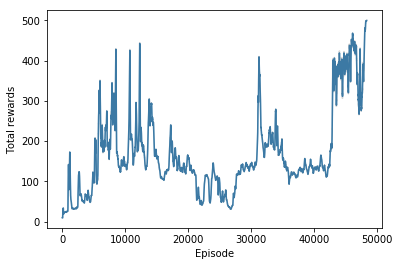

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

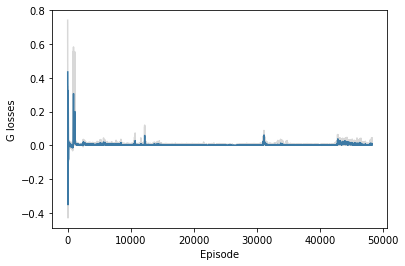

In [35]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

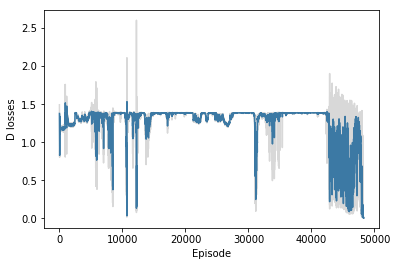

In [36]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [37]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.